# Coconut Mite Detection Model Training

**Model:** MobileNetV2 (Transfer Learning)  
**Dataset:** Coconut Mite vs Healthy Leaves  
**Author:** Research Team  
**Date:** December 2024

## 1. Setup and Imports

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow Version: 2.20.0
GPU Available: False


## 2. Configuration

In [2]:
# Paths
BASE_DIR = r"D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml"
DATA_DIR = os.path.join(BASE_DIR, 'data', 'raw', 'pest_mite', 'dataset_v3_clean')
MODEL_DIR = os.path.join(BASE_DIR, 'models', 'coconut_mite_v5')
os.makedirs(MODEL_DIR, exist_ok=True)

# Hyperparameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_PHASE1 = 15  # Train head only
EPOCHS_PHASE2 = 20  # Fine-tune
LEARNING_RATE_PHASE1 = 1e-3
LEARNING_RATE_PHASE2 = 1e-5

print(f"Data Directory: {DATA_DIR}")
print(f"Model Directory: {MODEL_DIR}")

Data Directory: D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\data\raw\pest_mite\dataset_v3_clean
Model Directory: D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\models\coconut_mite_v5


## 3. Load and Explore Dataset

In [3]:
# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'train'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'validation'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'test'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
print(f"Classes: {class_names}")

Found 8975 files belonging to 2 classes.


Found 188 files belonging to 2 classes.


Found 189 files belonging to 2 classes.


Classes: ['coconut_mite', 'healthy']


In [4]:
# Count images per class
def count_images(directory):
    counts = {}
    for cls in class_names:
        cls_dir = os.path.join(directory, cls)
        counts[cls] = len([f for f in os.listdir(cls_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    return counts

train_counts = count_images(os.path.join(DATA_DIR, 'train'))
val_counts = count_images(os.path.join(DATA_DIR, 'validation'))
test_counts = count_images(os.path.join(DATA_DIR, 'test'))

print("Dataset Distribution:")
print(f"  Training:   {train_counts} = {sum(train_counts.values())} images")
print(f"  Validation: {val_counts} = {sum(val_counts.values())} images")
print(f"  Test:       {test_counts} = {sum(test_counts.values())} images")
print(f"  Total:      {sum(train_counts.values()) + sum(val_counts.values()) + sum(test_counts.values())} images")

Dataset Distribution:
  Training:   {'coconut_mite': 4747, 'healthy': 4228} = 8975 images
  Validation: {'coconut_mite': 99, 'healthy': 89} = 188 images
  Test:       {'coconut_mite': 100, 'healthy': 89} = 189 images
  Total:      9352 images


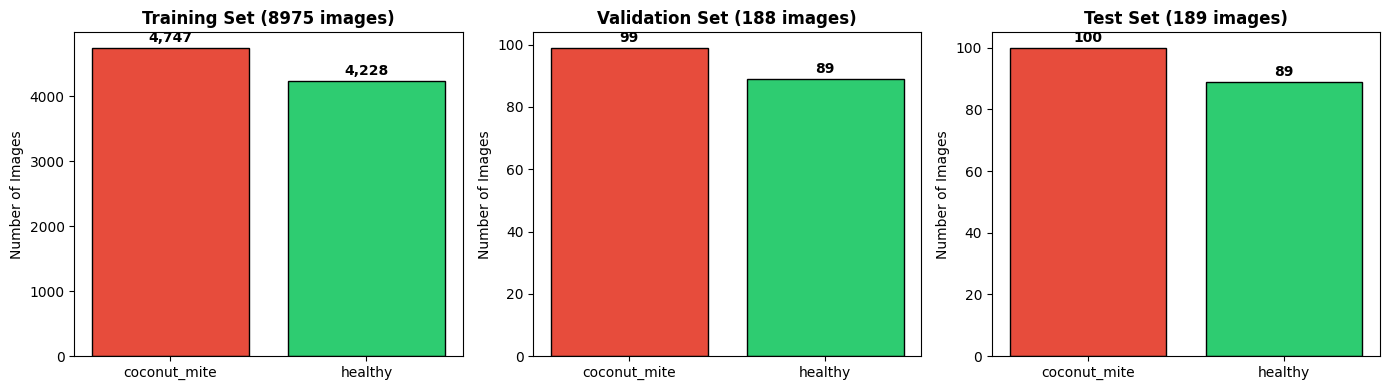

In [5]:
# Visualize dataset distribution
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
colors = ['#e74c3c', '#2ecc71']

for ax, (title, counts) in zip(axes, [('Training', train_counts), ('Validation', val_counts), ('Test', test_counts)]):
    vals = [counts[c] for c in class_names]
    bars = ax.bar(class_names, vals, color=colors, edgecolor='black')
    ax.set_title(f'{title} Set ({sum(vals)} images)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Images')
    for bar, v in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2, v + max(vals)*0.02, f'{v:,}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'dataset_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

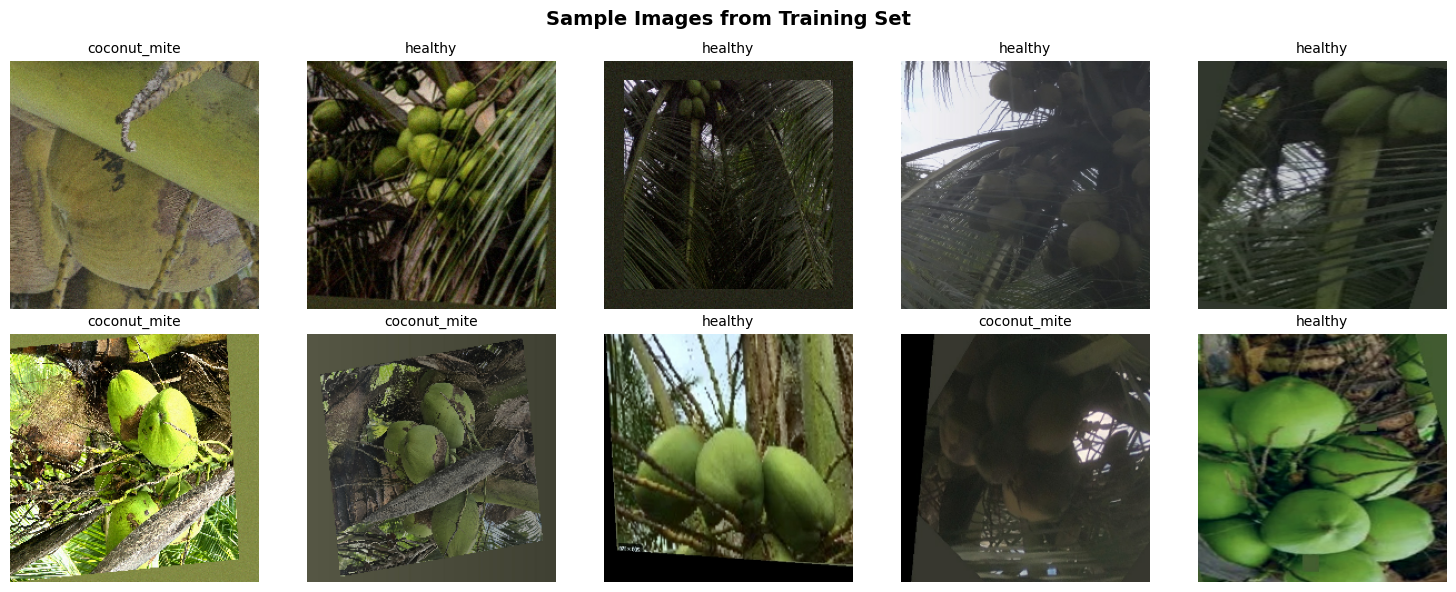

In [6]:
# Show sample images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Images from Training Set', fontsize=14, fontweight='bold')

for images, labels in train_ds.take(1):
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i].numpy().astype('uint8'))
            ax.set_title(class_names[labels[i]], fontsize=10)
            ax.axis('off')

plt.tight_layout()
plt.show()

## 4. Data Preprocessing

- **Training:** Normalization + Data Augmentation
- **Validation/Test:** Normalization ONLY (no augmentation)

In [7]:
# Data augmentation for training
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

# Normalization (MobileNetV2 expects [-1, 1])
normalization = tf.keras.layers.Rescaling(1./127.5, offset=-1)

# Apply preprocessing
def preprocess_train(image, label):
    image = data_augmentation(image, training=True)
    image = normalization(image)
    return image, label

def preprocess_val(image, label):
    image = normalization(image)
    return image, label

# Prepare datasets
AUTOTUNE = tf.data.AUTOTUNE
train_ds_prep = train_ds.map(preprocess_train, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
val_ds_prep = val_ds.map(preprocess_val, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
test_ds_prep = test_ds.map(preprocess_val, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

print("Preprocessing applied:")
print("  Training:   Augmentation (Flip, Rotation, Zoom, Contrast) + Normalization")
print("  Validation: Normalization only")
print("  Test:       Normalization only")

Preprocessing applied:
  Training:   Augmentation (Flip, Rotation, Zoom, Contrast) + Normalization
  Validation: Normalization only
  Test:       Normalization only


## 5. Build Model

Using **MobileNetV2** pre-trained on ImageNet as base model with custom classification head.

In [8]:
# Load pre-trained MobileNetV2
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model initially
base_model.trainable = False

# Build model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs, outputs)

print(f"Base model layers: {len(base_model.layers)}")
print(f"Total parameters: {model.count_params():,}")
print(f"Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")

Base model layers: 154
Total parameters: 2,422,081
Trainable parameters: 164,097


In [9]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 6. Training Phase 1: Train Classification Head

Base model frozen, only training the custom classification layers.

In [10]:
# Compile model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE_PHASE1),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks_phase1 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint(
        os.path.join(MODEL_DIR, 'phase1_best.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

print("Phase 1: Training classification head only")
print(f"  Epochs: {EPOCHS_PHASE1}")
print(f"  Learning Rate: {LEARNING_RATE_PHASE1}")
print(f"  Base Model: Frozen")

Phase 1: Training classification head only
  Epochs: 15
  Learning Rate: 0.001
  Base Model: Frozen


In [11]:
# Train Phase 1
history_phase1 = model.fit(
    train_ds_prep,
    validation_data=val_ds_prep,
    epochs=EPOCHS_PHASE1,
    callbacks=callbacks_phase1,
    verbose=1
)

print(f"\nPhase 1 Complete!")
print(f"Best Validation Accuracy: {max(history_phase1.history['val_accuracy'])*100:.2f}%")

Epoch 1/15


  1/281 ━━━━━━━━━━━━━━━━━━━━ 25:33 5s/step - accuracy: 0.4375 - loss: 1.3567

  2/281 ━━━━━━━━━━━━━━━━━━━━ 2:35 558ms/step - accuracy: 0.4375 - loss: 1.2410

  3/281 ━━━━━━━━━━━━━━━━━━━━ 2:25 525ms/step - accuracy: 0.4514 - loss: 1.1835

  4/281 ━━━━━━━━━━━━━━━━━━━━ 2:21 509ms/step - accuracy: 0.4635 - loss: 1.1300

  5/281 ━━━━━━━━━━━━━━━━━━━━ 2:25 528ms/step - accuracy: 0.4833 - loss: 1.0783

  6/281 ━━━━━━━━━━━━━━━━━━━━ 2:23 522ms/step - accuracy: 0.4983 - loss: 1.0379

  7/281 ━━━━━━━━━━━━━━━━━━━━ 2:27 539ms/step - accuracy: 0.5138 - loss: 1.0024

  8/281 ━━━━━━━━━━━━━━━━━━━━ 2:27 540ms/step - accuracy: 0.5297 - loss: 0.9706

  9/281 ━━━━━━━━━━━━━━━━━━━━ 2:26 539ms/step - accuracy: 0.5449 - loss: 0.9415

 10/281 ━━━━━━━━━━━━━━━━━━━━ 2:26 539ms/step - accuracy: 0.5582 - loss: 0.9158

 11/281 ━━━━━━━━━━━━━━━━━━━━ 2:27 545ms/step - accuracy: 0.5705 - loss: 0.8918

 12/281 ━━━━━━━━━━━━━━━━━━━━ 2:26 544ms/step - accuracy: 0.5824 - loss: 0.8690

 13/281 ━━━━━━━━━━━━━━━━━━━━ 2:23 536ms/step - accuracy: 0.5929 - loss: 0.8482

 14/281 ━━━━━━━━━━━━━━━━━━━━ 2:21 529ms/step - accuracy: 0.6020 - loss: 0.8294

 15/281 ━━━━━━━━━━━━━━━━━━━━ 2:19 524ms/step - accuracy: 0.6102 - loss: 0.8123

 16/281 ━━━━━━━━━━━━━━━━━━━━ 2:17 519ms/step - accuracy: 0.6179 - loss: 0.7964

 17/281 ━━━━━━━━━━━━━━━━━━━━ 2:14 511ms/step - accuracy: 0.6251 - loss: 0.7815

 18/281 ━━━━━━━━━━━━━━━━━━━━ 2:12 506ms/step - accuracy: 0.6318 - loss: 0.7679

 19/281 ━━━━━━━━━━━━━━━━━━━━ 2:12 505ms/step - accuracy: 0.6381 - loss: 0.7550

 20/281 ━━━━━━━━━━━━━━━━━━━━ 2:10 501ms/step - accuracy: 0.6441 - loss: 0.7429

 21/281 ━━━━━━━━━━━━━━━━━━━━ 2:09 500ms/step - accuracy: 0.6499 - loss: 0.7315

 22/281 ━━━━━━━━━━━━━━━━━━━━ 2:09 501ms/step - accuracy: 0.6551 - loss: 0.7209

 23/281 ━━━━━━━━━━━━━━━━━━━━ 2:07 496ms/step - accuracy: 0.6600 - loss: 0.7111

 24/281 ━━━━━━━━━━━━━━━━━━━━ 2:06 491ms/step - accuracy: 0.6648 - loss: 0.7016

 25/281 ━━━━━━━━━━━━━━━━━━━━ 2:05 489ms/step - accuracy: 0.6695 - loss: 0.6924

 26/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 488ms/step - accuracy: 0.6739 - loss: 0.6839

 27/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 490ms/step - accuracy: 0.6781 - loss: 0.6756

 28/281 ━━━━━━━━━━━━━━━━━━━━ 2:03 487ms/step - accuracy: 0.6821 - loss: 0.6678

 29/281 ━━━━━━━━━━━━━━━━━━━━ 2:01 484ms/step - accuracy: 0.6858 - loss: 0.6602

 30/281 ━━━━━━━━━━━━━━━━━━━━ 2:00 481ms/step - accuracy: 0.6895 - loss: 0.6528

 31/281 ━━━━━━━━━━━━━━━━━━━━ 1:59 478ms/step - accuracy: 0.6930 - loss: 0.6457

 32/281 ━━━━━━━━━━━━━━━━━━━━ 1:58 476ms/step - accuracy: 0.6963 - loss: 0.6390

 33/281 ━━━━━━━━━━━━━━━━━━━━ 1:57 475ms/step - accuracy: 0.6995 - loss: 0.6324

 34/281 ━━━━━━━━━━━━━━━━━━━━ 1:57 475ms/step - accuracy: 0.7027 - loss: 0.6261

 35/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 473ms/step - accuracy: 0.7058 - loss: 0.6200

 36/281 ━━━━━━━━━━━━━━━━━━━━ 1:54 469ms/step - accuracy: 0.7087 - loss: 0.6141

 37/281 ━━━━━━━━━━━━━━━━━━━━ 1:54 468ms/step - accuracy: 0.7116 - loss: 0.6085

 38/281 ━━━━━━━━━━━━━━━━━━━━ 1:53 466ms/step - accuracy: 0.7144 - loss: 0.6030

 39/281 ━━━━━━━━━━━━━━━━━━━━ 1:52 465ms/step - accuracy: 0.7171 - loss: 0.5978

 40/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 464ms/step - accuracy: 0.7197 - loss: 0.5926

 41/281 ━━━━━━━━━━━━━━━━━━━━ 1:50 462ms/step - accuracy: 0.7222 - loss: 0.5877

 42/281 ━━━━━━━━━━━━━━━━━━━━ 1:50 462ms/step - accuracy: 0.7247 - loss: 0.5828

 43/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 462ms/step - accuracy: 0.7272 - loss: 0.5780

 44/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 461ms/step - accuracy: 0.7295 - loss: 0.5734

 45/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 461ms/step - accuracy: 0.7318 - loss: 0.5690

 46/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 461ms/step - accuracy: 0.7340 - loss: 0.5648

 47/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 462ms/step - accuracy: 0.7362 - loss: 0.5607

 48/281 ━━━━━━━━━━━━━━━━━━━━ 1:47 462ms/step - accuracy: 0.7383 - loss: 0.5567

 49/281 ━━━━━━━━━━━━━━━━━━━━ 1:47 462ms/step - accuracy: 0.7403 - loss: 0.5529

 50/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 462ms/step - accuracy: 0.7423 - loss: 0.5492

 51/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 461ms/step - accuracy: 0.7442 - loss: 0.5456

 52/281 ━━━━━━━━━━━━━━━━━━━━ 1:45 462ms/step - accuracy: 0.7462 - loss: 0.5420

 53/281 ━━━━━━━━━━━━━━━━━━━━ 1:45 461ms/step - accuracy: 0.7481 - loss: 0.5385

 54/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 461ms/step - accuracy: 0.7499 - loss: 0.5350

 55/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 461ms/step - accuracy: 0.7517 - loss: 0.5316

 56/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 460ms/step - accuracy: 0.7535 - loss: 0.5283

 57/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 459ms/step - accuracy: 0.7552 - loss: 0.5250

 58/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 459ms/step - accuracy: 0.7569 - loss: 0.5218

 59/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 458ms/step - accuracy: 0.7586 - loss: 0.5187

 60/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 458ms/step - accuracy: 0.7602 - loss: 0.5156

 61/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 459ms/step - accuracy: 0.7618 - loss: 0.5126

 62/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 460ms/step - accuracy: 0.7634 - loss: 0.5096

 63/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 460ms/step - accuracy: 0.7650 - loss: 0.5067

 64/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 460ms/step - accuracy: 0.7665 - loss: 0.5038

 65/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 458ms/step - accuracy: 0.7680 - loss: 0.5010

 66/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 458ms/step - accuracy: 0.7695 - loss: 0.4982

 67/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 458ms/step - accuracy: 0.7709 - loss: 0.4955

 68/281 ━━━━━━━━━━━━━━━━━━━━ 1:37 459ms/step - accuracy: 0.7723 - loss: 0.4928

 69/281 ━━━━━━━━━━━━━━━━━━━━ 1:37 458ms/step - accuracy: 0.7737 - loss: 0.4902

 70/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 458ms/step - accuracy: 0.7750 - loss: 0.4877

 71/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 457ms/step - accuracy: 0.7764 - loss: 0.4852

 72/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 458ms/step - accuracy: 0.7777 - loss: 0.4827

 73/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 458ms/step - accuracy: 0.7789 - loss: 0.4803

 74/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 458ms/step - accuracy: 0.7802 - loss: 0.4780

 75/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 458ms/step - accuracy: 0.7814 - loss: 0.4756

 76/281 ━━━━━━━━━━━━━━━━━━━━ 1:33 457ms/step - accuracy: 0.7826 - loss: 0.4733

 77/281 ━━━━━━━━━━━━━━━━━━━━ 1:33 457ms/step - accuracy: 0.7838 - loss: 0.4710

 78/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 457ms/step - accuracy: 0.7850 - loss: 0.4688

 79/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 457ms/step - accuracy: 0.7861 - loss: 0.4665

 80/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 457ms/step - accuracy: 0.7873 - loss: 0.4644

 81/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 457ms/step - accuracy: 0.7884 - loss: 0.4622

 82/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 456ms/step - accuracy: 0.7895 - loss: 0.4601

 83/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 456ms/step - accuracy: 0.7906 - loss: 0.4580

 84/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 457ms/step - accuracy: 0.7916 - loss: 0.4559

 85/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 456ms/step - accuracy: 0.7926 - loss: 0.4539

 86/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 456ms/step - accuracy: 0.7937 - loss: 0.4519

 87/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 455ms/step - accuracy: 0.7947 - loss: 0.4499

 88/281 ━━━━━━━━━━━━━━━━━━━━ 1:27 454ms/step - accuracy: 0.7957 - loss: 0.4480

 89/281 ━━━━━━━━━━━━━━━━━━━━ 1:27 454ms/step - accuracy: 0.7967 - loss: 0.4460

 90/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 453ms/step - accuracy: 0.7976 - loss: 0.4442

 91/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 453ms/step - accuracy: 0.7986 - loss: 0.4423

 92/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 453ms/step - accuracy: 0.7995 - loss: 0.4405

 93/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 452ms/step - accuracy: 0.8004 - loss: 0.4387

 94/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 452ms/step - accuracy: 0.8013 - loss: 0.4369

 95/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 452ms/step - accuracy: 0.8022 - loss: 0.4352

 96/281 ━━━━━━━━━━━━━━━━━━━━ 1:23 451ms/step - accuracy: 0.8031 - loss: 0.4335

 97/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 451ms/step - accuracy: 0.8040 - loss: 0.4318

 98/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 451ms/step - accuracy: 0.8048 - loss: 0.4301

 99/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 451ms/step - accuracy: 0.8057 - loss: 0.4284

100/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 450ms/step - accuracy: 0.8065 - loss: 0.4268

101/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 450ms/step - accuracy: 0.8073 - loss: 0.4252

102/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 449ms/step - accuracy: 0.8081 - loss: 0.4236

103/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 449ms/step - accuracy: 0.8089 - loss: 0.4220

104/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 449ms/step - accuracy: 0.8097 - loss: 0.4204

105/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 449ms/step - accuracy: 0.8105 - loss: 0.4189

106/281 ━━━━━━━━━━━━━━━━━━━━ 1:18 448ms/step - accuracy: 0.8112 - loss: 0.4174

107/281 ━━━━━━━━━━━━━━━━━━━━ 1:18 449ms/step - accuracy: 0.8120 - loss: 0.4159

108/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 448ms/step - accuracy: 0.8127 - loss: 0.4144

109/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 448ms/step - accuracy: 0.8135 - loss: 0.4130

110/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 447ms/step - accuracy: 0.8142 - loss: 0.4116

111/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 448ms/step - accuracy: 0.8149 - loss: 0.4102

112/281 ━━━━━━━━━━━━━━━━━━━━ 1:15 448ms/step - accuracy: 0.8156 - loss: 0.4088

113/281 ━━━━━━━━━━━━━━━━━━━━ 1:15 447ms/step - accuracy: 0.8163 - loss: 0.4074

114/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 447ms/step - accuracy: 0.8170 - loss: 0.4060

115/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 446ms/step - accuracy: 0.8176 - loss: 0.4047

116/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 446ms/step - accuracy: 0.8183 - loss: 0.4034

117/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 446ms/step - accuracy: 0.8190 - loss: 0.4020

118/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 447ms/step - accuracy: 0.8196 - loss: 0.4008

119/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 447ms/step - accuracy: 0.8202 - loss: 0.3995

120/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 446ms/step - accuracy: 0.8208 - loss: 0.3983

121/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 446ms/step - accuracy: 0.8214 - loss: 0.3971

122/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 446ms/step - accuracy: 0.8220 - loss: 0.3959

123/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 445ms/step - accuracy: 0.8226 - loss: 0.3947

124/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 445ms/step - accuracy: 0.8232 - loss: 0.3935

125/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 445ms/step - accuracy: 0.8238 - loss: 0.3923

126/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 444ms/step - accuracy: 0.8244 - loss: 0.3912

127/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 444ms/step - accuracy: 0.8249 - loss: 0.3901

128/281 ━━━━━━━━━━━━━━━━━━━━ 1:07 444ms/step - accuracy: 0.8255 - loss: 0.3889

129/281 ━━━━━━━━━━━━━━━━━━━━ 1:07 443ms/step - accuracy: 0.8261 - loss: 0.3878

130/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 443ms/step - accuracy: 0.8266 - loss: 0.3867

131/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 443ms/step - accuracy: 0.8272 - loss: 0.3857

132/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 442ms/step - accuracy: 0.8277 - loss: 0.3846

133/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 442ms/step - accuracy: 0.8282 - loss: 0.3835

134/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 443ms/step - accuracy: 0.8287 - loss: 0.3825

135/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 442ms/step - accuracy: 0.8293 - loss: 0.3815

136/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 442ms/step - accuracy: 0.8298 - loss: 0.3805

137/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 441ms/step - accuracy: 0.8303 - loss: 0.3795

138/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 441ms/step - accuracy: 0.8308 - loss: 0.3785

139/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 441ms/step - accuracy: 0.8313 - loss: 0.3775

140/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 441ms/step - accuracy: 0.8318 - loss: 0.3765

141/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 441ms/step - accuracy: 0.8323 - loss: 0.3756

142/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 441ms/step - accuracy: 0.8327 - loss: 0.3746

143/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 441ms/step - accuracy: 0.8332 - loss: 0.3737

144/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 440ms/step - accuracy: 0.8337 - loss: 0.3727

145/281 ━━━━━━━━━━━━━━━━━━━━ 59s 440ms/step - accuracy: 0.8342 - loss: 0.3718 

146/281 ━━━━━━━━━━━━━━━━━━━━ 59s 440ms/step - accuracy: 0.8346 - loss: 0.3709

147/281 ━━━━━━━━━━━━━━━━━━━━ 59s 440ms/step - accuracy: 0.8351 - loss: 0.3699

148/281 ━━━━━━━━━━━━━━━━━━━━ 58s 440ms/step - accuracy: 0.8356 - loss: 0.3690

149/281 ━━━━━━━━━━━━━━━━━━━━ 58s 440ms/step - accuracy: 0.8360 - loss: 0.3681

150/281 ━━━━━━━━━━━━━━━━━━━━ 57s 440ms/step - accuracy: 0.8365 - loss: 0.3672

151/281 ━━━━━━━━━━━━━━━━━━━━ 57s 440ms/step - accuracy: 0.8369 - loss: 0.3663

152/281 ━━━━━━━━━━━━━━━━━━━━ 56s 440ms/step - accuracy: 0.8374 - loss: 0.3654

153/281 ━━━━━━━━━━━━━━━━━━━━ 56s 440ms/step - accuracy: 0.8378 - loss: 0.3646

154/281 ━━━━━━━━━━━━━━━━━━━━ 55s 441ms/step - accuracy: 0.8382 - loss: 0.3637

155/281 ━━━━━━━━━━━━━━━━━━━━ 55s 441ms/step - accuracy: 0.8387 - loss: 0.3628

156/281 ━━━━━━━━━━━━━━━━━━━━ 55s 441ms/step - accuracy: 0.8391 - loss: 0.3620

157/281 ━━━━━━━━━━━━━━━━━━━━ 54s 442ms/step - accuracy: 0.8395 - loss: 0.3611

158/281 ━━━━━━━━━━━━━━━━━━━━ 54s 442ms/step - accuracy: 0.8399 - loss: 0.3603

159/281 ━━━━━━━━━━━━━━━━━━━━ 53s 442ms/step - accuracy: 0.8403 - loss: 0.3595

160/281 ━━━━━━━━━━━━━━━━━━━━ 53s 442ms/step - accuracy: 0.8407 - loss: 0.3587

161/281 ━━━━━━━━━━━━━━━━━━━━ 53s 442ms/step - accuracy: 0.8411 - loss: 0.3579

162/281 ━━━━━━━━━━━━━━━━━━━━ 52s 443ms/step - accuracy: 0.8415 - loss: 0.3571

163/281 ━━━━━━━━━━━━━━━━━━━━ 52s 443ms/step - accuracy: 0.8419 - loss: 0.3563

164/281 ━━━━━━━━━━━━━━━━━━━━ 51s 443ms/step - accuracy: 0.8423 - loss: 0.3555

165/281 ━━━━━━━━━━━━━━━━━━━━ 51s 443ms/step - accuracy: 0.8427 - loss: 0.3547

166/281 ━━━━━━━━━━━━━━━━━━━━ 50s 443ms/step - accuracy: 0.8431 - loss: 0.3539

167/281 ━━━━━━━━━━━━━━━━━━━━ 50s 443ms/step - accuracy: 0.8435 - loss: 0.3531

168/281 ━━━━━━━━━━━━━━━━━━━━ 50s 443ms/step - accuracy: 0.8439 - loss: 0.3524

169/281 ━━━━━━━━━━━━━━━━━━━━ 49s 443ms/step - accuracy: 0.8443 - loss: 0.3516

170/281 ━━━━━━━━━━━━━━━━━━━━ 49s 443ms/step - accuracy: 0.8446 - loss: 0.3508

171/281 ━━━━━━━━━━━━━━━━━━━━ 48s 443ms/step - accuracy: 0.8450 - loss: 0.3501

172/281 ━━━━━━━━━━━━━━━━━━━━ 48s 443ms/step - accuracy: 0.8454 - loss: 0.3493

173/281 ━━━━━━━━━━━━━━━━━━━━ 47s 443ms/step - accuracy: 0.8457 - loss: 0.3486

174/281 ━━━━━━━━━━━━━━━━━━━━ 47s 443ms/step - accuracy: 0.8461 - loss: 0.3479

175/281 ━━━━━━━━━━━━━━━━━━━━ 46s 442ms/step - accuracy: 0.8465 - loss: 0.3471

176/281 ━━━━━━━━━━━━━━━━━━━━ 46s 443ms/step - accuracy: 0.8468 - loss: 0.3464

177/281 ━━━━━━━━━━━━━━━━━━━━ 46s 443ms/step - accuracy: 0.8472 - loss: 0.3457

178/281 ━━━━━━━━━━━━━━━━━━━━ 45s 443ms/step - accuracy: 0.8475 - loss: 0.3450

179/281 ━━━━━━━━━━━━━━━━━━━━ 45s 442ms/step - accuracy: 0.8479 - loss: 0.3443

180/281 ━━━━━━━━━━━━━━━━━━━━ 44s 442ms/step - accuracy: 0.8482 - loss: 0.3436

181/281 ━━━━━━━━━━━━━━━━━━━━ 44s 442ms/step - accuracy: 0.8486 - loss: 0.3429

182/281 ━━━━━━━━━━━━━━━━━━━━ 43s 441ms/step - accuracy: 0.8489 - loss: 0.3422

183/281 ━━━━━━━━━━━━━━━━━━━━ 43s 442ms/step - accuracy: 0.8493 - loss: 0.3415

184/281 ━━━━━━━━━━━━━━━━━━━━ 42s 442ms/step - accuracy: 0.8496 - loss: 0.3408

185/281 ━━━━━━━━━━━━━━━━━━━━ 42s 442ms/step - accuracy: 0.8499 - loss: 0.3402

186/281 ━━━━━━━━━━━━━━━━━━━━ 41s 441ms/step - accuracy: 0.8503 - loss: 0.3395

187/281 ━━━━━━━━━━━━━━━━━━━━ 41s 441ms/step - accuracy: 0.8506 - loss: 0.3388

188/281 ━━━━━━━━━━━━━━━━━━━━ 41s 441ms/step - accuracy: 0.8509 - loss: 0.3382

189/281 ━━━━━━━━━━━━━━━━━━━━ 40s 441ms/step - accuracy: 0.8513 - loss: 0.3375

190/281 ━━━━━━━━━━━━━━━━━━━━ 40s 441ms/step - accuracy: 0.8516 - loss: 0.3369

191/281 ━━━━━━━━━━━━━━━━━━━━ 39s 441ms/step - accuracy: 0.8519 - loss: 0.3363

192/281 ━━━━━━━━━━━━━━━━━━━━ 39s 441ms/step - accuracy: 0.8522 - loss: 0.3356

193/281 ━━━━━━━━━━━━━━━━━━━━ 38s 441ms/step - accuracy: 0.8525 - loss: 0.3350

194/281 ━━━━━━━━━━━━━━━━━━━━ 38s 441ms/step - accuracy: 0.8529 - loss: 0.3344

195/281 ━━━━━━━━━━━━━━━━━━━━ 37s 441ms/step - accuracy: 0.8532 - loss: 0.3337

196/281 ━━━━━━━━━━━━━━━━━━━━ 37s 441ms/step - accuracy: 0.8535 - loss: 0.3331

197/281 ━━━━━━━━━━━━━━━━━━━━ 37s 441ms/step - accuracy: 0.8538 - loss: 0.3325

198/281 ━━━━━━━━━━━━━━━━━━━━ 36s 441ms/step - accuracy: 0.8541 - loss: 0.3319

199/281 ━━━━━━━━━━━━━━━━━━━━ 36s 441ms/step - accuracy: 0.8544 - loss: 0.3313

200/281 ━━━━━━━━━━━━━━━━━━━━ 35s 441ms/step - accuracy: 0.8547 - loss: 0.3307

201/281 ━━━━━━━━━━━━━━━━━━━━ 35s 441ms/step - accuracy: 0.8550 - loss: 0.3301

202/281 ━━━━━━━━━━━━━━━━━━━━ 34s 441ms/step - accuracy: 0.8553 - loss: 0.3295

203/281 ━━━━━━━━━━━━━━━━━━━━ 34s 441ms/step - accuracy: 0.8556 - loss: 0.3289

204/281 ━━━━━━━━━━━━━━━━━━━━ 33s 441ms/step - accuracy: 0.8558 - loss: 0.3284

205/281 ━━━━━━━━━━━━━━━━━━━━ 33s 441ms/step - accuracy: 0.8561 - loss: 0.3278

206/281 ━━━━━━━━━━━━━━━━━━━━ 33s 440ms/step - accuracy: 0.8564 - loss: 0.3272

207/281 ━━━━━━━━━━━━━━━━━━━━ 32s 440ms/step - accuracy: 0.8567 - loss: 0.3266

208/281 ━━━━━━━━━━━━━━━━━━━━ 32s 441ms/step - accuracy: 0.8570 - loss: 0.3261

209/281 ━━━━━━━━━━━━━━━━━━━━ 31s 441ms/step - accuracy: 0.8572 - loss: 0.3255

210/281 ━━━━━━━━━━━━━━━━━━━━ 31s 441ms/step - accuracy: 0.8575 - loss: 0.3250

211/281 ━━━━━━━━━━━━━━━━━━━━ 30s 441ms/step - accuracy: 0.8578 - loss: 0.3244

212/281 ━━━━━━━━━━━━━━━━━━━━ 30s 441ms/step - accuracy: 0.8581 - loss: 0.3239

213/281 ━━━━━━━━━━━━━━━━━━━━ 29s 441ms/step - accuracy: 0.8583 - loss: 0.3233

214/281 ━━━━━━━━━━━━━━━━━━━━ 29s 441ms/step - accuracy: 0.8586 - loss: 0.3228

215/281 ━━━━━━━━━━━━━━━━━━━━ 29s 441ms/step - accuracy: 0.8589 - loss: 0.3222

216/281 ━━━━━━━━━━━━━━━━━━━━ 28s 441ms/step - accuracy: 0.8591 - loss: 0.3217

217/281 ━━━━━━━━━━━━━━━━━━━━ 28s 441ms/step - accuracy: 0.8594 - loss: 0.3211

218/281 ━━━━━━━━━━━━━━━━━━━━ 27s 441ms/step - accuracy: 0.8597 - loss: 0.3206

219/281 ━━━━━━━━━━━━━━━━━━━━ 27s 441ms/step - accuracy: 0.8599 - loss: 0.3201

220/281 ━━━━━━━━━━━━━━━━━━━━ 26s 441ms/step - accuracy: 0.8602 - loss: 0.3195

221/281 ━━━━━━━━━━━━━━━━━━━━ 26s 441ms/step - accuracy: 0.8604 - loss: 0.3190

222/281 ━━━━━━━━━━━━━━━━━━━━ 26s 441ms/step - accuracy: 0.8607 - loss: 0.3185

223/281 ━━━━━━━━━━━━━━━━━━━━ 25s 441ms/step - accuracy: 0.8610 - loss: 0.3180

224/281 ━━━━━━━━━━━━━━━━━━━━ 25s 441ms/step - accuracy: 0.8612 - loss: 0.3175

225/281 ━━━━━━━━━━━━━━━━━━━━ 24s 441ms/step - accuracy: 0.8615 - loss: 0.3169

226/281 ━━━━━━━━━━━━━━━━━━━━ 24s 440ms/step - accuracy: 0.8617 - loss: 0.3164

227/281 ━━━━━━━━━━━━━━━━━━━━ 23s 441ms/step - accuracy: 0.8620 - loss: 0.3159

228/281 ━━━━━━━━━━━━━━━━━━━━ 23s 441ms/step - accuracy: 0.8622 - loss: 0.3154

229/281 ━━━━━━━━━━━━━━━━━━━━ 22s 441ms/step - accuracy: 0.8625 - loss: 0.3149

230/281 ━━━━━━━━━━━━━━━━━━━━ 22s 441ms/step - accuracy: 0.8627 - loss: 0.3144

231/281 ━━━━━━━━━━━━━━━━━━━━ 22s 441ms/step - accuracy: 0.8630 - loss: 0.3139

232/281 ━━━━━━━━━━━━━━━━━━━━ 21s 441ms/step - accuracy: 0.8632 - loss: 0.3134

233/281 ━━━━━━━━━━━━━━━━━━━━ 21s 441ms/step - accuracy: 0.8635 - loss: 0.3129

234/281 ━━━━━━━━━━━━━━━━━━━━ 20s 441ms/step - accuracy: 0.8637 - loss: 0.3124

235/281 ━━━━━━━━━━━━━━━━━━━━ 20s 441ms/step - accuracy: 0.8639 - loss: 0.3119

236/281 ━━━━━━━━━━━━━━━━━━━━ 19s 441ms/step - accuracy: 0.8642 - loss: 0.3114

237/281 ━━━━━━━━━━━━━━━━━━━━ 19s 441ms/step - accuracy: 0.8644 - loss: 0.3109

238/281 ━━━━━━━━━━━━━━━━━━━━ 18s 441ms/step - accuracy: 0.8647 - loss: 0.3105

239/281 ━━━━━━━━━━━━━━━━━━━━ 18s 441ms/step - accuracy: 0.8649 - loss: 0.3100

240/281 ━━━━━━━━━━━━━━━━━━━━ 18s 441ms/step - accuracy: 0.8651 - loss: 0.3095

241/281 ━━━━━━━━━━━━━━━━━━━━ 17s 441ms/step - accuracy: 0.8653 - loss: 0.3090

242/281 ━━━━━━━━━━━━━━━━━━━━ 17s 441ms/step - accuracy: 0.8656 - loss: 0.3086

243/281 ━━━━━━━━━━━━━━━━━━━━ 16s 441ms/step - accuracy: 0.8658 - loss: 0.3081

244/281 ━━━━━━━━━━━━━━━━━━━━ 16s 440ms/step - accuracy: 0.8660 - loss: 0.3076

245/281 ━━━━━━━━━━━━━━━━━━━━ 15s 441ms/step - accuracy: 0.8663 - loss: 0.3072

246/281 ━━━━━━━━━━━━━━━━━━━━ 15s 441ms/step - accuracy: 0.8665 - loss: 0.3067

247/281 ━━━━━━━━━━━━━━━━━━━━ 14s 440ms/step - accuracy: 0.8667 - loss: 0.3062

248/281 ━━━━━━━━━━━━━━━━━━━━ 14s 440ms/step - accuracy: 0.8669 - loss: 0.3058

249/281 ━━━━━━━━━━━━━━━━━━━━ 14s 440ms/step - accuracy: 0.8672 - loss: 0.3053

250/281 ━━━━━━━━━━━━━━━━━━━━ 13s 440ms/step - accuracy: 0.8674 - loss: 0.3049

251/281 ━━━━━━━━━━━━━━━━━━━━ 13s 440ms/step - accuracy: 0.8676 - loss: 0.3044

252/281 ━━━━━━━━━━━━━━━━━━━━ 12s 440ms/step - accuracy: 0.8678 - loss: 0.3039

253/281 ━━━━━━━━━━━━━━━━━━━━ 12s 440ms/step - accuracy: 0.8680 - loss: 0.3035

254/281 ━━━━━━━━━━━━━━━━━━━━ 11s 440ms/step - accuracy: 0.8683 - loss: 0.3031

255/281 ━━━━━━━━━━━━━━━━━━━━ 11s 440ms/step - accuracy: 0.8685 - loss: 0.3026

256/281 ━━━━━━━━━━━━━━━━━━━━ 11s 440ms/step - accuracy: 0.8687 - loss: 0.3022

257/281 ━━━━━━━━━━━━━━━━━━━━ 10s 440ms/step - accuracy: 0.8689 - loss: 0.3017

258/281 ━━━━━━━━━━━━━━━━━━━━ 10s 440ms/step - accuracy: 0.8691 - loss: 0.3013

259/281 ━━━━━━━━━━━━━━━━━━━━ 9s 440ms/step - accuracy: 0.8693 - loss: 0.3008 

260/281 ━━━━━━━━━━━━━━━━━━━━ 9s 440ms/step - accuracy: 0.8695 - loss: 0.3004

261/281 ━━━━━━━━━━━━━━━━━━━━ 8s 440ms/step - accuracy: 0.8697 - loss: 0.3000

262/281 ━━━━━━━━━━━━━━━━━━━━ 8s 440ms/step - accuracy: 0.8700 - loss: 0.2996

263/281 ━━━━━━━━━━━━━━━━━━━━ 7s 440ms/step - accuracy: 0.8702 - loss: 0.2991

264/281 ━━━━━━━━━━━━━━━━━━━━ 7s 439ms/step - accuracy: 0.8704 - loss: 0.2987

265/281 ━━━━━━━━━━━━━━━━━━━━ 7s 439ms/step - accuracy: 0.8706 - loss: 0.2983

266/281 ━━━━━━━━━━━━━━━━━━━━ 6s 439ms/step - accuracy: 0.8708 - loss: 0.2979

267/281 ━━━━━━━━━━━━━━━━━━━━ 6s 438ms/step - accuracy: 0.8710 - loss: 0.2974

268/281 ━━━━━━━━━━━━━━━━━━━━ 5s 438ms/step - accuracy: 0.8712 - loss: 0.2970

269/281 ━━━━━━━━━━━━━━━━━━━━ 5s 437ms/step - accuracy: 0.8714 - loss: 0.2966

270/281 ━━━━━━━━━━━━━━━━━━━━ 4s 437ms/step - accuracy: 0.8716 - loss: 0.2962

271/281 ━━━━━━━━━━━━━━━━━━━━ 4s 436ms/step - accuracy: 0.8718 - loss: 0.2958

272/281 ━━━━━━━━━━━━━━━━━━━━ 3s 436ms/step - accuracy: 0.8720 - loss: 0.2954

273/281 ━━━━━━━━━━━━━━━━━━━━ 3s 435ms/step - accuracy: 0.8722 - loss: 0.2949

274/281 ━━━━━━━━━━━━━━━━━━━━ 3s 435ms/step - accuracy: 0.8724 - loss: 0.2945

275/281 ━━━━━━━━━━━━━━━━━━━━ 2s 434ms/step - accuracy: 0.8726 - loss: 0.2941

276/281 ━━━━━━━━━━━━━━━━━━━━ 2s 434ms/step - accuracy: 0.8728 - loss: 0.2937

277/281 ━━━━━━━━━━━━━━━━━━━━ 1s 433ms/step - accuracy: 0.8730 - loss: 0.2933

278/281 ━━━━━━━━━━━━━━━━━━━━ 1s 433ms/step - accuracy: 0.8731 - loss: 0.2929

279/281 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.8733 - loss: 0.2925

280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.8735 - loss: 0.2921

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.8737 - loss: 0.2917


Epoch 1: val_accuracy improved from None to 0.83511, saving model to D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\models\coconut_mite_v5\phase1_best.keras


281/281 ━━━━━━━━━━━━━━━━━━━━ 130s 446ms/step - accuracy: 0.9264 - loss: 0.1818 - val_accuracy: 0.8351 - val_loss: 0.4345 - learning_rate: 0.0010


Epoch 2/15


  1/281 ━━━━━━━━━━━━━━━━━━━━ 6:06 1s/step - accuracy: 0.9688 - loss: 0.0302

  2/281 ━━━━━━━━━━━━━━━━━━━━ 2:19 499ms/step - accuracy: 0.9766 - loss: 0.0431

  3/281 ━━━━━━━━━━━━━━━━━━━━ 2:16 491ms/step - accuracy: 0.9809 - loss: 0.0438

  4/281 ━━━━━━━━━━━━━━━━━━━━ 2:17 496ms/step - accuracy: 0.9818 - loss: 0.0463

  5/281 ━━━━━━━━━━━━━━━━━━━━ 2:20 508ms/step - accuracy: 0.9792 - loss: 0.0522

  6/281 ━━━━━━━━━━━━━━━━━━━━ 2:23 522ms/step - accuracy: 0.9774 - loss: 0.0555

  7/281 ━━━━━━━━━━━━━━━━━━━━ 2:21 515ms/step - accuracy: 0.9762 - loss: 0.0586

  8/281 ━━━━━━━━━━━━━━━━━━━━ 2:18 508ms/step - accuracy: 0.9748 - loss: 0.0625

  9/281 ━━━━━━━━━━━━━━━━━━━━ 2:19 512ms/step - accuracy: 0.9741 - loss: 0.0650

 10/281 ━━━━━━━━━━━━━━━━━━━━ 2:19 516ms/step - accuracy: 0.9739 - loss: 0.0664

 11/281 ━━━━━━━━━━━━━━━━━━━━ 2:19 518ms/step - accuracy: 0.9734 - loss: 0.0677

 12/281 ━━━━━━━━━━━━━━━━━━━━ 2:20 524ms/step - accuracy: 0.9730 - loss: 0.0689

 13/281 ━━━━━━━━━━━━━━━━━━━━ 2:19 522ms/step - accuracy: 0.9729 - loss: 0.0696

 14/281 ━━━━━━━━━━━━━━━━━━━━ 2:18 520ms/step - accuracy: 0.9727 - loss: 0.0706

 15/281 ━━━━━━━━━━━━━━━━━━━━ 2:18 520ms/step - accuracy: 0.9725 - loss: 0.0715

 16/281 ━━━━━━━━━━━━━━━━━━━━ 2:18 524ms/step - accuracy: 0.9721 - loss: 0.0726

 17/281 ━━━━━━━━━━━━━━━━━━━━ 2:17 520ms/step - accuracy: 0.9717 - loss: 0.0737

 18/281 ━━━━━━━━━━━━━━━━━━━━ 2:15 515ms/step - accuracy: 0.9713 - loss: 0.0746

 19/281 ━━━━━━━━━━━━━━━━━━━━ 2:14 512ms/step - accuracy: 0.9709 - loss: 0.0754

 20/281 ━━━━━━━━━━━━━━━━━━━━ 2:12 509ms/step - accuracy: 0.9704 - loss: 0.0763

 21/281 ━━━━━━━━━━━━━━━━━━━━ 2:11 507ms/step - accuracy: 0.9700 - loss: 0.0772

 22/281 ━━━━━━━━━━━━━━━━━━━━ 2:10 505ms/step - accuracy: 0.9697 - loss: 0.0779

 23/281 ━━━━━━━━━━━━━━━━━━━━ 2:09 502ms/step - accuracy: 0.9694 - loss: 0.0786

 24/281 ━━━━━━━━━━━━━━━━━━━━ 2:07 497ms/step - accuracy: 0.9692 - loss: 0.0790

 25/281 ━━━━━━━━━━━━━━━━━━━━ 2:06 494ms/step - accuracy: 0.9691 - loss: 0.0795

 26/281 ━━━━━━━━━━━━━━━━━━━━ 2:05 492ms/step - accuracy: 0.9689 - loss: 0.0800

 27/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 488ms/step - accuracy: 0.9687 - loss: 0.0805

 28/281 ━━━━━━━━━━━━━━━━━━━━ 2:02 485ms/step - accuracy: 0.9685 - loss: 0.0810

 29/281 ━━━━━━━━━━━━━━━━━━━━ 2:02 484ms/step - accuracy: 0.9683 - loss: 0.0814

 30/281 ━━━━━━━━━━━━━━━━━━━━ 2:01 483ms/step - accuracy: 0.9682 - loss: 0.0818

 31/281 ━━━━━━━━━━━━━━━━━━━━ 2:00 483ms/step - accuracy: 0.9680 - loss: 0.0823

 32/281 ━━━━━━━━━━━━━━━━━━━━ 2:00 484ms/step - accuracy: 0.9679 - loss: 0.0828

 33/281 ━━━━━━━━━━━━━━━━━━━━ 1:59 482ms/step - accuracy: 0.9678 - loss: 0.0831

 34/281 ━━━━━━━━━━━━━━━━━━━━ 1:58 479ms/step - accuracy: 0.9677 - loss: 0.0835

 35/281 ━━━━━━━━━━━━━━━━━━━━ 1:57 478ms/step - accuracy: 0.9676 - loss: 0.0839

 36/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 477ms/step - accuracy: 0.9675 - loss: 0.0843

 37/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 477ms/step - accuracy: 0.9674 - loss: 0.0847

 38/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 478ms/step - accuracy: 0.9673 - loss: 0.0851

 39/281 ━━━━━━━━━━━━━━━━━━━━ 1:55 477ms/step - accuracy: 0.9672 - loss: 0.0855

 40/281 ━━━━━━━━━━━━━━━━━━━━ 1:54 475ms/step - accuracy: 0.9670 - loss: 0.0859

 41/281 ━━━━━━━━━━━━━━━━━━━━ 1:53 473ms/step - accuracy: 0.9669 - loss: 0.0862

 42/281 ━━━━━━━━━━━━━━━━━━━━ 1:52 471ms/step - accuracy: 0.9668 - loss: 0.0866

 43/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 469ms/step - accuracy: 0.9667 - loss: 0.0869

 44/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 470ms/step - accuracy: 0.9666 - loss: 0.0871

 45/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 470ms/step - accuracy: 0.9666 - loss: 0.0873

 46/281 ━━━━━━━━━━━━━━━━━━━━ 1:50 470ms/step - accuracy: 0.9665 - loss: 0.0875

 47/281 ━━━━━━━━━━━━━━━━━━━━ 1:50 471ms/step - accuracy: 0.9665 - loss: 0.0876

 48/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 472ms/step - accuracy: 0.9664 - loss: 0.0878

 49/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 471ms/step - accuracy: 0.9663 - loss: 0.0880

 50/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 472ms/step - accuracy: 0.9663 - loss: 0.0881

 51/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 472ms/step - accuracy: 0.9662 - loss: 0.0882

 52/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 472ms/step - accuracy: 0.9662 - loss: 0.0883

 53/281 ━━━━━━━━━━━━━━━━━━━━ 1:47 472ms/step - accuracy: 0.9661 - loss: 0.0884

 54/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 471ms/step - accuracy: 0.9661 - loss: 0.0885

 55/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 472ms/step - accuracy: 0.9660 - loss: 0.0886

 56/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 472ms/step - accuracy: 0.9659 - loss: 0.0888

 57/281 ━━━━━━━━━━━━━━━━━━━━ 1:45 471ms/step - accuracy: 0.9659 - loss: 0.0889

 58/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 471ms/step - accuracy: 0.9658 - loss: 0.0890

 59/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 470ms/step - accuracy: 0.9657 - loss: 0.0891

 60/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 470ms/step - accuracy: 0.9657 - loss: 0.0892

 61/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 470ms/step - accuracy: 0.9656 - loss: 0.0893

 62/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 471ms/step - accuracy: 0.9655 - loss: 0.0894

 63/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 471ms/step - accuracy: 0.9655 - loss: 0.0895

 64/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 470ms/step - accuracy: 0.9654 - loss: 0.0897

 65/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 470ms/step - accuracy: 0.9653 - loss: 0.0898

 66/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 470ms/step - accuracy: 0.9653 - loss: 0.0900

 67/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 470ms/step - accuracy: 0.9652 - loss: 0.0901

 68/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 472ms/step - accuracy: 0.9652 - loss: 0.0902

 69/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 471ms/step - accuracy: 0.9651 - loss: 0.0903

 70/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 471ms/step - accuracy: 0.9651 - loss: 0.0904

 71/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 470ms/step - accuracy: 0.9650 - loss: 0.0904

 72/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 469ms/step - accuracy: 0.9650 - loss: 0.0905

 73/281 ━━━━━━━━━━━━━━━━━━━━ 1:37 469ms/step - accuracy: 0.9650 - loss: 0.0906

 74/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 468ms/step - accuracy: 0.9650 - loss: 0.0906

 75/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 468ms/step - accuracy: 0.9649 - loss: 0.0907

 76/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 468ms/step - accuracy: 0.9649 - loss: 0.0908

 77/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 468ms/step - accuracy: 0.9649 - loss: 0.0909

 78/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 468ms/step - accuracy: 0.9648 - loss: 0.0910

 79/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 468ms/step - accuracy: 0.9648 - loss: 0.0910

 80/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 468ms/step - accuracy: 0.9648 - loss: 0.0911

 81/281 ━━━━━━━━━━━━━━━━━━━━ 1:33 468ms/step - accuracy: 0.9648 - loss: 0.0912

 82/281 ━━━━━━━━━━━━━━━━━━━━ 1:33 468ms/step - accuracy: 0.9648 - loss: 0.0912

 83/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 468ms/step - accuracy: 0.9648 - loss: 0.0913

 84/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 468ms/step - accuracy: 0.9647 - loss: 0.0913

 85/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 468ms/step - accuracy: 0.9647 - loss: 0.0914

 86/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 468ms/step - accuracy: 0.9647 - loss: 0.0914

 87/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 468ms/step - accuracy: 0.9647 - loss: 0.0914

 88/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 467ms/step - accuracy: 0.9647 - loss: 0.0915

 89/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 466ms/step - accuracy: 0.9647 - loss: 0.0915

 90/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 466ms/step - accuracy: 0.9647 - loss: 0.0915

 91/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 465ms/step - accuracy: 0.9647 - loss: 0.0915

 92/281 ━━━━━━━━━━━━━━━━━━━━ 1:27 465ms/step - accuracy: 0.9647 - loss: 0.0915

 93/281 ━━━━━━━━━━━━━━━━━━━━ 1:27 465ms/step - accuracy: 0.9646 - loss: 0.0916

 94/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 464ms/step - accuracy: 0.9646 - loss: 0.0916

 95/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 464ms/step - accuracy: 0.9646 - loss: 0.0916

 96/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 464ms/step - accuracy: 0.9646 - loss: 0.0916

 97/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 463ms/step - accuracy: 0.9646 - loss: 0.0917

 98/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 463ms/step - accuracy: 0.9646 - loss: 0.0917

 99/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 463ms/step - accuracy: 0.9645 - loss: 0.0917

100/281 ━━━━━━━━━━━━━━━━━━━━ 1:23 462ms/step - accuracy: 0.9645 - loss: 0.0917

101/281 ━━━━━━━━━━━━━━━━━━━━ 1:23 462ms/step - accuracy: 0.9645 - loss: 0.0917

102/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 462ms/step - accuracy: 0.9645 - loss: 0.0917

103/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 462ms/step - accuracy: 0.9645 - loss: 0.0918

104/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 462ms/step - accuracy: 0.9645 - loss: 0.0918

105/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 462ms/step - accuracy: 0.9645 - loss: 0.0918

106/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 462ms/step - accuracy: 0.9644 - loss: 0.0918

107/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 461ms/step - accuracy: 0.9644 - loss: 0.0918

108/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 461ms/step - accuracy: 0.9644 - loss: 0.0918

109/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 460ms/step - accuracy: 0.9644 - loss: 0.0918

110/281 ━━━━━━━━━━━━━━━━━━━━ 1:18 461ms/step - accuracy: 0.9644 - loss: 0.0918

111/281 ━━━━━━━━━━━━━━━━━━━━ 1:18 460ms/step - accuracy: 0.9644 - loss: 0.0918

112/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 460ms/step - accuracy: 0.9644 - loss: 0.0918

113/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 459ms/step - accuracy: 0.9644 - loss: 0.0918

114/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 459ms/step - accuracy: 0.9644 - loss: 0.0918

115/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 459ms/step - accuracy: 0.9644 - loss: 0.0918

116/281 ━━━━━━━━━━━━━━━━━━━━ 1:15 459ms/step - accuracy: 0.9644 - loss: 0.0918

117/281 ━━━━━━━━━━━━━━━━━━━━ 1:15 459ms/step - accuracy: 0.9644 - loss: 0.0917

118/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 458ms/step - accuracy: 0.9644 - loss: 0.0917

119/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 458ms/step - accuracy: 0.9644 - loss: 0.0917

120/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 458ms/step - accuracy: 0.9644 - loss: 0.0917

121/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - accuracy: 0.9644 - loss: 0.0917

122/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 456ms/step - accuracy: 0.9644 - loss: 0.0917

123/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - accuracy: 0.9644 - loss: 0.0916

124/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9645 - loss: 0.0916

125/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - accuracy: 0.9645 - loss: 0.0916

126/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9645 - loss: 0.0915

127/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - accuracy: 0.9645 - loss: 0.0915

128/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - accuracy: 0.9645 - loss: 0.0915

129/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 458ms/step - accuracy: 0.9645 - loss: 0.0915

130/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 458ms/step - accuracy: 0.9645 - loss: 0.0915

131/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 458ms/step - accuracy: 0.9645 - loss: 0.0915

132/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - accuracy: 0.9645 - loss: 0.0915

133/281 ━━━━━━━━━━━━━━━━━━━━ 1:07 458ms/step - accuracy: 0.9645 - loss: 0.0915

134/281 ━━━━━━━━━━━━━━━━━━━━ 1:07 458ms/step - accuracy: 0.9645 - loss: 0.0915

135/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 458ms/step - accuracy: 0.9645 - loss: 0.0915

136/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 458ms/step - accuracy: 0.9645 - loss: 0.0914

137/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 458ms/step - accuracy: 0.9645 - loss: 0.0914

138/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 458ms/step - accuracy: 0.9645 - loss: 0.0914

139/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 458ms/step - accuracy: 0.9645 - loss: 0.0914

140/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 458ms/step - accuracy: 0.9645 - loss: 0.0914

141/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - accuracy: 0.9645 - loss: 0.0914

142/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9645 - loss: 0.0914

143/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - accuracy: 0.9645 - loss: 0.0914

144/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 458ms/step - accuracy: 0.9645 - loss: 0.0914

145/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 458ms/step - accuracy: 0.9645 - loss: 0.0914

146/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9645 - loss: 0.0914

147/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - accuracy: 0.9645 - loss: 0.0914

148/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9645 - loss: 0.0914

149/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - accuracy: 0.9645 - loss: 0.0914

150/281 ━━━━━━━━━━━━━━━━━━━━ 59s 458ms/step - accuracy: 0.9645 - loss: 0.0914 

151/281 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9645 - loss: 0.0914

152/281 ━━━━━━━━━━━━━━━━━━━━ 59s 458ms/step - accuracy: 0.9645 - loss: 0.0914

153/281 ━━━━━━━━━━━━━━━━━━━━ 58s 458ms/step - accuracy: 0.9645 - loss: 0.0914

154/281 ━━━━━━━━━━━━━━━━━━━━ 58s 458ms/step - accuracy: 0.9645 - loss: 0.0914

155/281 ━━━━━━━━━━━━━━━━━━━━ 57s 458ms/step - accuracy: 0.9645 - loss: 0.0914

156/281 ━━━━━━━━━━━━━━━━━━━━ 57s 458ms/step - accuracy: 0.9645 - loss: 0.0914

157/281 ━━━━━━━━━━━━━━━━━━━━ 56s 458ms/step - accuracy: 0.9645 - loss: 0.0914

158/281 ━━━━━━━━━━━━━━━━━━━━ 56s 458ms/step - accuracy: 0.9645 - loss: 0.0914

159/281 ━━━━━━━━━━━━━━━━━━━━ 55s 458ms/step - accuracy: 0.9646 - loss: 0.0913

160/281 ━━━━━━━━━━━━━━━━━━━━ 55s 459ms/step - accuracy: 0.9646 - loss: 0.0913

161/281 ━━━━━━━━━━━━━━━━━━━━ 55s 459ms/step - accuracy: 0.9646 - loss: 0.0913

162/281 ━━━━━━━━━━━━━━━━━━━━ 54s 459ms/step - accuracy: 0.9646 - loss: 0.0913

163/281 ━━━━━━━━━━━━━━━━━━━━ 54s 459ms/step - accuracy: 0.9646 - loss: 0.0913

164/281 ━━━━━━━━━━━━━━━━━━━━ 53s 459ms/step - accuracy: 0.9646 - loss: 0.0913

165/281 ━━━━━━━━━━━━━━━━━━━━ 53s 459ms/step - accuracy: 0.9646 - loss: 0.0913

166/281 ━━━━━━━━━━━━━━━━━━━━ 52s 459ms/step - accuracy: 0.9646 - loss: 0.0913

167/281 ━━━━━━━━━━━━━━━━━━━━ 52s 460ms/step - accuracy: 0.9646 - loss: 0.0913

168/281 ━━━━━━━━━━━━━━━━━━━━ 51s 460ms/step - accuracy: 0.9646 - loss: 0.0913

169/281 ━━━━━━━━━━━━━━━━━━━━ 51s 460ms/step - accuracy: 0.9646 - loss: 0.0913

170/281 ━━━━━━━━━━━━━━━━━━━━ 51s 460ms/step - accuracy: 0.9646 - loss: 0.0913

171/281 ━━━━━━━━━━━━━━━━━━━━ 50s 460ms/step - accuracy: 0.9646 - loss: 0.0913

172/281 ━━━━━━━━━━━━━━━━━━━━ 50s 460ms/step - accuracy: 0.9646 - loss: 0.0913

173/281 ━━━━━━━━━━━━━━━━━━━━ 49s 460ms/step - accuracy: 0.9646 - loss: 0.0913

174/281 ━━━━━━━━━━━━━━━━━━━━ 49s 460ms/step - accuracy: 0.9646 - loss: 0.0913

175/281 ━━━━━━━━━━━━━━━━━━━━ 48s 460ms/step - accuracy: 0.9646 - loss: 0.0913

176/281 ━━━━━━━━━━━━━━━━━━━━ 48s 460ms/step - accuracy: 0.9646 - loss: 0.0913

177/281 ━━━━━━━━━━━━━━━━━━━━ 47s 460ms/step - accuracy: 0.9646 - loss: 0.0913

178/281 ━━━━━━━━━━━━━━━━━━━━ 47s 461ms/step - accuracy: 0.9646 - loss: 0.0913

179/281 ━━━━━━━━━━━━━━━━━━━━ 47s 462ms/step - accuracy: 0.9646 - loss: 0.0912

180/281 ━━━━━━━━━━━━━━━━━━━━ 46s 463ms/step - accuracy: 0.9646 - loss: 0.0912

181/281 ━━━━━━━━━━━━━━━━━━━━ 46s 464ms/step - accuracy: 0.9647 - loss: 0.0912

182/281 ━━━━━━━━━━━━━━━━━━━━ 45s 464ms/step - accuracy: 0.9647 - loss: 0.0912

183/281 ━━━━━━━━━━━━━━━━━━━━ 45s 464ms/step - accuracy: 0.9647 - loss: 0.0912

184/281 ━━━━━━━━━━━━━━━━━━━━ 44s 464ms/step - accuracy: 0.9647 - loss: 0.0912

185/281 ━━━━━━━━━━━━━━━━━━━━ 44s 464ms/step - accuracy: 0.9647 - loss: 0.0912

186/281 ━━━━━━━━━━━━━━━━━━━━ 44s 464ms/step - accuracy: 0.9647 - loss: 0.0912

187/281 ━━━━━━━━━━━━━━━━━━━━ 43s 464ms/step - accuracy: 0.9647 - loss: 0.0912

188/281 ━━━━━━━━━━━━━━━━━━━━ 43s 465ms/step - accuracy: 0.9647 - loss: 0.0912

189/281 ━━━━━━━━━━━━━━━━━━━━ 42s 465ms/step - accuracy: 0.9647 - loss: 0.0912

190/281 ━━━━━━━━━━━━━━━━━━━━ 42s 465ms/step - accuracy: 0.9647 - loss: 0.0912

191/281 ━━━━━━━━━━━━━━━━━━━━ 41s 465ms/step - accuracy: 0.9647 - loss: 0.0912

192/281 ━━━━━━━━━━━━━━━━━━━━ 41s 464ms/step - accuracy: 0.9647 - loss: 0.0911

193/281 ━━━━━━━━━━━━━━━━━━━━ 40s 464ms/step - accuracy: 0.9647 - loss: 0.0911

194/281 ━━━━━━━━━━━━━━━━━━━━ 40s 465ms/step - accuracy: 0.9647 - loss: 0.0911

195/281 ━━━━━━━━━━━━━━━━━━━━ 39s 465ms/step - accuracy: 0.9647 - loss: 0.0911

196/281 ━━━━━━━━━━━━━━━━━━━━ 39s 465ms/step - accuracy: 0.9648 - loss: 0.0911

197/281 ━━━━━━━━━━━━━━━━━━━━ 39s 465ms/step - accuracy: 0.9648 - loss: 0.0911

198/281 ━━━━━━━━━━━━━━━━━━━━ 38s 464ms/step - accuracy: 0.9648 - loss: 0.0911

199/281 ━━━━━━━━━━━━━━━━━━━━ 38s 465ms/step - accuracy: 0.9648 - loss: 0.0911

200/281 ━━━━━━━━━━━━━━━━━━━━ 37s 465ms/step - accuracy: 0.9648 - loss: 0.0911

201/281 ━━━━━━━━━━━━━━━━━━━━ 37s 464ms/step - accuracy: 0.9648 - loss: 0.0911

202/281 ━━━━━━━━━━━━━━━━━━━━ 36s 464ms/step - accuracy: 0.9648 - loss: 0.0911

203/281 ━━━━━━━━━━━━━━━━━━━━ 36s 464ms/step - accuracy: 0.9648 - loss: 0.0910

204/281 ━━━━━━━━━━━━━━━━━━━━ 35s 464ms/step - accuracy: 0.9648 - loss: 0.0910

205/281 ━━━━━━━━━━━━━━━━━━━━ 35s 465ms/step - accuracy: 0.9648 - loss: 0.0910

206/281 ━━━━━━━━━━━━━━━━━━━━ 34s 465ms/step - accuracy: 0.9648 - loss: 0.0910

207/281 ━━━━━━━━━━━━━━━━━━━━ 34s 465ms/step - accuracy: 0.9648 - loss: 0.0910

208/281 ━━━━━━━━━━━━━━━━━━━━ 34s 466ms/step - accuracy: 0.9648 - loss: 0.0910

209/281 ━━━━━━━━━━━━━━━━━━━━ 33s 466ms/step - accuracy: 0.9649 - loss: 0.0910

210/281 ━━━━━━━━━━━━━━━━━━━━ 33s 467ms/step - accuracy: 0.9649 - loss: 0.0910

211/281 ━━━━━━━━━━━━━━━━━━━━ 32s 467ms/step - accuracy: 0.9649 - loss: 0.0909

212/281 ━━━━━━━━━━━━━━━━━━━━ 32s 467ms/step - accuracy: 0.9649 - loss: 0.0909

213/281 ━━━━━━━━━━━━━━━━━━━━ 31s 467ms/step - accuracy: 0.9649 - loss: 0.0909

214/281 ━━━━━━━━━━━━━━━━━━━━ 31s 468ms/step - accuracy: 0.9649 - loss: 0.0909

215/281 ━━━━━━━━━━━━━━━━━━━━ 30s 470ms/step - accuracy: 0.9649 - loss: 0.0909

216/281 ━━━━━━━━━━━━━━━━━━━━ 30s 471ms/step - accuracy: 0.9649 - loss: 0.0909

217/281 ━━━━━━━━━━━━━━━━━━━━ 30s 471ms/step - accuracy: 0.9649 - loss: 0.0908

218/281 ━━━━━━━━━━━━━━━━━━━━ 29s 472ms/step - accuracy: 0.9649 - loss: 0.0908

219/281 ━━━━━━━━━━━━━━━━━━━━ 29s 474ms/step - accuracy: 0.9650 - loss: 0.0908

220/281 ━━━━━━━━━━━━━━━━━━━━ 28s 474ms/step - accuracy: 0.9650 - loss: 0.0908

221/281 ━━━━━━━━━━━━━━━━━━━━ 28s 474ms/step - accuracy: 0.9650 - loss: 0.0908

222/281 ━━━━━━━━━━━━━━━━━━━━ 28s 476ms/step - accuracy: 0.9650 - loss: 0.0908

223/281 ━━━━━━━━━━━━━━━━━━━━ 27s 477ms/step - accuracy: 0.9650 - loss: 0.0907

224/281 ━━━━━━━━━━━━━━━━━━━━ 27s 478ms/step - accuracy: 0.9650 - loss: 0.0907

225/281 ━━━━━━━━━━━━━━━━━━━━ 26s 478ms/step - accuracy: 0.9650 - loss: 0.0907

226/281 ━━━━━━━━━━━━━━━━━━━━ 26s 478ms/step - accuracy: 0.9650 - loss: 0.0907

227/281 ━━━━━━━━━━━━━━━━━━━━ 25s 479ms/step - accuracy: 0.9650 - loss: 0.0907

228/281 ━━━━━━━━━━━━━━━━━━━━ 25s 480ms/step - accuracy: 0.9651 - loss: 0.0906

229/281 ━━━━━━━━━━━━━━━━━━━━ 25s 481ms/step - accuracy: 0.9651 - loss: 0.0906

230/281 ━━━━━━━━━━━━━━━━━━━━ 24s 483ms/step - accuracy: 0.9651 - loss: 0.0906

231/281 ━━━━━━━━━━━━━━━━━━━━ 24s 483ms/step - accuracy: 0.9651 - loss: 0.0906

232/281 ━━━━━━━━━━━━━━━━━━━━ 23s 483ms/step - accuracy: 0.9651 - loss: 0.0906

233/281 ━━━━━━━━━━━━━━━━━━━━ 23s 484ms/step - accuracy: 0.9651 - loss: 0.0906

234/281 ━━━━━━━━━━━━━━━━━━━━ 22s 484ms/step - accuracy: 0.9651 - loss: 0.0905

235/281 ━━━━━━━━━━━━━━━━━━━━ 22s 485ms/step - accuracy: 0.9651 - loss: 0.0905

236/281 ━━━━━━━━━━━━━━━━━━━━ 21s 485ms/step - accuracy: 0.9651 - loss: 0.0905

237/281 ━━━━━━━━━━━━━━━━━━━━ 21s 485ms/step - accuracy: 0.9652 - loss: 0.0905

238/281 ━━━━━━━━━━━━━━━━━━━━ 20s 487ms/step - accuracy: 0.9652 - loss: 0.0905

239/281 ━━━━━━━━━━━━━━━━━━━━ 20s 488ms/step - accuracy: 0.9652 - loss: 0.0904

240/281 ━━━━━━━━━━━━━━━━━━━━ 20s 489ms/step - accuracy: 0.9652 - loss: 0.0904

241/281 ━━━━━━━━━━━━━━━━━━━━ 19s 489ms/step - accuracy: 0.9652 - loss: 0.0904

242/281 ━━━━━━━━━━━━━━━━━━━━ 19s 489ms/step - accuracy: 0.9652 - loss: 0.0904

243/281 ━━━━━━━━━━━━━━━━━━━━ 18s 489ms/step - accuracy: 0.9652 - loss: 0.0904

244/281 ━━━━━━━━━━━━━━━━━━━━ 18s 490ms/step - accuracy: 0.9652 - loss: 0.0904

245/281 ━━━━━━━━━━━━━━━━━━━━ 17s 491ms/step - accuracy: 0.9652 - loss: 0.0903

246/281 ━━━━━━━━━━━━━━━━━━━━ 17s 491ms/step - accuracy: 0.9652 - loss: 0.0903

247/281 ━━━━━━━━━━━━━━━━━━━━ 16s 491ms/step - accuracy: 0.9652 - loss: 0.0903

248/281 ━━━━━━━━━━━━━━━━━━━━ 16s 492ms/step - accuracy: 0.9653 - loss: 0.0903

249/281 ━━━━━━━━━━━━━━━━━━━━ 15s 492ms/step - accuracy: 0.9653 - loss: 0.0903

250/281 ━━━━━━━━━━━━━━━━━━━━ 15s 492ms/step - accuracy: 0.9653 - loss: 0.0902

251/281 ━━━━━━━━━━━━━━━━━━━━ 14s 492ms/step - accuracy: 0.9653 - loss: 0.0902

252/281 ━━━━━━━━━━━━━━━━━━━━ 14s 493ms/step - accuracy: 0.9653 - loss: 0.0902

253/281 ━━━━━━━━━━━━━━━━━━━━ 13s 494ms/step - accuracy: 0.9653 - loss: 0.0902

254/281 ━━━━━━━━━━━━━━━━━━━━ 13s 494ms/step - accuracy: 0.9653 - loss: 0.0902

255/281 ━━━━━━━━━━━━━━━━━━━━ 12s 495ms/step - accuracy: 0.9653 - loss: 0.0902

256/281 ━━━━━━━━━━━━━━━━━━━━ 12s 495ms/step - accuracy: 0.9653 - loss: 0.0902

257/281 ━━━━━━━━━━━━━━━━━━━━ 11s 496ms/step - accuracy: 0.9653 - loss: 0.0901

258/281 ━━━━━━━━━━━━━━━━━━━━ 11s 496ms/step - accuracy: 0.9653 - loss: 0.0901

259/281 ━━━━━━━━━━━━━━━━━━━━ 10s 496ms/step - accuracy: 0.9653 - loss: 0.0901

260/281 ━━━━━━━━━━━━━━━━━━━━ 10s 496ms/step - accuracy: 0.9653 - loss: 0.0901

261/281 ━━━━━━━━━━━━━━━━━━━━ 9s 496ms/step - accuracy: 0.9653 - loss: 0.0901 

262/281 ━━━━━━━━━━━━━━━━━━━━ 9s 497ms/step - accuracy: 0.9653 - loss: 0.0901

263/281 ━━━━━━━━━━━━━━━━━━━━ 8s 496ms/step - accuracy: 0.9654 - loss: 0.0901

264/281 ━━━━━━━━━━━━━━━━━━━━ 8s 496ms/step - accuracy: 0.9654 - loss: 0.0901

265/281 ━━━━━━━━━━━━━━━━━━━━ 7s 495ms/step - accuracy: 0.9654 - loss: 0.0901

266/281 ━━━━━━━━━━━━━━━━━━━━ 7s 495ms/step - accuracy: 0.9654 - loss: 0.0900

267/281 ━━━━━━━━━━━━━━━━━━━━ 6s 495ms/step - accuracy: 0.9654 - loss: 0.0900

268/281 ━━━━━━━━━━━━━━━━━━━━ 6s 495ms/step - accuracy: 0.9654 - loss: 0.0900

269/281 ━━━━━━━━━━━━━━━━━━━━ 5s 495ms/step - accuracy: 0.9654 - loss: 0.0900

270/281 ━━━━━━━━━━━━━━━━━━━━ 5s 494ms/step - accuracy: 0.9654 - loss: 0.0900

271/281 ━━━━━━━━━━━━━━━━━━━━ 4s 493ms/step - accuracy: 0.9654 - loss: 0.0900

272/281 ━━━━━━━━━━━━━━━━━━━━ 4s 493ms/step - accuracy: 0.9654 - loss: 0.0900

273/281 ━━━━━━━━━━━━━━━━━━━━ 3s 492ms/step - accuracy: 0.9654 - loss: 0.0900

274/281 ━━━━━━━━━━━━━━━━━━━━ 3s 492ms/step - accuracy: 0.9654 - loss: 0.0900

275/281 ━━━━━━━━━━━━━━━━━━━━ 2s 491ms/step - accuracy: 0.9654 - loss: 0.0899

276/281 ━━━━━━━━━━━━━━━━━━━━ 2s 491ms/step - accuracy: 0.9654 - loss: 0.0899

277/281 ━━━━━━━━━━━━━━━━━━━━ 1s 491ms/step - accuracy: 0.9654 - loss: 0.0899

278/281 ━━━━━━━━━━━━━━━━━━━━ 1s 490ms/step - accuracy: 0.9654 - loss: 0.0899

279/281 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.9654 - loss: 0.0899

280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.9654 - loss: 0.0899

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.9654 - loss: 0.0899


Epoch 2: val_accuracy improved from 0.83511 to 0.87234, saving model to D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\models\coconut_mite_v5\phase1_best.keras


281/281 ━━━━━━━━━━━━━━━━━━━━ 142s 502ms/step - accuracy: 0.9666 - loss: 0.0868 - val_accuracy: 0.8723 - val_loss: 0.4119 - learning_rate: 0.0010


Epoch 3/15


  1/281 ━━━━━━━━━━━━━━━━━━━━ 9:10 2s/step - accuracy: 0.9688 - loss: 0.0385

  2/281 ━━━━━━━━━━━━━━━━━━━━ 3:15 700ms/step - accuracy: 0.9609 - loss: 0.0561

  3/281 ━━━━━━━━━━━━━━━━━━━━ 3:16 707ms/step - accuracy: 0.9601 - loss: 0.0595

  4/281 ━━━━━━━━━━━━━━━━━━━━ 3:19 720ms/step - accuracy: 0.9622 - loss: 0.0589

  5/281 ━━━━━━━━━━━━━━━━━━━━ 3:33 772ms/step - accuracy: 0.9635 - loss: 0.0586

  6/281 ━━━━━━━━━━━━━━━━━━━━ 3:35 783ms/step - accuracy: 0.9635 - loss: 0.0611

  7/281 ━━━━━━━━━━━━━━━━━━━━ 3:54 858ms/step - accuracy: 0.9643 - loss: 0.0617

  8/281 ━━━━━━━━━━━━━━━━━━━━ 4:04 895ms/step - accuracy: 0.9653 - loss: 0.0615

  9/281 ━━━━━━━━━━━━━━━━━━━━ 3:50 846ms/step - accuracy: 0.9657 - loss: 0.0633

 10/281 ━━━━━━━━━━━━━━━━━━━━ 3:37 804ms/step - accuracy: 0.9663 - loss: 0.0644

 11/281 ━━━━━━━━━━━━━━━━━━━━ 3:27 770ms/step - accuracy: 0.9668 - loss: 0.0650

 12/281 ━━━━━━━━━━━━━━━━━━━━ 3:20 744ms/step - accuracy: 0.9672 - loss: 0.0655

 13/281 ━━━━━━━━━━━━━━━━━━━━ 3:13 721ms/step - accuracy: 0.9673 - loss: 0.0662

 14/281 ━━━━━━━━━━━━━━━━━━━━ 3:10 715ms/step - accuracy: 0.9676 - loss: 0.0666

 15/281 ━━━━━━━━━━━━━━━━━━━━ 3:04 694ms/step - accuracy: 0.9678 - loss: 0.0669

 16/281 ━━━━━━━━━━━━━━━━━━━━ 3:00 681ms/step - accuracy: 0.9681 - loss: 0.0669

 17/281 ━━━━━━━━━━━━━━━━━━━━ 2:56 667ms/step - accuracy: 0.9683 - loss: 0.0670

 18/281 ━━━━━━━━━━━━━━━━━━━━ 2:53 661ms/step - accuracy: 0.9686 - loss: 0.0670

 19/281 ━━━━━━━━━━━━━━━━━━━━ 2:50 650ms/step - accuracy: 0.9688 - loss: 0.0669

 20/281 ━━━━━━━━━━━━━━━━━━━━ 2:47 643ms/step - accuracy: 0.9691 - loss: 0.0667

 21/281 ━━━━━━━━━━━━━━━━━━━━ 2:46 641ms/step - accuracy: 0.9695 - loss: 0.0664

 22/281 ━━━━━━━━━━━━━━━━━━━━ 2:44 636ms/step - accuracy: 0.9698 - loss: 0.0662

 23/281 ━━━━━━━━━━━━━━━━━━━━ 2:43 632ms/step - accuracy: 0.9700 - loss: 0.0659

 24/281 ━━━━━━━━━━━━━━━━━━━━ 2:40 624ms/step - accuracy: 0.9702 - loss: 0.0657

 25/281 ━━━━━━━━━━━━━━━━━━━━ 2:38 619ms/step - accuracy: 0.9704 - loss: 0.0654

 26/281 ━━━━━━━━━━━━━━━━━━━━ 2:36 613ms/step - accuracy: 0.9706 - loss: 0.0652

 27/281 ━━━━━━━━━━━━━━━━━━━━ 2:34 610ms/step - accuracy: 0.9707 - loss: 0.0651

 28/281 ━━━━━━━━━━━━━━━━━━━━ 2:34 611ms/step - accuracy: 0.9707 - loss: 0.0648

 29/281 ━━━━━━━━━━━━━━━━━━━━ 2:32 606ms/step - accuracy: 0.9708 - loss: 0.0647

 30/281 ━━━━━━━━━━━━━━━━━━━━ 2:30 601ms/step - accuracy: 0.9709 - loss: 0.0645

 31/281 ━━━━━━━━━━━━━━━━━━━━ 2:29 600ms/step - accuracy: 0.9710 - loss: 0.0643

 32/281 ━━━━━━━━━━━━━━━━━━━━ 2:28 596ms/step - accuracy: 0.9711 - loss: 0.0641

 33/281 ━━━━━━━━━━━━━━━━━━━━ 2:27 594ms/step - accuracy: 0.9712 - loss: 0.0639

 34/281 ━━━━━━━━━━━━━━━━━━━━ 2:26 591ms/step - accuracy: 0.9713 - loss: 0.0637

 35/281 ━━━━━━━━━━━━━━━━━━━━ 2:24 587ms/step - accuracy: 0.9715 - loss: 0.0635

 36/281 ━━━━━━━━━━━━━━━━━━━━ 2:22 583ms/step - accuracy: 0.9716 - loss: 0.0633

 37/281 ━━━━━━━━━━━━━━━━━━━━ 2:22 582ms/step - accuracy: 0.9718 - loss: 0.0630

 38/281 ━━━━━━━━━━━━━━━━━━━━ 2:20 580ms/step - accuracy: 0.9719 - loss: 0.0628

 39/281 ━━━━━━━━━━━━━━━━━━━━ 2:19 578ms/step - accuracy: 0.9720 - loss: 0.0627

 40/281 ━━━━━━━━━━━━━━━━━━━━ 2:18 575ms/step - accuracy: 0.9721 - loss: 0.0626

 41/281 ━━━━━━━━━━━━━━━━━━━━ 2:17 574ms/step - accuracy: 0.9722 - loss: 0.0625

 42/281 ━━━━━━━━━━━━━━━━━━━━ 2:16 571ms/step - accuracy: 0.9723 - loss: 0.0624

 43/281 ━━━━━━━━━━━━━━━━━━━━ 2:15 570ms/step - accuracy: 0.9724 - loss: 0.0623

 44/281 ━━━━━━━━━━━━━━━━━━━━ 2:14 570ms/step - accuracy: 0.9725 - loss: 0.0622

 45/281 ━━━━━━━━━━━━━━━━━━━━ 2:14 569ms/step - accuracy: 0.9725 - loss: 0.0622

 46/281 ━━━━━━━━━━━━━━━━━━━━ 2:13 567ms/step - accuracy: 0.9726 - loss: 0.0621

 47/281 ━━━━━━━━━━━━━━━━━━━━ 2:12 565ms/step - accuracy: 0.9727 - loss: 0.0620

 48/281 ━━━━━━━━━━━━━━━━━━━━ 2:11 564ms/step - accuracy: 0.9728 - loss: 0.0619

 49/281 ━━━━━━━━━━━━━━━━━━━━ 2:10 563ms/step - accuracy: 0.9729 - loss: 0.0618

 50/281 ━━━━━━━━━━━━━━━━━━━━ 2:09 563ms/step - accuracy: 0.9730 - loss: 0.0617

 51/281 ━━━━━━━━━━━━━━━━━━━━ 2:09 561ms/step - accuracy: 0.9731 - loss: 0.0616

 52/281 ━━━━━━━━━━━━━━━━━━━━ 2:08 559ms/step - accuracy: 0.9731 - loss: 0.0615

 53/281 ━━━━━━━━━━━━━━━━━━━━ 2:07 557ms/step - accuracy: 0.9732 - loss: 0.0615

 54/281 ━━━━━━━━━━━━━━━━━━━━ 2:06 555ms/step - accuracy: 0.9732 - loss: 0.0614

 55/281 ━━━━━━━━━━━━━━━━━━━━ 2:05 554ms/step - accuracy: 0.9733 - loss: 0.0613

 56/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 554ms/step - accuracy: 0.9734 - loss: 0.0613

 57/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 554ms/step - accuracy: 0.9734 - loss: 0.0612

 58/281 ━━━━━━━━━━━━━━━━━━━━ 2:03 554ms/step - accuracy: 0.9735 - loss: 0.0611

 59/281 ━━━━━━━━━━━━━━━━━━━━ 2:02 553ms/step - accuracy: 0.9735 - loss: 0.0611

 60/281 ━━━━━━━━━━━━━━━━━━━━ 2:02 552ms/step - accuracy: 0.9736 - loss: 0.0611

 61/281 ━━━━━━━━━━━━━━━━━━━━ 2:01 552ms/step - accuracy: 0.9736 - loss: 0.0610

 62/281 ━━━━━━━━━━━━━━━━━━━━ 2:00 552ms/step - accuracy: 0.9737 - loss: 0.0610

 63/281 ━━━━━━━━━━━━━━━━━━━━ 2:00 553ms/step - accuracy: 0.9737 - loss: 0.0609

 64/281 ━━━━━━━━━━━━━━━━━━━━ 1:59 552ms/step - accuracy: 0.9738 - loss: 0.0609

 65/281 ━━━━━━━━━━━━━━━━━━━━ 1:58 551ms/step - accuracy: 0.9738 - loss: 0.0608

 66/281 ━━━━━━━━━━━━━━━━━━━━ 1:58 549ms/step - accuracy: 0.9738 - loss: 0.0607

 67/281 ━━━━━━━━━━━━━━━━━━━━ 1:57 548ms/step - accuracy: 0.9739 - loss: 0.0607

 68/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 548ms/step - accuracy: 0.9739 - loss: 0.0606

 69/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 549ms/step - accuracy: 0.9740 - loss: 0.0606

 70/281 ━━━━━━━━━━━━━━━━━━━━ 1:55 547ms/step - accuracy: 0.9740 - loss: 0.0605

 71/281 ━━━━━━━━━━━━━━━━━━━━ 1:54 546ms/step - accuracy: 0.9741 - loss: 0.0605

 72/281 ━━━━━━━━━━━━━━━━━━━━ 1:53 545ms/step - accuracy: 0.9741 - loss: 0.0604

 73/281 ━━━━━━━━━━━━━━━━━━━━ 1:53 545ms/step - accuracy: 0.9741 - loss: 0.0604

 74/281 ━━━━━━━━━━━━━━━━━━━━ 1:52 545ms/step - accuracy: 0.9742 - loss: 0.0603

 75/281 ━━━━━━━━━━━━━━━━━━━━ 1:52 544ms/step - accuracy: 0.9742 - loss: 0.0603

 76/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 544ms/step - accuracy: 0.9743 - loss: 0.0602

 77/281 ━━━━━━━━━━━━━━━━━━━━ 1:50 543ms/step - accuracy: 0.9743 - loss: 0.0602

 78/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 541ms/step - accuracy: 0.9744 - loss: 0.0601

 79/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 542ms/step - accuracy: 0.9744 - loss: 0.0601

 80/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 541ms/step - accuracy: 0.9744 - loss: 0.0600

 81/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 540ms/step - accuracy: 0.9745 - loss: 0.0600

 82/281 ━━━━━━━━━━━━━━━━━━━━ 1:47 540ms/step - accuracy: 0.9745 - loss: 0.0599

 83/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 540ms/step - accuracy: 0.9746 - loss: 0.0599

 84/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 540ms/step - accuracy: 0.9746 - loss: 0.0598

 85/281 ━━━━━━━━━━━━━━━━━━━━ 1:45 540ms/step - accuracy: 0.9747 - loss: 0.0598

 86/281 ━━━━━━━━━━━━━━━━━━━━ 1:45 539ms/step - accuracy: 0.9747 - loss: 0.0597

 87/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 538ms/step - accuracy: 0.9747 - loss: 0.0597

 88/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 538ms/step - accuracy: 0.9748 - loss: 0.0596

 89/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 537ms/step - accuracy: 0.9748 - loss: 0.0596

 90/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 537ms/step - accuracy: 0.9748 - loss: 0.0596

 91/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 536ms/step - accuracy: 0.9749 - loss: 0.0596

 92/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 535ms/step - accuracy: 0.9749 - loss: 0.0596

 93/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 533ms/step - accuracy: 0.9749 - loss: 0.0595

 94/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 533ms/step - accuracy: 0.9749 - loss: 0.0595

 95/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 533ms/step - accuracy: 0.9749 - loss: 0.0595

 96/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 532ms/step - accuracy: 0.9749 - loss: 0.0596

 97/281 ━━━━━━━━━━━━━━━━━━━━ 1:37 531ms/step - accuracy: 0.9750 - loss: 0.0596

 98/281 ━━━━━━━━━━━━━━━━━━━━ 1:37 530ms/step - accuracy: 0.9750 - loss: 0.0596

 99/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 530ms/step - accuracy: 0.9750 - loss: 0.0596

100/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 530ms/step - accuracy: 0.9750 - loss: 0.0596

101/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 530ms/step - accuracy: 0.9750 - loss: 0.0596

102/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 530ms/step - accuracy: 0.9750 - loss: 0.0597

103/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 529ms/step - accuracy: 0.9750 - loss: 0.0597

104/281 ━━━━━━━━━━━━━━━━━━━━ 1:33 529ms/step - accuracy: 0.9750 - loss: 0.0597

105/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 528ms/step - accuracy: 0.9750 - loss: 0.0597

106/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 528ms/step - accuracy: 0.9750 - loss: 0.0598

107/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 528ms/step - accuracy: 0.9750 - loss: 0.0598

108/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 527ms/step - accuracy: 0.9750 - loss: 0.0598

109/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 526ms/step - accuracy: 0.9750 - loss: 0.0598

110/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 526ms/step - accuracy: 0.9750 - loss: 0.0598

111/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 525ms/step - accuracy: 0.9750 - loss: 0.0598

112/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 526ms/step - accuracy: 0.9750 - loss: 0.0598

113/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 525ms/step - accuracy: 0.9750 - loss: 0.0599

114/281 ━━━━━━━━━━━━━━━━━━━━ 1:27 525ms/step - accuracy: 0.9750 - loss: 0.0599

115/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 524ms/step - accuracy: 0.9750 - loss: 0.0599

116/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 523ms/step - accuracy: 0.9750 - loss: 0.0599

117/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 523ms/step - accuracy: 0.9750 - loss: 0.0599

118/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 523ms/step - accuracy: 0.9750 - loss: 0.0599

119/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 522ms/step - accuracy: 0.9750 - loss: 0.0599

120/281 ━━━━━━━━━━━━━━━━━━━━ 1:23 521ms/step - accuracy: 0.9750 - loss: 0.0599

121/281 ━━━━━━━━━━━━━━━━━━━━ 1:23 521ms/step - accuracy: 0.9750 - loss: 0.0600

122/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 520ms/step - accuracy: 0.9750 - loss: 0.0600

123/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 521ms/step - accuracy: 0.9750 - loss: 0.0600

124/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 521ms/step - accuracy: 0.9750 - loss: 0.0600

125/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 520ms/step - accuracy: 0.9750 - loss: 0.0601

126/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 520ms/step - accuracy: 0.9750 - loss: 0.0601

127/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 519ms/step - accuracy: 0.9750 - loss: 0.0601

128/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 519ms/step - accuracy: 0.9750 - loss: 0.0602

129/281 ━━━━━━━━━━━━━━━━━━━━ 1:18 519ms/step - accuracy: 0.9750 - loss: 0.0602

130/281 ━━━━━━━━━━━━━━━━━━━━ 1:18 519ms/step - accuracy: 0.9750 - loss: 0.0603

131/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 518ms/step - accuracy: 0.9750 - loss: 0.0603

132/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 517ms/step - accuracy: 0.9750 - loss: 0.0603

133/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 517ms/step - accuracy: 0.9750 - loss: 0.0604

134/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 517ms/step - accuracy: 0.9750 - loss: 0.0604

135/281 ━━━━━━━━━━━━━━━━━━━━ 1:15 517ms/step - accuracy: 0.9750 - loss: 0.0604

136/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 516ms/step - accuracy: 0.9750 - loss: 0.0604

137/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 516ms/step - accuracy: 0.9750 - loss: 0.0605

138/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 516ms/step - accuracy: 0.9750 - loss: 0.0605

139/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 516ms/step - accuracy: 0.9750 - loss: 0.0605

140/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 516ms/step - accuracy: 0.9750 - loss: 0.0606

141/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 516ms/step - accuracy: 0.9750 - loss: 0.0606

142/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 516ms/step - accuracy: 0.9750 - loss: 0.0606

143/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 515ms/step - accuracy: 0.9750 - loss: 0.0606

144/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 515ms/step - accuracy: 0.9750 - loss: 0.0607

145/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 515ms/step - accuracy: 0.9750 - loss: 0.0607

146/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 515ms/step - accuracy: 0.9750 - loss: 0.0607

147/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 515ms/step - accuracy: 0.9750 - loss: 0.0607

148/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 514ms/step - accuracy: 0.9750 - loss: 0.0607

149/281 ━━━━━━━━━━━━━━━━━━━━ 1:07 514ms/step - accuracy: 0.9750 - loss: 0.0608

150/281 ━━━━━━━━━━━━━━━━━━━━ 1:07 513ms/step - accuracy: 0.9750 - loss: 0.0608

151/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 513ms/step - accuracy: 0.9750 - loss: 0.0608

152/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 513ms/step - accuracy: 0.9750 - loss: 0.0608

153/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 513ms/step - accuracy: 0.9750 - loss: 0.0608

154/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 513ms/step - accuracy: 0.9750 - loss: 0.0608

155/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 512ms/step - accuracy: 0.9750 - loss: 0.0609

156/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 512ms/step - accuracy: 0.9751 - loss: 0.0609

157/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 512ms/step - accuracy: 0.9751 - loss: 0.0609

158/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 512ms/step - accuracy: 0.9751 - loss: 0.0609

159/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 512ms/step - accuracy: 0.9751 - loss: 0.0609

160/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 512ms/step - accuracy: 0.9751 - loss: 0.0609

161/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 512ms/step - accuracy: 0.9751 - loss: 0.0609

162/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 511ms/step - accuracy: 0.9751 - loss: 0.0609

163/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 511ms/step - accuracy: 0.9751 - loss: 0.0610

164/281 ━━━━━━━━━━━━━━━━━━━━ 59s 511ms/step - accuracy: 0.9751 - loss: 0.0610 

165/281 ━━━━━━━━━━━━━━━━━━━━ 59s 510ms/step - accuracy: 0.9751 - loss: 0.0610

166/281 ━━━━━━━━━━━━━━━━━━━━ 58s 510ms/step - accuracy: 0.9751 - loss: 0.0610

167/281 ━━━━━━━━━━━━━━━━━━━━ 58s 511ms/step - accuracy: 0.9751 - loss: 0.0610

168/281 ━━━━━━━━━━━━━━━━━━━━ 57s 510ms/step - accuracy: 0.9751 - loss: 0.0610

169/281 ━━━━━━━━━━━━━━━━━━━━ 57s 509ms/step - accuracy: 0.9751 - loss: 0.0610

170/281 ━━━━━━━━━━━━━━━━━━━━ 56s 509ms/step - accuracy: 0.9752 - loss: 0.0610

171/281 ━━━━━━━━━━━━━━━━━━━━ 55s 509ms/step - accuracy: 0.9752 - loss: 0.0610

172/281 ━━━━━━━━━━━━━━━━━━━━ 55s 508ms/step - accuracy: 0.9752 - loss: 0.0610

173/281 ━━━━━━━━━━━━━━━━━━━━ 54s 508ms/step - accuracy: 0.9752 - loss: 0.0610

174/281 ━━━━━━━━━━━━━━━━━━━━ 54s 507ms/step - accuracy: 0.9752 - loss: 0.0610

175/281 ━━━━━━━━━━━━━━━━━━━━ 53s 507ms/step - accuracy: 0.9752 - loss: 0.0610

176/281 ━━━━━━━━━━━━━━━━━━━━ 53s 506ms/step - accuracy: 0.9752 - loss: 0.0610

177/281 ━━━━━━━━━━━━━━━━━━━━ 52s 506ms/step - accuracy: 0.9752 - loss: 0.0610

178/281 ━━━━━━━━━━━━━━━━━━━━ 52s 506ms/step - accuracy: 0.9752 - loss: 0.0610

179/281 ━━━━━━━━━━━━━━━━━━━━ 51s 506ms/step - accuracy: 0.9752 - loss: 0.0610

180/281 ━━━━━━━━━━━━━━━━━━━━ 51s 506ms/step - accuracy: 0.9752 - loss: 0.0610

181/281 ━━━━━━━━━━━━━━━━━━━━ 50s 505ms/step - accuracy: 0.9753 - loss: 0.0610

182/281 ━━━━━━━━━━━━━━━━━━━━ 49s 505ms/step - accuracy: 0.9753 - loss: 0.0610

183/281 ━━━━━━━━━━━━━━━━━━━━ 49s 505ms/step - accuracy: 0.9753 - loss: 0.0610

184/281 ━━━━━━━━━━━━━━━━━━━━ 48s 505ms/step - accuracy: 0.9753 - loss: 0.0609

185/281 ━━━━━━━━━━━━━━━━━━━━ 48s 505ms/step - accuracy: 0.9753 - loss: 0.0609

186/281 ━━━━━━━━━━━━━━━━━━━━ 47s 504ms/step - accuracy: 0.9753 - loss: 0.0609

187/281 ━━━━━━━━━━━━━━━━━━━━ 47s 504ms/step - accuracy: 0.9753 - loss: 0.0609

188/281 ━━━━━━━━━━━━━━━━━━━━ 46s 504ms/step - accuracy: 0.9753 - loss: 0.0609

189/281 ━━━━━━━━━━━━━━━━━━━━ 46s 504ms/step - accuracy: 0.9754 - loss: 0.0609

190/281 ━━━━━━━━━━━━━━━━━━━━ 45s 504ms/step - accuracy: 0.9754 - loss: 0.0609

191/281 ━━━━━━━━━━━━━━━━━━━━ 45s 504ms/step - accuracy: 0.9754 - loss: 0.0609

192/281 ━━━━━━━━━━━━━━━━━━━━ 44s 504ms/step - accuracy: 0.9754 - loss: 0.0609

193/281 ━━━━━━━━━━━━━━━━━━━━ 44s 504ms/step - accuracy: 0.9754 - loss: 0.0609

194/281 ━━━━━━━━━━━━━━━━━━━━ 43s 504ms/step - accuracy: 0.9754 - loss: 0.0609

195/281 ━━━━━━━━━━━━━━━━━━━━ 43s 504ms/step - accuracy: 0.9754 - loss: 0.0609

196/281 ━━━━━━━━━━━━━━━━━━━━ 42s 504ms/step - accuracy: 0.9754 - loss: 0.0609

197/281 ━━━━━━━━━━━━━━━━━━━━ 42s 504ms/step - accuracy: 0.9754 - loss: 0.0609

198/281 ━━━━━━━━━━━━━━━━━━━━ 41s 504ms/step - accuracy: 0.9754 - loss: 0.0609

199/281 ━━━━━━━━━━━━━━━━━━━━ 41s 504ms/step - accuracy: 0.9755 - loss: 0.0608

200/281 ━━━━━━━━━━━━━━━━━━━━ 40s 503ms/step - accuracy: 0.9755 - loss: 0.0608

201/281 ━━━━━━━━━━━━━━━━━━━━ 40s 503ms/step - accuracy: 0.9755 - loss: 0.0608

202/281 ━━━━━━━━━━━━━━━━━━━━ 39s 503ms/step - accuracy: 0.9755 - loss: 0.0608

203/281 ━━━━━━━━━━━━━━━━━━━━ 39s 503ms/step - accuracy: 0.9755 - loss: 0.0608

204/281 ━━━━━━━━━━━━━━━━━━━━ 38s 503ms/step - accuracy: 0.9755 - loss: 0.0608

205/281 ━━━━━━━━━━━━━━━━━━━━ 38s 503ms/step - accuracy: 0.9755 - loss: 0.0608

206/281 ━━━━━━━━━━━━━━━━━━━━ 37s 503ms/step - accuracy: 0.9755 - loss: 0.0608

207/281 ━━━━━━━━━━━━━━━━━━━━ 37s 503ms/step - accuracy: 0.9755 - loss: 0.0608

208/281 ━━━━━━━━━━━━━━━━━━━━ 36s 503ms/step - accuracy: 0.9755 - loss: 0.0608

209/281 ━━━━━━━━━━━━━━━━━━━━ 36s 504ms/step - accuracy: 0.9756 - loss: 0.0608

210/281 ━━━━━━━━━━━━━━━━━━━━ 35s 503ms/step - accuracy: 0.9756 - loss: 0.0608

211/281 ━━━━━━━━━━━━━━━━━━━━ 35s 503ms/step - accuracy: 0.9756 - loss: 0.0608

212/281 ━━━━━━━━━━━━━━━━━━━━ 34s 503ms/step - accuracy: 0.9756 - loss: 0.0608

213/281 ━━━━━━━━━━━━━━━━━━━━ 34s 502ms/step - accuracy: 0.9756 - loss: 0.0607

214/281 ━━━━━━━━━━━━━━━━━━━━ 33s 502ms/step - accuracy: 0.9756 - loss: 0.0607

215/281 ━━━━━━━━━━━━━━━━━━━━ 33s 502ms/step - accuracy: 0.9756 - loss: 0.0607

216/281 ━━━━━━━━━━━━━━━━━━━━ 32s 502ms/step - accuracy: 0.9756 - loss: 0.0607

217/281 ━━━━━━━━━━━━━━━━━━━━ 32s 502ms/step - accuracy: 0.9756 - loss: 0.0607

218/281 ━━━━━━━━━━━━━━━━━━━━ 31s 502ms/step - accuracy: 0.9756 - loss: 0.0607

219/281 ━━━━━━━━━━━━━━━━━━━━ 31s 501ms/step - accuracy: 0.9756 - loss: 0.0607

220/281 ━━━━━━━━━━━━━━━━━━━━ 30s 502ms/step - accuracy: 0.9757 - loss: 0.0607

221/281 ━━━━━━━━━━━━━━━━━━━━ 30s 502ms/step - accuracy: 0.9757 - loss: 0.0607

222/281 ━━━━━━━━━━━━━━━━━━━━ 29s 502ms/step - accuracy: 0.9757 - loss: 0.0607

223/281 ━━━━━━━━━━━━━━━━━━━━ 29s 501ms/step - accuracy: 0.9757 - loss: 0.0607

224/281 ━━━━━━━━━━━━━━━━━━━━ 28s 501ms/step - accuracy: 0.9757 - loss: 0.0607

225/281 ━━━━━━━━━━━━━━━━━━━━ 28s 501ms/step - accuracy: 0.9757 - loss: 0.0607

226/281 ━━━━━━━━━━━━━━━━━━━━ 27s 501ms/step - accuracy: 0.9757 - loss: 0.0607

227/281 ━━━━━━━━━━━━━━━━━━━━ 27s 502ms/step - accuracy: 0.9757 - loss: 0.0607

228/281 ━━━━━━━━━━━━━━━━━━━━ 26s 501ms/step - accuracy: 0.9757 - loss: 0.0606

229/281 ━━━━━━━━━━━━━━━━━━━━ 26s 502ms/step - accuracy: 0.9757 - loss: 0.0606

230/281 ━━━━━━━━━━━━━━━━━━━━ 25s 501ms/step - accuracy: 0.9757 - loss: 0.0606

231/281 ━━━━━━━━━━━━━━━━━━━━ 25s 501ms/step - accuracy: 0.9757 - loss: 0.0606

232/281 ━━━━━━━━━━━━━━━━━━━━ 24s 501ms/step - accuracy: 0.9757 - loss: 0.0606

233/281 ━━━━━━━━━━━━━━━━━━━━ 24s 501ms/step - accuracy: 0.9757 - loss: 0.0606

234/281 ━━━━━━━━━━━━━━━━━━━━ 23s 501ms/step - accuracy: 0.9758 - loss: 0.0606

235/281 ━━━━━━━━━━━━━━━━━━━━ 23s 501ms/step - accuracy: 0.9758 - loss: 0.0606

236/281 ━━━━━━━━━━━━━━━━━━━━ 22s 500ms/step - accuracy: 0.9758 - loss: 0.0606

237/281 ━━━━━━━━━━━━━━━━━━━━ 22s 500ms/step - accuracy: 0.9758 - loss: 0.0606

238/281 ━━━━━━━━━━━━━━━━━━━━ 21s 500ms/step - accuracy: 0.9758 - loss: 0.0606

239/281 ━━━━━━━━━━━━━━━━━━━━ 21s 500ms/step - accuracy: 0.9758 - loss: 0.0606

240/281 ━━━━━━━━━━━━━━━━━━━━ 20s 500ms/step - accuracy: 0.9758 - loss: 0.0606

241/281 ━━━━━━━━━━━━━━━━━━━━ 19s 500ms/step - accuracy: 0.9758 - loss: 0.0605

242/281 ━━━━━━━━━━━━━━━━━━━━ 19s 499ms/step - accuracy: 0.9758 - loss: 0.0605

243/281 ━━━━━━━━━━━━━━━━━━━━ 18s 499ms/step - accuracy: 0.9758 - loss: 0.0605

244/281 ━━━━━━━━━━━━━━━━━━━━ 18s 499ms/step - accuracy: 0.9758 - loss: 0.0605

245/281 ━━━━━━━━━━━━━━━━━━━━ 17s 499ms/step - accuracy: 0.9758 - loss: 0.0605

246/281 ━━━━━━━━━━━━━━━━━━━━ 17s 499ms/step - accuracy: 0.9758 - loss: 0.0605

247/281 ━━━━━━━━━━━━━━━━━━━━ 16s 499ms/step - accuracy: 0.9758 - loss: 0.0605

248/281 ━━━━━━━━━━━━━━━━━━━━ 16s 499ms/step - accuracy: 0.9759 - loss: 0.0605

249/281 ━━━━━━━━━━━━━━━━━━━━ 15s 499ms/step - accuracy: 0.9759 - loss: 0.0605

250/281 ━━━━━━━━━━━━━━━━━━━━ 15s 499ms/step - accuracy: 0.9759 - loss: 0.0605

251/281 ━━━━━━━━━━━━━━━━━━━━ 14s 499ms/step - accuracy: 0.9759 - loss: 0.0605

252/281 ━━━━━━━━━━━━━━━━━━━━ 14s 499ms/step - accuracy: 0.9759 - loss: 0.0604

253/281 ━━━━━━━━━━━━━━━━━━━━ 13s 499ms/step - accuracy: 0.9759 - loss: 0.0604

254/281 ━━━━━━━━━━━━━━━━━━━━ 13s 499ms/step - accuracy: 0.9759 - loss: 0.0604

255/281 ━━━━━━━━━━━━━━━━━━━━ 12s 499ms/step - accuracy: 0.9759 - loss: 0.0604

256/281 ━━━━━━━━━━━━━━━━━━━━ 12s 498ms/step - accuracy: 0.9759 - loss: 0.0604

257/281 ━━━━━━━━━━━━━━━━━━━━ 11s 498ms/step - accuracy: 0.9759 - loss: 0.0604

258/281 ━━━━━━━━━━━━━━━━━━━━ 11s 498ms/step - accuracy: 0.9759 - loss: 0.0604

259/281 ━━━━━━━━━━━━━━━━━━━━ 10s 498ms/step - accuracy: 0.9759 - loss: 0.0604

260/281 ━━━━━━━━━━━━━━━━━━━━ 10s 498ms/step - accuracy: 0.9759 - loss: 0.0604

261/281 ━━━━━━━━━━━━━━━━━━━━ 9s 498ms/step - accuracy: 0.9759 - loss: 0.0604 

262/281 ━━━━━━━━━━━━━━━━━━━━ 9s 498ms/step - accuracy: 0.9759 - loss: 0.0604

263/281 ━━━━━━━━━━━━━━━━━━━━ 8s 497ms/step - accuracy: 0.9759 - loss: 0.0604

264/281 ━━━━━━━━━━━━━━━━━━━━ 8s 496ms/step - accuracy: 0.9759 - loss: 0.0604

265/281 ━━━━━━━━━━━━━━━━━━━━ 7s 496ms/step - accuracy: 0.9760 - loss: 0.0604

266/281 ━━━━━━━━━━━━━━━━━━━━ 7s 495ms/step - accuracy: 0.9760 - loss: 0.0604

267/281 ━━━━━━━━━━━━━━━━━━━━ 6s 495ms/step - accuracy: 0.9760 - loss: 0.0603

268/281 ━━━━━━━━━━━━━━━━━━━━ 6s 494ms/step - accuracy: 0.9760 - loss: 0.0603

269/281 ━━━━━━━━━━━━━━━━━━━━ 5s 494ms/step - accuracy: 0.9760 - loss: 0.0603

270/281 ━━━━━━━━━━━━━━━━━━━━ 5s 493ms/step - accuracy: 0.9760 - loss: 0.0603

271/281 ━━━━━━━━━━━━━━━━━━━━ 4s 493ms/step - accuracy: 0.9760 - loss: 0.0603

272/281 ━━━━━━━━━━━━━━━━━━━━ 4s 492ms/step - accuracy: 0.9760 - loss: 0.0603

273/281 ━━━━━━━━━━━━━━━━━━━━ 3s 491ms/step - accuracy: 0.9760 - loss: 0.0603

274/281 ━━━━━━━━━━━━━━━━━━━━ 3s 491ms/step - accuracy: 0.9760 - loss: 0.0603

275/281 ━━━━━━━━━━━━━━━━━━━━ 2s 490ms/step - accuracy: 0.9760 - loss: 0.0603

276/281 ━━━━━━━━━━━━━━━━━━━━ 2s 490ms/step - accuracy: 0.9760 - loss: 0.0603

277/281 ━━━━━━━━━━━━━━━━━━━━ 1s 490ms/step - accuracy: 0.9760 - loss: 0.0603

278/281 ━━━━━━━━━━━━━━━━━━━━ 1s 489ms/step - accuracy: 0.9760 - loss: 0.0603

279/281 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.9760 - loss: 0.0603

280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.9760 - loss: 0.0603

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.9760 - loss: 0.0603


Epoch 3: val_accuracy did not improve from 0.87234


281/281 ━━━━━━━━━━━━━━━━━━━━ 140s 495ms/step - accuracy: 0.9774 - loss: 0.0590 - val_accuracy: 0.8564 - val_loss: 0.4410 - learning_rate: 0.0010


Epoch 4/15


  1/281 ━━━━━━━━━━━━━━━━━━━━ 7:34 2s/step - accuracy: 1.0000 - loss: 0.0342

  2/281 ━━━━━━━━━━━━━━━━━━━━ 2:55 628ms/step - accuracy: 1.0000 - loss: 0.0323

  3/281 ━━━━━━━━━━━━━━━━━━━━ 2:53 624ms/step - accuracy: 1.0000 - loss: 0.0320

  4/281 ━━━━━━━━━━━━━━━━━━━━ 2:58 644ms/step - accuracy: 1.0000 - loss: 0.0313

  5/281 ━━━━━━━━━━━━━━━━━━━━ 2:58 646ms/step - accuracy: 1.0000 - loss: 0.0311

  6/281 ━━━━━━━━━━━━━━━━━━━━ 3:03 666ms/step - accuracy: 1.0000 - loss: 0.0309

  7/281 ━━━━━━━━━━━━━━━━━━━━ 3:05 678ms/step - accuracy: 1.0000 - loss: 0.0306

  8/281 ━━━━━━━━━━━━━━━━━━━━ 3:08 689ms/step - accuracy: 0.9995 - loss: 0.0309

  9/281 ━━━━━━━━━━━━━━━━━━━━ 3:07 689ms/step - accuracy: 0.9992 - loss: 0.0308

 10/281 ━━━━━━━━━━━━━━━━━━━━ 3:01 670ms/step - accuracy: 0.9989 - loss: 0.0306

 11/281 ━━━━━━━━━━━━━━━━━━━━ 2:54 647ms/step - accuracy: 0.9988 - loss: 0.0304

 12/281 ━━━━━━━━━━━━━━━━━━━━ 2:49 631ms/step - accuracy: 0.9987 - loss: 0.0300

 13/281 ━━━━━━━━━━━━━━━━━━━━ 2:46 622ms/step - accuracy: 0.9986 - loss: 0.0297

 14/281 ━━━━━━━━━━━━━━━━━━━━ 2:42 609ms/step - accuracy: 0.9984 - loss: 0.0294

 15/281 ━━━━━━━━━━━━━━━━━━━━ 2:38 595ms/step - accuracy: 0.9981 - loss: 0.0293

 16/281 ━━━━━━━━━━━━━━━━━━━━ 2:34 584ms/step - accuracy: 0.9975 - loss: 0.0296

 17/281 ━━━━━━━━━━━━━━━━━━━━ 2:32 578ms/step - accuracy: 0.9968 - loss: 0.0300

 18/281 ━━━━━━━━━━━━━━━━━━━━ 2:32 579ms/step - accuracy: 0.9961 - loss: 0.0310

 19/281 ━━━━━━━━━━━━━━━━━━━━ 2:30 575ms/step - accuracy: 0.9953 - loss: 0.0319

 20/281 ━━━━━━━━━━━━━━━━━━━━ 2:28 570ms/step - accuracy: 0.9947 - loss: 0.0326

 21/281 ━━━━━━━━━━━━━━━━━━━━ 2:27 566ms/step - accuracy: 0.9940 - loss: 0.0333

 22/281 ━━━━━━━━━━━━━━━━━━━━ 2:25 561ms/step - accuracy: 0.9934 - loss: 0.0338

 23/281 ━━━━━━━━━━━━━━━━━━━━ 2:24 562ms/step - accuracy: 0.9928 - loss: 0.0345

 24/281 ━━━━━━━━━━━━━━━━━━━━ 2:23 559ms/step - accuracy: 0.9923 - loss: 0.0350

 25/281 ━━━━━━━━━━━━━━━━━━━━ 2:22 557ms/step - accuracy: 0.9919 - loss: 0.0355

 26/281 ━━━━━━━━━━━━━━━━━━━━ 2:21 555ms/step - accuracy: 0.9915 - loss: 0.0359

 27/281 ━━━━━━━━━━━━━━━━━━━━ 2:20 552ms/step - accuracy: 0.9912 - loss: 0.0362

 28/281 ━━━━━━━━━━━━━━━━━━━━ 2:18 546ms/step - accuracy: 0.9909 - loss: 0.0365

 29/281 ━━━━━━━━━━━━━━━━━━━━ 2:17 544ms/step - accuracy: 0.9906 - loss: 0.0367

 30/281 ━━━━━━━━━━━━━━━━━━━━ 2:16 544ms/step - accuracy: 0.9903 - loss: 0.0370

 31/281 ━━━━━━━━━━━━━━━━━━━━ 2:15 541ms/step - accuracy: 0.9900 - loss: 0.0372

 32/281 ━━━━━━━━━━━━━━━━━━━━ 2:14 538ms/step - accuracy: 0.9898 - loss: 0.0374

 33/281 ━━━━━━━━━━━━━━━━━━━━ 2:12 536ms/step - accuracy: 0.9895 - loss: 0.0377

 34/281 ━━━━━━━━━━━━━━━━━━━━ 2:11 531ms/step - accuracy: 0.9892 - loss: 0.0380

 35/281 ━━━━━━━━━━━━━━━━━━━━ 2:10 529ms/step - accuracy: 0.9889 - loss: 0.0383

 36/281 ━━━━━━━━━━━━━━━━━━━━ 2:09 528ms/step - accuracy: 0.9887 - loss: 0.0385

 37/281 ━━━━━━━━━━━━━━━━━━━━ 2:08 527ms/step - accuracy: 0.9884 - loss: 0.0388

 38/281 ━━━━━━━━━━━━━━━━━━━━ 2:07 526ms/step - accuracy: 0.9882 - loss: 0.0391

 39/281 ━━━━━━━━━━━━━━━━━━━━ 2:06 524ms/step - accuracy: 0.9880 - loss: 0.0394

 40/281 ━━━━━━━━━━━━━━━━━━━━ 2:05 522ms/step - accuracy: 0.9878 - loss: 0.0397

 41/281 ━━━━━━━━━━━━━━━━━━━━ 2:05 523ms/step - accuracy: 0.9876 - loss: 0.0399

 42/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 522ms/step - accuracy: 0.9874 - loss: 0.0402

 43/281 ━━━━━━━━━━━━━━━━━━━━ 2:03 519ms/step - accuracy: 0.9873 - loss: 0.0404

 44/281 ━━━━━━━━━━━━━━━━━━━━ 2:02 517ms/step - accuracy: 0.9871 - loss: 0.0406

 45/281 ━━━━━━━━━━━━━━━━━━━━ 2:02 518ms/step - accuracy: 0.9870 - loss: 0.0407

 46/281 ━━━━━━━━━━━━━━━━━━━━ 2:01 518ms/step - accuracy: 0.9869 - loss: 0.0409

 47/281 ━━━━━━━━━━━━━━━━━━━━ 2:01 518ms/step - accuracy: 0.9867 - loss: 0.0411

 48/281 ━━━━━━━━━━━━━━━━━━━━ 2:00 517ms/step - accuracy: 0.9866 - loss: 0.0413

 49/281 ━━━━━━━━━━━━━━━━━━━━ 1:59 516ms/step - accuracy: 0.9865 - loss: 0.0414

 50/281 ━━━━━━━━━━━━━━━━━━━━ 1:58 515ms/step - accuracy: 0.9864 - loss: 0.0416

 51/281 ━━━━━━━━━━━━━━━━━━━━ 1:57 513ms/step - accuracy: 0.9863 - loss: 0.0417

 52/281 ━━━━━━━━━━━━━━━━━━━━ 1:57 514ms/step - accuracy: 0.9863 - loss: 0.0419

 53/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 513ms/step - accuracy: 0.9862 - loss: 0.0420

 54/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 512ms/step - accuracy: 0.9861 - loss: 0.0421

 55/281 ━━━━━━━━━━━━━━━━━━━━ 1:55 510ms/step - accuracy: 0.9860 - loss: 0.0423

 56/281 ━━━━━━━━━━━━━━━━━━━━ 1:54 509ms/step - accuracy: 0.9859 - loss: 0.0424

 57/281 ━━━━━━━━━━━━━━━━━━━━ 1:53 509ms/step - accuracy: 0.9859 - loss: 0.0425

 58/281 ━━━━━━━━━━━━━━━━━━━━ 1:53 509ms/step - accuracy: 0.9858 - loss: 0.0426

 59/281 ━━━━━━━━━━━━━━━━━━━━ 1:52 509ms/step - accuracy: 0.9857 - loss: 0.0427

 60/281 ━━━━━━━━━━━━━━━━━━━━ 1:52 507ms/step - accuracy: 0.9857 - loss: 0.0428

 61/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 508ms/step - accuracy: 0.9856 - loss: 0.0428

 62/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 507ms/step - accuracy: 0.9856 - loss: 0.0429

 63/281 ━━━━━━━━━━━━━━━━━━━━ 1:50 508ms/step - accuracy: 0.9855 - loss: 0.0430

 64/281 ━━━━━━━━━━━━━━━━━━━━ 1:50 509ms/step - accuracy: 0.9855 - loss: 0.0431

 65/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 509ms/step - accuracy: 0.9854 - loss: 0.0432

 66/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 508ms/step - accuracy: 0.9854 - loss: 0.0432

 67/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 508ms/step - accuracy: 0.9853 - loss: 0.0433

 68/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 508ms/step - accuracy: 0.9853 - loss: 0.0434

 69/281 ━━━━━━━━━━━━━━━━━━━━ 1:47 508ms/step - accuracy: 0.9852 - loss: 0.0435

 70/281 ━━━━━━━━━━━━━━━━━━━━ 1:47 508ms/step - accuracy: 0.9852 - loss: 0.0435

 71/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 507ms/step - accuracy: 0.9852 - loss: 0.0436

 72/281 ━━━━━━━━━━━━━━━━━━━━ 1:45 507ms/step - accuracy: 0.9851 - loss: 0.0436

 73/281 ━━━━━━━━━━━━━━━━━━━━ 1:45 506ms/step - accuracy: 0.9851 - loss: 0.0436

 74/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 505ms/step - accuracy: 0.9851 - loss: 0.0437

 75/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 506ms/step - accuracy: 0.9851 - loss: 0.0437

 76/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 505ms/step - accuracy: 0.9850 - loss: 0.0437

 77/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 505ms/step - accuracy: 0.9850 - loss: 0.0437

 78/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 505ms/step - accuracy: 0.9850 - loss: 0.0437

 79/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 503ms/step - accuracy: 0.9850 - loss: 0.0437

 80/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 503ms/step - accuracy: 0.9850 - loss: 0.0438

 81/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 503ms/step - accuracy: 0.9850 - loss: 0.0438

 82/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 502ms/step - accuracy: 0.9850 - loss: 0.0437

 83/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 501ms/step - accuracy: 0.9850 - loss: 0.0437

 84/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 500ms/step - accuracy: 0.9850 - loss: 0.0437

 85/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 501ms/step - accuracy: 0.9850 - loss: 0.0437

 86/281 ━━━━━━━━━━━━━━━━━━━━ 1:37 501ms/step - accuracy: 0.9850 - loss: 0.0437

 87/281 ━━━━━━━━━━━━━━━━━━━━ 1:37 502ms/step - accuracy: 0.9850 - loss: 0.0437

 88/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 502ms/step - accuracy: 0.9850 - loss: 0.0437

 89/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 501ms/step - accuracy: 0.9850 - loss: 0.0437

 90/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 502ms/step - accuracy: 0.9850 - loss: 0.0437

 91/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 502ms/step - accuracy: 0.9850 - loss: 0.0437

 92/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 502ms/step - accuracy: 0.9850 - loss: 0.0437

 93/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 502ms/step - accuracy: 0.9850 - loss: 0.0436

 94/281 ━━━━━━━━━━━━━━━━━━━━ 1:33 502ms/step - accuracy: 0.9850 - loss: 0.0436

 95/281 ━━━━━━━━━━━━━━━━━━━━ 1:33 502ms/step - accuracy: 0.9850 - loss: 0.0436

 96/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 501ms/step - accuracy: 0.9850 - loss: 0.0436

 97/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 500ms/step - accuracy: 0.9850 - loss: 0.0436

 98/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 500ms/step - accuracy: 0.9850 - loss: 0.0435

 99/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 500ms/step - accuracy: 0.9851 - loss: 0.0435

100/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 500ms/step - accuracy: 0.9851 - loss: 0.0435

101/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 499ms/step - accuracy: 0.9851 - loss: 0.0434

102/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 499ms/step - accuracy: 0.9851 - loss: 0.0434

103/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 499ms/step - accuracy: 0.9851 - loss: 0.0434

104/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 499ms/step - accuracy: 0.9851 - loss: 0.0434

105/281 ━━━━━━━━━━━━━━━━━━━━ 1:27 499ms/step - accuracy: 0.9851 - loss: 0.0433

106/281 ━━━━━━━━━━━━━━━━━━━━ 1:27 499ms/step - accuracy: 0.9851 - loss: 0.0433

107/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 499ms/step - accuracy: 0.9851 - loss: 0.0433

108/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 499ms/step - accuracy: 0.9851 - loss: 0.0432

109/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 499ms/step - accuracy: 0.9851 - loss: 0.0432

110/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 499ms/step - accuracy: 0.9851 - loss: 0.0432

111/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 499ms/step - accuracy: 0.9851 - loss: 0.0432

112/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 498ms/step - accuracy: 0.9852 - loss: 0.0431

113/281 ━━━━━━━━━━━━━━━━━━━━ 1:23 497ms/step - accuracy: 0.9852 - loss: 0.0431

114/281 ━━━━━━━━━━━━━━━━━━━━ 1:23 497ms/step - accuracy: 0.9852 - loss: 0.0431

115/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 498ms/step - accuracy: 0.9852 - loss: 0.0431

116/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 498ms/step - accuracy: 0.9852 - loss: 0.0430

117/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 497ms/step - accuracy: 0.9852 - loss: 0.0430

118/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 497ms/step - accuracy: 0.9852 - loss: 0.0430

119/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 497ms/step - accuracy: 0.9852 - loss: 0.0430

120/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 497ms/step - accuracy: 0.9852 - loss: 0.0430

121/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 496ms/step - accuracy: 0.9852 - loss: 0.0430

122/281 ━━━━━━━━━━━━━━━━━━━━ 1:18 496ms/step - accuracy: 0.9852 - loss: 0.0430

123/281 ━━━━━━━━━━━━━━━━━━━━ 1:18 496ms/step - accuracy: 0.9851 - loss: 0.0430

124/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 496ms/step - accuracy: 0.9851 - loss: 0.0430

125/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 495ms/step - accuracy: 0.9851 - loss: 0.0430

126/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 495ms/step - accuracy: 0.9851 - loss: 0.0430

127/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 495ms/step - accuracy: 0.9851 - loss: 0.0430

128/281 ━━━━━━━━━━━━━━━━━━━━ 1:15 494ms/step - accuracy: 0.9851 - loss: 0.0430

129/281 ━━━━━━━━━━━━━━━━━━━━ 1:15 495ms/step - accuracy: 0.9851 - loss: 0.0430

130/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 495ms/step - accuracy: 0.9851 - loss: 0.0430

131/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 495ms/step - accuracy: 0.9851 - loss: 0.0430

132/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 495ms/step - accuracy: 0.9851 - loss: 0.0430

133/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 495ms/step - accuracy: 0.9851 - loss: 0.0431

134/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 494ms/step - accuracy: 0.9851 - loss: 0.0431

135/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 494ms/step - accuracy: 0.9851 - loss: 0.0431

136/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 494ms/step - accuracy: 0.9851 - loss: 0.0431

137/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 494ms/step - accuracy: 0.9851 - loss: 0.0431

138/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 494ms/step - accuracy: 0.9851 - loss: 0.0431

139/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 494ms/step - accuracy: 0.9851 - loss: 0.0431

140/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 493ms/step - accuracy: 0.9851 - loss: 0.0431

141/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 493ms/step - accuracy: 0.9851 - loss: 0.0431

142/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 493ms/step - accuracy: 0.9851 - loss: 0.0431

143/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 493ms/step - accuracy: 0.9851 - loss: 0.0431

144/281 ━━━━━━━━━━━━━━━━━━━━ 1:07 493ms/step - accuracy: 0.9851 - loss: 0.0431

145/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 493ms/step - accuracy: 0.9851 - loss: 0.0431

146/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 493ms/step - accuracy: 0.9851 - loss: 0.0431

147/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 494ms/step - accuracy: 0.9851 - loss: 0.0431

148/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 494ms/step - accuracy: 0.9851 - loss: 0.0431

149/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 494ms/step - accuracy: 0.9851 - loss: 0.0431

150/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 494ms/step - accuracy: 0.9851 - loss: 0.0431

151/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 494ms/step - accuracy: 0.9851 - loss: 0.0431

152/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 495ms/step - accuracy: 0.9851 - loss: 0.0431

153/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 495ms/step - accuracy: 0.9851 - loss: 0.0431

154/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 494ms/step - accuracy: 0.9851 - loss: 0.0431

155/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 494ms/step - accuracy: 0.9851 - loss: 0.0431

156/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 494ms/step - accuracy: 0.9851 - loss: 0.0431

157/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 495ms/step - accuracy: 0.9851 - loss: 0.0431

158/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 495ms/step - accuracy: 0.9851 - loss: 0.0431

159/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 495ms/step - accuracy: 0.9851 - loss: 0.0431

160/281 ━━━━━━━━━━━━━━━━━━━━ 59s 495ms/step - accuracy: 0.9852 - loss: 0.0431 

161/281 ━━━━━━━━━━━━━━━━━━━━ 59s 495ms/step - accuracy: 0.9852 - loss: 0.0431

162/281 ━━━━━━━━━━━━━━━━━━━━ 58s 494ms/step - accuracy: 0.9852 - loss: 0.0431

163/281 ━━━━━━━━━━━━━━━━━━━━ 58s 494ms/step - accuracy: 0.9852 - loss: 0.0431

164/281 ━━━━━━━━━━━━━━━━━━━━ 57s 494ms/step - accuracy: 0.9852 - loss: 0.0431

165/281 ━━━━━━━━━━━━━━━━━━━━ 57s 494ms/step - accuracy: 0.9852 - loss: 0.0431

166/281 ━━━━━━━━━━━━━━━━━━━━ 56s 494ms/step - accuracy: 0.9852 - loss: 0.0431

167/281 ━━━━━━━━━━━━━━━━━━━━ 56s 493ms/step - accuracy: 0.9852 - loss: 0.0431

168/281 ━━━━━━━━━━━━━━━━━━━━ 55s 493ms/step - accuracy: 0.9852 - loss: 0.0430

169/281 ━━━━━━━━━━━━━━━━━━━━ 55s 493ms/step - accuracy: 0.9852 - loss: 0.0430

170/281 ━━━━━━━━━━━━━━━━━━━━ 54s 493ms/step - accuracy: 0.9852 - loss: 0.0430

171/281 ━━━━━━━━━━━━━━━━━━━━ 54s 493ms/step - accuracy: 0.9852 - loss: 0.0430

172/281 ━━━━━━━━━━━━━━━━━━━━ 53s 493ms/step - accuracy: 0.9852 - loss: 0.0430

173/281 ━━━━━━━━━━━━━━━━━━━━ 53s 493ms/step - accuracy: 0.9852 - loss: 0.0430

174/281 ━━━━━━━━━━━━━━━━━━━━ 52s 493ms/step - accuracy: 0.9852 - loss: 0.0430

175/281 ━━━━━━━━━━━━━━━━━━━━ 52s 493ms/step - accuracy: 0.9852 - loss: 0.0430

176/281 ━━━━━━━━━━━━━━━━━━━━ 51s 493ms/step - accuracy: 0.9852 - loss: 0.0430

177/281 ━━━━━━━━━━━━━━━━━━━━ 51s 493ms/step - accuracy: 0.9852 - loss: 0.0430

178/281 ━━━━━━━━━━━━━━━━━━━━ 50s 492ms/step - accuracy: 0.9852 - loss: 0.0430

179/281 ━━━━━━━━━━━━━━━━━━━━ 50s 492ms/step - accuracy: 0.9852 - loss: 0.0430

180/281 ━━━━━━━━━━━━━━━━━━━━ 49s 492ms/step - accuracy: 0.9852 - loss: 0.0430

181/281 ━━━━━━━━━━━━━━━━━━━━ 49s 492ms/step - accuracy: 0.9852 - loss: 0.0430

182/281 ━━━━━━━━━━━━━━━━━━━━ 48s 492ms/step - accuracy: 0.9852 - loss: 0.0430

183/281 ━━━━━━━━━━━━━━━━━━━━ 48s 492ms/step - accuracy: 0.9852 - loss: 0.0430

184/281 ━━━━━━━━━━━━━━━━━━━━ 47s 491ms/step - accuracy: 0.9852 - loss: 0.0430

185/281 ━━━━━━━━━━━━━━━━━━━━ 47s 491ms/step - accuracy: 0.9852 - loss: 0.0429

186/281 ━━━━━━━━━━━━━━━━━━━━ 46s 491ms/step - accuracy: 0.9852 - loss: 0.0429

187/281 ━━━━━━━━━━━━━━━━━━━━ 46s 491ms/step - accuracy: 0.9852 - loss: 0.0429

188/281 ━━━━━━━━━━━━━━━━━━━━ 45s 491ms/step - accuracy: 0.9852 - loss: 0.0429

189/281 ━━━━━━━━━━━━━━━━━━━━ 45s 491ms/step - accuracy: 0.9852 - loss: 0.0429

190/281 ━━━━━━━━━━━━━━━━━━━━ 44s 491ms/step - accuracy: 0.9852 - loss: 0.0429

191/281 ━━━━━━━━━━━━━━━━━━━━ 44s 491ms/step - accuracy: 0.9852 - loss: 0.0429

192/281 ━━━━━━━━━━━━━━━━━━━━ 43s 491ms/step - accuracy: 0.9852 - loss: 0.0429

193/281 ━━━━━━━━━━━━━━━━━━━━ 43s 491ms/step - accuracy: 0.9852 - loss: 0.0429

194/281 ━━━━━━━━━━━━━━━━━━━━ 42s 491ms/step - accuracy: 0.9852 - loss: 0.0429

195/281 ━━━━━━━━━━━━━━━━━━━━ 42s 491ms/step - accuracy: 0.9852 - loss: 0.0429

196/281 ━━━━━━━━━━━━━━━━━━━━ 41s 492ms/step - accuracy: 0.9852 - loss: 0.0429

197/281 ━━━━━━━━━━━━━━━━━━━━ 41s 492ms/step - accuracy: 0.9852 - loss: 0.0429

198/281 ━━━━━━━━━━━━━━━━━━━━ 40s 492ms/step - accuracy: 0.9852 - loss: 0.0429

199/281 ━━━━━━━━━━━━━━━━━━━━ 40s 491ms/step - accuracy: 0.9852 - loss: 0.0429

200/281 ━━━━━━━━━━━━━━━━━━━━ 39s 491ms/step - accuracy: 0.9852 - loss: 0.0429

201/281 ━━━━━━━━━━━━━━━━━━━━ 39s 491ms/step - accuracy: 0.9852 - loss: 0.0429

202/281 ━━━━━━━━━━━━━━━━━━━━ 38s 491ms/step - accuracy: 0.9852 - loss: 0.0429

203/281 ━━━━━━━━━━━━━━━━━━━━ 38s 491ms/step - accuracy: 0.9852 - loss: 0.0429

204/281 ━━━━━━━━━━━━━━━━━━━━ 37s 491ms/step - accuracy: 0.9852 - loss: 0.0429

205/281 ━━━━━━━━━━━━━━━━━━━━ 37s 491ms/step - accuracy: 0.9852 - loss: 0.0429

206/281 ━━━━━━━━━━━━━━━━━━━━ 36s 491ms/step - accuracy: 0.9852 - loss: 0.0429

207/281 ━━━━━━━━━━━━━━━━━━━━ 36s 491ms/step - accuracy: 0.9852 - loss: 0.0429

208/281 ━━━━━━━━━━━━━━━━━━━━ 35s 491ms/step - accuracy: 0.9852 - loss: 0.0429

209/281 ━━━━━━━━━━━━━━━━━━━━ 35s 491ms/step - accuracy: 0.9852 - loss: 0.0429

210/281 ━━━━━━━━━━━━━━━━━━━━ 34s 491ms/step - accuracy: 0.9852 - loss: 0.0429

211/281 ━━━━━━━━━━━━━━━━━━━━ 34s 491ms/step - accuracy: 0.9852 - loss: 0.0429

212/281 ━━━━━━━━━━━━━━━━━━━━ 33s 491ms/step - accuracy: 0.9852 - loss: 0.0429

213/281 ━━━━━━━━━━━━━━━━━━━━ 33s 492ms/step - accuracy: 0.9852 - loss: 0.0429

214/281 ━━━━━━━━━━━━━━━━━━━━ 32s 492ms/step - accuracy: 0.9852 - loss: 0.0429

215/281 ━━━━━━━━━━━━━━━━━━━━ 32s 491ms/step - accuracy: 0.9852 - loss: 0.0429

216/281 ━━━━━━━━━━━━━━━━━━━━ 31s 491ms/step - accuracy: 0.9852 - loss: 0.0429

217/281 ━━━━━━━━━━━━━━━━━━━━ 31s 492ms/step - accuracy: 0.9852 - loss: 0.0429

218/281 ━━━━━━━━━━━━━━━━━━━━ 30s 492ms/step - accuracy: 0.9852 - loss: 0.0429

219/281 ━━━━━━━━━━━━━━━━━━━━ 30s 491ms/step - accuracy: 0.9852 - loss: 0.0429

220/281 ━━━━━━━━━━━━━━━━━━━━ 29s 491ms/step - accuracy: 0.9852 - loss: 0.0429

221/281 ━━━━━━━━━━━━━━━━━━━━ 29s 491ms/step - accuracy: 0.9852 - loss: 0.0429

222/281 ━━━━━━━━━━━━━━━━━━━━ 28s 491ms/step - accuracy: 0.9852 - loss: 0.0429

223/281 ━━━━━━━━━━━━━━━━━━━━ 28s 491ms/step - accuracy: 0.9852 - loss: 0.0429

224/281 ━━━━━━━━━━━━━━━━━━━━ 27s 491ms/step - accuracy: 0.9852 - loss: 0.0429

225/281 ━━━━━━━━━━━━━━━━━━━━ 27s 491ms/step - accuracy: 0.9852 - loss: 0.0429

226/281 ━━━━━━━━━━━━━━━━━━━━ 26s 491ms/step - accuracy: 0.9852 - loss: 0.0429

227/281 ━━━━━━━━━━━━━━━━━━━━ 26s 491ms/step - accuracy: 0.9852 - loss: 0.0429

228/281 ━━━━━━━━━━━━━━━━━━━━ 26s 491ms/step - accuracy: 0.9852 - loss: 0.0429

229/281 ━━━━━━━━━━━━━━━━━━━━ 25s 491ms/step - accuracy: 0.9852 - loss: 0.0429

230/281 ━━━━━━━━━━━━━━━━━━━━ 25s 491ms/step - accuracy: 0.9852 - loss: 0.0429

231/281 ━━━━━━━━━━━━━━━━━━━━ 24s 491ms/step - accuracy: 0.9852 - loss: 0.0429

232/281 ━━━━━━━━━━━━━━━━━━━━ 24s 491ms/step - accuracy: 0.9852 - loss: 0.0429

233/281 ━━━━━━━━━━━━━━━━━━━━ 23s 491ms/step - accuracy: 0.9852 - loss: 0.0428

234/281 ━━━━━━━━━━━━━━━━━━━━ 23s 491ms/step - accuracy: 0.9852 - loss: 0.0428

235/281 ━━━━━━━━━━━━━━━━━━━━ 22s 491ms/step - accuracy: 0.9852 - loss: 0.0428

236/281 ━━━━━━━━━━━━━━━━━━━━ 22s 491ms/step - accuracy: 0.9852 - loss: 0.0428

237/281 ━━━━━━━━━━━━━━━━━━━━ 21s 491ms/step - accuracy: 0.9853 - loss: 0.0428

238/281 ━━━━━━━━━━━━━━━━━━━━ 21s 491ms/step - accuracy: 0.9853 - loss: 0.0428

239/281 ━━━━━━━━━━━━━━━━━━━━ 20s 491ms/step - accuracy: 0.9853 - loss: 0.0428

240/281 ━━━━━━━━━━━━━━━━━━━━ 20s 491ms/step - accuracy: 0.9853 - loss: 0.0428

241/281 ━━━━━━━━━━━━━━━━━━━━ 19s 491ms/step - accuracy: 0.9853 - loss: 0.0428

242/281 ━━━━━━━━━━━━━━━━━━━━ 19s 491ms/step - accuracy: 0.9853 - loss: 0.0428

243/281 ━━━━━━━━━━━━━━━━━━━━ 18s 491ms/step - accuracy: 0.9853 - loss: 0.0428

244/281 ━━━━━━━━━━━━━━━━━━━━ 18s 491ms/step - accuracy: 0.9853 - loss: 0.0428

245/281 ━━━━━━━━━━━━━━━━━━━━ 17s 491ms/step - accuracy: 0.9853 - loss: 0.0428

246/281 ━━━━━━━━━━━━━━━━━━━━ 17s 491ms/step - accuracy: 0.9853 - loss: 0.0428

247/281 ━━━━━━━━━━━━━━━━━━━━ 16s 491ms/step - accuracy: 0.9853 - loss: 0.0428

248/281 ━━━━━━━━━━━━━━━━━━━━ 16s 491ms/step - accuracy: 0.9853 - loss: 0.0428

249/281 ━━━━━━━━━━━━━━━━━━━━ 15s 490ms/step - accuracy: 0.9853 - loss: 0.0428

250/281 ━━━━━━━━━━━━━━━━━━━━ 15s 490ms/step - accuracy: 0.9853 - loss: 0.0428

251/281 ━━━━━━━━━━━━━━━━━━━━ 14s 490ms/step - accuracy: 0.9853 - loss: 0.0428

252/281 ━━━━━━━━━━━━━━━━━━━━ 14s 490ms/step - accuracy: 0.9853 - loss: 0.0428

253/281 ━━━━━━━━━━━━━━━━━━━━ 13s 490ms/step - accuracy: 0.9853 - loss: 0.0428

254/281 ━━━━━━━━━━━━━━━━━━━━ 13s 490ms/step - accuracy: 0.9853 - loss: 0.0428

255/281 ━━━━━━━━━━━━━━━━━━━━ 12s 490ms/step - accuracy: 0.9853 - loss: 0.0428

256/281 ━━━━━━━━━━━━━━━━━━━━ 12s 490ms/step - accuracy: 0.9853 - loss: 0.0428

257/281 ━━━━━━━━━━━━━━━━━━━━ 11s 490ms/step - accuracy: 0.9853 - loss: 0.0427

258/281 ━━━━━━━━━━━━━━━━━━━━ 11s 490ms/step - accuracy: 0.9853 - loss: 0.0427

259/281 ━━━━━━━━━━━━━━━━━━━━ 10s 490ms/step - accuracy: 0.9853 - loss: 0.0427

260/281 ━━━━━━━━━━━━━━━━━━━━ 10s 490ms/step - accuracy: 0.9853 - loss: 0.0427

261/281 ━━━━━━━━━━━━━━━━━━━━ 9s 489ms/step - accuracy: 0.9853 - loss: 0.0427 

262/281 ━━━━━━━━━━━━━━━━━━━━ 9s 489ms/step - accuracy: 0.9853 - loss: 0.0427

263/281 ━━━━━━━━━━━━━━━━━━━━ 8s 488ms/step - accuracy: 0.9853 - loss: 0.0427

264/281 ━━━━━━━━━━━━━━━━━━━━ 8s 488ms/step - accuracy: 0.9853 - loss: 0.0427

265/281 ━━━━━━━━━━━━━━━━━━━━ 7s 487ms/step - accuracy: 0.9853 - loss: 0.0427

266/281 ━━━━━━━━━━━━━━━━━━━━ 7s 487ms/step - accuracy: 0.9853 - loss: 0.0427

267/281 ━━━━━━━━━━━━━━━━━━━━ 6s 486ms/step - accuracy: 0.9852 - loss: 0.0427

268/281 ━━━━━━━━━━━━━━━━━━━━ 6s 486ms/step - accuracy: 0.9852 - loss: 0.0427

269/281 ━━━━━━━━━━━━━━━━━━━━ 5s 485ms/step - accuracy: 0.9852 - loss: 0.0427

270/281 ━━━━━━━━━━━━━━━━━━━━ 5s 484ms/step - accuracy: 0.9852 - loss: 0.0427

271/281 ━━━━━━━━━━━━━━━━━━━━ 4s 484ms/step - accuracy: 0.9852 - loss: 0.0427

272/281 ━━━━━━━━━━━━━━━━━━━━ 4s 483ms/step - accuracy: 0.9852 - loss: 0.0427

273/281 ━━━━━━━━━━━━━━━━━━━━ 3s 483ms/step - accuracy: 0.9852 - loss: 0.0427

274/281 ━━━━━━━━━━━━━━━━━━━━ 3s 482ms/step - accuracy: 0.9852 - loss: 0.0427

275/281 ━━━━━━━━━━━━━━━━━━━━ 2s 481ms/step - accuracy: 0.9852 - loss: 0.0427

276/281 ━━━━━━━━━━━━━━━━━━━━ 2s 481ms/step - accuracy: 0.9852 - loss: 0.0427

277/281 ━━━━━━━━━━━━━━━━━━━━ 1s 480ms/step - accuracy: 0.9852 - loss: 0.0427

278/281 ━━━━━━━━━━━━━━━━━━━━ 1s 480ms/step - accuracy: 0.9852 - loss: 0.0427

279/281 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.9852 - loss: 0.0427

280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.9852 - loss: 0.0427

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.9853 - loss: 0.0427


Epoch 4: val_accuracy improved from 0.87234 to 0.87766, saving model to D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\models\coconut_mite_v5\phase1_best.keras


281/281 ━━━━━━━━━━━━━━━━━━━━ 138s 488ms/step - accuracy: 0.9854 - loss: 0.0412 - val_accuracy: 0.8777 - val_loss: 0.4240 - learning_rate: 0.0010


Epoch 5/15


  1/281 ━━━━━━━━━━━━━━━━━━━━ 7:37 2s/step - accuracy: 0.9688 - loss: 0.0502

  2/281 ━━━━━━━━━━━━━━━━━━━━ 3:28 746ms/step - accuracy: 0.9766 - loss: 0.0403

  3/281 ━━━━━━━━━━━━━━━━━━━━ 3:10 684ms/step - accuracy: 0.9809 - loss: 0.0342

  4/281 ━━━━━━━━━━━━━━━━━━━━ 3:06 674ms/step - accuracy: 0.9837 - loss: 0.0312

  5/281 ━━━━━━━━━━━━━━━━━━━━ 3:10 691ms/step - accuracy: 0.9857 - loss: 0.0294

  6/281 ━━━━━━━━━━━━━━━━━━━━ 3:12 698ms/step - accuracy: 0.9864 - loss: 0.0288

  7/281 ━━━━━━━━━━━━━━━━━━━━ 3:09 692ms/step - accuracy: 0.9864 - loss: 0.0292

  8/281 ━━━━━━━━━━━━━━━━━━━━ 3:07 687ms/step - accuracy: 0.9866 - loss: 0.0292

  9/281 ━━━━━━━━━━━━━━━━━━━━ 3:04 678ms/step - accuracy: 0.9866 - loss: 0.0299

 10/281 ━━━━━━━━━━━━━━━━━━━━ 2:58 660ms/step - accuracy: 0.9864 - loss: 0.0306

 11/281 ━━━━━━━━━━━━━━━━━━━━ 2:51 635ms/step - accuracy: 0.9863 - loss: 0.0308

 12/281 ━━━━━━━━━━━━━━━━━━━━ 2:46 620ms/step - accuracy: 0.9864 - loss: 0.0308

 13/281 ━━━━━━━━━━━━━━━━━━━━ 2:42 606ms/step - accuracy: 0.9865 - loss: 0.0308

 14/281 ━━━━━━━━━━━━━━━━━━━━ 2:38 595ms/step - accuracy: 0.9865 - loss: 0.0310

 15/281 ━━━━━━━━━━━━━━━━━━━━ 2:37 591ms/step - accuracy: 0.9864 - loss: 0.0311

 16/281 ━━━━━━━━━━━━━━━━━━━━ 2:35 586ms/step - accuracy: 0.9864 - loss: 0.0311

 17/281 ━━━━━━━━━━━━━━━━━━━━ 2:33 580ms/step - accuracy: 0.9865 - loss: 0.0311

 18/281 ━━━━━━━━━━━━━━━━━━━━ 2:29 569ms/step - accuracy: 0.9865 - loss: 0.0309

 19/281 ━━━━━━━━━━━━━━━━━━━━ 2:27 562ms/step - accuracy: 0.9866 - loss: 0.0309

 20/281 ━━━━━━━━━━━━━━━━━━━━ 2:24 555ms/step - accuracy: 0.9865 - loss: 0.0309

 21/281 ━━━━━━━━━━━━━━━━━━━━ 2:25 558ms/step - accuracy: 0.9865 - loss: 0.0308

 22/281 ━━━━━━━━━━━━━━━━━━━━ 2:24 557ms/step - accuracy: 0.9865 - loss: 0.0308

 23/281 ━━━━━━━━━━━━━━━━━━━━ 2:22 551ms/step - accuracy: 0.9864 - loss: 0.0308

 24/281 ━━━━━━━━━━━━━━━━━━━━ 2:20 546ms/step - accuracy: 0.9863 - loss: 0.0309

 25/281 ━━━━━━━━━━━━━━━━━━━━ 2:18 539ms/step - accuracy: 0.9862 - loss: 0.0310

 26/281 ━━━━━━━━━━━━━━━━━━━━ 2:16 537ms/step - accuracy: 0.9861 - loss: 0.0311

 27/281 ━━━━━━━━━━━━━━━━━━━━ 2:16 537ms/step - accuracy: 0.9860 - loss: 0.0311

 28/281 ━━━━━━━━━━━━━━━━━━━━ 2:16 538ms/step - accuracy: 0.9859 - loss: 0.0311

 29/281 ━━━━━━━━━━━━━━━━━━━━ 2:15 536ms/step - accuracy: 0.9858 - loss: 0.0311

 30/281 ━━━━━━━━━━━━━━━━━━━━ 2:14 534ms/step - accuracy: 0.9858 - loss: 0.0311

 31/281 ━━━━━━━━━━━━━━━━━━━━ 2:13 533ms/step - accuracy: 0.9857 - loss: 0.0311

 32/281 ━━━━━━━━━━━━━━━━━━━━ 2:12 534ms/step - accuracy: 0.9857 - loss: 0.0311

 33/281 ━━━━━━━━━━━━━━━━━━━━ 2:11 532ms/step - accuracy: 0.9856 - loss: 0.0310

 34/281 ━━━━━━━━━━━━━━━━━━━━ 2:10 528ms/step - accuracy: 0.9856 - loss: 0.0310

 35/281 ━━━━━━━━━━━━━━━━━━━━ 2:09 526ms/step - accuracy: 0.9856 - loss: 0.0310

 36/281 ━━━━━━━━━━━━━━━━━━━━ 2:08 523ms/step - accuracy: 0.9856 - loss: 0.0309

 37/281 ━━━━━━━━━━━━━━━━━━━━ 2:07 521ms/step - accuracy: 0.9856 - loss: 0.0309

 38/281 ━━━━━━━━━━━━━━━━━━━━ 2:06 521ms/step - accuracy: 0.9856 - loss: 0.0309

 39/281 ━━━━━━━━━━━━━━━━━━━━ 2:05 519ms/step - accuracy: 0.9856 - loss: 0.0308

 40/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 519ms/step - accuracy: 0.9856 - loss: 0.0309

 41/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 517ms/step - accuracy: 0.9856 - loss: 0.0309

 42/281 ━━━━━━━━━━━━━━━━━━━━ 2:03 517ms/step - accuracy: 0.9856 - loss: 0.0310

 43/281 ━━━━━━━━━━━━━━━━━━━━ 2:02 515ms/step - accuracy: 0.9856 - loss: 0.0310

 44/281 ━━━━━━━━━━━━━━━━━━━━ 2:01 514ms/step - accuracy: 0.9856 - loss: 0.0310

 45/281 ━━━━━━━━━━━━━━━━━━━━ 2:00 512ms/step - accuracy: 0.9856 - loss: 0.0310

 46/281 ━━━━━━━━━━━━━━━━━━━━ 2:00 513ms/step - accuracy: 0.9856 - loss: 0.0311

 47/281 ━━━━━━━━━━━━━━━━━━━━ 2:00 513ms/step - accuracy: 0.9856 - loss: 0.0311

 48/281 ━━━━━━━━━━━━━━━━━━━━ 1:59 514ms/step - accuracy: 0.9856 - loss: 0.0312

 49/281 ━━━━━━━━━━━━━━━━━━━━ 1:58 513ms/step - accuracy: 0.9856 - loss: 0.0313

 50/281 ━━━━━━━━━━━━━━━━━━━━ 1:58 512ms/step - accuracy: 0.9856 - loss: 0.0314

 51/281 ━━━━━━━━━━━━━━━━━━━━ 1:57 512ms/step - accuracy: 0.9855 - loss: 0.0315

 52/281 ━━━━━━━━━━━━━━━━━━━━ 1:57 513ms/step - accuracy: 0.9855 - loss: 0.0317

 53/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 512ms/step - accuracy: 0.9855 - loss: 0.0318

 54/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 511ms/step - accuracy: 0.9855 - loss: 0.0319

 55/281 ━━━━━━━━━━━━━━━━━━━━ 1:55 510ms/step - accuracy: 0.9855 - loss: 0.0320

 56/281 ━━━━━━━━━━━━━━━━━━━━ 1:54 510ms/step - accuracy: 0.9855 - loss: 0.0321

 57/281 ━━━━━━━━━━━━━━━━━━━━ 1:54 510ms/step - accuracy: 0.9855 - loss: 0.0323

 58/281 ━━━━━━━━━━━━━━━━━━━━ 1:53 511ms/step - accuracy: 0.9855 - loss: 0.0324

 59/281 ━━━━━━━━━━━━━━━━━━━━ 1:53 510ms/step - accuracy: 0.9855 - loss: 0.0325

 60/281 ━━━━━━━━━━━━━━━━━━━━ 1:52 509ms/step - accuracy: 0.9855 - loss: 0.0326

 61/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 508ms/step - accuracy: 0.9855 - loss: 0.0327

 62/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 507ms/step - accuracy: 0.9854 - loss: 0.0328

 63/281 ━━━━━━━━━━━━━━━━━━━━ 1:50 507ms/step - accuracy: 0.9854 - loss: 0.0329

 64/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 507ms/step - accuracy: 0.9854 - loss: 0.0330

 65/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 506ms/step - accuracy: 0.9854 - loss: 0.0330

 66/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 504ms/step - accuracy: 0.9854 - loss: 0.0331

 67/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 505ms/step - accuracy: 0.9854 - loss: 0.0332

 68/281 ━━━━━━━━━━━━━━━━━━━━ 1:47 504ms/step - accuracy: 0.9854 - loss: 0.0333

 69/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 503ms/step - accuracy: 0.9854 - loss: 0.0333

 70/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 503ms/step - accuracy: 0.9854 - loss: 0.0334

 71/281 ━━━━━━━━━━━━━━━━━━━━ 1:45 504ms/step - accuracy: 0.9854 - loss: 0.0334

 72/281 ━━━━━━━━━━━━━━━━━━━━ 1:45 505ms/step - accuracy: 0.9854 - loss: 0.0335

 73/281 ━━━━━━━━━━━━━━━━━━━━ 1:45 507ms/step - accuracy: 0.9854 - loss: 0.0335

 74/281 ━━━━━━━━━━━━━━━━━━━━ 1:45 507ms/step - accuracy: 0.9854 - loss: 0.0335

 75/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 507ms/step - accuracy: 0.9854 - loss: 0.0335

 76/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 508ms/step - accuracy: 0.9855 - loss: 0.0336

 77/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 510ms/step - accuracy: 0.9855 - loss: 0.0336

 78/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 510ms/step - accuracy: 0.9855 - loss: 0.0336

 79/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 509ms/step - accuracy: 0.9855 - loss: 0.0336

 80/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 509ms/step - accuracy: 0.9855 - loss: 0.0336

 81/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 510ms/step - accuracy: 0.9855 - loss: 0.0336

 82/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 509ms/step - accuracy: 0.9855 - loss: 0.0337

 83/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 509ms/step - accuracy: 0.9855 - loss: 0.0337

 84/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 511ms/step - accuracy: 0.9855 - loss: 0.0337

 85/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 512ms/step - accuracy: 0.9855 - loss: 0.0336

 86/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 513ms/step - accuracy: 0.9856 - loss: 0.0336

 87/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 514ms/step - accuracy: 0.9856 - loss: 0.0336

 88/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 515ms/step - accuracy: 0.9856 - loss: 0.0336

 89/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 516ms/step - accuracy: 0.9856 - loss: 0.0336

 90/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 515ms/step - accuracy: 0.9856 - loss: 0.0336

 91/281 ━━━━━━━━━━━━━━━━━━━━ 1:37 515ms/step - accuracy: 0.9856 - loss: 0.0336

 92/281 ━━━━━━━━━━━━━━━━━━━━ 1:37 515ms/step - accuracy: 0.9857 - loss: 0.0336

 93/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 514ms/step - accuracy: 0.9857 - loss: 0.0336

 94/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 514ms/step - accuracy: 0.9857 - loss: 0.0336

 95/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 514ms/step - accuracy: 0.9857 - loss: 0.0336

 96/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 513ms/step - accuracy: 0.9858 - loss: 0.0335

 97/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 512ms/step - accuracy: 0.9858 - loss: 0.0335

 98/281 ━━━━━━━━━━━━━━━━━━━━ 1:33 512ms/step - accuracy: 0.9858 - loss: 0.0335

 99/281 ━━━━━━━━━━━━━━━━━━━━ 1:33 512ms/step - accuracy: 0.9858 - loss: 0.0335

100/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 513ms/step - accuracy: 0.9858 - loss: 0.0335

101/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 513ms/step - accuracy: 0.9859 - loss: 0.0335

102/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 512ms/step - accuracy: 0.9859 - loss: 0.0334

103/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 511ms/step - accuracy: 0.9859 - loss: 0.0334

104/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 512ms/step - accuracy: 0.9859 - loss: 0.0334

105/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 512ms/step - accuracy: 0.9859 - loss: 0.0334

106/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 512ms/step - accuracy: 0.9860 - loss: 0.0333

107/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 511ms/step - accuracy: 0.9860 - loss: 0.0333

108/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 511ms/step - accuracy: 0.9860 - loss: 0.0333

109/281 ━━━━━━━━━━━━━━━━━━━━ 1:27 511ms/step - accuracy: 0.9860 - loss: 0.0333

110/281 ━━━━━━━━━━━━━━━━━━━━ 1:27 511ms/step - accuracy: 0.9861 - loss: 0.0332

111/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 511ms/step - accuracy: 0.9861 - loss: 0.0332

112/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 511ms/step - accuracy: 0.9861 - loss: 0.0332

113/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 510ms/step - accuracy: 0.9861 - loss: 0.0332

114/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 510ms/step - accuracy: 0.9861 - loss: 0.0331

115/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 510ms/step - accuracy: 0.9861 - loss: 0.0331

116/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 510ms/step - accuracy: 0.9862 - loss: 0.0331

117/281 ━━━━━━━━━━━━━━━━━━━━ 1:23 510ms/step - accuracy: 0.9862 - loss: 0.0331

118/281 ━━━━━━━━━━━━━━━━━━━━ 1:23 509ms/step - accuracy: 0.9862 - loss: 0.0331

119/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 509ms/step - accuracy: 0.9862 - loss: 0.0330

120/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 508ms/step - accuracy: 0.9862 - loss: 0.0330

121/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 509ms/step - accuracy: 0.9862 - loss: 0.0330

122/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 509ms/step - accuracy: 0.9862 - loss: 0.0330

123/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 508ms/step - accuracy: 0.9862 - loss: 0.0330

124/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 508ms/step - accuracy: 0.9863 - loss: 0.0330

125/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 509ms/step - accuracy: 0.9863 - loss: 0.0330

126/281 ━━━━━━━━━━━━━━━━━━━━ 1:18 508ms/step - accuracy: 0.9863 - loss: 0.0329

127/281 ━━━━━━━━━━━━━━━━━━━━ 1:18 509ms/step - accuracy: 0.9863 - loss: 0.0329

128/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 509ms/step - accuracy: 0.9863 - loss: 0.0329

129/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 509ms/step - accuracy: 0.9863 - loss: 0.0329

130/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 509ms/step - accuracy: 0.9863 - loss: 0.0329

131/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 509ms/step - accuracy: 0.9863 - loss: 0.0329

132/281 ━━━━━━━━━━━━━━━━━━━━ 1:15 509ms/step - accuracy: 0.9863 - loss: 0.0329

133/281 ━━━━━━━━━━━━━━━━━━━━ 1:15 509ms/step - accuracy: 0.9863 - loss: 0.0329

134/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 509ms/step - accuracy: 0.9863 - loss: 0.0329

135/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 509ms/step - accuracy: 0.9864 - loss: 0.0329

136/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 508ms/step - accuracy: 0.9864 - loss: 0.0329

137/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 508ms/step - accuracy: 0.9864 - loss: 0.0328

138/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 508ms/step - accuracy: 0.9864 - loss: 0.0328

139/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 508ms/step - accuracy: 0.9864 - loss: 0.0328

140/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 508ms/step - accuracy: 0.9864 - loss: 0.0328

141/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 508ms/step - accuracy: 0.9864 - loss: 0.0328

142/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 507ms/step - accuracy: 0.9864 - loss: 0.0328

143/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 507ms/step - accuracy: 0.9864 - loss: 0.0328

144/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 508ms/step - accuracy: 0.9864 - loss: 0.0328

145/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 507ms/step - accuracy: 0.9864 - loss: 0.0327

146/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 507ms/step - accuracy: 0.9864 - loss: 0.0327

147/281 ━━━━━━━━━━━━━━━━━━━━ 1:07 507ms/step - accuracy: 0.9865 - loss: 0.0327

148/281 ━━━━━━━━━━━━━━━━━━━━ 1:07 507ms/step - accuracy: 0.9865 - loss: 0.0327

149/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 507ms/step - accuracy: 0.9865 - loss: 0.0327

150/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 507ms/step - accuracy: 0.9865 - loss: 0.0327

151/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 507ms/step - accuracy: 0.9865 - loss: 0.0327

152/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 507ms/step - accuracy: 0.9865 - loss: 0.0327

153/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 507ms/step - accuracy: 0.9865 - loss: 0.0326

154/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 507ms/step - accuracy: 0.9865 - loss: 0.0326

155/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 506ms/step - accuracy: 0.9865 - loss: 0.0326

156/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 506ms/step - accuracy: 0.9865 - loss: 0.0326

157/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 506ms/step - accuracy: 0.9865 - loss: 0.0326

158/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 506ms/step - accuracy: 0.9865 - loss: 0.0326

159/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 505ms/step - accuracy: 0.9866 - loss: 0.0326

160/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 505ms/step - accuracy: 0.9866 - loss: 0.0326

161/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 505ms/step - accuracy: 0.9866 - loss: 0.0326

162/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 505ms/step - accuracy: 0.9866 - loss: 0.0326

163/281 ━━━━━━━━━━━━━━━━━━━━ 59s 505ms/step - accuracy: 0.9866 - loss: 0.0326 

164/281 ━━━━━━━━━━━━━━━━━━━━ 59s 505ms/step - accuracy: 0.9866 - loss: 0.0326

165/281 ━━━━━━━━━━━━━━━━━━━━ 58s 505ms/step - accuracy: 0.9866 - loss: 0.0326

166/281 ━━━━━━━━━━━━━━━━━━━━ 57s 504ms/step - accuracy: 0.9866 - loss: 0.0326

167/281 ━━━━━━━━━━━━━━━━━━━━ 57s 504ms/step - accuracy: 0.9866 - loss: 0.0326

168/281 ━━━━━━━━━━━━━━━━━━━━ 56s 504ms/step - accuracy: 0.9866 - loss: 0.0326

169/281 ━━━━━━━━━━━━━━━━━━━━ 56s 504ms/step - accuracy: 0.9866 - loss: 0.0326

170/281 ━━━━━━━━━━━━━━━━━━━━ 55s 503ms/step - accuracy: 0.9866 - loss: 0.0326

171/281 ━━━━━━━━━━━━━━━━━━━━ 55s 504ms/step - accuracy: 0.9866 - loss: 0.0326

172/281 ━━━━━━━━━━━━━━━━━━━━ 54s 504ms/step - accuracy: 0.9866 - loss: 0.0326

173/281 ━━━━━━━━━━━━━━━━━━━━ 54s 503ms/step - accuracy: 0.9866 - loss: 0.0326

174/281 ━━━━━━━━━━━━━━━━━━━━ 53s 503ms/step - accuracy: 0.9866 - loss: 0.0325

175/281 ━━━━━━━━━━━━━━━━━━━━ 53s 502ms/step - accuracy: 0.9867 - loss: 0.0325

176/281 ━━━━━━━━━━━━━━━━━━━━ 52s 502ms/step - accuracy: 0.9867 - loss: 0.0325

177/281 ━━━━━━━━━━━━━━━━━━━━ 52s 502ms/step - accuracy: 0.9867 - loss: 0.0325

178/281 ━━━━━━━━━━━━━━━━━━━━ 51s 502ms/step - accuracy: 0.9867 - loss: 0.0325

179/281 ━━━━━━━━━━━━━━━━━━━━ 51s 502ms/step - accuracy: 0.9867 - loss: 0.0325

180/281 ━━━━━━━━━━━━━━━━━━━━ 50s 501ms/step - accuracy: 0.9867 - loss: 0.0325

181/281 ━━━━━━━━━━━━━━━━━━━━ 50s 501ms/step - accuracy: 0.9867 - loss: 0.0325

182/281 ━━━━━━━━━━━━━━━━━━━━ 49s 501ms/step - accuracy: 0.9867 - loss: 0.0325

183/281 ━━━━━━━━━━━━━━━━━━━━ 49s 501ms/step - accuracy: 0.9867 - loss: 0.0325

184/281 ━━━━━━━━━━━━━━━━━━━━ 48s 501ms/step - accuracy: 0.9867 - loss: 0.0325

185/281 ━━━━━━━━━━━━━━━━━━━━ 48s 500ms/step - accuracy: 0.9867 - loss: 0.0325

186/281 ━━━━━━━━━━━━━━━━━━━━ 47s 500ms/step - accuracy: 0.9867 - loss: 0.0325

187/281 ━━━━━━━━━━━━━━━━━━━━ 46s 500ms/step - accuracy: 0.9867 - loss: 0.0324

188/281 ━━━━━━━━━━━━━━━━━━━━ 46s 499ms/step - accuracy: 0.9867 - loss: 0.0324

189/281 ━━━━━━━━━━━━━━━━━━━━ 45s 499ms/step - accuracy: 0.9867 - loss: 0.0324

190/281 ━━━━━━━━━━━━━━━━━━━━ 45s 499ms/step - accuracy: 0.9867 - loss: 0.0324

191/281 ━━━━━━━━━━━━━━━━━━━━ 44s 499ms/step - accuracy: 0.9867 - loss: 0.0324

192/281 ━━━━━━━━━━━━━━━━━━━━ 44s 499ms/step - accuracy: 0.9867 - loss: 0.0324

193/281 ━━━━━━━━━━━━━━━━━━━━ 43s 499ms/step - accuracy: 0.9867 - loss: 0.0324

194/281 ━━━━━━━━━━━━━━━━━━━━ 43s 499ms/step - accuracy: 0.9867 - loss: 0.0324

195/281 ━━━━━━━━━━━━━━━━━━━━ 42s 499ms/step - accuracy: 0.9867 - loss: 0.0324

196/281 ━━━━━━━━━━━━━━━━━━━━ 42s 499ms/step - accuracy: 0.9867 - loss: 0.0324

197/281 ━━━━━━━━━━━━━━━━━━━━ 41s 499ms/step - accuracy: 0.9867 - loss: 0.0324

198/281 ━━━━━━━━━━━━━━━━━━━━ 41s 498ms/step - accuracy: 0.9867 - loss: 0.0324

199/281 ━━━━━━━━━━━━━━━━━━━━ 40s 498ms/step - accuracy: 0.9867 - loss: 0.0324

200/281 ━━━━━━━━━━━━━━━━━━━━ 40s 498ms/step - accuracy: 0.9867 - loss: 0.0324

201/281 ━━━━━━━━━━━━━━━━━━━━ 39s 499ms/step - accuracy: 0.9867 - loss: 0.0324

202/281 ━━━━━━━━━━━━━━━━━━━━ 39s 499ms/step - accuracy: 0.9867 - loss: 0.0324

203/281 ━━━━━━━━━━━━━━━━━━━━ 38s 498ms/step - accuracy: 0.9867 - loss: 0.0324

204/281 ━━━━━━━━━━━━━━━━━━━━ 38s 498ms/step - accuracy: 0.9867 - loss: 0.0324

205/281 ━━━━━━━━━━━━━━━━━━━━ 37s 498ms/step - accuracy: 0.9867 - loss: 0.0324

206/281 ━━━━━━━━━━━━━━━━━━━━ 37s 498ms/step - accuracy: 0.9867 - loss: 0.0324

207/281 ━━━━━━━━━━━━━━━━━━━━ 36s 498ms/step - accuracy: 0.9867 - loss: 0.0324

208/281 ━━━━━━━━━━━━━━━━━━━━ 36s 498ms/step - accuracy: 0.9867 - loss: 0.0324

209/281 ━━━━━━━━━━━━━━━━━━━━ 35s 498ms/step - accuracy: 0.9867 - loss: 0.0325

210/281 ━━━━━━━━━━━━━━━━━━━━ 35s 498ms/step - accuracy: 0.9867 - loss: 0.0325

211/281 ━━━━━━━━━━━━━━━━━━━━ 34s 498ms/step - accuracy: 0.9867 - loss: 0.0325

212/281 ━━━━━━━━━━━━━━━━━━━━ 34s 498ms/step - accuracy: 0.9867 - loss: 0.0325

213/281 ━━━━━━━━━━━━━━━━━━━━ 33s 498ms/step - accuracy: 0.9867 - loss: 0.0325

214/281 ━━━━━━━━━━━━━━━━━━━━ 33s 498ms/step - accuracy: 0.9867 - loss: 0.0325

215/281 ━━━━━━━━━━━━━━━━━━━━ 32s 498ms/step - accuracy: 0.9867 - loss: 0.0325

216/281 ━━━━━━━━━━━━━━━━━━━━ 32s 499ms/step - accuracy: 0.9867 - loss: 0.0325

217/281 ━━━━━━━━━━━━━━━━━━━━ 31s 499ms/step - accuracy: 0.9867 - loss: 0.0325

218/281 ━━━━━━━━━━━━━━━━━━━━ 31s 499ms/step - accuracy: 0.9867 - loss: 0.0325

219/281 ━━━━━━━━━━━━━━━━━━━━ 31s 500ms/step - accuracy: 0.9867 - loss: 0.0325

220/281 ━━━━━━━━━━━━━━━━━━━━ 30s 500ms/step - accuracy: 0.9867 - loss: 0.0325

221/281 ━━━━━━━━━━━━━━━━━━━━ 30s 500ms/step - accuracy: 0.9867 - loss: 0.0325

222/281 ━━━━━━━━━━━━━━━━━━━━ 29s 500ms/step - accuracy: 0.9867 - loss: 0.0325

223/281 ━━━━━━━━━━━━━━━━━━━━ 29s 500ms/step - accuracy: 0.9867 - loss: 0.0325

224/281 ━━━━━━━━━━━━━━━━━━━━ 28s 500ms/step - accuracy: 0.9867 - loss: 0.0325

225/281 ━━━━━━━━━━━━━━━━━━━━ 28s 500ms/step - accuracy: 0.9867 - loss: 0.0325

226/281 ━━━━━━━━━━━━━━━━━━━━ 27s 500ms/step - accuracy: 0.9867 - loss: 0.0325

227/281 ━━━━━━━━━━━━━━━━━━━━ 27s 500ms/step - accuracy: 0.9867 - loss: 0.0325

228/281 ━━━━━━━━━━━━━━━━━━━━ 26s 500ms/step - accuracy: 0.9867 - loss: 0.0326

229/281 ━━━━━━━━━━━━━━━━━━━━ 26s 500ms/step - accuracy: 0.9867 - loss: 0.0326

230/281 ━━━━━━━━━━━━━━━━━━━━ 25s 500ms/step - accuracy: 0.9867 - loss: 0.0326

231/281 ━━━━━━━━━━━━━━━━━━━━ 25s 501ms/step - accuracy: 0.9867 - loss: 0.0326

232/281 ━━━━━━━━━━━━━━━━━━━━ 24s 501ms/step - accuracy: 0.9867 - loss: 0.0326

233/281 ━━━━━━━━━━━━━━━━━━━━ 24s 501ms/step - accuracy: 0.9867 - loss: 0.0326

234/281 ━━━━━━━━━━━━━━━━━━━━ 23s 501ms/step - accuracy: 0.9868 - loss: 0.0326

235/281 ━━━━━━━━━━━━━━━━━━━━ 23s 501ms/step - accuracy: 0.9868 - loss: 0.0326

236/281 ━━━━━━━━━━━━━━━━━━━━ 22s 501ms/step - accuracy: 0.9868 - loss: 0.0326

237/281 ━━━━━━━━━━━━━━━━━━━━ 22s 501ms/step - accuracy: 0.9868 - loss: 0.0326

238/281 ━━━━━━━━━━━━━━━━━━━━ 21s 501ms/step - accuracy: 0.9868 - loss: 0.0326

239/281 ━━━━━━━━━━━━━━━━━━━━ 21s 501ms/step - accuracy: 0.9868 - loss: 0.0326

240/281 ━━━━━━━━━━━━━━━━━━━━ 20s 501ms/step - accuracy: 0.9868 - loss: 0.0326

241/281 ━━━━━━━━━━━━━━━━━━━━ 20s 501ms/step - accuracy: 0.9867 - loss: 0.0326

242/281 ━━━━━━━━━━━━━━━━━━━━ 19s 500ms/step - accuracy: 0.9867 - loss: 0.0326

243/281 ━━━━━━━━━━━━━━━━━━━━ 19s 500ms/step - accuracy: 0.9867 - loss: 0.0326

244/281 ━━━━━━━━━━━━━━━━━━━━ 18s 500ms/step - accuracy: 0.9867 - loss: 0.0326

245/281 ━━━━━━━━━━━━━━━━━━━━ 18s 501ms/step - accuracy: 0.9867 - loss: 0.0326

246/281 ━━━━━━━━━━━━━━━━━━━━ 17s 500ms/step - accuracy: 0.9867 - loss: 0.0326

247/281 ━━━━━━━━━━━━━━━━━━━━ 17s 500ms/step - accuracy: 0.9867 - loss: 0.0326

248/281 ━━━━━━━━━━━━━━━━━━━━ 16s 500ms/step - accuracy: 0.9867 - loss: 0.0326

249/281 ━━━━━━━━━━━━━━━━━━━━ 15s 500ms/step - accuracy: 0.9868 - loss: 0.0326

250/281 ━━━━━━━━━━━━━━━━━━━━ 15s 500ms/step - accuracy: 0.9868 - loss: 0.0326

251/281 ━━━━━━━━━━━━━━━━━━━━ 15s 500ms/step - accuracy: 0.9868 - loss: 0.0327

252/281 ━━━━━━━━━━━━━━━━━━━━ 14s 500ms/step - accuracy: 0.9868 - loss: 0.0327

253/281 ━━━━━━━━━━━━━━━━━━━━ 13s 499ms/step - accuracy: 0.9868 - loss: 0.0327

254/281 ━━━━━━━━━━━━━━━━━━━━ 13s 499ms/step - accuracy: 0.9868 - loss: 0.0327

255/281 ━━━━━━━━━━━━━━━━━━━━ 12s 499ms/step - accuracy: 0.9868 - loss: 0.0327

256/281 ━━━━━━━━━━━━━━━━━━━━ 12s 499ms/step - accuracy: 0.9868 - loss: 0.0327

257/281 ━━━━━━━━━━━━━━━━━━━━ 11s 499ms/step - accuracy: 0.9868 - loss: 0.0327

258/281 ━━━━━━━━━━━━━━━━━━━━ 11s 499ms/step - accuracy: 0.9868 - loss: 0.0327

259/281 ━━━━━━━━━━━━━━━━━━━━ 10s 499ms/step - accuracy: 0.9868 - loss: 0.0327

260/281 ━━━━━━━━━━━━━━━━━━━━ 10s 499ms/step - accuracy: 0.9868 - loss: 0.0327

261/281 ━━━━━━━━━━━━━━━━━━━━ 9s 499ms/step - accuracy: 0.9868 - loss: 0.0327 

262/281 ━━━━━━━━━━━━━━━━━━━━ 9s 499ms/step - accuracy: 0.9868 - loss: 0.0327

263/281 ━━━━━━━━━━━━━━━━━━━━ 8s 498ms/step - accuracy: 0.9868 - loss: 0.0327

264/281 ━━━━━━━━━━━━━━━━━━━━ 8s 498ms/step - accuracy: 0.9868 - loss: 0.0327

265/281 ━━━━━━━━━━━━━━━━━━━━ 7s 497ms/step - accuracy: 0.9868 - loss: 0.0327

266/281 ━━━━━━━━━━━━━━━━━━━━ 7s 497ms/step - accuracy: 0.9868 - loss: 0.0327

267/281 ━━━━━━━━━━━━━━━━━━━━ 6s 496ms/step - accuracy: 0.9868 - loss: 0.0327

268/281 ━━━━━━━━━━━━━━━━━━━━ 6s 496ms/step - accuracy: 0.9868 - loss: 0.0327

269/281 ━━━━━━━━━━━━━━━━━━━━ 5s 495ms/step - accuracy: 0.9868 - loss: 0.0327

270/281 ━━━━━━━━━━━━━━━━━━━━ 5s 495ms/step - accuracy: 0.9868 - loss: 0.0327

271/281 ━━━━━━━━━━━━━━━━━━━━ 4s 494ms/step - accuracy: 0.9868 - loss: 0.0327

272/281 ━━━━━━━━━━━━━━━━━━━━ 4s 494ms/step - accuracy: 0.9868 - loss: 0.0327

273/281 ━━━━━━━━━━━━━━━━━━━━ 3s 493ms/step - accuracy: 0.9868 - loss: 0.0327

274/281 ━━━━━━━━━━━━━━━━━━━━ 3s 493ms/step - accuracy: 0.9868 - loss: 0.0327

275/281 ━━━━━━━━━━━━━━━━━━━━ 2s 492ms/step - accuracy: 0.9868 - loss: 0.0327

276/281 ━━━━━━━━━━━━━━━━━━━━ 2s 491ms/step - accuracy: 0.9868 - loss: 0.0327

277/281 ━━━━━━━━━━━━━━━━━━━━ 1s 491ms/step - accuracy: 0.9868 - loss: 0.0327

278/281 ━━━━━━━━━━━━━━━━━━━━ 1s 490ms/step - accuracy: 0.9868 - loss: 0.0327

279/281 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.9868 - loss: 0.0327

280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.9868 - loss: 0.0327

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.9868 - loss: 0.0327


Epoch 5: val_accuracy did not improve from 0.87766



Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


281/281 ━━━━━━━━━━━━━━━━━━━━ 141s 497ms/step - accuracy: 0.9870 - loss: 0.0339 - val_accuracy: 0.8617 - val_loss: 0.4449 - learning_rate: 0.0010


Epoch 6/15


  1/281 ━━━━━━━━━━━━━━━━━━━━ 7:26 2s/step - accuracy: 1.0000 - loss: 0.0021

  2/281 ━━━━━━━━━━━━━━━━━━━━ 2:57 638ms/step - accuracy: 1.0000 - loss: 0.0073

  3/281 ━━━━━━━━━━━━━━━━━━━━ 3:14 700ms/step - accuracy: 1.0000 - loss: 0.0085

  4/281 ━━━━━━━━━━━━━━━━━━━━ 3:19 721ms/step - accuracy: 0.9980 - loss: 0.0169

  5/281 ━━━━━━━━━━━━━━━━━━━━ 3:15 707ms/step - accuracy: 0.9972 - loss: 0.0207

  6/281 ━━━━━━━━━━━━━━━━━━━━ 3:12 700ms/step - accuracy: 0.9968 - loss: 0.0227

  7/281 ━━━━━━━━━━━━━━━━━━━━ 3:14 710ms/step - accuracy: 0.9966 - loss: 0.0244

  8/281 ━━━━━━━━━━━━━━━━━━━━ 3:17 723ms/step - accuracy: 0.9965 - loss: 0.0254

  9/281 ━━━━━━━━━━━━━━━━━━━━ 3:14 714ms/step - accuracy: 0.9965 - loss: 0.0260

 10/281 ━━━━━━━━━━━━━━━━━━━━ 3:11 708ms/step - accuracy: 0.9963 - loss: 0.0266

 11/281 ━━━━━━━━━━━━━━━━━━━━ 3:05 688ms/step - accuracy: 0.9961 - loss: 0.0268

 12/281 ━━━━━━━━━━━━━━━━━━━━ 2:58 665ms/step - accuracy: 0.9960 - loss: 0.0269

 13/281 ━━━━━━━━━━━━━━━━━━━━ 2:54 650ms/step - accuracy: 0.9957 - loss: 0.0271

 14/281 ━━━━━━━━━━━━━━━━━━━━ 2:50 640ms/step - accuracy: 0.9954 - loss: 0.0274

 15/281 ━━━━━━━━━━━━━━━━━━━━ 2:48 633ms/step - accuracy: 0.9952 - loss: 0.0275

 16/281 ━━━━━━━━━━━━━━━━━━━━ 2:45 623ms/step - accuracy: 0.9950 - loss: 0.0276

 17/281 ━━━━━━━━━━━━━━━━━━━━ 2:42 615ms/step - accuracy: 0.9948 - loss: 0.0277

 18/281 ━━━━━━━━━━━━━━━━━━━━ 2:40 611ms/step - accuracy: 0.9947 - loss: 0.0277

 19/281 ━━━━━━━━━━━━━━━━━━━━ 2:38 604ms/step - accuracy: 0.9947 - loss: 0.0277

 20/281 ━━━━━━━━━━━━━━━━━━━━ 2:35 596ms/step - accuracy: 0.9946 - loss: 0.0277

 21/281 ━━━━━━━━━━━━━━━━━━━━ 2:33 591ms/step - accuracy: 0.9946 - loss: 0.0276

 22/281 ━━━━━━━━━━━━━━━━━━━━ 2:31 585ms/step - accuracy: 0.9946 - loss: 0.0275

 23/281 ━━━━━━━━━━━━━━━━━━━━ 2:30 584ms/step - accuracy: 0.9945 - loss: 0.0274

 24/281 ━━━━━━━━━━━━━━━━━━━━ 2:29 583ms/step - accuracy: 0.9945 - loss: 0.0273

 25/281 ━━━━━━━━━━━━━━━━━━━━ 2:28 581ms/step - accuracy: 0.9944 - loss: 0.0272

 26/281 ━━━━━━━━━━━━━━━━━━━━ 2:27 578ms/step - accuracy: 0.9944 - loss: 0.0270

 27/281 ━━━━━━━━━━━━━━━━━━━━ 2:25 574ms/step - accuracy: 0.9944 - loss: 0.0269

 28/281 ━━━━━━━━━━━━━━━━━━━━ 2:25 574ms/step - accuracy: 0.9944 - loss: 0.0268

 29/281 ━━━━━━━━━━━━━━━━━━━━ 2:24 574ms/step - accuracy: 0.9944 - loss: 0.0267

 30/281 ━━━━━━━━━━━━━━━━━━━━ 2:23 570ms/step - accuracy: 0.9944 - loss: 0.0266

 31/281 ━━━━━━━━━━━━━━━━━━━━ 2:21 565ms/step - accuracy: 0.9944 - loss: 0.0265

 32/281 ━━━━━━━━━━━━━━━━━━━━ 2:19 562ms/step - accuracy: 0.9944 - loss: 0.0264

 33/281 ━━━━━━━━━━━━━━━━━━━━ 2:19 561ms/step - accuracy: 0.9943 - loss: 0.0263

 34/281 ━━━━━━━━━━━━━━━━━━━━ 2:18 562ms/step - accuracy: 0.9943 - loss: 0.0263

 35/281 ━━━━━━━━━━━━━━━━━━━━ 2:17 559ms/step - accuracy: 0.9943 - loss: 0.0262

 36/281 ━━━━━━━━━━━━━━━━━━━━ 2:16 557ms/step - accuracy: 0.9943 - loss: 0.0262

 37/281 ━━━━━━━━━━━━━━━━━━━━ 2:15 554ms/step - accuracy: 0.9943 - loss: 0.0261

 38/281 ━━━━━━━━━━━━━━━━━━━━ 2:13 551ms/step - accuracy: 0.9943 - loss: 0.0261

 39/281 ━━━━━━━━━━━━━━━━━━━━ 2:12 548ms/step - accuracy: 0.9943 - loss: 0.0261

 40/281 ━━━━━━━━━━━━━━━━━━━━ 2:12 548ms/step - accuracy: 0.9943 - loss: 0.0260

 41/281 ━━━━━━━━━━━━━━━━━━━━ 2:11 546ms/step - accuracy: 0.9943 - loss: 0.0260

 42/281 ━━━━━━━━━━━━━━━━━━━━ 2:09 543ms/step - accuracy: 0.9943 - loss: 0.0260

 43/281 ━━━━━━━━━━━━━━━━━━━━ 2:08 541ms/step - accuracy: 0.9942 - loss: 0.0259

 44/281 ━━━━━━━━━━━━━━━━━━━━ 2:07 540ms/step - accuracy: 0.9942 - loss: 0.0259

 45/281 ━━━━━━━━━━━━━━━━━━━━ 2:07 540ms/step - accuracy: 0.9942 - loss: 0.0259

 46/281 ━━━━━━━━━━━━━━━━━━━━ 2:07 541ms/step - accuracy: 0.9942 - loss: 0.0259

 47/281 ━━━━━━━━━━━━━━━━━━━━ 2:06 540ms/step - accuracy: 0.9941 - loss: 0.0258

 48/281 ━━━━━━━━━━━━━━━━━━━━ 2:05 538ms/step - accuracy: 0.9941 - loss: 0.0258

 49/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 537ms/step - accuracy: 0.9941 - loss: 0.0257

 50/281 ━━━━━━━━━━━━━━━━━━━━ 2:03 536ms/step - accuracy: 0.9941 - loss: 0.0257

 51/281 ━━━━━━━━━━━━━━━━━━━━ 2:02 534ms/step - accuracy: 0.9941 - loss: 0.0256

 52/281 ━━━━━━━━━━━━━━━━━━━━ 2:02 534ms/step - accuracy: 0.9941 - loss: 0.0256

 53/281 ━━━━━━━━━━━━━━━━━━━━ 2:01 534ms/step - accuracy: 0.9941 - loss: 0.0255

 54/281 ━━━━━━━━━━━━━━━━━━━━ 2:01 533ms/step - accuracy: 0.9941 - loss: 0.0254

 55/281 ━━━━━━━━━━━━━━━━━━━━ 2:00 532ms/step - accuracy: 0.9941 - loss: 0.0253

 56/281 ━━━━━━━━━━━━━━━━━━━━ 1:59 531ms/step - accuracy: 0.9941 - loss: 0.0253

 57/281 ━━━━━━━━━━━━━━━━━━━━ 1:58 530ms/step - accuracy: 0.9941 - loss: 0.0252

 58/281 ━━━━━━━━━━━━━━━━━━━━ 1:58 531ms/step - accuracy: 0.9941 - loss: 0.0252

 59/281 ━━━━━━━━━━━━━━━━━━━━ 1:57 530ms/step - accuracy: 0.9941 - loss: 0.0251

 60/281 ━━━━━━━━━━━━━━━━━━━━ 1:57 530ms/step - accuracy: 0.9941 - loss: 0.0251

 61/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 530ms/step - accuracy: 0.9940 - loss: 0.0251

 62/281 ━━━━━━━━━━━━━━━━━━━━ 1:55 530ms/step - accuracy: 0.9940 - loss: 0.0251

 63/281 ━━━━━━━━━━━━━━━━━━━━ 1:55 529ms/step - accuracy: 0.9940 - loss: 0.0250

 64/281 ━━━━━━━━━━━━━━━━━━━━ 1:54 530ms/step - accuracy: 0.9940 - loss: 0.0250

 65/281 ━━━━━━━━━━━━━━━━━━━━ 1:54 529ms/step - accuracy: 0.9940 - loss: 0.0249

 66/281 ━━━━━━━━━━━━━━━━━━━━ 1:53 528ms/step - accuracy: 0.9940 - loss: 0.0249

 67/281 ━━━━━━━━━━━━━━━━━━━━ 1:52 528ms/step - accuracy: 0.9940 - loss: 0.0249

 68/281 ━━━━━━━━━━━━━━━━━━━━ 1:52 527ms/step - accuracy: 0.9939 - loss: 0.0248

 69/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 528ms/step - accuracy: 0.9939 - loss: 0.0248

 70/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 529ms/step - accuracy: 0.9939 - loss: 0.0247

 71/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 529ms/step - accuracy: 0.9939 - loss: 0.0247

 72/281 ━━━━━━━━━━━━━━━━━━━━ 1:50 528ms/step - accuracy: 0.9939 - loss: 0.0247

 73/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 527ms/step - accuracy: 0.9939 - loss: 0.0246

 74/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 528ms/step - accuracy: 0.9939 - loss: 0.0246

 75/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 530ms/step - accuracy: 0.9939 - loss: 0.0245

 76/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 530ms/step - accuracy: 0.9939 - loss: 0.0245

 77/281 ━━━━━━━━━━━━━━━━━━━━ 1:47 529ms/step - accuracy: 0.9939 - loss: 0.0244

 78/281 ━━━━━━━━━━━━━━━━━━━━ 1:47 529ms/step - accuracy: 0.9939 - loss: 0.0244

 79/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 529ms/step - accuracy: 0.9939 - loss: 0.0243

 80/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 528ms/step - accuracy: 0.9939 - loss: 0.0243

 81/281 ━━━━━━━━━━━━━━━━━━━━ 1:45 528ms/step - accuracy: 0.9939 - loss: 0.0242

 82/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 527ms/step - accuracy: 0.9939 - loss: 0.0242

 83/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 526ms/step - accuracy: 0.9939 - loss: 0.0242

 84/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 526ms/step - accuracy: 0.9939 - loss: 0.0241

 85/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 527ms/step - accuracy: 0.9939 - loss: 0.0241

 86/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 528ms/step - accuracy: 0.9939 - loss: 0.0240

 87/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 528ms/step - accuracy: 0.9939 - loss: 0.0240

 88/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 529ms/step - accuracy: 0.9939 - loss: 0.0240

 89/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 529ms/step - accuracy: 0.9938 - loss: 0.0240

 90/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 529ms/step - accuracy: 0.9938 - loss: 0.0239

 91/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 529ms/step - accuracy: 0.9938 - loss: 0.0239

 92/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 529ms/step - accuracy: 0.9938 - loss: 0.0239

 93/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 528ms/step - accuracy: 0.9938 - loss: 0.0240

 94/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 527ms/step - accuracy: 0.9938 - loss: 0.0240

 95/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 527ms/step - accuracy: 0.9938 - loss: 0.0240

 96/281 ━━━━━━━━━━━━━━━━━━━━ 1:37 528ms/step - accuracy: 0.9937 - loss: 0.0240

 97/281 ━━━━━━━━━━━━━━━━━━━━ 1:37 527ms/step - accuracy: 0.9937 - loss: 0.0240

 98/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 527ms/step - accuracy: 0.9937 - loss: 0.0241

 99/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 527ms/step - accuracy: 0.9937 - loss: 0.0241

100/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 526ms/step - accuracy: 0.9936 - loss: 0.0241

101/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 526ms/step - accuracy: 0.9936 - loss: 0.0241

102/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 526ms/step - accuracy: 0.9936 - loss: 0.0242

103/281 ━━━━━━━━━━━━━━━━━━━━ 1:33 526ms/step - accuracy: 0.9936 - loss: 0.0242

104/281 ━━━━━━━━━━━━━━━━━━━━ 1:33 526ms/step - accuracy: 0.9936 - loss: 0.0242

105/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 526ms/step - accuracy: 0.9935 - loss: 0.0242

106/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 527ms/step - accuracy: 0.9935 - loss: 0.0243

107/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 527ms/step - accuracy: 0.9935 - loss: 0.0243

108/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 526ms/step - accuracy: 0.9935 - loss: 0.0243

109/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 525ms/step - accuracy: 0.9935 - loss: 0.0243

110/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 524ms/step - accuracy: 0.9935 - loss: 0.0243

111/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 524ms/step - accuracy: 0.9935 - loss: 0.0243

112/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 524ms/step - accuracy: 0.9934 - loss: 0.0244

113/281 ━━━━━━━━━━━━━━━━━━━━ 1:27 524ms/step - accuracy: 0.9934 - loss: 0.0244

114/281 ━━━━━━━━━━━━━━━━━━━━ 1:27 523ms/step - accuracy: 0.9934 - loss: 0.0244

115/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 523ms/step - accuracy: 0.9934 - loss: 0.0244

116/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 522ms/step - accuracy: 0.9934 - loss: 0.0244

117/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 522ms/step - accuracy: 0.9934 - loss: 0.0244

118/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 522ms/step - accuracy: 0.9934 - loss: 0.0244

119/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 521ms/step - accuracy: 0.9933 - loss: 0.0245

120/281 ━━━━━━━━━━━━━━━━━━━━ 1:23 520ms/step - accuracy: 0.9933 - loss: 0.0245

121/281 ━━━━━━━━━━━━━━━━━━━━ 1:23 520ms/step - accuracy: 0.9933 - loss: 0.0245

122/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 520ms/step - accuracy: 0.9933 - loss: 0.0245

123/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 520ms/step - accuracy: 0.9932 - loss: 0.0245

124/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 520ms/step - accuracy: 0.9932 - loss: 0.0245

125/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 520ms/step - accuracy: 0.9932 - loss: 0.0245

126/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 519ms/step - accuracy: 0.9932 - loss: 0.0246

127/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 519ms/step - accuracy: 0.9932 - loss: 0.0246

128/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 519ms/step - accuracy: 0.9932 - loss: 0.0246

129/281 ━━━━━━━━━━━━━━━━━━━━ 1:18 519ms/step - accuracy: 0.9931 - loss: 0.0246

130/281 ━━━━━━━━━━━━━━━━━━━━ 1:18 519ms/step - accuracy: 0.9931 - loss: 0.0246

131/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 518ms/step - accuracy: 0.9931 - loss: 0.0246

132/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 517ms/step - accuracy: 0.9931 - loss: 0.0246

133/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 517ms/step - accuracy: 0.9931 - loss: 0.0247

134/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 517ms/step - accuracy: 0.9931 - loss: 0.0247

135/281 ━━━━━━━━━━━━━━━━━━━━ 1:15 517ms/step - accuracy: 0.9930 - loss: 0.0247

136/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 517ms/step - accuracy: 0.9930 - loss: 0.0247

137/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 516ms/step - accuracy: 0.9930 - loss: 0.0247

138/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 515ms/step - accuracy: 0.9930 - loss: 0.0248

139/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 515ms/step - accuracy: 0.9930 - loss: 0.0248

140/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 515ms/step - accuracy: 0.9930 - loss: 0.0248

141/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 515ms/step - accuracy: 0.9930 - loss: 0.0248

142/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 515ms/step - accuracy: 0.9930 - loss: 0.0248

143/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 514ms/step - accuracy: 0.9929 - loss: 0.0248

144/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 514ms/step - accuracy: 0.9929 - loss: 0.0248

145/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 514ms/step - accuracy: 0.9929 - loss: 0.0248

146/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 514ms/step - accuracy: 0.9929 - loss: 0.0248

147/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 513ms/step - accuracy: 0.9929 - loss: 0.0249

148/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 513ms/step - accuracy: 0.9929 - loss: 0.0249

149/281 ━━━━━━━━━━━━━━━━━━━━ 1:07 513ms/step - accuracy: 0.9929 - loss: 0.0249

150/281 ━━━━━━━━━━━━━━━━━━━━ 1:07 513ms/step - accuracy: 0.9929 - loss: 0.0249

151/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 512ms/step - accuracy: 0.9928 - loss: 0.0249

152/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 512ms/step - accuracy: 0.9928 - loss: 0.0249

153/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 512ms/step - accuracy: 0.9928 - loss: 0.0250

154/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 512ms/step - accuracy: 0.9928 - loss: 0.0250

155/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 512ms/step - accuracy: 0.9928 - loss: 0.0250

156/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 512ms/step - accuracy: 0.9928 - loss: 0.0250

157/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 512ms/step - accuracy: 0.9928 - loss: 0.0250

158/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 512ms/step - accuracy: 0.9928 - loss: 0.0250

159/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 511ms/step - accuracy: 0.9927 - loss: 0.0251

160/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 510ms/step - accuracy: 0.9927 - loss: 0.0251

161/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 510ms/step - accuracy: 0.9927 - loss: 0.0251

162/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 509ms/step - accuracy: 0.9927 - loss: 0.0251

163/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 509ms/step - accuracy: 0.9927 - loss: 0.0251

164/281 ━━━━━━━━━━━━━━━━━━━━ 59s 509ms/step - accuracy: 0.9927 - loss: 0.0251 

165/281 ━━━━━━━━━━━━━━━━━━━━ 59s 509ms/step - accuracy: 0.9927 - loss: 0.0251

166/281 ━━━━━━━━━━━━━━━━━━━━ 58s 508ms/step - accuracy: 0.9927 - loss: 0.0252

167/281 ━━━━━━━━━━━━━━━━━━━━ 57s 508ms/step - accuracy: 0.9927 - loss: 0.0252

168/281 ━━━━━━━━━━━━━━━━━━━━ 57s 509ms/step - accuracy: 0.9926 - loss: 0.0252

169/281 ━━━━━━━━━━━━━━━━━━━━ 57s 509ms/step - accuracy: 0.9926 - loss: 0.0252

170/281 ━━━━━━━━━━━━━━━━━━━━ 56s 509ms/step - accuracy: 0.9926 - loss: 0.0252

171/281 ━━━━━━━━━━━━━━━━━━━━ 55s 508ms/step - accuracy: 0.9926 - loss: 0.0252

172/281 ━━━━━━━━━━━━━━━━━━━━ 55s 508ms/step - accuracy: 0.9926 - loss: 0.0252

173/281 ━━━━━━━━━━━━━━━━━━━━ 54s 508ms/step - accuracy: 0.9926 - loss: 0.0252

174/281 ━━━━━━━━━━━━━━━━━━━━ 54s 508ms/step - accuracy: 0.9926 - loss: 0.0252

175/281 ━━━━━━━━━━━━━━━━━━━━ 53s 508ms/step - accuracy: 0.9926 - loss: 0.0252

176/281 ━━━━━━━━━━━━━━━━━━━━ 53s 508ms/step - accuracy: 0.9926 - loss: 0.0253

177/281 ━━━━━━━━━━━━━━━━━━━━ 52s 507ms/step - accuracy: 0.9926 - loss: 0.0253

178/281 ━━━━━━━━━━━━━━━━━━━━ 52s 507ms/step - accuracy: 0.9926 - loss: 0.0253

179/281 ━━━━━━━━━━━━━━━━━━━━ 51s 506ms/step - accuracy: 0.9925 - loss: 0.0253

180/281 ━━━━━━━━━━━━━━━━━━━━ 51s 506ms/step - accuracy: 0.9925 - loss: 0.0253

181/281 ━━━━━━━━━━━━━━━━━━━━ 50s 506ms/step - accuracy: 0.9925 - loss: 0.0253

182/281 ━━━━━━━━━━━━━━━━━━━━ 50s 506ms/step - accuracy: 0.9925 - loss: 0.0253

183/281 ━━━━━━━━━━━━━━━━━━━━ 49s 505ms/step - accuracy: 0.9925 - loss: 0.0253

184/281 ━━━━━━━━━━━━━━━━━━━━ 49s 505ms/step - accuracy: 0.9925 - loss: 0.0253

185/281 ━━━━━━━━━━━━━━━━━━━━ 48s 505ms/step - accuracy: 0.9925 - loss: 0.0253

186/281 ━━━━━━━━━━━━━━━━━━━━ 48s 505ms/step - accuracy: 0.9925 - loss: 0.0254

187/281 ━━━━━━━━━━━━━━━━━━━━ 47s 505ms/step - accuracy: 0.9925 - loss: 0.0254

188/281 ━━━━━━━━━━━━━━━━━━━━ 46s 505ms/step - accuracy: 0.9925 - loss: 0.0254

189/281 ━━━━━━━━━━━━━━━━━━━━ 46s 505ms/step - accuracy: 0.9925 - loss: 0.0254

190/281 ━━━━━━━━━━━━━━━━━━━━ 45s 505ms/step - accuracy: 0.9925 - loss: 0.0254

191/281 ━━━━━━━━━━━━━━━━━━━━ 45s 505ms/step - accuracy: 0.9925 - loss: 0.0254

192/281 ━━━━━━━━━━━━━━━━━━━━ 44s 505ms/step - accuracy: 0.9925 - loss: 0.0254

193/281 ━━━━━━━━━━━━━━━━━━━━ 44s 505ms/step - accuracy: 0.9924 - loss: 0.0254

194/281 ━━━━━━━━━━━━━━━━━━━━ 43s 504ms/step - accuracy: 0.9924 - loss: 0.0254

195/281 ━━━━━━━━━━━━━━━━━━━━ 43s 505ms/step - accuracy: 0.9924 - loss: 0.0254

196/281 ━━━━━━━━━━━━━━━━━━━━ 42s 504ms/step - accuracy: 0.9924 - loss: 0.0254

197/281 ━━━━━━━━━━━━━━━━━━━━ 42s 504ms/step - accuracy: 0.9924 - loss: 0.0254

198/281 ━━━━━━━━━━━━━━━━━━━━ 41s 504ms/step - accuracy: 0.9924 - loss: 0.0254

199/281 ━━━━━━━━━━━━━━━━━━━━ 41s 504ms/step - accuracy: 0.9924 - loss: 0.0254

200/281 ━━━━━━━━━━━━━━━━━━━━ 40s 504ms/step - accuracy: 0.9924 - loss: 0.0254

201/281 ━━━━━━━━━━━━━━━━━━━━ 40s 504ms/step - accuracy: 0.9924 - loss: 0.0255

202/281 ━━━━━━━━━━━━━━━━━━━━ 39s 504ms/step - accuracy: 0.9924 - loss: 0.0255

203/281 ━━━━━━━━━━━━━━━━━━━━ 39s 504ms/step - accuracy: 0.9924 - loss: 0.0255

204/281 ━━━━━━━━━━━━━━━━━━━━ 38s 504ms/step - accuracy: 0.9924 - loss: 0.0255

205/281 ━━━━━━━━━━━━━━━━━━━━ 38s 504ms/step - accuracy: 0.9924 - loss: 0.0255

206/281 ━━━━━━━━━━━━━━━━━━━━ 37s 504ms/step - accuracy: 0.9923 - loss: 0.0255

207/281 ━━━━━━━━━━━━━━━━━━━━ 37s 504ms/step - accuracy: 0.9923 - loss: 0.0255

208/281 ━━━━━━━━━━━━━━━━━━━━ 36s 504ms/step - accuracy: 0.9923 - loss: 0.0255

209/281 ━━━━━━━━━━━━━━━━━━━━ 36s 504ms/step - accuracy: 0.9923 - loss: 0.0255

210/281 ━━━━━━━━━━━━━━━━━━━━ 35s 504ms/step - accuracy: 0.9923 - loss: 0.0255

211/281 ━━━━━━━━━━━━━━━━━━━━ 35s 504ms/step - accuracy: 0.9923 - loss: 0.0255

212/281 ━━━━━━━━━━━━━━━━━━━━ 34s 504ms/step - accuracy: 0.9923 - loss: 0.0255

213/281 ━━━━━━━━━━━━━━━━━━━━ 34s 504ms/step - accuracy: 0.9923 - loss: 0.0255

214/281 ━━━━━━━━━━━━━━━━━━━━ 33s 504ms/step - accuracy: 0.9923 - loss: 0.0255

215/281 ━━━━━━━━━━━━━━━━━━━━ 33s 504ms/step - accuracy: 0.9923 - loss: 0.0255

216/281 ━━━━━━━━━━━━━━━━━━━━ 32s 504ms/step - accuracy: 0.9923 - loss: 0.0255

217/281 ━━━━━━━━━━━━━━━━━━━━ 32s 504ms/step - accuracy: 0.9923 - loss: 0.0255

218/281 ━━━━━━━━━━━━━━━━━━━━ 31s 504ms/step - accuracy: 0.9923 - loss: 0.0255

219/281 ━━━━━━━━━━━━━━━━━━━━ 31s 504ms/step - accuracy: 0.9923 - loss: 0.0256

220/281 ━━━━━━━━━━━━━━━━━━━━ 30s 503ms/step - accuracy: 0.9922 - loss: 0.0256

221/281 ━━━━━━━━━━━━━━━━━━━━ 30s 503ms/step - accuracy: 0.9922 - loss: 0.0256

222/281 ━━━━━━━━━━━━━━━━━━━━ 29s 503ms/step - accuracy: 0.9922 - loss: 0.0256

223/281 ━━━━━━━━━━━━━━━━━━━━ 29s 503ms/step - accuracy: 0.9922 - loss: 0.0256

224/281 ━━━━━━━━━━━━━━━━━━━━ 28s 502ms/step - accuracy: 0.9922 - loss: 0.0256

225/281 ━━━━━━━━━━━━━━━━━━━━ 28s 502ms/step - accuracy: 0.9922 - loss: 0.0256

226/281 ━━━━━━━━━━━━━━━━━━━━ 27s 502ms/step - accuracy: 0.9922 - loss: 0.0256

227/281 ━━━━━━━━━━━━━━━━━━━━ 27s 502ms/step - accuracy: 0.9922 - loss: 0.0256

228/281 ━━━━━━━━━━━━━━━━━━━━ 26s 502ms/step - accuracy: 0.9922 - loss: 0.0256

229/281 ━━━━━━━━━━━━━━━━━━━━ 26s 503ms/step - accuracy: 0.9922 - loss: 0.0256

230/281 ━━━━━━━━━━━━━━━━━━━━ 25s 503ms/step - accuracy: 0.9922 - loss: 0.0256

231/281 ━━━━━━━━━━━━━━━━━━━━ 25s 503ms/step - accuracy: 0.9922 - loss: 0.0256

232/281 ━━━━━━━━━━━━━━━━━━━━ 24s 502ms/step - accuracy: 0.9922 - loss: 0.0256

233/281 ━━━━━━━━━━━━━━━━━━━━ 24s 503ms/step - accuracy: 0.9922 - loss: 0.0256

234/281 ━━━━━━━━━━━━━━━━━━━━ 23s 503ms/step - accuracy: 0.9922 - loss: 0.0256

235/281 ━━━━━━━━━━━━━━━━━━━━ 23s 502ms/step - accuracy: 0.9922 - loss: 0.0256

236/281 ━━━━━━━━━━━━━━━━━━━━ 22s 502ms/step - accuracy: 0.9922 - loss: 0.0256

237/281 ━━━━━━━━━━━━━━━━━━━━ 22s 502ms/step - accuracy: 0.9922 - loss: 0.0256

238/281 ━━━━━━━━━━━━━━━━━━━━ 21s 502ms/step - accuracy: 0.9922 - loss: 0.0256

239/281 ━━━━━━━━━━━━━━━━━━━━ 21s 502ms/step - accuracy: 0.9922 - loss: 0.0256

240/281 ━━━━━━━━━━━━━━━━━━━━ 20s 501ms/step - accuracy: 0.9922 - loss: 0.0256

241/281 ━━━━━━━━━━━━━━━━━━━━ 20s 501ms/step - accuracy: 0.9921 - loss: 0.0256

242/281 ━━━━━━━━━━━━━━━━━━━━ 19s 501ms/step - accuracy: 0.9921 - loss: 0.0256

243/281 ━━━━━━━━━━━━━━━━━━━━ 19s 501ms/step - accuracy: 0.9921 - loss: 0.0256

244/281 ━━━━━━━━━━━━━━━━━━━━ 18s 501ms/step - accuracy: 0.9921 - loss: 0.0256

245/281 ━━━━━━━━━━━━━━━━━━━━ 18s 501ms/step - accuracy: 0.9921 - loss: 0.0256

246/281 ━━━━━━━━━━━━━━━━━━━━ 17s 501ms/step - accuracy: 0.9921 - loss: 0.0256

247/281 ━━━━━━━━━━━━━━━━━━━━ 17s 501ms/step - accuracy: 0.9921 - loss: 0.0256

248/281 ━━━━━━━━━━━━━━━━━━━━ 16s 501ms/step - accuracy: 0.9921 - loss: 0.0256

249/281 ━━━━━━━━━━━━━━━━━━━━ 16s 501ms/step - accuracy: 0.9921 - loss: 0.0256

250/281 ━━━━━━━━━━━━━━━━━━━━ 15s 501ms/step - accuracy: 0.9921 - loss: 0.0256

251/281 ━━━━━━━━━━━━━━━━━━━━ 15s 501ms/step - accuracy: 0.9921 - loss: 0.0256

252/281 ━━━━━━━━━━━━━━━━━━━━ 14s 501ms/step - accuracy: 0.9921 - loss: 0.0256

253/281 ━━━━━━━━━━━━━━━━━━━━ 14s 500ms/step - accuracy: 0.9921 - loss: 0.0256

254/281 ━━━━━━━━━━━━━━━━━━━━ 13s 500ms/step - accuracy: 0.9921 - loss: 0.0256

255/281 ━━━━━━━━━━━━━━━━━━━━ 13s 500ms/step - accuracy: 0.9921 - loss: 0.0256

256/281 ━━━━━━━━━━━━━━━━━━━━ 12s 500ms/step - accuracy: 0.9921 - loss: 0.0256

257/281 ━━━━━━━━━━━━━━━━━━━━ 11s 500ms/step - accuracy: 0.9921 - loss: 0.0256

258/281 ━━━━━━━━━━━━━━━━━━━━ 11s 500ms/step - accuracy: 0.9921 - loss: 0.0256

259/281 ━━━━━━━━━━━━━━━━━━━━ 10s 500ms/step - accuracy: 0.9921 - loss: 0.0256

260/281 ━━━━━━━━━━━━━━━━━━━━ 10s 499ms/step - accuracy: 0.9921 - loss: 0.0256

261/281 ━━━━━━━━━━━━━━━━━━━━ 9s 499ms/step - accuracy: 0.9921 - loss: 0.0256 

262/281 ━━━━━━━━━━━━━━━━━━━━ 9s 498ms/step - accuracy: 0.9921 - loss: 0.0256

263/281 ━━━━━━━━━━━━━━━━━━━━ 8s 498ms/step - accuracy: 0.9920 - loss: 0.0256

264/281 ━━━━━━━━━━━━━━━━━━━━ 8s 497ms/step - accuracy: 0.9920 - loss: 0.0256

265/281 ━━━━━━━━━━━━━━━━━━━━ 7s 496ms/step - accuracy: 0.9920 - loss: 0.0256

266/281 ━━━━━━━━━━━━━━━━━━━━ 7s 496ms/step - accuracy: 0.9920 - loss: 0.0256

267/281 ━━━━━━━━━━━━━━━━━━━━ 6s 495ms/step - accuracy: 0.9920 - loss: 0.0256

268/281 ━━━━━━━━━━━━━━━━━━━━ 6s 495ms/step - accuracy: 0.9920 - loss: 0.0256

269/281 ━━━━━━━━━━━━━━━━━━━━ 5s 494ms/step - accuracy: 0.9920 - loss: 0.0256

270/281 ━━━━━━━━━━━━━━━━━━━━ 5s 494ms/step - accuracy: 0.9920 - loss: 0.0256

271/281 ━━━━━━━━━━━━━━━━━━━━ 4s 493ms/step - accuracy: 0.9920 - loss: 0.0256

272/281 ━━━━━━━━━━━━━━━━━━━━ 4s 492ms/step - accuracy: 0.9920 - loss: 0.0256

273/281 ━━━━━━━━━━━━━━━━━━━━ 3s 492ms/step - accuracy: 0.9920 - loss: 0.0256

274/281 ━━━━━━━━━━━━━━━━━━━━ 3s 491ms/step - accuracy: 0.9920 - loss: 0.0256

275/281 ━━━━━━━━━━━━━━━━━━━━ 2s 491ms/step - accuracy: 0.9920 - loss: 0.0256

276/281 ━━━━━━━━━━━━━━━━━━━━ 2s 490ms/step - accuracy: 0.9920 - loss: 0.0256

277/281 ━━━━━━━━━━━━━━━━━━━━ 1s 489ms/step - accuracy: 0.9920 - loss: 0.0256

278/281 ━━━━━━━━━━━━━━━━━━━━ 1s 489ms/step - accuracy: 0.9920 - loss: 0.0256

279/281 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.9920 - loss: 0.0256

280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.9920 - loss: 0.0256

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.9920 - loss: 0.0256


Epoch 6: val_accuracy did not improve from 0.87766


281/281 ━━━━━━━━━━━━━━━━━━━━ 140s 495ms/step - accuracy: 0.9915 - loss: 0.0252 - val_accuracy: 0.8617 - val_loss: 0.4616 - learning_rate: 5.0000e-04


Epoch 7/15


  1/281 ━━━━━━━━━━━━━━━━━━━━ 6:42 1s/step - accuracy: 0.9688 - loss: 0.1349

  2/281 ━━━━━━━━━━━━━━━━━━━━ 3:09 680ms/step - accuracy: 0.9766 - loss: 0.1018

  3/281 ━━━━━━━━━━━━━━━━━━━━ 3:06 669ms/step - accuracy: 0.9809 - loss: 0.0836

  4/281 ━━━━━━━━━━━━━━━━━━━━ 3:03 661ms/step - accuracy: 0.9818 - loss: 0.0733

  5/281 ━━━━━━━━━━━━━━━━━━━━ 2:59 651ms/step - accuracy: 0.9829 - loss: 0.0657

  6/281 ━━━━━━━━━━━━━━━━━━━━ 3:02 665ms/step - accuracy: 0.9840 - loss: 0.0599

  7/281 ━━━━━━━━━━━━━━━━━━━━ 3:06 682ms/step - accuracy: 0.9850 - loss: 0.0552

  8/281 ━━━━━━━━━━━━━━━━━━━━ 3:11 703ms/step - accuracy: 0.9859 - loss: 0.0515

  9/281 ━━━━━━━━━━━━━━━━━━━━ 3:11 705ms/step - accuracy: 0.9867 - loss: 0.0483

 10/281 ━━━━━━━━━━━━━━━━━━━━ 3:10 702ms/step - accuracy: 0.9871 - loss: 0.0461

 11/281 ━━━━━━━━━━━━━━━━━━━━ 3:04 682ms/step - accuracy: 0.9875 - loss: 0.0443

 12/281 ━━━━━━━━━━━━━━━━━━━━ 2:57 658ms/step - accuracy: 0.9879 - loss: 0.0427

 13/281 ━━━━━━━━━━━━━━━━━━━━ 2:51 639ms/step - accuracy: 0.9883 - loss: 0.0412

 14/281 ━━━━━━━━━━━━━━━━━━━━ 2:46 625ms/step - accuracy: 0.9886 - loss: 0.0399

 15/281 ━━━━━━━━━━━━━━━━━━━━ 2:42 612ms/step - accuracy: 0.9890 - loss: 0.0387

 16/281 ━━━━━━━━━━━━━━━━━━━━ 2:40 604ms/step - accuracy: 0.9892 - loss: 0.0379

 17/281 ━━━━━━━━━━━━━━━━━━━━ 2:36 594ms/step - accuracy: 0.9894 - loss: 0.0372

 18/281 ━━━━━━━━━━━━━━━━━━━━ 2:33 585ms/step - accuracy: 0.9896 - loss: 0.0365

 19/281 ━━━━━━━━━━━━━━━━━━━━ 2:32 581ms/step - accuracy: 0.9898 - loss: 0.0359

 20/281 ━━━━━━━━━━━━━━━━━━━━ 2:31 579ms/step - accuracy: 0.9900 - loss: 0.0353

 21/281 ━━━━━━━━━━━━━━━━━━━━ 2:30 577ms/step - accuracy: 0.9902 - loss: 0.0348

 22/281 ━━━━━━━━━━━━━━━━━━━━ 2:30 580ms/step - accuracy: 0.9904 - loss: 0.0342

 23/281 ━━━━━━━━━━━━━━━━━━━━ 2:28 575ms/step - accuracy: 0.9905 - loss: 0.0337

 24/281 ━━━━━━━━━━━━━━━━━━━━ 2:26 570ms/step - accuracy: 0.9906 - loss: 0.0332

 25/281 ━━━━━━━━━━━━━━━━━━━━ 2:25 567ms/step - accuracy: 0.9907 - loss: 0.0328

 26/281 ━━━━━━━━━━━━━━━━━━━━ 2:24 565ms/step - accuracy: 0.9909 - loss: 0.0324

 27/281 ━━━━━━━━━━━━━━━━━━━━ 2:23 565ms/step - accuracy: 0.9910 - loss: 0.0319

 28/281 ━━━━━━━━━━━━━━━━━━━━ 2:22 564ms/step - accuracy: 0.9911 - loss: 0.0315

 29/281 ━━━━━━━━━━━━━━━━━━━━ 2:21 561ms/step - accuracy: 0.9912 - loss: 0.0311

 30/281 ━━━━━━━━━━━━━━━━━━━━ 2:19 557ms/step - accuracy: 0.9914 - loss: 0.0307

 31/281 ━━━━━━━━━━━━━━━━━━━━ 2:18 555ms/step - accuracy: 0.9915 - loss: 0.0303

 32/281 ━━━━━━━━━━━━━━━━━━━━ 2:17 553ms/step - accuracy: 0.9916 - loss: 0.0299

 33/281 ━━━━━━━━━━━━━━━━━━━━ 2:16 552ms/step - accuracy: 0.9917 - loss: 0.0296

 34/281 ━━━━━━━━━━━━━━━━━━━━ 2:15 550ms/step - accuracy: 0.9918 - loss: 0.0292

 35/281 ━━━━━━━━━━━━━━━━━━━━ 2:15 550ms/step - accuracy: 0.9919 - loss: 0.0289

 36/281 ━━━━━━━━━━━━━━━━━━━━ 2:14 549ms/step - accuracy: 0.9920 - loss: 0.0286

 37/281 ━━━━━━━━━━━━━━━━━━━━ 2:13 546ms/step - accuracy: 0.9921 - loss: 0.0283

 38/281 ━━━━━━━━━━━━━━━━━━━━ 2:11 542ms/step - accuracy: 0.9922 - loss: 0.0280

 39/281 ━━━━━━━━━━━━━━━━━━━━ 2:10 540ms/step - accuracy: 0.9923 - loss: 0.0277

 40/281 ━━━━━━━━━━━━━━━━━━━━ 2:09 538ms/step - accuracy: 0.9924 - loss: 0.0274

 41/281 ━━━━━━━━━━━━━━━━━━━━ 2:09 538ms/step - accuracy: 0.9924 - loss: 0.0272

 42/281 ━━━━━━━━━━━━━━━━━━━━ 2:08 536ms/step - accuracy: 0.9925 - loss: 0.0270

 43/281 ━━━━━━━━━━━━━━━━━━━━ 2:07 537ms/step - accuracy: 0.9925 - loss: 0.0268

 44/281 ━━━━━━━━━━━━━━━━━━━━ 2:06 534ms/step - accuracy: 0.9926 - loss: 0.0266

 45/281 ━━━━━━━━━━━━━━━━━━━━ 2:05 533ms/step - accuracy: 0.9926 - loss: 0.0264

 46/281 ━━━━━━━━━━━━━━━━━━━━ 2:05 532ms/step - accuracy: 0.9926 - loss: 0.0262

 47/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 531ms/step - accuracy: 0.9927 - loss: 0.0260

 48/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 533ms/step - accuracy: 0.9927 - loss: 0.0258

 49/281 ━━━━━━━━━━━━━━━━━━━━ 2:03 532ms/step - accuracy: 0.9928 - loss: 0.0256

 50/281 ━━━━━━━━━━━━━━━━━━━━ 2:02 531ms/step - accuracy: 0.9928 - loss: 0.0254

 51/281 ━━━━━━━━━━━━━━━━━━━━ 2:02 531ms/step - accuracy: 0.9929 - loss: 0.0253

 52/281 ━━━━━━━━━━━━━━━━━━━━ 2:01 531ms/step - accuracy: 0.9929 - loss: 0.0251

 53/281 ━━━━━━━━━━━━━━━━━━━━ 2:00 530ms/step - accuracy: 0.9929 - loss: 0.0250

 54/281 ━━━━━━━━━━━━━━━━━━━━ 2:00 529ms/step - accuracy: 0.9930 - loss: 0.0249

 55/281 ━━━━━━━━━━━━━━━━━━━━ 1:59 527ms/step - accuracy: 0.9930 - loss: 0.0248

 56/281 ━━━━━━━━━━━━━━━━━━━━ 1:58 527ms/step - accuracy: 0.9930 - loss: 0.0247

 57/281 ━━━━━━━━━━━━━━━━━━━━ 1:58 527ms/step - accuracy: 0.9930 - loss: 0.0247

 58/281 ━━━━━━━━━━━━━━━━━━━━ 1:57 527ms/step - accuracy: 0.9930 - loss: 0.0246

 59/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 527ms/step - accuracy: 0.9930 - loss: 0.0245

 60/281 ━━━━━━━━━━━━━━━━━━━━ 1:55 524ms/step - accuracy: 0.9930 - loss: 0.0245

 61/281 ━━━━━━━━━━━━━━━━━━━━ 1:55 523ms/step - accuracy: 0.9930 - loss: 0.0244

 62/281 ━━━━━━━━━━━━━━━━━━━━ 1:54 521ms/step - accuracy: 0.9930 - loss: 0.0243

 63/281 ━━━━━━━━━━━━━━━━━━━━ 1:53 522ms/step - accuracy: 0.9930 - loss: 0.0243

 64/281 ━━━━━━━━━━━━━━━━━━━━ 1:53 521ms/step - accuracy: 0.9930 - loss: 0.0242

 65/281 ━━━━━━━━━━━━━━━━━━━━ 1:52 520ms/step - accuracy: 0.9930 - loss: 0.0242

 66/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 519ms/step - accuracy: 0.9930 - loss: 0.0241

 67/281 ━━━━━━━━━━━━━━━━━━━━ 1:50 518ms/step - accuracy: 0.9931 - loss: 0.0241

 68/281 ━━━━━━━━━━━━━━━━━━━━ 1:50 518ms/step - accuracy: 0.9931 - loss: 0.0240

 69/281 ━━━━━━━━━━━━━━━━━━━━ 1:50 519ms/step - accuracy: 0.9931 - loss: 0.0239

 70/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 519ms/step - accuracy: 0.9931 - loss: 0.0239

 71/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 518ms/step - accuracy: 0.9931 - loss: 0.0238

 72/281 ━━━━━━━━━━━━━━━━━━━━ 1:47 516ms/step - accuracy: 0.9931 - loss: 0.0238

 73/281 ━━━━━━━━━━━━━━━━━━━━ 1:47 516ms/step - accuracy: 0.9931 - loss: 0.0238

 74/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 516ms/step - accuracy: 0.9931 - loss: 0.0237

 75/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 516ms/step - accuracy: 0.9931 - loss: 0.0237

 76/281 ━━━━━━━━━━━━━━━━━━━━ 1:45 517ms/step - accuracy: 0.9931 - loss: 0.0237

 77/281 ━━━━━━━━━━━━━━━━━━━━ 1:45 518ms/step - accuracy: 0.9931 - loss: 0.0236

 78/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 517ms/step - accuracy: 0.9931 - loss: 0.0236

 79/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 517ms/step - accuracy: 0.9931 - loss: 0.0236

 80/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 516ms/step - accuracy: 0.9931 - loss: 0.0235

 81/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 516ms/step - accuracy: 0.9931 - loss: 0.0235

 82/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 516ms/step - accuracy: 0.9931 - loss: 0.0234

 83/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 516ms/step - accuracy: 0.9931 - loss: 0.0234

 84/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 515ms/step - accuracy: 0.9931 - loss: 0.0234

 85/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 515ms/step - accuracy: 0.9932 - loss: 0.0233

 86/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 516ms/step - accuracy: 0.9932 - loss: 0.0233

 87/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 517ms/step - accuracy: 0.9932 - loss: 0.0233

 88/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 516ms/step - accuracy: 0.9932 - loss: 0.0232

 89/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 516ms/step - accuracy: 0.9932 - loss: 0.0232

 90/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 516ms/step - accuracy: 0.9932 - loss: 0.0231

 91/281 ━━━━━━━━━━━━━━━━━━━━ 1:37 516ms/step - accuracy: 0.9932 - loss: 0.0231

 92/281 ━━━━━━━━━━━━━━━━━━━━ 1:37 515ms/step - accuracy: 0.9932 - loss: 0.0231

 93/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 515ms/step - accuracy: 0.9932 - loss: 0.0231

 94/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 513ms/step - accuracy: 0.9932 - loss: 0.0230

 95/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 513ms/step - accuracy: 0.9932 - loss: 0.0230

 96/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 512ms/step - accuracy: 0.9932 - loss: 0.0230

 97/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 512ms/step - accuracy: 0.9932 - loss: 0.0229

 98/281 ━━━━━━━━━━━━━━━━━━━━ 1:33 513ms/step - accuracy: 0.9932 - loss: 0.0229

 99/281 ━━━━━━━━━━━━━━━━━━━━ 1:33 513ms/step - accuracy: 0.9932 - loss: 0.0229

100/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 512ms/step - accuracy: 0.9932 - loss: 0.0228

101/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 512ms/step - accuracy: 0.9932 - loss: 0.0228

102/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 512ms/step - accuracy: 0.9932 - loss: 0.0228

103/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 512ms/step - accuracy: 0.9932 - loss: 0.0228

104/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 512ms/step - accuracy: 0.9932 - loss: 0.0228

105/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 511ms/step - accuracy: 0.9932 - loss: 0.0228

106/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 511ms/step - accuracy: 0.9932 - loss: 0.0227

107/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 512ms/step - accuracy: 0.9932 - loss: 0.0227

108/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 512ms/step - accuracy: 0.9932 - loss: 0.0227

109/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 512ms/step - accuracy: 0.9932 - loss: 0.0227

110/281 ━━━━━━━━━━━━━━━━━━━━ 1:27 512ms/step - accuracy: 0.9932 - loss: 0.0227

111/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 511ms/step - accuracy: 0.9932 - loss: 0.0227

112/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 511ms/step - accuracy: 0.9932 - loss: 0.0226

113/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 511ms/step - accuracy: 0.9932 - loss: 0.0226

114/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 511ms/step - accuracy: 0.9932 - loss: 0.0226

115/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 510ms/step - accuracy: 0.9932 - loss: 0.0226

116/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 511ms/step - accuracy: 0.9932 - loss: 0.0226

117/281 ━━━━━━━━━━━━━━━━━━━━ 1:23 510ms/step - accuracy: 0.9932 - loss: 0.0226

118/281 ━━━━━━━━━━━━━━━━━━━━ 1:23 510ms/step - accuracy: 0.9932 - loss: 0.0226

119/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 510ms/step - accuracy: 0.9932 - loss: 0.0225

120/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 509ms/step - accuracy: 0.9932 - loss: 0.0225

121/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 509ms/step - accuracy: 0.9932 - loss: 0.0225

122/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 509ms/step - accuracy: 0.9932 - loss: 0.0225

123/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 508ms/step - accuracy: 0.9932 - loss: 0.0225

124/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 508ms/step - accuracy: 0.9932 - loss: 0.0225

125/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 507ms/step - accuracy: 0.9932 - loss: 0.0224

126/281 ━━━━━━━━━━━━━━━━━━━━ 1:18 507ms/step - accuracy: 0.9932 - loss: 0.0224

127/281 ━━━━━━━━━━━━━━━━━━━━ 1:18 507ms/step - accuracy: 0.9932 - loss: 0.0224

128/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 507ms/step - accuracy: 0.9932 - loss: 0.0224

129/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 508ms/step - accuracy: 0.9932 - loss: 0.0224

130/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 508ms/step - accuracy: 0.9932 - loss: 0.0224

131/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 508ms/step - accuracy: 0.9932 - loss: 0.0224

132/281 ━━━━━━━━━━━━━━━━━━━━ 1:15 509ms/step - accuracy: 0.9932 - loss: 0.0224

133/281 ━━━━━━━━━━━━━━━━━━━━ 1:15 510ms/step - accuracy: 0.9932 - loss: 0.0224

134/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 509ms/step - accuracy: 0.9932 - loss: 0.0223

135/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 509ms/step - accuracy: 0.9932 - loss: 0.0223

136/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 508ms/step - accuracy: 0.9932 - loss: 0.0223

137/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 508ms/step - accuracy: 0.9932 - loss: 0.0223

138/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 509ms/step - accuracy: 0.9932 - loss: 0.0223

139/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 509ms/step - accuracy: 0.9933 - loss: 0.0223

140/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 509ms/step - accuracy: 0.9933 - loss: 0.0223

141/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 510ms/step - accuracy: 0.9933 - loss: 0.0223

142/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 511ms/step - accuracy: 0.9933 - loss: 0.0223

143/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 512ms/step - accuracy: 0.9933 - loss: 0.0223

144/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 512ms/step - accuracy: 0.9933 - loss: 0.0223

145/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 513ms/step - accuracy: 0.9933 - loss: 0.0223

146/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 514ms/step - accuracy: 0.9933 - loss: 0.0223

147/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 514ms/step - accuracy: 0.9933 - loss: 0.0223

148/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 515ms/step - accuracy: 0.9933 - loss: 0.0223

149/281 ━━━━━━━━━━━━━━━━━━━━ 1:07 515ms/step - accuracy: 0.9933 - loss: 0.0223

150/281 ━━━━━━━━━━━━━━━━━━━━ 1:07 515ms/step - accuracy: 0.9933 - loss: 0.0223

151/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 515ms/step - accuracy: 0.9933 - loss: 0.0223

152/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 516ms/step - accuracy: 0.9933 - loss: 0.0223

153/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 517ms/step - accuracy: 0.9933 - loss: 0.0222

154/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 517ms/step - accuracy: 0.9933 - loss: 0.0222

155/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 518ms/step - accuracy: 0.9933 - loss: 0.0222

156/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 519ms/step - accuracy: 0.9933 - loss: 0.0222

157/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 519ms/step - accuracy: 0.9933 - loss: 0.0222

158/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 520ms/step - accuracy: 0.9932 - loss: 0.0222

159/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 521ms/step - accuracy: 0.9932 - loss: 0.0222

160/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 521ms/step - accuracy: 0.9932 - loss: 0.0222

161/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 521ms/step - accuracy: 0.9932 - loss: 0.0222

162/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 521ms/step - accuracy: 0.9932 - loss: 0.0222

163/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 521ms/step - accuracy: 0.9932 - loss: 0.0222

164/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 522ms/step - accuracy: 0.9932 - loss: 0.0222

165/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 522ms/step - accuracy: 0.9932 - loss: 0.0222

166/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 522ms/step - accuracy: 0.9932 - loss: 0.0222

167/281 ━━━━━━━━━━━━━━━━━━━━ 59s 522ms/step - accuracy: 0.9932 - loss: 0.0222 

168/281 ━━━━━━━━━━━━━━━━━━━━ 58s 522ms/step - accuracy: 0.9932 - loss: 0.0222

169/281 ━━━━━━━━━━━━━━━━━━━━ 58s 521ms/step - accuracy: 0.9932 - loss: 0.0222

170/281 ━━━━━━━━━━━━━━━━━━━━ 57s 522ms/step - accuracy: 0.9932 - loss: 0.0222

171/281 ━━━━━━━━━━━━━━━━━━━━ 57s 522ms/step - accuracy: 0.9932 - loss: 0.0222

172/281 ━━━━━━━━━━━━━━━━━━━━ 56s 522ms/step - accuracy: 0.9932 - loss: 0.0222

173/281 ━━━━━━━━━━━━━━━━━━━━ 56s 523ms/step - accuracy: 0.9932 - loss: 0.0222

174/281 ━━━━━━━━━━━━━━━━━━━━ 55s 523ms/step - accuracy: 0.9932 - loss: 0.0222

175/281 ━━━━━━━━━━━━━━━━━━━━ 55s 524ms/step - accuracy: 0.9932 - loss: 0.0222

176/281 ━━━━━━━━━━━━━━━━━━━━ 54s 524ms/step - accuracy: 0.9932 - loss: 0.0221

177/281 ━━━━━━━━━━━━━━━━━━━━ 54s 523ms/step - accuracy: 0.9932 - loss: 0.0221

178/281 ━━━━━━━━━━━━━━━━━━━━ 53s 523ms/step - accuracy: 0.9932 - loss: 0.0221

179/281 ━━━━━━━━━━━━━━━━━━━━ 53s 523ms/step - accuracy: 0.9932 - loss: 0.0221

180/281 ━━━━━━━━━━━━━━━━━━━━ 52s 523ms/step - accuracy: 0.9932 - loss: 0.0221

181/281 ━━━━━━━━━━━━━━━━━━━━ 52s 523ms/step - accuracy: 0.9932 - loss: 0.0221

182/281 ━━━━━━━━━━━━━━━━━━━━ 51s 523ms/step - accuracy: 0.9932 - loss: 0.0221

183/281 ━━━━━━━━━━━━━━━━━━━━ 51s 523ms/step - accuracy: 0.9932 - loss: 0.0221

184/281 ━━━━━━━━━━━━━━━━━━━━ 50s 523ms/step - accuracy: 0.9932 - loss: 0.0221

185/281 ━━━━━━━━━━━━━━━━━━━━ 50s 523ms/step - accuracy: 0.9932 - loss: 0.0221

186/281 ━━━━━━━━━━━━━━━━━━━━ 49s 523ms/step - accuracy: 0.9932 - loss: 0.0221

187/281 ━━━━━━━━━━━━━━━━━━━━ 49s 523ms/step - accuracy: 0.9932 - loss: 0.0221

188/281 ━━━━━━━━━━━━━━━━━━━━ 48s 523ms/step - accuracy: 0.9932 - loss: 0.0221

189/281 ━━━━━━━━━━━━━━━━━━━━ 48s 522ms/step - accuracy: 0.9932 - loss: 0.0221

190/281 ━━━━━━━━━━━━━━━━━━━━ 47s 522ms/step - accuracy: 0.9932 - loss: 0.0221

191/281 ━━━━━━━━━━━━━━━━━━━━ 47s 523ms/step - accuracy: 0.9932 - loss: 0.0221

192/281 ━━━━━━━━━━━━━━━━━━━━ 46s 522ms/step - accuracy: 0.9932 - loss: 0.0221

193/281 ━━━━━━━━━━━━━━━━━━━━ 45s 522ms/step - accuracy: 0.9932 - loss: 0.0220

194/281 ━━━━━━━━━━━━━━━━━━━━ 45s 522ms/step - accuracy: 0.9932 - loss: 0.0220

195/281 ━━━━━━━━━━━━━━━━━━━━ 44s 521ms/step - accuracy: 0.9932 - loss: 0.0220

196/281 ━━━━━━━━━━━━━━━━━━━━ 44s 522ms/step - accuracy: 0.9932 - loss: 0.0220

197/281 ━━━━━━━━━━━━━━━━━━━━ 43s 522ms/step - accuracy: 0.9932 - loss: 0.0220

198/281 ━━━━━━━━━━━━━━━━━━━━ 43s 522ms/step - accuracy: 0.9932 - loss: 0.0220

199/281 ━━━━━━━━━━━━━━━━━━━━ 42s 522ms/step - accuracy: 0.9932 - loss: 0.0220

200/281 ━━━━━━━━━━━━━━━━━━━━ 42s 522ms/step - accuracy: 0.9932 - loss: 0.0220

201/281 ━━━━━━━━━━━━━━━━━━━━ 41s 523ms/step - accuracy: 0.9932 - loss: 0.0220

202/281 ━━━━━━━━━━━━━━━━━━━━ 41s 522ms/step - accuracy: 0.9932 - loss: 0.0220

203/281 ━━━━━━━━━━━━━━━━━━━━ 40s 522ms/step - accuracy: 0.9932 - loss: 0.0220

204/281 ━━━━━━━━━━━━━━━━━━━━ 40s 522ms/step - accuracy: 0.9932 - loss: 0.0220

205/281 ━━━━━━━━━━━━━━━━━━━━ 39s 522ms/step - accuracy: 0.9932 - loss: 0.0220

206/281 ━━━━━━━━━━━━━━━━━━━━ 39s 522ms/step - accuracy: 0.9932 - loss: 0.0220

207/281 ━━━━━━━━━━━━━━━━━━━━ 38s 522ms/step - accuracy: 0.9932 - loss: 0.0220

208/281 ━━━━━━━━━━━━━━━━━━━━ 38s 522ms/step - accuracy: 0.9932 - loss: 0.0220

209/281 ━━━━━━━━━━━━━━━━━━━━ 37s 522ms/step - accuracy: 0.9932 - loss: 0.0220

210/281 ━━━━━━━━━━━━━━━━━━━━ 37s 522ms/step - accuracy: 0.9932 - loss: 0.0220

211/281 ━━━━━━━━━━━━━━━━━━━━ 36s 522ms/step - accuracy: 0.9932 - loss: 0.0220

212/281 ━━━━━━━━━━━━━━━━━━━━ 35s 522ms/step - accuracy: 0.9932 - loss: 0.0220

213/281 ━━━━━━━━━━━━━━━━━━━━ 35s 521ms/step - accuracy: 0.9932 - loss: 0.0220

214/281 ━━━━━━━━━━━━━━━━━━━━ 34s 521ms/step - accuracy: 0.9932 - loss: 0.0220

215/281 ━━━━━━━━━━━━━━━━━━━━ 34s 521ms/step - accuracy: 0.9932 - loss: 0.0220

216/281 ━━━━━━━━━━━━━━━━━━━━ 33s 521ms/step - accuracy: 0.9932 - loss: 0.0220

217/281 ━━━━━━━━━━━━━━━━━━━━ 33s 521ms/step - accuracy: 0.9932 - loss: 0.0220

218/281 ━━━━━━━━━━━━━━━━━━━━ 32s 521ms/step - accuracy: 0.9932 - loss: 0.0219

219/281 ━━━━━━━━━━━━━━━━━━━━ 32s 521ms/step - accuracy: 0.9932 - loss: 0.0219

220/281 ━━━━━━━━━━━━━━━━━━━━ 31s 520ms/step - accuracy: 0.9932 - loss: 0.0219

221/281 ━━━━━━━━━━━━━━━━━━━━ 31s 521ms/step - accuracy: 0.9932 - loss: 0.0219

222/281 ━━━━━━━━━━━━━━━━━━━━ 30s 521ms/step - accuracy: 0.9932 - loss: 0.0219

223/281 ━━━━━━━━━━━━━━━━━━━━ 30s 521ms/step - accuracy: 0.9932 - loss: 0.0219

224/281 ━━━━━━━━━━━━━━━━━━━━ 29s 521ms/step - accuracy: 0.9932 - loss: 0.0219

225/281 ━━━━━━━━━━━━━━━━━━━━ 29s 522ms/step - accuracy: 0.9932 - loss: 0.0219

226/281 ━━━━━━━━━━━━━━━━━━━━ 28s 521ms/step - accuracy: 0.9932 - loss: 0.0219

227/281 ━━━━━━━━━━━━━━━━━━━━ 28s 522ms/step - accuracy: 0.9932 - loss: 0.0219

228/281 ━━━━━━━━━━━━━━━━━━━━ 27s 523ms/step - accuracy: 0.9932 - loss: 0.0219

229/281 ━━━━━━━━━━━━━━━━━━━━ 27s 522ms/step - accuracy: 0.9932 - loss: 0.0219

230/281 ━━━━━━━━━━━━━━━━━━━━ 26s 522ms/step - accuracy: 0.9932 - loss: 0.0219

231/281 ━━━━━━━━━━━━━━━━━━━━ 26s 522ms/step - accuracy: 0.9932 - loss: 0.0219

232/281 ━━━━━━━━━━━━━━━━━━━━ 25s 522ms/step - accuracy: 0.9932 - loss: 0.0219

233/281 ━━━━━━━━━━━━━━━━━━━━ 25s 522ms/step - accuracy: 0.9932 - loss: 0.0219

234/281 ━━━━━━━━━━━━━━━━━━━━ 24s 522ms/step - accuracy: 0.9932 - loss: 0.0219

235/281 ━━━━━━━━━━━━━━━━━━━━ 23s 521ms/step - accuracy: 0.9932 - loss: 0.0219

236/281 ━━━━━━━━━━━━━━━━━━━━ 23s 521ms/step - accuracy: 0.9932 - loss: 0.0219

237/281 ━━━━━━━━━━━━━━━━━━━━ 22s 521ms/step - accuracy: 0.9932 - loss: 0.0219

238/281 ━━━━━━━━━━━━━━━━━━━━ 22s 521ms/step - accuracy: 0.9932 - loss: 0.0219

239/281 ━━━━━━━━━━━━━━━━━━━━ 21s 521ms/step - accuracy: 0.9932 - loss: 0.0219

240/281 ━━━━━━━━━━━━━━━━━━━━ 21s 522ms/step - accuracy: 0.9932 - loss: 0.0219

241/281 ━━━━━━━━━━━━━━━━━━━━ 20s 521ms/step - accuracy: 0.9932 - loss: 0.0219

242/281 ━━━━━━━━━━━━━━━━━━━━ 20s 521ms/step - accuracy: 0.9932 - loss: 0.0219

243/281 ━━━━━━━━━━━━━━━━━━━━ 19s 521ms/step - accuracy: 0.9932 - loss: 0.0219

244/281 ━━━━━━━━━━━━━━━━━━━━ 19s 521ms/step - accuracy: 0.9932 - loss: 0.0219

245/281 ━━━━━━━━━━━━━━━━━━━━ 18s 521ms/step - accuracy: 0.9931 - loss: 0.0219

246/281 ━━━━━━━━━━━━━━━━━━━━ 18s 521ms/step - accuracy: 0.9931 - loss: 0.0219

247/281 ━━━━━━━━━━━━━━━━━━━━ 17s 521ms/step - accuracy: 0.9931 - loss: 0.0219

248/281 ━━━━━━━━━━━━━━━━━━━━ 17s 520ms/step - accuracy: 0.9931 - loss: 0.0219

249/281 ━━━━━━━━━━━━━━━━━━━━ 16s 520ms/step - accuracy: 0.9931 - loss: 0.0219

250/281 ━━━━━━━━━━━━━━━━━━━━ 16s 521ms/step - accuracy: 0.9931 - loss: 0.0219

251/281 ━━━━━━━━━━━━━━━━━━━━ 15s 520ms/step - accuracy: 0.9931 - loss: 0.0219

252/281 ━━━━━━━━━━━━━━━━━━━━ 15s 520ms/step - accuracy: 0.9931 - loss: 0.0218

253/281 ━━━━━━━━━━━━━━━━━━━━ 14s 520ms/step - accuracy: 0.9931 - loss: 0.0218

254/281 ━━━━━━━━━━━━━━━━━━━━ 14s 520ms/step - accuracy: 0.9931 - loss: 0.0218

255/281 ━━━━━━━━━━━━━━━━━━━━ 13s 520ms/step - accuracy: 0.9931 - loss: 0.0218

256/281 ━━━━━━━━━━━━━━━━━━━━ 12s 519ms/step - accuracy: 0.9931 - loss: 0.0218

257/281 ━━━━━━━━━━━━━━━━━━━━ 12s 519ms/step - accuracy: 0.9931 - loss: 0.0218

258/281 ━━━━━━━━━━━━━━━━━━━━ 11s 519ms/step - accuracy: 0.9931 - loss: 0.0218

259/281 ━━━━━━━━━━━━━━━━━━━━ 11s 519ms/step - accuracy: 0.9931 - loss: 0.0218

260/281 ━━━━━━━━━━━━━━━━━━━━ 10s 519ms/step - accuracy: 0.9931 - loss: 0.0218

261/281 ━━━━━━━━━━━━━━━━━━━━ 10s 519ms/step - accuracy: 0.9931 - loss: 0.0218

262/281 ━━━━━━━━━━━━━━━━━━━━ 9s 519ms/step - accuracy: 0.9931 - loss: 0.0218 

263/281 ━━━━━━━━━━━━━━━━━━━━ 9s 518ms/step - accuracy: 0.9931 - loss: 0.0218

264/281 ━━━━━━━━━━━━━━━━━━━━ 8s 518ms/step - accuracy: 0.9931 - loss: 0.0218

265/281 ━━━━━━━━━━━━━━━━━━━━ 8s 517ms/step - accuracy: 0.9931 - loss: 0.0218

266/281 ━━━━━━━━━━━━━━━━━━━━ 7s 516ms/step - accuracy: 0.9931 - loss: 0.0218

267/281 ━━━━━━━━━━━━━━━━━━━━ 7s 516ms/step - accuracy: 0.9931 - loss: 0.0218

268/281 ━━━━━━━━━━━━━━━━━━━━ 6s 515ms/step - accuracy: 0.9931 - loss: 0.0218

269/281 ━━━━━━━━━━━━━━━━━━━━ 6s 515ms/step - accuracy: 0.9931 - loss: 0.0218

270/281 ━━━━━━━━━━━━━━━━━━━━ 5s 514ms/step - accuracy: 0.9931 - loss: 0.0218

271/281 ━━━━━━━━━━━━━━━━━━━━ 5s 514ms/step - accuracy: 0.9931 - loss: 0.0218

272/281 ━━━━━━━━━━━━━━━━━━━━ 4s 513ms/step - accuracy: 0.9931 - loss: 0.0218

273/281 ━━━━━━━━━━━━━━━━━━━━ 4s 512ms/step - accuracy: 0.9931 - loss: 0.0218

274/281 ━━━━━━━━━━━━━━━━━━━━ 3s 512ms/step - accuracy: 0.9931 - loss: 0.0218

275/281 ━━━━━━━━━━━━━━━━━━━━ 3s 511ms/step - accuracy: 0.9931 - loss: 0.0218

276/281 ━━━━━━━━━━━━━━━━━━━━ 2s 510ms/step - accuracy: 0.9931 - loss: 0.0218

277/281 ━━━━━━━━━━━━━━━━━━━━ 2s 510ms/step - accuracy: 0.9931 - loss: 0.0218

278/281 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step - accuracy: 0.9931 - loss: 0.0218

279/281 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step - accuracy: 0.9931 - loss: 0.0218

280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.9931 - loss: 0.0218

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.9931 - loss: 0.0218


Epoch 7: val_accuracy did not improve from 0.87766


281/281 ━━━━━━━━━━━━━━━━━━━━ 146s 515ms/step - accuracy: 0.9925 - loss: 0.0220 - val_accuracy: 0.8564 - val_loss: 0.4878 - learning_rate: 5.0000e-04


Epoch 7: early stopping


Restoring model weights from the end of the best epoch: 2.



Phase 1 Complete!
Best Validation Accuracy: 87.77%


## 7. Training Phase 2: Fine-tuning

Unfreeze top layers of base model and train with lower learning rate.

In [12]:
# Unfreeze top layers of base model
base_model.trainable = True

# Freeze all layers except top 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE_PHASE2),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks for Phase 2
callbacks_phase2 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint(
        os.path.join(MODEL_DIR, 'mite_model_best.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

trainable_count = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
print("Phase 2: Fine-tuning top 30 layers")
print(f"  Epochs: {EPOCHS_PHASE2}")
print(f"  Learning Rate: {LEARNING_RATE_PHASE2}")
print(f"  Trainable Parameters: {trainable_count:,}")

Phase 2: Fine-tuning top 30 layers
  Epochs: 20
  Learning Rate: 1e-05
  Trainable Parameters: 1,690,497


In [13]:
# Train Phase 2
history_phase2 = model.fit(
    train_ds_prep,
    validation_data=val_ds_prep,
    epochs=EPOCHS_PHASE2,
    callbacks=callbacks_phase2,
    verbose=1
)

print(f"\nPhase 2 Complete!")
print(f"Best Validation Accuracy: {max(history_phase2.history['val_accuracy'])*100:.2f}%")

Epoch 1/20


  1/281 ━━━━━━━━━━━━━━━━━━━━ 1:00:07 13s/step - accuracy: 0.8750 - loss: 0.2713

  2/281 ━━━━━━━━━━━━━━━━━━━━ 4:23 944ms/step - accuracy: 0.8516 - loss: 0.3320 

  3/281 ━━━━━━━━━━━━━━━━━━━━ 4:27 962ms/step - accuracy: 0.8594 - loss: 0.3245

  4/281 ━━━━━━━━━━━━━━━━━━━━ 4:22 948ms/step - accuracy: 0.8613 - loss: 0.3191

  5/281 ━━━━━━━━━━━━━━━━━━━━ 4:10 907ms/step - accuracy: 0.8641 - loss: 0.3106

  6/281 ━━━━━━━━━━━━━━━━━━━━ 4:07 898ms/step - accuracy: 0.8668 - loss: 0.3016

  7/281 ━━━━━━━━━━━━━━━━━━━━ 3:52 850ms/step - accuracy: 0.8705 - loss: 0.2924

  8/281 ━━━━━━━━━━━━━━━━━━━━ 3:38 800ms/step - accuracy: 0.8735 - loss: 0.2851

  9/281 ━━━━━━━━━━━━━━━━━━━━ 3:32 780ms/step - accuracy: 0.8764 - loss: 0.2784

 10/281 ━━━━━━━━━━━━━━━━━━━━ 3:25 757ms/step - accuracy: 0.8787 - loss: 0.2721

 11/281 ━━━━━━━━━━━━━━━━━━━━ 3:22 749ms/step - accuracy: 0.8810 - loss: 0.2662

 12/281 ━━━━━━━━━━━━━━━━━━━━ 3:15 729ms/step - accuracy: 0.8831 - loss: 0.2612

 13/281 ━━━━━━━━━━━━━━━━━━━━ 3:11 716ms/step - accuracy: 0.8849 - loss: 0.2571

 14/281 ━━━━━━━━━━━━━━━━━━━━ 3:07 701ms/step - accuracy: 0.8861 - loss: 0.2537

 15/281 ━━━━━━━━━━━━━━━━━━━━ 3:05 698ms/step - accuracy: 0.8874 - loss: 0.2503

 16/281 ━━━━━━━━━━━━━━━━━━━━ 3:02 690ms/step - accuracy: 0.8882 - loss: 0.2480

 17/281 ━━━━━━━━━━━━━━━━━━━━ 2:59 680ms/step - accuracy: 0.8892 - loss: 0.2455

 18/281 ━━━━━━━━━━━━━━━━━━━━ 2:56 672ms/step - accuracy: 0.8901 - loss: 0.2434

 19/281 ━━━━━━━━━━━━━━━━━━━━ 2:54 664ms/step - accuracy: 0.8912 - loss: 0.2412

 20/281 ━━━━━━━━━━━━━━━━━━━━ 2:52 661ms/step - accuracy: 0.8922 - loss: 0.2391

 21/281 ━━━━━━━━━━━━━━━━━━━━ 2:51 659ms/step - accuracy: 0.8932 - loss: 0.2372

 22/281 ━━━━━━━━━━━━━━━━━━━━ 2:49 656ms/step - accuracy: 0.8942 - loss: 0.2352

 23/281 ━━━━━━━━━━━━━━━━━━━━ 2:47 649ms/step - accuracy: 0.8953 - loss: 0.2331

 24/281 ━━━━━━━━━━━━━━━━━━━━ 2:45 646ms/step - accuracy: 0.8962 - loss: 0.2315

 25/281 ━━━━━━━━━━━━━━━━━━━━ 2:44 643ms/step - accuracy: 0.8970 - loss: 0.2299

 26/281 ━━━━━━━━━━━━━━━━━━━━ 2:42 638ms/step - accuracy: 0.8975 - loss: 0.2290

 27/281 ━━━━━━━━━━━━━━━━━━━━ 2:41 634ms/step - accuracy: 0.8980 - loss: 0.2280

 28/281 ━━━━━━━━━━━━━━━━━━━━ 2:40 634ms/step - accuracy: 0.8986 - loss: 0.2270

 29/281 ━━━━━━━━━━━━━━━━━━━━ 2:39 635ms/step - accuracy: 0.8991 - loss: 0.2261

 30/281 ━━━━━━━━━━━━━━━━━━━━ 2:38 633ms/step - accuracy: 0.8995 - loss: 0.2253

 31/281 ━━━━━━━━━━━━━━━━━━━━ 2:37 632ms/step - accuracy: 0.8999 - loss: 0.2245

 32/281 ━━━━━━━━━━━━━━━━━━━━ 2:36 628ms/step - accuracy: 0.9003 - loss: 0.2238

 33/281 ━━━━━━━━━━━━━━━━━━━━ 2:34 625ms/step - accuracy: 0.9007 - loss: 0.2230

 34/281 ━━━━━━━━━━━━━━━━━━━━ 2:34 626ms/step - accuracy: 0.9010 - loss: 0.2224

 35/281 ━━━━━━━━━━━━━━━━━━━━ 2:34 626ms/step - accuracy: 0.9013 - loss: 0.2219

 36/281 ━━━━━━━━━━━━━━━━━━━━ 2:32 622ms/step - accuracy: 0.9017 - loss: 0.2214

 37/281 ━━━━━━━━━━━━━━━━━━━━ 2:31 622ms/step - accuracy: 0.9021 - loss: 0.2209

 38/281 ━━━━━━━━━━━━━━━━━━━━ 2:30 618ms/step - accuracy: 0.9024 - loss: 0.2204

 39/281 ━━━━━━━━━━━━━━━━━━━━ 2:28 615ms/step - accuracy: 0.9028 - loss: 0.2198

 40/281 ━━━━━━━━━━━━━━━━━━━━ 2:28 616ms/step - accuracy: 0.9032 - loss: 0.2193

 41/281 ━━━━━━━━━━━━━━━━━━━━ 2:27 614ms/step - accuracy: 0.9036 - loss: 0.2187

 42/281 ━━━━━━━━━━━━━━━━━━━━ 2:26 612ms/step - accuracy: 0.9040 - loss: 0.2181

 43/281 ━━━━━━━━━━━━━━━━━━━━ 2:25 610ms/step - accuracy: 0.9044 - loss: 0.2175

 44/281 ━━━━━━━━━━━━━━━━━━━━ 2:24 608ms/step - accuracy: 0.9048 - loss: 0.2169

 45/281 ━━━━━━━━━━━━━━━━━━━━ 2:23 608ms/step - accuracy: 0.9052 - loss: 0.2163

 46/281 ━━━━━━━━━━━━━━━━━━━━ 2:23 609ms/step - accuracy: 0.9057 - loss: 0.2156

 47/281 ━━━━━━━━━━━━━━━━━━━━ 2:22 608ms/step - accuracy: 0.9061 - loss: 0.2150

 48/281 ━━━━━━━━━━━━━━━━━━━━ 2:21 607ms/step - accuracy: 0.9064 - loss: 0.2144

 49/281 ━━━━━━━━━━━━━━━━━━━━ 2:21 608ms/step - accuracy: 0.9068 - loss: 0.2138

 50/281 ━━━━━━━━━━━━━━━━━━━━ 2:20 607ms/step - accuracy: 0.9071 - loss: 0.2132

 51/281 ━━━━━━━━━━━━━━━━━━━━ 2:19 605ms/step - accuracy: 0.9075 - loss: 0.2126

 52/281 ━━━━━━━━━━━━━━━━━━━━ 2:18 604ms/step - accuracy: 0.9078 - loss: 0.2120

 53/281 ━━━━━━━━━━━━━━━━━━━━ 2:17 603ms/step - accuracy: 0.9081 - loss: 0.2115

 54/281 ━━━━━━━━━━━━━━━━━━━━ 2:17 604ms/step - accuracy: 0.9084 - loss: 0.2109

 55/281 ━━━━━━━━━━━━━━━━━━━━ 2:16 603ms/step - accuracy: 0.9087 - loss: 0.2104

 56/281 ━━━━━━━━━━━━━━━━━━━━ 2:15 602ms/step - accuracy: 0.9090 - loss: 0.2099

 57/281 ━━━━━━━━━━━━━━━━━━━━ 2:14 599ms/step - accuracy: 0.9093 - loss: 0.2093

 58/281 ━━━━━━━━━━━━━━━━━━━━ 2:13 598ms/step - accuracy: 0.9096 - loss: 0.2088

 59/281 ━━━━━━━━━━━━━━━━━━━━ 2:12 599ms/step - accuracy: 0.9098 - loss: 0.2083

 60/281 ━━━━━━━━━━━━━━━━━━━━ 2:12 598ms/step - accuracy: 0.9101 - loss: 0.2078

 61/281 ━━━━━━━━━━━━━━━━━━━━ 2:11 597ms/step - accuracy: 0.9104 - loss: 0.2074

 62/281 ━━━━━━━━━━━━━━━━━━━━ 2:11 599ms/step - accuracy: 0.9107 - loss: 0.2069

 63/281 ━━━━━━━━━━━━━━━━━━━━ 2:11 604ms/step - accuracy: 0.9109 - loss: 0.2064

 64/281 ━━━━━━━━━━━━━━━━━━━━ 2:11 605ms/step - accuracy: 0.9112 - loss: 0.2060

 65/281 ━━━━━━━━━━━━━━━━━━━━ 2:11 607ms/step - accuracy: 0.9115 - loss: 0.2055

 66/281 ━━━━━━━━━━━━━━━━━━━━ 2:10 608ms/step - accuracy: 0.9118 - loss: 0.2050

 67/281 ━━━━━━━━━━━━━━━━━━━━ 2:10 610ms/step - accuracy: 0.9120 - loss: 0.2045

 68/281 ━━━━━━━━━━━━━━━━━━━━ 2:09 610ms/step - accuracy: 0.9123 - loss: 0.2041

 69/281 ━━━━━━━━━━━━━━━━━━━━ 2:09 609ms/step - accuracy: 0.9125 - loss: 0.2037

 70/281 ━━━━━━━━━━━━━━━━━━━━ 2:08 609ms/step - accuracy: 0.9127 - loss: 0.2033

 71/281 ━━━━━━━━━━━━━━━━━━━━ 2:07 609ms/step - accuracy: 0.9129 - loss: 0.2028

 72/281 ━━━━━━━━━━━━━━━━━━━━ 2:07 608ms/step - accuracy: 0.9131 - loss: 0.2024

 73/281 ━━━━━━━━━━━━━━━━━━━━ 2:06 609ms/step - accuracy: 0.9134 - loss: 0.2020

 74/281 ━━━━━━━━━━━━━━━━━━━━ 2:05 608ms/step - accuracy: 0.9136 - loss: 0.2015

 75/281 ━━━━━━━━━━━━━━━━━━━━ 2:05 609ms/step - accuracy: 0.9138 - loss: 0.2012

 76/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 608ms/step - accuracy: 0.9140 - loss: 0.2008

 77/281 ━━━━━━━━━━━━━━━━━━━━ 2:03 608ms/step - accuracy: 0.9142 - loss: 0.2005

 78/281 ━━━━━━━━━━━━━━━━━━━━ 2:03 607ms/step - accuracy: 0.9144 - loss: 0.2001

 79/281 ━━━━━━━━━━━━━━━━━━━━ 2:02 607ms/step - accuracy: 0.9145 - loss: 0.1998

 80/281 ━━━━━━━━━━━━━━━━━━━━ 2:02 607ms/step - accuracy: 0.9147 - loss: 0.1994

 81/281 ━━━━━━━━━━━━━━━━━━━━ 2:01 607ms/step - accuracy: 0.9149 - loss: 0.1991

 82/281 ━━━━━━━━━━━━━━━━━━━━ 2:00 607ms/step - accuracy: 0.9151 - loss: 0.1987

 83/281 ━━━━━━━━━━━━━━━━━━━━ 2:00 607ms/step - accuracy: 0.9153 - loss: 0.1984

 84/281 ━━━━━━━━━━━━━━━━━━━━ 1:59 605ms/step - accuracy: 0.9155 - loss: 0.1980

 85/281 ━━━━━━━━━━━━━━━━━━━━ 1:58 605ms/step - accuracy: 0.9156 - loss: 0.1977

 86/281 ━━━━━━━━━━━━━━━━━━━━ 1:57 605ms/step - accuracy: 0.9158 - loss: 0.1973

 87/281 ━━━━━━━━━━━━━━━━━━━━ 1:57 605ms/step - accuracy: 0.9160 - loss: 0.1970

 88/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 605ms/step - accuracy: 0.9162 - loss: 0.1966

 89/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 604ms/step - accuracy: 0.9163 - loss: 0.1963

 90/281 ━━━━━━━━━━━━━━━━━━━━ 1:55 604ms/step - accuracy: 0.9165 - loss: 0.1959

 91/281 ━━━━━━━━━━━━━━━━━━━━ 1:54 604ms/step - accuracy: 0.9167 - loss: 0.1956

 92/281 ━━━━━━━━━━━━━━━━━━━━ 1:54 604ms/step - accuracy: 0.9169 - loss: 0.1952

 93/281 ━━━━━━━━━━━━━━━━━━━━ 1:53 603ms/step - accuracy: 0.9171 - loss: 0.1949

 94/281 ━━━━━━━━━━━━━━━━━━━━ 1:52 603ms/step - accuracy: 0.9172 - loss: 0.1946

 95/281 ━━━━━━━━━━━━━━━━━━━━ 1:52 603ms/step - accuracy: 0.9174 - loss: 0.1942

 96/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 604ms/step - accuracy: 0.9176 - loss: 0.1939

 97/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 604ms/step - accuracy: 0.9177 - loss: 0.1936

 98/281 ━━━━━━━━━━━━━━━━━━━━ 1:50 604ms/step - accuracy: 0.9179 - loss: 0.1932

 99/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 603ms/step - accuracy: 0.9181 - loss: 0.1929

100/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 603ms/step - accuracy: 0.9183 - loss: 0.1926

101/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 603ms/step - accuracy: 0.9184 - loss: 0.1922

102/281 ━━━━━━━━━━━━━━━━━━━━ 1:47 602ms/step - accuracy: 0.9186 - loss: 0.1919

103/281 ━━━━━━━━━━━━━━━━━━━━ 1:47 603ms/step - accuracy: 0.9188 - loss: 0.1915

104/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 603ms/step - accuracy: 0.9189 - loss: 0.1912

105/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 603ms/step - accuracy: 0.9191 - loss: 0.1909

106/281 ━━━━━━━━━━━━━━━━━━━━ 1:45 602ms/step - accuracy: 0.9193 - loss: 0.1905

107/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 602ms/step - accuracy: 0.9194 - loss: 0.1902

108/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 601ms/step - accuracy: 0.9196 - loss: 0.1898

109/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 601ms/step - accuracy: 0.9198 - loss: 0.1895

110/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 601ms/step - accuracy: 0.9199 - loss: 0.1892

111/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 601ms/step - accuracy: 0.9201 - loss: 0.1888

112/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 601ms/step - accuracy: 0.9203 - loss: 0.1885

113/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 601ms/step - accuracy: 0.9204 - loss: 0.1882

114/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 601ms/step - accuracy: 0.9206 - loss: 0.1879

115/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 601ms/step - accuracy: 0.9207 - loss: 0.1876

116/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 600ms/step - accuracy: 0.9209 - loss: 0.1873

117/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 599ms/step - accuracy: 0.9210 - loss: 0.1870

118/281 ━━━━━━━━━━━━━━━━━━━━ 1:37 599ms/step - accuracy: 0.9211 - loss: 0.1867

119/281 ━━━━━━━━━━━━━━━━━━━━ 1:37 599ms/step - accuracy: 0.9213 - loss: 0.1864

120/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 599ms/step - accuracy: 0.9214 - loss: 0.1861

121/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 598ms/step - accuracy: 0.9216 - loss: 0.1858

122/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 598ms/step - accuracy: 0.9217 - loss: 0.1856

123/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 598ms/step - accuracy: 0.9218 - loss: 0.1853

124/281 ━━━━━━━━━━━━━━━━━━━━ 1:33 598ms/step - accuracy: 0.9220 - loss: 0.1850

125/281 ━━━━━━━━━━━━━━━━━━━━ 1:33 597ms/step - accuracy: 0.9221 - loss: 0.1847

126/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 596ms/step - accuracy: 0.9222 - loss: 0.1845

127/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 596ms/step - accuracy: 0.9224 - loss: 0.1842

128/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 596ms/step - accuracy: 0.9225 - loss: 0.1840

129/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 595ms/step - accuracy: 0.9226 - loss: 0.1837

130/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 595ms/step - accuracy: 0.9227 - loss: 0.1834

131/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 595ms/step - accuracy: 0.9228 - loss: 0.1832

132/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 595ms/step - accuracy: 0.9230 - loss: 0.1829

133/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 596ms/step - accuracy: 0.9231 - loss: 0.1827

134/281 ━━━━━━━━━━━━━━━━━━━━ 1:27 596ms/step - accuracy: 0.9232 - loss: 0.1825

135/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 596ms/step - accuracy: 0.9233 - loss: 0.1822

136/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 596ms/step - accuracy: 0.9234 - loss: 0.1820

137/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 596ms/step - accuracy: 0.9235 - loss: 0.1817

138/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 596ms/step - accuracy: 0.9237 - loss: 0.1815

139/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 596ms/step - accuracy: 0.9238 - loss: 0.1813

140/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 596ms/step - accuracy: 0.9239 - loss: 0.1810

141/281 ━━━━━━━━━━━━━━━━━━━━ 1:23 596ms/step - accuracy: 0.9240 - loss: 0.1808

142/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 596ms/step - accuracy: 0.9241 - loss: 0.1806

143/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 596ms/step - accuracy: 0.9242 - loss: 0.1803

144/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 596ms/step - accuracy: 0.9243 - loss: 0.1801

145/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 595ms/step - accuracy: 0.9245 - loss: 0.1799

146/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 595ms/step - accuracy: 0.9246 - loss: 0.1796

147/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 594ms/step - accuracy: 0.9247 - loss: 0.1794

148/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 595ms/step - accuracy: 0.9248 - loss: 0.1792

149/281 ━━━━━━━━━━━━━━━━━━━━ 1:18 595ms/step - accuracy: 0.9249 - loss: 0.1789

150/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 595ms/step - accuracy: 0.9250 - loss: 0.1787

151/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 595ms/step - accuracy: 0.9251 - loss: 0.1785

152/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 595ms/step - accuracy: 0.9252 - loss: 0.1782

153/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 595ms/step - accuracy: 0.9254 - loss: 0.1780

154/281 ━━━━━━━━━━━━━━━━━━━━ 1:15 594ms/step - accuracy: 0.9255 - loss: 0.1778

155/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 594ms/step - accuracy: 0.9256 - loss: 0.1776

156/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 594ms/step - accuracy: 0.9257 - loss: 0.1773

157/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 594ms/step - accuracy: 0.9258 - loss: 0.1771

158/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 594ms/step - accuracy: 0.9259 - loss: 0.1769

159/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 594ms/step - accuracy: 0.9260 - loss: 0.1767

160/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 594ms/step - accuracy: 0.9261 - loss: 0.1765

161/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 594ms/step - accuracy: 0.9262 - loss: 0.1763

162/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 594ms/step - accuracy: 0.9263 - loss: 0.1760

163/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 594ms/step - accuracy: 0.9264 - loss: 0.1758

164/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 593ms/step - accuracy: 0.9265 - loss: 0.1756

165/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 593ms/step - accuracy: 0.9266 - loss: 0.1754

166/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 594ms/step - accuracy: 0.9267 - loss: 0.1752

167/281 ━━━━━━━━━━━━━━━━━━━━ 1:07 594ms/step - accuracy: 0.9268 - loss: 0.1750

168/281 ━━━━━━━━━━━━━━━━━━━━ 1:07 594ms/step - accuracy: 0.9269 - loss: 0.1749

169/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 593ms/step - accuracy: 0.9270 - loss: 0.1746

170/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 594ms/step - accuracy: 0.9271 - loss: 0.1744

171/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 594ms/step - accuracy: 0.9272 - loss: 0.1742

172/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 594ms/step - accuracy: 0.9273 - loss: 0.1740

173/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 594ms/step - accuracy: 0.9274 - loss: 0.1738

174/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 594ms/step - accuracy: 0.9275 - loss: 0.1736

175/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 594ms/step - accuracy: 0.9276 - loss: 0.1734

176/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 594ms/step - accuracy: 0.9277 - loss: 0.1732

177/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 595ms/step - accuracy: 0.9278 - loss: 0.1730

178/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 594ms/step - accuracy: 0.9279 - loss: 0.1728

179/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 595ms/step - accuracy: 0.9280 - loss: 0.1726

180/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 595ms/step - accuracy: 0.9281 - loss: 0.1724

181/281 ━━━━━━━━━━━━━━━━━━━━ 59s 595ms/step - accuracy: 0.9282 - loss: 0.1722 

182/281 ━━━━━━━━━━━━━━━━━━━━ 58s 595ms/step - accuracy: 0.9283 - loss: 0.1720

183/281 ━━━━━━━━━━━━━━━━━━━━ 58s 595ms/step - accuracy: 0.9284 - loss: 0.1719

184/281 ━━━━━━━━━━━━━━━━━━━━ 57s 595ms/step - accuracy: 0.9285 - loss: 0.1717

185/281 ━━━━━━━━━━━━━━━━━━━━ 57s 596ms/step - accuracy: 0.9285 - loss: 0.1715

186/281 ━━━━━━━━━━━━━━━━━━━━ 56s 597ms/step - accuracy: 0.9286 - loss: 0.1713

187/281 ━━━━━━━━━━━━━━━━━━━━ 56s 597ms/step - accuracy: 0.9287 - loss: 0.1711

188/281 ━━━━━━━━━━━━━━━━━━━━ 55s 596ms/step - accuracy: 0.9288 - loss: 0.1709

189/281 ━━━━━━━━━━━━━━━━━━━━ 54s 596ms/step - accuracy: 0.9289 - loss: 0.1707

190/281 ━━━━━━━━━━━━━━━━━━━━ 54s 596ms/step - accuracy: 0.9290 - loss: 0.1706

191/281 ━━━━━━━━━━━━━━━━━━━━ 53s 596ms/step - accuracy: 0.9291 - loss: 0.1704

192/281 ━━━━━━━━━━━━━━━━━━━━ 53s 596ms/step - accuracy: 0.9292 - loss: 0.1702

193/281 ━━━━━━━━━━━━━━━━━━━━ 52s 595ms/step - accuracy: 0.9292 - loss: 0.1700

194/281 ━━━━━━━━━━━━━━━━━━━━ 51s 595ms/step - accuracy: 0.9293 - loss: 0.1699

195/281 ━━━━━━━━━━━━━━━━━━━━ 51s 596ms/step - accuracy: 0.9294 - loss: 0.1697

196/281 ━━━━━━━━━━━━━━━━━━━━ 50s 596ms/step - accuracy: 0.9295 - loss: 0.1695

197/281 ━━━━━━━━━━━━━━━━━━━━ 50s 595ms/step - accuracy: 0.9296 - loss: 0.1693

198/281 ━━━━━━━━━━━━━━━━━━━━ 49s 596ms/step - accuracy: 0.9296 - loss: 0.1692

199/281 ━━━━━━━━━━━━━━━━━━━━ 48s 596ms/step - accuracy: 0.9297 - loss: 0.1690

200/281 ━━━━━━━━━━━━━━━━━━━━ 48s 596ms/step - accuracy: 0.9298 - loss: 0.1688

201/281 ━━━━━━━━━━━━━━━━━━━━ 47s 596ms/step - accuracy: 0.9299 - loss: 0.1687

202/281 ━━━━━━━━━━━━━━━━━━━━ 47s 596ms/step - accuracy: 0.9300 - loss: 0.1685

203/281 ━━━━━━━━━━━━━━━━━━━━ 46s 596ms/step - accuracy: 0.9300 - loss: 0.1683

204/281 ━━━━━━━━━━━━━━━━━━━━ 45s 595ms/step - accuracy: 0.9301 - loss: 0.1682

205/281 ━━━━━━━━━━━━━━━━━━━━ 45s 596ms/step - accuracy: 0.9302 - loss: 0.1680

206/281 ━━━━━━━━━━━━━━━━━━━━ 44s 596ms/step - accuracy: 0.9303 - loss: 0.1679

207/281 ━━━━━━━━━━━━━━━━━━━━ 44s 596ms/step - accuracy: 0.9303 - loss: 0.1677

208/281 ━━━━━━━━━━━━━━━━━━━━ 43s 595ms/step - accuracy: 0.9304 - loss: 0.1676

209/281 ━━━━━━━━━━━━━━━━━━━━ 42s 595ms/step - accuracy: 0.9305 - loss: 0.1674

210/281 ━━━━━━━━━━━━━━━━━━━━ 42s 595ms/step - accuracy: 0.9306 - loss: 0.1673

211/281 ━━━━━━━━━━━━━━━━━━━━ 41s 595ms/step - accuracy: 0.9306 - loss: 0.1671

212/281 ━━━━━━━━━━━━━━━━━━━━ 41s 595ms/step - accuracy: 0.9307 - loss: 0.1669

213/281 ━━━━━━━━━━━━━━━━━━━━ 40s 595ms/step - accuracy: 0.9308 - loss: 0.1668

214/281 ━━━━━━━━━━━━━━━━━━━━ 39s 595ms/step - accuracy: 0.9309 - loss: 0.1666

215/281 ━━━━━━━━━━━━━━━━━━━━ 39s 596ms/step - accuracy: 0.9309 - loss: 0.1665

216/281 ━━━━━━━━━━━━━━━━━━━━ 38s 596ms/step - accuracy: 0.9310 - loss: 0.1663

217/281 ━━━━━━━━━━━━━━━━━━━━ 38s 595ms/step - accuracy: 0.9311 - loss: 0.1662

218/281 ━━━━━━━━━━━━━━━━━━━━ 37s 595ms/step - accuracy: 0.9311 - loss: 0.1660

219/281 ━━━━━━━━━━━━━━━━━━━━ 36s 595ms/step - accuracy: 0.9312 - loss: 0.1659

220/281 ━━━━━━━━━━━━━━━━━━━━ 36s 595ms/step - accuracy: 0.9313 - loss: 0.1657

221/281 ━━━━━━━━━━━━━━━━━━━━ 35s 595ms/step - accuracy: 0.9314 - loss: 0.1655

222/281 ━━━━━━━━━━━━━━━━━━━━ 35s 595ms/step - accuracy: 0.9314 - loss: 0.1654

223/281 ━━━━━━━━━━━━━━━━━━━━ 34s 595ms/step - accuracy: 0.9315 - loss: 0.1652

224/281 ━━━━━━━━━━━━━━━━━━━━ 33s 595ms/step - accuracy: 0.9316 - loss: 0.1651

225/281 ━━━━━━━━━━━━━━━━━━━━ 33s 595ms/step - accuracy: 0.9317 - loss: 0.1649

226/281 ━━━━━━━━━━━━━━━━━━━━ 32s 595ms/step - accuracy: 0.9317 - loss: 0.1648

227/281 ━━━━━━━━━━━━━━━━━━━━ 32s 594ms/step - accuracy: 0.9318 - loss: 0.1646

228/281 ━━━━━━━━━━━━━━━━━━━━ 31s 595ms/step - accuracy: 0.9319 - loss: 0.1645

229/281 ━━━━━━━━━━━━━━━━━━━━ 30s 595ms/step - accuracy: 0.9319 - loss: 0.1643

230/281 ━━━━━━━━━━━━━━━━━━━━ 30s 595ms/step - accuracy: 0.9320 - loss: 0.1642

231/281 ━━━━━━━━━━━━━━━━━━━━ 29s 595ms/step - accuracy: 0.9321 - loss: 0.1640

232/281 ━━━━━━━━━━━━━━━━━━━━ 29s 595ms/step - accuracy: 0.9322 - loss: 0.1638

233/281 ━━━━━━━━━━━━━━━━━━━━ 28s 595ms/step - accuracy: 0.9322 - loss: 0.1637

234/281 ━━━━━━━━━━━━━━━━━━━━ 27s 595ms/step - accuracy: 0.9323 - loss: 0.1635

235/281 ━━━━━━━━━━━━━━━━━━━━ 27s 595ms/step - accuracy: 0.9324 - loss: 0.1634

236/281 ━━━━━━━━━━━━━━━━━━━━ 26s 595ms/step - accuracy: 0.9324 - loss: 0.1632

237/281 ━━━━━━━━━━━━━━━━━━━━ 26s 595ms/step - accuracy: 0.9325 - loss: 0.1631

238/281 ━━━━━━━━━━━━━━━━━━━━ 25s 595ms/step - accuracy: 0.9326 - loss: 0.1629

239/281 ━━━━━━━━━━━━━━━━━━━━ 24s 595ms/step - accuracy: 0.9327 - loss: 0.1628

240/281 ━━━━━━━━━━━━━━━━━━━━ 24s 595ms/step - accuracy: 0.9327 - loss: 0.1626

241/281 ━━━━━━━━━━━━━━━━━━━━ 23s 594ms/step - accuracy: 0.9328 - loss: 0.1625

242/281 ━━━━━━━━━━━━━━━━━━━━ 23s 594ms/step - accuracy: 0.9329 - loss: 0.1623

243/281 ━━━━━━━━━━━━━━━━━━━━ 22s 594ms/step - accuracy: 0.9329 - loss: 0.1622

244/281 ━━━━━━━━━━━━━━━━━━━━ 21s 594ms/step - accuracy: 0.9330 - loss: 0.1620

245/281 ━━━━━━━━━━━━━━━━━━━━ 21s 594ms/step - accuracy: 0.9331 - loss: 0.1619

246/281 ━━━━━━━━━━━━━━━━━━━━ 20s 593ms/step - accuracy: 0.9331 - loss: 0.1617

247/281 ━━━━━━━━━━━━━━━━━━━━ 20s 594ms/step - accuracy: 0.9332 - loss: 0.1616

248/281 ━━━━━━━━━━━━━━━━━━━━ 19s 594ms/step - accuracy: 0.9333 - loss: 0.1615

249/281 ━━━━━━━━━━━━━━━━━━━━ 18s 594ms/step - accuracy: 0.9334 - loss: 0.1613

250/281 ━━━━━━━━━━━━━━━━━━━━ 18s 593ms/step - accuracy: 0.9334 - loss: 0.1612

251/281 ━━━━━━━━━━━━━━━━━━━━ 17s 593ms/step - accuracy: 0.9335 - loss: 0.1610

252/281 ━━━━━━━━━━━━━━━━━━━━ 17s 593ms/step - accuracy: 0.9336 - loss: 0.1609

253/281 ━━━━━━━━━━━━━━━━━━━━ 16s 593ms/step - accuracy: 0.9336 - loss: 0.1608

254/281 ━━━━━━━━━━━━━━━━━━━━ 15s 592ms/step - accuracy: 0.9337 - loss: 0.1606

255/281 ━━━━━━━━━━━━━━━━━━━━ 15s 592ms/step - accuracy: 0.9338 - loss: 0.1605

256/281 ━━━━━━━━━━━━━━━━━━━━ 14s 592ms/step - accuracy: 0.9338 - loss: 0.1603

257/281 ━━━━━━━━━━━━━━━━━━━━ 14s 592ms/step - accuracy: 0.9339 - loss: 0.1602

258/281 ━━━━━━━━━━━━━━━━━━━━ 13s 592ms/step - accuracy: 0.9340 - loss: 0.1601

259/281 ━━━━━━━━━━━━━━━━━━━━ 13s 592ms/step - accuracy: 0.9340 - loss: 0.1599

260/281 ━━━━━━━━━━━━━━━━━━━━ 12s 592ms/step - accuracy: 0.9341 - loss: 0.1598

261/281 ━━━━━━━━━━━━━━━━━━━━ 11s 592ms/step - accuracy: 0.9341 - loss: 0.1597

262/281 ━━━━━━━━━━━━━━━━━━━━ 11s 592ms/step - accuracy: 0.9342 - loss: 0.1595

263/281 ━━━━━━━━━━━━━━━━━━━━ 10s 591ms/step - accuracy: 0.9343 - loss: 0.1594

264/281 ━━━━━━━━━━━━━━━━━━━━ 10s 591ms/step - accuracy: 0.9343 - loss: 0.1593

265/281 ━━━━━━━━━━━━━━━━━━━━ 9s 590ms/step - accuracy: 0.9344 - loss: 0.1591 

266/281 ━━━━━━━━━━━━━━━━━━━━ 8s 589ms/step - accuracy: 0.9345 - loss: 0.1590

267/281 ━━━━━━━━━━━━━━━━━━━━ 8s 589ms/step - accuracy: 0.9345 - loss: 0.1589

268/281 ━━━━━━━━━━━━━━━━━━━━ 7s 589ms/step - accuracy: 0.9346 - loss: 0.1587

269/281 ━━━━━━━━━━━━━━━━━━━━ 7s 588ms/step - accuracy: 0.9347 - loss: 0.1586

270/281 ━━━━━━━━━━━━━━━━━━━━ 6s 587ms/step - accuracy: 0.9347 - loss: 0.1585

271/281 ━━━━━━━━━━━━━━━━━━━━ 5s 587ms/step - accuracy: 0.9348 - loss: 0.1583

272/281 ━━━━━━━━━━━━━━━━━━━━ 5s 586ms/step - accuracy: 0.9348 - loss: 0.1582

273/281 ━━━━━━━━━━━━━━━━━━━━ 4s 586ms/step - accuracy: 0.9349 - loss: 0.1581

274/281 ━━━━━━━━━━━━━━━━━━━━ 4s 585ms/step - accuracy: 0.9350 - loss: 0.1580

275/281 ━━━━━━━━━━━━━━━━━━━━ 3s 585ms/step - accuracy: 0.9350 - loss: 0.1578

276/281 ━━━━━━━━━━━━━━━━━━━━ 2s 584ms/step - accuracy: 0.9351 - loss: 0.1577

277/281 ━━━━━━━━━━━━━━━━━━━━ 2s 583ms/step - accuracy: 0.9351 - loss: 0.1576

278/281 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step - accuracy: 0.9352 - loss: 0.1575

279/281 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step - accuracy: 0.9353 - loss: 0.1574

280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.9353 - loss: 0.1572

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.9354 - loss: 0.1571


Epoch 1: val_accuracy improved from None to 0.81383, saving model to D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\models\coconut_mite_v5\mite_model_best.keras


281/281 ━━━━━━━━━━━━━━━━━━━━ 181s 599ms/step - accuracy: 0.9516 - loss: 0.1237 - val_accuracy: 0.8138 - val_loss: 0.6692 - learning_rate: 1.0000e-05


Epoch 2/20


  1/281 ━━━━━━━━━━━━━━━━━━━━ 8:40 2s/step - accuracy: 1.0000 - loss: 0.0301

  2/281 ━━━━━━━━━━━━━━━━━━━━ 3:34 770ms/step - accuracy: 1.0000 - loss: 0.0292

  3/281 ━━━━━━━━━━━━━━━━━━━━ 3:41 796ms/step - accuracy: 0.9965 - loss: 0.0397

  4/281 ━━━━━━━━━━━━━━━━━━━━ 3:48 824ms/step - accuracy: 0.9915 - loss: 0.0467

  5/281 ━━━━━━━━━━━━━━━━━━━━ 3:51 838ms/step - accuracy: 0.9882 - loss: 0.0500

  6/281 ━━━━━━━━━━━━━━━━━━━━ 3:48 832ms/step - accuracy: 0.9850 - loss: 0.0550

  7/281 ━━━━━━━━━━━━━━━━━━━━ 3:51 844ms/step - accuracy: 0.9833 - loss: 0.0571

  8/281 ━━━━━━━━━━━━━━━━━━━━ 3:39 803ms/step - accuracy: 0.9825 - loss: 0.0583

  9/281 ━━━━━━━━━━━━━━━━━━━━ 3:30 773ms/step - accuracy: 0.9817 - loss: 0.0595

 10/281 ━━━━━━━━━━━━━━━━━━━━ 3:23 752ms/step - accuracy: 0.9810 - loss: 0.0612

 11/281 ━━━━━━━━━━━━━━━━━━━━ 3:18 735ms/step - accuracy: 0.9807 - loss: 0.0621

 12/281 ━━━━━━━━━━━━━━━━━━━━ 3:13 720ms/step - accuracy: 0.9806 - loss: 0.0626

 13/281 ━━━━━━━━━━━━━━━━━━━━ 3:09 706ms/step - accuracy: 0.9804 - loss: 0.0631

 14/281 ━━━━━━━━━━━━━━━━━━━━ 3:06 697ms/step - accuracy: 0.9799 - loss: 0.0642

 15/281 ━━━━━━━━━━━━━━━━━━━━ 3:03 688ms/step - accuracy: 0.9796 - loss: 0.0648

 16/281 ━━━━━━━━━━━━━━━━━━━━ 2:59 677ms/step - accuracy: 0.9792 - loss: 0.0654

 17/281 ━━━━━━━━━━━━━━━━━━━━ 2:56 669ms/step - accuracy: 0.9790 - loss: 0.0659

 18/281 ━━━━━━━━━━━━━━━━━━━━ 2:54 662ms/step - accuracy: 0.9786 - loss: 0.0666

 19/281 ━━━━━━━━━━━━━━━━━━━━ 2:52 659ms/step - accuracy: 0.9782 - loss: 0.0671

 20/281 ━━━━━━━━━━━━━━━━━━━━ 2:50 653ms/step - accuracy: 0.9780 - loss: 0.0675

 21/281 ━━━━━━━━━━━━━━━━━━━━ 2:49 651ms/step - accuracy: 0.9776 - loss: 0.0679

 22/281 ━━━━━━━━━━━━━━━━━━━━ 2:48 649ms/step - accuracy: 0.9773 - loss: 0.0683

 23/281 ━━━━━━━━━━━━━━━━━━━━ 2:46 645ms/step - accuracy: 0.9770 - loss: 0.0685

 24/281 ━━━━━━━━━━━━━━━━━━━━ 2:44 642ms/step - accuracy: 0.9767 - loss: 0.0687

 25/281 ━━━━━━━━━━━━━━━━━━━━ 2:42 636ms/step - accuracy: 0.9766 - loss: 0.0687

 26/281 ━━━━━━━━━━━━━━━━━━━━ 2:41 634ms/step - accuracy: 0.9764 - loss: 0.0689

 27/281 ━━━━━━━━━━━━━━━━━━━━ 2:40 630ms/step - accuracy: 0.9762 - loss: 0.0691

 28/281 ━━━━━━━━━━━━━━━━━━━━ 2:39 629ms/step - accuracy: 0.9760 - loss: 0.0692

 29/281 ━━━━━━━━━━━━━━━━━━━━ 2:38 629ms/step - accuracy: 0.9758 - loss: 0.0694

 30/281 ━━━━━━━━━━━━━━━━━━━━ 2:37 626ms/step - accuracy: 0.9757 - loss: 0.0695

 31/281 ━━━━━━━━━━━━━━━━━━━━ 2:35 623ms/step - accuracy: 0.9756 - loss: 0.0697

 32/281 ━━━━━━━━━━━━━━━━━━━━ 2:35 623ms/step - accuracy: 0.9755 - loss: 0.0699

 33/281 ━━━━━━━━━━━━━━━━━━━━ 2:34 624ms/step - accuracy: 0.9753 - loss: 0.0701

 34/281 ━━━━━━━━━━━━━━━━━━━━ 2:33 621ms/step - accuracy: 0.9753 - loss: 0.0703

 35/281 ━━━━━━━━━━━━━━━━━━━━ 2:32 618ms/step - accuracy: 0.9752 - loss: 0.0705

 36/281 ━━━━━━━━━━━━━━━━━━━━ 2:30 615ms/step - accuracy: 0.9751 - loss: 0.0707

 37/281 ━━━━━━━━━━━━━━━━━━━━ 2:30 615ms/step - accuracy: 0.9750 - loss: 0.0709

 38/281 ━━━━━━━━━━━━━━━━━━━━ 2:29 614ms/step - accuracy: 0.9750 - loss: 0.0711

 39/281 ━━━━━━━━━━━━━━━━━━━━ 2:28 612ms/step - accuracy: 0.9749 - loss: 0.0713

 40/281 ━━━━━━━━━━━━━━━━━━━━ 2:27 610ms/step - accuracy: 0.9749 - loss: 0.0714

 41/281 ━━━━━━━━━━━━━━━━━━━━ 2:25 607ms/step - accuracy: 0.9749 - loss: 0.0715

 42/281 ━━━━━━━━━━━━━━━━━━━━ 2:24 606ms/step - accuracy: 0.9749 - loss: 0.0716

 43/281 ━━━━━━━━━━━━━━━━━━━━ 2:24 606ms/step - accuracy: 0.9748 - loss: 0.0718

 44/281 ━━━━━━━━━━━━━━━━━━━━ 2:23 606ms/step - accuracy: 0.9748 - loss: 0.0719

 45/281 ━━━━━━━━━━━━━━━━━━━━ 2:23 606ms/step - accuracy: 0.9747 - loss: 0.0720

 46/281 ━━━━━━━━━━━━━━━━━━━━ 2:22 606ms/step - accuracy: 0.9747 - loss: 0.0722

 47/281 ━━━━━━━━━━━━━━━━━━━━ 2:21 604ms/step - accuracy: 0.9747 - loss: 0.0722

 48/281 ━━━━━━━━━━━━━━━━━━━━ 2:21 605ms/step - accuracy: 0.9746 - loss: 0.0724

 49/281 ━━━━━━━━━━━━━━━━━━━━ 2:20 606ms/step - accuracy: 0.9746 - loss: 0.0725

 50/281 ━━━━━━━━━━━━━━━━━━━━ 2:19 605ms/step - accuracy: 0.9746 - loss: 0.0726

 51/281 ━━━━━━━━━━━━━━━━━━━━ 2:18 603ms/step - accuracy: 0.9745 - loss: 0.0727

 52/281 ━━━━━━━━━━━━━━━━━━━━ 2:18 603ms/step - accuracy: 0.9745 - loss: 0.0727

 53/281 ━━━━━━━━━━━━━━━━━━━━ 2:17 604ms/step - accuracy: 0.9745 - loss: 0.0728

 54/281 ━━━━━━━━━━━━━━━━━━━━ 2:17 604ms/step - accuracy: 0.9745 - loss: 0.0729

 55/281 ━━━━━━━━━━━━━━━━━━━━ 2:16 605ms/step - accuracy: 0.9745 - loss: 0.0729

 56/281 ━━━━━━━━━━━━━━━━━━━━ 2:15 604ms/step - accuracy: 0.9744 - loss: 0.0730

 57/281 ━━━━━━━━━━━━━━━━━━━━ 2:14 602ms/step - accuracy: 0.9744 - loss: 0.0731

 58/281 ━━━━━━━━━━━━━━━━━━━━ 2:14 602ms/step - accuracy: 0.9744 - loss: 0.0732

 59/281 ━━━━━━━━━━━━━━━━━━━━ 2:13 602ms/step - accuracy: 0.9743 - loss: 0.0732

 60/281 ━━━━━━━━━━━━━━━━━━━━ 2:13 602ms/step - accuracy: 0.9743 - loss: 0.0733

 61/281 ━━━━━━━━━━━━━━━━━━━━ 2:12 600ms/step - accuracy: 0.9742 - loss: 0.0733

 62/281 ━━━━━━━━━━━━━━━━━━━━ 2:11 600ms/step - accuracy: 0.9742 - loss: 0.0734

 63/281 ━━━━━━━━━━━━━━━━━━━━ 2:10 600ms/step - accuracy: 0.9742 - loss: 0.0734

 64/281 ━━━━━━━━━━━━━━━━━━━━ 2:10 601ms/step - accuracy: 0.9742 - loss: 0.0734

 65/281 ━━━━━━━━━━━━━━━━━━━━ 2:09 601ms/step - accuracy: 0.9742 - loss: 0.0734

 66/281 ━━━━━━━━━━━━━━━━━━━━ 2:09 602ms/step - accuracy: 0.9742 - loss: 0.0734

 67/281 ━━━━━━━━━━━━━━━━━━━━ 2:08 601ms/step - accuracy: 0.9742 - loss: 0.0734

 68/281 ━━━━━━━━━━━━━━━━━━━━ 2:08 601ms/step - accuracy: 0.9742 - loss: 0.0733

 69/281 ━━━━━━━━━━━━━━━━━━━━ 2:07 601ms/step - accuracy: 0.9742 - loss: 0.0733

 70/281 ━━━━━━━━━━━━━━━━━━━━ 2:06 601ms/step - accuracy: 0.9741 - loss: 0.0733

 71/281 ━━━━━━━━━━━━━━━━━━━━ 2:06 602ms/step - accuracy: 0.9741 - loss: 0.0733

 72/281 ━━━━━━━━━━━━━━━━━━━━ 2:05 601ms/step - accuracy: 0.9741 - loss: 0.0733

 73/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 600ms/step - accuracy: 0.9741 - loss: 0.0733

 74/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 599ms/step - accuracy: 0.9741 - loss: 0.0733

 75/281 ━━━━━━━━━━━━━━━━━━━━ 2:03 599ms/step - accuracy: 0.9741 - loss: 0.0733

 76/281 ━━━━━━━━━━━━━━━━━━━━ 2:02 599ms/step - accuracy: 0.9740 - loss: 0.0733

 77/281 ━━━━━━━━━━━━━━━━━━━━ 2:02 600ms/step - accuracy: 0.9740 - loss: 0.0733

 78/281 ━━━━━━━━━━━━━━━━━━━━ 2:01 600ms/step - accuracy: 0.9740 - loss: 0.0733

 79/281 ━━━━━━━━━━━━━━━━━━━━ 2:01 601ms/step - accuracy: 0.9739 - loss: 0.0734

 80/281 ━━━━━━━━━━━━━━━━━━━━ 2:01 603ms/step - accuracy: 0.9739 - loss: 0.0734

 81/281 ━━━━━━━━━━━━━━━━━━━━ 2:00 602ms/step - accuracy: 0.9739 - loss: 0.0735

 82/281 ━━━━━━━━━━━━━━━━━━━━ 1:59 602ms/step - accuracy: 0.9739 - loss: 0.0735

 83/281 ━━━━━━━━━━━━━━━━━━━━ 1:59 602ms/step - accuracy: 0.9738 - loss: 0.0735

 84/281 ━━━━━━━━━━━━━━━━━━━━ 1:58 603ms/step - accuracy: 0.9738 - loss: 0.0735

 85/281 ━━━━━━━━━━━━━━━━━━━━ 1:58 603ms/step - accuracy: 0.9738 - loss: 0.0736

 86/281 ━━━━━━━━━━━━━━━━━━━━ 1:57 603ms/step - accuracy: 0.9738 - loss: 0.0736

 87/281 ━━━━━━━━━━━━━━━━━━━━ 1:57 604ms/step - accuracy: 0.9738 - loss: 0.0736

 88/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 604ms/step - accuracy: 0.9738 - loss: 0.0736

 89/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 605ms/step - accuracy: 0.9738 - loss: 0.0736

 90/281 ━━━━━━━━━━━━━━━━━━━━ 1:55 607ms/step - accuracy: 0.9738 - loss: 0.0736

 91/281 ━━━━━━━━━━━━━━━━━━━━ 1:55 609ms/step - accuracy: 0.9737 - loss: 0.0736

 92/281 ━━━━━━━━━━━━━━━━━━━━ 1:55 609ms/step - accuracy: 0.9737 - loss: 0.0736

 93/281 ━━━━━━━━━━━━━━━━━━━━ 1:54 609ms/step - accuracy: 0.9737 - loss: 0.0736

 94/281 ━━━━━━━━━━━━━━━━━━━━ 1:54 610ms/step - accuracy: 0.9737 - loss: 0.0736

 95/281 ━━━━━━━━━━━━━━━━━━━━ 1:53 611ms/step - accuracy: 0.9737 - loss: 0.0736

 96/281 ━━━━━━━━━━━━━━━━━━━━ 1:53 612ms/step - accuracy: 0.9737 - loss: 0.0736

 97/281 ━━━━━━━━━━━━━━━━━━━━ 1:52 612ms/step - accuracy: 0.9737 - loss: 0.0736

 98/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 610ms/step - accuracy: 0.9736 - loss: 0.0737

 99/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 610ms/step - accuracy: 0.9736 - loss: 0.0737

100/281 ━━━━━━━━━━━━━━━━━━━━ 1:50 610ms/step - accuracy: 0.9736 - loss: 0.0737

101/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 609ms/step - accuracy: 0.9736 - loss: 0.0737

102/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 609ms/step - accuracy: 0.9735 - loss: 0.0737

103/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 609ms/step - accuracy: 0.9735 - loss: 0.0738

104/281 ━━━━━━━━━━━━━━━━━━━━ 1:47 608ms/step - accuracy: 0.9735 - loss: 0.0738

105/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 607ms/step - accuracy: 0.9735 - loss: 0.0738

106/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 606ms/step - accuracy: 0.9735 - loss: 0.0738

107/281 ━━━━━━━━━━━━━━━━━━━━ 1:45 605ms/step - accuracy: 0.9735 - loss: 0.0738

108/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 605ms/step - accuracy: 0.9734 - loss: 0.0738

109/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 604ms/step - accuracy: 0.9734 - loss: 0.0738

110/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 604ms/step - accuracy: 0.9734 - loss: 0.0738

111/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 603ms/step - accuracy: 0.9734 - loss: 0.0737

112/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 603ms/step - accuracy: 0.9734 - loss: 0.0737

113/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 602ms/step - accuracy: 0.9734 - loss: 0.0737

114/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 602ms/step - accuracy: 0.9734 - loss: 0.0737

115/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 602ms/step - accuracy: 0.9734 - loss: 0.0737

116/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 603ms/step - accuracy: 0.9734 - loss: 0.0737

117/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 603ms/step - accuracy: 0.9734 - loss: 0.0737

118/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 603ms/step - accuracy: 0.9734 - loss: 0.0737

119/281 ━━━━━━━━━━━━━━━━━━━━ 1:37 602ms/step - accuracy: 0.9734 - loss: 0.0737

120/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 602ms/step - accuracy: 0.9734 - loss: 0.0737

121/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 603ms/step - accuracy: 0.9734 - loss: 0.0737

122/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 602ms/step - accuracy: 0.9733 - loss: 0.0737

123/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 602ms/step - accuracy: 0.9733 - loss: 0.0737

124/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 601ms/step - accuracy: 0.9733 - loss: 0.0737

125/281 ━━━━━━━━━━━━━━━━━━━━ 1:33 601ms/step - accuracy: 0.9733 - loss: 0.0737

126/281 ━━━━━━━━━━━━━━━━━━━━ 1:33 600ms/step - accuracy: 0.9733 - loss: 0.0737

127/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 600ms/step - accuracy: 0.9733 - loss: 0.0738

128/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 600ms/step - accuracy: 0.9733 - loss: 0.0738

129/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 599ms/step - accuracy: 0.9732 - loss: 0.0738

130/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 599ms/step - accuracy: 0.9732 - loss: 0.0738

131/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 599ms/step - accuracy: 0.9732 - loss: 0.0738

132/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 599ms/step - accuracy: 0.9732 - loss: 0.0738

133/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 599ms/step - accuracy: 0.9732 - loss: 0.0739

134/281 ━━━━━━━━━━━━━━━━━━━━ 1:27 598ms/step - accuracy: 0.9732 - loss: 0.0739

135/281 ━━━━━━━━━━━━━━━━━━━━ 1:27 598ms/step - accuracy: 0.9732 - loss: 0.0739

136/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 598ms/step - accuracy: 0.9732 - loss: 0.0739

137/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 597ms/step - accuracy: 0.9732 - loss: 0.0739

138/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 597ms/step - accuracy: 0.9731 - loss: 0.0739

139/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 596ms/step - accuracy: 0.9731 - loss: 0.0739

140/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 596ms/step - accuracy: 0.9731 - loss: 0.0739

141/281 ━━━━━━━━━━━━━━━━━━━━ 1:23 596ms/step - accuracy: 0.9731 - loss: 0.0739

142/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 595ms/step - accuracy: 0.9731 - loss: 0.0739

143/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 595ms/step - accuracy: 0.9731 - loss: 0.0739

144/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 595ms/step - accuracy: 0.9731 - loss: 0.0739

145/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 594ms/step - accuracy: 0.9731 - loss: 0.0739

146/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 594ms/step - accuracy: 0.9731 - loss: 0.0739

147/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 594ms/step - accuracy: 0.9731 - loss: 0.0739

148/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 595ms/step - accuracy: 0.9731 - loss: 0.0739

149/281 ━━━━━━━━━━━━━━━━━━━━ 1:18 595ms/step - accuracy: 0.9731 - loss: 0.0739

150/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 594ms/step - accuracy: 0.9731 - loss: 0.0740

151/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 594ms/step - accuracy: 0.9731 - loss: 0.0740

152/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 594ms/step - accuracy: 0.9731 - loss: 0.0740

153/281 ━━━━━━━━━━━━━━━━━━━━ 1:15 594ms/step - accuracy: 0.9731 - loss: 0.0740

154/281 ━━━━━━━━━━━━━━━━━━━━ 1:15 593ms/step - accuracy: 0.9730 - loss: 0.0740

155/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 593ms/step - accuracy: 0.9730 - loss: 0.0740

156/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 593ms/step - accuracy: 0.9730 - loss: 0.0740

157/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 593ms/step - accuracy: 0.9730 - loss: 0.0740

158/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 593ms/step - accuracy: 0.9730 - loss: 0.0740

159/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 593ms/step - accuracy: 0.9730 - loss: 0.0740

160/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 593ms/step - accuracy: 0.9730 - loss: 0.0740

161/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 592ms/step - accuracy: 0.9730 - loss: 0.0740

162/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 592ms/step - accuracy: 0.9730 - loss: 0.0740

163/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 592ms/step - accuracy: 0.9730 - loss: 0.0740

164/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 591ms/step - accuracy: 0.9730 - loss: 0.0740

165/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 591ms/step - accuracy: 0.9729 - loss: 0.0740

166/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 591ms/step - accuracy: 0.9729 - loss: 0.0740

167/281 ━━━━━━━━━━━━━━━━━━━━ 1:07 592ms/step - accuracy: 0.9729 - loss: 0.0740

168/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 592ms/step - accuracy: 0.9729 - loss: 0.0740

169/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 591ms/step - accuracy: 0.9729 - loss: 0.0740

170/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 591ms/step - accuracy: 0.9729 - loss: 0.0740

171/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 590ms/step - accuracy: 0.9729 - loss: 0.0741

172/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 590ms/step - accuracy: 0.9729 - loss: 0.0741

173/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 590ms/step - accuracy: 0.9729 - loss: 0.0741

174/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 589ms/step - accuracy: 0.9729 - loss: 0.0741

175/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 589ms/step - accuracy: 0.9729 - loss: 0.0741

176/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 589ms/step - accuracy: 0.9729 - loss: 0.0741

177/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 589ms/step - accuracy: 0.9729 - loss: 0.0741

178/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 589ms/step - accuracy: 0.9729 - loss: 0.0741

179/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 589ms/step - accuracy: 0.9728 - loss: 0.0741

180/281 ━━━━━━━━━━━━━━━━━━━━ 59s 588ms/step - accuracy: 0.9728 - loss: 0.0740 

181/281 ━━━━━━━━━━━━━━━━━━━━ 58s 588ms/step - accuracy: 0.9728 - loss: 0.0740

182/281 ━━━━━━━━━━━━━━━━━━━━ 58s 588ms/step - accuracy: 0.9728 - loss: 0.0740

183/281 ━━━━━━━━━━━━━━━━━━━━ 57s 588ms/step - accuracy: 0.9728 - loss: 0.0740

184/281 ━━━━━━━━━━━━━━━━━━━━ 56s 587ms/step - accuracy: 0.9728 - loss: 0.0740

185/281 ━━━━━━━━━━━━━━━━━━━━ 56s 587ms/step - accuracy: 0.9728 - loss: 0.0740

186/281 ━━━━━━━━━━━━━━━━━━━━ 55s 587ms/step - accuracy: 0.9728 - loss: 0.0740

187/281 ━━━━━━━━━━━━━━━━━━━━ 55s 587ms/step - accuracy: 0.9728 - loss: 0.0740

188/281 ━━━━━━━━━━━━━━━━━━━━ 54s 587ms/step - accuracy: 0.9728 - loss: 0.0740

189/281 ━━━━━━━━━━━━━━━━━━━━ 53s 587ms/step - accuracy: 0.9728 - loss: 0.0740

190/281 ━━━━━━━━━━━━━━━━━━━━ 53s 586ms/step - accuracy: 0.9728 - loss: 0.0740

191/281 ━━━━━━━━━━━━━━━━━━━━ 52s 587ms/step - accuracy: 0.9728 - loss: 0.0740

192/281 ━━━━━━━━━━━━━━━━━━━━ 52s 587ms/step - accuracy: 0.9728 - loss: 0.0740

193/281 ━━━━━━━━━━━━━━━━━━━━ 51s 586ms/step - accuracy: 0.9728 - loss: 0.0740

194/281 ━━━━━━━━━━━━━━━━━━━━ 50s 586ms/step - accuracy: 0.9728 - loss: 0.0740

195/281 ━━━━━━━━━━━━━━━━━━━━ 50s 586ms/step - accuracy: 0.9728 - loss: 0.0740

196/281 ━━━━━━━━━━━━━━━━━━━━ 49s 586ms/step - accuracy: 0.9728 - loss: 0.0740

197/281 ━━━━━━━━━━━━━━━━━━━━ 49s 586ms/step - accuracy: 0.9728 - loss: 0.0739

198/281 ━━━━━━━━━━━━━━━━━━━━ 48s 585ms/step - accuracy: 0.9728 - loss: 0.0739

199/281 ━━━━━━━━━━━━━━━━━━━━ 47s 585ms/step - accuracy: 0.9728 - loss: 0.0739

200/281 ━━━━━━━━━━━━━━━━━━━━ 47s 585ms/step - accuracy: 0.9728 - loss: 0.0739

201/281 ━━━━━━━━━━━━━━━━━━━━ 46s 585ms/step - accuracy: 0.9728 - loss: 0.0739

202/281 ━━━━━━━━━━━━━━━━━━━━ 46s 585ms/step - accuracy: 0.9728 - loss: 0.0739

203/281 ━━━━━━━━━━━━━━━━━━━━ 45s 585ms/step - accuracy: 0.9728 - loss: 0.0739

204/281 ━━━━━━━━━━━━━━━━━━━━ 45s 585ms/step - accuracy: 0.9728 - loss: 0.0739

205/281 ━━━━━━━━━━━━━━━━━━━━ 44s 585ms/step - accuracy: 0.9728 - loss: 0.0739

206/281 ━━━━━━━━━━━━━━━━━━━━ 43s 585ms/step - accuracy: 0.9728 - loss: 0.0739

207/281 ━━━━━━━━━━━━━━━━━━━━ 43s 585ms/step - accuracy: 0.9728 - loss: 0.0739

208/281 ━━━━━━━━━━━━━━━━━━━━ 42s 585ms/step - accuracy: 0.9728 - loss: 0.0739

209/281 ━━━━━━━━━━━━━━━━━━━━ 42s 584ms/step - accuracy: 0.9728 - loss: 0.0739

210/281 ━━━━━━━━━━━━━━━━━━━━ 41s 584ms/step - accuracy: 0.9728 - loss: 0.0739

211/281 ━━━━━━━━━━━━━━━━━━━━ 40s 584ms/step - accuracy: 0.9728 - loss: 0.0739

212/281 ━━━━━━━━━━━━━━━━━━━━ 40s 584ms/step - accuracy: 0.9728 - loss: 0.0739

213/281 ━━━━━━━━━━━━━━━━━━━━ 39s 584ms/step - accuracy: 0.9728 - loss: 0.0739

214/281 ━━━━━━━━━━━━━━━━━━━━ 39s 584ms/step - accuracy: 0.9728 - loss: 0.0739

215/281 ━━━━━━━━━━━━━━━━━━━━ 38s 584ms/step - accuracy: 0.9728 - loss: 0.0739

216/281 ━━━━━━━━━━━━━━━━━━━━ 37s 584ms/step - accuracy: 0.9728 - loss: 0.0739

217/281 ━━━━━━━━━━━━━━━━━━━━ 37s 584ms/step - accuracy: 0.9728 - loss: 0.0739

218/281 ━━━━━━━━━━━━━━━━━━━━ 36s 583ms/step - accuracy: 0.9728 - loss: 0.0739

219/281 ━━━━━━━━━━━━━━━━━━━━ 36s 583ms/step - accuracy: 0.9728 - loss: 0.0739

220/281 ━━━━━━━━━━━━━━━━━━━━ 35s 584ms/step - accuracy: 0.9728 - loss: 0.0739

221/281 ━━━━━━━━━━━━━━━━━━━━ 34s 583ms/step - accuracy: 0.9728 - loss: 0.0738

222/281 ━━━━━━━━━━━━━━━━━━━━ 34s 583ms/step - accuracy: 0.9728 - loss: 0.0738

223/281 ━━━━━━━━━━━━━━━━━━━━ 33s 583ms/step - accuracy: 0.9728 - loss: 0.0738

224/281 ━━━━━━━━━━━━━━━━━━━━ 33s 583ms/step - accuracy: 0.9728 - loss: 0.0738

225/281 ━━━━━━━━━━━━━━━━━━━━ 32s 583ms/step - accuracy: 0.9728 - loss: 0.0738

226/281 ━━━━━━━━━━━━━━━━━━━━ 32s 583ms/step - accuracy: 0.9728 - loss: 0.0738

227/281 ━━━━━━━━━━━━━━━━━━━━ 31s 583ms/step - accuracy: 0.9728 - loss: 0.0738

228/281 ━━━━━━━━━━━━━━━━━━━━ 30s 582ms/step - accuracy: 0.9728 - loss: 0.0738

229/281 ━━━━━━━━━━━━━━━━━━━━ 30s 582ms/step - accuracy: 0.9728 - loss: 0.0738

230/281 ━━━━━━━━━━━━━━━━━━━━ 29s 582ms/step - accuracy: 0.9728 - loss: 0.0738

231/281 ━━━━━━━━━━━━━━━━━━━━ 29s 582ms/step - accuracy: 0.9728 - loss: 0.0738

232/281 ━━━━━━━━━━━━━━━━━━━━ 28s 582ms/step - accuracy: 0.9728 - loss: 0.0738

233/281 ━━━━━━━━━━━━━━━━━━━━ 27s 582ms/step - accuracy: 0.9728 - loss: 0.0738

234/281 ━━━━━━━━━━━━━━━━━━━━ 27s 582ms/step - accuracy: 0.9728 - loss: 0.0738

235/281 ━━━━━━━━━━━━━━━━━━━━ 26s 582ms/step - accuracy: 0.9728 - loss: 0.0738

236/281 ━━━━━━━━━━━━━━━━━━━━ 26s 582ms/step - accuracy: 0.9728 - loss: 0.0738

237/281 ━━━━━━━━━━━━━━━━━━━━ 25s 581ms/step - accuracy: 0.9728 - loss: 0.0737

238/281 ━━━━━━━━━━━━━━━━━━━━ 24s 581ms/step - accuracy: 0.9728 - loss: 0.0737

239/281 ━━━━━━━━━━━━━━━━━━━━ 24s 581ms/step - accuracy: 0.9728 - loss: 0.0737

240/281 ━━━━━━━━━━━━━━━━━━━━ 23s 581ms/step - accuracy: 0.9728 - loss: 0.0737

241/281 ━━━━━━━━━━━━━━━━━━━━ 23s 580ms/step - accuracy: 0.9728 - loss: 0.0737

242/281 ━━━━━━━━━━━━━━━━━━━━ 22s 580ms/step - accuracy: 0.9728 - loss: 0.0737

243/281 ━━━━━━━━━━━━━━━━━━━━ 22s 580ms/step - accuracy: 0.9728 - loss: 0.0737

244/281 ━━━━━━━━━━━━━━━━━━━━ 21s 580ms/step - accuracy: 0.9728 - loss: 0.0737

245/281 ━━━━━━━━━━━━━━━━━━━━ 20s 579ms/step - accuracy: 0.9728 - loss: 0.0737

246/281 ━━━━━━━━━━━━━━━━━━━━ 20s 579ms/step - accuracy: 0.9728 - loss: 0.0737

247/281 ━━━━━━━━━━━━━━━━━━━━ 19s 579ms/step - accuracy: 0.9728 - loss: 0.0737

248/281 ━━━━━━━━━━━━━━━━━━━━ 19s 579ms/step - accuracy: 0.9728 - loss: 0.0737

249/281 ━━━━━━━━━━━━━━━━━━━━ 18s 579ms/step - accuracy: 0.9728 - loss: 0.0737

250/281 ━━━━━━━━━━━━━━━━━━━━ 17s 579ms/step - accuracy: 0.9728 - loss: 0.0737

251/281 ━━━━━━━━━━━━━━━━━━━━ 17s 579ms/step - accuracy: 0.9728 - loss: 0.0736

252/281 ━━━━━━━━━━━━━━━━━━━━ 16s 579ms/step - accuracy: 0.9728 - loss: 0.0736

253/281 ━━━━━━━━━━━━━━━━━━━━ 16s 579ms/step - accuracy: 0.9728 - loss: 0.0736

254/281 ━━━━━━━━━━━━━━━━━━━━ 15s 578ms/step - accuracy: 0.9728 - loss: 0.0736

255/281 ━━━━━━━━━━━━━━━━━━━━ 15s 578ms/step - accuracy: 0.9728 - loss: 0.0736

256/281 ━━━━━━━━━━━━━━━━━━━━ 14s 579ms/step - accuracy: 0.9728 - loss: 0.0736

257/281 ━━━━━━━━━━━━━━━━━━━━ 13s 579ms/step - accuracy: 0.9728 - loss: 0.0736

258/281 ━━━━━━━━━━━━━━━━━━━━ 13s 578ms/step - accuracy: 0.9728 - loss: 0.0736

259/281 ━━━━━━━━━━━━━━━━━━━━ 12s 578ms/step - accuracy: 0.9728 - loss: 0.0736

260/281 ━━━━━━━━━━━━━━━━━━━━ 12s 578ms/step - accuracy: 0.9728 - loss: 0.0736

261/281 ━━━━━━━━━━━━━━━━━━━━ 11s 578ms/step - accuracy: 0.9728 - loss: 0.0736

262/281 ━━━━━━━━━━━━━━━━━━━━ 10s 578ms/step - accuracy: 0.9728 - loss: 0.0736

263/281 ━━━━━━━━━━━━━━━━━━━━ 10s 577ms/step - accuracy: 0.9728 - loss: 0.0736

264/281 ━━━━━━━━━━━━━━━━━━━━ 9s 577ms/step - accuracy: 0.9728 - loss: 0.0736 

265/281 ━━━━━━━━━━━━━━━━━━━━ 9s 576ms/step - accuracy: 0.9728 - loss: 0.0736

266/281 ━━━━━━━━━━━━━━━━━━━━ 8s 576ms/step - accuracy: 0.9728 - loss: 0.0735

267/281 ━━━━━━━━━━━━━━━━━━━━ 8s 575ms/step - accuracy: 0.9728 - loss: 0.0735

268/281 ━━━━━━━━━━━━━━━━━━━━ 7s 575ms/step - accuracy: 0.9728 - loss: 0.0735

269/281 ━━━━━━━━━━━━━━━━━━━━ 6s 574ms/step - accuracy: 0.9728 - loss: 0.0735

270/281 ━━━━━━━━━━━━━━━━━━━━ 6s 573ms/step - accuracy: 0.9728 - loss: 0.0735

271/281 ━━━━━━━━━━━━━━━━━━━━ 5s 573ms/step - accuracy: 0.9728 - loss: 0.0735

272/281 ━━━━━━━━━━━━━━━━━━━━ 5s 572ms/step - accuracy: 0.9728 - loss: 0.0735

273/281 ━━━━━━━━━━━━━━━━━━━━ 4s 571ms/step - accuracy: 0.9728 - loss: 0.0735

274/281 ━━━━━━━━━━━━━━━━━━━━ 3s 571ms/step - accuracy: 0.9728 - loss: 0.0735

275/281 ━━━━━━━━━━━━━━━━━━━━ 3s 570ms/step - accuracy: 0.9728 - loss: 0.0735

276/281 ━━━━━━━━━━━━━━━━━━━━ 2s 570ms/step - accuracy: 0.9728 - loss: 0.0735

277/281 ━━━━━━━━━━━━━━━━━━━━ 2s 569ms/step - accuracy: 0.9728 - loss: 0.0735

278/281 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step - accuracy: 0.9728 - loss: 0.0735

279/281 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step - accuracy: 0.9728 - loss: 0.0735

280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.9728 - loss: 0.0735

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.9728 - loss: 0.0735


Epoch 2: val_accuracy improved from 0.81383 to 0.82447, saving model to D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\models\coconut_mite_v5\mite_model_best.keras


281/281 ━━━━━━━━━━━━━━━━━━━━ 163s 576ms/step - accuracy: 0.9720 - loss: 0.0733 - val_accuracy: 0.8245 - val_loss: 0.6877 - learning_rate: 1.0000e-05


Epoch 3/20


  1/281 ━━━━━━━━━━━━━━━━━━━━ 8:59 2s/step - accuracy: 1.0000 - loss: 0.0117

  2/281 ━━━━━━━━━━━━━━━━━━━━ 3:50 826ms/step - accuracy: 0.9766 - loss: 0.0401

  3/281 ━━━━━━━━━━━━━━━━━━━━ 3:51 832ms/step - accuracy: 0.9740 - loss: 0.0461

  4/281 ━━━━━━━━━━━━━━━━━━━━ 3:44 809ms/step - accuracy: 0.9746 - loss: 0.0460

  5/281 ━━━━━━━━━━━━━━━━━━━━ 3:46 822ms/step - accuracy: 0.9759 - loss: 0.0446

  6/281 ━━━━━━━━━━━━━━━━━━━━ 3:44 818ms/step - accuracy: 0.9773 - loss: 0.0434

  7/281 ━━━━━━━━━━━━━━━━━━━━ 3:38 796ms/step - accuracy: 0.9780 - loss: 0.0430

  8/281 ━━━━━━━━━━━━━━━━━━━━ 3:28 764ms/step - accuracy: 0.9788 - loss: 0.0428

  9/281 ━━━━━━━━━━━━━━━━━━━━ 3:19 735ms/step - accuracy: 0.9785 - loss: 0.0462

 10/281 ━━━━━━━━━━━━━━━━━━━━ 3:15 721ms/step - accuracy: 0.9784 - loss: 0.0486

 11/281 ━━━━━━━━━━━━━━━━━━━━ 3:11 708ms/step - accuracy: 0.9786 - loss: 0.0503

 12/281 ━━━━━━━━━━━━━━━━━━━━ 3:07 696ms/step - accuracy: 0.9782 - loss: 0.0526

 13/281 ━━━━━━━━━━━━━━━━━━━━ 3:02 679ms/step - accuracy: 0.9780 - loss: 0.0542

 14/281 ━━━━━━━━━━━━━━━━━━━━ 2:57 665ms/step - accuracy: 0.9780 - loss: 0.0553

 15/281 ━━━━━━━━━━━━━━━━━━━━ 2:54 654ms/step - accuracy: 0.9779 - loss: 0.0563

 16/281 ━━━━━━━━━━━━━━━━━━━━ 2:50 643ms/step - accuracy: 0.9779 - loss: 0.0572

 17/281 ━━━━━━━━━━━━━━━━━━━━ 2:47 634ms/step - accuracy: 0.9778 - loss: 0.0580

 18/281 ━━━━━━━━━━━━━━━━━━━━ 2:45 629ms/step - accuracy: 0.9777 - loss: 0.0586

 19/281 ━━━━━━━━━━━━━━━━━━━━ 2:42 619ms/step - accuracy: 0.9778 - loss: 0.0590

 20/281 ━━━━━━━━━━━━━━━━━━━━ 2:40 613ms/step - accuracy: 0.9779 - loss: 0.0594

 21/281 ━━━━━━━━━━━━━━━━━━━━ 2:38 611ms/step - accuracy: 0.9779 - loss: 0.0598

 22/281 ━━━━━━━━━━━━━━━━━━━━ 2:36 605ms/step - accuracy: 0.9779 - loss: 0.0601

 23/281 ━━━━━━━━━━━━━━━━━━━━ 2:34 601ms/step - accuracy: 0.9780 - loss: 0.0604

 24/281 ━━━━━━━━━━━━━━━━━━━━ 2:33 599ms/step - accuracy: 0.9780 - loss: 0.0607

 25/281 ━━━━━━━━━━━━━━━━━━━━ 2:33 601ms/step - accuracy: 0.9780 - loss: 0.0610

 26/281 ━━━━━━━━━━━━━━━━━━━━ 2:32 599ms/step - accuracy: 0.9780 - loss: 0.0613

 27/281 ━━━━━━━━━━━━━━━━━━━━ 2:33 604ms/step - accuracy: 0.9780 - loss: 0.0616

 28/281 ━━━━━━━━━━━━━━━━━━━━ 2:32 605ms/step - accuracy: 0.9780 - loss: 0.0618

 29/281 ━━━━━━━━━━━━━━━━━━━━ 2:31 603ms/step - accuracy: 0.9781 - loss: 0.0619

 30/281 ━━━━━━━━━━━━━━━━━━━━ 2:30 599ms/step - accuracy: 0.9782 - loss: 0.0619

 31/281 ━━━━━━━━━━━━━━━━━━━━ 2:28 595ms/step - accuracy: 0.9783 - loss: 0.0619

 32/281 ━━━━━━━━━━━━━━━━━━━━ 2:28 596ms/step - accuracy: 0.9783 - loss: 0.0620

 33/281 ━━━━━━━━━━━━━━━━━━━━ 2:27 593ms/step - accuracy: 0.9784 - loss: 0.0620

 34/281 ━━━━━━━━━━━━━━━━━━━━ 2:26 594ms/step - accuracy: 0.9784 - loss: 0.0622

 35/281 ━━━━━━━━━━━━━━━━━━━━ 2:25 591ms/step - accuracy: 0.9784 - loss: 0.0624

 36/281 ━━━━━━━━━━━━━━━━━━━━ 2:24 590ms/step - accuracy: 0.9783 - loss: 0.0626

 37/281 ━━━━━━━━━━━━━━━━━━━━ 2:23 589ms/step - accuracy: 0.9783 - loss: 0.0628

 38/281 ━━━━━━━━━━━━━━━━━━━━ 2:22 588ms/step - accuracy: 0.9782 - loss: 0.0630

 39/281 ━━━━━━━━━━━━━━━━━━━━ 2:22 589ms/step - accuracy: 0.9782 - loss: 0.0631

 40/281 ━━━━━━━━━━━━━━━━━━━━ 2:21 589ms/step - accuracy: 0.9782 - loss: 0.0633

 41/281 ━━━━━━━━━━━━━━━━━━━━ 2:21 588ms/step - accuracy: 0.9782 - loss: 0.0634

 42/281 ━━━━━━━━━━━━━━━━━━━━ 2:20 589ms/step - accuracy: 0.9782 - loss: 0.0636

 43/281 ━━━━━━━━━━━━━━━━━━━━ 2:20 589ms/step - accuracy: 0.9782 - loss: 0.0637

 44/281 ━━━━━━━━━━━━━━━━━━━━ 2:19 589ms/step - accuracy: 0.9782 - loss: 0.0638

 45/281 ━━━━━━━━━━━━━━━━━━━━ 2:18 589ms/step - accuracy: 0.9782 - loss: 0.0639

 46/281 ━━━━━━━━━━━━━━━━━━━━ 2:18 589ms/step - accuracy: 0.9782 - loss: 0.0640

 47/281 ━━━━━━━━━━━━━━━━━━━━ 2:17 588ms/step - accuracy: 0.9782 - loss: 0.0641

 48/281 ━━━━━━━━━━━━━━━━━━━━ 2:17 589ms/step - accuracy: 0.9782 - loss: 0.0642

 49/281 ━━━━━━━━━━━━━━━━━━━━ 2:16 589ms/step - accuracy: 0.9782 - loss: 0.0643

 50/281 ━━━━━━━━━━━━━━━━━━━━ 2:16 589ms/step - accuracy: 0.9782 - loss: 0.0644

 51/281 ━━━━━━━━━━━━━━━━━━━━ 2:15 589ms/step - accuracy: 0.9781 - loss: 0.0645

 52/281 ━━━━━━━━━━━━━━━━━━━━ 2:15 590ms/step - accuracy: 0.9782 - loss: 0.0645

 53/281 ━━━━━━━━━━━━━━━━━━━━ 2:14 590ms/step - accuracy: 0.9782 - loss: 0.0645

 54/281 ━━━━━━━━━━━━━━━━━━━━ 2:13 590ms/step - accuracy: 0.9782 - loss: 0.0646

 55/281 ━━━━━━━━━━━━━━━━━━━━ 2:13 590ms/step - accuracy: 0.9782 - loss: 0.0646

 56/281 ━━━━━━━━━━━━━━━━━━━━ 2:12 590ms/step - accuracy: 0.9782 - loss: 0.0645

 57/281 ━━━━━━━━━━━━━━━━━━━━ 2:12 590ms/step - accuracy: 0.9782 - loss: 0.0645

 58/281 ━━━━━━━━━━━━━━━━━━━━ 2:11 590ms/step - accuracy: 0.9783 - loss: 0.0645

 59/281 ━━━━━━━━━━━━━━━━━━━━ 2:11 591ms/step - accuracy: 0.9783 - loss: 0.0645

 60/281 ━━━━━━━━━━━━━━━━━━━━ 2:10 590ms/step - accuracy: 0.9783 - loss: 0.0645

 61/281 ━━━━━━━━━━━━━━━━━━━━ 2:10 592ms/step - accuracy: 0.9784 - loss: 0.0645

 62/281 ━━━━━━━━━━━━━━━━━━━━ 2:09 593ms/step - accuracy: 0.9784 - loss: 0.0645

 63/281 ━━━━━━━━━━━━━━━━━━━━ 2:09 593ms/step - accuracy: 0.9784 - loss: 0.0644

 64/281 ━━━━━━━━━━━━━━━━━━━━ 2:08 593ms/step - accuracy: 0.9785 - loss: 0.0644

 65/281 ━━━━━━━━━━━━━━━━━━━━ 2:08 595ms/step - accuracy: 0.9785 - loss: 0.0644

 66/281 ━━━━━━━━━━━━━━━━━━━━ 2:07 594ms/step - accuracy: 0.9785 - loss: 0.0643

 67/281 ━━━━━━━━━━━━━━━━━━━━ 2:07 594ms/step - accuracy: 0.9786 - loss: 0.0643

 68/281 ━━━━━━━━━━━━━━━━━━━━ 2:06 594ms/step - accuracy: 0.9786 - loss: 0.0642

 69/281 ━━━━━━━━━━━━━━━━━━━━ 2:05 594ms/step - accuracy: 0.9787 - loss: 0.0641

 70/281 ━━━━━━━━━━━━━━━━━━━━ 2:05 594ms/step - accuracy: 0.9787 - loss: 0.0641

 71/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 593ms/step - accuracy: 0.9787 - loss: 0.0640

 72/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 595ms/step - accuracy: 0.9787 - loss: 0.0640

 73/281 ━━━━━━━━━━━━━━━━━━━━ 2:03 595ms/step - accuracy: 0.9788 - loss: 0.0639

 74/281 ━━━━━━━━━━━━━━━━━━━━ 2:02 594ms/step - accuracy: 0.9788 - loss: 0.0639

 75/281 ━━━━━━━━━━━━━━━━━━━━ 2:02 595ms/step - accuracy: 0.9788 - loss: 0.0638

 76/281 ━━━━━━━━━━━━━━━━━━━━ 2:02 597ms/step - accuracy: 0.9789 - loss: 0.0638

 77/281 ━━━━━━━━━━━━━━━━━━━━ 2:01 597ms/step - accuracy: 0.9789 - loss: 0.0637

 78/281 ━━━━━━━━━━━━━━━━━━━━ 2:01 598ms/step - accuracy: 0.9789 - loss: 0.0637

 79/281 ━━━━━━━━━━━━━━━━━━━━ 2:00 597ms/step - accuracy: 0.9789 - loss: 0.0637

 80/281 ━━━━━━━━━━━━━━━━━━━━ 1:59 596ms/step - accuracy: 0.9789 - loss: 0.0637

 81/281 ━━━━━━━━━━━━━━━━━━━━ 1:59 596ms/step - accuracy: 0.9789 - loss: 0.0638

 82/281 ━━━━━━━━━━━━━━━━━━━━ 1:58 596ms/step - accuracy: 0.9789 - loss: 0.0638

 83/281 ━━━━━━━━━━━━━━━━━━━━ 1:58 597ms/step - accuracy: 0.9789 - loss: 0.0638

 84/281 ━━━━━━━━━━━━━━━━━━━━ 1:57 596ms/step - accuracy: 0.9789 - loss: 0.0638

 85/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 597ms/step - accuracy: 0.9789 - loss: 0.0638

 86/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 596ms/step - accuracy: 0.9789 - loss: 0.0638

 87/281 ━━━━━━━━━━━━━━━━━━━━ 1:55 596ms/step - accuracy: 0.9789 - loss: 0.0638

 88/281 ━━━━━━━━━━━━━━━━━━━━ 1:54 595ms/step - accuracy: 0.9789 - loss: 0.0638

 89/281 ━━━━━━━━━━━━━━━━━━━━ 1:54 595ms/step - accuracy: 0.9789 - loss: 0.0638

 90/281 ━━━━━━━━━━━━━━━━━━━━ 1:53 595ms/step - accuracy: 0.9789 - loss: 0.0638

 91/281 ━━━━━━━━━━━━━━━━━━━━ 1:52 594ms/step - accuracy: 0.9789 - loss: 0.0639

 92/281 ━━━━━━━━━━━━━━━━━━━━ 1:52 594ms/step - accuracy: 0.9789 - loss: 0.0639

 93/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 594ms/step - accuracy: 0.9789 - loss: 0.0639

 94/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 594ms/step - accuracy: 0.9789 - loss: 0.0639

 95/281 ━━━━━━━━━━━━━━━━━━━━ 1:50 595ms/step - accuracy: 0.9789 - loss: 0.0640

 96/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 594ms/step - accuracy: 0.9789 - loss: 0.0640

 97/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 595ms/step - accuracy: 0.9789 - loss: 0.0640

 98/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 594ms/step - accuracy: 0.9789 - loss: 0.0640

 99/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 595ms/step - accuracy: 0.9789 - loss: 0.0640

100/281 ━━━━━━━━━━━━━━━━━━━━ 1:47 594ms/step - accuracy: 0.9789 - loss: 0.0640

101/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 594ms/step - accuracy: 0.9788 - loss: 0.0640

102/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 594ms/step - accuracy: 0.9788 - loss: 0.0640

103/281 ━━━━━━━━━━━━━━━━━━━━ 1:45 593ms/step - accuracy: 0.9788 - loss: 0.0640

104/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 593ms/step - accuracy: 0.9788 - loss: 0.0640

105/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 593ms/step - accuracy: 0.9788 - loss: 0.0640

106/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 592ms/step - accuracy: 0.9788 - loss: 0.0640

107/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 592ms/step - accuracy: 0.9788 - loss: 0.0640

108/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 593ms/step - accuracy: 0.9788 - loss: 0.0640

109/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 593ms/step - accuracy: 0.9788 - loss: 0.0639

110/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 594ms/step - accuracy: 0.9788 - loss: 0.0639

111/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 594ms/step - accuracy: 0.9788 - loss: 0.0639

112/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 594ms/step - accuracy: 0.9789 - loss: 0.0639

113/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 594ms/step - accuracy: 0.9789 - loss: 0.0639

114/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 594ms/step - accuracy: 0.9789 - loss: 0.0638

115/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 595ms/step - accuracy: 0.9789 - loss: 0.0638

116/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 594ms/step - accuracy: 0.9789 - loss: 0.0638

117/281 ━━━━━━━━━━━━━━━━━━━━ 1:37 594ms/step - accuracy: 0.9789 - loss: 0.0638

118/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 594ms/step - accuracy: 0.9789 - loss: 0.0637

119/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 594ms/step - accuracy: 0.9789 - loss: 0.0637

120/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 594ms/step - accuracy: 0.9789 - loss: 0.0637

121/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 594ms/step - accuracy: 0.9789 - loss: 0.0637

122/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 594ms/step - accuracy: 0.9789 - loss: 0.0637

123/281 ━━━━━━━━━━━━━━━━━━━━ 1:33 594ms/step - accuracy: 0.9789 - loss: 0.0636

124/281 ━━━━━━━━━━━━━━━━━━━━ 1:33 593ms/step - accuracy: 0.9789 - loss: 0.0636

125/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 592ms/step - accuracy: 0.9790 - loss: 0.0636

126/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 593ms/step - accuracy: 0.9790 - loss: 0.0636

127/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 593ms/step - accuracy: 0.9790 - loss: 0.0635

128/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 593ms/step - accuracy: 0.9790 - loss: 0.0635

129/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 592ms/step - accuracy: 0.9790 - loss: 0.0635

130/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 592ms/step - accuracy: 0.9790 - loss: 0.0634

131/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 592ms/step - accuracy: 0.9790 - loss: 0.0634

132/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 592ms/step - accuracy: 0.9790 - loss: 0.0634

133/281 ━━━━━━━━━━━━━━━━━━━━ 1:27 591ms/step - accuracy: 0.9791 - loss: 0.0633

134/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 592ms/step - accuracy: 0.9791 - loss: 0.0633

135/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 593ms/step - accuracy: 0.9791 - loss: 0.0633

136/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 593ms/step - accuracy: 0.9791 - loss: 0.0632

137/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 593ms/step - accuracy: 0.9791 - loss: 0.0632

138/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 593ms/step - accuracy: 0.9791 - loss: 0.0631

139/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 593ms/step - accuracy: 0.9791 - loss: 0.0631

140/281 ━━━━━━━━━━━━━━━━━━━━ 1:23 593ms/step - accuracy: 0.9791 - loss: 0.0631

141/281 ━━━━━━━━━━━━━━━━━━━━ 1:23 593ms/step - accuracy: 0.9792 - loss: 0.0630

142/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 593ms/step - accuracy: 0.9792 - loss: 0.0630

143/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 593ms/step - accuracy: 0.9792 - loss: 0.0629

144/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 593ms/step - accuracy: 0.9792 - loss: 0.0629

145/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 593ms/step - accuracy: 0.9792 - loss: 0.0628

146/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 593ms/step - accuracy: 0.9792 - loss: 0.0628

147/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 592ms/step - accuracy: 0.9792 - loss: 0.0628

148/281 ━━━━━━━━━━━━━━━━━━━━ 1:18 593ms/step - accuracy: 0.9792 - loss: 0.0627

149/281 ━━━━━━━━━━━━━━━━━━━━ 1:18 593ms/step - accuracy: 0.9793 - loss: 0.0627

150/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 593ms/step - accuracy: 0.9793 - loss: 0.0627

151/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 592ms/step - accuracy: 0.9793 - loss: 0.0626

152/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 592ms/step - accuracy: 0.9793 - loss: 0.0626

153/281 ━━━━━━━━━━━━━━━━━━━━ 1:15 592ms/step - accuracy: 0.9793 - loss: 0.0626

154/281 ━━━━━━━━━━━━━━━━━━━━ 1:15 592ms/step - accuracy: 0.9793 - loss: 0.0625

155/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 591ms/step - accuracy: 0.9793 - loss: 0.0625

156/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 591ms/step - accuracy: 0.9793 - loss: 0.0625

157/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 591ms/step - accuracy: 0.9793 - loss: 0.0625

158/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 590ms/step - accuracy: 0.9793 - loss: 0.0624

159/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 590ms/step - accuracy: 0.9793 - loss: 0.0624

160/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 590ms/step - accuracy: 0.9793 - loss: 0.0624

161/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 591ms/step - accuracy: 0.9793 - loss: 0.0624

162/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 591ms/step - accuracy: 0.9793 - loss: 0.0624

163/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 591ms/step - accuracy: 0.9793 - loss: 0.0624

164/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 591ms/step - accuracy: 0.9793 - loss: 0.0624

165/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 591ms/step - accuracy: 0.9793 - loss: 0.0623

166/281 ━━━━━━━━━━━━━━━━━━━━ 1:07 591ms/step - accuracy: 0.9793 - loss: 0.0623

167/281 ━━━━━━━━━━━━━━━━━━━━ 1:07 591ms/step - accuracy: 0.9793 - loss: 0.0623

168/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 591ms/step - accuracy: 0.9793 - loss: 0.0623

169/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 590ms/step - accuracy: 0.9793 - loss: 0.0623

170/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 590ms/step - accuracy: 0.9793 - loss: 0.0622

171/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 590ms/step - accuracy: 0.9793 - loss: 0.0622

172/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 590ms/step - accuracy: 0.9793 - loss: 0.0622

173/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 590ms/step - accuracy: 0.9793 - loss: 0.0622

174/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 589ms/step - accuracy: 0.9794 - loss: 0.0621

175/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 589ms/step - accuracy: 0.9794 - loss: 0.0621

176/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 589ms/step - accuracy: 0.9794 - loss: 0.0621

177/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 589ms/step - accuracy: 0.9794 - loss: 0.0621

178/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 589ms/step - accuracy: 0.9794 - loss: 0.0621

179/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 589ms/step - accuracy: 0.9794 - loss: 0.0620

180/281 ━━━━━━━━━━━━━━━━━━━━ 59s 589ms/step - accuracy: 0.9794 - loss: 0.0620 

181/281 ━━━━━━━━━━━━━━━━━━━━ 58s 589ms/step - accuracy: 0.9794 - loss: 0.0620

182/281 ━━━━━━━━━━━━━━━━━━━━ 58s 589ms/step - accuracy: 0.9794 - loss: 0.0620

183/281 ━━━━━━━━━━━━━━━━━━━━ 57s 589ms/step - accuracy: 0.9794 - loss: 0.0620

184/281 ━━━━━━━━━━━━━━━━━━━━ 57s 589ms/step - accuracy: 0.9794 - loss: 0.0619

185/281 ━━━━━━━━━━━━━━━━━━━━ 56s 589ms/step - accuracy: 0.9794 - loss: 0.0619

186/281 ━━━━━━━━━━━━━━━━━━━━ 55s 589ms/step - accuracy: 0.9794 - loss: 0.0619

187/281 ━━━━━━━━━━━━━━━━━━━━ 55s 589ms/step - accuracy: 0.9794 - loss: 0.0619

188/281 ━━━━━━━━━━━━━━━━━━━━ 54s 589ms/step - accuracy: 0.9794 - loss: 0.0619

189/281 ━━━━━━━━━━━━━━━━━━━━ 54s 589ms/step - accuracy: 0.9794 - loss: 0.0618

190/281 ━━━━━━━━━━━━━━━━━━━━ 53s 588ms/step - accuracy: 0.9794 - loss: 0.0618

191/281 ━━━━━━━━━━━━━━━━━━━━ 52s 589ms/step - accuracy: 0.9794 - loss: 0.0618

192/281 ━━━━━━━━━━━━━━━━━━━━ 52s 589ms/step - accuracy: 0.9794 - loss: 0.0618

193/281 ━━━━━━━━━━━━━━━━━━━━ 51s 589ms/step - accuracy: 0.9794 - loss: 0.0618

194/281 ━━━━━━━━━━━━━━━━━━━━ 51s 589ms/step - accuracy: 0.9794 - loss: 0.0617

195/281 ━━━━━━━━━━━━━━━━━━━━ 50s 589ms/step - accuracy: 0.9794 - loss: 0.0617

196/281 ━━━━━━━━━━━━━━━━━━━━ 50s 589ms/step - accuracy: 0.9794 - loss: 0.0617

197/281 ━━━━━━━━━━━━━━━━━━━━ 49s 589ms/step - accuracy: 0.9794 - loss: 0.0617

198/281 ━━━━━━━━━━━━━━━━━━━━ 48s 589ms/step - accuracy: 0.9794 - loss: 0.0616

199/281 ━━━━━━━━━━━━━━━━━━━━ 48s 589ms/step - accuracy: 0.9794 - loss: 0.0616

200/281 ━━━━━━━━━━━━━━━━━━━━ 47s 589ms/step - accuracy: 0.9794 - loss: 0.0616

201/281 ━━━━━━━━━━━━━━━━━━━━ 47s 589ms/step - accuracy: 0.9795 - loss: 0.0616

202/281 ━━━━━━━━━━━━━━━━━━━━ 46s 589ms/step - accuracy: 0.9795 - loss: 0.0615

203/281 ━━━━━━━━━━━━━━━━━━━━ 45s 589ms/step - accuracy: 0.9795 - loss: 0.0615

204/281 ━━━━━━━━━━━━━━━━━━━━ 45s 589ms/step - accuracy: 0.9795 - loss: 0.0615

205/281 ━━━━━━━━━━━━━━━━━━━━ 44s 589ms/step - accuracy: 0.9795 - loss: 0.0615

206/281 ━━━━━━━━━━━━━━━━━━━━ 44s 589ms/step - accuracy: 0.9795 - loss: 0.0614

207/281 ━━━━━━━━━━━━━━━━━━━━ 43s 589ms/step - accuracy: 0.9795 - loss: 0.0614

208/281 ━━━━━━━━━━━━━━━━━━━━ 42s 589ms/step - accuracy: 0.9795 - loss: 0.0614

209/281 ━━━━━━━━━━━━━━━━━━━━ 42s 589ms/step - accuracy: 0.9795 - loss: 0.0614

210/281 ━━━━━━━━━━━━━━━━━━━━ 41s 589ms/step - accuracy: 0.9795 - loss: 0.0613

211/281 ━━━━━━━━━━━━━━━━━━━━ 41s 589ms/step - accuracy: 0.9795 - loss: 0.0613

212/281 ━━━━━━━━━━━━━━━━━━━━ 40s 589ms/step - accuracy: 0.9795 - loss: 0.0613

213/281 ━━━━━━━━━━━━━━━━━━━━ 40s 589ms/step - accuracy: 0.9795 - loss: 0.0613

214/281 ━━━━━━━━━━━━━━━━━━━━ 39s 589ms/step - accuracy: 0.9795 - loss: 0.0612

215/281 ━━━━━━━━━━━━━━━━━━━━ 38s 589ms/step - accuracy: 0.9795 - loss: 0.0612

216/281 ━━━━━━━━━━━━━━━━━━━━ 38s 589ms/step - accuracy: 0.9795 - loss: 0.0612

217/281 ━━━━━━━━━━━━━━━━━━━━ 37s 589ms/step - accuracy: 0.9795 - loss: 0.0612

218/281 ━━━━━━━━━━━━━━━━━━━━ 37s 589ms/step - accuracy: 0.9795 - loss: 0.0611

219/281 ━━━━━━━━━━━━━━━━━━━━ 36s 590ms/step - accuracy: 0.9795 - loss: 0.0611

220/281 ━━━━━━━━━━━━━━━━━━━━ 35s 590ms/step - accuracy: 0.9795 - loss: 0.0611

221/281 ━━━━━━━━━━━━━━━━━━━━ 35s 590ms/step - accuracy: 0.9795 - loss: 0.0611

222/281 ━━━━━━━━━━━━━━━━━━━━ 34s 590ms/step - accuracy: 0.9795 - loss: 0.0610

223/281 ━━━━━━━━━━━━━━━━━━━━ 34s 590ms/step - accuracy: 0.9795 - loss: 0.0610

224/281 ━━━━━━━━━━━━━━━━━━━━ 33s 590ms/step - accuracy: 0.9795 - loss: 0.0610

225/281 ━━━━━━━━━━━━━━━━━━━━ 33s 590ms/step - accuracy: 0.9795 - loss: 0.0610

226/281 ━━━━━━━━━━━━━━━━━━━━ 32s 590ms/step - accuracy: 0.9795 - loss: 0.0610

227/281 ━━━━━━━━━━━━━━━━━━━━ 31s 590ms/step - accuracy: 0.9795 - loss: 0.0609

228/281 ━━━━━━━━━━━━━━━━━━━━ 31s 590ms/step - accuracy: 0.9795 - loss: 0.0609

229/281 ━━━━━━━━━━━━━━━━━━━━ 30s 591ms/step - accuracy: 0.9795 - loss: 0.0609

230/281 ━━━━━━━━━━━━━━━━━━━━ 30s 591ms/step - accuracy: 0.9795 - loss: 0.0609

231/281 ━━━━━━━━━━━━━━━━━━━━ 29s 591ms/step - accuracy: 0.9795 - loss: 0.0608

232/281 ━━━━━━━━━━━━━━━━━━━━ 28s 591ms/step - accuracy: 0.9795 - loss: 0.0608

233/281 ━━━━━━━━━━━━━━━━━━━━ 28s 591ms/step - accuracy: 0.9796 - loss: 0.0608

234/281 ━━━━━━━━━━━━━━━━━━━━ 27s 591ms/step - accuracy: 0.9796 - loss: 0.0608

235/281 ━━━━━━━━━━━━━━━━━━━━ 27s 591ms/step - accuracy: 0.9796 - loss: 0.0608

236/281 ━━━━━━━━━━━━━━━━━━━━ 26s 590ms/step - accuracy: 0.9796 - loss: 0.0607

237/281 ━━━━━━━━━━━━━━━━━━━━ 25s 590ms/step - accuracy: 0.9796 - loss: 0.0607

238/281 ━━━━━━━━━━━━━━━━━━━━ 25s 591ms/step - accuracy: 0.9796 - loss: 0.0607

239/281 ━━━━━━━━━━━━━━━━━━━━ 24s 590ms/step - accuracy: 0.9796 - loss: 0.0607

240/281 ━━━━━━━━━━━━━━━━━━━━ 24s 590ms/step - accuracy: 0.9796 - loss: 0.0606

241/281 ━━━━━━━━━━━━━━━━━━━━ 23s 590ms/step - accuracy: 0.9796 - loss: 0.0606

242/281 ━━━━━━━━━━━━━━━━━━━━ 22s 589ms/step - accuracy: 0.9796 - loss: 0.0606

243/281 ━━━━━━━━━━━━━━━━━━━━ 22s 590ms/step - accuracy: 0.9796 - loss: 0.0605

244/281 ━━━━━━━━━━━━━━━━━━━━ 21s 589ms/step - accuracy: 0.9796 - loss: 0.0605

245/281 ━━━━━━━━━━━━━━━━━━━━ 21s 590ms/step - accuracy: 0.9796 - loss: 0.0605

246/281 ━━━━━━━━━━━━━━━━━━━━ 20s 590ms/step - accuracy: 0.9796 - loss: 0.0605

247/281 ━━━━━━━━━━━━━━━━━━━━ 20s 590ms/step - accuracy: 0.9796 - loss: 0.0604

248/281 ━━━━━━━━━━━━━━━━━━━━ 19s 590ms/step - accuracy: 0.9796 - loss: 0.0604

249/281 ━━━━━━━━━━━━━━━━━━━━ 18s 589ms/step - accuracy: 0.9796 - loss: 0.0604

250/281 ━━━━━━━━━━━━━━━━━━━━ 18s 590ms/step - accuracy: 0.9796 - loss: 0.0604

251/281 ━━━━━━━━━━━━━━━━━━━━ 17s 590ms/step - accuracy: 0.9796 - loss: 0.0604

252/281 ━━━━━━━━━━━━━━━━━━━━ 17s 590ms/step - accuracy: 0.9796 - loss: 0.0603

253/281 ━━━━━━━━━━━━━━━━━━━━ 16s 590ms/step - accuracy: 0.9796 - loss: 0.0603

254/281 ━━━━━━━━━━━━━━━━━━━━ 15s 590ms/step - accuracy: 0.9796 - loss: 0.0603

255/281 ━━━━━━━━━━━━━━━━━━━━ 15s 590ms/step - accuracy: 0.9796 - loss: 0.0603

256/281 ━━━━━━━━━━━━━━━━━━━━ 14s 589ms/step - accuracy: 0.9797 - loss: 0.0602

257/281 ━━━━━━━━━━━━━━━━━━━━ 14s 589ms/step - accuracy: 0.9797 - loss: 0.0602

258/281 ━━━━━━━━━━━━━━━━━━━━ 13s 589ms/step - accuracy: 0.9797 - loss: 0.0602

259/281 ━━━━━━━━━━━━━━━━━━━━ 12s 589ms/step - accuracy: 0.9797 - loss: 0.0602

260/281 ━━━━━━━━━━━━━━━━━━━━ 12s 589ms/step - accuracy: 0.9797 - loss: 0.0601

261/281 ━━━━━━━━━━━━━━━━━━━━ 11s 589ms/step - accuracy: 0.9797 - loss: 0.0601

262/281 ━━━━━━━━━━━━━━━━━━━━ 11s 589ms/step - accuracy: 0.9797 - loss: 0.0601

263/281 ━━━━━━━━━━━━━━━━━━━━ 10s 589ms/step - accuracy: 0.9797 - loss: 0.0601

264/281 ━━━━━━━━━━━━━━━━━━━━ 10s 589ms/step - accuracy: 0.9797 - loss: 0.0600

265/281 ━━━━━━━━━━━━━━━━━━━━ 9s 588ms/step - accuracy: 0.9797 - loss: 0.0600 

266/281 ━━━━━━━━━━━━━━━━━━━━ 8s 588ms/step - accuracy: 0.9797 - loss: 0.0600

267/281 ━━━━━━━━━━━━━━━━━━━━ 8s 587ms/step - accuracy: 0.9797 - loss: 0.0600

268/281 ━━━━━━━━━━━━━━━━━━━━ 7s 587ms/step - accuracy: 0.9797 - loss: 0.0600

269/281 ━━━━━━━━━━━━━━━━━━━━ 7s 586ms/step - accuracy: 0.9797 - loss: 0.0599

270/281 ━━━━━━━━━━━━━━━━━━━━ 6s 586ms/step - accuracy: 0.9797 - loss: 0.0599

271/281 ━━━━━━━━━━━━━━━━━━━━ 5s 585ms/step - accuracy: 0.9797 - loss: 0.0599

272/281 ━━━━━━━━━━━━━━━━━━━━ 5s 585ms/step - accuracy: 0.9797 - loss: 0.0599

273/281 ━━━━━━━━━━━━━━━━━━━━ 4s 584ms/step - accuracy: 0.9797 - loss: 0.0599

274/281 ━━━━━━━━━━━━━━━━━━━━ 4s 583ms/step - accuracy: 0.9797 - loss: 0.0598

275/281 ━━━━━━━━━━━━━━━━━━━━ 3s 583ms/step - accuracy: 0.9797 - loss: 0.0598

276/281 ━━━━━━━━━━━━━━━━━━━━ 2s 582ms/step - accuracy: 0.9797 - loss: 0.0598

277/281 ━━━━━━━━━━━━━━━━━━━━ 2s 581ms/step - accuracy: 0.9797 - loss: 0.0598

278/281 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step - accuracy: 0.9797 - loss: 0.0598

279/281 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step - accuracy: 0.9797 - loss: 0.0597

280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.9797 - loss: 0.0597

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.9797 - loss: 0.0597


Epoch 3: val_accuracy improved from 0.82447 to 0.84574, saving model to D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\models\coconut_mite_v5\mite_model_best.keras


281/281 ━━━━━━━━━━━━━━━━━━━━ 167s 590ms/step - accuracy: 0.9805 - loss: 0.0540 - val_accuracy: 0.8457 - val_loss: 0.6665 - learning_rate: 1.0000e-05


Epoch 4/20


  1/281 ━━━━━━━━━━━━━━━━━━━━ 9:30 2s/step - accuracy: 0.9688 - loss: 0.0560

  2/281 ━━━━━━━━━━━━━━━━━━━━ 3:44 804ms/step - accuracy: 0.9609 - loss: 0.0686

  3/281 ━━━━━━━━━━━━━━━━━━━━ 4:03 877ms/step - accuracy: 0.9635 - loss: 0.0654

  4/281 ━━━━━━━━━━━━━━━━━━━━ 4:06 890ms/step - accuracy: 0.9668 - loss: 0.0604

  5/281 ━━━━━━━━━━━━━━━━━━━━ 4:08 900ms/step - accuracy: 0.9697 - loss: 0.0559

  6/281 ━━━━━━━━━━━━━━━━━━━━ 4:05 891ms/step - accuracy: 0.9721 - loss: 0.0521

  7/281 ━━━━━━━━━━━━━━━━━━━━ 4:02 885ms/step - accuracy: 0.9742 - loss: 0.0490

  8/281 ━━━━━━━━━━━━━━━━━━━━ 3:50 843ms/step - accuracy: 0.9750 - loss: 0.0475

  9/281 ━━━━━━━━━━━━━━━━━━━━ 3:38 805ms/step - accuracy: 0.9755 - loss: 0.0462

 10/281 ━━━━━━━━━━━━━━━━━━━━ 3:31 779ms/step - accuracy: 0.9760 - loss: 0.0450

 11/281 ━━━━━━━━━━━━━━━━━━━━ 3:25 760ms/step - accuracy: 0.9767 - loss: 0.0439

 12/281 ━━━━━━━━━━━━━━━━━━━━ 3:20 747ms/step - accuracy: 0.9773 - loss: 0.0428

 13/281 ━━━━━━━━━━━━━━━━━━━━ 3:18 742ms/step - accuracy: 0.9779 - loss: 0.0418

 14/281 ━━━━━━━━━━━━━━━━━━━━ 3:14 729ms/step - accuracy: 0.9786 - loss: 0.0408

 15/281 ━━━━━━━━━━━━━━━━━━━━ 3:10 717ms/step - accuracy: 0.9792 - loss: 0.0399

 16/281 ━━━━━━━━━━━━━━━━━━━━ 3:06 703ms/step - accuracy: 0.9796 - loss: 0.0392

 17/281 ━━━━━━━━━━━━━━━━━━━━ 3:02 692ms/step - accuracy: 0.9800 - loss: 0.0386

 18/281 ━━━━━━━━━━━━━━━━━━━━ 2:59 684ms/step - accuracy: 0.9805 - loss: 0.0381

 19/281 ━━━━━━━━━━━━━━━━━━━━ 2:57 676ms/step - accuracy: 0.9809 - loss: 0.0375

 20/281 ━━━━━━━━━━━━━━━━━━━━ 2:56 678ms/step - accuracy: 0.9813 - loss: 0.0370

 21/281 ━━━━━━━━━━━━━━━━━━━━ 2:55 673ms/step - accuracy: 0.9817 - loss: 0.0366

 22/281 ━━━━━━━━━━━━━━━━━━━━ 2:54 673ms/step - accuracy: 0.9820 - loss: 0.0363

 23/281 ━━━━━━━━━━━━━━━━━━━━ 2:51 665ms/step - accuracy: 0.9821 - loss: 0.0362

 24/281 ━━━━━━━━━━━━━━━━━━━━ 2:49 661ms/step - accuracy: 0.9822 - loss: 0.0360

 25/281 ━━━━━━━━━━━━━━━━━━━━ 2:48 657ms/step - accuracy: 0.9823 - loss: 0.0360

 26/281 ━━━━━━━━━━━━━━━━━━━━ 2:47 657ms/step - accuracy: 0.9825 - loss: 0.0359

 27/281 ━━━━━━━━━━━━━━━━━━━━ 2:46 657ms/step - accuracy: 0.9826 - loss: 0.0360

 28/281 ━━━━━━━━━━━━━━━━━━━━ 2:45 655ms/step - accuracy: 0.9827 - loss: 0.0360

 29/281 ━━━━━━━━━━━━━━━━━━━━ 2:44 653ms/step - accuracy: 0.9827 - loss: 0.0362

 30/281 ━━━━━━━━━━━━━━━━━━━━ 2:42 647ms/step - accuracy: 0.9828 - loss: 0.0363

 31/281 ━━━━━━━━━━━━━━━━━━━━ 2:40 644ms/step - accuracy: 0.9828 - loss: 0.0365

 32/281 ━━━━━━━━━━━━━━━━━━━━ 2:39 642ms/step - accuracy: 0.9829 - loss: 0.0366

 33/281 ━━━━━━━━━━━━━━━━━━━━ 2:38 640ms/step - accuracy: 0.9829 - loss: 0.0367

 34/281 ━━━━━━━━━━━━━━━━━━━━ 2:37 638ms/step - accuracy: 0.9830 - loss: 0.0368

 35/281 ━━━━━━━━━━━━━━━━━━━━ 2:36 636ms/step - accuracy: 0.9830 - loss: 0.0369

 36/281 ━━━━━━━━━━━━━━━━━━━━ 2:35 636ms/step - accuracy: 0.9831 - loss: 0.0370

 37/281 ━━━━━━━━━━━━━━━━━━━━ 2:34 633ms/step - accuracy: 0.9831 - loss: 0.0370

 38/281 ━━━━━━━━━━━━━━━━━━━━ 2:33 632ms/step - accuracy: 0.9832 - loss: 0.0372

 39/281 ━━━━━━━━━━━━━━━━━━━━ 2:32 631ms/step - accuracy: 0.9832 - loss: 0.0373

 40/281 ━━━━━━━━━━━━━━━━━━━━ 2:31 629ms/step - accuracy: 0.9832 - loss: 0.0374

 41/281 ━━━━━━━━━━━━━━━━━━━━ 2:30 629ms/step - accuracy: 0.9833 - loss: 0.0374

 42/281 ━━━━━━━━━━━━━━━━━━━━ 2:29 627ms/step - accuracy: 0.9833 - loss: 0.0375

 43/281 ━━━━━━━━━━━━━━━━━━━━ 2:28 625ms/step - accuracy: 0.9834 - loss: 0.0376

 44/281 ━━━━━━━━━━━━━━━━━━━━ 2:27 623ms/step - accuracy: 0.9834 - loss: 0.0377

 45/281 ━━━━━━━━━━━━━━━━━━━━ 2:26 622ms/step - accuracy: 0.9834 - loss: 0.0377

 46/281 ━━━━━━━━━━━━━━━━━━━━ 2:26 621ms/step - accuracy: 0.9835 - loss: 0.0377

 47/281 ━━━━━━━━━━━━━━━━━━━━ 2:25 621ms/step - accuracy: 0.9835 - loss: 0.0378

 48/281 ━━━━━━━━━━━━━━━━━━━━ 2:24 621ms/step - accuracy: 0.9835 - loss: 0.0378

 49/281 ━━━━━━━━━━━━━━━━━━━━ 2:23 620ms/step - accuracy: 0.9836 - loss: 0.0379

 50/281 ━━━━━━━━━━━━━━━━━━━━ 2:22 619ms/step - accuracy: 0.9836 - loss: 0.0379

 51/281 ━━━━━━━━━━━━━━━━━━━━ 2:21 617ms/step - accuracy: 0.9836 - loss: 0.0379

 52/281 ━━━━━━━━━━━━━━━━━━━━ 2:21 616ms/step - accuracy: 0.9836 - loss: 0.0380

 53/281 ━━━━━━━━━━━━━━━━━━━━ 2:20 616ms/step - accuracy: 0.9837 - loss: 0.0380

 54/281 ━━━━━━━━━━━━━━━━━━━━ 2:19 616ms/step - accuracy: 0.9836 - loss: 0.0381

 55/281 ━━━━━━━━━━━━━━━━━━━━ 2:19 616ms/step - accuracy: 0.9836 - loss: 0.0382

 56/281 ━━━━━━━━━━━━━━━━━━━━ 2:18 614ms/step - accuracy: 0.9836 - loss: 0.0383

 57/281 ━━━━━━━━━━━━━━━━━━━━ 2:17 613ms/step - accuracy: 0.9836 - loss: 0.0384

 58/281 ━━━━━━━━━━━━━━━━━━━━ 2:16 613ms/step - accuracy: 0.9836 - loss: 0.0385

 59/281 ━━━━━━━━━━━━━━━━━━━━ 2:16 613ms/step - accuracy: 0.9836 - loss: 0.0386

 60/281 ━━━━━━━━━━━━━━━━━━━━ 2:15 614ms/step - accuracy: 0.9837 - loss: 0.0386

 61/281 ━━━━━━━━━━━━━━━━━━━━ 2:15 614ms/step - accuracy: 0.9837 - loss: 0.0387

 62/281 ━━━━━━━━━━━━━━━━━━━━ 2:14 614ms/step - accuracy: 0.9837 - loss: 0.0388

 63/281 ━━━━━━━━━━━━━━━━━━━━ 2:13 614ms/step - accuracy: 0.9837 - loss: 0.0388

 64/281 ━━━━━━━━━━━━━━━━━━━━ 2:13 615ms/step - accuracy: 0.9837 - loss: 0.0389

 65/281 ━━━━━━━━━━━━━━━━━━━━ 2:12 614ms/step - accuracy: 0.9837 - loss: 0.0389

 66/281 ━━━━━━━━━━━━━━━━━━━━ 2:12 614ms/step - accuracy: 0.9837 - loss: 0.0390

 67/281 ━━━━━━━━━━━━━━━━━━━━ 2:11 613ms/step - accuracy: 0.9837 - loss: 0.0390

 68/281 ━━━━━━━━━━━━━━━━━━━━ 2:10 613ms/step - accuracy: 0.9837 - loss: 0.0390

 69/281 ━━━━━━━━━━━━━━━━━━━━ 2:09 612ms/step - accuracy: 0.9837 - loss: 0.0391

 70/281 ━━━━━━━━━━━━━━━━━━━━ 2:08 611ms/step - accuracy: 0.9837 - loss: 0.0391

 71/281 ━━━━━━━━━━━━━━━━━━━━ 2:08 612ms/step - accuracy: 0.9837 - loss: 0.0391

 72/281 ━━━━━━━━━━━━━━━━━━━━ 2:07 612ms/step - accuracy: 0.9837 - loss: 0.0392

 73/281 ━━━━━━━━━━━━━━━━━━━━ 2:07 612ms/step - accuracy: 0.9837 - loss: 0.0392

 74/281 ━━━━━━━━━━━━━━━━━━━━ 2:06 611ms/step - accuracy: 0.9837 - loss: 0.0393

 75/281 ━━━━━━━━━━━━━━━━━━━━ 2:05 610ms/step - accuracy: 0.9837 - loss: 0.0393

 76/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 609ms/step - accuracy: 0.9837 - loss: 0.0394

 77/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 609ms/step - accuracy: 0.9837 - loss: 0.0394

 78/281 ━━━━━━━━━━━━━━━━━━━━ 2:03 609ms/step - accuracy: 0.9837 - loss: 0.0395

 79/281 ━━━━━━━━━━━━━━━━━━━━ 2:03 610ms/step - accuracy: 0.9837 - loss: 0.0395

 80/281 ━━━━━━━━━━━━━━━━━━━━ 2:02 609ms/step - accuracy: 0.9837 - loss: 0.0396

 81/281 ━━━━━━━━━━━━━━━━━━━━ 2:01 609ms/step - accuracy: 0.9837 - loss: 0.0396

 82/281 ━━━━━━━━━━━━━━━━━━━━ 2:01 609ms/step - accuracy: 0.9837 - loss: 0.0397

 83/281 ━━━━━━━━━━━━━━━━━━━━ 2:00 608ms/step - accuracy: 0.9837 - loss: 0.0397

 84/281 ━━━━━━━━━━━━━━━━━━━━ 1:59 608ms/step - accuracy: 0.9837 - loss: 0.0398

 85/281 ━━━━━━━━━━━━━━━━━━━━ 1:58 607ms/step - accuracy: 0.9837 - loss: 0.0398

 86/281 ━━━━━━━━━━━━━━━━━━━━ 1:58 607ms/step - accuracy: 0.9837 - loss: 0.0399

 87/281 ━━━━━━━━━━━━━━━━━━━━ 1:57 607ms/step - accuracy: 0.9837 - loss: 0.0399

 88/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 606ms/step - accuracy: 0.9837 - loss: 0.0400

 89/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 606ms/step - accuracy: 0.9837 - loss: 0.0400

 90/281 ━━━━━━━━━━━━━━━━━━━━ 1:55 606ms/step - accuracy: 0.9837 - loss: 0.0401

 91/281 ━━━━━━━━━━━━━━━━━━━━ 1:55 606ms/step - accuracy: 0.9837 - loss: 0.0401

 92/281 ━━━━━━━━━━━━━━━━━━━━ 1:54 606ms/step - accuracy: 0.9837 - loss: 0.0401

 93/281 ━━━━━━━━━━━━━━━━━━━━ 1:53 605ms/step - accuracy: 0.9837 - loss: 0.0402

 94/281 ━━━━━━━━━━━━━━━━━━━━ 1:53 605ms/step - accuracy: 0.9837 - loss: 0.0402

 95/281 ━━━━━━━━━━━━━━━━━━━━ 1:52 605ms/step - accuracy: 0.9837 - loss: 0.0402

 96/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 605ms/step - accuracy: 0.9837 - loss: 0.0403

 97/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 605ms/step - accuracy: 0.9837 - loss: 0.0403

 98/281 ━━━━━━━━━━━━━━━━━━━━ 1:50 604ms/step - accuracy: 0.9837 - loss: 0.0403

 99/281 ━━━━━━━━━━━━━━━━━━━━ 1:50 605ms/step - accuracy: 0.9837 - loss: 0.0403

100/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 605ms/step - accuracy: 0.9837 - loss: 0.0404

101/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 605ms/step - accuracy: 0.9837 - loss: 0.0404

102/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 606ms/step - accuracy: 0.9837 - loss: 0.0405

103/281 ━━━━━━━━━━━━━━━━━━━━ 1:47 606ms/step - accuracy: 0.9837 - loss: 0.0405

104/281 ━━━━━━━━━━━━━━━━━━━━ 1:47 605ms/step - accuracy: 0.9838 - loss: 0.0405

105/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 604ms/step - accuracy: 0.9838 - loss: 0.0405

106/281 ━━━━━━━━━━━━━━━━━━━━ 1:45 604ms/step - accuracy: 0.9838 - loss: 0.0406

107/281 ━━━━━━━━━━━━━━━━━━━━ 1:45 604ms/step - accuracy: 0.9838 - loss: 0.0406

108/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 604ms/step - accuracy: 0.9838 - loss: 0.0406

109/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 603ms/step - accuracy: 0.9838 - loss: 0.0406

110/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 603ms/step - accuracy: 0.9838 - loss: 0.0407

111/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 603ms/step - accuracy: 0.9838 - loss: 0.0407

112/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 603ms/step - accuracy: 0.9838 - loss: 0.0407

113/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 604ms/step - accuracy: 0.9838 - loss: 0.0408

114/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 604ms/step - accuracy: 0.9838 - loss: 0.0408

115/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 603ms/step - accuracy: 0.9838 - loss: 0.0408

116/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 603ms/step - accuracy: 0.9838 - loss: 0.0408

117/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 603ms/step - accuracy: 0.9839 - loss: 0.0408

118/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 603ms/step - accuracy: 0.9839 - loss: 0.0409

119/281 ━━━━━━━━━━━━━━━━━━━━ 1:37 602ms/step - accuracy: 0.9839 - loss: 0.0409

120/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 602ms/step - accuracy: 0.9839 - loss: 0.0409

121/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 602ms/step - accuracy: 0.9839 - loss: 0.0409

122/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 602ms/step - accuracy: 0.9839 - loss: 0.0409

123/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 601ms/step - accuracy: 0.9839 - loss: 0.0409

124/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 601ms/step - accuracy: 0.9839 - loss: 0.0409

125/281 ━━━━━━━━━━━━━━━━━━━━ 1:33 601ms/step - accuracy: 0.9839 - loss: 0.0410

126/281 ━━━━━━━━━━━━━━━━━━━━ 1:33 600ms/step - accuracy: 0.9839 - loss: 0.0410

127/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 600ms/step - accuracy: 0.9840 - loss: 0.0410

128/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 600ms/step - accuracy: 0.9840 - loss: 0.0410

129/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 600ms/step - accuracy: 0.9840 - loss: 0.0410

130/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 600ms/step - accuracy: 0.9840 - loss: 0.0410

131/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 600ms/step - accuracy: 0.9840 - loss: 0.0410

132/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 600ms/step - accuracy: 0.9840 - loss: 0.0411

133/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 600ms/step - accuracy: 0.9840 - loss: 0.0411

134/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 600ms/step - accuracy: 0.9840 - loss: 0.0411

135/281 ━━━━━━━━━━━━━━━━━━━━ 1:27 601ms/step - accuracy: 0.9840 - loss: 0.0411

136/281 ━━━━━━━━━━━━━━━━━━━━ 1:27 601ms/step - accuracy: 0.9840 - loss: 0.0411

137/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 600ms/step - accuracy: 0.9840 - loss: 0.0411

138/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 600ms/step - accuracy: 0.9840 - loss: 0.0411

139/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 599ms/step - accuracy: 0.9841 - loss: 0.0411

140/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 600ms/step - accuracy: 0.9841 - loss: 0.0411

141/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 600ms/step - accuracy: 0.9841 - loss: 0.0411

142/281 ━━━━━━━━━━━━━━━━━━━━ 1:23 600ms/step - accuracy: 0.9841 - loss: 0.0411

143/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 599ms/step - accuracy: 0.9841 - loss: 0.0411

144/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 599ms/step - accuracy: 0.9841 - loss: 0.0411

145/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 599ms/step - accuracy: 0.9841 - loss: 0.0411

146/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 600ms/step - accuracy: 0.9841 - loss: 0.0411

147/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 600ms/step - accuracy: 0.9841 - loss: 0.0411

148/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 600ms/step - accuracy: 0.9841 - loss: 0.0411

149/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 600ms/step - accuracy: 0.9842 - loss: 0.0411

150/281 ━━━━━━━━━━━━━━━━━━━━ 1:18 600ms/step - accuracy: 0.9842 - loss: 0.0411

151/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 600ms/step - accuracy: 0.9842 - loss: 0.0411

152/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 600ms/step - accuracy: 0.9842 - loss: 0.0411

153/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 600ms/step - accuracy: 0.9842 - loss: 0.0411

154/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 600ms/step - accuracy: 0.9842 - loss: 0.0411

155/281 ━━━━━━━━━━━━━━━━━━━━ 1:15 600ms/step - accuracy: 0.9842 - loss: 0.0411

156/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 600ms/step - accuracy: 0.9842 - loss: 0.0411

157/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 599ms/step - accuracy: 0.9843 - loss: 0.0411

158/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 598ms/step - accuracy: 0.9843 - loss: 0.0411

159/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 598ms/step - accuracy: 0.9843 - loss: 0.0411

160/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 599ms/step - accuracy: 0.9843 - loss: 0.0411

161/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 598ms/step - accuracy: 0.9843 - loss: 0.0411

162/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 599ms/step - accuracy: 0.9843 - loss: 0.0411

163/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 599ms/step - accuracy: 0.9843 - loss: 0.0411

164/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 599ms/step - accuracy: 0.9843 - loss: 0.0411

165/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 599ms/step - accuracy: 0.9843 - loss: 0.0411

166/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 599ms/step - accuracy: 0.9843 - loss: 0.0411

167/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 599ms/step - accuracy: 0.9843 - loss: 0.0411

168/281 ━━━━━━━━━━━━━━━━━━━━ 1:07 598ms/step - accuracy: 0.9843 - loss: 0.0411

169/281 ━━━━━━━━━━━━━━━━━━━━ 1:07 598ms/step - accuracy: 0.9843 - loss: 0.0411

170/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 598ms/step - accuracy: 0.9843 - loss: 0.0411

171/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 598ms/step - accuracy: 0.9844 - loss: 0.0411

172/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 598ms/step - accuracy: 0.9844 - loss: 0.0411

173/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 598ms/step - accuracy: 0.9844 - loss: 0.0411

174/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 597ms/step - accuracy: 0.9844 - loss: 0.0411

175/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 597ms/step - accuracy: 0.9844 - loss: 0.0411

176/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 597ms/step - accuracy: 0.9844 - loss: 0.0411

177/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 597ms/step - accuracy: 0.9844 - loss: 0.0411

178/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 597ms/step - accuracy: 0.9844 - loss: 0.0411

179/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 596ms/step - accuracy: 0.9844 - loss: 0.0412

180/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 597ms/step - accuracy: 0.9844 - loss: 0.0412

181/281 ━━━━━━━━━━━━━━━━━━━━ 59s 597ms/step - accuracy: 0.9844 - loss: 0.0412 

182/281 ━━━━━━━━━━━━━━━━━━━━ 59s 597ms/step - accuracy: 0.9844 - loss: 0.0412

183/281 ━━━━━━━━━━━━━━━━━━━━ 58s 597ms/step - accuracy: 0.9844 - loss: 0.0412

184/281 ━━━━━━━━━━━━━━━━━━━━ 57s 597ms/step - accuracy: 0.9844 - loss: 0.0412

185/281 ━━━━━━━━━━━━━━━━━━━━ 57s 597ms/step - accuracy: 0.9844 - loss: 0.0412

186/281 ━━━━━━━━━━━━━━━━━━━━ 56s 597ms/step - accuracy: 0.9844 - loss: 0.0412

187/281 ━━━━━━━━━━━━━━━━━━━━ 56s 597ms/step - accuracy: 0.9844 - loss: 0.0412

188/281 ━━━━━━━━━━━━━━━━━━━━ 55s 597ms/step - accuracy: 0.9844 - loss: 0.0412

189/281 ━━━━━━━━━━━━━━━━━━━━ 54s 596ms/step - accuracy: 0.9844 - loss: 0.0413

190/281 ━━━━━━━━━━━━━━━━━━━━ 54s 596ms/step - accuracy: 0.9844 - loss: 0.0413

191/281 ━━━━━━━━━━━━━━━━━━━━ 53s 596ms/step - accuracy: 0.9844 - loss: 0.0413

192/281 ━━━━━━━━━━━━━━━━━━━━ 53s 596ms/step - accuracy: 0.9844 - loss: 0.0413

193/281 ━━━━━━━━━━━━━━━━━━━━ 52s 596ms/step - accuracy: 0.9844 - loss: 0.0413

194/281 ━━━━━━━━━━━━━━━━━━━━ 51s 596ms/step - accuracy: 0.9844 - loss: 0.0413

195/281 ━━━━━━━━━━━━━━━━━━━━ 51s 596ms/step - accuracy: 0.9844 - loss: 0.0413

196/281 ━━━━━━━━━━━━━━━━━━━━ 50s 596ms/step - accuracy: 0.9844 - loss: 0.0413

197/281 ━━━━━━━━━━━━━━━━━━━━ 50s 597ms/step - accuracy: 0.9844 - loss: 0.0413

198/281 ━━━━━━━━━━━━━━━━━━━━ 49s 598ms/step - accuracy: 0.9844 - loss: 0.0413

199/281 ━━━━━━━━━━━━━━━━━━━━ 49s 599ms/step - accuracy: 0.9844 - loss: 0.0413

200/281 ━━━━━━━━━━━━━━━━━━━━ 48s 599ms/step - accuracy: 0.9844 - loss: 0.0413

201/281 ━━━━━━━━━━━━━━━━━━━━ 47s 600ms/step - accuracy: 0.9844 - loss: 0.0413

202/281 ━━━━━━━━━━━━━━━━━━━━ 47s 600ms/step - accuracy: 0.9844 - loss: 0.0413

203/281 ━━━━━━━━━━━━━━━━━━━━ 46s 601ms/step - accuracy: 0.9844 - loss: 0.0413

204/281 ━━━━━━━━━━━━━━━━━━━━ 46s 601ms/step - accuracy: 0.9844 - loss: 0.0413

205/281 ━━━━━━━━━━━━━━━━━━━━ 45s 600ms/step - accuracy: 0.9844 - loss: 0.0414

206/281 ━━━━━━━━━━━━━━━━━━━━ 44s 600ms/step - accuracy: 0.9844 - loss: 0.0414

207/281 ━━━━━━━━━━━━━━━━━━━━ 44s 600ms/step - accuracy: 0.9844 - loss: 0.0414

208/281 ━━━━━━━━━━━━━━━━━━━━ 43s 599ms/step - accuracy: 0.9844 - loss: 0.0414

209/281 ━━━━━━━━━━━━━━━━━━━━ 43s 599ms/step - accuracy: 0.9844 - loss: 0.0414

210/281 ━━━━━━━━━━━━━━━━━━━━ 42s 599ms/step - accuracy: 0.9844 - loss: 0.0414

211/281 ━━━━━━━━━━━━━━━━━━━━ 41s 600ms/step - accuracy: 0.9844 - loss: 0.0414

212/281 ━━━━━━━━━━━━━━━━━━━━ 41s 600ms/step - accuracy: 0.9844 - loss: 0.0414

213/281 ━━━━━━━━━━━━━━━━━━━━ 40s 600ms/step - accuracy: 0.9844 - loss: 0.0414

214/281 ━━━━━━━━━━━━━━━━━━━━ 40s 600ms/step - accuracy: 0.9844 - loss: 0.0414

215/281 ━━━━━━━━━━━━━━━━━━━━ 39s 600ms/step - accuracy: 0.9844 - loss: 0.0414

216/281 ━━━━━━━━━━━━━━━━━━━━ 39s 600ms/step - accuracy: 0.9844 - loss: 0.0414

217/281 ━━━━━━━━━━━━━━━━━━━━ 38s 600ms/step - accuracy: 0.9844 - loss: 0.0414

218/281 ━━━━━━━━━━━━━━━━━━━━ 37s 600ms/step - accuracy: 0.9844 - loss: 0.0414

219/281 ━━━━━━━━━━━━━━━━━━━━ 37s 600ms/step - accuracy: 0.9844 - loss: 0.0414

220/281 ━━━━━━━━━━━━━━━━━━━━ 36s 600ms/step - accuracy: 0.9844 - loss: 0.0414

221/281 ━━━━━━━━━━━━━━━━━━━━ 36s 600ms/step - accuracy: 0.9844 - loss: 0.0414

222/281 ━━━━━━━━━━━━━━━━━━━━ 35s 600ms/step - accuracy: 0.9844 - loss: 0.0414

223/281 ━━━━━━━━━━━━━━━━━━━━ 34s 600ms/step - accuracy: 0.9844 - loss: 0.0414

224/281 ━━━━━━━━━━━━━━━━━━━━ 34s 600ms/step - accuracy: 0.9844 - loss: 0.0414

225/281 ━━━━━━━━━━━━━━━━━━━━ 33s 600ms/step - accuracy: 0.9844 - loss: 0.0414

226/281 ━━━━━━━━━━━━━━━━━━━━ 32s 600ms/step - accuracy: 0.9844 - loss: 0.0414

227/281 ━━━━━━━━━━━━━━━━━━━━ 32s 600ms/step - accuracy: 0.9844 - loss: 0.0415

228/281 ━━━━━━━━━━━━━━━━━━━━ 31s 600ms/step - accuracy: 0.9845 - loss: 0.0415

229/281 ━━━━━━━━━━━━━━━━━━━━ 31s 600ms/step - accuracy: 0.9845 - loss: 0.0415

230/281 ━━━━━━━━━━━━━━━━━━━━ 30s 600ms/step - accuracy: 0.9845 - loss: 0.0415

231/281 ━━━━━━━━━━━━━━━━━━━━ 30s 600ms/step - accuracy: 0.9845 - loss: 0.0415

232/281 ━━━━━━━━━━━━━━━━━━━━ 29s 600ms/step - accuracy: 0.9845 - loss: 0.0415

233/281 ━━━━━━━━━━━━━━━━━━━━ 28s 600ms/step - accuracy: 0.9845 - loss: 0.0415

234/281 ━━━━━━━━━━━━━━━━━━━━ 28s 600ms/step - accuracy: 0.9845 - loss: 0.0415

235/281 ━━━━━━━━━━━━━━━━━━━━ 27s 600ms/step - accuracy: 0.9845 - loss: 0.0415

236/281 ━━━━━━━━━━━━━━━━━━━━ 27s 600ms/step - accuracy: 0.9845 - loss: 0.0415

237/281 ━━━━━━━━━━━━━━━━━━━━ 26s 600ms/step - accuracy: 0.9845 - loss: 0.0415

238/281 ━━━━━━━━━━━━━━━━━━━━ 25s 600ms/step - accuracy: 0.9845 - loss: 0.0415

239/281 ━━━━━━━━━━━━━━━━━━━━ 25s 600ms/step - accuracy: 0.9845 - loss: 0.0415

240/281 ━━━━━━━━━━━━━━━━━━━━ 24s 600ms/step - accuracy: 0.9845 - loss: 0.0414

241/281 ━━━━━━━━━━━━━━━━━━━━ 23s 600ms/step - accuracy: 0.9845 - loss: 0.0414

242/281 ━━━━━━━━━━━━━━━━━━━━ 23s 600ms/step - accuracy: 0.9845 - loss: 0.0414

243/281 ━━━━━━━━━━━━━━━━━━━━ 22s 600ms/step - accuracy: 0.9845 - loss: 0.0414

244/281 ━━━━━━━━━━━━━━━━━━━━ 22s 599ms/step - accuracy: 0.9845 - loss: 0.0414

245/281 ━━━━━━━━━━━━━━━━━━━━ 21s 599ms/step - accuracy: 0.9845 - loss: 0.0414

246/281 ━━━━━━━━━━━━━━━━━━━━ 20s 599ms/step - accuracy: 0.9845 - loss: 0.0414

247/281 ━━━━━━━━━━━━━━━━━━━━ 20s 600ms/step - accuracy: 0.9845 - loss: 0.0415

248/281 ━━━━━━━━━━━━━━━━━━━━ 19s 599ms/step - accuracy: 0.9845 - loss: 0.0415

249/281 ━━━━━━━━━━━━━━━━━━━━ 19s 599ms/step - accuracy: 0.9845 - loss: 0.0414

250/281 ━━━━━━━━━━━━━━━━━━━━ 18s 599ms/step - accuracy: 0.9845 - loss: 0.0415

251/281 ━━━━━━━━━━━━━━━━━━━━ 17s 599ms/step - accuracy: 0.9845 - loss: 0.0415

252/281 ━━━━━━━━━━━━━━━━━━━━ 17s 599ms/step - accuracy: 0.9845 - loss: 0.0415

253/281 ━━━━━━━━━━━━━━━━━━━━ 16s 599ms/step - accuracy: 0.9845 - loss: 0.0415

254/281 ━━━━━━━━━━━━━━━━━━━━ 16s 599ms/step - accuracy: 0.9845 - loss: 0.0415

255/281 ━━━━━━━━━━━━━━━━━━━━ 15s 599ms/step - accuracy: 0.9845 - loss: 0.0415

256/281 ━━━━━━━━━━━━━━━━━━━━ 14s 599ms/step - accuracy: 0.9845 - loss: 0.0415

257/281 ━━━━━━━━━━━━━━━━━━━━ 14s 599ms/step - accuracy: 0.9845 - loss: 0.0415

258/281 ━━━━━━━━━━━━━━━━━━━━ 13s 599ms/step - accuracy: 0.9845 - loss: 0.0415

259/281 ━━━━━━━━━━━━━━━━━━━━ 13s 599ms/step - accuracy: 0.9845 - loss: 0.0415

260/281 ━━━━━━━━━━━━━━━━━━━━ 12s 598ms/step - accuracy: 0.9845 - loss: 0.0415

261/281 ━━━━━━━━━━━━━━━━━━━━ 11s 598ms/step - accuracy: 0.9845 - loss: 0.0415

262/281 ━━━━━━━━━━━━━━━━━━━━ 11s 597ms/step - accuracy: 0.9845 - loss: 0.0415

263/281 ━━━━━━━━━━━━━━━━━━━━ 10s 597ms/step - accuracy: 0.9845 - loss: 0.0415

264/281 ━━━━━━━━━━━━━━━━━━━━ 10s 596ms/step - accuracy: 0.9845 - loss: 0.0415

265/281 ━━━━━━━━━━━━━━━━━━━━ 9s 596ms/step - accuracy: 0.9845 - loss: 0.0415 

266/281 ━━━━━━━━━━━━━━━━━━━━ 8s 596ms/step - accuracy: 0.9845 - loss: 0.0415

267/281 ━━━━━━━━━━━━━━━━━━━━ 8s 595ms/step - accuracy: 0.9845 - loss: 0.0415

268/281 ━━━━━━━━━━━━━━━━━━━━ 7s 595ms/step - accuracy: 0.9845 - loss: 0.0415

269/281 ━━━━━━━━━━━━━━━━━━━━ 7s 594ms/step - accuracy: 0.9845 - loss: 0.0415

270/281 ━━━━━━━━━━━━━━━━━━━━ 6s 594ms/step - accuracy: 0.9845 - loss: 0.0415

271/281 ━━━━━━━━━━━━━━━━━━━━ 5s 593ms/step - accuracy: 0.9845 - loss: 0.0415

272/281 ━━━━━━━━━━━━━━━━━━━━ 5s 593ms/step - accuracy: 0.9845 - loss: 0.0415

273/281 ━━━━━━━━━━━━━━━━━━━━ 4s 592ms/step - accuracy: 0.9845 - loss: 0.0415

274/281 ━━━━━━━━━━━━━━━━━━━━ 4s 591ms/step - accuracy: 0.9845 - loss: 0.0415

275/281 ━━━━━━━━━━━━━━━━━━━━ 3s 591ms/step - accuracy: 0.9845 - loss: 0.0415

276/281 ━━━━━━━━━━━━━━━━━━━━ 2s 590ms/step - accuracy: 0.9845 - loss: 0.0415

277/281 ━━━━━━━━━━━━━━━━━━━━ 2s 590ms/step - accuracy: 0.9845 - loss: 0.0415

278/281 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step - accuracy: 0.9845 - loss: 0.0415

279/281 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step - accuracy: 0.9845 - loss: 0.0415

280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.9845 - loss: 0.0415

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.9845 - loss: 0.0415


Epoch 4: val_accuracy improved from 0.84574 to 0.85638, saving model to D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\models\coconut_mite_v5\mite_model_best.keras


281/281 ━━━━━━━━━━━━━━━━━━━━ 170s 601ms/step - accuracy: 0.9844 - loss: 0.0425 - val_accuracy: 0.8564 - val_loss: 0.6422 - learning_rate: 1.0000e-05


Epoch 5/20


  1/281 ━━━━━━━━━━━━━━━━━━━━ 9:12 2s/step - accuracy: 1.0000 - loss: 0.0029

  2/281 ━━━━━━━━━━━━━━━━━━━━ 4:18 928ms/step - accuracy: 1.0000 - loss: 0.0054

  3/281 ━━━━━━━━━━━━━━━━━━━━ 4:25 955ms/step - accuracy: 0.9931 - loss: 0.0282

  4/281 ━━━━━━━━━━━━━━━━━━━━ 4:15 923ms/step - accuracy: 0.9909 - loss: 0.0366

  5/281 ━━━━━━━━━━━━━━━━━━━━ 4:11 913ms/step - accuracy: 0.9890 - loss: 0.0426

  6/281 ━━━━━━━━━━━━━━━━━━━━ 4:15 931ms/step - accuracy: 0.9882 - loss: 0.0448

  7/281 ━━━━━━━━━━━━━━━━━━━━ 4:07 904ms/step - accuracy: 0.9880 - loss: 0.0454

  8/281 ━━━━━━━━━━━━━━━━━━━━ 3:54 859ms/step - accuracy: 0.9875 - loss: 0.0459

  9/281 ━━━━━━━━━━━━━━━━━━━━ 3:45 829ms/step - accuracy: 0.9874 - loss: 0.0458

 10/281 ━━━━━━━━━━━━━━━━━━━━ 3:37 801ms/step - accuracy: 0.9874 - loss: 0.0453

 11/281 ━━━━━━━━━━━━━━━━━━━━ 3:30 781ms/step - accuracy: 0.9872 - loss: 0.0449

 12/281 ━━━━━━━━━━━━━━━━━━━━ 3:25 765ms/step - accuracy: 0.9870 - loss: 0.0445

 13/281 ━━━━━━━━━━━━━━━━━━━━ 3:21 750ms/step - accuracy: 0.9869 - loss: 0.0442

 14/281 ━━━━━━━━━━━━━━━━━━━━ 3:15 732ms/step - accuracy: 0.9869 - loss: 0.0438

 15/281 ━━━━━━━━━━━━━━━━━━━━ 3:14 731ms/step - accuracy: 0.9869 - loss: 0.0434

 16/281 ━━━━━━━━━━━━━━━━━━━━ 3:10 718ms/step - accuracy: 0.9870 - loss: 0.0431

 17/281 ━━━━━━━━━━━━━━━━━━━━ 3:09 716ms/step - accuracy: 0.9871 - loss: 0.0427

 18/281 ━━━━━━━━━━━━━━━━━━━━ 3:06 709ms/step - accuracy: 0.9872 - loss: 0.0425

 19/281 ━━━━━━━━━━━━━━━━━━━━ 3:02 698ms/step - accuracy: 0.9872 - loss: 0.0423

 20/281 ━━━━━━━━━━━━━━━━━━━━ 2:59 689ms/step - accuracy: 0.9873 - loss: 0.0420

 21/281 ━━━━━━━━━━━━━━━━━━━━ 2:58 686ms/step - accuracy: 0.9874 - loss: 0.0418

 22/281 ━━━━━━━━━━━━━━━━━━━━ 2:55 679ms/step - accuracy: 0.9875 - loss: 0.0415

 23/281 ━━━━━━━━━━━━━━━━━━━━ 2:54 675ms/step - accuracy: 0.9877 - loss: 0.0412

 24/281 ━━━━━━━━━━━━━━━━━━━━ 2:54 679ms/step - accuracy: 0.9877 - loss: 0.0409

 25/281 ━━━━━━━━━━━━━━━━━━━━ 2:52 676ms/step - accuracy: 0.9878 - loss: 0.0407

 26/281 ━━━━━━━━━━━━━━━━━━━━ 2:52 676ms/step - accuracy: 0.9879 - loss: 0.0406

 27/281 ━━━━━━━━━━━━━━━━━━━━ 2:50 673ms/step - accuracy: 0.9880 - loss: 0.0404

 28/281 ━━━━━━━━━━━━━━━━━━━━ 2:48 668ms/step - accuracy: 0.9879 - loss: 0.0405

 29/281 ━━━━━━━━━━━━━━━━━━━━ 2:48 667ms/step - accuracy: 0.9878 - loss: 0.0405

 30/281 ━━━━━━━━━━━━━━━━━━━━ 2:46 665ms/step - accuracy: 0.9878 - loss: 0.0405

 31/281 ━━━━━━━━━━━━━━━━━━━━ 2:46 665ms/step - accuracy: 0.9877 - loss: 0.0405

 32/281 ━━━━━━━━━━━━━━━━━━━━ 2:45 664ms/step - accuracy: 0.9877 - loss: 0.0405

 33/281 ━━━━━━━━━━━━━━━━━━━━ 2:43 660ms/step - accuracy: 0.9877 - loss: 0.0405

 34/281 ━━━━━━━━━━━━━━━━━━━━ 2:42 657ms/step - accuracy: 0.9876 - loss: 0.0405

 35/281 ━━━━━━━━━━━━━━━━━━━━ 2:40 652ms/step - accuracy: 0.9876 - loss: 0.0405

 36/281 ━━━━━━━━━━━━━━━━━━━━ 2:39 650ms/step - accuracy: 0.9876 - loss: 0.0405

 37/281 ━━━━━━━━━━━━━━━━━━━━ 2:38 648ms/step - accuracy: 0.9875 - loss: 0.0406

 38/281 ━━━━━━━━━━━━━━━━━━━━ 2:37 647ms/step - accuracy: 0.9874 - loss: 0.0406

 39/281 ━━━━━━━━━━━━━━━━━━━━ 2:36 645ms/step - accuracy: 0.9874 - loss: 0.0407

 40/281 ━━━━━━━━━━━━━━━━━━━━ 2:35 645ms/step - accuracy: 0.9873 - loss: 0.0407

 41/281 ━━━━━━━━━━━━━━━━━━━━ 2:34 643ms/step - accuracy: 0.9873 - loss: 0.0407

 42/281 ━━━━━━━━━━━━━━━━━━━━ 2:32 640ms/step - accuracy: 0.9872 - loss: 0.0408

 43/281 ━━━━━━━━━━━━━━━━━━━━ 2:32 640ms/step - accuracy: 0.9872 - loss: 0.0408

 44/281 ━━━━━━━━━━━━━━━━━━━━ 2:31 639ms/step - accuracy: 0.9872 - loss: 0.0408

 45/281 ━━━━━━━━━━━━━━━━━━━━ 2:30 639ms/step - accuracy: 0.9871 - loss: 0.0408

 46/281 ━━━━━━━━━━━━━━━━━━━━ 2:30 639ms/step - accuracy: 0.9871 - loss: 0.0408

 47/281 ━━━━━━━━━━━━━━━━━━━━ 2:29 639ms/step - accuracy: 0.9871 - loss: 0.0408

 48/281 ━━━━━━━━━━━━━━━━━━━━ 2:28 638ms/step - accuracy: 0.9871 - loss: 0.0408

 49/281 ━━━━━━━━━━━━━━━━━━━━ 2:27 637ms/step - accuracy: 0.9870 - loss: 0.0407

 50/281 ━━━━━━━━━━━━━━━━━━━━ 2:27 637ms/step - accuracy: 0.9870 - loss: 0.0407

 51/281 ━━━━━━━━━━━━━━━━━━━━ 2:26 636ms/step - accuracy: 0.9870 - loss: 0.0407

 52/281 ━━━━━━━━━━━━━━━━━━━━ 2:25 634ms/step - accuracy: 0.9870 - loss: 0.0407

 53/281 ━━━━━━━━━━━━━━━━━━━━ 2:24 633ms/step - accuracy: 0.9869 - loss: 0.0408

 54/281 ━━━━━━━━━━━━━━━━━━━━ 2:23 632ms/step - accuracy: 0.9869 - loss: 0.0409

 55/281 ━━━━━━━━━━━━━━━━━━━━ 2:22 632ms/step - accuracy: 0.9869 - loss: 0.0409

 56/281 ━━━━━━━━━━━━━━━━━━━━ 2:22 633ms/step - accuracy: 0.9868 - loss: 0.0410

 57/281 ━━━━━━━━━━━━━━━━━━━━ 2:21 632ms/step - accuracy: 0.9868 - loss: 0.0410

 58/281 ━━━━━━━━━━━━━━━━━━━━ 2:20 631ms/step - accuracy: 0.9867 - loss: 0.0410

 59/281 ━━━━━━━━━━━━━━━━━━━━ 2:20 633ms/step - accuracy: 0.9867 - loss: 0.0411

 60/281 ━━━━━━━━━━━━━━━━━━━━ 2:20 634ms/step - accuracy: 0.9867 - loss: 0.0411

 61/281 ━━━━━━━━━━━━━━━━━━━━ 2:19 636ms/step - accuracy: 0.9867 - loss: 0.0411

 62/281 ━━━━━━━━━━━━━━━━━━━━ 2:19 636ms/step - accuracy: 0.9866 - loss: 0.0411

 63/281 ━━━━━━━━━━━━━━━━━━━━ 2:18 635ms/step - accuracy: 0.9866 - loss: 0.0411

 64/281 ━━━━━━━━━━━━━━━━━━━━ 2:17 634ms/step - accuracy: 0.9866 - loss: 0.0411

 65/281 ━━━━━━━━━━━━━━━━━━━━ 2:16 634ms/step - accuracy: 0.9866 - loss: 0.0411

 66/281 ━━━━━━━━━━━━━━━━━━━━ 2:16 633ms/step - accuracy: 0.9866 - loss: 0.0411

 67/281 ━━━━━━━━━━━━━━━━━━━━ 2:15 632ms/step - accuracy: 0.9866 - loss: 0.0411

 68/281 ━━━━━━━━━━━━━━━━━━━━ 2:14 633ms/step - accuracy: 0.9866 - loss: 0.0411

 69/281 ━━━━━━━━━━━━━━━━━━━━ 2:14 633ms/step - accuracy: 0.9865 - loss: 0.0411

 70/281 ━━━━━━━━━━━━━━━━━━━━ 2:13 633ms/step - accuracy: 0.9865 - loss: 0.0411

 71/281 ━━━━━━━━━━━━━━━━━━━━ 2:12 632ms/step - accuracy: 0.9865 - loss: 0.0411

 72/281 ━━━━━━━━━━━━━━━━━━━━ 2:11 631ms/step - accuracy: 0.9865 - loss: 0.0411

 73/281 ━━━━━━━━━━━━━━━━━━━━ 2:11 631ms/step - accuracy: 0.9865 - loss: 0.0411

 74/281 ━━━━━━━━━━━━━━━━━━━━ 2:10 630ms/step - accuracy: 0.9865 - loss: 0.0411

 75/281 ━━━━━━━━━━━━━━━━━━━━ 2:09 630ms/step - accuracy: 0.9865 - loss: 0.0411

 76/281 ━━━━━━━━━━━━━━━━━━━━ 2:09 630ms/step - accuracy: 0.9865 - loss: 0.0411

 77/281 ━━━━━━━━━━━━━━━━━━━━ 2:08 631ms/step - accuracy: 0.9865 - loss: 0.0411

 78/281 ━━━━━━━━━━━━━━━━━━━━ 2:07 630ms/step - accuracy: 0.9865 - loss: 0.0411

 79/281 ━━━━━━━━━━━━━━━━━━━━ 2:07 630ms/step - accuracy: 0.9865 - loss: 0.0411

 80/281 ━━━━━━━━━━━━━━━━━━━━ 2:06 629ms/step - accuracy: 0.9865 - loss: 0.0411

 81/281 ━━━━━━━━━━━━━━━━━━━━ 2:05 628ms/step - accuracy: 0.9865 - loss: 0.0412

 82/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 627ms/step - accuracy: 0.9864 - loss: 0.0412

 83/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 627ms/step - accuracy: 0.9864 - loss: 0.0412

 84/281 ━━━━━━━━━━━━━━━━━━━━ 2:03 627ms/step - accuracy: 0.9864 - loss: 0.0412

 85/281 ━━━━━━━━━━━━━━━━━━━━ 2:02 627ms/step - accuracy: 0.9864 - loss: 0.0412

 86/281 ━━━━━━━━━━━━━━━━━━━━ 2:02 627ms/step - accuracy: 0.9864 - loss: 0.0412

 87/281 ━━━━━━━━━━━━━━━━━━━━ 2:01 626ms/step - accuracy: 0.9864 - loss: 0.0412

 88/281 ━━━━━━━━━━━━━━━━━━━━ 2:00 625ms/step - accuracy: 0.9865 - loss: 0.0412

 89/281 ━━━━━━━━━━━━━━━━━━━━ 1:59 624ms/step - accuracy: 0.9865 - loss: 0.0412

 90/281 ━━━━━━━━━━━━━━━━━━━━ 1:59 624ms/step - accuracy: 0.9865 - loss: 0.0412

 91/281 ━━━━━━━━━━━━━━━━━━━━ 1:58 623ms/step - accuracy: 0.9865 - loss: 0.0412

 92/281 ━━━━━━━━━━━━━━━━━━━━ 1:57 624ms/step - accuracy: 0.9865 - loss: 0.0412

 93/281 ━━━━━━━━━━━━━━━━━━━━ 1:57 624ms/step - accuracy: 0.9865 - loss: 0.0412

 94/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 624ms/step - accuracy: 0.9865 - loss: 0.0412

 95/281 ━━━━━━━━━━━━━━━━━━━━ 1:55 623ms/step - accuracy: 0.9865 - loss: 0.0411

 96/281 ━━━━━━━━━━━━━━━━━━━━ 1:55 622ms/step - accuracy: 0.9865 - loss: 0.0411

 97/281 ━━━━━━━━━━━━━━━━━━━━ 1:54 622ms/step - accuracy: 0.9865 - loss: 0.0411

 98/281 ━━━━━━━━━━━━━━━━━━━━ 1:53 623ms/step - accuracy: 0.9865 - loss: 0.0411

 99/281 ━━━━━━━━━━━━━━━━━━━━ 1:53 622ms/step - accuracy: 0.9865 - loss: 0.0411

100/281 ━━━━━━━━━━━━━━━━━━━━ 1:52 621ms/step - accuracy: 0.9865 - loss: 0.0410

101/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 621ms/step - accuracy: 0.9865 - loss: 0.0410

102/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 620ms/step - accuracy: 0.9865 - loss: 0.0410

103/281 ━━━━━━━━━━━━━━━━━━━━ 1:50 620ms/step - accuracy: 0.9865 - loss: 0.0410

104/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 620ms/step - accuracy: 0.9866 - loss: 0.0409

105/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 620ms/step - accuracy: 0.9866 - loss: 0.0409

106/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 619ms/step - accuracy: 0.9866 - loss: 0.0409

107/281 ━━━━━━━━━━━━━━━━━━━━ 1:47 618ms/step - accuracy: 0.9866 - loss: 0.0408

108/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 618ms/step - accuracy: 0.9866 - loss: 0.0408

109/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 619ms/step - accuracy: 0.9866 - loss: 0.0408

110/281 ━━━━━━━━━━━━━━━━━━━━ 1:45 619ms/step - accuracy: 0.9866 - loss: 0.0407

111/281 ━━━━━━━━━━━━━━━━━━━━ 1:45 619ms/step - accuracy: 0.9866 - loss: 0.0407

112/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 619ms/step - accuracy: 0.9867 - loss: 0.0407

113/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 618ms/step - accuracy: 0.9867 - loss: 0.0406

114/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 618ms/step - accuracy: 0.9867 - loss: 0.0406

115/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 619ms/step - accuracy: 0.9867 - loss: 0.0405

116/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 618ms/step - accuracy: 0.9867 - loss: 0.0405

117/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 618ms/step - accuracy: 0.9867 - loss: 0.0405

118/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 619ms/step - accuracy: 0.9867 - loss: 0.0404

119/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 618ms/step - accuracy: 0.9867 - loss: 0.0404

120/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 619ms/step - accuracy: 0.9868 - loss: 0.0404

121/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 618ms/step - accuracy: 0.9868 - loss: 0.0403

122/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 618ms/step - accuracy: 0.9868 - loss: 0.0403

123/281 ━━━━━━━━━━━━━━━━━━━━ 1:37 617ms/step - accuracy: 0.9868 - loss: 0.0403

124/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 617ms/step - accuracy: 0.9868 - loss: 0.0403

125/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 617ms/step - accuracy: 0.9868 - loss: 0.0402

126/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 617ms/step - accuracy: 0.9868 - loss: 0.0402

127/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 617ms/step - accuracy: 0.9869 - loss: 0.0402

128/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 616ms/step - accuracy: 0.9869 - loss: 0.0401

129/281 ━━━━━━━━━━━━━━━━━━━━ 1:33 616ms/step - accuracy: 0.9869 - loss: 0.0401

130/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 615ms/step - accuracy: 0.9869 - loss: 0.0401

131/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 616ms/step - accuracy: 0.9869 - loss: 0.0400

132/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 615ms/step - accuracy: 0.9869 - loss: 0.0400

133/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 614ms/step - accuracy: 0.9869 - loss: 0.0400

134/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 614ms/step - accuracy: 0.9869 - loss: 0.0400

135/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 614ms/step - accuracy: 0.9870 - loss: 0.0399

136/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 613ms/step - accuracy: 0.9870 - loss: 0.0399

137/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 613ms/step - accuracy: 0.9870 - loss: 0.0399

138/281 ━━━━━━━━━━━━━━━━━━━━ 1:27 613ms/step - accuracy: 0.9870 - loss: 0.0398

139/281 ━━━━━━━━━━━━━━━━━━━━ 1:27 613ms/step - accuracy: 0.9870 - loss: 0.0398

140/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 612ms/step - accuracy: 0.9870 - loss: 0.0398

141/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 612ms/step - accuracy: 0.9870 - loss: 0.0397

142/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 612ms/step - accuracy: 0.9870 - loss: 0.0397

143/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 611ms/step - accuracy: 0.9871 - loss: 0.0397

144/281 ━━━━━━━━━━━━━━━━━━━━ 1:23 612ms/step - accuracy: 0.9871 - loss: 0.0396

145/281 ━━━━━━━━━━━━━━━━━━━━ 1:23 612ms/step - accuracy: 0.9871 - loss: 0.0396

146/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 612ms/step - accuracy: 0.9871 - loss: 0.0396

147/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 611ms/step - accuracy: 0.9871 - loss: 0.0396

148/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 612ms/step - accuracy: 0.9871 - loss: 0.0395

149/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 612ms/step - accuracy: 0.9871 - loss: 0.0395

150/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 611ms/step - accuracy: 0.9871 - loss: 0.0395

151/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 611ms/step - accuracy: 0.9871 - loss: 0.0395

152/281 ━━━━━━━━━━━━━━━━━━━━ 1:18 610ms/step - accuracy: 0.9871 - loss: 0.0394

153/281 ━━━━━━━━━━━━━━━━━━━━ 1:18 610ms/step - accuracy: 0.9871 - loss: 0.0394

154/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 609ms/step - accuracy: 0.9872 - loss: 0.0394

155/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 609ms/step - accuracy: 0.9872 - loss: 0.0394

156/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 609ms/step - accuracy: 0.9872 - loss: 0.0393

157/281 ━━━━━━━━━━━━━━━━━━━━ 1:15 609ms/step - accuracy: 0.9872 - loss: 0.0393

158/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 609ms/step - accuracy: 0.9872 - loss: 0.0393

159/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 609ms/step - accuracy: 0.9872 - loss: 0.0393

160/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 609ms/step - accuracy: 0.9872 - loss: 0.0392

161/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 609ms/step - accuracy: 0.9872 - loss: 0.0392

162/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 609ms/step - accuracy: 0.9872 - loss: 0.0392

163/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 609ms/step - accuracy: 0.9872 - loss: 0.0392

164/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 609ms/step - accuracy: 0.9872 - loss: 0.0391

165/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 609ms/step - accuracy: 0.9873 - loss: 0.0391

166/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 609ms/step - accuracy: 0.9873 - loss: 0.0391

167/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 608ms/step - accuracy: 0.9873 - loss: 0.0391

168/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 607ms/step - accuracy: 0.9873 - loss: 0.0391

169/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 607ms/step - accuracy: 0.9873 - loss: 0.0390

170/281 ━━━━━━━━━━━━━━━━━━━━ 1:07 607ms/step - accuracy: 0.9873 - loss: 0.0390

171/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 606ms/step - accuracy: 0.9873 - loss: 0.0390

172/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 606ms/step - accuracy: 0.9873 - loss: 0.0390

173/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 606ms/step - accuracy: 0.9873 - loss: 0.0390

174/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 605ms/step - accuracy: 0.9873 - loss: 0.0390

175/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 605ms/step - accuracy: 0.9873 - loss: 0.0389

176/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 605ms/step - accuracy: 0.9873 - loss: 0.0389

177/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 604ms/step - accuracy: 0.9873 - loss: 0.0389

178/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 604ms/step - accuracy: 0.9873 - loss: 0.0389

179/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 605ms/step - accuracy: 0.9873 - loss: 0.0389

180/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 605ms/step - accuracy: 0.9873 - loss: 0.0389

181/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 605ms/step - accuracy: 0.9873 - loss: 0.0389

182/281 ━━━━━━━━━━━━━━━━━━━━ 59s 604ms/step - accuracy: 0.9873 - loss: 0.0388 

183/281 ━━━━━━━━━━━━━━━━━━━━ 59s 604ms/step - accuracy: 0.9873 - loss: 0.0388

184/281 ━━━━━━━━━━━━━━━━━━━━ 58s 604ms/step - accuracy: 0.9873 - loss: 0.0388

185/281 ━━━━━━━━━━━━━━━━━━━━ 57s 604ms/step - accuracy: 0.9873 - loss: 0.0388

186/281 ━━━━━━━━━━━━━━━━━━━━ 57s 603ms/step - accuracy: 0.9873 - loss: 0.0388

187/281 ━━━━━━━━━━━━━━━━━━━━ 56s 603ms/step - accuracy: 0.9873 - loss: 0.0388

188/281 ━━━━━━━━━━━━━━━━━━━━ 56s 603ms/step - accuracy: 0.9873 - loss: 0.0388

189/281 ━━━━━━━━━━━━━━━━━━━━ 55s 603ms/step - accuracy: 0.9873 - loss: 0.0387

190/281 ━━━━━━━━━━━━━━━━━━━━ 54s 602ms/step - accuracy: 0.9873 - loss: 0.0387

191/281 ━━━━━━━━━━━━━━━━━━━━ 54s 602ms/step - accuracy: 0.9873 - loss: 0.0387

192/281 ━━━━━━━━━━━━━━━━━━━━ 53s 601ms/step - accuracy: 0.9873 - loss: 0.0387

193/281 ━━━━━━━━━━━━━━━━━━━━ 52s 601ms/step - accuracy: 0.9873 - loss: 0.0387

194/281 ━━━━━━━━━━━━━━━━━━━━ 52s 601ms/step - accuracy: 0.9873 - loss: 0.0387

195/281 ━━━━━━━━━━━━━━━━━━━━ 51s 601ms/step - accuracy: 0.9873 - loss: 0.0387

196/281 ━━━━━━━━━━━━━━━━━━━━ 51s 602ms/step - accuracy: 0.9873 - loss: 0.0387

197/281 ━━━━━━━━━━━━━━━━━━━━ 50s 603ms/step - accuracy: 0.9873 - loss: 0.0387

198/281 ━━━━━━━━━━━━━━━━━━━━ 50s 602ms/step - accuracy: 0.9873 - loss: 0.0387

199/281 ━━━━━━━━━━━━━━━━━━━━ 49s 602ms/step - accuracy: 0.9873 - loss: 0.0387

200/281 ━━━━━━━━━━━━━━━━━━━━ 48s 603ms/step - accuracy: 0.9873 - loss: 0.0387

201/281 ━━━━━━━━━━━━━━━━━━━━ 48s 603ms/step - accuracy: 0.9873 - loss: 0.0386

202/281 ━━━━━━━━━━━━━━━━━━━━ 47s 603ms/step - accuracy: 0.9873 - loss: 0.0386

203/281 ━━━━━━━━━━━━━━━━━━━━ 46s 602ms/step - accuracy: 0.9873 - loss: 0.0386

204/281 ━━━━━━━━━━━━━━━━━━━━ 46s 602ms/step - accuracy: 0.9873 - loss: 0.0386

205/281 ━━━━━━━━━━━━━━━━━━━━ 45s 602ms/step - accuracy: 0.9873 - loss: 0.0386

206/281 ━━━━━━━━━━━━━━━━━━━━ 45s 602ms/step - accuracy: 0.9873 - loss: 0.0386

207/281 ━━━━━━━━━━━━━━━━━━━━ 44s 602ms/step - accuracy: 0.9873 - loss: 0.0386

208/281 ━━━━━━━━━━━━━━━━━━━━ 43s 602ms/step - accuracy: 0.9873 - loss: 0.0386

209/281 ━━━━━━━━━━━━━━━━━━━━ 43s 602ms/step - accuracy: 0.9873 - loss: 0.0386

210/281 ━━━━━━━━━━━━━━━━━━━━ 42s 603ms/step - accuracy: 0.9873 - loss: 0.0386

211/281 ━━━━━━━━━━━━━━━━━━━━ 42s 603ms/step - accuracy: 0.9873 - loss: 0.0386

212/281 ━━━━━━━━━━━━━━━━━━━━ 41s 603ms/step - accuracy: 0.9873 - loss: 0.0385

213/281 ━━━━━━━━━━━━━━━━━━━━ 41s 604ms/step - accuracy: 0.9873 - loss: 0.0385

214/281 ━━━━━━━━━━━━━━━━━━━━ 40s 604ms/step - accuracy: 0.9873 - loss: 0.0385

215/281 ━━━━━━━━━━━━━━━━━━━━ 39s 604ms/step - accuracy: 0.9873 - loss: 0.0385

216/281 ━━━━━━━━━━━━━━━━━━━━ 39s 604ms/step - accuracy: 0.9873 - loss: 0.0385

217/281 ━━━━━━━━━━━━━━━━━━━━ 38s 604ms/step - accuracy: 0.9873 - loss: 0.0385

218/281 ━━━━━━━━━━━━━━━━━━━━ 38s 604ms/step - accuracy: 0.9873 - loss: 0.0385

219/281 ━━━━━━━━━━━━━━━━━━━━ 37s 604ms/step - accuracy: 0.9873 - loss: 0.0385

220/281 ━━━━━━━━━━━━━━━━━━━━ 36s 605ms/step - accuracy: 0.9873 - loss: 0.0385

221/281 ━━━━━━━━━━━━━━━━━━━━ 36s 604ms/step - accuracy: 0.9873 - loss: 0.0385

222/281 ━━━━━━━━━━━━━━━━━━━━ 35s 604ms/step - accuracy: 0.9873 - loss: 0.0385

223/281 ━━━━━━━━━━━━━━━━━━━━ 35s 604ms/step - accuracy: 0.9873 - loss: 0.0385

224/281 ━━━━━━━━━━━━━━━━━━━━ 34s 604ms/step - accuracy: 0.9874 - loss: 0.0384

225/281 ━━━━━━━━━━━━━━━━━━━━ 33s 604ms/step - accuracy: 0.9874 - loss: 0.0384

226/281 ━━━━━━━━━━━━━━━━━━━━ 33s 604ms/step - accuracy: 0.9874 - loss: 0.0384

227/281 ━━━━━━━━━━━━━━━━━━━━ 32s 604ms/step - accuracy: 0.9874 - loss: 0.0384

228/281 ━━━━━━━━━━━━━━━━━━━━ 32s 604ms/step - accuracy: 0.9874 - loss: 0.0384

229/281 ━━━━━━━━━━━━━━━━━━━━ 31s 604ms/step - accuracy: 0.9874 - loss: 0.0384

230/281 ━━━━━━━━━━━━━━━━━━━━ 30s 604ms/step - accuracy: 0.9874 - loss: 0.0384

231/281 ━━━━━━━━━━━━━━━━━━━━ 30s 604ms/step - accuracy: 0.9874 - loss: 0.0384

232/281 ━━━━━━━━━━━━━━━━━━━━ 29s 604ms/step - accuracy: 0.9874 - loss: 0.0384

233/281 ━━━━━━━━━━━━━━━━━━━━ 28s 604ms/step - accuracy: 0.9874 - loss: 0.0383

234/281 ━━━━━━━━━━━━━━━━━━━━ 28s 604ms/step - accuracy: 0.9874 - loss: 0.0383

235/281 ━━━━━━━━━━━━━━━━━━━━ 27s 604ms/step - accuracy: 0.9874 - loss: 0.0383

236/281 ━━━━━━━━━━━━━━━━━━━━ 27s 604ms/step - accuracy: 0.9874 - loss: 0.0383

237/281 ━━━━━━━━━━━━━━━━━━━━ 26s 604ms/step - accuracy: 0.9874 - loss: 0.0383

238/281 ━━━━━━━━━━━━━━━━━━━━ 25s 604ms/step - accuracy: 0.9874 - loss: 0.0383

239/281 ━━━━━━━━━━━━━━━━━━━━ 25s 603ms/step - accuracy: 0.9874 - loss: 0.0383

240/281 ━━━━━━━━━━━━━━━━━━━━ 24s 603ms/step - accuracy: 0.9874 - loss: 0.0383

241/281 ━━━━━━━━━━━━━━━━━━━━ 24s 603ms/step - accuracy: 0.9874 - loss: 0.0382

242/281 ━━━━━━━━━━━━━━━━━━━━ 23s 603ms/step - accuracy: 0.9874 - loss: 0.0382

243/281 ━━━━━━━━━━━━━━━━━━━━ 22s 603ms/step - accuracy: 0.9874 - loss: 0.0382

244/281 ━━━━━━━━━━━━━━━━━━━━ 22s 602ms/step - accuracy: 0.9874 - loss: 0.0382

245/281 ━━━━━━━━━━━━━━━━━━━━ 21s 602ms/step - accuracy: 0.9874 - loss: 0.0382

246/281 ━━━━━━━━━━━━━━━━━━━━ 21s 602ms/step - accuracy: 0.9874 - loss: 0.0382

247/281 ━━━━━━━━━━━━━━━━━━━━ 20s 602ms/step - accuracy: 0.9874 - loss: 0.0382

248/281 ━━━━━━━━━━━━━━━━━━━━ 19s 602ms/step - accuracy: 0.9874 - loss: 0.0382

249/281 ━━━━━━━━━━━━━━━━━━━━ 19s 602ms/step - accuracy: 0.9874 - loss: 0.0382

250/281 ━━━━━━━━━━━━━━━━━━━━ 18s 602ms/step - accuracy: 0.9874 - loss: 0.0381

251/281 ━━━━━━━━━━━━━━━━━━━━ 18s 602ms/step - accuracy: 0.9874 - loss: 0.0381

252/281 ━━━━━━━━━━━━━━━━━━━━ 17s 602ms/step - accuracy: 0.9874 - loss: 0.0381

253/281 ━━━━━━━━━━━━━━━━━━━━ 16s 602ms/step - accuracy: 0.9874 - loss: 0.0381

254/281 ━━━━━━━━━━━━━━━━━━━━ 16s 601ms/step - accuracy: 0.9874 - loss: 0.0381

255/281 ━━━━━━━━━━━━━━━━━━━━ 15s 601ms/step - accuracy: 0.9874 - loss: 0.0381

256/281 ━━━━━━━━━━━━━━━━━━━━ 15s 601ms/step - accuracy: 0.9874 - loss: 0.0381

257/281 ━━━━━━━━━━━━━━━━━━━━ 14s 601ms/step - accuracy: 0.9874 - loss: 0.0381

258/281 ━━━━━━━━━━━━━━━━━━━━ 13s 601ms/step - accuracy: 0.9874 - loss: 0.0381

259/281 ━━━━━━━━━━━━━━━━━━━━ 13s 600ms/step - accuracy: 0.9874 - loss: 0.0380

260/281 ━━━━━━━━━━━━━━━━━━━━ 12s 600ms/step - accuracy: 0.9874 - loss: 0.0380

261/281 ━━━━━━━━━━━━━━━━━━━━ 11s 600ms/step - accuracy: 0.9874 - loss: 0.0380

262/281 ━━━━━━━━━━━━━━━━━━━━ 11s 600ms/step - accuracy: 0.9874 - loss: 0.0380

263/281 ━━━━━━━━━━━━━━━━━━━━ 10s 599ms/step - accuracy: 0.9874 - loss: 0.0380

264/281 ━━━━━━━━━━━━━━━━━━━━ 10s 599ms/step - accuracy: 0.9874 - loss: 0.0380

265/281 ━━━━━━━━━━━━━━━━━━━━ 9s 598ms/step - accuracy: 0.9874 - loss: 0.0380 

266/281 ━━━━━━━━━━━━━━━━━━━━ 8s 598ms/step - accuracy: 0.9874 - loss: 0.0380

267/281 ━━━━━━━━━━━━━━━━━━━━ 8s 598ms/step - accuracy: 0.9874 - loss: 0.0380

268/281 ━━━━━━━━━━━━━━━━━━━━ 7s 598ms/step - accuracy: 0.9874 - loss: 0.0380

269/281 ━━━━━━━━━━━━━━━━━━━━ 7s 598ms/step - accuracy: 0.9874 - loss: 0.0379

270/281 ━━━━━━━━━━━━━━━━━━━━ 6s 597ms/step - accuracy: 0.9874 - loss: 0.0379

271/281 ━━━━━━━━━━━━━━━━━━━━ 5s 597ms/step - accuracy: 0.9874 - loss: 0.0379

272/281 ━━━━━━━━━━━━━━━━━━━━ 5s 596ms/step - accuracy: 0.9874 - loss: 0.0379

273/281 ━━━━━━━━━━━━━━━━━━━━ 4s 595ms/step - accuracy: 0.9874 - loss: 0.0379

274/281 ━━━━━━━━━━━━━━━━━━━━ 4s 595ms/step - accuracy: 0.9874 - loss: 0.0379

275/281 ━━━━━━━━━━━━━━━━━━━━ 3s 594ms/step - accuracy: 0.9874 - loss: 0.0379

276/281 ━━━━━━━━━━━━━━━━━━━━ 2s 593ms/step - accuracy: 0.9874 - loss: 0.0379

277/281 ━━━━━━━━━━━━━━━━━━━━ 2s 593ms/step - accuracy: 0.9874 - loss: 0.0379

278/281 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step - accuracy: 0.9874 - loss: 0.0378

279/281 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step - accuracy: 0.9874 - loss: 0.0378

280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.9874 - loss: 0.0378

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.9874 - loss: 0.0378


Epoch 5: val_accuracy improved from 0.85638 to 0.86170, saving model to D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\models\coconut_mite_v5\mite_model_best.keras


281/281 ━━━━━━━━━━━━━━━━━━━━ 170s 601ms/step - accuracy: 0.9879 - loss: 0.0345 - val_accuracy: 0.8617 - val_loss: 0.5978 - learning_rate: 1.0000e-05


Epoch 6/20


  1/281 ━━━━━━━━━━━━━━━━━━━━ 8:34 2s/step - accuracy: 1.0000 - loss: 0.0223

  2/281 ━━━━━━━━━━━━━━━━━━━━ 3:42 797ms/step - accuracy: 1.0000 - loss: 0.0173

  3/281 ━━━━━━━━━━━━━━━━━━━━ 4:04 878ms/step - accuracy: 1.0000 - loss: 0.0171

  4/281 ━━━━━━━━━━━━━━━━━━━━ 4:12 912ms/step - accuracy: 1.0000 - loss: 0.0165

  5/281 ━━━━━━━━━━━━━━━━━━━━ 4:08 900ms/step - accuracy: 1.0000 - loss: 0.0157

  6/281 ━━━━━━━━━━━━━━━━━━━━ 4:06 898ms/step - accuracy: 0.9991 - loss: 0.0160

  7/281 ━━━━━━━━━━━━━━━━━━━━ 4:01 880ms/step - accuracy: 0.9973 - loss: 0.0182

  8/281 ━━━━━━━━━━━━━━━━━━━━ 3:49 841ms/step - accuracy: 0.9957 - loss: 0.0201

  9/281 ━━━━━━━━━━━━━━━━━━━━ 3:37 799ms/step - accuracy: 0.9947 - loss: 0.0214

 10/281 ━━━━━━━━━━━━━━━━━━━━ 3:30 776ms/step - accuracy: 0.9939 - loss: 0.0222

 11/281 ━━━━━━━━━━━━━━━━━━━━ 3:24 758ms/step - accuracy: 0.9932 - loss: 0.0237

 12/281 ━━━━━━━━━━━━━━━━━━━━ 3:17 735ms/step - accuracy: 0.9927 - loss: 0.0247

 13/281 ━━━━━━━━━━━━━━━━━━━━ 3:13 721ms/step - accuracy: 0.9923 - loss: 0.0254

 14/281 ━━━━━━━━━━━━━━━━━━━━ 3:09 710ms/step - accuracy: 0.9921 - loss: 0.0259

 15/281 ━━━━━━━━━━━━━━━━━━━━ 3:08 707ms/step - accuracy: 0.9919 - loss: 0.0263

 16/281 ━━━━━━━━━━━━━━━━━━━━ 3:05 699ms/step - accuracy: 0.9918 - loss: 0.0265

 17/281 ━━━━━━━━━━━━━━━━━━━━ 3:02 691ms/step - accuracy: 0.9917 - loss: 0.0265

 18/281 ━━━━━━━━━━━━━━━━━━━━ 3:01 689ms/step - accuracy: 0.9917 - loss: 0.0266

 19/281 ━━━━━━━━━━━━━━━━━━━━ 2:57 679ms/step - accuracy: 0.9917 - loss: 0.0266

 20/281 ━━━━━━━━━━━━━━━━━━━━ 2:55 672ms/step - accuracy: 0.9917 - loss: 0.0266

 21/281 ━━━━━━━━━━━━━━━━━━━━ 2:54 671ms/step - accuracy: 0.9918 - loss: 0.0265

 22/281 ━━━━━━━━━━━━━━━━━━━━ 2:52 666ms/step - accuracy: 0.9918 - loss: 0.0265

 23/281 ━━━━━━━━━━━━━━━━━━━━ 2:50 662ms/step - accuracy: 0.9918 - loss: 0.0265

 24/281 ━━━━━━━━━━━━━━━━━━━━ 2:48 657ms/step - accuracy: 0.9918 - loss: 0.0265

 25/281 ━━━━━━━━━━━━━━━━━━━━ 2:46 652ms/step - accuracy: 0.9919 - loss: 0.0264

 26/281 ━━━━━━━━━━━━━━━━━━━━ 2:46 651ms/step - accuracy: 0.9919 - loss: 0.0264

 27/281 ━━━━━━━━━━━━━━━━━━━━ 2:45 652ms/step - accuracy: 0.9919 - loss: 0.0264

 28/281 ━━━━━━━━━━━━━━━━━━━━ 2:44 652ms/step - accuracy: 0.9919 - loss: 0.0264

 29/281 ━━━━━━━━━━━━━━━━━━━━ 2:43 648ms/step - accuracy: 0.9919 - loss: 0.0263

 30/281 ━━━━━━━━━━━━━━━━━━━━ 2:41 644ms/step - accuracy: 0.9920 - loss: 0.0263

 31/281 ━━━━━━━━━━━━━━━━━━━━ 2:39 640ms/step - accuracy: 0.9920 - loss: 0.0263

 32/281 ━━━━━━━━━━━━━━━━━━━━ 2:39 639ms/step - accuracy: 0.9920 - loss: 0.0263

 33/281 ━━━━━━━━━━━━━━━━━━━━ 2:38 639ms/step - accuracy: 0.9921 - loss: 0.0262

 34/281 ━━━━━━━━━━━━━━━━━━━━ 2:37 637ms/step - accuracy: 0.9921 - loss: 0.0261

 35/281 ━━━━━━━━━━━━━━━━━━━━ 2:36 638ms/step - accuracy: 0.9922 - loss: 0.0261

 36/281 ━━━━━━━━━━━━━━━━━━━━ 2:35 637ms/step - accuracy: 0.9922 - loss: 0.0260

 37/281 ━━━━━━━━━━━━━━━━━━━━ 2:35 636ms/step - accuracy: 0.9922 - loss: 0.0259

 38/281 ━━━━━━━━━━━━━━━━━━━━ 2:34 637ms/step - accuracy: 0.9923 - loss: 0.0259

 39/281 ━━━━━━━━━━━━━━━━━━━━ 2:34 637ms/step - accuracy: 0.9923 - loss: 0.0259

 40/281 ━━━━━━━━━━━━━━━━━━━━ 2:33 637ms/step - accuracy: 0.9923 - loss: 0.0260

 41/281 ━━━━━━━━━━━━━━━━━━━━ 2:32 636ms/step - accuracy: 0.9923 - loss: 0.0260

 42/281 ━━━━━━━━━━━━━━━━━━━━ 2:32 637ms/step - accuracy: 0.9923 - loss: 0.0260

 43/281 ━━━━━━━━━━━━━━━━━━━━ 2:31 638ms/step - accuracy: 0.9924 - loss: 0.0260

 44/281 ━━━━━━━━━━━━━━━━━━━━ 2:31 639ms/step - accuracy: 0.9924 - loss: 0.0260

 45/281 ━━━━━━━━━━━━━━━━━━━━ 2:30 638ms/step - accuracy: 0.9924 - loss: 0.0260

 46/281 ━━━━━━━━━━━━━━━━━━━━ 2:29 637ms/step - accuracy: 0.9925 - loss: 0.0259

 47/281 ━━━━━━━━━━━━━━━━━━━━ 2:28 636ms/step - accuracy: 0.9925 - loss: 0.0259

 48/281 ━━━━━━━━━━━━━━━━━━━━ 2:28 636ms/step - accuracy: 0.9925 - loss: 0.0259

 49/281 ━━━━━━━━━━━━━━━━━━━━ 2:27 635ms/step - accuracy: 0.9926 - loss: 0.0258

 50/281 ━━━━━━━━━━━━━━━━━━━━ 2:26 635ms/step - accuracy: 0.9926 - loss: 0.0258

 51/281 ━━━━━━━━━━━━━━━━━━━━ 2:25 635ms/step - accuracy: 0.9926 - loss: 0.0258

 52/281 ━━━━━━━━━━━━━━━━━━━━ 2:25 635ms/step - accuracy: 0.9927 - loss: 0.0257

 53/281 ━━━━━━━━━━━━━━━━━━━━ 2:24 634ms/step - accuracy: 0.9927 - loss: 0.0257

 54/281 ━━━━━━━━━━━━━━━━━━━━ 2:23 634ms/step - accuracy: 0.9927 - loss: 0.0257

 55/281 ━━━━━━━━━━━━━━━━━━━━ 2:23 633ms/step - accuracy: 0.9927 - loss: 0.0257

 56/281 ━━━━━━━━━━━━━━━━━━━━ 2:22 631ms/step - accuracy: 0.9927 - loss: 0.0257

 57/281 ━━━━━━━━━━━━━━━━━━━━ 2:21 631ms/step - accuracy: 0.9927 - loss: 0.0257

 58/281 ━━━━━━━━━━━━━━━━━━━━ 2:20 632ms/step - accuracy: 0.9927 - loss: 0.0257

 59/281 ━━━━━━━━━━━━━━━━━━━━ 2:20 631ms/step - accuracy: 0.9927 - loss: 0.0257

 60/281 ━━━━━━━━━━━━━━━━━━━━ 2:19 632ms/step - accuracy: 0.9927 - loss: 0.0257

 61/281 ━━━━━━━━━━━━━━━━━━━━ 2:19 632ms/step - accuracy: 0.9927 - loss: 0.0258

 62/281 ━━━━━━━━━━━━━━━━━━━━ 2:18 632ms/step - accuracy: 0.9926 - loss: 0.0258

 63/281 ━━━━━━━━━━━━━━━━━━━━ 2:17 632ms/step - accuracy: 0.9926 - loss: 0.0259

 64/281 ━━━━━━━━━━━━━━━━━━━━ 2:16 631ms/step - accuracy: 0.9926 - loss: 0.0259

 65/281 ━━━━━━━━━━━━━━━━━━━━ 2:16 630ms/step - accuracy: 0.9926 - loss: 0.0259

 66/281 ━━━━━━━━━━━━━━━━━━━━ 2:15 629ms/step - accuracy: 0.9926 - loss: 0.0260

 67/281 ━━━━━━━━━━━━━━━━━━━━ 2:14 629ms/step - accuracy: 0.9925 - loss: 0.0260

 68/281 ━━━━━━━━━━━━━━━━━━━━ 2:14 630ms/step - accuracy: 0.9925 - loss: 0.0260

 69/281 ━━━━━━━━━━━━━━━━━━━━ 2:13 630ms/step - accuracy: 0.9925 - loss: 0.0261

 70/281 ━━━━━━━━━━━━━━━━━━━━ 2:12 628ms/step - accuracy: 0.9925 - loss: 0.0261

 71/281 ━━━━━━━━━━━━━━━━━━━━ 2:11 628ms/step - accuracy: 0.9925 - loss: 0.0261

 72/281 ━━━━━━━━━━━━━━━━━━━━ 2:11 629ms/step - accuracy: 0.9924 - loss: 0.0261

 73/281 ━━━━━━━━━━━━━━━━━━━━ 2:10 629ms/step - accuracy: 0.9924 - loss: 0.0262

 74/281 ━━━━━━━━━━━━━━━━━━━━ 2:10 628ms/step - accuracy: 0.9924 - loss: 0.0262

 75/281 ━━━━━━━━━━━━━━━━━━━━ 2:09 628ms/step - accuracy: 0.9924 - loss: 0.0262

 76/281 ━━━━━━━━━━━━━━━━━━━━ 2:08 629ms/step - accuracy: 0.9924 - loss: 0.0262

 77/281 ━━━━━━━━━━━━━━━━━━━━ 2:08 629ms/step - accuracy: 0.9924 - loss: 0.0263

 78/281 ━━━━━━━━━━━━━━━━━━━━ 2:07 629ms/step - accuracy: 0.9924 - loss: 0.0263

 79/281 ━━━━━━━━━━━━━━━━━━━━ 2:06 629ms/step - accuracy: 0.9923 - loss: 0.0263

 80/281 ━━━━━━━━━━━━━━━━━━━━ 2:06 629ms/step - accuracy: 0.9923 - loss: 0.0263

 81/281 ━━━━━━━━━━━━━━━━━━━━ 2:05 628ms/step - accuracy: 0.9923 - loss: 0.0263

 82/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 627ms/step - accuracy: 0.9923 - loss: 0.0263

 83/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 627ms/step - accuracy: 0.9923 - loss: 0.0264

 84/281 ━━━━━━━━━━━━━━━━━━━━ 2:03 626ms/step - accuracy: 0.9923 - loss: 0.0264

 85/281 ━━━━━━━━━━━━━━━━━━━━ 2:02 625ms/step - accuracy: 0.9923 - loss: 0.0264

 86/281 ━━━━━━━━━━━━━━━━━━━━ 2:01 625ms/step - accuracy: 0.9923 - loss: 0.0264

 87/281 ━━━━━━━━━━━━━━━━━━━━ 2:01 624ms/step - accuracy: 0.9923 - loss: 0.0264

 88/281 ━━━━━━━━━━━━━━━━━━━━ 2:00 624ms/step - accuracy: 0.9922 - loss: 0.0265

 89/281 ━━━━━━━━━━━━━━━━━━━━ 1:59 624ms/step - accuracy: 0.9922 - loss: 0.0265

 90/281 ━━━━━━━━━━━━━━━━━━━━ 1:59 624ms/step - accuracy: 0.9922 - loss: 0.0265

 91/281 ━━━━━━━━━━━━━━━━━━━━ 1:58 623ms/step - accuracy: 0.9922 - loss: 0.0265

 92/281 ━━━━━━━━━━━━━━━━━━━━ 1:57 622ms/step - accuracy: 0.9922 - loss: 0.0266

 93/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 622ms/step - accuracy: 0.9921 - loss: 0.0266

 94/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 622ms/step - accuracy: 0.9921 - loss: 0.0266

 95/281 ━━━━━━━━━━━━━━━━━━━━ 1:55 622ms/step - accuracy: 0.9921 - loss: 0.0267

 96/281 ━━━━━━━━━━━━━━━━━━━━ 1:54 621ms/step - accuracy: 0.9920 - loss: 0.0267

 97/281 ━━━━━━━━━━━━━━━━━━━━ 1:54 621ms/step - accuracy: 0.9920 - loss: 0.0268

 98/281 ━━━━━━━━━━━━━━━━━━━━ 1:53 620ms/step - accuracy: 0.9920 - loss: 0.0268

 99/281 ━━━━━━━━━━━━━━━━━━━━ 1:52 620ms/step - accuracy: 0.9920 - loss: 0.0269

100/281 ━━━━━━━━━━━━━━━━━━━━ 1:52 620ms/step - accuracy: 0.9919 - loss: 0.0269

101/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 619ms/step - accuracy: 0.9919 - loss: 0.0270

102/281 ━━━━━━━━━━━━━━━━━━━━ 1:50 619ms/step - accuracy: 0.9919 - loss: 0.0270

103/281 ━━━━━━━━━━━━━━━━━━━━ 1:50 618ms/step - accuracy: 0.9919 - loss: 0.0270

104/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 618ms/step - accuracy: 0.9918 - loss: 0.0271

105/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 618ms/step - accuracy: 0.9918 - loss: 0.0271

106/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 617ms/step - accuracy: 0.9918 - loss: 0.0272

107/281 ━━━━━━━━━━━━━━━━━━━━ 1:47 617ms/step - accuracy: 0.9918 - loss: 0.0272

108/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 617ms/step - accuracy: 0.9917 - loss: 0.0273

109/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 617ms/step - accuracy: 0.9917 - loss: 0.0273

110/281 ━━━━━━━━━━━━━━━━━━━━ 1:45 617ms/step - accuracy: 0.9917 - loss: 0.0274

111/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 616ms/step - accuracy: 0.9916 - loss: 0.0274

112/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 616ms/step - accuracy: 0.9916 - loss: 0.0275

113/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 616ms/step - accuracy: 0.9916 - loss: 0.0275

114/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 616ms/step - accuracy: 0.9916 - loss: 0.0275

115/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 616ms/step - accuracy: 0.9915 - loss: 0.0276

116/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 616ms/step - accuracy: 0.9915 - loss: 0.0276

117/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 615ms/step - accuracy: 0.9915 - loss: 0.0277

118/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 615ms/step - accuracy: 0.9915 - loss: 0.0277

119/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 615ms/step - accuracy: 0.9915 - loss: 0.0277

120/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 616ms/step - accuracy: 0.9914 - loss: 0.0278

121/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 616ms/step - accuracy: 0.9914 - loss: 0.0278

122/281 ━━━━━━━━━━━━━━━━━━━━ 1:37 616ms/step - accuracy: 0.9914 - loss: 0.0278

123/281 ━━━━━━━━━━━━━━━━━━━━ 1:37 616ms/step - accuracy: 0.9914 - loss: 0.0278

124/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 617ms/step - accuracy: 0.9914 - loss: 0.0279

125/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 617ms/step - accuracy: 0.9914 - loss: 0.0279

126/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 617ms/step - accuracy: 0.9914 - loss: 0.0279

127/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 617ms/step - accuracy: 0.9913 - loss: 0.0279

128/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 618ms/step - accuracy: 0.9913 - loss: 0.0280

129/281 ━━━━━━━━━━━━━━━━━━━━ 1:33 617ms/step - accuracy: 0.9913 - loss: 0.0280

130/281 ━━━━━━━━━━━━━━━━━━━━ 1:33 618ms/step - accuracy: 0.9913 - loss: 0.0280

131/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 618ms/step - accuracy: 0.9913 - loss: 0.0280

132/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 617ms/step - accuracy: 0.9913 - loss: 0.0280

133/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 618ms/step - accuracy: 0.9913 - loss: 0.0280

134/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 617ms/step - accuracy: 0.9913 - loss: 0.0281

135/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 617ms/step - accuracy: 0.9912 - loss: 0.0281

136/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 617ms/step - accuracy: 0.9912 - loss: 0.0281

137/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 617ms/step - accuracy: 0.9912 - loss: 0.0281

138/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 617ms/step - accuracy: 0.9912 - loss: 0.0281

139/281 ━━━━━━━━━━━━━━━━━━━━ 1:27 616ms/step - accuracy: 0.9912 - loss: 0.0281

140/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 616ms/step - accuracy: 0.9912 - loss: 0.0282

141/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 615ms/step - accuracy: 0.9912 - loss: 0.0282

142/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 615ms/step - accuracy: 0.9912 - loss: 0.0282

143/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 616ms/step - accuracy: 0.9911 - loss: 0.0282

144/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 616ms/step - accuracy: 0.9911 - loss: 0.0282

145/281 ━━━━━━━━━━━━━━━━━━━━ 1:23 615ms/step - accuracy: 0.9911 - loss: 0.0282

146/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 615ms/step - accuracy: 0.9911 - loss: 0.0282

147/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 615ms/step - accuracy: 0.9911 - loss: 0.0282

148/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 615ms/step - accuracy: 0.9911 - loss: 0.0282

149/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 614ms/step - accuracy: 0.9911 - loss: 0.0282

150/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 613ms/step - accuracy: 0.9911 - loss: 0.0283

151/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 613ms/step - accuracy: 0.9911 - loss: 0.0283

152/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 614ms/step - accuracy: 0.9911 - loss: 0.0283

153/281 ━━━━━━━━━━━━━━━━━━━━ 1:18 613ms/step - accuracy: 0.9911 - loss: 0.0283

154/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 613ms/step - accuracy: 0.9910 - loss: 0.0283

155/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 612ms/step - accuracy: 0.9910 - loss: 0.0283

156/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 612ms/step - accuracy: 0.9910 - loss: 0.0283

157/281 ━━━━━━━━━━━━━━━━━━━━ 1:15 612ms/step - accuracy: 0.9910 - loss: 0.0283

158/281 ━━━━━━━━━━━━━━━━━━━━ 1:15 611ms/step - accuracy: 0.9910 - loss: 0.0283

159/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 611ms/step - accuracy: 0.9910 - loss: 0.0283

160/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 612ms/step - accuracy: 0.9910 - loss: 0.0283

161/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 611ms/step - accuracy: 0.9910 - loss: 0.0283

162/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 611ms/step - accuracy: 0.9910 - loss: 0.0283

163/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 611ms/step - accuracy: 0.9910 - loss: 0.0283

164/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 611ms/step - accuracy: 0.9910 - loss: 0.0283

165/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 611ms/step - accuracy: 0.9910 - loss: 0.0283

166/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 610ms/step - accuracy: 0.9910 - loss: 0.0283

167/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 610ms/step - accuracy: 0.9910 - loss: 0.0283

168/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 610ms/step - accuracy: 0.9910 - loss: 0.0283

169/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 609ms/step - accuracy: 0.9910 - loss: 0.0283

170/281 ━━━━━━━━━━━━━━━━━━━━ 1:07 609ms/step - accuracy: 0.9910 - loss: 0.0283

171/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 609ms/step - accuracy: 0.9910 - loss: 0.0283

172/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 608ms/step - accuracy: 0.9910 - loss: 0.0283

173/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 608ms/step - accuracy: 0.9910 - loss: 0.0283

174/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 608ms/step - accuracy: 0.9910 - loss: 0.0283

175/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 608ms/step - accuracy: 0.9910 - loss: 0.0283

176/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 608ms/step - accuracy: 0.9910 - loss: 0.0283

177/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 607ms/step - accuracy: 0.9909 - loss: 0.0283

178/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 608ms/step - accuracy: 0.9909 - loss: 0.0283

179/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 608ms/step - accuracy: 0.9909 - loss: 0.0283

180/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 608ms/step - accuracy: 0.9909 - loss: 0.0283

181/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 608ms/step - accuracy: 0.9909 - loss: 0.0284

182/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 608ms/step - accuracy: 0.9909 - loss: 0.0284

183/281 ━━━━━━━━━━━━━━━━━━━━ 59s 607ms/step - accuracy: 0.9909 - loss: 0.0284 

184/281 ━━━━━━━━━━━━━━━━━━━━ 58s 607ms/step - accuracy: 0.9909 - loss: 0.0284

185/281 ━━━━━━━━━━━━━━━━━━━━ 58s 607ms/step - accuracy: 0.9909 - loss: 0.0284

186/281 ━━━━━━━━━━━━━━━━━━━━ 57s 607ms/step - accuracy: 0.9909 - loss: 0.0284

187/281 ━━━━━━━━━━━━━━━━━━━━ 57s 607ms/step - accuracy: 0.9909 - loss: 0.0284

188/281 ━━━━━━━━━━━━━━━━━━━━ 56s 607ms/step - accuracy: 0.9909 - loss: 0.0284

189/281 ━━━━━━━━━━━━━━━━━━━━ 55s 606ms/step - accuracy: 0.9909 - loss: 0.0284

190/281 ━━━━━━━━━━━━━━━━━━━━ 55s 606ms/step - accuracy: 0.9909 - loss: 0.0284

191/281 ━━━━━━━━━━━━━━━━━━━━ 54s 606ms/step - accuracy: 0.9909 - loss: 0.0284

192/281 ━━━━━━━━━━━━━━━━━━━━ 53s 606ms/step - accuracy: 0.9909 - loss: 0.0284

193/281 ━━━━━━━━━━━━━━━━━━━━ 53s 607ms/step - accuracy: 0.9909 - loss: 0.0284

194/281 ━━━━━━━━━━━━━━━━━━━━ 52s 607ms/step - accuracy: 0.9909 - loss: 0.0284

195/281 ━━━━━━━━━━━━━━━━━━━━ 52s 606ms/step - accuracy: 0.9909 - loss: 0.0284

196/281 ━━━━━━━━━━━━━━━━━━━━ 51s 607ms/step - accuracy: 0.9909 - loss: 0.0284

197/281 ━━━━━━━━━━━━━━━━━━━━ 50s 607ms/step - accuracy: 0.9909 - loss: 0.0284

198/281 ━━━━━━━━━━━━━━━━━━━━ 50s 607ms/step - accuracy: 0.9909 - loss: 0.0284

199/281 ━━━━━━━━━━━━━━━━━━━━ 49s 607ms/step - accuracy: 0.9908 - loss: 0.0284

200/281 ━━━━━━━━━━━━━━━━━━━━ 49s 607ms/step - accuracy: 0.9908 - loss: 0.0284

201/281 ━━━━━━━━━━━━━━━━━━━━ 48s 607ms/step - accuracy: 0.9908 - loss: 0.0284

202/281 ━━━━━━━━━━━━━━━━━━━━ 47s 607ms/step - accuracy: 0.9908 - loss: 0.0284

203/281 ━━━━━━━━━━━━━━━━━━━━ 47s 607ms/step - accuracy: 0.9908 - loss: 0.0284

204/281 ━━━━━━━━━━━━━━━━━━━━ 46s 607ms/step - accuracy: 0.9908 - loss: 0.0284

205/281 ━━━━━━━━━━━━━━━━━━━━ 46s 607ms/step - accuracy: 0.9908 - loss: 0.0285

206/281 ━━━━━━━━━━━━━━━━━━━━ 45s 607ms/step - accuracy: 0.9908 - loss: 0.0285

207/281 ━━━━━━━━━━━━━━━━━━━━ 44s 607ms/step - accuracy: 0.9908 - loss: 0.0285

208/281 ━━━━━━━━━━━━━━━━━━━━ 44s 607ms/step - accuracy: 0.9908 - loss: 0.0285

209/281 ━━━━━━━━━━━━━━━━━━━━ 43s 607ms/step - accuracy: 0.9908 - loss: 0.0285

210/281 ━━━━━━━━━━━━━━━━━━━━ 43s 608ms/step - accuracy: 0.9908 - loss: 0.0285

211/281 ━━━━━━━━━━━━━━━━━━━━ 42s 608ms/step - accuracy: 0.9908 - loss: 0.0285

212/281 ━━━━━━━━━━━━━━━━━━━━ 41s 608ms/step - accuracy: 0.9908 - loss: 0.0285

213/281 ━━━━━━━━━━━━━━━━━━━━ 41s 608ms/step - accuracy: 0.9908 - loss: 0.0285

214/281 ━━━━━━━━━━━━━━━━━━━━ 40s 608ms/step - accuracy: 0.9908 - loss: 0.0285

215/281 ━━━━━━━━━━━━━━━━━━━━ 40s 608ms/step - accuracy: 0.9908 - loss: 0.0285

216/281 ━━━━━━━━━━━━━━━━━━━━ 39s 608ms/step - accuracy: 0.9908 - loss: 0.0285

217/281 ━━━━━━━━━━━━━━━━━━━━ 38s 608ms/step - accuracy: 0.9908 - loss: 0.0285

218/281 ━━━━━━━━━━━━━━━━━━━━ 38s 608ms/step - accuracy: 0.9908 - loss: 0.0285

219/281 ━━━━━━━━━━━━━━━━━━━━ 37s 608ms/step - accuracy: 0.9908 - loss: 0.0285

220/281 ━━━━━━━━━━━━━━━━━━━━ 37s 608ms/step - accuracy: 0.9908 - loss: 0.0285

221/281 ━━━━━━━━━━━━━━━━━━━━ 36s 608ms/step - accuracy: 0.9908 - loss: 0.0285

222/281 ━━━━━━━━━━━━━━━━━━━━ 35s 608ms/step - accuracy: 0.9908 - loss: 0.0285

223/281 ━━━━━━━━━━━━━━━━━━━━ 35s 608ms/step - accuracy: 0.9908 - loss: 0.0285

224/281 ━━━━━━━━━━━━━━━━━━━━ 34s 607ms/step - accuracy: 0.9908 - loss: 0.0285

225/281 ━━━━━━━━━━━━━━━━━━━━ 34s 607ms/step - accuracy: 0.9908 - loss: 0.0285

226/281 ━━━━━━━━━━━━━━━━━━━━ 33s 607ms/step - accuracy: 0.9908 - loss: 0.0285

227/281 ━━━━━━━━━━━━━━━━━━━━ 32s 608ms/step - accuracy: 0.9908 - loss: 0.0285

228/281 ━━━━━━━━━━━━━━━━━━━━ 32s 608ms/step - accuracy: 0.9908 - loss: 0.0285

229/281 ━━━━━━━━━━━━━━━━━━━━ 31s 609ms/step - accuracy: 0.9908 - loss: 0.0285

230/281 ━━━━━━━━━━━━━━━━━━━━ 31s 608ms/step - accuracy: 0.9908 - loss: 0.0285

231/281 ━━━━━━━━━━━━━━━━━━━━ 30s 608ms/step - accuracy: 0.9908 - loss: 0.0285

232/281 ━━━━━━━━━━━━━━━━━━━━ 29s 609ms/step - accuracy: 0.9908 - loss: 0.0285

233/281 ━━━━━━━━━━━━━━━━━━━━ 29s 608ms/step - accuracy: 0.9908 - loss: 0.0285

234/281 ━━━━━━━━━━━━━━━━━━━━ 28s 609ms/step - accuracy: 0.9908 - loss: 0.0285

235/281 ━━━━━━━━━━━━━━━━━━━━ 27s 608ms/step - accuracy: 0.9908 - loss: 0.0285

236/281 ━━━━━━━━━━━━━━━━━━━━ 27s 609ms/step - accuracy: 0.9907 - loss: 0.0284

237/281 ━━━━━━━━━━━━━━━━━━━━ 26s 608ms/step - accuracy: 0.9907 - loss: 0.0284

238/281 ━━━━━━━━━━━━━━━━━━━━ 26s 608ms/step - accuracy: 0.9907 - loss: 0.0284

239/281 ━━━━━━━━━━━━━━━━━━━━ 25s 608ms/step - accuracy: 0.9907 - loss: 0.0284

240/281 ━━━━━━━━━━━━━━━━━━━━ 24s 608ms/step - accuracy: 0.9907 - loss: 0.0284

241/281 ━━━━━━━━━━━━━━━━━━━━ 24s 608ms/step - accuracy: 0.9907 - loss: 0.0284

242/281 ━━━━━━━━━━━━━━━━━━━━ 23s 607ms/step - accuracy: 0.9907 - loss: 0.0284

243/281 ━━━━━━━━━━━━━━━━━━━━ 23s 607ms/step - accuracy: 0.9907 - loss: 0.0284

244/281 ━━━━━━━━━━━━━━━━━━━━ 22s 608ms/step - accuracy: 0.9907 - loss: 0.0284

245/281 ━━━━━━━━━━━━━━━━━━━━ 21s 607ms/step - accuracy: 0.9907 - loss: 0.0284

246/281 ━━━━━━━━━━━━━━━━━━━━ 21s 608ms/step - accuracy: 0.9907 - loss: 0.0284

247/281 ━━━━━━━━━━━━━━━━━━━━ 20s 607ms/step - accuracy: 0.9907 - loss: 0.0284

248/281 ━━━━━━━━━━━━━━━━━━━━ 20s 607ms/step - accuracy: 0.9907 - loss: 0.0284

249/281 ━━━━━━━━━━━━━━━━━━━━ 19s 607ms/step - accuracy: 0.9907 - loss: 0.0284

250/281 ━━━━━━━━━━━━━━━━━━━━ 18s 607ms/step - accuracy: 0.9907 - loss: 0.0284

251/281 ━━━━━━━━━━━━━━━━━━━━ 18s 607ms/step - accuracy: 0.9907 - loss: 0.0284

252/281 ━━━━━━━━━━━━━━━━━━━━ 17s 607ms/step - accuracy: 0.9907 - loss: 0.0284

253/281 ━━━━━━━━━━━━━━━━━━━━ 16s 606ms/step - accuracy: 0.9907 - loss: 0.0284

254/281 ━━━━━━━━━━━━━━━━━━━━ 16s 606ms/step - accuracy: 0.9907 - loss: 0.0284

255/281 ━━━━━━━━━━━━━━━━━━━━ 15s 607ms/step - accuracy: 0.9907 - loss: 0.0284

256/281 ━━━━━━━━━━━━━━━━━━━━ 15s 607ms/step - accuracy: 0.9907 - loss: 0.0284

257/281 ━━━━━━━━━━━━━━━━━━━━ 14s 607ms/step - accuracy: 0.9907 - loss: 0.0284

258/281 ━━━━━━━━━━━━━━━━━━━━ 13s 607ms/step - accuracy: 0.9907 - loss: 0.0284

259/281 ━━━━━━━━━━━━━━━━━━━━ 13s 607ms/step - accuracy: 0.9907 - loss: 0.0284

260/281 ━━━━━━━━━━━━━━━━━━━━ 12s 607ms/step - accuracy: 0.9907 - loss: 0.0284

261/281 ━━━━━━━━━━━━━━━━━━━━ 12s 607ms/step - accuracy: 0.9907 - loss: 0.0284

262/281 ━━━━━━━━━━━━━━━━━━━━ 11s 606ms/step - accuracy: 0.9907 - loss: 0.0284

263/281 ━━━━━━━━━━━━━━━━━━━━ 10s 606ms/step - accuracy: 0.9907 - loss: 0.0283

264/281 ━━━━━━━━━━━━━━━━━━━━ 10s 605ms/step - accuracy: 0.9907 - loss: 0.0283

265/281 ━━━━━━━━━━━━━━━━━━━━ 9s 605ms/step - accuracy: 0.9907 - loss: 0.0283 

266/281 ━━━━━━━━━━━━━━━━━━━━ 9s 605ms/step - accuracy: 0.9907 - loss: 0.0283

267/281 ━━━━━━━━━━━━━━━━━━━━ 8s 605ms/step - accuracy: 0.9907 - loss: 0.0283

268/281 ━━━━━━━━━━━━━━━━━━━━ 7s 604ms/step - accuracy: 0.9907 - loss: 0.0283

269/281 ━━━━━━━━━━━━━━━━━━━━ 7s 603ms/step - accuracy: 0.9907 - loss: 0.0283

270/281 ━━━━━━━━━━━━━━━━━━━━ 6s 603ms/step - accuracy: 0.9907 - loss: 0.0283

271/281 ━━━━━━━━━━━━━━━━━━━━ 6s 602ms/step - accuracy: 0.9907 - loss: 0.0283

272/281 ━━━━━━━━━━━━━━━━━━━━ 5s 602ms/step - accuracy: 0.9907 - loss: 0.0283

273/281 ━━━━━━━━━━━━━━━━━━━━ 4s 602ms/step - accuracy: 0.9908 - loss: 0.0283

274/281 ━━━━━━━━━━━━━━━━━━━━ 4s 601ms/step - accuracy: 0.9908 - loss: 0.0283

275/281 ━━━━━━━━━━━━━━━━━━━━ 3s 601ms/step - accuracy: 0.9908 - loss: 0.0283

276/281 ━━━━━━━━━━━━━━━━━━━━ 3s 601ms/step - accuracy: 0.9908 - loss: 0.0283

277/281 ━━━━━━━━━━━━━━━━━━━━ 2s 600ms/step - accuracy: 0.9908 - loss: 0.0283

278/281 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step - accuracy: 0.9908 - loss: 0.0283

279/281 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step - accuracy: 0.9908 - loss: 0.0283

280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.9908 - loss: 0.0283

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.9908 - loss: 0.0283


Epoch 6: val_accuracy did not improve from 0.86170


281/281 ━━━━━━━━━━━━━━━━━━━━ 172s 608ms/step - accuracy: 0.9911 - loss: 0.0274 - val_accuracy: 0.8511 - val_loss: 0.5759 - learning_rate: 1.0000e-05


Epoch 7/20


  1/281 ━━━━━━━━━━━━━━━━━━━━ 9:50 2s/step - accuracy: 1.0000 - loss: 0.0123

  2/281 ━━━━━━━━━━━━━━━━━━━━ 3:32 762ms/step - accuracy: 1.0000 - loss: 0.0094

  3/281 ━━━━━━━━━━━━━━━━━━━━ 3:47 819ms/step - accuracy: 1.0000 - loss: 0.0093

  4/281 ━━━━━━━━━━━━━━━━━━━━ 3:54 845ms/step - accuracy: 1.0000 - loss: 0.0099

  5/281 ━━━━━━━━━━━━━━━━━━━━ 4:00 870ms/step - accuracy: 1.0000 - loss: 0.0101

  6/281 ━━━━━━━━━━━━━━━━━━━━ 4:08 902ms/step - accuracy: 0.9983 - loss: 0.0142

  7/281 ━━━━━━━━━━━━━━━━━━━━ 4:12 922ms/step - accuracy: 0.9972 - loss: 0.0166

  8/281 ━━━━━━━━━━━━━━━━━━━━ 4:02 889ms/step - accuracy: 0.9966 - loss: 0.0181

  9/281 ━━━━━━━━━━━━━━━━━━━━ 3:48 841ms/step - accuracy: 0.9962 - loss: 0.0188

 10/281 ━━━━━━━━━━━━━━━━━━━━ 3:40 813ms/step - accuracy: 0.9960 - loss: 0.0193

 11/281 ━━━━━━━━━━━━━━━━━━━━ 3:32 787ms/step - accuracy: 0.9958 - loss: 0.0195

 12/281 ━━━━━━━━━━━━━━━━━━━━ 3:27 771ms/step - accuracy: 0.9957 - loss: 0.0196

 13/281 ━━━━━━━━━━━━━━━━━━━━ 3:21 753ms/step - accuracy: 0.9957 - loss: 0.0196

 14/281 ━━━━━━━━━━━━━━━━━━━━ 3:17 741ms/step - accuracy: 0.9957 - loss: 0.0195

 15/281 ━━━━━━━━━━━━━━━━━━━━ 3:14 731ms/step - accuracy: 0.9957 - loss: 0.0194

 16/281 ━━━━━━━━━━━━━━━━━━━━ 3:12 726ms/step - accuracy: 0.9956 - loss: 0.0193

 17/281 ━━━━━━━━━━━━━━━━━━━━ 3:09 717ms/step - accuracy: 0.9955 - loss: 0.0192

 18/281 ━━━━━━━━━━━━━━━━━━━━ 3:06 710ms/step - accuracy: 0.9955 - loss: 0.0192

 19/281 ━━━━━━━━━━━━━━━━━━━━ 3:04 702ms/step - accuracy: 0.9955 - loss: 0.0192

 20/281 ━━━━━━━━━━━━━━━━━━━━ 3:01 696ms/step - accuracy: 0.9955 - loss: 0.0191

 21/281 ━━━━━━━━━━━━━━━━━━━━ 3:00 693ms/step - accuracy: 0.9954 - loss: 0.0192

 22/281 ━━━━━━━━━━━━━━━━━━━━ 3:00 695ms/step - accuracy: 0.9953 - loss: 0.0192

 23/281 ━━━━━━━━━━━━━━━━━━━━ 2:58 693ms/step - accuracy: 0.9953 - loss: 0.0193

 24/281 ━━━━━━━━━━━━━━━━━━━━ 2:56 687ms/step - accuracy: 0.9953 - loss: 0.0193

 25/281 ━━━━━━━━━━━━━━━━━━━━ 2:54 682ms/step - accuracy: 0.9953 - loss: 0.0192

 26/281 ━━━━━━━━━━━━━━━━━━━━ 2:52 677ms/step - accuracy: 0.9952 - loss: 0.0193

 27/281 ━━━━━━━━━━━━━━━━━━━━ 2:51 675ms/step - accuracy: 0.9952 - loss: 0.0193

 28/281 ━━━━━━━━━━━━━━━━━━━━ 2:50 673ms/step - accuracy: 0.9951 - loss: 0.0194

 29/281 ━━━━━━━━━━━━━━━━━━━━ 2:49 672ms/step - accuracy: 0.9951 - loss: 0.0195

 30/281 ━━━━━━━━━━━━━━━━━━━━ 2:47 668ms/step - accuracy: 0.9950 - loss: 0.0195

 31/281 ━━━━━━━━━━━━━━━━━━━━ 2:46 667ms/step - accuracy: 0.9950 - loss: 0.0196

 32/281 ━━━━━━━━━━━━━━━━━━━━ 2:46 667ms/step - accuracy: 0.9948 - loss: 0.0199

 33/281 ━━━━━━━━━━━━━━━━━━━━ 2:44 661ms/step - accuracy: 0.9947 - loss: 0.0201

 34/281 ━━━━━━━━━━━━━━━━━━━━ 2:42 658ms/step - accuracy: 0.9946 - loss: 0.0203

 35/281 ━━━━━━━━━━━━━━━━━━━━ 2:41 656ms/step - accuracy: 0.9946 - loss: 0.0205

 36/281 ━━━━━━━━━━━━━━━━━━━━ 2:40 655ms/step - accuracy: 0.9945 - loss: 0.0206

 37/281 ━━━━━━━━━━━━━━━━━━━━ 2:39 653ms/step - accuracy: 0.9944 - loss: 0.0207

 38/281 ━━━━━━━━━━━━━━━━━━━━ 2:38 653ms/step - accuracy: 0.9944 - loss: 0.0208

 39/281 ━━━━━━━━━━━━━━━━━━━━ 2:38 653ms/step - accuracy: 0.9944 - loss: 0.0209

 40/281 ━━━━━━━━━━━━━━━━━━━━ 2:37 652ms/step - accuracy: 0.9943 - loss: 0.0210

 41/281 ━━━━━━━━━━━━━━━━━━━━ 2:35 649ms/step - accuracy: 0.9943 - loss: 0.0210

 42/281 ━━━━━━━━━━━━━━━━━━━━ 2:34 648ms/step - accuracy: 0.9943 - loss: 0.0211

 43/281 ━━━━━━━━━━━━━━━━━━━━ 2:34 649ms/step - accuracy: 0.9943 - loss: 0.0211

 44/281 ━━━━━━━━━━━━━━━━━━━━ 2:33 647ms/step - accuracy: 0.9942 - loss: 0.0211

 45/281 ━━━━━━━━━━━━━━━━━━━━ 2:32 646ms/step - accuracy: 0.9942 - loss: 0.0211

 46/281 ━━━━━━━━━━━━━━━━━━━━ 2:31 645ms/step - accuracy: 0.9942 - loss: 0.0211

 47/281 ━━━━━━━━━━━━━━━━━━━━ 2:30 644ms/step - accuracy: 0.9942 - loss: 0.0212

 48/281 ━━━━━━━━━━━━━━━━━━━━ 2:30 645ms/step - accuracy: 0.9942 - loss: 0.0212

 49/281 ━━━━━━━━━━━━━━━━━━━━ 2:29 644ms/step - accuracy: 0.9942 - loss: 0.0212

 50/281 ━━━━━━━━━━━━━━━━━━━━ 2:28 643ms/step - accuracy: 0.9942 - loss: 0.0212

 51/281 ━━━━━━━━━━━━━━━━━━━━ 2:27 642ms/step - accuracy: 0.9942 - loss: 0.0212

 52/281 ━━━━━━━━━━━━━━━━━━━━ 2:27 643ms/step - accuracy: 0.9942 - loss: 0.0213

 53/281 ━━━━━━━━━━━━━━━━━━━━ 2:27 647ms/step - accuracy: 0.9942 - loss: 0.0213

 54/281 ━━━━━━━━━━━━━━━━━━━━ 2:27 648ms/step - accuracy: 0.9942 - loss: 0.0214

 55/281 ━━━━━━━━━━━━━━━━━━━━ 2:26 649ms/step - accuracy: 0.9942 - loss: 0.0215

 56/281 ━━━━━━━━━━━━━━━━━━━━ 2:25 648ms/step - accuracy: 0.9942 - loss: 0.0215

 57/281 ━━━━━━━━━━━━━━━━━━━━ 2:25 649ms/step - accuracy: 0.9942 - loss: 0.0216

 58/281 ━━━━━━━━━━━━━━━━━━━━ 2:24 649ms/step - accuracy: 0.9942 - loss: 0.0216

 59/281 ━━━━━━━━━━━━━━━━━━━━ 2:23 648ms/step - accuracy: 0.9942 - loss: 0.0217

 60/281 ━━━━━━━━━━━━━━━━━━━━ 2:22 646ms/step - accuracy: 0.9942 - loss: 0.0217

 61/281 ━━━━━━━━━━━━━━━━━━━━ 2:22 646ms/step - accuracy: 0.9942 - loss: 0.0217

 62/281 ━━━━━━━━━━━━━━━━━━━━ 2:21 646ms/step - accuracy: 0.9942 - loss: 0.0217

 63/281 ━━━━━━━━━━━━━━━━━━━━ 2:20 646ms/step - accuracy: 0.9942 - loss: 0.0218

 64/281 ━━━━━━━━━━━━━━━━━━━━ 2:20 646ms/step - accuracy: 0.9942 - loss: 0.0218

 65/281 ━━━━━━━━━━━━━━━━━━━━ 2:19 646ms/step - accuracy: 0.9942 - loss: 0.0218

 66/281 ━━━━━━━━━━━━━━━━━━━━ 2:18 645ms/step - accuracy: 0.9942 - loss: 0.0218

 67/281 ━━━━━━━━━━━━━━━━━━━━ 2:17 644ms/step - accuracy: 0.9942 - loss: 0.0218

 68/281 ━━━━━━━━━━━━━━━━━━━━ 2:17 644ms/step - accuracy: 0.9941 - loss: 0.0219

 69/281 ━━━━━━━━━━━━━━━━━━━━ 2:16 643ms/step - accuracy: 0.9941 - loss: 0.0219

 70/281 ━━━━━━━━━━━━━━━━━━━━ 2:15 642ms/step - accuracy: 0.9941 - loss: 0.0220

 71/281 ━━━━━━━━━━━━━━━━━━━━ 2:14 642ms/step - accuracy: 0.9941 - loss: 0.0220

 72/281 ━━━━━━━━━━━━━━━━━━━━ 2:14 643ms/step - accuracy: 0.9941 - loss: 0.0221

 73/281 ━━━━━━━━━━━━━━━━━━━━ 2:13 642ms/step - accuracy: 0.9940 - loss: 0.0222

 74/281 ━━━━━━━━━━━━━━━━━━━━ 2:12 642ms/step - accuracy: 0.9940 - loss: 0.0222

 75/281 ━━━━━━━━━━━━━━━━━━━━ 2:12 642ms/step - accuracy: 0.9940 - loss: 0.0223

 76/281 ━━━━━━━━━━━━━━━━━━━━ 2:11 641ms/step - accuracy: 0.9939 - loss: 0.0223

 77/281 ━━━━━━━━━━━━━━━━━━━━ 2:10 640ms/step - accuracy: 0.9939 - loss: 0.0224

 78/281 ━━━━━━━━━━━━━━━━━━━━ 2:10 641ms/step - accuracy: 0.9939 - loss: 0.0225

 79/281 ━━━━━━━━━━━━━━━━━━━━ 2:09 639ms/step - accuracy: 0.9938 - loss: 0.0225

 80/281 ━━━━━━━━━━━━━━━━━━━━ 2:08 639ms/step - accuracy: 0.9938 - loss: 0.0226

 81/281 ━━━━━━━━━━━━━━━━━━━━ 2:07 638ms/step - accuracy: 0.9938 - loss: 0.0226

 82/281 ━━━━━━━━━━━━━━━━━━━━ 2:06 637ms/step - accuracy: 0.9938 - loss: 0.0227

 83/281 ━━━━━━━━━━━━━━━━━━━━ 2:05 636ms/step - accuracy: 0.9937 - loss: 0.0227

 84/281 ━━━━━━━━━━━━━━━━━━━━ 2:05 635ms/step - accuracy: 0.9937 - loss: 0.0228

 85/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 635ms/step - accuracy: 0.9937 - loss: 0.0229

 86/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 636ms/step - accuracy: 0.9936 - loss: 0.0229

 87/281 ━━━━━━━━━━━━━━━━━━━━ 2:03 635ms/step - accuracy: 0.9936 - loss: 0.0230

 88/281 ━━━━━━━━━━━━━━━━━━━━ 2:02 635ms/step - accuracy: 0.9936 - loss: 0.0230

 89/281 ━━━━━━━━━━━━━━━━━━━━ 2:01 635ms/step - accuracy: 0.9936 - loss: 0.0230

 90/281 ━━━━━━━━━━━━━━━━━━━━ 2:01 635ms/step - accuracy: 0.9935 - loss: 0.0231

 91/281 ━━━━━━━━━━━━━━━━━━━━ 2:00 635ms/step - accuracy: 0.9935 - loss: 0.0231

 92/281 ━━━━━━━━━━━━━━━━━━━━ 1:59 634ms/step - accuracy: 0.9935 - loss: 0.0231

 93/281 ━━━━━━━━━━━━━━━━━━━━ 1:58 633ms/step - accuracy: 0.9935 - loss: 0.0232

 94/281 ━━━━━━━━━━━━━━━━━━━━ 1:58 632ms/step - accuracy: 0.9935 - loss: 0.0232

 95/281 ━━━━━━━━━━━━━━━━━━━━ 1:57 633ms/step - accuracy: 0.9935 - loss: 0.0232

 96/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 632ms/step - accuracy: 0.9934 - loss: 0.0232

 97/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 631ms/step - accuracy: 0.9934 - loss: 0.0233

 98/281 ━━━━━━━━━━━━━━━━━━━━ 1:55 630ms/step - accuracy: 0.9934 - loss: 0.0233

 99/281 ━━━━━━━━━━━━━━━━━━━━ 1:54 630ms/step - accuracy: 0.9934 - loss: 0.0233

100/281 ━━━━━━━━━━━━━━━━━━━━ 1:54 630ms/step - accuracy: 0.9934 - loss: 0.0233

101/281 ━━━━━━━━━━━━━━━━━━━━ 1:53 630ms/step - accuracy: 0.9934 - loss: 0.0233

102/281 ━━━━━━━━━━━━━━━━━━━━ 1:52 629ms/step - accuracy: 0.9934 - loss: 0.0233

103/281 ━━━━━━━━━━━━━━━━━━━━ 1:52 629ms/step - accuracy: 0.9934 - loss: 0.0233

104/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 629ms/step - accuracy: 0.9934 - loss: 0.0233

105/281 ━━━━━━━━━━━━━━━━━━━━ 1:50 629ms/step - accuracy: 0.9933 - loss: 0.0233

106/281 ━━━━━━━━━━━━━━━━━━━━ 1:50 629ms/step - accuracy: 0.9933 - loss: 0.0234

107/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 629ms/step - accuracy: 0.9933 - loss: 0.0234

108/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 628ms/step - accuracy: 0.9933 - loss: 0.0234

109/281 ━━━━━━━━━━━━━━━━━━━━ 1:47 628ms/step - accuracy: 0.9933 - loss: 0.0234

110/281 ━━━━━━━━━━━━━━━━━━━━ 1:47 627ms/step - accuracy: 0.9933 - loss: 0.0234

111/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 627ms/step - accuracy: 0.9933 - loss: 0.0234

112/281 ━━━━━━━━━━━━━━━━━━━━ 1:45 627ms/step - accuracy: 0.9933 - loss: 0.0234

113/281 ━━━━━━━━━━━━━━━━━━━━ 1:45 627ms/step - accuracy: 0.9933 - loss: 0.0234

114/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 626ms/step - accuracy: 0.9933 - loss: 0.0233

115/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 626ms/step - accuracy: 0.9933 - loss: 0.0233

116/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 625ms/step - accuracy: 0.9933 - loss: 0.0233

117/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 625ms/step - accuracy: 0.9933 - loss: 0.0233

118/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 625ms/step - accuracy: 0.9933 - loss: 0.0233

119/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 625ms/step - accuracy: 0.9933 - loss: 0.0233

120/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 626ms/step - accuracy: 0.9933 - loss: 0.0233

121/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 625ms/step - accuracy: 0.9933 - loss: 0.0233

122/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 625ms/step - accuracy: 0.9933 - loss: 0.0233

123/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 625ms/step - accuracy: 0.9933 - loss: 0.0233

124/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 625ms/step - accuracy: 0.9933 - loss: 0.0233

125/281 ━━━━━━━━━━━━━━━━━━━━ 1:37 625ms/step - accuracy: 0.9933 - loss: 0.0233

126/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 625ms/step - accuracy: 0.9932 - loss: 0.0233

127/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 624ms/step - accuracy: 0.9932 - loss: 0.0233

128/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 624ms/step - accuracy: 0.9932 - loss: 0.0233

129/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 623ms/step - accuracy: 0.9932 - loss: 0.0233

130/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 623ms/step - accuracy: 0.9932 - loss: 0.0233

131/281 ━━━━━━━━━━━━━━━━━━━━ 1:33 623ms/step - accuracy: 0.9932 - loss: 0.0233

132/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 622ms/step - accuracy: 0.9932 - loss: 0.0233

133/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 622ms/step - accuracy: 0.9932 - loss: 0.0233

134/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 622ms/step - accuracy: 0.9932 - loss: 0.0233

135/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 621ms/step - accuracy: 0.9932 - loss: 0.0233

136/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 621ms/step - accuracy: 0.9932 - loss: 0.0233

137/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 621ms/step - accuracy: 0.9931 - loss: 0.0233

138/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 621ms/step - accuracy: 0.9931 - loss: 0.0233

139/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 621ms/step - accuracy: 0.9931 - loss: 0.0233

140/281 ━━━━━━━━━━━━━━━━━━━━ 1:27 621ms/step - accuracy: 0.9931 - loss: 0.0233

141/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 620ms/step - accuracy: 0.9931 - loss: 0.0234

142/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 619ms/step - accuracy: 0.9931 - loss: 0.0234

143/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 619ms/step - accuracy: 0.9931 - loss: 0.0234

144/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 619ms/step - accuracy: 0.9931 - loss: 0.0234

145/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 619ms/step - accuracy: 0.9931 - loss: 0.0234

146/281 ━━━━━━━━━━━━━━━━━━━━ 1:23 618ms/step - accuracy: 0.9931 - loss: 0.0234

147/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 617ms/step - accuracy: 0.9930 - loss: 0.0234

148/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 618ms/step - accuracy: 0.9930 - loss: 0.0234

149/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 618ms/step - accuracy: 0.9930 - loss: 0.0234

150/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 617ms/step - accuracy: 0.9930 - loss: 0.0234

151/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 616ms/step - accuracy: 0.9930 - loss: 0.0234

152/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 616ms/step - accuracy: 0.9930 - loss: 0.0234

153/281 ━━━━━━━━━━━━━━━━━━━━ 1:18 615ms/step - accuracy: 0.9930 - loss: 0.0234

154/281 ━━━━━━━━━━━━━━━━━━━━ 1:18 616ms/step - accuracy: 0.9930 - loss: 0.0234

155/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 615ms/step - accuracy: 0.9930 - loss: 0.0234

156/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 615ms/step - accuracy: 0.9930 - loss: 0.0234

157/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 615ms/step - accuracy: 0.9930 - loss: 0.0234

158/281 ━━━━━━━━━━━━━━━━━━━━ 1:15 614ms/step - accuracy: 0.9930 - loss: 0.0234

159/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 614ms/step - accuracy: 0.9930 - loss: 0.0234

160/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 615ms/step - accuracy: 0.9930 - loss: 0.0234

161/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 614ms/step - accuracy: 0.9929 - loss: 0.0234

162/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 614ms/step - accuracy: 0.9929 - loss: 0.0234

163/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 614ms/step - accuracy: 0.9929 - loss: 0.0234

164/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 614ms/step - accuracy: 0.9929 - loss: 0.0234

165/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 614ms/step - accuracy: 0.9929 - loss: 0.0234

166/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 614ms/step - accuracy: 0.9929 - loss: 0.0234

167/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 614ms/step - accuracy: 0.9929 - loss: 0.0234

168/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 613ms/step - accuracy: 0.9929 - loss: 0.0234

169/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 613ms/step - accuracy: 0.9929 - loss: 0.0234

170/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 613ms/step - accuracy: 0.9929 - loss: 0.0234

171/281 ━━━━━━━━━━━━━━━━━━━━ 1:07 613ms/step - accuracy: 0.9929 - loss: 0.0234

172/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 613ms/step - accuracy: 0.9929 - loss: 0.0234

173/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 613ms/step - accuracy: 0.9929 - loss: 0.0234

174/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 612ms/step - accuracy: 0.9929 - loss: 0.0234

175/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 612ms/step - accuracy: 0.9929 - loss: 0.0234

176/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 613ms/step - accuracy: 0.9929 - loss: 0.0234

177/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 613ms/step - accuracy: 0.9929 - loss: 0.0234

178/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 613ms/step - accuracy: 0.9929 - loss: 0.0234

179/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 613ms/step - accuracy: 0.9929 - loss: 0.0234

180/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 612ms/step - accuracy: 0.9929 - loss: 0.0234

181/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 612ms/step - accuracy: 0.9929 - loss: 0.0234

182/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 612ms/step - accuracy: 0.9929 - loss: 0.0234

183/281 ━━━━━━━━━━━━━━━━━━━━ 59s 612ms/step - accuracy: 0.9929 - loss: 0.0234 

184/281 ━━━━━━━━━━━━━━━━━━━━ 59s 612ms/step - accuracy: 0.9929 - loss: 0.0234

185/281 ━━━━━━━━━━━━━━━━━━━━ 58s 611ms/step - accuracy: 0.9929 - loss: 0.0234

186/281 ━━━━━━━━━━━━━━━━━━━━ 58s 611ms/step - accuracy: 0.9929 - loss: 0.0234

187/281 ━━━━━━━━━━━━━━━━━━━━ 57s 611ms/step - accuracy: 0.9929 - loss: 0.0234

188/281 ━━━━━━━━━━━━━━━━━━━━ 56s 611ms/step - accuracy: 0.9929 - loss: 0.0234

189/281 ━━━━━━━━━━━━━━━━━━━━ 56s 611ms/step - accuracy: 0.9929 - loss: 0.0234

190/281 ━━━━━━━━━━━━━━━━━━━━ 55s 611ms/step - accuracy: 0.9929 - loss: 0.0234

191/281 ━━━━━━━━━━━━━━━━━━━━ 54s 611ms/step - accuracy: 0.9929 - loss: 0.0234

192/281 ━━━━━━━━━━━━━━━━━━━━ 54s 611ms/step - accuracy: 0.9929 - loss: 0.0234

193/281 ━━━━━━━━━━━━━━━━━━━━ 53s 611ms/step - accuracy: 0.9929 - loss: 0.0234

194/281 ━━━━━━━━━━━━━━━━━━━━ 53s 610ms/step - accuracy: 0.9929 - loss: 0.0234

195/281 ━━━━━━━━━━━━━━━━━━━━ 52s 610ms/step - accuracy: 0.9929 - loss: 0.0234

196/281 ━━━━━━━━━━━━━━━━━━━━ 51s 610ms/step - accuracy: 0.9929 - loss: 0.0234

197/281 ━━━━━━━━━━━━━━━━━━━━ 51s 609ms/step - accuracy: 0.9929 - loss: 0.0234

198/281 ━━━━━━━━━━━━━━━━━━━━ 50s 610ms/step - accuracy: 0.9929 - loss: 0.0234

199/281 ━━━━━━━━━━━━━━━━━━━━ 49s 609ms/step - accuracy: 0.9929 - loss: 0.0234

200/281 ━━━━━━━━━━━━━━━━━━━━ 49s 610ms/step - accuracy: 0.9929 - loss: 0.0234

201/281 ━━━━━━━━━━━━━━━━━━━━ 48s 610ms/step - accuracy: 0.9929 - loss: 0.0234

202/281 ━━━━━━━━━━━━━━━━━━━━ 48s 609ms/step - accuracy: 0.9929 - loss: 0.0234

203/281 ━━━━━━━━━━━━━━━━━━━━ 47s 609ms/step - accuracy: 0.9929 - loss: 0.0234

204/281 ━━━━━━━━━━━━━━━━━━━━ 46s 609ms/step - accuracy: 0.9929 - loss: 0.0234

205/281 ━━━━━━━━━━━━━━━━━━━━ 46s 609ms/step - accuracy: 0.9929 - loss: 0.0234

206/281 ━━━━━━━━━━━━━━━━━━━━ 45s 610ms/step - accuracy: 0.9929 - loss: 0.0234

207/281 ━━━━━━━━━━━━━━━━━━━━ 45s 610ms/step - accuracy: 0.9928 - loss: 0.0234

208/281 ━━━━━━━━━━━━━━━━━━━━ 44s 610ms/step - accuracy: 0.9928 - loss: 0.0234

209/281 ━━━━━━━━━━━━━━━━━━━━ 43s 610ms/step - accuracy: 0.9928 - loss: 0.0234

210/281 ━━━━━━━━━━━━━━━━━━━━ 43s 611ms/step - accuracy: 0.9928 - loss: 0.0234

211/281 ━━━━━━━━━━━━━━━━━━━━ 42s 611ms/step - accuracy: 0.9928 - loss: 0.0234

212/281 ━━━━━━━━━━━━━━━━━━━━ 42s 611ms/step - accuracy: 0.9928 - loss: 0.0234

213/281 ━━━━━━━━━━━━━━━━━━━━ 41s 611ms/step - accuracy: 0.9928 - loss: 0.0234

214/281 ━━━━━━━━━━━━━━━━━━━━ 40s 611ms/step - accuracy: 0.9928 - loss: 0.0234

215/281 ━━━━━━━━━━━━━━━━━━━━ 40s 611ms/step - accuracy: 0.9928 - loss: 0.0234

216/281 ━━━━━━━━━━━━━━━━━━━━ 39s 612ms/step - accuracy: 0.9928 - loss: 0.0234

217/281 ━━━━━━━━━━━━━━━━━━━━ 39s 612ms/step - accuracy: 0.9928 - loss: 0.0234

218/281 ━━━━━━━━━━━━━━━━━━━━ 38s 612ms/step - accuracy: 0.9928 - loss: 0.0234

219/281 ━━━━━━━━━━━━━━━━━━━━ 37s 611ms/step - accuracy: 0.9928 - loss: 0.0234

220/281 ━━━━━━━━━━━━━━━━━━━━ 37s 611ms/step - accuracy: 0.9928 - loss: 0.0234

221/281 ━━━━━━━━━━━━━━━━━━━━ 36s 612ms/step - accuracy: 0.9928 - loss: 0.0234

222/281 ━━━━━━━━━━━━━━━━━━━━ 36s 612ms/step - accuracy: 0.9928 - loss: 0.0234

223/281 ━━━━━━━━━━━━━━━━━━━━ 35s 612ms/step - accuracy: 0.9928 - loss: 0.0234

224/281 ━━━━━━━━━━━━━━━━━━━━ 34s 612ms/step - accuracy: 0.9928 - loss: 0.0234

225/281 ━━━━━━━━━━━━━━━━━━━━ 34s 611ms/step - accuracy: 0.9928 - loss: 0.0234

226/281 ━━━━━━━━━━━━━━━━━━━━ 33s 612ms/step - accuracy: 0.9928 - loss: 0.0234

227/281 ━━━━━━━━━━━━━━━━━━━━ 33s 612ms/step - accuracy: 0.9928 - loss: 0.0234

228/281 ━━━━━━━━━━━━━━━━━━━━ 32s 612ms/step - accuracy: 0.9928 - loss: 0.0234

229/281 ━━━━━━━━━━━━━━━━━━━━ 31s 612ms/step - accuracy: 0.9928 - loss: 0.0234

230/281 ━━━━━━━━━━━━━━━━━━━━ 31s 612ms/step - accuracy: 0.9928 - loss: 0.0234

231/281 ━━━━━━━━━━━━━━━━━━━━ 30s 611ms/step - accuracy: 0.9928 - loss: 0.0234

232/281 ━━━━━━━━━━━━━━━━━━━━ 29s 611ms/step - accuracy: 0.9928 - loss: 0.0234

233/281 ━━━━━━━━━━━━━━━━━━━━ 29s 611ms/step - accuracy: 0.9928 - loss: 0.0234

234/281 ━━━━━━━━━━━━━━━━━━━━ 28s 611ms/step - accuracy: 0.9928 - loss: 0.0234

235/281 ━━━━━━━━━━━━━━━━━━━━ 28s 611ms/step - accuracy: 0.9928 - loss: 0.0234

236/281 ━━━━━━━━━━━━━━━━━━━━ 27s 611ms/step - accuracy: 0.9928 - loss: 0.0234

237/281 ━━━━━━━━━━━━━━━━━━━━ 26s 611ms/step - accuracy: 0.9928 - loss: 0.0234

238/281 ━━━━━━━━━━━━━━━━━━━━ 26s 610ms/step - accuracy: 0.9928 - loss: 0.0234

239/281 ━━━━━━━━━━━━━━━━━━━━ 25s 610ms/step - accuracy: 0.9928 - loss: 0.0234

240/281 ━━━━━━━━━━━━━━━━━━━━ 25s 610ms/step - accuracy: 0.9928 - loss: 0.0234

241/281 ━━━━━━━━━━━━━━━━━━━━ 24s 610ms/step - accuracy: 0.9928 - loss: 0.0234

242/281 ━━━━━━━━━━━━━━━━━━━━ 23s 610ms/step - accuracy: 0.9928 - loss: 0.0233

243/281 ━━━━━━━━━━━━━━━━━━━━ 23s 610ms/step - accuracy: 0.9928 - loss: 0.0233

244/281 ━━━━━━━━━━━━━━━━━━━━ 22s 610ms/step - accuracy: 0.9928 - loss: 0.0233

245/281 ━━━━━━━━━━━━━━━━━━━━ 21s 610ms/step - accuracy: 0.9928 - loss: 0.0233

246/281 ━━━━━━━━━━━━━━━━━━━━ 21s 610ms/step - accuracy: 0.9928 - loss: 0.0233

247/281 ━━━━━━━━━━━━━━━━━━━━ 20s 609ms/step - accuracy: 0.9928 - loss: 0.0233

248/281 ━━━━━━━━━━━━━━━━━━━━ 20s 609ms/step - accuracy: 0.9928 - loss: 0.0233

249/281 ━━━━━━━━━━━━━━━━━━━━ 19s 610ms/step - accuracy: 0.9928 - loss: 0.0233

250/281 ━━━━━━━━━━━━━━━━━━━━ 18s 609ms/step - accuracy: 0.9928 - loss: 0.0233

251/281 ━━━━━━━━━━━━━━━━━━━━ 18s 609ms/step - accuracy: 0.9928 - loss: 0.0233

252/281 ━━━━━━━━━━━━━━━━━━━━ 17s 609ms/step - accuracy: 0.9928 - loss: 0.0233

253/281 ━━━━━━━━━━━━━━━━━━━━ 17s 609ms/step - accuracy: 0.9928 - loss: 0.0233

254/281 ━━━━━━━━━━━━━━━━━━━━ 16s 609ms/step - accuracy: 0.9928 - loss: 0.0233

255/281 ━━━━━━━━━━━━━━━━━━━━ 15s 608ms/step - accuracy: 0.9928 - loss: 0.0233

256/281 ━━━━━━━━━━━━━━━━━━━━ 15s 608ms/step - accuracy: 0.9928 - loss: 0.0233

257/281 ━━━━━━━━━━━━━━━━━━━━ 14s 609ms/step - accuracy: 0.9928 - loss: 0.0233

258/281 ━━━━━━━━━━━━━━━━━━━━ 13s 609ms/step - accuracy: 0.9928 - loss: 0.0233

259/281 ━━━━━━━━━━━━━━━━━━━━ 13s 608ms/step - accuracy: 0.9928 - loss: 0.0233

260/281 ━━━━━━━━━━━━━━━━━━━━ 12s 608ms/step - accuracy: 0.9928 - loss: 0.0233

261/281 ━━━━━━━━━━━━━━━━━━━━ 12s 607ms/step - accuracy: 0.9928 - loss: 0.0233

262/281 ━━━━━━━━━━━━━━━━━━━━ 11s 607ms/step - accuracy: 0.9928 - loss: 0.0233

263/281 ━━━━━━━━━━━━━━━━━━━━ 10s 606ms/step - accuracy: 0.9928 - loss: 0.0234

264/281 ━━━━━━━━━━━━━━━━━━━━ 10s 606ms/step - accuracy: 0.9928 - loss: 0.0234

265/281 ━━━━━━━━━━━━━━━━━━━━ 9s 605ms/step - accuracy: 0.9928 - loss: 0.0234 

266/281 ━━━━━━━━━━━━━━━━━━━━ 9s 604ms/step - accuracy: 0.9928 - loss: 0.0234

267/281 ━━━━━━━━━━━━━━━━━━━━ 8s 604ms/step - accuracy: 0.9928 - loss: 0.0234

268/281 ━━━━━━━━━━━━━━━━━━━━ 7s 603ms/step - accuracy: 0.9928 - loss: 0.0234

269/281 ━━━━━━━━━━━━━━━━━━━━ 7s 603ms/step - accuracy: 0.9928 - loss: 0.0234

270/281 ━━━━━━━━━━━━━━━━━━━━ 6s 602ms/step - accuracy: 0.9928 - loss: 0.0234

271/281 ━━━━━━━━━━━━━━━━━━━━ 6s 601ms/step - accuracy: 0.9928 - loss: 0.0234

272/281 ━━━━━━━━━━━━━━━━━━━━ 5s 601ms/step - accuracy: 0.9928 - loss: 0.0234

273/281 ━━━━━━━━━━━━━━━━━━━━ 4s 600ms/step - accuracy: 0.9928 - loss: 0.0234

274/281 ━━━━━━━━━━━━━━━━━━━━ 4s 599ms/step - accuracy: 0.9928 - loss: 0.0234

275/281 ━━━━━━━━━━━━━━━━━━━━ 3s 599ms/step - accuracy: 0.9928 - loss: 0.0234

276/281 ━━━━━━━━━━━━━━━━━━━━ 2s 598ms/step - accuracy: 0.9928 - loss: 0.0234

277/281 ━━━━━━━━━━━━━━━━━━━━ 2s 598ms/step - accuracy: 0.9928 - loss: 0.0234

278/281 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step - accuracy: 0.9928 - loss: 0.0234

279/281 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step - accuracy: 0.9928 - loss: 0.0234

280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.9928 - loss: 0.0234

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.9928 - loss: 0.0234


Epoch 7: val_accuracy did not improve from 0.86170


281/281 ━━━━━━━━━━━━━━━━━━━━ 171s 603ms/step - accuracy: 0.9924 - loss: 0.0234 - val_accuracy: 0.8511 - val_loss: 0.6149 - learning_rate: 1.0000e-05


Epoch 8/20


  1/281 ━━━━━━━━━━━━━━━━━━━━ 9:06 2s/step - accuracy: 1.0000 - loss: 0.0252

  2/281 ━━━━━━━━━━━━━━━━━━━━ 3:47 817ms/step - accuracy: 1.0000 - loss: 0.0191

  3/281 ━━━━━━━━━━━━━━━━━━━━ 3:42 800ms/step - accuracy: 1.0000 - loss: 0.0171

  4/281 ━━━━━━━━━━━━━━━━━━━━ 3:39 794ms/step - accuracy: 1.0000 - loss: 0.0153

  5/281 ━━━━━━━━━━━━━━━━━━━━ 3:47 824ms/step - accuracy: 1.0000 - loss: 0.0140

  6/281 ━━━━━━━━━━━━━━━━━━━━ 3:53 850ms/step - accuracy: 1.0000 - loss: 0.0131

  7/281 ━━━━━━━━━━━━━━━━━━━━ 3:54 857ms/step - accuracy: 0.9994 - loss: 0.0144

  8/281 ━━━━━━━━━━━━━━━━━━━━ 3:53 857ms/step - accuracy: 0.9990 - loss: 0.0151

  9/281 ━━━━━━━━━━━━━━━━━━━━ 3:43 823ms/step - accuracy: 0.9987 - loss: 0.0154

 10/281 ━━━━━━━━━━━━━━━━━━━━ 3:33 787ms/step - accuracy: 0.9982 - loss: 0.0161

 11/281 ━━━━━━━━━━━━━━━━━━━━ 3:26 766ms/step - accuracy: 0.9978 - loss: 0.0164

 12/281 ━━━━━━━━━━━━━━━━━━━━ 3:22 753ms/step - accuracy: 0.9976 - loss: 0.0168

 13/281 ━━━━━━━━━━━━━━━━━━━━ 3:16 734ms/step - accuracy: 0.9974 - loss: 0.0169

 14/281 ━━━━━━━━━━━━━━━━━━━━ 3:11 718ms/step - accuracy: 0.9973 - loss: 0.0170

 15/281 ━━━━━━━━━━━━━━━━━━━━ 3:08 707ms/step - accuracy: 0.9972 - loss: 0.0171

 16/281 ━━━━━━━━━━━━━━━━━━━━ 3:05 700ms/step - accuracy: 0.9971 - loss: 0.0171

 17/281 ━━━━━━━━━━━━━━━━━━━━ 3:02 691ms/step - accuracy: 0.9971 - loss: 0.0171

 18/281 ━━━━━━━━━━━━━━━━━━━━ 2:59 681ms/step - accuracy: 0.9969 - loss: 0.0172

 19/281 ━━━━━━━━━━━━━━━━━━━━ 2:57 678ms/step - accuracy: 0.9968 - loss: 0.0173

 20/281 ━━━━━━━━━━━━━━━━━━━━ 2:56 675ms/step - accuracy: 0.9968 - loss: 0.0173

 21/281 ━━━━━━━━━━━━━━━━━━━━ 2:55 675ms/step - accuracy: 0.9967 - loss: 0.0173

 22/281 ━━━━━━━━━━━━━━━━━━━━ 2:55 676ms/step - accuracy: 0.9967 - loss: 0.0172

 23/281 ━━━━━━━━━━━━━━━━━━━━ 2:54 676ms/step - accuracy: 0.9966 - loss: 0.0172

 24/281 ━━━━━━━━━━━━━━━━━━━━ 2:52 670ms/step - accuracy: 0.9966 - loss: 0.0171

 25/281 ━━━━━━━━━━━━━━━━━━━━ 2:49 662ms/step - accuracy: 0.9966 - loss: 0.0170

 26/281 ━━━━━━━━━━━━━━━━━━━━ 2:47 658ms/step - accuracy: 0.9966 - loss: 0.0170

 27/281 ━━━━━━━━━━━━━━━━━━━━ 2:47 658ms/step - accuracy: 0.9966 - loss: 0.0169

 28/281 ━━━━━━━━━━━━━━━━━━━━ 2:45 656ms/step - accuracy: 0.9966 - loss: 0.0168

 29/281 ━━━━━━━━━━━━━━━━━━━━ 2:44 652ms/step - accuracy: 0.9966 - loss: 0.0167

 30/281 ━━━━━━━━━━━━━━━━━━━━ 2:43 650ms/step - accuracy: 0.9966 - loss: 0.0167

 31/281 ━━━━━━━━━━━━━━━━━━━━ 2:41 646ms/step - accuracy: 0.9966 - loss: 0.0166

 32/281 ━━━━━━━━━━━━━━━━━━━━ 2:40 643ms/step - accuracy: 0.9966 - loss: 0.0165

 33/281 ━━━━━━━━━━━━━━━━━━━━ 2:38 639ms/step - accuracy: 0.9966 - loss: 0.0165

 34/281 ━━━━━━━━━━━━━━━━━━━━ 2:36 635ms/step - accuracy: 0.9967 - loss: 0.0164

 35/281 ━━━━━━━━━━━━━━━━━━━━ 2:35 633ms/step - accuracy: 0.9967 - loss: 0.0164

 36/281 ━━━━━━━━━━━━━━━━━━━━ 2:34 630ms/step - accuracy: 0.9967 - loss: 0.0163

 37/281 ━━━━━━━━━━━━━━━━━━━━ 2:33 629ms/step - accuracy: 0.9967 - loss: 0.0163

 38/281 ━━━━━━━━━━━━━━━━━━━━ 2:32 628ms/step - accuracy: 0.9967 - loss: 0.0162

 39/281 ━━━━━━━━━━━━━━━━━━━━ 2:31 627ms/step - accuracy: 0.9967 - loss: 0.0162

 40/281 ━━━━━━━━━━━━━━━━━━━━ 2:30 627ms/step - accuracy: 0.9967 - loss: 0.0161

 41/281 ━━━━━━━━━━━━━━━━━━━━ 2:30 627ms/step - accuracy: 0.9967 - loss: 0.0161

 42/281 ━━━━━━━━━━━━━━━━━━━━ 2:29 627ms/step - accuracy: 0.9968 - loss: 0.0161

 43/281 ━━━━━━━━━━━━━━━━━━━━ 2:28 625ms/step - accuracy: 0.9968 - loss: 0.0160

 44/281 ━━━━━━━━━━━━━━━━━━━━ 2:28 626ms/step - accuracy: 0.9968 - loss: 0.0160

 45/281 ━━━━━━━━━━━━━━━━━━━━ 2:28 628ms/step - accuracy: 0.9968 - loss: 0.0160

 46/281 ━━━━━━━━━━━━━━━━━━━━ 2:27 627ms/step - accuracy: 0.9967 - loss: 0.0160

 47/281 ━━━━━━━━━━━━━━━━━━━━ 2:26 625ms/step - accuracy: 0.9967 - loss: 0.0160

 48/281 ━━━━━━━━━━━━━━━━━━━━ 2:25 625ms/step - accuracy: 0.9967 - loss: 0.0160

 49/281 ━━━━━━━━━━━━━━━━━━━━ 2:24 625ms/step - accuracy: 0.9967 - loss: 0.0160

 50/281 ━━━━━━━━━━━━━━━━━━━━ 2:24 624ms/step - accuracy: 0.9968 - loss: 0.0160

 51/281 ━━━━━━━━━━━━━━━━━━━━ 2:23 624ms/step - accuracy: 0.9968 - loss: 0.0160

 52/281 ━━━━━━━━━━━━━━━━━━━━ 2:22 623ms/step - accuracy: 0.9968 - loss: 0.0160

 53/281 ━━━━━━━━━━━━━━━━━━━━ 2:21 623ms/step - accuracy: 0.9968 - loss: 0.0160

 54/281 ━━━━━━━━━━━━━━━━━━━━ 2:21 622ms/step - accuracy: 0.9968 - loss: 0.0160

 55/281 ━━━━━━━━━━━━━━━━━━━━ 2:20 623ms/step - accuracy: 0.9968 - loss: 0.0160

 56/281 ━━━━━━━━━━━━━━━━━━━━ 2:20 623ms/step - accuracy: 0.9968 - loss: 0.0160

 57/281 ━━━━━━━━━━━━━━━━━━━━ 2:19 623ms/step - accuracy: 0.9968 - loss: 0.0160

 58/281 ━━━━━━━━━━━━━━━━━━━━ 2:18 623ms/step - accuracy: 0.9968 - loss: 0.0160

 59/281 ━━━━━━━━━━━━━━━━━━━━ 2:18 623ms/step - accuracy: 0.9968 - loss: 0.0160

 60/281 ━━━━━━━━━━━━━━━━━━━━ 2:17 623ms/step - accuracy: 0.9968 - loss: 0.0160

 61/281 ━━━━━━━━━━━━━━━━━━━━ 2:17 623ms/step - accuracy: 0.9968 - loss: 0.0160

 62/281 ━━━━━━━━━━━━━━━━━━━━ 2:16 624ms/step - accuracy: 0.9967 - loss: 0.0160

 63/281 ━━━━━━━━━━━━━━━━━━━━ 2:15 622ms/step - accuracy: 0.9967 - loss: 0.0160

 64/281 ━━━━━━━━━━━━━━━━━━━━ 2:14 622ms/step - accuracy: 0.9967 - loss: 0.0160

 65/281 ━━━━━━━━━━━━━━━━━━━━ 2:14 621ms/step - accuracy: 0.9967 - loss: 0.0160

 66/281 ━━━━━━━━━━━━━━━━━━━━ 2:13 621ms/step - accuracy: 0.9967 - loss: 0.0160

 67/281 ━━━━━━━━━━━━━━━━━━━━ 2:12 621ms/step - accuracy: 0.9967 - loss: 0.0160

 68/281 ━━━━━━━━━━━━━━━━━━━━ 2:12 620ms/step - accuracy: 0.9967 - loss: 0.0160

 69/281 ━━━━━━━━━━━━━━━━━━━━ 2:11 620ms/step - accuracy: 0.9967 - loss: 0.0160

 70/281 ━━━━━━━━━━━━━━━━━━━━ 2:10 620ms/step - accuracy: 0.9967 - loss: 0.0159

 71/281 ━━━━━━━━━━━━━━━━━━━━ 2:10 619ms/step - accuracy: 0.9967 - loss: 0.0160

 72/281 ━━━━━━━━━━━━━━━━━━━━ 2:09 619ms/step - accuracy: 0.9967 - loss: 0.0160

 73/281 ━━━━━━━━━━━━━━━━━━━━ 2:08 620ms/step - accuracy: 0.9967 - loss: 0.0160

 74/281 ━━━━━━━━━━━━━━━━━━━━ 2:08 619ms/step - accuracy: 0.9967 - loss: 0.0161

 75/281 ━━━━━━━━━━━━━━━━━━━━ 2:07 619ms/step - accuracy: 0.9967 - loss: 0.0161

 76/281 ━━━━━━━━━━━━━━━━━━━━ 2:06 618ms/step - accuracy: 0.9966 - loss: 0.0161

 77/281 ━━━━━━━━━━━━━━━━━━━━ 2:06 618ms/step - accuracy: 0.9966 - loss: 0.0161

 78/281 ━━━━━━━━━━━━━━━━━━━━ 2:05 618ms/step - accuracy: 0.9966 - loss: 0.0162

 79/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 617ms/step - accuracy: 0.9966 - loss: 0.0162

 80/281 ━━━━━━━━━━━━━━━━━━━━ 2:03 616ms/step - accuracy: 0.9966 - loss: 0.0162

 81/281 ━━━━━━━━━━━━━━━━━━━━ 2:03 616ms/step - accuracy: 0.9966 - loss: 0.0162

 82/281 ━━━━━━━━━━━━━━━━━━━━ 2:02 617ms/step - accuracy: 0.9966 - loss: 0.0163

 83/281 ━━━━━━━━━━━━━━━━━━━━ 2:02 618ms/step - accuracy: 0.9965 - loss: 0.0163

 84/281 ━━━━━━━━━━━━━━━━━━━━ 2:01 618ms/step - accuracy: 0.9965 - loss: 0.0163

 85/281 ━━━━━━━━━━━━━━━━━━━━ 2:00 617ms/step - accuracy: 0.9965 - loss: 0.0163

 86/281 ━━━━━━━━━━━━━━━━━━━━ 2:00 617ms/step - accuracy: 0.9965 - loss: 0.0163

 87/281 ━━━━━━━━━━━━━━━━━━━━ 1:59 617ms/step - accuracy: 0.9965 - loss: 0.0163

 88/281 ━━━━━━━━━━━━━━━━━━━━ 1:58 616ms/step - accuracy: 0.9965 - loss: 0.0163

 89/281 ━━━━━━━━━━━━━━━━━━━━ 1:58 616ms/step - accuracy: 0.9965 - loss: 0.0164

 90/281 ━━━━━━━━━━━━━━━━━━━━ 1:57 615ms/step - accuracy: 0.9964 - loss: 0.0164

 91/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 614ms/step - accuracy: 0.9964 - loss: 0.0164

 92/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 614ms/step - accuracy: 0.9964 - loss: 0.0164

 93/281 ━━━━━━━━━━━━━━━━━━━━ 1:55 614ms/step - accuracy: 0.9964 - loss: 0.0164

 94/281 ━━━━━━━━━━━━━━━━━━━━ 1:54 614ms/step - accuracy: 0.9964 - loss: 0.0164

 95/281 ━━━━━━━━━━━━━━━━━━━━ 1:54 614ms/step - accuracy: 0.9964 - loss: 0.0164

 96/281 ━━━━━━━━━━━━━━━━━━━━ 1:53 614ms/step - accuracy: 0.9964 - loss: 0.0164

 97/281 ━━━━━━━━━━━━━━━━━━━━ 1:52 613ms/step - accuracy: 0.9964 - loss: 0.0164

 98/281 ━━━━━━━━━━━━━━━━━━━━ 1:52 613ms/step - accuracy: 0.9964 - loss: 0.0165

 99/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 613ms/step - accuracy: 0.9964 - loss: 0.0165

100/281 ━━━━━━━━━━━━━━━━━━━━ 1:50 612ms/step - accuracy: 0.9964 - loss: 0.0165

101/281 ━━━━━━━━━━━━━━━━━━━━ 1:50 612ms/step - accuracy: 0.9963 - loss: 0.0165

102/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 610ms/step - accuracy: 0.9963 - loss: 0.0165

103/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 610ms/step - accuracy: 0.9963 - loss: 0.0165

104/281 ━━━━━━━━━━━━━━━━━━━━ 1:47 609ms/step - accuracy: 0.9963 - loss: 0.0165

105/281 ━━━━━━━━━━━━━━━━━━━━ 1:47 610ms/step - accuracy: 0.9963 - loss: 0.0165

106/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 610ms/step - accuracy: 0.9963 - loss: 0.0165

107/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 610ms/step - accuracy: 0.9963 - loss: 0.0166

108/281 ━━━━━━━━━━━━━━━━━━━━ 1:45 610ms/step - accuracy: 0.9963 - loss: 0.0166

109/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 609ms/step - accuracy: 0.9963 - loss: 0.0166

110/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 610ms/step - accuracy: 0.9963 - loss: 0.0166

111/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 611ms/step - accuracy: 0.9962 - loss: 0.0166

112/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 612ms/step - accuracy: 0.9962 - loss: 0.0166

113/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 612ms/step - accuracy: 0.9962 - loss: 0.0166

114/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 613ms/step - accuracy: 0.9962 - loss: 0.0166

115/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 613ms/step - accuracy: 0.9962 - loss: 0.0166

116/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 613ms/step - accuracy: 0.9962 - loss: 0.0166

117/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 612ms/step - accuracy: 0.9962 - loss: 0.0167

118/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 613ms/step - accuracy: 0.9962 - loss: 0.0167

119/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 612ms/step - accuracy: 0.9962 - loss: 0.0167

120/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 612ms/step - accuracy: 0.9962 - loss: 0.0167

121/281 ━━━━━━━━━━━━━━━━━━━━ 1:37 612ms/step - accuracy: 0.9962 - loss: 0.0167

122/281 ━━━━━━━━━━━━━━━━━━━━ 1:37 612ms/step - accuracy: 0.9961 - loss: 0.0167

123/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 612ms/step - accuracy: 0.9961 - loss: 0.0167

124/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 612ms/step - accuracy: 0.9961 - loss: 0.0167

125/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 612ms/step - accuracy: 0.9961 - loss: 0.0167

126/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 611ms/step - accuracy: 0.9961 - loss: 0.0167

127/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 611ms/step - accuracy: 0.9961 - loss: 0.0167

128/281 ━━━━━━━━━━━━━━━━━━━━ 1:33 610ms/step - accuracy: 0.9961 - loss: 0.0167

129/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 609ms/step - accuracy: 0.9961 - loss: 0.0167

130/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 609ms/step - accuracy: 0.9960 - loss: 0.0167

131/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 610ms/step - accuracy: 0.9960 - loss: 0.0168

132/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 609ms/step - accuracy: 0.9960 - loss: 0.0168

133/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 609ms/step - accuracy: 0.9960 - loss: 0.0168

134/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 609ms/step - accuracy: 0.9960 - loss: 0.0168

135/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 609ms/step - accuracy: 0.9960 - loss: 0.0168

136/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 609ms/step - accuracy: 0.9960 - loss: 0.0168

137/281 ━━━━━━━━━━━━━━━━━━━━ 1:27 609ms/step - accuracy: 0.9960 - loss: 0.0168

138/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 608ms/step - accuracy: 0.9959 - loss: 0.0169

139/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 608ms/step - accuracy: 0.9959 - loss: 0.0169

140/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 608ms/step - accuracy: 0.9959 - loss: 0.0169

141/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 608ms/step - accuracy: 0.9959 - loss: 0.0169

142/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 608ms/step - accuracy: 0.9959 - loss: 0.0169

143/281 ━━━━━━━━━━━━━━━━━━━━ 1:23 607ms/step - accuracy: 0.9959 - loss: 0.0169

144/281 ━━━━━━━━━━━━━━━━━━━━ 1:23 607ms/step - accuracy: 0.9959 - loss: 0.0169

145/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 607ms/step - accuracy: 0.9959 - loss: 0.0169

146/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 607ms/step - accuracy: 0.9959 - loss: 0.0169

147/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 606ms/step - accuracy: 0.9959 - loss: 0.0169

148/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 607ms/step - accuracy: 0.9958 - loss: 0.0169

149/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 607ms/step - accuracy: 0.9958 - loss: 0.0169

150/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 606ms/step - accuracy: 0.9958 - loss: 0.0169

151/281 ━━━━━━━━━━━━━━━━━━━━ 1:18 605ms/step - accuracy: 0.9958 - loss: 0.0169

152/281 ━━━━━━━━━━━━━━━━━━━━ 1:18 606ms/step - accuracy: 0.9958 - loss: 0.0169

153/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 606ms/step - accuracy: 0.9958 - loss: 0.0170

154/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 605ms/step - accuracy: 0.9958 - loss: 0.0170

155/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 605ms/step - accuracy: 0.9958 - loss: 0.0170

156/281 ━━━━━━━━━━━━━━━━━━━━ 1:15 605ms/step - accuracy: 0.9958 - loss: 0.0170

157/281 ━━━━━━━━━━━━━━━━━━━━ 1:15 605ms/step - accuracy: 0.9958 - loss: 0.0170

158/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 605ms/step - accuracy: 0.9958 - loss: 0.0170

159/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 605ms/step - accuracy: 0.9958 - loss: 0.0170

160/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 604ms/step - accuracy: 0.9958 - loss: 0.0170

161/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 604ms/step - accuracy: 0.9958 - loss: 0.0170

162/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 604ms/step - accuracy: 0.9957 - loss: 0.0170

163/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 604ms/step - accuracy: 0.9957 - loss: 0.0170

164/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 604ms/step - accuracy: 0.9957 - loss: 0.0170

165/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 603ms/step - accuracy: 0.9957 - loss: 0.0170

166/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 603ms/step - accuracy: 0.9957 - loss: 0.0170

167/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 603ms/step - accuracy: 0.9957 - loss: 0.0170

168/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 603ms/step - accuracy: 0.9957 - loss: 0.0170

169/281 ━━━━━━━━━━━━━━━━━━━━ 1:07 603ms/step - accuracy: 0.9957 - loss: 0.0170

170/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 603ms/step - accuracy: 0.9957 - loss: 0.0170

171/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 602ms/step - accuracy: 0.9957 - loss: 0.0170

172/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 602ms/step - accuracy: 0.9957 - loss: 0.0170

173/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 603ms/step - accuracy: 0.9957 - loss: 0.0170

174/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 603ms/step - accuracy: 0.9957 - loss: 0.0170

175/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 603ms/step - accuracy: 0.9957 - loss: 0.0170

176/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 602ms/step - accuracy: 0.9957 - loss: 0.0170

177/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 602ms/step - accuracy: 0.9957 - loss: 0.0170

178/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 602ms/step - accuracy: 0.9957 - loss: 0.0170

179/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 603ms/step - accuracy: 0.9957 - loss: 0.0170

180/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 602ms/step - accuracy: 0.9957 - loss: 0.0170

181/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 602ms/step - accuracy: 0.9957 - loss: 0.0170

182/281 ━━━━━━━━━━━━━━━━━━━━ 59s 602ms/step - accuracy: 0.9956 - loss: 0.0170 

183/281 ━━━━━━━━━━━━━━━━━━━━ 59s 602ms/step - accuracy: 0.9956 - loss: 0.0170

184/281 ━━━━━━━━━━━━━━━━━━━━ 58s 602ms/step - accuracy: 0.9956 - loss: 0.0170

185/281 ━━━━━━━━━━━━━━━━━━━━ 57s 602ms/step - accuracy: 0.9956 - loss: 0.0170

186/281 ━━━━━━━━━━━━━━━━━━━━ 57s 601ms/step - accuracy: 0.9956 - loss: 0.0170

187/281 ━━━━━━━━━━━━━━━━━━━━ 56s 601ms/step - accuracy: 0.9956 - loss: 0.0170

188/281 ━━━━━━━━━━━━━━━━━━━━ 55s 602ms/step - accuracy: 0.9956 - loss: 0.0170

189/281 ━━━━━━━━━━━━━━━━━━━━ 55s 602ms/step - accuracy: 0.9956 - loss: 0.0171

190/281 ━━━━━━━━━━━━━━━━━━━━ 54s 603ms/step - accuracy: 0.9956 - loss: 0.0171

191/281 ━━━━━━━━━━━━━━━━━━━━ 54s 603ms/step - accuracy: 0.9956 - loss: 0.0171

192/281 ━━━━━━━━━━━━━━━━━━━━ 53s 602ms/step - accuracy: 0.9956 - loss: 0.0171

193/281 ━━━━━━━━━━━━━━━━━━━━ 53s 602ms/step - accuracy: 0.9956 - loss: 0.0171

194/281 ━━━━━━━━━━━━━━━━━━━━ 52s 603ms/step - accuracy: 0.9956 - loss: 0.0171

195/281 ━━━━━━━━━━━━━━━━━━━━ 51s 603ms/step - accuracy: 0.9956 - loss: 0.0171

196/281 ━━━━━━━━━━━━━━━━━━━━ 51s 603ms/step - accuracy: 0.9956 - loss: 0.0171

197/281 ━━━━━━━━━━━━━━━━━━━━ 50s 603ms/step - accuracy: 0.9955 - loss: 0.0171

198/281 ━━━━━━━━━━━━━━━━━━━━ 50s 603ms/step - accuracy: 0.9955 - loss: 0.0171

199/281 ━━━━━━━━━━━━━━━━━━━━ 49s 604ms/step - accuracy: 0.9955 - loss: 0.0171

200/281 ━━━━━━━━━━━━━━━━━━━━ 48s 604ms/step - accuracy: 0.9955 - loss: 0.0171

201/281 ━━━━━━━━━━━━━━━━━━━━ 48s 604ms/step - accuracy: 0.9955 - loss: 0.0171

202/281 ━━━━━━━━━━━━━━━━━━━━ 47s 604ms/step - accuracy: 0.9955 - loss: 0.0172

203/281 ━━━━━━━━━━━━━━━━━━━━ 47s 604ms/step - accuracy: 0.9955 - loss: 0.0172

204/281 ━━━━━━━━━━━━━━━━━━━━ 46s 604ms/step - accuracy: 0.9955 - loss: 0.0172

205/281 ━━━━━━━━━━━━━━━━━━━━ 45s 604ms/step - accuracy: 0.9955 - loss: 0.0172

206/281 ━━━━━━━━━━━━━━━━━━━━ 45s 605ms/step - accuracy: 0.9955 - loss: 0.0172

207/281 ━━━━━━━━━━━━━━━━━━━━ 44s 604ms/step - accuracy: 0.9955 - loss: 0.0172

208/281 ━━━━━━━━━━━━━━━━━━━━ 44s 604ms/step - accuracy: 0.9955 - loss: 0.0172

209/281 ━━━━━━━━━━━━━━━━━━━━ 43s 604ms/step - accuracy: 0.9955 - loss: 0.0172

210/281 ━━━━━━━━━━━━━━━━━━━━ 42s 604ms/step - accuracy: 0.9955 - loss: 0.0172

211/281 ━━━━━━━━━━━━━━━━━━━━ 42s 604ms/step - accuracy: 0.9955 - loss: 0.0172

212/281 ━━━━━━━━━━━━━━━━━━━━ 41s 604ms/step - accuracy: 0.9955 - loss: 0.0172

213/281 ━━━━━━━━━━━━━━━━━━━━ 41s 604ms/step - accuracy: 0.9954 - loss: 0.0172

214/281 ━━━━━━━━━━━━━━━━━━━━ 40s 604ms/step - accuracy: 0.9954 - loss: 0.0173

215/281 ━━━━━━━━━━━━━━━━━━━━ 39s 605ms/step - accuracy: 0.9954 - loss: 0.0173

216/281 ━━━━━━━━━━━━━━━━━━━━ 39s 605ms/step - accuracy: 0.9954 - loss: 0.0173

217/281 ━━━━━━━━━━━━━━━━━━━━ 38s 605ms/step - accuracy: 0.9954 - loss: 0.0173

218/281 ━━━━━━━━━━━━━━━━━━━━ 38s 605ms/step - accuracy: 0.9954 - loss: 0.0173

219/281 ━━━━━━━━━━━━━━━━━━━━ 37s 605ms/step - accuracy: 0.9954 - loss: 0.0173

220/281 ━━━━━━━━━━━━━━━━━━━━ 36s 605ms/step - accuracy: 0.9954 - loss: 0.0173

221/281 ━━━━━━━━━━━━━━━━━━━━ 36s 606ms/step - accuracy: 0.9954 - loss: 0.0173

222/281 ━━━━━━━━━━━━━━━━━━━━ 35s 605ms/step - accuracy: 0.9954 - loss: 0.0174

223/281 ━━━━━━━━━━━━━━━━━━━━ 35s 605ms/step - accuracy: 0.9954 - loss: 0.0174

224/281 ━━━━━━━━━━━━━━━━━━━━ 34s 605ms/step - accuracy: 0.9953 - loss: 0.0174

225/281 ━━━━━━━━━━━━━━━━━━━━ 33s 605ms/step - accuracy: 0.9953 - loss: 0.0174

226/281 ━━━━━━━━━━━━━━━━━━━━ 33s 605ms/step - accuracy: 0.9953 - loss: 0.0174

227/281 ━━━━━━━━━━━━━━━━━━━━ 32s 605ms/step - accuracy: 0.9953 - loss: 0.0174

228/281 ━━━━━━━━━━━━━━━━━━━━ 32s 605ms/step - accuracy: 0.9953 - loss: 0.0174

229/281 ━━━━━━━━━━━━━━━━━━━━ 31s 605ms/step - accuracy: 0.9953 - loss: 0.0174

230/281 ━━━━━━━━━━━━━━━━━━━━ 30s 606ms/step - accuracy: 0.9953 - loss: 0.0174

231/281 ━━━━━━━━━━━━━━━━━━━━ 30s 606ms/step - accuracy: 0.9953 - loss: 0.0174

232/281 ━━━━━━━━━━━━━━━━━━━━ 29s 606ms/step - accuracy: 0.9953 - loss: 0.0175

233/281 ━━━━━━━━━━━━━━━━━━━━ 29s 605ms/step - accuracy: 0.9953 - loss: 0.0175

234/281 ━━━━━━━━━━━━━━━━━━━━ 28s 605ms/step - accuracy: 0.9953 - loss: 0.0175

235/281 ━━━━━━━━━━━━━━━━━━━━ 27s 605ms/step - accuracy: 0.9953 - loss: 0.0175

236/281 ━━━━━━━━━━━━━━━━━━━━ 27s 605ms/step - accuracy: 0.9953 - loss: 0.0175

237/281 ━━━━━━━━━━━━━━━━━━━━ 26s 604ms/step - accuracy: 0.9953 - loss: 0.0175

238/281 ━━━━━━━━━━━━━━━━━━━━ 25s 604ms/step - accuracy: 0.9953 - loss: 0.0175

239/281 ━━━━━━━━━━━━━━━━━━━━ 25s 604ms/step - accuracy: 0.9952 - loss: 0.0175

240/281 ━━━━━━━━━━━━━━━━━━━━ 24s 604ms/step - accuracy: 0.9952 - loss: 0.0175

241/281 ━━━━━━━━━━━━━━━━━━━━ 24s 604ms/step - accuracy: 0.9952 - loss: 0.0175

242/281 ━━━━━━━━━━━━━━━━━━━━ 23s 604ms/step - accuracy: 0.9952 - loss: 0.0175

243/281 ━━━━━━━━━━━━━━━━━━━━ 22s 604ms/step - accuracy: 0.9952 - loss: 0.0175

244/281 ━━━━━━━━━━━━━━━━━━━━ 22s 604ms/step - accuracy: 0.9952 - loss: 0.0175

245/281 ━━━━━━━━━━━━━━━━━━━━ 21s 604ms/step - accuracy: 0.9952 - loss: 0.0176

246/281 ━━━━━━━━━━━━━━━━━━━━ 21s 604ms/step - accuracy: 0.9952 - loss: 0.0176

247/281 ━━━━━━━━━━━━━━━━━━━━ 20s 604ms/step - accuracy: 0.9952 - loss: 0.0176

248/281 ━━━━━━━━━━━━━━━━━━━━ 19s 604ms/step - accuracy: 0.9952 - loss: 0.0176

249/281 ━━━━━━━━━━━━━━━━━━━━ 19s 604ms/step - accuracy: 0.9952 - loss: 0.0176

250/281 ━━━━━━━━━━━━━━━━━━━━ 18s 603ms/step - accuracy: 0.9952 - loss: 0.0176

251/281 ━━━━━━━━━━━━━━━━━━━━ 18s 603ms/step - accuracy: 0.9952 - loss: 0.0176

252/281 ━━━━━━━━━━━━━━━━━━━━ 17s 603ms/step - accuracy: 0.9952 - loss: 0.0176

253/281 ━━━━━━━━━━━━━━━━━━━━ 16s 603ms/step - accuracy: 0.9952 - loss: 0.0176

254/281 ━━━━━━━━━━━━━━━━━━━━ 16s 602ms/step - accuracy: 0.9952 - loss: 0.0176

255/281 ━━━━━━━━━━━━━━━━━━━━ 15s 602ms/step - accuracy: 0.9952 - loss: 0.0176

256/281 ━━━━━━━━━━━━━━━━━━━━ 15s 602ms/step - accuracy: 0.9952 - loss: 0.0176

257/281 ━━━━━━━━━━━━━━━━━━━━ 14s 602ms/step - accuracy: 0.9951 - loss: 0.0176

258/281 ━━━━━━━━━━━━━━━━━━━━ 13s 602ms/step - accuracy: 0.9951 - loss: 0.0176

259/281 ━━━━━━━━━━━━━━━━━━━━ 13s 602ms/step - accuracy: 0.9951 - loss: 0.0177

260/281 ━━━━━━━━━━━━━━━━━━━━ 12s 602ms/step - accuracy: 0.9951 - loss: 0.0177

261/281 ━━━━━━━━━━━━━━━━━━━━ 12s 601ms/step - accuracy: 0.9951 - loss: 0.0177

262/281 ━━━━━━━━━━━━━━━━━━━━ 11s 600ms/step - accuracy: 0.9951 - loss: 0.0177

263/281 ━━━━━━━━━━━━━━━━━━━━ 10s 600ms/step - accuracy: 0.9951 - loss: 0.0177

264/281 ━━━━━━━━━━━━━━━━━━━━ 10s 599ms/step - accuracy: 0.9951 - loss: 0.0177

265/281 ━━━━━━━━━━━━━━━━━━━━ 9s 599ms/step - accuracy: 0.9951 - loss: 0.0177 

266/281 ━━━━━━━━━━━━━━━━━━━━ 8s 598ms/step - accuracy: 0.9951 - loss: 0.0177

267/281 ━━━━━━━━━━━━━━━━━━━━ 8s 598ms/step - accuracy: 0.9951 - loss: 0.0177

268/281 ━━━━━━━━━━━━━━━━━━━━ 7s 597ms/step - accuracy: 0.9951 - loss: 0.0177

269/281 ━━━━━━━━━━━━━━━━━━━━ 7s 596ms/step - accuracy: 0.9951 - loss: 0.0177

270/281 ━━━━━━━━━━━━━━━━━━━━ 6s 596ms/step - accuracy: 0.9951 - loss: 0.0177

271/281 ━━━━━━━━━━━━━━━━━━━━ 5s 595ms/step - accuracy: 0.9951 - loss: 0.0178

272/281 ━━━━━━━━━━━━━━━━━━━━ 5s 595ms/step - accuracy: 0.9951 - loss: 0.0178

273/281 ━━━━━━━━━━━━━━━━━━━━ 4s 594ms/step - accuracy: 0.9951 - loss: 0.0178

274/281 ━━━━━━━━━━━━━━━━━━━━ 4s 593ms/step - accuracy: 0.9951 - loss: 0.0178

275/281 ━━━━━━━━━━━━━━━━━━━━ 3s 593ms/step - accuracy: 0.9950 - loss: 0.0178

276/281 ━━━━━━━━━━━━━━━━━━━━ 2s 592ms/step - accuracy: 0.9950 - loss: 0.0178

277/281 ━━━━━━━━━━━━━━━━━━━━ 2s 591ms/step - accuracy: 0.9950 - loss: 0.0178

278/281 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step - accuracy: 0.9950 - loss: 0.0178

279/281 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step - accuracy: 0.9950 - loss: 0.0178

280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.9950 - loss: 0.0178

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.9950 - loss: 0.0179


Epoch 8: val_accuracy did not improve from 0.86170


281/281 ━━━━━━━━━━━━━━━━━━━━ 169s 597ms/step - accuracy: 0.9934 - loss: 0.0207 - val_accuracy: 0.8617 - val_loss: 0.5551 - learning_rate: 1.0000e-05


Epoch 9/20


  1/281 ━━━━━━━━━━━━━━━━━━━━ 8:20 2s/step - accuracy: 1.0000 - loss: 0.0084

  2/281 ━━━━━━━━━━━━━━━━━━━━ 4:16 920ms/step - accuracy: 1.0000 - loss: 0.0070

  3/281 ━━━━━━━━━━━━━━━━━━━━ 4:19 932ms/step - accuracy: 1.0000 - loss: 0.0060

  4/281 ━━━━━━━━━━━━━━━━━━━━ 4:12 913ms/step - accuracy: 1.0000 - loss: 0.0059

  5/281 ━━━━━━━━━━━━━━━━━━━━ 4:07 896ms/step - accuracy: 1.0000 - loss: 0.0056

  6/281 ━━━━━━━━━━━━━━━━━━━━ 4:08 902ms/step - accuracy: 1.0000 - loss: 0.0054

  7/281 ━━━━━━━━━━━━━━━━━━━━ 4:03 889ms/step - accuracy: 1.0000 - loss: 0.0055

  8/281 ━━━━━━━━━━━━━━━━━━━━ 3:52 851ms/step - accuracy: 0.9995 - loss: 0.0064

  9/281 ━━━━━━━━━━━━━━━━━━━━ 3:41 813ms/step - accuracy: 0.9992 - loss: 0.0069

 10/281 ━━━━━━━━━━━━━━━━━━━━ 3:32 785ms/step - accuracy: 0.9986 - loss: 0.0081

 11/281 ━━━━━━━━━━━━━━━━━━━━ 3:25 762ms/step - accuracy: 0.9982 - loss: 0.0090

 12/281 ━━━━━━━━━━━━━━━━━━━━ 3:21 749ms/step - accuracy: 0.9980 - loss: 0.0097

 13/281 ━━━━━━━━━━━━━━━━━━━━ 3:17 738ms/step - accuracy: 0.9977 - loss: 0.0102

 14/281 ━━━━━━━━━━━━━━━━━━━━ 3:11 718ms/step - accuracy: 0.9976 - loss: 0.0107

 15/281 ━━━━━━━━━━━━━━━━━━━━ 3:07 706ms/step - accuracy: 0.9975 - loss: 0.0110

 16/281 ━━━━━━━━━━━━━━━━━━━━ 3:04 698ms/step - accuracy: 0.9974 - loss: 0.0113

 17/281 ━━━━━━━━━━━━━━━━━━━━ 3:03 695ms/step - accuracy: 0.9973 - loss: 0.0115

 18/281 ━━━━━━━━━━━━━━━━━━━━ 2:59 684ms/step - accuracy: 0.9973 - loss: 0.0117

 19/281 ━━━━━━━━━━━━━━━━━━━━ 2:57 676ms/step - accuracy: 0.9972 - loss: 0.0119

 20/281 ━━━━━━━━━━━━━━━━━━━━ 2:54 670ms/step - accuracy: 0.9972 - loss: 0.0120

 21/281 ━━━━━━━━━━━━━━━━━━━━ 2:53 668ms/step - accuracy: 0.9972 - loss: 0.0120

 22/281 ━━━━━━━━━━━━━━━━━━━━ 2:51 662ms/step - accuracy: 0.9972 - loss: 0.0120

 23/281 ━━━━━━━━━━━━━━━━━━━━ 2:49 657ms/step - accuracy: 0.9972 - loss: 0.0121

 24/281 ━━━━━━━━━━━━━━━━━━━━ 2:48 657ms/step - accuracy: 0.9972 - loss: 0.0121

 25/281 ━━━━━━━━━━━━━━━━━━━━ 2:47 654ms/step - accuracy: 0.9972 - loss: 0.0121

 26/281 ━━━━━━━━━━━━━━━━━━━━ 2:46 651ms/step - accuracy: 0.9973 - loss: 0.0121

 27/281 ━━━━━━━━━━━━━━━━━━━━ 2:44 649ms/step - accuracy: 0.9973 - loss: 0.0121

 28/281 ━━━━━━━━━━━━━━━━━━━━ 2:43 647ms/step - accuracy: 0.9972 - loss: 0.0122

 29/281 ━━━━━━━━━━━━━━━━━━━━ 2:41 641ms/step - accuracy: 0.9972 - loss: 0.0122

 30/281 ━━━━━━━━━━━━━━━━━━━━ 2:40 639ms/step - accuracy: 0.9972 - loss: 0.0123

 31/281 ━━━━━━━━━━━━━━━━━━━━ 2:39 636ms/step - accuracy: 0.9972 - loss: 0.0124

 32/281 ━━━━━━━━━━━━━━━━━━━━ 2:37 634ms/step - accuracy: 0.9971 - loss: 0.0125

 33/281 ━━━━━━━━━━━━━━━━━━━━ 2:36 632ms/step - accuracy: 0.9971 - loss: 0.0126

 34/281 ━━━━━━━━━━━━━━━━━━━━ 2:35 631ms/step - accuracy: 0.9971 - loss: 0.0127

 35/281 ━━━━━━━━━━━━━━━━━━━━ 2:34 627ms/step - accuracy: 0.9971 - loss: 0.0128

 36/281 ━━━━━━━━━━━━━━━━━━━━ 2:33 626ms/step - accuracy: 0.9971 - loss: 0.0129

 37/281 ━━━━━━━━━━━━━━━━━━━━ 2:32 624ms/step - accuracy: 0.9970 - loss: 0.0129

 38/281 ━━━━━━━━━━━━━━━━━━━━ 2:31 623ms/step - accuracy: 0.9970 - loss: 0.0130

 39/281 ━━━━━━━━━━━━━━━━━━━━ 2:30 622ms/step - accuracy: 0.9970 - loss: 0.0130

 40/281 ━━━━━━━━━━━━━━━━━━━━ 2:29 622ms/step - accuracy: 0.9970 - loss: 0.0131

 41/281 ━━━━━━━━━━━━━━━━━━━━ 2:29 622ms/step - accuracy: 0.9970 - loss: 0.0131

 42/281 ━━━━━━━━━━━━━━━━━━━━ 2:28 622ms/step - accuracy: 0.9970 - loss: 0.0131

 43/281 ━━━━━━━━━━━━━━━━━━━━ 2:27 621ms/step - accuracy: 0.9970 - loss: 0.0132

 44/281 ━━━━━━━━━━━━━━━━━━━━ 2:26 620ms/step - accuracy: 0.9970 - loss: 0.0132

 45/281 ━━━━━━━━━━━━━━━━━━━━ 2:26 619ms/step - accuracy: 0.9970 - loss: 0.0132

 46/281 ━━━━━━━━━━━━━━━━━━━━ 2:25 619ms/step - accuracy: 0.9970 - loss: 0.0132

 47/281 ━━━━━━━━━━━━━━━━━━━━ 2:25 620ms/step - accuracy: 0.9970 - loss: 0.0132

 48/281 ━━━━━━━━━━━━━━━━━━━━ 2:24 620ms/step - accuracy: 0.9971 - loss: 0.0132

 49/281 ━━━━━━━━━━━━━━━━━━━━ 2:23 620ms/step - accuracy: 0.9971 - loss: 0.0132

 50/281 ━━━━━━━━━━━━━━━━━━━━ 2:22 618ms/step - accuracy: 0.9971 - loss: 0.0132

 51/281 ━━━━━━━━━━━━━━━━━━━━ 2:22 618ms/step - accuracy: 0.9971 - loss: 0.0132

 52/281 ━━━━━━━━━━━━━━━━━━━━ 2:21 616ms/step - accuracy: 0.9971 - loss: 0.0132

 53/281 ━━━━━━━━━━━━━━━━━━━━ 2:20 616ms/step - accuracy: 0.9971 - loss: 0.0132

 54/281 ━━━━━━━━━━━━━━━━━━━━ 2:20 618ms/step - accuracy: 0.9971 - loss: 0.0132

 55/281 ━━━━━━━━━━━━━━━━━━━━ 2:19 618ms/step - accuracy: 0.9971 - loss: 0.0132

 56/281 ━━━━━━━━━━━━━━━━━━━━ 2:19 619ms/step - accuracy: 0.9971 - loss: 0.0133

 57/281 ━━━━━━━━━━━━━━━━━━━━ 2:18 620ms/step - accuracy: 0.9971 - loss: 0.0133

 58/281 ━━━━━━━━━━━━━━━━━━━━ 2:18 621ms/step - accuracy: 0.9971 - loss: 0.0133

 59/281 ━━━━━━━━━━━━━━━━━━━━ 2:18 622ms/step - accuracy: 0.9970 - loss: 0.0133

 60/281 ━━━━━━━━━━━━━━━━━━━━ 2:17 623ms/step - accuracy: 0.9970 - loss: 0.0133

 61/281 ━━━━━━━━━━━━━━━━━━━━ 2:17 625ms/step - accuracy: 0.9970 - loss: 0.0133

 62/281 ━━━━━━━━━━━━━━━━━━━━ 2:16 626ms/step - accuracy: 0.9970 - loss: 0.0132

 63/281 ━━━━━━━━━━━━━━━━━━━━ 2:16 626ms/step - accuracy: 0.9970 - loss: 0.0132

 64/281 ━━━━━━━━━━━━━━━━━━━━ 2:15 626ms/step - accuracy: 0.9970 - loss: 0.0132

 65/281 ━━━━━━━━━━━━━━━━━━━━ 2:15 626ms/step - accuracy: 0.9970 - loss: 0.0132

 66/281 ━━━━━━━━━━━━━━━━━━━━ 2:14 625ms/step - accuracy: 0.9970 - loss: 0.0132

 67/281 ━━━━━━━━━━━━━━━━━━━━ 2:13 625ms/step - accuracy: 0.9970 - loss: 0.0132

 68/281 ━━━━━━━━━━━━━━━━━━━━ 2:12 624ms/step - accuracy: 0.9970 - loss: 0.0132

 69/281 ━━━━━━━━━━━━━━━━━━━━ 2:12 625ms/step - accuracy: 0.9970 - loss: 0.0133

 70/281 ━━━━━━━━━━━━━━━━━━━━ 2:11 624ms/step - accuracy: 0.9970 - loss: 0.0133

 71/281 ━━━━━━━━━━━━━━━━━━━━ 2:11 624ms/step - accuracy: 0.9969 - loss: 0.0133

 72/281 ━━━━━━━━━━━━━━━━━━━━ 2:10 624ms/step - accuracy: 0.9969 - loss: 0.0133

 73/281 ━━━━━━━━━━━━━━━━━━━━ 2:09 624ms/step - accuracy: 0.9969 - loss: 0.0133

 74/281 ━━━━━━━━━━━━━━━━━━━━ 2:08 623ms/step - accuracy: 0.9969 - loss: 0.0134

 75/281 ━━━━━━━━━━━━━━━━━━━━ 2:08 622ms/step - accuracy: 0.9968 - loss: 0.0134

 76/281 ━━━━━━━━━━━━━━━━━━━━ 2:07 622ms/step - accuracy: 0.9968 - loss: 0.0135

 77/281 ━━━━━━━━━━━━━━━━━━━━ 2:06 621ms/step - accuracy: 0.9968 - loss: 0.0135

 78/281 ━━━━━━━━━━━━━━━━━━━━ 2:06 622ms/step - accuracy: 0.9967 - loss: 0.0135

 79/281 ━━━━━━━━━━━━━━━━━━━━ 2:05 622ms/step - accuracy: 0.9967 - loss: 0.0136

 80/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 622ms/step - accuracy: 0.9967 - loss: 0.0136

 81/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 622ms/step - accuracy: 0.9967 - loss: 0.0137

 82/281 ━━━━━━━━━━━━━━━━━━━━ 2:03 622ms/step - accuracy: 0.9966 - loss: 0.0137

 83/281 ━━━━━━━━━━━━━━━━━━━━ 2:03 622ms/step - accuracy: 0.9966 - loss: 0.0137

 84/281 ━━━━━━━━━━━━━━━━━━━━ 2:02 621ms/step - accuracy: 0.9966 - loss: 0.0138

 85/281 ━━━━━━━━━━━━━━━━━━━━ 2:01 620ms/step - accuracy: 0.9966 - loss: 0.0138

 86/281 ━━━━━━━━━━━━━━━━━━━━ 2:00 619ms/step - accuracy: 0.9965 - loss: 0.0138

 87/281 ━━━━━━━━━━━━━━━━━━━━ 2:00 619ms/step - accuracy: 0.9965 - loss: 0.0139

 88/281 ━━━━━━━━━━━━━━━━━━━━ 1:59 618ms/step - accuracy: 0.9965 - loss: 0.0139

 89/281 ━━━━━━━━━━━━━━━━━━━━ 1:58 617ms/step - accuracy: 0.9965 - loss: 0.0139

 90/281 ━━━━━━━━━━━━━━━━━━━━ 1:58 618ms/step - accuracy: 0.9965 - loss: 0.0139

 91/281 ━━━━━━━━━━━━━━━━━━━━ 1:57 617ms/step - accuracy: 0.9965 - loss: 0.0139

 92/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 617ms/step - accuracy: 0.9965 - loss: 0.0140

 93/281 ━━━━━━━━━━━━━━━━━━━━ 1:55 617ms/step - accuracy: 0.9964 - loss: 0.0140

 94/281 ━━━━━━━━━━━━━━━━━━━━ 1:55 616ms/step - accuracy: 0.9964 - loss: 0.0140

 95/281 ━━━━━━━━━━━━━━━━━━━━ 1:54 616ms/step - accuracy: 0.9964 - loss: 0.0140

 96/281 ━━━━━━━━━━━━━━━━━━━━ 1:53 616ms/step - accuracy: 0.9964 - loss: 0.0140

 97/281 ━━━━━━━━━━━━━━━━━━━━ 1:53 616ms/step - accuracy: 0.9964 - loss: 0.0141

 98/281 ━━━━━━━━━━━━━━━━━━━━ 1:52 616ms/step - accuracy: 0.9964 - loss: 0.0141

 99/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 615ms/step - accuracy: 0.9964 - loss: 0.0141

100/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 613ms/step - accuracy: 0.9963 - loss: 0.0141

101/281 ━━━━━━━━━━━━━━━━━━━━ 1:50 613ms/step - accuracy: 0.9963 - loss: 0.0141

102/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 613ms/step - accuracy: 0.9963 - loss: 0.0142

103/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 614ms/step - accuracy: 0.9963 - loss: 0.0142

104/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 614ms/step - accuracy: 0.9963 - loss: 0.0142

105/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 614ms/step - accuracy: 0.9963 - loss: 0.0142

106/281 ━━━━━━━━━━━━━━━━━━━━ 1:47 614ms/step - accuracy: 0.9963 - loss: 0.0142

107/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 614ms/step - accuracy: 0.9963 - loss: 0.0142

108/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 614ms/step - accuracy: 0.9963 - loss: 0.0142

109/281 ━━━━━━━━━━━━━━━━━━━━ 1:45 613ms/step - accuracy: 0.9963 - loss: 0.0143

110/281 ━━━━━━━━━━━━━━━━━━━━ 1:45 614ms/step - accuracy: 0.9963 - loss: 0.0143

111/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 614ms/step - accuracy: 0.9962 - loss: 0.0143

112/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 614ms/step - accuracy: 0.9962 - loss: 0.0143

113/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 614ms/step - accuracy: 0.9962 - loss: 0.0143

114/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 615ms/step - accuracy: 0.9962 - loss: 0.0143

115/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 615ms/step - accuracy: 0.9962 - loss: 0.0143

116/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 614ms/step - accuracy: 0.9962 - loss: 0.0143

117/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 615ms/step - accuracy: 0.9962 - loss: 0.0143

118/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 616ms/step - accuracy: 0.9962 - loss: 0.0143

119/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 616ms/step - accuracy: 0.9962 - loss: 0.0143

120/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 615ms/step - accuracy: 0.9962 - loss: 0.0143

121/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 614ms/step - accuracy: 0.9962 - loss: 0.0143

122/281 ━━━━━━━━━━━━━━━━━━━━ 1:37 614ms/step - accuracy: 0.9962 - loss: 0.0143

123/281 ━━━━━━━━━━━━━━━━━━━━ 1:37 616ms/step - accuracy: 0.9961 - loss: 0.0144

124/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 615ms/step - accuracy: 0.9961 - loss: 0.0144

125/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 615ms/step - accuracy: 0.9961 - loss: 0.0144

126/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 615ms/step - accuracy: 0.9961 - loss: 0.0144

127/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 614ms/step - accuracy: 0.9961 - loss: 0.0144

128/281 ━━━━━━━━━━━━━━━━━━━━ 1:33 614ms/step - accuracy: 0.9961 - loss: 0.0144

129/281 ━━━━━━━━━━━━━━━━━━━━ 1:33 614ms/step - accuracy: 0.9961 - loss: 0.0144

130/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 613ms/step - accuracy: 0.9961 - loss: 0.0144

131/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 614ms/step - accuracy: 0.9961 - loss: 0.0144

132/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 614ms/step - accuracy: 0.9961 - loss: 0.0144

133/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 614ms/step - accuracy: 0.9961 - loss: 0.0144

134/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 614ms/step - accuracy: 0.9961 - loss: 0.0144

135/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 613ms/step - accuracy: 0.9961 - loss: 0.0144

136/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 612ms/step - accuracy: 0.9961 - loss: 0.0144

137/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 612ms/step - accuracy: 0.9961 - loss: 0.0144

138/281 ━━━━━━━━━━━━━━━━━━━━ 1:27 612ms/step - accuracy: 0.9961 - loss: 0.0144

139/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 611ms/step - accuracy: 0.9961 - loss: 0.0144

140/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 612ms/step - accuracy: 0.9960 - loss: 0.0144

141/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 611ms/step - accuracy: 0.9960 - loss: 0.0144

142/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 612ms/step - accuracy: 0.9960 - loss: 0.0144

143/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 612ms/step - accuracy: 0.9960 - loss: 0.0144

144/281 ━━━━━━━━━━━━━━━━━━━━ 1:23 612ms/step - accuracy: 0.9960 - loss: 0.0144

145/281 ━━━━━━━━━━━━━━━━━━━━ 1:23 612ms/step - accuracy: 0.9960 - loss: 0.0144

146/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 611ms/step - accuracy: 0.9960 - loss: 0.0144

147/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 611ms/step - accuracy: 0.9960 - loss: 0.0144

148/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 611ms/step - accuracy: 0.9960 - loss: 0.0144

149/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 610ms/step - accuracy: 0.9960 - loss: 0.0144

150/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 610ms/step - accuracy: 0.9960 - loss: 0.0144

151/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 610ms/step - accuracy: 0.9960 - loss: 0.0144

152/281 ━━━━━━━━━━━━━━━━━━━━ 1:18 610ms/step - accuracy: 0.9960 - loss: 0.0144

153/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 609ms/step - accuracy: 0.9960 - loss: 0.0144

154/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 609ms/step - accuracy: 0.9960 - loss: 0.0144

155/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 609ms/step - accuracy: 0.9960 - loss: 0.0144

156/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 609ms/step - accuracy: 0.9960 - loss: 0.0144

157/281 ━━━━━━━━━━━━━━━━━━━━ 1:15 609ms/step - accuracy: 0.9960 - loss: 0.0144

158/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 609ms/step - accuracy: 0.9960 - loss: 0.0144

159/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 608ms/step - accuracy: 0.9960 - loss: 0.0144

160/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 609ms/step - accuracy: 0.9960 - loss: 0.0144

161/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 608ms/step - accuracy: 0.9960 - loss: 0.0145

162/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 608ms/step - accuracy: 0.9960 - loss: 0.0145

163/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 608ms/step - accuracy: 0.9960 - loss: 0.0145

164/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 607ms/step - accuracy: 0.9960 - loss: 0.0145

165/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 607ms/step - accuracy: 0.9960 - loss: 0.0145

166/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 607ms/step - accuracy: 0.9960 - loss: 0.0145

167/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 607ms/step - accuracy: 0.9960 - loss: 0.0145

168/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 606ms/step - accuracy: 0.9960 - loss: 0.0145

169/281 ━━━━━━━━━━━━━━━━━━━━ 1:07 606ms/step - accuracy: 0.9960 - loss: 0.0145

170/281 ━━━━━━━━━━━━━━━━━━━━ 1:07 606ms/step - accuracy: 0.9959 - loss: 0.0145

171/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 606ms/step - accuracy: 0.9959 - loss: 0.0145

172/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 606ms/step - accuracy: 0.9959 - loss: 0.0145

173/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 606ms/step - accuracy: 0.9959 - loss: 0.0145

174/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 607ms/step - accuracy: 0.9959 - loss: 0.0145

175/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 608ms/step - accuracy: 0.9959 - loss: 0.0145

176/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 608ms/step - accuracy: 0.9959 - loss: 0.0145

177/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 608ms/step - accuracy: 0.9959 - loss: 0.0145

178/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 608ms/step - accuracy: 0.9959 - loss: 0.0145

179/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 607ms/step - accuracy: 0.9959 - loss: 0.0145

180/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 607ms/step - accuracy: 0.9959 - loss: 0.0145

181/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 608ms/step - accuracy: 0.9959 - loss: 0.0145

182/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 608ms/step - accuracy: 0.9959 - loss: 0.0145

183/281 ━━━━━━━━━━━━━━━━━━━━ 59s 608ms/step - accuracy: 0.9959 - loss: 0.0145 

184/281 ━━━━━━━━━━━━━━━━━━━━ 58s 607ms/step - accuracy: 0.9959 - loss: 0.0145

185/281 ━━━━━━━━━━━━━━━━━━━━ 58s 607ms/step - accuracy: 0.9959 - loss: 0.0145

186/281 ━━━━━━━━━━━━━━━━━━━━ 57s 607ms/step - accuracy: 0.9959 - loss: 0.0145

187/281 ━━━━━━━━━━━━━━━━━━━━ 56s 606ms/step - accuracy: 0.9959 - loss: 0.0145

188/281 ━━━━━━━━━━━━━━━━━━━━ 56s 606ms/step - accuracy: 0.9959 - loss: 0.0145

189/281 ━━━━━━━━━━━━━━━━━━━━ 55s 607ms/step - accuracy: 0.9959 - loss: 0.0145

190/281 ━━━━━━━━━━━━━━━━━━━━ 55s 607ms/step - accuracy: 0.9959 - loss: 0.0145

191/281 ━━━━━━━━━━━━━━━━━━━━ 54s 606ms/step - accuracy: 0.9959 - loss: 0.0145

192/281 ━━━━━━━━━━━━━━━━━━━━ 53s 606ms/step - accuracy: 0.9959 - loss: 0.0145

193/281 ━━━━━━━━━━━━━━━━━━━━ 53s 606ms/step - accuracy: 0.9959 - loss: 0.0145

194/281 ━━━━━━━━━━━━━━━━━━━━ 52s 606ms/step - accuracy: 0.9959 - loss: 0.0145

195/281 ━━━━━━━━━━━━━━━━━━━━ 52s 605ms/step - accuracy: 0.9959 - loss: 0.0145

196/281 ━━━━━━━━━━━━━━━━━━━━ 51s 605ms/step - accuracy: 0.9959 - loss: 0.0145

197/281 ━━━━━━━━━━━━━━━━━━━━ 50s 605ms/step - accuracy: 0.9959 - loss: 0.0145

198/281 ━━━━━━━━━━━━━━━━━━━━ 50s 605ms/step - accuracy: 0.9959 - loss: 0.0145

199/281 ━━━━━━━━━━━━━━━━━━━━ 49s 605ms/step - accuracy: 0.9959 - loss: 0.0145

200/281 ━━━━━━━━━━━━━━━━━━━━ 48s 605ms/step - accuracy: 0.9959 - loss: 0.0145

201/281 ━━━━━━━━━━━━━━━━━━━━ 48s 605ms/step - accuracy: 0.9959 - loss: 0.0145

202/281 ━━━━━━━━━━━━━━━━━━━━ 47s 604ms/step - accuracy: 0.9959 - loss: 0.0145

203/281 ━━━━━━━━━━━━━━━━━━━━ 47s 604ms/step - accuracy: 0.9959 - loss: 0.0145

204/281 ━━━━━━━━━━━━━━━━━━━━ 46s 604ms/step - accuracy: 0.9959 - loss: 0.0145

205/281 ━━━━━━━━━━━━━━━━━━━━ 45s 604ms/step - accuracy: 0.9959 - loss: 0.0145

206/281 ━━━━━━━━━━━━━━━━━━━━ 45s 604ms/step - accuracy: 0.9959 - loss: 0.0145

207/281 ━━━━━━━━━━━━━━━━━━━━ 44s 604ms/step - accuracy: 0.9959 - loss: 0.0145

208/281 ━━━━━━━━━━━━━━━━━━━━ 44s 604ms/step - accuracy: 0.9959 - loss: 0.0145

209/281 ━━━━━━━━━━━━━━━━━━━━ 43s 604ms/step - accuracy: 0.9959 - loss: 0.0145

210/281 ━━━━━━━━━━━━━━━━━━━━ 42s 604ms/step - accuracy: 0.9959 - loss: 0.0145

211/281 ━━━━━━━━━━━━━━━━━━━━ 42s 605ms/step - accuracy: 0.9959 - loss: 0.0145

212/281 ━━━━━━━━━━━━━━━━━━━━ 41s 605ms/step - accuracy: 0.9959 - loss: 0.0145

213/281 ━━━━━━━━━━━━━━━━━━━━ 41s 604ms/step - accuracy: 0.9959 - loss: 0.0145

214/281 ━━━━━━━━━━━━━━━━━━━━ 40s 604ms/step - accuracy: 0.9959 - loss: 0.0145

215/281 ━━━━━━━━━━━━━━━━━━━━ 39s 605ms/step - accuracy: 0.9959 - loss: 0.0145

216/281 ━━━━━━━━━━━━━━━━━━━━ 39s 605ms/step - accuracy: 0.9959 - loss: 0.0145

217/281 ━━━━━━━━━━━━━━━━━━━━ 38s 604ms/step - accuracy: 0.9959 - loss: 0.0146

218/281 ━━━━━━━━━━━━━━━━━━━━ 38s 604ms/step - accuracy: 0.9959 - loss: 0.0146

219/281 ━━━━━━━━━━━━━━━━━━━━ 37s 604ms/step - accuracy: 0.9959 - loss: 0.0146

220/281 ━━━━━━━━━━━━━━━━━━━━ 36s 604ms/step - accuracy: 0.9959 - loss: 0.0146

221/281 ━━━━━━━━━━━━━━━━━━━━ 36s 604ms/step - accuracy: 0.9959 - loss: 0.0146

222/281 ━━━━━━━━━━━━━━━━━━━━ 35s 604ms/step - accuracy: 0.9959 - loss: 0.0146

223/281 ━━━━━━━━━━━━━━━━━━━━ 35s 604ms/step - accuracy: 0.9959 - loss: 0.0146

224/281 ━━━━━━━━━━━━━━━━━━━━ 34s 604ms/step - accuracy: 0.9959 - loss: 0.0146

225/281 ━━━━━━━━━━━━━━━━━━━━ 33s 604ms/step - accuracy: 0.9959 - loss: 0.0146

226/281 ━━━━━━━━━━━━━━━━━━━━ 33s 604ms/step - accuracy: 0.9959 - loss: 0.0146

227/281 ━━━━━━━━━━━━━━━━━━━━ 32s 604ms/step - accuracy: 0.9959 - loss: 0.0146

228/281 ━━━━━━━━━━━━━━━━━━━━ 32s 604ms/step - accuracy: 0.9959 - loss: 0.0146

229/281 ━━━━━━━━━━━━━━━━━━━━ 31s 604ms/step - accuracy: 0.9959 - loss: 0.0146

230/281 ━━━━━━━━━━━━━━━━━━━━ 30s 604ms/step - accuracy: 0.9959 - loss: 0.0146

231/281 ━━━━━━━━━━━━━━━━━━━━ 30s 604ms/step - accuracy: 0.9959 - loss: 0.0146

232/281 ━━━━━━━━━━━━━━━━━━━━ 29s 604ms/step - accuracy: 0.9959 - loss: 0.0146

233/281 ━━━━━━━━━━━━━━━━━━━━ 29s 604ms/step - accuracy: 0.9959 - loss: 0.0146

234/281 ━━━━━━━━━━━━━━━━━━━━ 28s 604ms/step - accuracy: 0.9959 - loss: 0.0146

235/281 ━━━━━━━━━━━━━━━━━━━━ 27s 604ms/step - accuracy: 0.9959 - loss: 0.0146

236/281 ━━━━━━━━━━━━━━━━━━━━ 27s 603ms/step - accuracy: 0.9959 - loss: 0.0146

237/281 ━━━━━━━━━━━━━━━━━━━━ 26s 604ms/step - accuracy: 0.9959 - loss: 0.0146

238/281 ━━━━━━━━━━━━━━━━━━━━ 25s 604ms/step - accuracy: 0.9959 - loss: 0.0146

239/281 ━━━━━━━━━━━━━━━━━━━━ 25s 603ms/step - accuracy: 0.9959 - loss: 0.0146

240/281 ━━━━━━━━━━━━━━━━━━━━ 24s 603ms/step - accuracy: 0.9959 - loss: 0.0146

241/281 ━━━━━━━━━━━━━━━━━━━━ 24s 603ms/step - accuracy: 0.9959 - loss: 0.0146

242/281 ━━━━━━━━━━━━━━━━━━━━ 23s 603ms/step - accuracy: 0.9959 - loss: 0.0146

243/281 ━━━━━━━━━━━━━━━━━━━━ 22s 603ms/step - accuracy: 0.9959 - loss: 0.0146

244/281 ━━━━━━━━━━━━━━━━━━━━ 22s 604ms/step - accuracy: 0.9959 - loss: 0.0146

245/281 ━━━━━━━━━━━━━━━━━━━━ 21s 604ms/step - accuracy: 0.9959 - loss: 0.0146

246/281 ━━━━━━━━━━━━━━━━━━━━ 21s 603ms/step - accuracy: 0.9959 - loss: 0.0146

247/281 ━━━━━━━━━━━━━━━━━━━━ 20s 603ms/step - accuracy: 0.9958 - loss: 0.0146

248/281 ━━━━━━━━━━━━━━━━━━━━ 19s 603ms/step - accuracy: 0.9958 - loss: 0.0146

249/281 ━━━━━━━━━━━━━━━━━━━━ 19s 603ms/step - accuracy: 0.9958 - loss: 0.0146

250/281 ━━━━━━━━━━━━━━━━━━━━ 18s 603ms/step - accuracy: 0.9958 - loss: 0.0146

251/281 ━━━━━━━━━━━━━━━━━━━━ 18s 603ms/step - accuracy: 0.9958 - loss: 0.0146

252/281 ━━━━━━━━━━━━━━━━━━━━ 17s 602ms/step - accuracy: 0.9958 - loss: 0.0146

253/281 ━━━━━━━━━━━━━━━━━━━━ 16s 603ms/step - accuracy: 0.9958 - loss: 0.0146

254/281 ━━━━━━━━━━━━━━━━━━━━ 16s 603ms/step - accuracy: 0.9958 - loss: 0.0146

255/281 ━━━━━━━━━━━━━━━━━━━━ 15s 602ms/step - accuracy: 0.9958 - loss: 0.0146

256/281 ━━━━━━━━━━━━━━━━━━━━ 15s 602ms/step - accuracy: 0.9958 - loss: 0.0146

257/281 ━━━━━━━━━━━━━━━━━━━━ 14s 602ms/step - accuracy: 0.9958 - loss: 0.0146

258/281 ━━━━━━━━━━━━━━━━━━━━ 13s 602ms/step - accuracy: 0.9958 - loss: 0.0146

259/281 ━━━━━━━━━━━━━━━━━━━━ 13s 602ms/step - accuracy: 0.9958 - loss: 0.0146

260/281 ━━━━━━━━━━━━━━━━━━━━ 12s 602ms/step - accuracy: 0.9958 - loss: 0.0146

261/281 ━━━━━━━━━━━━━━━━━━━━ 12s 602ms/step - accuracy: 0.9958 - loss: 0.0146

262/281 ━━━━━━━━━━━━━━━━━━━━ 11s 601ms/step - accuracy: 0.9958 - loss: 0.0146

263/281 ━━━━━━━━━━━━━━━━━━━━ 10s 600ms/step - accuracy: 0.9958 - loss: 0.0146

264/281 ━━━━━━━━━━━━━━━━━━━━ 10s 600ms/step - accuracy: 0.9958 - loss: 0.0146

265/281 ━━━━━━━━━━━━━━━━━━━━ 9s 599ms/step - accuracy: 0.9958 - loss: 0.0146 

266/281 ━━━━━━━━━━━━━━━━━━━━ 8s 599ms/step - accuracy: 0.9958 - loss: 0.0146

267/281 ━━━━━━━━━━━━━━━━━━━━ 8s 598ms/step - accuracy: 0.9958 - loss: 0.0146

268/281 ━━━━━━━━━━━━━━━━━━━━ 7s 598ms/step - accuracy: 0.9958 - loss: 0.0146

269/281 ━━━━━━━━━━━━━━━━━━━━ 7s 597ms/step - accuracy: 0.9958 - loss: 0.0146

270/281 ━━━━━━━━━━━━━━━━━━━━ 6s 597ms/step - accuracy: 0.9958 - loss: 0.0146

271/281 ━━━━━━━━━━━━━━━━━━━━ 5s 596ms/step - accuracy: 0.9958 - loss: 0.0146

272/281 ━━━━━━━━━━━━━━━━━━━━ 5s 595ms/step - accuracy: 0.9958 - loss: 0.0146

273/281 ━━━━━━━━━━━━━━━━━━━━ 4s 595ms/step - accuracy: 0.9958 - loss: 0.0146

274/281 ━━━━━━━━━━━━━━━━━━━━ 4s 594ms/step - accuracy: 0.9958 - loss: 0.0146

275/281 ━━━━━━━━━━━━━━━━━━━━ 3s 594ms/step - accuracy: 0.9958 - loss: 0.0146

276/281 ━━━━━━━━━━━━━━━━━━━━ 2s 593ms/step - accuracy: 0.9958 - loss: 0.0146

277/281 ━━━━━━━━━━━━━━━━━━━━ 2s 592ms/step - accuracy: 0.9958 - loss: 0.0146

278/281 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step - accuracy: 0.9958 - loss: 0.0146

279/281 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step - accuracy: 0.9958 - loss: 0.0147

280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.9958 - loss: 0.0147

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.9958 - loss: 0.0147


Epoch 9: val_accuracy did not improve from 0.86170


281/281 ━━━━━━━━━━━━━━━━━━━━ 169s 598ms/step - accuracy: 0.9952 - loss: 0.0157 - val_accuracy: 0.8564 - val_loss: 0.5689 - learning_rate: 1.0000e-05


Epoch 10/20


  1/281 ━━━━━━━━━━━━━━━━━━━━ 8:20 2s/step - accuracy: 1.0000 - loss: 0.0231

  2/281 ━━━━━━━━━━━━━━━━━━━━ 4:04 875ms/step - accuracy: 1.0000 - loss: 0.0189

  3/281 ━━━━━━━━━━━━━━━━━━━━ 4:17 925ms/step - accuracy: 1.0000 - loss: 0.0159

  4/281 ━━━━━━━━━━━━━━━━━━━━ 4:16 926ms/step - accuracy: 1.0000 - loss: 0.0140

  5/281 ━━━━━━━━━━━━━━━━━━━━ 4:21 948ms/step - accuracy: 1.0000 - loss: 0.0127

  6/281 ━━━━━━━━━━━━━━━━━━━━ 4:17 936ms/step - accuracy: 1.0000 - loss: 0.0122

  7/281 ━━━━━━━━━━━━━━━━━━━━ 4:11 920ms/step - accuracy: 1.0000 - loss: 0.0116

  8/281 ━━━━━━━━━━━━━━━━━━━━ 4:02 890ms/step - accuracy: 1.0000 - loss: 0.0111

  9/281 ━━━━━━━━━━━━━━━━━━━━ 3:52 853ms/step - accuracy: 1.0000 - loss: 0.0108

 10/281 ━━━━━━━━━━━━━━━━━━━━ 3:43 823ms/step - accuracy: 1.0000 - loss: 0.0106

 11/281 ━━━━━━━━━━━━━━━━━━━━ 3:35 798ms/step - accuracy: 1.0000 - loss: 0.0103

 12/281 ━━━━━━━━━━━━━━━━━━━━ 3:31 785ms/step - accuracy: 1.0000 - loss: 0.0101

 13/281 ━━━━━━━━━━━━━━━━━━━━ 3:24 762ms/step - accuracy: 1.0000 - loss: 0.0099

 14/281 ━━━━━━━━━━━━━━━━━━━━ 3:19 746ms/step - accuracy: 1.0000 - loss: 0.0097

 15/281 ━━━━━━━━━━━━━━━━━━━━ 3:14 733ms/step - accuracy: 1.0000 - loss: 0.0095

 16/281 ━━━━━━━━━━━━━━━━━━━━ 3:10 720ms/step - accuracy: 0.9999 - loss: 0.0094

 17/281 ━━━━━━━━━━━━━━━━━━━━ 3:07 712ms/step - accuracy: 0.9998 - loss: 0.0094

 18/281 ━━━━━━━━━━━━━━━━━━━━ 3:05 704ms/step - accuracy: 0.9997 - loss: 0.0093

 19/281 ━━━━━━━━━━━━━━━━━━━━ 3:01 694ms/step - accuracy: 0.9996 - loss: 0.0093

 20/281 ━━━━━━━━━━━━━━━━━━━━ 2:59 688ms/step - accuracy: 0.9996 - loss: 0.0093

 21/281 ━━━━━━━━━━━━━━━━━━━━ 2:58 686ms/step - accuracy: 0.9994 - loss: 0.0093

 22/281 ━━━━━━━━━━━━━━━━━━━━ 2:56 683ms/step - accuracy: 0.9993 - loss: 0.0094

 23/281 ━━━━━━━━━━━━━━━━━━━━ 2:54 676ms/step - accuracy: 0.9991 - loss: 0.0096

 24/281 ━━━━━━━━━━━━━━━━━━━━ 2:52 671ms/step - accuracy: 0.9989 - loss: 0.0097

 25/281 ━━━━━━━━━━━━━━━━━━━━ 2:50 666ms/step - accuracy: 0.9987 - loss: 0.0098

 26/281 ━━━━━━━━━━━━━━━━━━━━ 2:49 666ms/step - accuracy: 0.9986 - loss: 0.0099

 27/281 ━━━━━━━━━━━━━━━━━━━━ 2:48 662ms/step - accuracy: 0.9985 - loss: 0.0100

 28/281 ━━━━━━━━━━━━━━━━━━━━ 2:47 662ms/step - accuracy: 0.9984 - loss: 0.0101

 29/281 ━━━━━━━━━━━━━━━━━━━━ 2:45 658ms/step - accuracy: 0.9983 - loss: 0.0101

 30/281 ━━━━━━━━━━━━━━━━━━━━ 2:44 657ms/step - accuracy: 0.9982 - loss: 0.0101

 31/281 ━━━━━━━━━━━━━━━━━━━━ 2:43 654ms/step - accuracy: 0.9981 - loss: 0.0102

 32/281 ━━━━━━━━━━━━━━━━━━━━ 2:42 652ms/step - accuracy: 0.9981 - loss: 0.0102

 33/281 ━━━━━━━━━━━━━━━━━━━━ 2:41 649ms/step - accuracy: 0.9980 - loss: 0.0102

 34/281 ━━━━━━━━━━━━━━━━━━━━ 2:40 649ms/step - accuracy: 0.9980 - loss: 0.0103

 35/281 ━━━━━━━━━━━━━━━━━━━━ 2:38 646ms/step - accuracy: 0.9979 - loss: 0.0103

 36/281 ━━━━━━━━━━━━━━━━━━━━ 2:37 643ms/step - accuracy: 0.9979 - loss: 0.0103

 37/281 ━━━━━━━━━━━━━━━━━━━━ 2:36 640ms/step - accuracy: 0.9978 - loss: 0.0103

 38/281 ━━━━━━━━━━━━━━━━━━━━ 2:35 638ms/step - accuracy: 0.9978 - loss: 0.0103

 39/281 ━━━━━━━━━━━━━━━━━━━━ 2:34 637ms/step - accuracy: 0.9978 - loss: 0.0103

 40/281 ━━━━━━━━━━━━━━━━━━━━ 2:33 635ms/step - accuracy: 0.9977 - loss: 0.0104

 41/281 ━━━━━━━━━━━━━━━━━━━━ 2:32 636ms/step - accuracy: 0.9977 - loss: 0.0104

 42/281 ━━━━━━━━━━━━━━━━━━━━ 2:32 637ms/step - accuracy: 0.9977 - loss: 0.0104

 43/281 ━━━━━━━━━━━━━━━━━━━━ 2:31 635ms/step - accuracy: 0.9976 - loss: 0.0104

 44/281 ━━━━━━━━━━━━━━━━━━━━ 2:30 633ms/step - accuracy: 0.9976 - loss: 0.0104

 45/281 ━━━━━━━━━━━━━━━━━━━━ 2:28 631ms/step - accuracy: 0.9976 - loss: 0.0104

 46/281 ━━━━━━━━━━━━━━━━━━━━ 2:27 629ms/step - accuracy: 0.9976 - loss: 0.0104

 47/281 ━━━━━━━━━━━━━━━━━━━━ 2:27 631ms/step - accuracy: 0.9975 - loss: 0.0104

 48/281 ━━━━━━━━━━━━━━━━━━━━ 2:26 629ms/step - accuracy: 0.9975 - loss: 0.0104

 49/281 ━━━━━━━━━━━━━━━━━━━━ 2:25 627ms/step - accuracy: 0.9975 - loss: 0.0104

 50/281 ━━━━━━━━━━━━━━━━━━━━ 2:24 626ms/step - accuracy: 0.9975 - loss: 0.0104

 51/281 ━━━━━━━━━━━━━━━━━━━━ 2:24 627ms/step - accuracy: 0.9974 - loss: 0.0104

 52/281 ━━━━━━━━━━━━━━━━━━━━ 2:23 627ms/step - accuracy: 0.9974 - loss: 0.0105

 53/281 ━━━━━━━━━━━━━━━━━━━━ 2:22 627ms/step - accuracy: 0.9974 - loss: 0.0105

 54/281 ━━━━━━━━━━━━━━━━━━━━ 2:22 626ms/step - accuracy: 0.9974 - loss: 0.0105

 55/281 ━━━━━━━━━━━━━━━━━━━━ 2:21 626ms/step - accuracy: 0.9974 - loss: 0.0105

 56/281 ━━━━━━━━━━━━━━━━━━━━ 2:20 625ms/step - accuracy: 0.9974 - loss: 0.0105

 57/281 ━━━━━━━━━━━━━━━━━━━━ 2:20 625ms/step - accuracy: 0.9973 - loss: 0.0105

 58/281 ━━━━━━━━━━━━━━━━━━━━ 2:19 626ms/step - accuracy: 0.9973 - loss: 0.0105

 59/281 ━━━━━━━━━━━━━━━━━━━━ 2:19 627ms/step - accuracy: 0.9973 - loss: 0.0105

 60/281 ━━━━━━━━━━━━━━━━━━━━ 2:18 626ms/step - accuracy: 0.9973 - loss: 0.0105

 61/281 ━━━━━━━━━━━━━━━━━━━━ 2:17 626ms/step - accuracy: 0.9973 - loss: 0.0105

 62/281 ━━━━━━━━━━━━━━━━━━━━ 2:16 624ms/step - accuracy: 0.9973 - loss: 0.0105

 63/281 ━━━━━━━━━━━━━━━━━━━━ 2:15 624ms/step - accuracy: 0.9973 - loss: 0.0106

 64/281 ━━━━━━━━━━━━━━━━━━━━ 2:15 623ms/step - accuracy: 0.9973 - loss: 0.0106

 65/281 ━━━━━━━━━━━━━━━━━━━━ 2:14 623ms/step - accuracy: 0.9973 - loss: 0.0106

 66/281 ━━━━━━━━━━━━━━━━━━━━ 2:13 622ms/step - accuracy: 0.9973 - loss: 0.0106

 67/281 ━━━━━━━━━━━━━━━━━━━━ 2:12 621ms/step - accuracy: 0.9973 - loss: 0.0106

 68/281 ━━━━━━━━━━━━━━━━━━━━ 2:12 621ms/step - accuracy: 0.9973 - loss: 0.0106

 69/281 ━━━━━━━━━━━━━━━━━━━━ 2:11 621ms/step - accuracy: 0.9973 - loss: 0.0106

 70/281 ━━━━━━━━━━━━━━━━━━━━ 2:10 620ms/step - accuracy: 0.9973 - loss: 0.0106

 71/281 ━━━━━━━━━━━━━━━━━━━━ 2:09 618ms/step - accuracy: 0.9973 - loss: 0.0106

 72/281 ━━━━━━━━━━━━━━━━━━━━ 2:09 618ms/step - accuracy: 0.9973 - loss: 0.0106

 73/281 ━━━━━━━━━━━━━━━━━━━━ 2:08 618ms/step - accuracy: 0.9973 - loss: 0.0106

 74/281 ━━━━━━━━━━━━━━━━━━━━ 2:07 618ms/step - accuracy: 0.9973 - loss: 0.0105

 75/281 ━━━━━━━━━━━━━━━━━━━━ 2:07 618ms/step - accuracy: 0.9973 - loss: 0.0105

 76/281 ━━━━━━━━━━━━━━━━━━━━ 2:06 618ms/step - accuracy: 0.9973 - loss: 0.0105

 77/281 ━━━━━━━━━━━━━━━━━━━━ 2:05 617ms/step - accuracy: 0.9973 - loss: 0.0105

 78/281 ━━━━━━━━━━━━━━━━━━━━ 2:05 617ms/step - accuracy: 0.9973 - loss: 0.0105

 79/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 617ms/step - accuracy: 0.9973 - loss: 0.0105

 80/281 ━━━━━━━━━━━━━━━━━━━━ 2:03 616ms/step - accuracy: 0.9973 - loss: 0.0105

 81/281 ━━━━━━━━━━━━━━━━━━━━ 2:02 615ms/step - accuracy: 0.9973 - loss: 0.0105

 82/281 ━━━━━━━━━━━━━━━━━━━━ 2:02 615ms/step - accuracy: 0.9973 - loss: 0.0105

 83/281 ━━━━━━━━━━━━━━━━━━━━ 2:01 615ms/step - accuracy: 0.9973 - loss: 0.0105

 84/281 ━━━━━━━━━━━━━━━━━━━━ 2:01 615ms/step - accuracy: 0.9973 - loss: 0.0105

 85/281 ━━━━━━━━━━━━━━━━━━━━ 2:00 614ms/step - accuracy: 0.9973 - loss: 0.0105

 86/281 ━━━━━━━━━━━━━━━━━━━━ 1:59 614ms/step - accuracy: 0.9973 - loss: 0.0105

 87/281 ━━━━━━━━━━━━━━━━━━━━ 1:59 613ms/step - accuracy: 0.9973 - loss: 0.0105

 88/281 ━━━━━━━━━━━━━━━━━━━━ 1:58 613ms/step - accuracy: 0.9973 - loss: 0.0105

 89/281 ━━━━━━━━━━━━━━━━━━━━ 1:57 612ms/step - accuracy: 0.9973 - loss: 0.0105

 90/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 612ms/step - accuracy: 0.9973 - loss: 0.0105

 91/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 613ms/step - accuracy: 0.9973 - loss: 0.0105

 92/281 ━━━━━━━━━━━━━━━━━━━━ 1:55 613ms/step - accuracy: 0.9973 - loss: 0.0105

 93/281 ━━━━━━━━━━━━━━━━━━━━ 1:55 613ms/step - accuracy: 0.9973 - loss: 0.0105

 94/281 ━━━━━━━━━━━━━━━━━━━━ 1:54 613ms/step - accuracy: 0.9973 - loss: 0.0105

 95/281 ━━━━━━━━━━━━━━━━━━━━ 1:53 612ms/step - accuracy: 0.9973 - loss: 0.0105

 96/281 ━━━━━━━━━━━━━━━━━━━━ 1:52 611ms/step - accuracy: 0.9973 - loss: 0.0105

 97/281 ━━━━━━━━━━━━━━━━━━━━ 1:52 609ms/step - accuracy: 0.9973 - loss: 0.0105

 98/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 610ms/step - accuracy: 0.9973 - loss: 0.0105

 99/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 610ms/step - accuracy: 0.9973 - loss: 0.0105

100/281 ━━━━━━━━━━━━━━━━━━━━ 1:50 609ms/step - accuracy: 0.9973 - loss: 0.0105

101/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 608ms/step - accuracy: 0.9973 - loss: 0.0105

102/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 608ms/step - accuracy: 0.9973 - loss: 0.0105

103/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 607ms/step - accuracy: 0.9973 - loss: 0.0105

104/281 ━━━━━━━━━━━━━━━━━━━━ 1:47 607ms/step - accuracy: 0.9973 - loss: 0.0105

105/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 607ms/step - accuracy: 0.9973 - loss: 0.0105

106/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 607ms/step - accuracy: 0.9973 - loss: 0.0105

107/281 ━━━━━━━━━━━━━━━━━━━━ 1:45 607ms/step - accuracy: 0.9973 - loss: 0.0105

108/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 606ms/step - accuracy: 0.9973 - loss: 0.0105

109/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 607ms/step - accuracy: 0.9973 - loss: 0.0105

110/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 607ms/step - accuracy: 0.9973 - loss: 0.0105

111/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 607ms/step - accuracy: 0.9973 - loss: 0.0105

112/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 607ms/step - accuracy: 0.9973 - loss: 0.0105

113/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 607ms/step - accuracy: 0.9973 - loss: 0.0105

114/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 607ms/step - accuracy: 0.9973 - loss: 0.0105

115/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 606ms/step - accuracy: 0.9973 - loss: 0.0105

116/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 606ms/step - accuracy: 0.9973 - loss: 0.0105

117/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 606ms/step - accuracy: 0.9973 - loss: 0.0105

118/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 606ms/step - accuracy: 0.9973 - loss: 0.0105

119/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 606ms/step - accuracy: 0.9973 - loss: 0.0105

120/281 ━━━━━━━━━━━━━━━━━━━━ 1:37 605ms/step - accuracy: 0.9973 - loss: 0.0105

121/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 604ms/step - accuracy: 0.9973 - loss: 0.0105

122/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 604ms/step - accuracy: 0.9973 - loss: 0.0105

123/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 604ms/step - accuracy: 0.9973 - loss: 0.0105

124/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 604ms/step - accuracy: 0.9973 - loss: 0.0105

125/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 604ms/step - accuracy: 0.9973 - loss: 0.0105

126/281 ━━━━━━━━━━━━━━━━━━━━ 1:33 604ms/step - accuracy: 0.9972 - loss: 0.0106

127/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 604ms/step - accuracy: 0.9972 - loss: 0.0106

128/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 604ms/step - accuracy: 0.9972 - loss: 0.0106

129/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 603ms/step - accuracy: 0.9972 - loss: 0.0106

130/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 603ms/step - accuracy: 0.9972 - loss: 0.0106

131/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 604ms/step - accuracy: 0.9972 - loss: 0.0107

132/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 604ms/step - accuracy: 0.9972 - loss: 0.0107

133/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 604ms/step - accuracy: 0.9972 - loss: 0.0107

134/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 603ms/step - accuracy: 0.9972 - loss: 0.0107

135/281 ━━━━━━━━━━━━━━━━━━━━ 1:27 602ms/step - accuracy: 0.9972 - loss: 0.0107

136/281 ━━━━━━━━━━━━━━━━━━━━ 1:27 602ms/step - accuracy: 0.9972 - loss: 0.0107

137/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 602ms/step - accuracy: 0.9972 - loss: 0.0108

138/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 602ms/step - accuracy: 0.9972 - loss: 0.0108

139/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 602ms/step - accuracy: 0.9971 - loss: 0.0108

140/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 601ms/step - accuracy: 0.9971 - loss: 0.0108

141/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 601ms/step - accuracy: 0.9971 - loss: 0.0108

142/281 ━━━━━━━━━━━━━━━━━━━━ 1:23 600ms/step - accuracy: 0.9971 - loss: 0.0108

143/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 601ms/step - accuracy: 0.9971 - loss: 0.0109

144/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 601ms/step - accuracy: 0.9971 - loss: 0.0109

145/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 601ms/step - accuracy: 0.9971 - loss: 0.0109

146/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 601ms/step - accuracy: 0.9971 - loss: 0.0109

147/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 601ms/step - accuracy: 0.9971 - loss: 0.0109

148/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 601ms/step - accuracy: 0.9971 - loss: 0.0109

149/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 600ms/step - accuracy: 0.9971 - loss: 0.0109

150/281 ━━━━━━━━━━━━━━━━━━━━ 1:18 600ms/step - accuracy: 0.9971 - loss: 0.0110

151/281 ━━━━━━━━━━━━━━━━━━━━ 1:18 600ms/step - accuracy: 0.9971 - loss: 0.0110

152/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 601ms/step - accuracy: 0.9971 - loss: 0.0110

153/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 600ms/step - accuracy: 0.9971 - loss: 0.0110

154/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 600ms/step - accuracy: 0.9971 - loss: 0.0110

155/281 ━━━━━━━━━━━━━━━━━━━━ 1:15 599ms/step - accuracy: 0.9971 - loss: 0.0110

156/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 599ms/step - accuracy: 0.9970 - loss: 0.0110

157/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 599ms/step - accuracy: 0.9970 - loss: 0.0110

158/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 598ms/step - accuracy: 0.9970 - loss: 0.0111

159/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 598ms/step - accuracy: 0.9970 - loss: 0.0111

160/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 598ms/step - accuracy: 0.9970 - loss: 0.0111

161/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 598ms/step - accuracy: 0.9970 - loss: 0.0111

162/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 598ms/step - accuracy: 0.9970 - loss: 0.0111

163/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 598ms/step - accuracy: 0.9970 - loss: 0.0111

164/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 599ms/step - accuracy: 0.9970 - loss: 0.0111

165/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 599ms/step - accuracy: 0.9970 - loss: 0.0111

166/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 598ms/step - accuracy: 0.9970 - loss: 0.0111

167/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 599ms/step - accuracy: 0.9970 - loss: 0.0111

168/281 ━━━━━━━━━━━━━━━━━━━━ 1:07 598ms/step - accuracy: 0.9970 - loss: 0.0112

169/281 ━━━━━━━━━━━━━━━━━━━━ 1:07 598ms/step - accuracy: 0.9970 - loss: 0.0112

170/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 598ms/step - accuracy: 0.9970 - loss: 0.0112

171/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 598ms/step - accuracy: 0.9970 - loss: 0.0112

172/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 598ms/step - accuracy: 0.9970 - loss: 0.0112

173/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 598ms/step - accuracy: 0.9970 - loss: 0.0112

174/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 598ms/step - accuracy: 0.9970 - loss: 0.0112

175/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 598ms/step - accuracy: 0.9970 - loss: 0.0112

176/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 597ms/step - accuracy: 0.9970 - loss: 0.0112

177/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 597ms/step - accuracy: 0.9970 - loss: 0.0113

178/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 597ms/step - accuracy: 0.9970 - loss: 0.0113

179/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 597ms/step - accuracy: 0.9970 - loss: 0.0113

180/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 598ms/step - accuracy: 0.9970 - loss: 0.0113

181/281 ━━━━━━━━━━━━━━━━━━━━ 59s 598ms/step - accuracy: 0.9970 - loss: 0.0113 

182/281 ━━━━━━━━━━━━━━━━━━━━ 59s 598ms/step - accuracy: 0.9970 - loss: 0.0113

183/281 ━━━━━━━━━━━━━━━━━━━━ 58s 598ms/step - accuracy: 0.9969 - loss: 0.0113

184/281 ━━━━━━━━━━━━━━━━━━━━ 57s 598ms/step - accuracy: 0.9969 - loss: 0.0113

185/281 ━━━━━━━━━━━━━━━━━━━━ 57s 598ms/step - accuracy: 0.9969 - loss: 0.0113

186/281 ━━━━━━━━━━━━━━━━━━━━ 56s 599ms/step - accuracy: 0.9969 - loss: 0.0113

187/281 ━━━━━━━━━━━━━━━━━━━━ 56s 599ms/step - accuracy: 0.9969 - loss: 0.0113

188/281 ━━━━━━━━━━━━━━━━━━━━ 55s 599ms/step - accuracy: 0.9969 - loss: 0.0113

189/281 ━━━━━━━━━━━━━━━━━━━━ 55s 599ms/step - accuracy: 0.9969 - loss: 0.0113

190/281 ━━━━━━━━━━━━━━━━━━━━ 54s 598ms/step - accuracy: 0.9969 - loss: 0.0113

191/281 ━━━━━━━━━━━━━━━━━━━━ 53s 598ms/step - accuracy: 0.9969 - loss: 0.0113

192/281 ━━━━━━━━━━━━━━━━━━━━ 53s 598ms/step - accuracy: 0.9969 - loss: 0.0113

193/281 ━━━━━━━━━━━━━━━━━━━━ 52s 598ms/step - accuracy: 0.9969 - loss: 0.0113

194/281 ━━━━━━━━━━━━━━━━━━━━ 52s 598ms/step - accuracy: 0.9969 - loss: 0.0113

195/281 ━━━━━━━━━━━━━━━━━━━━ 51s 598ms/step - accuracy: 0.9969 - loss: 0.0114

196/281 ━━━━━━━━━━━━━━━━━━━━ 50s 598ms/step - accuracy: 0.9969 - loss: 0.0114

197/281 ━━━━━━━━━━━━━━━━━━━━ 50s 598ms/step - accuracy: 0.9969 - loss: 0.0114

198/281 ━━━━━━━━━━━━━━━━━━━━ 49s 598ms/step - accuracy: 0.9969 - loss: 0.0114

199/281 ━━━━━━━━━━━━━━━━━━━━ 49s 598ms/step - accuracy: 0.9969 - loss: 0.0114

200/281 ━━━━━━━━━━━━━━━━━━━━ 48s 599ms/step - accuracy: 0.9969 - loss: 0.0114

201/281 ━━━━━━━━━━━━━━━━━━━━ 47s 598ms/step - accuracy: 0.9969 - loss: 0.0114

202/281 ━━━━━━━━━━━━━━━━━━━━ 47s 599ms/step - accuracy: 0.9969 - loss: 0.0114

203/281 ━━━━━━━━━━━━━━━━━━━━ 46s 599ms/step - accuracy: 0.9969 - loss: 0.0114

204/281 ━━━━━━━━━━━━━━━━━━━━ 46s 599ms/step - accuracy: 0.9969 - loss: 0.0114

205/281 ━━━━━━━━━━━━━━━━━━━━ 45s 599ms/step - accuracy: 0.9969 - loss: 0.0114

206/281 ━━━━━━━━━━━━━━━━━━━━ 44s 599ms/step - accuracy: 0.9969 - loss: 0.0114

207/281 ━━━━━━━━━━━━━━━━━━━━ 44s 598ms/step - accuracy: 0.9969 - loss: 0.0114

208/281 ━━━━━━━━━━━━━━━━━━━━ 43s 599ms/step - accuracy: 0.9969 - loss: 0.0114

209/281 ━━━━━━━━━━━━━━━━━━━━ 43s 599ms/step - accuracy: 0.9969 - loss: 0.0114

210/281 ━━━━━━━━━━━━━━━━━━━━ 42s 599ms/step - accuracy: 0.9969 - loss: 0.0114

211/281 ━━━━━━━━━━━━━━━━━━━━ 41s 599ms/step - accuracy: 0.9969 - loss: 0.0114

212/281 ━━━━━━━━━━━━━━━━━━━━ 41s 599ms/step - accuracy: 0.9969 - loss: 0.0114

213/281 ━━━━━━━━━━━━━━━━━━━━ 40s 599ms/step - accuracy: 0.9969 - loss: 0.0114

214/281 ━━━━━━━━━━━━━━━━━━━━ 40s 599ms/step - accuracy: 0.9969 - loss: 0.0114

215/281 ━━━━━━━━━━━━━━━━━━━━ 39s 599ms/step - accuracy: 0.9969 - loss: 0.0114

216/281 ━━━━━━━━━━━━━━━━━━━━ 38s 599ms/step - accuracy: 0.9969 - loss: 0.0114

217/281 ━━━━━━━━━━━━━━━━━━━━ 38s 599ms/step - accuracy: 0.9969 - loss: 0.0114

218/281 ━━━━━━━━━━━━━━━━━━━━ 37s 598ms/step - accuracy: 0.9969 - loss: 0.0114

219/281 ━━━━━━━━━━━━━━━━━━━━ 37s 598ms/step - accuracy: 0.9969 - loss: 0.0114

220/281 ━━━━━━━━━━━━━━━━━━━━ 36s 598ms/step - accuracy: 0.9969 - loss: 0.0114

221/281 ━━━━━━━━━━━━━━━━━━━━ 35s 598ms/step - accuracy: 0.9969 - loss: 0.0115

222/281 ━━━━━━━━━━━━━━━━━━━━ 35s 598ms/step - accuracy: 0.9969 - loss: 0.0115

223/281 ━━━━━━━━━━━━━━━━━━━━ 34s 598ms/step - accuracy: 0.9969 - loss: 0.0115

224/281 ━━━━━━━━━━━━━━━━━━━━ 34s 598ms/step - accuracy: 0.9969 - loss: 0.0115

225/281 ━━━━━━━━━━━━━━━━━━━━ 33s 597ms/step - accuracy: 0.9969 - loss: 0.0115

226/281 ━━━━━━━━━━━━━━━━━━━━ 32s 597ms/step - accuracy: 0.9969 - loss: 0.0115

227/281 ━━━━━━━━━━━━━━━━━━━━ 32s 598ms/step - accuracy: 0.9968 - loss: 0.0115

228/281 ━━━━━━━━━━━━━━━━━━━━ 31s 598ms/step - accuracy: 0.9968 - loss: 0.0115

229/281 ━━━━━━━━━━━━━━━━━━━━ 31s 598ms/step - accuracy: 0.9968 - loss: 0.0115

230/281 ━━━━━━━━━━━━━━━━━━━━ 30s 598ms/step - accuracy: 0.9968 - loss: 0.0115

231/281 ━━━━━━━━━━━━━━━━━━━━ 29s 598ms/step - accuracy: 0.9968 - loss: 0.0115

232/281 ━━━━━━━━━━━━━━━━━━━━ 29s 598ms/step - accuracy: 0.9968 - loss: 0.0115

233/281 ━━━━━━━━━━━━━━━━━━━━ 28s 598ms/step - accuracy: 0.9968 - loss: 0.0115

234/281 ━━━━━━━━━━━━━━━━━━━━ 28s 598ms/step - accuracy: 0.9968 - loss: 0.0115

235/281 ━━━━━━━━━━━━━━━━━━━━ 27s 599ms/step - accuracy: 0.9968 - loss: 0.0115

236/281 ━━━━━━━━━━━━━━━━━━━━ 26s 598ms/step - accuracy: 0.9968 - loss: 0.0116

237/281 ━━━━━━━━━━━━━━━━━━━━ 26s 599ms/step - accuracy: 0.9968 - loss: 0.0116

238/281 ━━━━━━━━━━━━━━━━━━━━ 25s 600ms/step - accuracy: 0.9968 - loss: 0.0116

239/281 ━━━━━━━━━━━━━━━━━━━━ 25s 600ms/step - accuracy: 0.9968 - loss: 0.0116

240/281 ━━━━━━━━━━━━━━━━━━━━ 24s 601ms/step - accuracy: 0.9968 - loss: 0.0116

241/281 ━━━━━━━━━━━━━━━━━━━━ 24s 601ms/step - accuracy: 0.9968 - loss: 0.0116

242/281 ━━━━━━━━━━━━━━━━━━━━ 23s 601ms/step - accuracy: 0.9968 - loss: 0.0116

243/281 ━━━━━━━━━━━━━━━━━━━━ 22s 601ms/step - accuracy: 0.9968 - loss: 0.0116

244/281 ━━━━━━━━━━━━━━━━━━━━ 22s 602ms/step - accuracy: 0.9968 - loss: 0.0116

245/281 ━━━━━━━━━━━━━━━━━━━━ 21s 602ms/step - accuracy: 0.9968 - loss: 0.0116

246/281 ━━━━━━━━━━━━━━━━━━━━ 21s 602ms/step - accuracy: 0.9968 - loss: 0.0116

247/281 ━━━━━━━━━━━━━━━━━━━━ 20s 602ms/step - accuracy: 0.9968 - loss: 0.0116

248/281 ━━━━━━━━━━━━━━━━━━━━ 19s 602ms/step - accuracy: 0.9968 - loss: 0.0116

249/281 ━━━━━━━━━━━━━━━━━━━━ 19s 602ms/step - accuracy: 0.9968 - loss: 0.0116

250/281 ━━━━━━━━━━━━━━━━━━━━ 18s 601ms/step - accuracy: 0.9968 - loss: 0.0116

251/281 ━━━━━━━━━━━━━━━━━━━━ 18s 601ms/step - accuracy: 0.9968 - loss: 0.0116

252/281 ━━━━━━━━━━━━━━━━━━━━ 17s 601ms/step - accuracy: 0.9968 - loss: 0.0116

253/281 ━━━━━━━━━━━━━━━━━━━━ 16s 601ms/step - accuracy: 0.9968 - loss: 0.0116

254/281 ━━━━━━━━━━━━━━━━━━━━ 16s 601ms/step - accuracy: 0.9968 - loss: 0.0116

255/281 ━━━━━━━━━━━━━━━━━━━━ 15s 602ms/step - accuracy: 0.9968 - loss: 0.0116

256/281 ━━━━━━━━━━━━━━━━━━━━ 15s 601ms/step - accuracy: 0.9968 - loss: 0.0117

257/281 ━━━━━━━━━━━━━━━━━━━━ 14s 601ms/step - accuracy: 0.9967 - loss: 0.0117

258/281 ━━━━━━━━━━━━━━━━━━━━ 13s 601ms/step - accuracy: 0.9967 - loss: 0.0117

259/281 ━━━━━━━━━━━━━━━━━━━━ 13s 601ms/step - accuracy: 0.9967 - loss: 0.0117

260/281 ━━━━━━━━━━━━━━━━━━━━ 12s 601ms/step - accuracy: 0.9967 - loss: 0.0117

261/281 ━━━━━━━━━━━━━━━━━━━━ 12s 600ms/step - accuracy: 0.9967 - loss: 0.0117

262/281 ━━━━━━━━━━━━━━━━━━━━ 11s 600ms/step - accuracy: 0.9967 - loss: 0.0117

263/281 ━━━━━━━━━━━━━━━━━━━━ 10s 600ms/step - accuracy: 0.9967 - loss: 0.0117

264/281 ━━━━━━━━━━━━━━━━━━━━ 10s 599ms/step - accuracy: 0.9967 - loss: 0.0117

265/281 ━━━━━━━━━━━━━━━━━━━━ 9s 598ms/step - accuracy: 0.9967 - loss: 0.0117 

266/281 ━━━━━━━━━━━━━━━━━━━━ 8s 598ms/step - accuracy: 0.9967 - loss: 0.0117

267/281 ━━━━━━━━━━━━━━━━━━━━ 8s 597ms/step - accuracy: 0.9967 - loss: 0.0117

268/281 ━━━━━━━━━━━━━━━━━━━━ 7s 597ms/step - accuracy: 0.9967 - loss: 0.0117

269/281 ━━━━━━━━━━━━━━━━━━━━ 7s 596ms/step - accuracy: 0.9967 - loss: 0.0117

270/281 ━━━━━━━━━━━━━━━━━━━━ 6s 596ms/step - accuracy: 0.9967 - loss: 0.0117

271/281 ━━━━━━━━━━━━━━━━━━━━ 5s 595ms/step - accuracy: 0.9967 - loss: 0.0117

272/281 ━━━━━━━━━━━━━━━━━━━━ 5s 595ms/step - accuracy: 0.9967 - loss: 0.0118

273/281 ━━━━━━━━━━━━━━━━━━━━ 4s 594ms/step - accuracy: 0.9967 - loss: 0.0118

274/281 ━━━━━━━━━━━━━━━━━━━━ 4s 593ms/step - accuracy: 0.9967 - loss: 0.0118

275/281 ━━━━━━━━━━━━━━━━━━━━ 3s 593ms/step - accuracy: 0.9967 - loss: 0.0118

276/281 ━━━━━━━━━━━━━━━━━━━━ 2s 592ms/step - accuracy: 0.9967 - loss: 0.0118

277/281 ━━━━━━━━━━━━━━━━━━━━ 2s 592ms/step - accuracy: 0.9967 - loss: 0.0118

278/281 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step - accuracy: 0.9967 - loss: 0.0118

279/281 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step - accuracy: 0.9967 - loss: 0.0118

280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.9967 - loss: 0.0118

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.9967 - loss: 0.0118


Epoch 10: val_accuracy improved from 0.86170 to 0.86702, saving model to D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\models\coconut_mite_v5\mite_model_best.keras


281/281 ━━━━━━━━━━━━━━━━━━━━ 170s 599ms/step - accuracy: 0.9959 - loss: 0.0132 - val_accuracy: 0.8670 - val_loss: 0.5421 - learning_rate: 1.0000e-05


Epoch 11/20


  1/281 ━━━━━━━━━━━━━━━━━━━━ 8:38 2s/step - accuracy: 1.0000 - loss: 0.0100

  2/281 ━━━━━━━━━━━━━━━━━━━━ 3:28 749ms/step - accuracy: 1.0000 - loss: 0.0078

  3/281 ━━━━━━━━━━━━━━━━━━━━ 3:33 768ms/step - accuracy: 1.0000 - loss: 0.0067

  4/281 ━━━━━━━━━━━━━━━━━━━━ 3:32 768ms/step - accuracy: 1.0000 - loss: 0.0061

  5/281 ━━━━━━━━━━━━━━━━━━━━ 3:25 744ms/step - accuracy: 1.0000 - loss: 0.0059

  6/281 ━━━━━━━━━━━━━━━━━━━━ 3:27 754ms/step - accuracy: 1.0000 - loss: 0.0057

  7/281 ━━━━━━━━━━━━━━━━━━━━ 3:29 763ms/step - accuracy: 1.0000 - loss: 0.0060

  8/281 ━━━━━━━━━━━━━━━━━━━━ 3:27 758ms/step - accuracy: 1.0000 - loss: 0.0062

  9/281 ━━━━━━━━━━━━━━━━━━━━ 3:26 758ms/step - accuracy: 1.0000 - loss: 0.0066

 10/281 ━━━━━━━━━━━━━━━━━━━━ 3:23 752ms/step - accuracy: 0.9997 - loss: 0.0075

 11/281 ━━━━━━━━━━━━━━━━━━━━ 3:23 753ms/step - accuracy: 0.9995 - loss: 0.0082

 12/281 ━━━━━━━━━━━━━━━━━━━━ 3:18 740ms/step - accuracy: 0.9993 - loss: 0.0086

 13/281 ━━━━━━━━━━━━━━━━━━━━ 3:13 723ms/step - accuracy: 0.9992 - loss: 0.0090

 14/281 ━━━━━━━━━━━━━━━━━━━━ 3:08 707ms/step - accuracy: 0.9991 - loss: 0.0092

 15/281 ━━━━━━━━━━━━━━━━━━━━ 3:06 702ms/step - accuracy: 0.9990 - loss: 0.0094

 16/281 ━━━━━━━━━━━━━━━━━━━━ 3:02 688ms/step - accuracy: 0.9989 - loss: 0.0095

 17/281 ━━━━━━━━━━━━━━━━━━━━ 2:59 681ms/step - accuracy: 0.9989 - loss: 0.0096

 18/281 ━━━━━━━━━━━━━━━━━━━━ 2:56 670ms/step - accuracy: 0.9988 - loss: 0.0097

 19/281 ━━━━━━━━━━━━━━━━━━━━ 2:53 664ms/step - accuracy: 0.9988 - loss: 0.0097

 20/281 ━━━━━━━━━━━━━━━━━━━━ 2:51 658ms/step - accuracy: 0.9988 - loss: 0.0097

 21/281 ━━━━━━━━━━━━━━━━━━━━ 2:48 649ms/step - accuracy: 0.9988 - loss: 0.0097

 22/281 ━━━━━━━━━━━━━━━━━━━━ 2:48 649ms/step - accuracy: 0.9988 - loss: 0.0097

 23/281 ━━━━━━━━━━━━━━━━━━━━ 2:46 644ms/step - accuracy: 0.9988 - loss: 0.0097

 24/281 ━━━━━━━━━━━━━━━━━━━━ 2:45 644ms/step - accuracy: 0.9987 - loss: 0.0097

 25/281 ━━━━━━━━━━━━━━━━━━━━ 2:45 646ms/step - accuracy: 0.9987 - loss: 0.0097

 26/281 ━━━━━━━━━━━━━━━━━━━━ 2:44 644ms/step - accuracy: 0.9986 - loss: 0.0097

 27/281 ━━━━━━━━━━━━━━━━━━━━ 2:43 643ms/step - accuracy: 0.9985 - loss: 0.0097

 28/281 ━━━━━━━━━━━━━━━━━━━━ 2:42 641ms/step - accuracy: 0.9985 - loss: 0.0098

 29/281 ━━━━━━━━━━━━━━━━━━━━ 2:41 643ms/step - accuracy: 0.9984 - loss: 0.0098

 30/281 ━━━━━━━━━━━━━━━━━━━━ 2:41 642ms/step - accuracy: 0.9983 - loss: 0.0100

 31/281 ━━━━━━━━━━━━━━━━━━━━ 2:39 640ms/step - accuracy: 0.9982 - loss: 0.0102

 32/281 ━━━━━━━━━━━━━━━━━━━━ 2:39 639ms/step - accuracy: 0.9980 - loss: 0.0104

 33/281 ━━━━━━━━━━━━━━━━━━━━ 2:38 638ms/step - accuracy: 0.9979 - loss: 0.0106

 34/281 ━━━━━━━━━━━━━━━━━━━━ 2:36 636ms/step - accuracy: 0.9978 - loss: 0.0107

 35/281 ━━━━━━━━━━━━━━━━━━━━ 2:35 633ms/step - accuracy: 0.9977 - loss: 0.0109

 36/281 ━━━━━━━━━━━━━━━━━━━━ 2:34 631ms/step - accuracy: 0.9976 - loss: 0.0110

 37/281 ━━━━━━━━━━━━━━━━━━━━ 2:33 630ms/step - accuracy: 0.9976 - loss: 0.0111

 38/281 ━━━━━━━━━━━━━━━━━━━━ 2:32 627ms/step - accuracy: 0.9975 - loss: 0.0112

 39/281 ━━━━━━━━━━━━━━━━━━━━ 2:31 624ms/step - accuracy: 0.9974 - loss: 0.0113

 40/281 ━━━━━━━━━━━━━━━━━━━━ 2:29 622ms/step - accuracy: 0.9974 - loss: 0.0114

 41/281 ━━━━━━━━━━━━━━━━━━━━ 2:29 622ms/step - accuracy: 0.9973 - loss: 0.0114

 42/281 ━━━━━━━━━━━━━━━━━━━━ 2:28 623ms/step - accuracy: 0.9973 - loss: 0.0115

 43/281 ━━━━━━━━━━━━━━━━━━━━ 2:27 622ms/step - accuracy: 0.9972 - loss: 0.0116

 44/281 ━━━━━━━━━━━━━━━━━━━━ 2:26 619ms/step - accuracy: 0.9972 - loss: 0.0116

 45/281 ━━━━━━━━━━━━━━━━━━━━ 2:25 618ms/step - accuracy: 0.9971 - loss: 0.0118

 46/281 ━━━━━━━━━━━━━━━━━━━━ 2:24 617ms/step - accuracy: 0.9970 - loss: 0.0119

 47/281 ━━━━━━━━━━━━━━━━━━━━ 2:24 618ms/step - accuracy: 0.9970 - loss: 0.0121

 48/281 ━━━━━━━━━━━━━━━━━━━━ 2:23 618ms/step - accuracy: 0.9969 - loss: 0.0122

 49/281 ━━━━━━━━━━━━━━━━━━━━ 2:22 616ms/step - accuracy: 0.9968 - loss: 0.0124

 50/281 ━━━━━━━━━━━━━━━━━━━━ 2:22 616ms/step - accuracy: 0.9968 - loss: 0.0125

 51/281 ━━━━━━━━━━━━━━━━━━━━ 2:21 615ms/step - accuracy: 0.9967 - loss: 0.0126

 52/281 ━━━━━━━━━━━━━━━━━━━━ 2:20 615ms/step - accuracy: 0.9966 - loss: 0.0127

 53/281 ━━━━━━━━━━━━━━━━━━━━ 2:19 613ms/step - accuracy: 0.9966 - loss: 0.0129

 54/281 ━━━━━━━━━━━━━━━━━━━━ 2:18 612ms/step - accuracy: 0.9965 - loss: 0.0130

 55/281 ━━━━━━━━━━━━━━━━━━━━ 2:18 612ms/step - accuracy: 0.9965 - loss: 0.0131

 56/281 ━━━━━━━━━━━━━━━━━━━━ 2:17 612ms/step - accuracy: 0.9964 - loss: 0.0132

 57/281 ━━━━━━━━━━━━━━━━━━━━ 2:16 611ms/step - accuracy: 0.9964 - loss: 0.0133

 58/281 ━━━━━━━━━━━━━━━━━━━━ 2:16 611ms/step - accuracy: 0.9963 - loss: 0.0133

 59/281 ━━━━━━━━━━━━━━━━━━━━ 2:15 610ms/step - accuracy: 0.9963 - loss: 0.0134

 60/281 ━━━━━━━━━━━━━━━━━━━━ 2:14 610ms/step - accuracy: 0.9963 - loss: 0.0135

 61/281 ━━━━━━━━━━━━━━━━━━━━ 2:14 611ms/step - accuracy: 0.9962 - loss: 0.0135

 62/281 ━━━━━━━━━━━━━━━━━━━━ 2:13 611ms/step - accuracy: 0.9962 - loss: 0.0136

 63/281 ━━━━━━━━━━━━━━━━━━━━ 2:13 612ms/step - accuracy: 0.9962 - loss: 0.0136

 64/281 ━━━━━━━━━━━━━━━━━━━━ 2:12 610ms/step - accuracy: 0.9962 - loss: 0.0137

 65/281 ━━━━━━━━━━━━━━━━━━━━ 2:11 610ms/step - accuracy: 0.9961 - loss: 0.0137

 66/281 ━━━━━━━━━━━━━━━━━━━━ 2:10 608ms/step - accuracy: 0.9961 - loss: 0.0138

 67/281 ━━━━━━━━━━━━━━━━━━━━ 2:10 607ms/step - accuracy: 0.9961 - loss: 0.0138

 68/281 ━━━━━━━━━━━━━━━━━━━━ 2:09 607ms/step - accuracy: 0.9961 - loss: 0.0139

 69/281 ━━━━━━━━━━━━━━━━━━━━ 2:08 607ms/step - accuracy: 0.9961 - loss: 0.0139

 70/281 ━━━━━━━━━━━━━━━━━━━━ 2:07 607ms/step - accuracy: 0.9960 - loss: 0.0139

 71/281 ━━━━━━━━━━━━━━━━━━━━ 2:07 606ms/step - accuracy: 0.9960 - loss: 0.0140

 72/281 ━━━━━━━━━━━━━━━━━━━━ 2:06 605ms/step - accuracy: 0.9960 - loss: 0.0140

 73/281 ━━━━━━━━━━━━━━━━━━━━ 2:05 605ms/step - accuracy: 0.9960 - loss: 0.0140

 74/281 ━━━━━━━━━━━━━━━━━━━━ 2:05 605ms/step - accuracy: 0.9959 - loss: 0.0141

 75/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 605ms/step - accuracy: 0.9959 - loss: 0.0141

 76/281 ━━━━━━━━━━━━━━━━━━━━ 2:03 604ms/step - accuracy: 0.9959 - loss: 0.0141

 77/281 ━━━━━━━━━━━━━━━━━━━━ 2:03 605ms/step - accuracy: 0.9959 - loss: 0.0141

 78/281 ━━━━━━━━━━━━━━━━━━━━ 2:02 606ms/step - accuracy: 0.9958 - loss: 0.0141

 79/281 ━━━━━━━━━━━━━━━━━━━━ 2:02 606ms/step - accuracy: 0.9958 - loss: 0.0142

 80/281 ━━━━━━━━━━━━━━━━━━━━ 2:01 605ms/step - accuracy: 0.9958 - loss: 0.0142

 81/281 ━━━━━━━━━━━━━━━━━━━━ 2:00 604ms/step - accuracy: 0.9958 - loss: 0.0142

 82/281 ━━━━━━━━━━━━━━━━━━━━ 2:00 605ms/step - accuracy: 0.9958 - loss: 0.0142

 83/281 ━━━━━━━━━━━━━━━━━━━━ 1:59 604ms/step - accuracy: 0.9958 - loss: 0.0142

 84/281 ━━━━━━━━━━━━━━━━━━━━ 1:59 604ms/step - accuracy: 0.9957 - loss: 0.0142

 85/281 ━━━━━━━━━━━━━━━━━━━━ 1:58 604ms/step - accuracy: 0.9957 - loss: 0.0143

 86/281 ━━━━━━━━━━━━━━━━━━━━ 1:57 603ms/step - accuracy: 0.9957 - loss: 0.0143

 87/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 603ms/step - accuracy: 0.9957 - loss: 0.0143

 88/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 602ms/step - accuracy: 0.9957 - loss: 0.0143

 89/281 ━━━━━━━━━━━━━━━━━━━━ 1:55 602ms/step - accuracy: 0.9957 - loss: 0.0143

 90/281 ━━━━━━━━━━━━━━━━━━━━ 1:54 601ms/step - accuracy: 0.9957 - loss: 0.0143

 91/281 ━━━━━━━━━━━━━━━━━━━━ 1:54 600ms/step - accuracy: 0.9957 - loss: 0.0143

 92/281 ━━━━━━━━━━━━━━━━━━━━ 1:53 600ms/step - accuracy: 0.9957 - loss: 0.0143

 93/281 ━━━━━━━━━━━━━━━━━━━━ 1:52 600ms/step - accuracy: 0.9956 - loss: 0.0143

 94/281 ━━━━━━━━━━━━━━━━━━━━ 1:52 600ms/step - accuracy: 0.9956 - loss: 0.0143

 95/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 599ms/step - accuracy: 0.9956 - loss: 0.0144

 96/281 ━━━━━━━━━━━━━━━━━━━━ 1:50 599ms/step - accuracy: 0.9956 - loss: 0.0144

 97/281 ━━━━━━━━━━━━━━━━━━━━ 1:50 600ms/step - accuracy: 0.9956 - loss: 0.0144

 98/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 599ms/step - accuracy: 0.9956 - loss: 0.0144

 99/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 599ms/step - accuracy: 0.9956 - loss: 0.0144

100/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 599ms/step - accuracy: 0.9956 - loss: 0.0144

101/281 ━━━━━━━━━━━━━━━━━━━━ 1:47 599ms/step - accuracy: 0.9956 - loss: 0.0144

102/281 ━━━━━━━━━━━━━━━━━━━━ 1:47 599ms/step - accuracy: 0.9955 - loss: 0.0144

103/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 598ms/step - accuracy: 0.9955 - loss: 0.0144

104/281 ━━━━━━━━━━━━━━━━━━━━ 1:45 597ms/step - accuracy: 0.9955 - loss: 0.0144

105/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 596ms/step - accuracy: 0.9955 - loss: 0.0144

106/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 596ms/step - accuracy: 0.9955 - loss: 0.0144

107/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 596ms/step - accuracy: 0.9955 - loss: 0.0144

108/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 596ms/step - accuracy: 0.9955 - loss: 0.0145

109/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 597ms/step - accuracy: 0.9955 - loss: 0.0145

110/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 596ms/step - accuracy: 0.9955 - loss: 0.0144

111/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 596ms/step - accuracy: 0.9955 - loss: 0.0144

112/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 595ms/step - accuracy: 0.9955 - loss: 0.0145

113/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 595ms/step - accuracy: 0.9955 - loss: 0.0145

114/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 594ms/step - accuracy: 0.9955 - loss: 0.0145

115/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 594ms/step - accuracy: 0.9955 - loss: 0.0145

116/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 594ms/step - accuracy: 0.9955 - loss: 0.0145

117/281 ━━━━━━━━━━━━━━━━━━━━ 1:37 594ms/step - accuracy: 0.9955 - loss: 0.0145

118/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 594ms/step - accuracy: 0.9954 - loss: 0.0145

119/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 593ms/step - accuracy: 0.9954 - loss: 0.0145

120/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 592ms/step - accuracy: 0.9954 - loss: 0.0145

121/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 592ms/step - accuracy: 0.9954 - loss: 0.0145

122/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 592ms/step - accuracy: 0.9954 - loss: 0.0145

123/281 ━━━━━━━━━━━━━━━━━━━━ 1:33 591ms/step - accuracy: 0.9954 - loss: 0.0145

124/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 591ms/step - accuracy: 0.9954 - loss: 0.0145

125/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 591ms/step - accuracy: 0.9954 - loss: 0.0145

126/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 591ms/step - accuracy: 0.9954 - loss: 0.0145

127/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 590ms/step - accuracy: 0.9954 - loss: 0.0145

128/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 590ms/step - accuracy: 0.9954 - loss: 0.0145

129/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 589ms/step - accuracy: 0.9954 - loss: 0.0145

130/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 590ms/step - accuracy: 0.9954 - loss: 0.0145

131/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 589ms/step - accuracy: 0.9954 - loss: 0.0145

132/281 ━━━━━━━━━━━━━━━━━━━━ 1:27 589ms/step - accuracy: 0.9954 - loss: 0.0145

133/281 ━━━━━━━━━━━━━━━━━━━━ 1:27 589ms/step - accuracy: 0.9954 - loss: 0.0145

134/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 588ms/step - accuracy: 0.9954 - loss: 0.0145

135/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 589ms/step - accuracy: 0.9954 - loss: 0.0145

136/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 589ms/step - accuracy: 0.9954 - loss: 0.0145

137/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 588ms/step - accuracy: 0.9954 - loss: 0.0145

138/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 588ms/step - accuracy: 0.9954 - loss: 0.0145

139/281 ━━━━━━━━━━━━━━━━━━━━ 1:23 588ms/step - accuracy: 0.9954 - loss: 0.0145

140/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 588ms/step - accuracy: 0.9954 - loss: 0.0145

141/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 589ms/step - accuracy: 0.9954 - loss: 0.0145

142/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 589ms/step - accuracy: 0.9954 - loss: 0.0145

143/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 590ms/step - accuracy: 0.9954 - loss: 0.0145

144/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 589ms/step - accuracy: 0.9954 - loss: 0.0145

145/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 589ms/step - accuracy: 0.9954 - loss: 0.0144

146/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 589ms/step - accuracy: 0.9955 - loss: 0.0144

147/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 590ms/step - accuracy: 0.9955 - loss: 0.0144

148/281 ━━━━━━━━━━━━━━━━━━━━ 1:18 590ms/step - accuracy: 0.9955 - loss: 0.0144

149/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 590ms/step - accuracy: 0.9955 - loss: 0.0144

150/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 591ms/step - accuracy: 0.9955 - loss: 0.0144

151/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 592ms/step - accuracy: 0.9955 - loss: 0.0144

152/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 592ms/step - accuracy: 0.9955 - loss: 0.0144

153/281 ━━━━━━━━━━━━━━━━━━━━ 1:15 591ms/step - accuracy: 0.9955 - loss: 0.0144

154/281 ━━━━━━━━━━━━━━━━━━━━ 1:15 591ms/step - accuracy: 0.9955 - loss: 0.0144

155/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 592ms/step - accuracy: 0.9955 - loss: 0.0144

156/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 592ms/step - accuracy: 0.9955 - loss: 0.0144

157/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 592ms/step - accuracy: 0.9955 - loss: 0.0144

158/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 592ms/step - accuracy: 0.9955 - loss: 0.0144

159/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 593ms/step - accuracy: 0.9955 - loss: 0.0144

160/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 593ms/step - accuracy: 0.9955 - loss: 0.0144

161/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 594ms/step - accuracy: 0.9955 - loss: 0.0144

162/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 594ms/step - accuracy: 0.9955 - loss: 0.0144

163/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 594ms/step - accuracy: 0.9955 - loss: 0.0144

164/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 593ms/step - accuracy: 0.9955 - loss: 0.0144

165/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 593ms/step - accuracy: 0.9955 - loss: 0.0144

166/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 593ms/step - accuracy: 0.9955 - loss: 0.0143

167/281 ━━━━━━━━━━━━━━━━━━━━ 1:07 594ms/step - accuracy: 0.9955 - loss: 0.0143

168/281 ━━━━━━━━━━━━━━━━━━━━ 1:07 593ms/step - accuracy: 0.9955 - loss: 0.0143

169/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 593ms/step - accuracy: 0.9955 - loss: 0.0143

170/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 593ms/step - accuracy: 0.9955 - loss: 0.0143

171/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 594ms/step - accuracy: 0.9955 - loss: 0.0143

172/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 594ms/step - accuracy: 0.9955 - loss: 0.0143

173/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 594ms/step - accuracy: 0.9955 - loss: 0.0143

174/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 594ms/step - accuracy: 0.9955 - loss: 0.0143

175/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 595ms/step - accuracy: 0.9955 - loss: 0.0143

176/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 595ms/step - accuracy: 0.9955 - loss: 0.0143

177/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 594ms/step - accuracy: 0.9955 - loss: 0.0143

178/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 594ms/step - accuracy: 0.9955 - loss: 0.0143

179/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 595ms/step - accuracy: 0.9955 - loss: 0.0143

180/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 594ms/step - accuracy: 0.9955 - loss: 0.0143

181/281 ━━━━━━━━━━━━━━━━━━━━ 59s 594ms/step - accuracy: 0.9955 - loss: 0.0143 

182/281 ━━━━━━━━━━━━━━━━━━━━ 58s 595ms/step - accuracy: 0.9955 - loss: 0.0143

183/281 ━━━━━━━━━━━━━━━━━━━━ 58s 595ms/step - accuracy: 0.9955 - loss: 0.0143

184/281 ━━━━━━━━━━━━━━━━━━━━ 57s 595ms/step - accuracy: 0.9955 - loss: 0.0143

185/281 ━━━━━━━━━━━━━━━━━━━━ 57s 596ms/step - accuracy: 0.9955 - loss: 0.0143

186/281 ━━━━━━━━━━━━━━━━━━━━ 56s 596ms/step - accuracy: 0.9955 - loss: 0.0143

187/281 ━━━━━━━━━━━━━━━━━━━━ 56s 596ms/step - accuracy: 0.9955 - loss: 0.0143

188/281 ━━━━━━━━━━━━━━━━━━━━ 55s 596ms/step - accuracy: 0.9955 - loss: 0.0143

189/281 ━━━━━━━━━━━━━━━━━━━━ 54s 597ms/step - accuracy: 0.9955 - loss: 0.0143

190/281 ━━━━━━━━━━━━━━━━━━━━ 54s 597ms/step - accuracy: 0.9955 - loss: 0.0143

191/281 ━━━━━━━━━━━━━━━━━━━━ 53s 597ms/step - accuracy: 0.9955 - loss: 0.0143

192/281 ━━━━━━━━━━━━━━━━━━━━ 53s 597ms/step - accuracy: 0.9956 - loss: 0.0143

193/281 ━━━━━━━━━━━━━━━━━━━━ 52s 598ms/step - accuracy: 0.9956 - loss: 0.0143

194/281 ━━━━━━━━━━━━━━━━━━━━ 52s 599ms/step - accuracy: 0.9956 - loss: 0.0143

195/281 ━━━━━━━━━━━━━━━━━━━━ 51s 599ms/step - accuracy: 0.9956 - loss: 0.0143

196/281 ━━━━━━━━━━━━━━━━━━━━ 50s 599ms/step - accuracy: 0.9956 - loss: 0.0143

197/281 ━━━━━━━━━━━━━━━━━━━━ 50s 600ms/step - accuracy: 0.9956 - loss: 0.0143

198/281 ━━━━━━━━━━━━━━━━━━━━ 49s 602ms/step - accuracy: 0.9956 - loss: 0.0143

199/281 ━━━━━━━━━━━━━━━━━━━━ 49s 602ms/step - accuracy: 0.9956 - loss: 0.0143

200/281 ━━━━━━━━━━━━━━━━━━━━ 48s 602ms/step - accuracy: 0.9956 - loss: 0.0143

201/281 ━━━━━━━━━━━━━━━━━━━━ 48s 603ms/step - accuracy: 0.9956 - loss: 0.0143

202/281 ━━━━━━━━━━━━━━━━━━━━ 47s 602ms/step - accuracy: 0.9956 - loss: 0.0143

203/281 ━━━━━━━━━━━━━━━━━━━━ 46s 602ms/step - accuracy: 0.9956 - loss: 0.0143

204/281 ━━━━━━━━━━━━━━━━━━━━ 46s 602ms/step - accuracy: 0.9956 - loss: 0.0143

205/281 ━━━━━━━━━━━━━━━━━━━━ 45s 602ms/step - accuracy: 0.9956 - loss: 0.0143

206/281 ━━━━━━━━━━━━━━━━━━━━ 45s 602ms/step - accuracy: 0.9956 - loss: 0.0143

207/281 ━━━━━━━━━━━━━━━━━━━━ 44s 603ms/step - accuracy: 0.9956 - loss: 0.0143

208/281 ━━━━━━━━━━━━━━━━━━━━ 43s 603ms/step - accuracy: 0.9956 - loss: 0.0143

209/281 ━━━━━━━━━━━━━━━━━━━━ 43s 603ms/step - accuracy: 0.9956 - loss: 0.0143

210/281 ━━━━━━━━━━━━━━━━━━━━ 42s 603ms/step - accuracy: 0.9956 - loss: 0.0143

211/281 ━━━━━━━━━━━━━━━━━━━━ 42s 603ms/step - accuracy: 0.9956 - loss: 0.0143

212/281 ━━━━━━━━━━━━━━━━━━━━ 41s 603ms/step - accuracy: 0.9956 - loss: 0.0143

213/281 ━━━━━━━━━━━━━━━━━━━━ 41s 604ms/step - accuracy: 0.9956 - loss: 0.0143

214/281 ━━━━━━━━━━━━━━━━━━━━ 40s 603ms/step - accuracy: 0.9956 - loss: 0.0143

215/281 ━━━━━━━━━━━━━━━━━━━━ 39s 603ms/step - accuracy: 0.9956 - loss: 0.0143

216/281 ━━━━━━━━━━━━━━━━━━━━ 39s 603ms/step - accuracy: 0.9956 - loss: 0.0143

217/281 ━━━━━━━━━━━━━━━━━━━━ 38s 603ms/step - accuracy: 0.9956 - loss: 0.0143

218/281 ━━━━━━━━━━━━━━━━━━━━ 37s 603ms/step - accuracy: 0.9956 - loss: 0.0143

219/281 ━━━━━━━━━━━━━━━━━━━━ 37s 603ms/step - accuracy: 0.9956 - loss: 0.0143

220/281 ━━━━━━━━━━━━━━━━━━━━ 36s 603ms/step - accuracy: 0.9956 - loss: 0.0143

221/281 ━━━━━━━━━━━━━━━━━━━━ 36s 603ms/step - accuracy: 0.9956 - loss: 0.0143

222/281 ━━━━━━━━━━━━━━━━━━━━ 35s 602ms/step - accuracy: 0.9956 - loss: 0.0143

223/281 ━━━━━━━━━━━━━━━━━━━━ 34s 602ms/step - accuracy: 0.9956 - loss: 0.0144

224/281 ━━━━━━━━━━━━━━━━━━━━ 34s 601ms/step - accuracy: 0.9956 - loss: 0.0144

225/281 ━━━━━━━━━━━━━━━━━━━━ 33s 601ms/step - accuracy: 0.9956 - loss: 0.0144

226/281 ━━━━━━━━━━━━━━━━━━━━ 33s 601ms/step - accuracy: 0.9956 - loss: 0.0144

227/281 ━━━━━━━━━━━━━━━━━━━━ 32s 602ms/step - accuracy: 0.9956 - loss: 0.0144

228/281 ━━━━━━━━━━━━━━━━━━━━ 31s 601ms/step - accuracy: 0.9956 - loss: 0.0144

229/281 ━━━━━━━━━━━━━━━━━━━━ 31s 601ms/step - accuracy: 0.9956 - loss: 0.0144

230/281 ━━━━━━━━━━━━━━━━━━━━ 30s 601ms/step - accuracy: 0.9956 - loss: 0.0144

231/281 ━━━━━━━━━━━━━━━━━━━━ 30s 601ms/step - accuracy: 0.9956 - loss: 0.0144

232/281 ━━━━━━━━━━━━━━━━━━━━ 29s 602ms/step - accuracy: 0.9956 - loss: 0.0144

233/281 ━━━━━━━━━━━━━━━━━━━━ 28s 601ms/step - accuracy: 0.9956 - loss: 0.0144

234/281 ━━━━━━━━━━━━━━━━━━━━ 28s 601ms/step - accuracy: 0.9956 - loss: 0.0144

235/281 ━━━━━━━━━━━━━━━━━━━━ 27s 602ms/step - accuracy: 0.9956 - loss: 0.0144

236/281 ━━━━━━━━━━━━━━━━━━━━ 27s 602ms/step - accuracy: 0.9956 - loss: 0.0144

237/281 ━━━━━━━━━━━━━━━━━━━━ 26s 602ms/step - accuracy: 0.9956 - loss: 0.0144

238/281 ━━━━━━━━━━━━━━━━━━━━ 25s 602ms/step - accuracy: 0.9956 - loss: 0.0144

239/281 ━━━━━━━━━━━━━━━━━━━━ 25s 602ms/step - accuracy: 0.9956 - loss: 0.0144

240/281 ━━━━━━━━━━━━━━━━━━━━ 24s 602ms/step - accuracy: 0.9956 - loss: 0.0144

241/281 ━━━━━━━━━━━━━━━━━━━━ 24s 602ms/step - accuracy: 0.9956 - loss: 0.0144

242/281 ━━━━━━━━━━━━━━━━━━━━ 23s 602ms/step - accuracy: 0.9956 - loss: 0.0144

243/281 ━━━━━━━━━━━━━━━━━━━━ 22s 602ms/step - accuracy: 0.9956 - loss: 0.0144

244/281 ━━━━━━━━━━━━━━━━━━━━ 22s 603ms/step - accuracy: 0.9956 - loss: 0.0144

245/281 ━━━━━━━━━━━━━━━━━━━━ 21s 602ms/step - accuracy: 0.9956 - loss: 0.0144

246/281 ━━━━━━━━━━━━━━━━━━━━ 21s 602ms/step - accuracy: 0.9956 - loss: 0.0144

247/281 ━━━━━━━━━━━━━━━━━━━━ 20s 602ms/step - accuracy: 0.9956 - loss: 0.0144

248/281 ━━━━━━━━━━━━━━━━━━━━ 19s 603ms/step - accuracy: 0.9956 - loss: 0.0144

249/281 ━━━━━━━━━━━━━━━━━━━━ 19s 603ms/step - accuracy: 0.9956 - loss: 0.0144

250/281 ━━━━━━━━━━━━━━━━━━━━ 18s 603ms/step - accuracy: 0.9956 - loss: 0.0144

251/281 ━━━━━━━━━━━━━━━━━━━━ 18s 603ms/step - accuracy: 0.9956 - loss: 0.0144

252/281 ━━━━━━━━━━━━━━━━━━━━ 17s 603ms/step - accuracy: 0.9956 - loss: 0.0144

253/281 ━━━━━━━━━━━━━━━━━━━━ 16s 603ms/step - accuracy: 0.9956 - loss: 0.0144

254/281 ━━━━━━━━━━━━━━━━━━━━ 16s 603ms/step - accuracy: 0.9956 - loss: 0.0144

255/281 ━━━━━━━━━━━━━━━━━━━━ 15s 603ms/step - accuracy: 0.9956 - loss: 0.0144

256/281 ━━━━━━━━━━━━━━━━━━━━ 15s 603ms/step - accuracy: 0.9956 - loss: 0.0144

257/281 ━━━━━━━━━━━━━━━━━━━━ 14s 602ms/step - accuracy: 0.9956 - loss: 0.0144

258/281 ━━━━━━━━━━━━━━━━━━━━ 13s 602ms/step - accuracy: 0.9956 - loss: 0.0144

259/281 ━━━━━━━━━━━━━━━━━━━━ 13s 602ms/step - accuracy: 0.9956 - loss: 0.0145

260/281 ━━━━━━━━━━━━━━━━━━━━ 12s 603ms/step - accuracy: 0.9956 - loss: 0.0145

261/281 ━━━━━━━━━━━━━━━━━━━━ 12s 603ms/step - accuracy: 0.9956 - loss: 0.0145

262/281 ━━━━━━━━━━━━━━━━━━━━ 11s 602ms/step - accuracy: 0.9956 - loss: 0.0145

263/281 ━━━━━━━━━━━━━━━━━━━━ 10s 602ms/step - accuracy: 0.9956 - loss: 0.0145

264/281 ━━━━━━━━━━━━━━━━━━━━ 10s 602ms/step - accuracy: 0.9956 - loss: 0.0145

265/281 ━━━━━━━━━━━━━━━━━━━━ 9s 601ms/step - accuracy: 0.9956 - loss: 0.0145 

266/281 ━━━━━━━━━━━━━━━━━━━━ 9s 600ms/step - accuracy: 0.9956 - loss: 0.0145

267/281 ━━━━━━━━━━━━━━━━━━━━ 8s 600ms/step - accuracy: 0.9956 - loss: 0.0145

268/281 ━━━━━━━━━━━━━━━━━━━━ 7s 600ms/step - accuracy: 0.9956 - loss: 0.0145

269/281 ━━━━━━━━━━━━━━━━━━━━ 7s 599ms/step - accuracy: 0.9956 - loss: 0.0145

270/281 ━━━━━━━━━━━━━━━━━━━━ 6s 599ms/step - accuracy: 0.9956 - loss: 0.0145

271/281 ━━━━━━━━━━━━━━━━━━━━ 5s 598ms/step - accuracy: 0.9956 - loss: 0.0145

272/281 ━━━━━━━━━━━━━━━━━━━━ 5s 598ms/step - accuracy: 0.9956 - loss: 0.0145

273/281 ━━━━━━━━━━━━━━━━━━━━ 4s 597ms/step - accuracy: 0.9956 - loss: 0.0145

274/281 ━━━━━━━━━━━━━━━━━━━━ 4s 596ms/step - accuracy: 0.9956 - loss: 0.0145

275/281 ━━━━━━━━━━━━━━━━━━━━ 3s 596ms/step - accuracy: 0.9956 - loss: 0.0145

276/281 ━━━━━━━━━━━━━━━━━━━━ 2s 595ms/step - accuracy: 0.9956 - loss: 0.0145

277/281 ━━━━━━━━━━━━━━━━━━━━ 2s 595ms/step - accuracy: 0.9956 - loss: 0.0145

278/281 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step - accuracy: 0.9956 - loss: 0.0145

279/281 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step - accuracy: 0.9956 - loss: 0.0145

280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.9956 - loss: 0.0145

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.9956 - loss: 0.0145


Epoch 11: val_accuracy improved from 0.86702 to 0.87234, saving model to D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\models\coconut_mite_v5\mite_model_best.keras


281/281 ━━━━━━━━━━━━━━━━━━━━ 171s 603ms/step - accuracy: 0.9949 - loss: 0.0161 - val_accuracy: 0.8723 - val_loss: 0.5372 - learning_rate: 1.0000e-05


Epoch 12/20


  1/281 ━━━━━━━━━━━━━━━━━━━━ 8:52 2s/step - accuracy: 1.0000 - loss: 0.0080

  2/281 ━━━━━━━━━━━━━━━━━━━━ 3:58 856ms/step - accuracy: 1.0000 - loss: 0.0065

  3/281 ━━━━━━━━━━━━━━━━━━━━ 4:08 894ms/step - accuracy: 1.0000 - loss: 0.0055

  4/281 ━━━━━━━━━━━━━━━━━━━━ 3:52 839ms/step - accuracy: 0.9980 - loss: 0.0078

  5/281 ━━━━━━━━━━━━━━━━━━━━ 3:46 820ms/step - accuracy: 0.9959 - loss: 0.0095

  6/281 ━━━━━━━━━━━━━━━━━━━━ 3:51 843ms/step - accuracy: 0.9949 - loss: 0.0102

  7/281 ━━━━━━━━━━━━━━━━━━━━ 3:51 845ms/step - accuracy: 0.9943 - loss: 0.0107

  8/281 ━━━━━━━━━━━━━━━━━━━━ 3:44 821ms/step - accuracy: 0.9941 - loss: 0.0109

  9/281 ━━━━━━━━━━━━━━━━━━━━ 3:35 792ms/step - accuracy: 0.9936 - loss: 0.0116

 10/281 ━━━━━━━━━━━━━━━━━━━━ 3:29 773ms/step - accuracy: 0.9933 - loss: 0.0121

 11/281 ━━━━━━━━━━━━━━━━━━━━ 3:23 754ms/step - accuracy: 0.9931 - loss: 0.0125

 12/281 ━━━━━━━━━━━━━━━━━━━━ 3:20 744ms/step - accuracy: 0.9930 - loss: 0.0126

 13/281 ━━━━━━━━━━━━━━━━━━━━ 3:14 725ms/step - accuracy: 0.9930 - loss: 0.0127

 14/281 ━━━━━━━━━━━━━━━━━━━━ 3:09 709ms/step - accuracy: 0.9930 - loss: 0.0128

 15/281 ━━━━━━━━━━━━━━━━━━━━ 3:04 695ms/step - accuracy: 0.9931 - loss: 0.0127

 16/281 ━━━━━━━━━━━━━━━━━━━━ 3:02 690ms/step - accuracy: 0.9931 - loss: 0.0127

 17/281 ━━━━━━━━━━━━━━━━━━━━ 3:00 682ms/step - accuracy: 0.9932 - loss: 0.0126

 18/281 ━━━━━━━━━━━━━━━━━━━━ 2:57 674ms/step - accuracy: 0.9933 - loss: 0.0124

 19/281 ━━━━━━━━━━━━━━━━━━━━ 2:56 674ms/step - accuracy: 0.9934 - loss: 0.0123

 20/281 ━━━━━━━━━━━━━━━━━━━━ 2:54 668ms/step - accuracy: 0.9935 - loss: 0.0122

 21/281 ━━━━━━━━━━━━━━━━━━━━ 2:52 662ms/step - accuracy: 0.9936 - loss: 0.0121

 22/281 ━━━━━━━━━━━━━━━━━━━━ 2:49 656ms/step - accuracy: 0.9937 - loss: 0.0120

 23/281 ━━━━━━━━━━━━━━━━━━━━ 2:48 653ms/step - accuracy: 0.9938 - loss: 0.0119

 24/281 ━━━━━━━━━━━━━━━━━━━━ 2:46 648ms/step - accuracy: 0.9939 - loss: 0.0118

 25/281 ━━━━━━━━━━━━━━━━━━━━ 2:45 648ms/step - accuracy: 0.9940 - loss: 0.0117

 26/281 ━━━━━━━━━━━━━━━━━━━━ 2:44 645ms/step - accuracy: 0.9941 - loss: 0.0116

 27/281 ━━━━━━━━━━━━━━━━━━━━ 2:42 640ms/step - accuracy: 0.9942 - loss: 0.0115

 28/281 ━━━━━━━━━━━━━━━━━━━━ 2:41 638ms/step - accuracy: 0.9943 - loss: 0.0115

 29/281 ━━━━━━━━━━━━━━━━━━━━ 2:40 637ms/step - accuracy: 0.9943 - loss: 0.0114

 30/281 ━━━━━━━━━━━━━━━━━━━━ 2:39 636ms/step - accuracy: 0.9944 - loss: 0.0113

 31/281 ━━━━━━━━━━━━━━━━━━━━ 2:38 634ms/step - accuracy: 0.9944 - loss: 0.0113

 32/281 ━━━━━━━━━━━━━━━━━━━━ 2:36 629ms/step - accuracy: 0.9945 - loss: 0.0113

 33/281 ━━━━━━━━━━━━━━━━━━━━ 2:35 626ms/step - accuracy: 0.9945 - loss: 0.0112

 34/281 ━━━━━━━━━━━━━━━━━━━━ 2:33 622ms/step - accuracy: 0.9946 - loss: 0.0112

 35/281 ━━━━━━━━━━━━━━━━━━━━ 2:32 620ms/step - accuracy: 0.9946 - loss: 0.0112

 36/281 ━━━━━━━━━━━━━━━━━━━━ 2:31 620ms/step - accuracy: 0.9947 - loss: 0.0112

 37/281 ━━━━━━━━━━━━━━━━━━━━ 2:31 620ms/step - accuracy: 0.9947 - loss: 0.0112

 38/281 ━━━━━━━━━━━━━━━━━━━━ 2:29 617ms/step - accuracy: 0.9947 - loss: 0.0113

 39/281 ━━━━━━━━━━━━━━━━━━━━ 2:29 616ms/step - accuracy: 0.9947 - loss: 0.0113

 40/281 ━━━━━━━━━━━━━━━━━━━━ 2:28 617ms/step - accuracy: 0.9947 - loss: 0.0114

 41/281 ━━━━━━━━━━━━━━━━━━━━ 2:28 618ms/step - accuracy: 0.9948 - loss: 0.0114

 42/281 ━━━━━━━━━━━━━━━━━━━━ 2:26 615ms/step - accuracy: 0.9948 - loss: 0.0115

 43/281 ━━━━━━━━━━━━━━━━━━━━ 2:26 614ms/step - accuracy: 0.9948 - loss: 0.0115

 44/281 ━━━━━━━━━━━━━━━━━━━━ 2:24 611ms/step - accuracy: 0.9948 - loss: 0.0116

 45/281 ━━━━━━━━━━━━━━━━━━━━ 2:24 613ms/step - accuracy: 0.9948 - loss: 0.0116

 46/281 ━━━━━━━━━━━━━━━━━━━━ 2:23 612ms/step - accuracy: 0.9948 - loss: 0.0117

 47/281 ━━━━━━━━━━━━━━━━━━━━ 2:23 612ms/step - accuracy: 0.9948 - loss: 0.0117

 48/281 ━━━━━━━━━━━━━━━━━━━━ 2:22 611ms/step - accuracy: 0.9948 - loss: 0.0118

 49/281 ━━━━━━━━━━━━━━━━━━━━ 2:21 610ms/step - accuracy: 0.9948 - loss: 0.0118

 50/281 ━━━━━━━━━━━━━━━━━━━━ 2:20 610ms/step - accuracy: 0.9948 - loss: 0.0119

 51/281 ━━━━━━━━━━━━━━━━━━━━ 2:20 611ms/step - accuracy: 0.9948 - loss: 0.0119

 52/281 ━━━━━━━━━━━━━━━━━━━━ 2:19 611ms/step - accuracy: 0.9948 - loss: 0.0119

 53/281 ━━━━━━━━━━━━━━━━━━━━ 2:19 610ms/step - accuracy: 0.9948 - loss: 0.0120

 54/281 ━━━━━━━━━━━━━━━━━━━━ 2:18 609ms/step - accuracy: 0.9948 - loss: 0.0120

 55/281 ━━━━━━━━━━━━━━━━━━━━ 2:17 607ms/step - accuracy: 0.9948 - loss: 0.0120

 56/281 ━━━━━━━━━━━━━━━━━━━━ 2:16 607ms/step - accuracy: 0.9949 - loss: 0.0120

 57/281 ━━━━━━━━━━━━━━━━━━━━ 2:15 607ms/step - accuracy: 0.9949 - loss: 0.0120

 58/281 ━━━━━━━━━━━━━━━━━━━━ 2:15 607ms/step - accuracy: 0.9949 - loss: 0.0120

 59/281 ━━━━━━━━━━━━━━━━━━━━ 2:14 607ms/step - accuracy: 0.9949 - loss: 0.0120

 60/281 ━━━━━━━━━━━━━━━━━━━━ 2:13 606ms/step - accuracy: 0.9949 - loss: 0.0120

 61/281 ━━━━━━━━━━━━━━━━━━━━ 2:13 607ms/step - accuracy: 0.9949 - loss: 0.0120

 62/281 ━━━━━━━━━━━━━━━━━━━━ 2:13 608ms/step - accuracy: 0.9949 - loss: 0.0120

 63/281 ━━━━━━━━━━━━━━━━━━━━ 2:12 608ms/step - accuracy: 0.9950 - loss: 0.0121

 64/281 ━━━━━━━━━━━━━━━━━━━━ 2:11 607ms/step - accuracy: 0.9950 - loss: 0.0121

 65/281 ━━━━━━━━━━━━━━━━━━━━ 2:10 606ms/step - accuracy: 0.9950 - loss: 0.0121

 66/281 ━━━━━━━━━━━━━━━━━━━━ 2:10 605ms/step - accuracy: 0.9950 - loss: 0.0121

 67/281 ━━━━━━━━━━━━━━━━━━━━ 2:09 606ms/step - accuracy: 0.9950 - loss: 0.0121

 68/281 ━━━━━━━━━━━━━━━━━━━━ 2:09 607ms/step - accuracy: 0.9950 - loss: 0.0121

 69/281 ━━━━━━━━━━━━━━━━━━━━ 2:08 606ms/step - accuracy: 0.9950 - loss: 0.0121

 70/281 ━━━━━━━━━━━━━━━━━━━━ 2:07 605ms/step - accuracy: 0.9950 - loss: 0.0121

 71/281 ━━━━━━━━━━━━━━━━━━━━ 2:07 606ms/step - accuracy: 0.9950 - loss: 0.0121

 72/281 ━━━━━━━━━━━━━━━━━━━━ 2:06 607ms/step - accuracy: 0.9950 - loss: 0.0121

 73/281 ━━━━━━━━━━━━━━━━━━━━ 2:06 606ms/step - accuracy: 0.9950 - loss: 0.0121

 74/281 ━━━━━━━━━━━━━━━━━━━━ 2:05 607ms/step - accuracy: 0.9950 - loss: 0.0121

 75/281 ━━━━━━━━━━━━━━━━━━━━ 2:05 610ms/step - accuracy: 0.9951 - loss: 0.0121

 76/281 ━━━━━━━━━━━━━━━━━━━━ 2:05 611ms/step - accuracy: 0.9951 - loss: 0.0121

 77/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 612ms/step - accuracy: 0.9951 - loss: 0.0121

 78/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 612ms/step - accuracy: 0.9951 - loss: 0.0121

 79/281 ━━━━━━━━━━━━━━━━━━━━ 2:03 611ms/step - accuracy: 0.9951 - loss: 0.0121

 80/281 ━━━━━━━━━━━━━━━━━━━━ 2:03 612ms/step - accuracy: 0.9951 - loss: 0.0121

 81/281 ━━━━━━━━━━━━━━━━━━━━ 2:02 613ms/step - accuracy: 0.9951 - loss: 0.0121

 82/281 ━━━━━━━━━━━━━━━━━━━━ 2:02 613ms/step - accuracy: 0.9951 - loss: 0.0121

 83/281 ━━━━━━━━━━━━━━━━━━━━ 2:01 613ms/step - accuracy: 0.9952 - loss: 0.0120

 84/281 ━━━━━━━━━━━━━━━━━━━━ 2:00 612ms/step - accuracy: 0.9952 - loss: 0.0120

 85/281 ━━━━━━━━━━━━━━━━━━━━ 1:59 611ms/step - accuracy: 0.9952 - loss: 0.0120

 86/281 ━━━━━━━━━━━━━━━━━━━━ 1:59 611ms/step - accuracy: 0.9952 - loss: 0.0120

 87/281 ━━━━━━━━━━━━━━━━━━━━ 1:58 610ms/step - accuracy: 0.9952 - loss: 0.0120

 88/281 ━━━━━━━━━━━━━━━━━━━━ 1:57 610ms/step - accuracy: 0.9952 - loss: 0.0120

 89/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 609ms/step - accuracy: 0.9952 - loss: 0.0120

 90/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 608ms/step - accuracy: 0.9952 - loss: 0.0120

 91/281 ━━━━━━━━━━━━━━━━━━━━ 1:55 608ms/step - accuracy: 0.9952 - loss: 0.0120

 92/281 ━━━━━━━━━━━━━━━━━━━━ 1:54 607ms/step - accuracy: 0.9953 - loss: 0.0120

 93/281 ━━━━━━━━━━━━━━━━━━━━ 1:54 607ms/step - accuracy: 0.9953 - loss: 0.0120

 94/281 ━━━━━━━━━━━━━━━━━━━━ 1:53 607ms/step - accuracy: 0.9953 - loss: 0.0120

 95/281 ━━━━━━━━━━━━━━━━━━━━ 1:52 607ms/step - accuracy: 0.9953 - loss: 0.0120

 96/281 ━━━━━━━━━━━━━━━━━━━━ 1:52 606ms/step - accuracy: 0.9953 - loss: 0.0120

 97/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 607ms/step - accuracy: 0.9953 - loss: 0.0120

 98/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 607ms/step - accuracy: 0.9953 - loss: 0.0119

 99/281 ━━━━━━━━━━━━━━━━━━━━ 1:50 607ms/step - accuracy: 0.9953 - loss: 0.0119

100/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 606ms/step - accuracy: 0.9953 - loss: 0.0119

101/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 606ms/step - accuracy: 0.9954 - loss: 0.0119

102/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 606ms/step - accuracy: 0.9954 - loss: 0.0119

103/281 ━━━━━━━━━━━━━━━━━━━━ 1:47 605ms/step - accuracy: 0.9954 - loss: 0.0119

104/281 ━━━━━━━━━━━━━━━━━━━━ 1:47 605ms/step - accuracy: 0.9954 - loss: 0.0119

105/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 604ms/step - accuracy: 0.9954 - loss: 0.0119

106/281 ━━━━━━━━━━━━━━━━━━━━ 1:45 603ms/step - accuracy: 0.9954 - loss: 0.0119

107/281 ━━━━━━━━━━━━━━━━━━━━ 1:45 604ms/step - accuracy: 0.9954 - loss: 0.0119

108/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 603ms/step - accuracy: 0.9954 - loss: 0.0120

109/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 602ms/step - accuracy: 0.9954 - loss: 0.0120

110/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 602ms/step - accuracy: 0.9954 - loss: 0.0120

111/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 602ms/step - accuracy: 0.9954 - loss: 0.0120

112/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 602ms/step - accuracy: 0.9954 - loss: 0.0120

113/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 602ms/step - accuracy: 0.9954 - loss: 0.0120

114/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 601ms/step - accuracy: 0.9954 - loss: 0.0120

115/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 601ms/step - accuracy: 0.9954 - loss: 0.0120

116/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 601ms/step - accuracy: 0.9954 - loss: 0.0120

117/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 600ms/step - accuracy: 0.9954 - loss: 0.0120

118/281 ━━━━━━━━━━━━━━━━━━━━ 1:37 601ms/step - accuracy: 0.9954 - loss: 0.0120

119/281 ━━━━━━━━━━━━━━━━━━━━ 1:37 601ms/step - accuracy: 0.9954 - loss: 0.0120

120/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 600ms/step - accuracy: 0.9954 - loss: 0.0120

121/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 600ms/step - accuracy: 0.9954 - loss: 0.0120

122/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 599ms/step - accuracy: 0.9954 - loss: 0.0120

123/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 599ms/step - accuracy: 0.9954 - loss: 0.0120

124/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 599ms/step - accuracy: 0.9954 - loss: 0.0120

125/281 ━━━━━━━━━━━━━━━━━━━━ 1:33 599ms/step - accuracy: 0.9954 - loss: 0.0120

126/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 598ms/step - accuracy: 0.9954 - loss: 0.0120

127/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 598ms/step - accuracy: 0.9954 - loss: 0.0120

128/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 598ms/step - accuracy: 0.9954 - loss: 0.0120

129/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 599ms/step - accuracy: 0.9954 - loss: 0.0120

130/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 599ms/step - accuracy: 0.9954 - loss: 0.0120

131/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 599ms/step - accuracy: 0.9954 - loss: 0.0121

132/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 598ms/step - accuracy: 0.9954 - loss: 0.0121

133/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 598ms/step - accuracy: 0.9955 - loss: 0.0121

134/281 ━━━━━━━━━━━━━━━━━━━━ 1:27 598ms/step - accuracy: 0.9955 - loss: 0.0121

135/281 ━━━━━━━━━━━━━━━━━━━━ 1:27 597ms/step - accuracy: 0.9955 - loss: 0.0121

136/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 597ms/step - accuracy: 0.9955 - loss: 0.0121

137/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 596ms/step - accuracy: 0.9955 - loss: 0.0121

138/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 596ms/step - accuracy: 0.9955 - loss: 0.0121

139/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 596ms/step - accuracy: 0.9955 - loss: 0.0121

140/281 ━━━━━━━━━━━━━━━━━━━━ 1:23 595ms/step - accuracy: 0.9955 - loss: 0.0121

141/281 ━━━━━━━━━━━━━━━━━━━━ 1:23 595ms/step - accuracy: 0.9955 - loss: 0.0121

142/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 594ms/step - accuracy: 0.9955 - loss: 0.0121

143/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 594ms/step - accuracy: 0.9955 - loss: 0.0121

144/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 594ms/step - accuracy: 0.9955 - loss: 0.0121

145/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 594ms/step - accuracy: 0.9955 - loss: 0.0121

146/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 594ms/step - accuracy: 0.9955 - loss: 0.0121

147/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 594ms/step - accuracy: 0.9955 - loss: 0.0121

148/281 ━━━━━━━━━━━━━━━━━━━━ 1:18 593ms/step - accuracy: 0.9955 - loss: 0.0121

149/281 ━━━━━━━━━━━━━━━━━━━━ 1:18 592ms/step - accuracy: 0.9955 - loss: 0.0121

150/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 592ms/step - accuracy: 0.9955 - loss: 0.0121

151/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 592ms/step - accuracy: 0.9955 - loss: 0.0121

152/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 593ms/step - accuracy: 0.9955 - loss: 0.0121

153/281 ━━━━━━━━━━━━━━━━━━━━ 1:15 593ms/step - accuracy: 0.9955 - loss: 0.0121

154/281 ━━━━━━━━━━━━━━━━━━━━ 1:15 592ms/step - accuracy: 0.9955 - loss: 0.0121

155/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 592ms/step - accuracy: 0.9955 - loss: 0.0121

156/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 593ms/step - accuracy: 0.9955 - loss: 0.0121

157/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 593ms/step - accuracy: 0.9955 - loss: 0.0121

158/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 593ms/step - accuracy: 0.9955 - loss: 0.0121

159/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 592ms/step - accuracy: 0.9955 - loss: 0.0121

160/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 592ms/step - accuracy: 0.9955 - loss: 0.0121

161/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 592ms/step - accuracy: 0.9955 - loss: 0.0121

162/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 592ms/step - accuracy: 0.9955 - loss: 0.0121

163/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 592ms/step - accuracy: 0.9955 - loss: 0.0121

164/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 591ms/step - accuracy: 0.9955 - loss: 0.0121

165/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 591ms/step - accuracy: 0.9955 - loss: 0.0121

166/281 ━━━━━━━━━━━━━━━━━━━━ 1:07 591ms/step - accuracy: 0.9955 - loss: 0.0121

167/281 ━━━━━━━━━━━━━━━━━━━━ 1:07 591ms/step - accuracy: 0.9955 - loss: 0.0121

168/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 591ms/step - accuracy: 0.9955 - loss: 0.0121

169/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 591ms/step - accuracy: 0.9955 - loss: 0.0121

170/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 590ms/step - accuracy: 0.9955 - loss: 0.0121

171/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 590ms/step - accuracy: 0.9955 - loss: 0.0121

172/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 590ms/step - accuracy: 0.9955 - loss: 0.0121

173/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 589ms/step - accuracy: 0.9955 - loss: 0.0121

174/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 589ms/step - accuracy: 0.9955 - loss: 0.0121

175/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 589ms/step - accuracy: 0.9955 - loss: 0.0121

176/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 589ms/step - accuracy: 0.9955 - loss: 0.0121

177/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 589ms/step - accuracy: 0.9955 - loss: 0.0121

178/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 589ms/step - accuracy: 0.9955 - loss: 0.0121

179/281 ━━━━━━━━━━━━━━━━━━━━ 59s 588ms/step - accuracy: 0.9955 - loss: 0.0121 

180/281 ━━━━━━━━━━━━━━━━━━━━ 59s 588ms/step - accuracy: 0.9955 - loss: 0.0122

181/281 ━━━━━━━━━━━━━━━━━━━━ 58s 588ms/step - accuracy: 0.9955 - loss: 0.0122

182/281 ━━━━━━━━━━━━━━━━━━━━ 58s 588ms/step - accuracy: 0.9955 - loss: 0.0122

183/281 ━━━━━━━━━━━━━━━━━━━━ 57s 589ms/step - accuracy: 0.9955 - loss: 0.0122

184/281 ━━━━━━━━━━━━━━━━━━━━ 57s 588ms/step - accuracy: 0.9955 - loss: 0.0122

185/281 ━━━━━━━━━━━━━━━━━━━━ 56s 588ms/step - accuracy: 0.9955 - loss: 0.0122

186/281 ━━━━━━━━━━━━━━━━━━━━ 55s 588ms/step - accuracy: 0.9955 - loss: 0.0122

187/281 ━━━━━━━━━━━━━━━━━━━━ 55s 588ms/step - accuracy: 0.9955 - loss: 0.0122

188/281 ━━━━━━━━━━━━━━━━━━━━ 54s 587ms/step - accuracy: 0.9955 - loss: 0.0122

189/281 ━━━━━━━━━━━━━━━━━━━━ 54s 587ms/step - accuracy: 0.9955 - loss: 0.0122

190/281 ━━━━━━━━━━━━━━━━━━━━ 53s 586ms/step - accuracy: 0.9955 - loss: 0.0122

191/281 ━━━━━━━━━━━━━━━━━━━━ 52s 586ms/step - accuracy: 0.9955 - loss: 0.0122

192/281 ━━━━━━━━━━━━━━━━━━━━ 52s 586ms/step - accuracy: 0.9955 - loss: 0.0122

193/281 ━━━━━━━━━━━━━━━━━━━━ 51s 586ms/step - accuracy: 0.9955 - loss: 0.0122

194/281 ━━━━━━━━━━━━━━━━━━━━ 51s 587ms/step - accuracy: 0.9955 - loss: 0.0123

195/281 ━━━━━━━━━━━━━━━━━━━━ 50s 586ms/step - accuracy: 0.9955 - loss: 0.0123

196/281 ━━━━━━━━━━━━━━━━━━━━ 49s 586ms/step - accuracy: 0.9955 - loss: 0.0123

197/281 ━━━━━━━━━━━━━━━━━━━━ 49s 585ms/step - accuracy: 0.9955 - loss: 0.0123

198/281 ━━━━━━━━━━━━━━━━━━━━ 48s 585ms/step - accuracy: 0.9955 - loss: 0.0123

199/281 ━━━━━━━━━━━━━━━━━━━━ 47s 585ms/step - accuracy: 0.9955 - loss: 0.0123

200/281 ━━━━━━━━━━━━━━━━━━━━ 47s 585ms/step - accuracy: 0.9955 - loss: 0.0123

201/281 ━━━━━━━━━━━━━━━━━━━━ 46s 585ms/step - accuracy: 0.9955 - loss: 0.0123

202/281 ━━━━━━━━━━━━━━━━━━━━ 46s 585ms/step - accuracy: 0.9955 - loss: 0.0123

203/281 ━━━━━━━━━━━━━━━━━━━━ 45s 585ms/step - accuracy: 0.9955 - loss: 0.0123

204/281 ━━━━━━━━━━━━━━━━━━━━ 45s 585ms/step - accuracy: 0.9954 - loss: 0.0123

205/281 ━━━━━━━━━━━━━━━━━━━━ 44s 586ms/step - accuracy: 0.9954 - loss: 0.0124

206/281 ━━━━━━━━━━━━━━━━━━━━ 43s 586ms/step - accuracy: 0.9954 - loss: 0.0124

207/281 ━━━━━━━━━━━━━━━━━━━━ 43s 587ms/step - accuracy: 0.9954 - loss: 0.0124

208/281 ━━━━━━━━━━━━━━━━━━━━ 42s 586ms/step - accuracy: 0.9954 - loss: 0.0124

209/281 ━━━━━━━━━━━━━━━━━━━━ 42s 586ms/step - accuracy: 0.9954 - loss: 0.0124

210/281 ━━━━━━━━━━━━━━━━━━━━ 41s 585ms/step - accuracy: 0.9954 - loss: 0.0124

211/281 ━━━━━━━━━━━━━━━━━━━━ 40s 585ms/step - accuracy: 0.9954 - loss: 0.0124

212/281 ━━━━━━━━━━━━━━━━━━━━ 40s 586ms/step - accuracy: 0.9954 - loss: 0.0124

213/281 ━━━━━━━━━━━━━━━━━━━━ 39s 586ms/step - accuracy: 0.9954 - loss: 0.0124

214/281 ━━━━━━━━━━━━━━━━━━━━ 39s 586ms/step - accuracy: 0.9954 - loss: 0.0124

215/281 ━━━━━━━━━━━━━━━━━━━━ 38s 586ms/step - accuracy: 0.9954 - loss: 0.0125

216/281 ━━━━━━━━━━━━━━━━━━━━ 38s 586ms/step - accuracy: 0.9954 - loss: 0.0125

217/281 ━━━━━━━━━━━━━━━━━━━━ 37s 586ms/step - accuracy: 0.9954 - loss: 0.0125

218/281 ━━━━━━━━━━━━━━━━━━━━ 36s 586ms/step - accuracy: 0.9954 - loss: 0.0125

219/281 ━━━━━━━━━━━━━━━━━━━━ 36s 586ms/step - accuracy: 0.9954 - loss: 0.0125

220/281 ━━━━━━━━━━━━━━━━━━━━ 35s 586ms/step - accuracy: 0.9954 - loss: 0.0125

221/281 ━━━━━━━━━━━━━━━━━━━━ 35s 585ms/step - accuracy: 0.9954 - loss: 0.0125

222/281 ━━━━━━━━━━━━━━━━━━━━ 34s 585ms/step - accuracy: 0.9954 - loss: 0.0125

223/281 ━━━━━━━━━━━━━━━━━━━━ 33s 585ms/step - accuracy: 0.9954 - loss: 0.0125

224/281 ━━━━━━━━━━━━━━━━━━━━ 33s 585ms/step - accuracy: 0.9954 - loss: 0.0125

225/281 ━━━━━━━━━━━━━━━━━━━━ 32s 585ms/step - accuracy: 0.9954 - loss: 0.0126

226/281 ━━━━━━━━━━━━━━━━━━━━ 32s 585ms/step - accuracy: 0.9954 - loss: 0.0126

227/281 ━━━━━━━━━━━━━━━━━━━━ 31s 584ms/step - accuracy: 0.9953 - loss: 0.0126

228/281 ━━━━━━━━━━━━━━━━━━━━ 30s 584ms/step - accuracy: 0.9953 - loss: 0.0126

229/281 ━━━━━━━━━━━━━━━━━━━━ 30s 584ms/step - accuracy: 0.9953 - loss: 0.0126

230/281 ━━━━━━━━━━━━━━━━━━━━ 29s 584ms/step - accuracy: 0.9953 - loss: 0.0126

231/281 ━━━━━━━━━━━━━━━━━━━━ 29s 584ms/step - accuracy: 0.9953 - loss: 0.0126

232/281 ━━━━━━━━━━━━━━━━━━━━ 28s 584ms/step - accuracy: 0.9953 - loss: 0.0126

233/281 ━━━━━━━━━━━━━━━━━━━━ 28s 584ms/step - accuracy: 0.9953 - loss: 0.0126

234/281 ━━━━━━━━━━━━━━━━━━━━ 27s 584ms/step - accuracy: 0.9953 - loss: 0.0126

235/281 ━━━━━━━━━━━━━━━━━━━━ 26s 584ms/step - accuracy: 0.9953 - loss: 0.0126

236/281 ━━━━━━━━━━━━━━━━━━━━ 26s 584ms/step - accuracy: 0.9953 - loss: 0.0127

237/281 ━━━━━━━━━━━━━━━━━━━━ 25s 585ms/step - accuracy: 0.9953 - loss: 0.0127

238/281 ━━━━━━━━━━━━━━━━━━━━ 25s 585ms/step - accuracy: 0.9953 - loss: 0.0127

239/281 ━━━━━━━━━━━━━━━━━━━━ 24s 584ms/step - accuracy: 0.9953 - loss: 0.0127

240/281 ━━━━━━━━━━━━━━━━━━━━ 23s 584ms/step - accuracy: 0.9953 - loss: 0.0127

241/281 ━━━━━━━━━━━━━━━━━━━━ 23s 584ms/step - accuracy: 0.9953 - loss: 0.0127

242/281 ━━━━━━━━━━━━━━━━━━━━ 22s 584ms/step - accuracy: 0.9953 - loss: 0.0127

243/281 ━━━━━━━━━━━━━━━━━━━━ 22s 584ms/step - accuracy: 0.9953 - loss: 0.0127

244/281 ━━━━━━━━━━━━━━━━━━━━ 21s 583ms/step - accuracy: 0.9953 - loss: 0.0127

245/281 ━━━━━━━━━━━━━━━━━━━━ 20s 583ms/step - accuracy: 0.9953 - loss: 0.0127

246/281 ━━━━━━━━━━━━━━━━━━━━ 20s 583ms/step - accuracy: 0.9953 - loss: 0.0127

247/281 ━━━━━━━━━━━━━━━━━━━━ 19s 583ms/step - accuracy: 0.9953 - loss: 0.0128

248/281 ━━━━━━━━━━━━━━━━━━━━ 19s 583ms/step - accuracy: 0.9953 - loss: 0.0128

249/281 ━━━━━━━━━━━━━━━━━━━━ 18s 583ms/step - accuracy: 0.9952 - loss: 0.0128

250/281 ━━━━━━━━━━━━━━━━━━━━ 18s 583ms/step - accuracy: 0.9952 - loss: 0.0128

251/281 ━━━━━━━━━━━━━━━━━━━━ 17s 583ms/step - accuracy: 0.9952 - loss: 0.0128

252/281 ━━━━━━━━━━━━━━━━━━━━ 16s 583ms/step - accuracy: 0.9952 - loss: 0.0128

253/281 ━━━━━━━━━━━━━━━━━━━━ 16s 583ms/step - accuracy: 0.9952 - loss: 0.0128

254/281 ━━━━━━━━━━━━━━━━━━━━ 15s 583ms/step - accuracy: 0.9952 - loss: 0.0128

255/281 ━━━━━━━━━━━━━━━━━━━━ 15s 583ms/step - accuracy: 0.9952 - loss: 0.0128

256/281 ━━━━━━━━━━━━━━━━━━━━ 14s 583ms/step - accuracy: 0.9952 - loss: 0.0128

257/281 ━━━━━━━━━━━━━━━━━━━━ 13s 582ms/step - accuracy: 0.9952 - loss: 0.0128

258/281 ━━━━━━━━━━━━━━━━━━━━ 13s 582ms/step - accuracy: 0.9952 - loss: 0.0128

259/281 ━━━━━━━━━━━━━━━━━━━━ 12s 582ms/step - accuracy: 0.9952 - loss: 0.0128

260/281 ━━━━━━━━━━━━━━━━━━━━ 12s 581ms/step - accuracy: 0.9952 - loss: 0.0128

261/281 ━━━━━━━━━━━━━━━━━━━━ 11s 581ms/step - accuracy: 0.9952 - loss: 0.0128

262/281 ━━━━━━━━━━━━━━━━━━━━ 11s 581ms/step - accuracy: 0.9952 - loss: 0.0129

263/281 ━━━━━━━━━━━━━━━━━━━━ 10s 581ms/step - accuracy: 0.9952 - loss: 0.0129

264/281 ━━━━━━━━━━━━━━━━━━━━ 9s 580ms/step - accuracy: 0.9952 - loss: 0.0129 

265/281 ━━━━━━━━━━━━━━━━━━━━ 9s 580ms/step - accuracy: 0.9952 - loss: 0.0129

266/281 ━━━━━━━━━━━━━━━━━━━━ 8s 579ms/step - accuracy: 0.9952 - loss: 0.0129

267/281 ━━━━━━━━━━━━━━━━━━━━ 8s 579ms/step - accuracy: 0.9952 - loss: 0.0129

268/281 ━━━━━━━━━━━━━━━━━━━━ 7s 578ms/step - accuracy: 0.9952 - loss: 0.0129

269/281 ━━━━━━━━━━━━━━━━━━━━ 6s 578ms/step - accuracy: 0.9952 - loss: 0.0129

270/281 ━━━━━━━━━━━━━━━━━━━━ 6s 577ms/step - accuracy: 0.9952 - loss: 0.0129

271/281 ━━━━━━━━━━━━━━━━━━━━ 5s 576ms/step - accuracy: 0.9952 - loss: 0.0129

272/281 ━━━━━━━━━━━━━━━━━━━━ 5s 576ms/step - accuracy: 0.9952 - loss: 0.0129

273/281 ━━━━━━━━━━━━━━━━━━━━ 4s 575ms/step - accuracy: 0.9952 - loss: 0.0129

274/281 ━━━━━━━━━━━━━━━━━━━━ 4s 575ms/step - accuracy: 0.9952 - loss: 0.0129

275/281 ━━━━━━━━━━━━━━━━━━━━ 3s 574ms/step - accuracy: 0.9952 - loss: 0.0129

276/281 ━━━━━━━━━━━━━━━━━━━━ 2s 574ms/step - accuracy: 0.9952 - loss: 0.0129

277/281 ━━━━━━━━━━━━━━━━━━━━ 2s 573ms/step - accuracy: 0.9952 - loss: 0.0129

278/281 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step - accuracy: 0.9952 - loss: 0.0129

279/281 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step - accuracy: 0.9952 - loss: 0.0129

280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.9952 - loss: 0.0129

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.9952 - loss: 0.0130


Epoch 12: val_accuracy improved from 0.87234 to 0.87766, saving model to D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\models\coconut_mite_v5\mite_model_best.keras


281/281 ━━━━━━━━━━━━━━━━━━━━ 164s 580ms/step - accuracy: 0.9944 - loss: 0.0148 - val_accuracy: 0.8777 - val_loss: 0.5360 - learning_rate: 1.0000e-05


Epoch 13/20


  1/281 ━━━━━━━━━━━━━━━━━━━━ 8:01 2s/step - accuracy: 1.0000 - loss: 0.0032

  2/281 ━━━━━━━━━━━━━━━━━━━━ 3:53 836ms/step - accuracy: 1.0000 - loss: 0.0069

  3/281 ━━━━━━━━━━━━━━━━━━━━ 3:56 851ms/step - accuracy: 1.0000 - loss: 0.0071

  4/281 ━━━━━━━━━━━━━━━━━━━━ 3:57 859ms/step - accuracy: 1.0000 - loss: 0.0067

  5/281 ━━━━━━━━━━━━━━━━━━━━ 4:01 876ms/step - accuracy: 1.0000 - loss: 0.0068

  6/281 ━━━━━━━━━━━━━━━━━━━━ 3:56 861ms/step - accuracy: 1.0000 - loss: 0.0068

  7/281 ━━━━━━━━━━━━━━━━━━━━ 4:14 927ms/step - accuracy: 1.0000 - loss: 0.0070

  8/281 ━━━━━━━━━━━━━━━━━━━━ 4:13 929ms/step - accuracy: 1.0000 - loss: 0.0071

  9/281 ━━━━━━━━━━━━━━━━━━━━ 4:03 896ms/step - accuracy: 1.0000 - loss: 0.0071

 10/281 ━━━━━━━━━━━━━━━━━━━━ 3:53 861ms/step - accuracy: 1.0000 - loss: 0.0070

 11/281 ━━━━━━━━━━━━━━━━━━━━ 3:44 831ms/step - accuracy: 1.0000 - loss: 0.0069

 12/281 ━━━━━━━━━━━━━━━━━━━━ 3:34 799ms/step - accuracy: 1.0000 - loss: 0.0068

 13/281 ━━━━━━━━━━━━━━━━━━━━ 3:28 777ms/step - accuracy: 1.0000 - loss: 0.0067

 14/281 ━━━━━━━━━━━━━━━━━━━━ 3:22 760ms/step - accuracy: 0.9998 - loss: 0.0067

 15/281 ━━━━━━━━━━━━━━━━━━━━ 3:17 744ms/step - accuracy: 0.9997 - loss: 0.0067

 16/281 ━━━━━━━━━━━━━━━━━━━━ 3:14 735ms/step - accuracy: 0.9996 - loss: 0.0067

 17/281 ━━━━━━━━━━━━━━━━━━━━ 3:11 727ms/step - accuracy: 0.9995 - loss: 0.0066

 18/281 ━━━━━━━━━━━━━━━━━━━━ 3:11 729ms/step - accuracy: 0.9994 - loss: 0.0067

 19/281 ━━━━━━━━━━━━━━━━━━━━ 3:08 718ms/step - accuracy: 0.9992 - loss: 0.0067

 20/281 ━━━━━━━━━━━━━━━━━━━━ 3:05 709ms/step - accuracy: 0.9991 - loss: 0.0067

 21/281 ━━━━━━━━━━━━━━━━━━━━ 3:01 699ms/step - accuracy: 0.9990 - loss: 0.0068

 22/281 ━━━━━━━━━━━━━━━━━━━━ 2:59 692ms/step - accuracy: 0.9989 - loss: 0.0068

 23/281 ━━━━━━━━━━━━━━━━━━━━ 2:56 684ms/step - accuracy: 0.9988 - loss: 0.0068

 24/281 ━━━━━━━━━━━━━━━━━━━━ 2:54 681ms/step - accuracy: 0.9988 - loss: 0.0068

 25/281 ━━━━━━━━━━━━━━━━━━━━ 2:53 676ms/step - accuracy: 0.9987 - loss: 0.0068

 26/281 ━━━━━━━━━━━━━━━━━━━━ 2:51 671ms/step - accuracy: 0.9986 - loss: 0.0069

 27/281 ━━━━━━━━━━━━━━━━━━━━ 2:49 669ms/step - accuracy: 0.9984 - loss: 0.0070

 28/281 ━━━━━━━━━━━━━━━━━━━━ 2:48 664ms/step - accuracy: 0.9983 - loss: 0.0071

 29/281 ━━━━━━━━━━━━━━━━━━━━ 2:46 661ms/step - accuracy: 0.9982 - loss: 0.0072

 30/281 ━━━━━━━━━━━━━━━━━━━━ 2:45 658ms/step - accuracy: 0.9982 - loss: 0.0072

 31/281 ━━━━━━━━━━━━━━━━━━━━ 2:44 656ms/step - accuracy: 0.9981 - loss: 0.0073

 32/281 ━━━━━━━━━━━━━━━━━━━━ 2:43 655ms/step - accuracy: 0.9980 - loss: 0.0074

 33/281 ━━━━━━━━━━━━━━━━━━━━ 2:41 653ms/step - accuracy: 0.9980 - loss: 0.0074

 34/281 ━━━━━━━━━━━━━━━━━━━━ 2:40 650ms/step - accuracy: 0.9979 - loss: 0.0075

 35/281 ━━━━━━━━━━━━━━━━━━━━ 2:39 647ms/step - accuracy: 0.9979 - loss: 0.0075

 36/281 ━━━━━━━━━━━━━━━━━━━━ 2:37 643ms/step - accuracy: 0.9978 - loss: 0.0076

 37/281 ━━━━━━━━━━━━━━━━━━━━ 2:36 641ms/step - accuracy: 0.9978 - loss: 0.0076

 38/281 ━━━━━━━━━━━━━━━━━━━━ 2:35 638ms/step - accuracy: 0.9978 - loss: 0.0076

 39/281 ━━━━━━━━━━━━━━━━━━━━ 2:34 637ms/step - accuracy: 0.9978 - loss: 0.0077

 40/281 ━━━━━━━━━━━━━━━━━━━━ 2:33 637ms/step - accuracy: 0.9977 - loss: 0.0077

 41/281 ━━━━━━━━━━━━━━━━━━━━ 2:32 635ms/step - accuracy: 0.9977 - loss: 0.0077

 42/281 ━━━━━━━━━━━━━━━━━━━━ 2:30 631ms/step - accuracy: 0.9977 - loss: 0.0077

 43/281 ━━━━━━━━━━━━━━━━━━━━ 2:29 630ms/step - accuracy: 0.9977 - loss: 0.0077

 44/281 ━━━━━━━━━━━━━━━━━━━━ 2:28 627ms/step - accuracy: 0.9977 - loss: 0.0077

 45/281 ━━━━━━━━━━━━━━━━━━━━ 2:27 626ms/step - accuracy: 0.9977 - loss: 0.0077

 46/281 ━━━━━━━━━━━━━━━━━━━━ 2:26 625ms/step - accuracy: 0.9977 - loss: 0.0077

 47/281 ━━━━━━━━━━━━━━━━━━━━ 2:25 623ms/step - accuracy: 0.9976 - loss: 0.0077

 48/281 ━━━━━━━━━━━━━━━━━━━━ 2:24 622ms/step - accuracy: 0.9976 - loss: 0.0077

 49/281 ━━━━━━━━━━━━━━━━━━━━ 2:24 621ms/step - accuracy: 0.9976 - loss: 0.0078

 50/281 ━━━━━━━━━━━━━━━━━━━━ 2:23 621ms/step - accuracy: 0.9976 - loss: 0.0078

 51/281 ━━━━━━━━━━━━━━━━━━━━ 2:22 619ms/step - accuracy: 0.9975 - loss: 0.0079

 52/281 ━━━━━━━━━━━━━━━━━━━━ 2:21 618ms/step - accuracy: 0.9975 - loss: 0.0079

 53/281 ━━━━━━━━━━━━━━━━━━━━ 2:20 618ms/step - accuracy: 0.9975 - loss: 0.0079

 54/281 ━━━━━━━━━━━━━━━━━━━━ 2:20 618ms/step - accuracy: 0.9974 - loss: 0.0080

 55/281 ━━━━━━━━━━━━━━━━━━━━ 2:19 619ms/step - accuracy: 0.9974 - loss: 0.0080

 56/281 ━━━━━━━━━━━━━━━━━━━━ 2:18 618ms/step - accuracy: 0.9974 - loss: 0.0080

 57/281 ━━━━━━━━━━━━━━━━━━━━ 2:18 616ms/step - accuracy: 0.9974 - loss: 0.0080

 58/281 ━━━━━━━━━━━━━━━━━━━━ 2:17 617ms/step - accuracy: 0.9973 - loss: 0.0080

 59/281 ━━━━━━━━━━━━━━━━━━━━ 2:16 616ms/step - accuracy: 0.9973 - loss: 0.0081

 60/281 ━━━━━━━━━━━━━━━━━━━━ 2:16 616ms/step - accuracy: 0.9973 - loss: 0.0081

 61/281 ━━━━━━━━━━━━━━━━━━━━ 2:15 615ms/step - accuracy: 0.9973 - loss: 0.0081

 62/281 ━━━━━━━━━━━━━━━━━━━━ 2:14 614ms/step - accuracy: 0.9972 - loss: 0.0081

 63/281 ━━━━━━━━━━━━━━━━━━━━ 2:13 614ms/step - accuracy: 0.9972 - loss: 0.0081

 64/281 ━━━━━━━━━━━━━━━━━━━━ 2:13 613ms/step - accuracy: 0.9972 - loss: 0.0082

 65/281 ━━━━━━━━━━━━━━━━━━━━ 2:12 612ms/step - accuracy: 0.9972 - loss: 0.0082

 66/281 ━━━━━━━━━━━━━━━━━━━━ 2:11 612ms/step - accuracy: 0.9972 - loss: 0.0082

 67/281 ━━━━━━━━━━━━━━━━━━━━ 2:10 611ms/step - accuracy: 0.9972 - loss: 0.0082

 68/281 ━━━━━━━━━━━━━━━━━━━━ 2:10 611ms/step - accuracy: 0.9971 - loss: 0.0082

 69/281 ━━━━━━━━━━━━━━━━━━━━ 2:09 612ms/step - accuracy: 0.9971 - loss: 0.0082

 70/281 ━━━━━━━━━━━━━━━━━━━━ 2:08 611ms/step - accuracy: 0.9971 - loss: 0.0082

 71/281 ━━━━━━━━━━━━━━━━━━━━ 2:08 610ms/step - accuracy: 0.9971 - loss: 0.0083

 72/281 ━━━━━━━━━━━━━━━━━━━━ 2:07 610ms/step - accuracy: 0.9971 - loss: 0.0083

 73/281 ━━━━━━━━━━━━━━━━━━━━ 2:06 610ms/step - accuracy: 0.9971 - loss: 0.0083

 74/281 ━━━━━━━━━━━━━━━━━━━━ 2:06 610ms/step - accuracy: 0.9971 - loss: 0.0083

 75/281 ━━━━━━━━━━━━━━━━━━━━ 2:05 610ms/step - accuracy: 0.9971 - loss: 0.0083

 76/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 609ms/step - accuracy: 0.9971 - loss: 0.0083

 77/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 609ms/step - accuracy: 0.9971 - loss: 0.0083

 78/281 ━━━━━━━━━━━━━━━━━━━━ 2:03 607ms/step - accuracy: 0.9971 - loss: 0.0083

 79/281 ━━━━━━━━━━━━━━━━━━━━ 2:02 607ms/step - accuracy: 0.9971 - loss: 0.0083

 80/281 ━━━━━━━━━━━━━━━━━━━━ 2:01 607ms/step - accuracy: 0.9971 - loss: 0.0083

 81/281 ━━━━━━━━━━━━━━━━━━━━ 2:01 606ms/step - accuracy: 0.9971 - loss: 0.0083

 82/281 ━━━━━━━━━━━━━━━━━━━━ 2:00 605ms/step - accuracy: 0.9970 - loss: 0.0083

 83/281 ━━━━━━━━━━━━━━━━━━━━ 1:59 604ms/step - accuracy: 0.9970 - loss: 0.0083

 84/281 ━━━━━━━━━━━━━━━━━━━━ 1:59 606ms/step - accuracy: 0.9970 - loss: 0.0083

 85/281 ━━━━━━━━━━━━━━━━━━━━ 1:58 605ms/step - accuracy: 0.9970 - loss: 0.0084

 86/281 ━━━━━━━━━━━━━━━━━━━━ 1:57 605ms/step - accuracy: 0.9970 - loss: 0.0084

 87/281 ━━━━━━━━━━━━━━━━━━━━ 1:57 604ms/step - accuracy: 0.9970 - loss: 0.0084

 88/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 603ms/step - accuracy: 0.9970 - loss: 0.0084

 89/281 ━━━━━━━━━━━━━━━━━━━━ 1:55 602ms/step - accuracy: 0.9970 - loss: 0.0084

 90/281 ━━━━━━━━━━━━━━━━━━━━ 1:54 602ms/step - accuracy: 0.9970 - loss: 0.0084

 91/281 ━━━━━━━━━━━━━━━━━━━━ 1:54 603ms/step - accuracy: 0.9970 - loss: 0.0084

 92/281 ━━━━━━━━━━━━━━━━━━━━ 1:53 602ms/step - accuracy: 0.9970 - loss: 0.0084

 93/281 ━━━━━━━━━━━━━━━━━━━━ 1:53 601ms/step - accuracy: 0.9969 - loss: 0.0085

 94/281 ━━━━━━━━━━━━━━━━━━━━ 1:52 602ms/step - accuracy: 0.9969 - loss: 0.0085

 95/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 600ms/step - accuracy: 0.9969 - loss: 0.0085

 96/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 601ms/step - accuracy: 0.9969 - loss: 0.0085

 97/281 ━━━━━━━━━━━━━━━━━━━━ 1:50 601ms/step - accuracy: 0.9969 - loss: 0.0085

 98/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 600ms/step - accuracy: 0.9969 - loss: 0.0085

 99/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 600ms/step - accuracy: 0.9969 - loss: 0.0085

100/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 600ms/step - accuracy: 0.9969 - loss: 0.0085

101/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 600ms/step - accuracy: 0.9969 - loss: 0.0085

102/281 ━━━━━━━━━━━━━━━━━━━━ 1:47 600ms/step - accuracy: 0.9969 - loss: 0.0086

103/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 600ms/step - accuracy: 0.9969 - loss: 0.0086

104/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 599ms/step - accuracy: 0.9969 - loss: 0.0086

105/281 ━━━━━━━━━━━━━━━━━━━━ 1:45 599ms/step - accuracy: 0.9969 - loss: 0.0086

106/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 599ms/step - accuracy: 0.9968 - loss: 0.0086

107/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 600ms/step - accuracy: 0.9968 - loss: 0.0086

108/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 600ms/step - accuracy: 0.9968 - loss: 0.0086

109/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 599ms/step - accuracy: 0.9968 - loss: 0.0086

110/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 599ms/step - accuracy: 0.9968 - loss: 0.0087

111/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 598ms/step - accuracy: 0.9968 - loss: 0.0087

112/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 598ms/step - accuracy: 0.9968 - loss: 0.0087

113/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 598ms/step - accuracy: 0.9968 - loss: 0.0087

114/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 597ms/step - accuracy: 0.9968 - loss: 0.0087

115/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 597ms/step - accuracy: 0.9968 - loss: 0.0087

116/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 596ms/step - accuracy: 0.9968 - loss: 0.0087

117/281 ━━━━━━━━━━━━━━━━━━━━ 1:37 596ms/step - accuracy: 0.9968 - loss: 0.0087

118/281 ━━━━━━━━━━━━━━━━━━━━ 1:37 596ms/step - accuracy: 0.9968 - loss: 0.0088

119/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 596ms/step - accuracy: 0.9967 - loss: 0.0088

120/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 595ms/step - accuracy: 0.9967 - loss: 0.0088

121/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 597ms/step - accuracy: 0.9967 - loss: 0.0088

122/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 596ms/step - accuracy: 0.9967 - loss: 0.0088

123/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 596ms/step - accuracy: 0.9967 - loss: 0.0088

124/281 ━━━━━━━━━━━━━━━━━━━━ 1:33 596ms/step - accuracy: 0.9967 - loss: 0.0088

125/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 595ms/step - accuracy: 0.9967 - loss: 0.0089

126/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 595ms/step - accuracy: 0.9967 - loss: 0.0089

127/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 594ms/step - accuracy: 0.9967 - loss: 0.0089

128/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 594ms/step - accuracy: 0.9967 - loss: 0.0089

129/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 594ms/step - accuracy: 0.9967 - loss: 0.0089

130/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 594ms/step - accuracy: 0.9966 - loss: 0.0089

131/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 593ms/step - accuracy: 0.9966 - loss: 0.0089

132/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 593ms/step - accuracy: 0.9966 - loss: 0.0089

133/281 ━━━━━━━━━━━━━━━━━━━━ 1:27 592ms/step - accuracy: 0.9966 - loss: 0.0089

134/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 591ms/step - accuracy: 0.9966 - loss: 0.0090

135/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 592ms/step - accuracy: 0.9966 - loss: 0.0090

136/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 592ms/step - accuracy: 0.9966 - loss: 0.0090

137/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 592ms/step - accuracy: 0.9966 - loss: 0.0090

138/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 592ms/step - accuracy: 0.9966 - loss: 0.0090

139/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 592ms/step - accuracy: 0.9966 - loss: 0.0090

140/281 ━━━━━━━━━━━━━━━━━━━━ 1:23 592ms/step - accuracy: 0.9966 - loss: 0.0090

141/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 591ms/step - accuracy: 0.9966 - loss: 0.0090

142/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 591ms/step - accuracy: 0.9966 - loss: 0.0090

143/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 591ms/step - accuracy: 0.9965 - loss: 0.0090

144/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 591ms/step - accuracy: 0.9965 - loss: 0.0090

145/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 590ms/step - accuracy: 0.9965 - loss: 0.0091

146/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 590ms/step - accuracy: 0.9965 - loss: 0.0091

147/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 590ms/step - accuracy: 0.9965 - loss: 0.0091

148/281 ━━━━━━━━━━━━━━━━━━━━ 1:18 590ms/step - accuracy: 0.9965 - loss: 0.0091

149/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 589ms/step - accuracy: 0.9965 - loss: 0.0091

150/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 589ms/step - accuracy: 0.9965 - loss: 0.0091

151/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 589ms/step - accuracy: 0.9965 - loss: 0.0091

152/281 ━━━━━━━━━━━━━━━━━━━━ 1:15 589ms/step - accuracy: 0.9965 - loss: 0.0092

153/281 ━━━━━━━━━━━━━━━━━━━━ 1:15 589ms/step - accuracy: 0.9965 - loss: 0.0092

154/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 588ms/step - accuracy: 0.9965 - loss: 0.0092

155/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 588ms/step - accuracy: 0.9965 - loss: 0.0092

156/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 588ms/step - accuracy: 0.9964 - loss: 0.0092

157/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 588ms/step - accuracy: 0.9964 - loss: 0.0092

158/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 588ms/step - accuracy: 0.9964 - loss: 0.0092

159/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 588ms/step - accuracy: 0.9964 - loss: 0.0093

160/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 588ms/step - accuracy: 0.9964 - loss: 0.0093

161/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 588ms/step - accuracy: 0.9964 - loss: 0.0093

162/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 588ms/step - accuracy: 0.9964 - loss: 0.0093

163/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 588ms/step - accuracy: 0.9964 - loss: 0.0093

164/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 588ms/step - accuracy: 0.9964 - loss: 0.0093

165/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 587ms/step - accuracy: 0.9964 - loss: 0.0093

166/281 ━━━━━━━━━━━━━━━━━━━━ 1:07 587ms/step - accuracy: 0.9964 - loss: 0.0093

167/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 586ms/step - accuracy: 0.9964 - loss: 0.0093

168/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 586ms/step - accuracy: 0.9964 - loss: 0.0093

169/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 586ms/step - accuracy: 0.9964 - loss: 0.0093

170/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 586ms/step - accuracy: 0.9964 - loss: 0.0094

171/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 585ms/step - accuracy: 0.9964 - loss: 0.0094

172/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 585ms/step - accuracy: 0.9964 - loss: 0.0094

173/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 585ms/step - accuracy: 0.9964 - loss: 0.0094

174/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 585ms/step - accuracy: 0.9964 - loss: 0.0094

175/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 585ms/step - accuracy: 0.9964 - loss: 0.0094

176/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 585ms/step - accuracy: 0.9964 - loss: 0.0094

177/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 584ms/step - accuracy: 0.9963 - loss: 0.0094

178/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 584ms/step - accuracy: 0.9963 - loss: 0.0094

179/281 ━━━━━━━━━━━━━━━━━━━━ 59s 584ms/step - accuracy: 0.9963 - loss: 0.0094 

180/281 ━━━━━━━━━━━━━━━━━━━━ 58s 584ms/step - accuracy: 0.9963 - loss: 0.0094

181/281 ━━━━━━━━━━━━━━━━━━━━ 58s 584ms/step - accuracy: 0.9963 - loss: 0.0094

182/281 ━━━━━━━━━━━━━━━━━━━━ 57s 583ms/step - accuracy: 0.9963 - loss: 0.0094

183/281 ━━━━━━━━━━━━━━━━━━━━ 57s 583ms/step - accuracy: 0.9963 - loss: 0.0094

184/281 ━━━━━━━━━━━━━━━━━━━━ 56s 582ms/step - accuracy: 0.9963 - loss: 0.0095

185/281 ━━━━━━━━━━━━━━━━━━━━ 55s 582ms/step - accuracy: 0.9963 - loss: 0.0095

186/281 ━━━━━━━━━━━━━━━━━━━━ 55s 582ms/step - accuracy: 0.9963 - loss: 0.0095

187/281 ━━━━━━━━━━━━━━━━━━━━ 54s 582ms/step - accuracy: 0.9963 - loss: 0.0095

188/281 ━━━━━━━━━━━━━━━━━━━━ 54s 582ms/step - accuracy: 0.9963 - loss: 0.0095

189/281 ━━━━━━━━━━━━━━━━━━━━ 53s 582ms/step - accuracy: 0.9963 - loss: 0.0095

190/281 ━━━━━━━━━━━━━━━━━━━━ 52s 581ms/step - accuracy: 0.9963 - loss: 0.0095

191/281 ━━━━━━━━━━━━━━━━━━━━ 52s 582ms/step - accuracy: 0.9963 - loss: 0.0095

192/281 ━━━━━━━━━━━━━━━━━━━━ 51s 582ms/step - accuracy: 0.9963 - loss: 0.0095

193/281 ━━━━━━━━━━━━━━━━━━━━ 51s 582ms/step - accuracy: 0.9963 - loss: 0.0095

194/281 ━━━━━━━━━━━━━━━━━━━━ 50s 582ms/step - accuracy: 0.9963 - loss: 0.0095

195/281 ━━━━━━━━━━━━━━━━━━━━ 49s 581ms/step - accuracy: 0.9963 - loss: 0.0095

196/281 ━━━━━━━━━━━━━━━━━━━━ 49s 581ms/step - accuracy: 0.9963 - loss: 0.0095

197/281 ━━━━━━━━━━━━━━━━━━━━ 48s 582ms/step - accuracy: 0.9963 - loss: 0.0095

198/281 ━━━━━━━━━━━━━━━━━━━━ 48s 581ms/step - accuracy: 0.9963 - loss: 0.0095

199/281 ━━━━━━━━━━━━━━━━━━━━ 47s 581ms/step - accuracy: 0.9963 - loss: 0.0095

200/281 ━━━━━━━━━━━━━━━━━━━━ 47s 581ms/step - accuracy: 0.9963 - loss: 0.0095

201/281 ━━━━━━━━━━━━━━━━━━━━ 46s 581ms/step - accuracy: 0.9963 - loss: 0.0095

202/281 ━━━━━━━━━━━━━━━━━━━━ 45s 580ms/step - accuracy: 0.9963 - loss: 0.0095

203/281 ━━━━━━━━━━━━━━━━━━━━ 45s 580ms/step - accuracy: 0.9963 - loss: 0.0095

204/281 ━━━━━━━━━━━━━━━━━━━━ 44s 580ms/step - accuracy: 0.9963 - loss: 0.0096

205/281 ━━━━━━━━━━━━━━━━━━━━ 44s 580ms/step - accuracy: 0.9963 - loss: 0.0096

206/281 ━━━━━━━━━━━━━━━━━━━━ 43s 580ms/step - accuracy: 0.9963 - loss: 0.0096

207/281 ━━━━━━━━━━━━━━━━━━━━ 42s 580ms/step - accuracy: 0.9963 - loss: 0.0096

208/281 ━━━━━━━━━━━━━━━━━━━━ 42s 580ms/step - accuracy: 0.9962 - loss: 0.0096

209/281 ━━━━━━━━━━━━━━━━━━━━ 41s 580ms/step - accuracy: 0.9962 - loss: 0.0096

210/281 ━━━━━━━━━━━━━━━━━━━━ 41s 580ms/step - accuracy: 0.9962 - loss: 0.0096

211/281 ━━━━━━━━━━━━━━━━━━━━ 40s 581ms/step - accuracy: 0.9962 - loss: 0.0096

212/281 ━━━━━━━━━━━━━━━━━━━━ 40s 580ms/step - accuracy: 0.9962 - loss: 0.0096

213/281 ━━━━━━━━━━━━━━━━━━━━ 39s 581ms/step - accuracy: 0.9962 - loss: 0.0096

214/281 ━━━━━━━━━━━━━━━━━━━━ 38s 580ms/step - accuracy: 0.9962 - loss: 0.0096

215/281 ━━━━━━━━━━━━━━━━━━━━ 38s 580ms/step - accuracy: 0.9962 - loss: 0.0096

216/281 ━━━━━━━━━━━━━━━━━━━━ 37s 581ms/step - accuracy: 0.9962 - loss: 0.0096

217/281 ━━━━━━━━━━━━━━━━━━━━ 37s 581ms/step - accuracy: 0.9962 - loss: 0.0096

218/281 ━━━━━━━━━━━━━━━━━━━━ 36s 581ms/step - accuracy: 0.9962 - loss: 0.0096

219/281 ━━━━━━━━━━━━━━━━━━━━ 36s 581ms/step - accuracy: 0.9962 - loss: 0.0096

220/281 ━━━━━━━━━━━━━━━━━━━━ 35s 580ms/step - accuracy: 0.9962 - loss: 0.0096

221/281 ━━━━━━━━━━━━━━━━━━━━ 34s 580ms/step - accuracy: 0.9962 - loss: 0.0096

222/281 ━━━━━━━━━━━━━━━━━━━━ 34s 581ms/step - accuracy: 0.9962 - loss: 0.0096

223/281 ━━━━━━━━━━━━━━━━━━━━ 33s 581ms/step - accuracy: 0.9962 - loss: 0.0096

224/281 ━━━━━━━━━━━━━━━━━━━━ 33s 581ms/step - accuracy: 0.9962 - loss: 0.0096

225/281 ━━━━━━━━━━━━━━━━━━━━ 32s 581ms/step - accuracy: 0.9962 - loss: 0.0096

226/281 ━━━━━━━━━━━━━━━━━━━━ 31s 581ms/step - accuracy: 0.9962 - loss: 0.0096

227/281 ━━━━━━━━━━━━━━━━━━━━ 31s 581ms/step - accuracy: 0.9962 - loss: 0.0096

228/281 ━━━━━━━━━━━━━━━━━━━━ 30s 582ms/step - accuracy: 0.9962 - loss: 0.0096

229/281 ━━━━━━━━━━━━━━━━━━━━ 30s 582ms/step - accuracy: 0.9962 - loss: 0.0096

230/281 ━━━━━━━━━━━━━━━━━━━━ 29s 583ms/step - accuracy: 0.9962 - loss: 0.0096

231/281 ━━━━━━━━━━━━━━━━━━━━ 29s 583ms/step - accuracy: 0.9962 - loss: 0.0096

232/281 ━━━━━━━━━━━━━━━━━━━━ 28s 582ms/step - accuracy: 0.9962 - loss: 0.0096

233/281 ━━━━━━━━━━━━━━━━━━━━ 27s 583ms/step - accuracy: 0.9962 - loss: 0.0096

234/281 ━━━━━━━━━━━━━━━━━━━━ 27s 583ms/step - accuracy: 0.9962 - loss: 0.0096

235/281 ━━━━━━━━━━━━━━━━━━━━ 26s 583ms/step - accuracy: 0.9962 - loss: 0.0096

236/281 ━━━━━━━━━━━━━━━━━━━━ 26s 583ms/step - accuracy: 0.9962 - loss: 0.0096

237/281 ━━━━━━━━━━━━━━━━━━━━ 25s 584ms/step - accuracy: 0.9962 - loss: 0.0096

238/281 ━━━━━━━━━━━━━━━━━━━━ 25s 584ms/step - accuracy: 0.9962 - loss: 0.0096

239/281 ━━━━━━━━━━━━━━━━━━━━ 24s 584ms/step - accuracy: 0.9962 - loss: 0.0096

240/281 ━━━━━━━━━━━━━━━━━━━━ 23s 584ms/step - accuracy: 0.9962 - loss: 0.0096

241/281 ━━━━━━━━━━━━━━━━━━━━ 23s 584ms/step - accuracy: 0.9962 - loss: 0.0096

242/281 ━━━━━━━━━━━━━━━━━━━━ 22s 584ms/step - accuracy: 0.9962 - loss: 0.0096

243/281 ━━━━━━━━━━━━━━━━━━━━ 22s 584ms/step - accuracy: 0.9962 - loss: 0.0096

244/281 ━━━━━━━━━━━━━━━━━━━━ 21s 584ms/step - accuracy: 0.9962 - loss: 0.0096

245/281 ━━━━━━━━━━━━━━━━━━━━ 21s 585ms/step - accuracy: 0.9962 - loss: 0.0096

246/281 ━━━━━━━━━━━━━━━━━━━━ 20s 585ms/step - accuracy: 0.9962 - loss: 0.0096

247/281 ━━━━━━━━━━━━━━━━━━━━ 19s 585ms/step - accuracy: 0.9962 - loss: 0.0096

248/281 ━━━━━━━━━━━━━━━━━━━━ 19s 584ms/step - accuracy: 0.9962 - loss: 0.0096

249/281 ━━━━━━━━━━━━━━━━━━━━ 18s 585ms/step - accuracy: 0.9962 - loss: 0.0096

250/281 ━━━━━━━━━━━━━━━━━━━━ 18s 585ms/step - accuracy: 0.9962 - loss: 0.0096

251/281 ━━━━━━━━━━━━━━━━━━━━ 17s 585ms/step - accuracy: 0.9962 - loss: 0.0096

252/281 ━━━━━━━━━━━━━━━━━━━━ 16s 584ms/step - accuracy: 0.9962 - loss: 0.0096

253/281 ━━━━━━━━━━━━━━━━━━━━ 16s 585ms/step - accuracy: 0.9962 - loss: 0.0096

254/281 ━━━━━━━━━━━━━━━━━━━━ 15s 585ms/step - accuracy: 0.9962 - loss: 0.0096

255/281 ━━━━━━━━━━━━━━━━━━━━ 15s 585ms/step - accuracy: 0.9962 - loss: 0.0096

256/281 ━━━━━━━━━━━━━━━━━━━━ 14s 584ms/step - accuracy: 0.9962 - loss: 0.0096

257/281 ━━━━━━━━━━━━━━━━━━━━ 14s 585ms/step - accuracy: 0.9962 - loss: 0.0096

258/281 ━━━━━━━━━━━━━━━━━━━━ 13s 585ms/step - accuracy: 0.9962 - loss: 0.0096

259/281 ━━━━━━━━━━━━━━━━━━━━ 12s 585ms/step - accuracy: 0.9962 - loss: 0.0096

260/281 ━━━━━━━━━━━━━━━━━━━━ 12s 585ms/step - accuracy: 0.9963 - loss: 0.0096

261/281 ━━━━━━━━━━━━━━━━━━━━ 11s 585ms/step - accuracy: 0.9963 - loss: 0.0096

262/281 ━━━━━━━━━━━━━━━━━━━━ 11s 585ms/step - accuracy: 0.9963 - loss: 0.0096

263/281 ━━━━━━━━━━━━━━━━━━━━ 10s 585ms/step - accuracy: 0.9963 - loss: 0.0096

264/281 ━━━━━━━━━━━━━━━━━━━━ 9s 585ms/step - accuracy: 0.9963 - loss: 0.0096 

265/281 ━━━━━━━━━━━━━━━━━━━━ 9s 585ms/step - accuracy: 0.9963 - loss: 0.0096

266/281 ━━━━━━━━━━━━━━━━━━━━ 8s 584ms/step - accuracy: 0.9963 - loss: 0.0096

267/281 ━━━━━━━━━━━━━━━━━━━━ 8s 584ms/step - accuracy: 0.9963 - loss: 0.0096

268/281 ━━━━━━━━━━━━━━━━━━━━ 7s 583ms/step - accuracy: 0.9963 - loss: 0.0096

269/281 ━━━━━━━━━━━━━━━━━━━━ 6s 583ms/step - accuracy: 0.9963 - loss: 0.0096

270/281 ━━━━━━━━━━━━━━━━━━━━ 6s 582ms/step - accuracy: 0.9963 - loss: 0.0096

271/281 ━━━━━━━━━━━━━━━━━━━━ 5s 582ms/step - accuracy: 0.9963 - loss: 0.0096

272/281 ━━━━━━━━━━━━━━━━━━━━ 5s 581ms/step - accuracy: 0.9963 - loss: 0.0096

273/281 ━━━━━━━━━━━━━━━━━━━━ 4s 581ms/step - accuracy: 0.9963 - loss: 0.0096

274/281 ━━━━━━━━━━━━━━━━━━━━ 4s 580ms/step - accuracy: 0.9963 - loss: 0.0096

275/281 ━━━━━━━━━━━━━━━━━━━━ 3s 580ms/step - accuracy: 0.9963 - loss: 0.0096

276/281 ━━━━━━━━━━━━━━━━━━━━ 2s 579ms/step - accuracy: 0.9963 - loss: 0.0096

277/281 ━━━━━━━━━━━━━━━━━━━━ 2s 578ms/step - accuracy: 0.9963 - loss: 0.0096

278/281 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step - accuracy: 0.9963 - loss: 0.0096

279/281 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step - accuracy: 0.9963 - loss: 0.0096

280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.9963 - loss: 0.0096

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.9963 - loss: 0.0096


Epoch 13: val_accuracy improved from 0.87766 to 0.88830, saving model to D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\models\coconut_mite_v5\mite_model_best.keras


281/281 ━━━━━━━━━━━━━━━━━━━━ 166s 586ms/step - accuracy: 0.9968 - loss: 0.0094 - val_accuracy: 0.8883 - val_loss: 0.6239 - learning_rate: 1.0000e-05


Epoch 14/20


  1/281 ━━━━━━━━━━━━━━━━━━━━ 8:05 2s/step - accuracy: 0.9688 - loss: 0.0432

  2/281 ━━━━━━━━━━━━━━━━━━━━ 3:24 733ms/step - accuracy: 0.9688 - loss: 0.0383

  3/281 ━━━━━━━━━━━━━━━━━━━━ 3:39 788ms/step - accuracy: 0.9722 - loss: 0.0331

  4/281 ━━━━━━━━━━━━━━━━━━━━ 3:43 806ms/step - accuracy: 0.9753 - loss: 0.0291

  5/281 ━━━━━━━━━━━━━━━━━━━━ 3:41 804ms/step - accuracy: 0.9777 - loss: 0.0261

  6/281 ━━━━━━━━━━━━━━━━━━━━ 3:48 832ms/step - accuracy: 0.9797 - loss: 0.0237

  7/281 ━━━━━━━━━━━━━━━━━━━━ 3:48 835ms/step - accuracy: 0.9813 - loss: 0.0217

  8/281 ━━━━━━━━━━━━━━━━━━━━ 3:48 838ms/step - accuracy: 0.9827 - loss: 0.0202

  9/281 ━━━━━━━━━━━━━━━━━━━━ 3:39 806ms/step - accuracy: 0.9834 - loss: 0.0193

 10/281 ━━━━━━━━━━━━━━━━━━━━ 3:30 775ms/step - accuracy: 0.9842 - loss: 0.0185

 11/281 ━━━━━━━━━━━━━━━━━━━━ 3:24 757ms/step - accuracy: 0.9848 - loss: 0.0178

 12/281 ━━━━━━━━━━━━━━━━━━━━ 3:17 736ms/step - accuracy: 0.9854 - loss: 0.0171

 13/281 ━━━━━━━━━━━━━━━━━━━━ 3:13 722ms/step - accuracy: 0.9858 - loss: 0.0169

 14/281 ━━━━━━━━━━━━━━━━━━━━ 3:09 709ms/step - accuracy: 0.9862 - loss: 0.0167

 15/281 ━━━━━━━━━━━━━━━━━━━━ 3:04 694ms/step - accuracy: 0.9866 - loss: 0.0165

 16/281 ━━━━━━━━━━━━━━━━━━━━ 3:01 684ms/step - accuracy: 0.9869 - loss: 0.0163

 17/281 ━━━━━━━━━━━━━━━━━━━━ 2:58 676ms/step - accuracy: 0.9872 - loss: 0.0160

 18/281 ━━━━━━━━━━━━━━━━━━━━ 2:55 667ms/step - accuracy: 0.9876 - loss: 0.0157

 19/281 ━━━━━━━━━━━━━━━━━━━━ 2:53 663ms/step - accuracy: 0.9879 - loss: 0.0155

 20/281 ━━━━━━━━━━━━━━━━━━━━ 2:50 654ms/step - accuracy: 0.9882 - loss: 0.0152

 21/281 ━━━━━━━━━━━━━━━━━━━━ 2:50 656ms/step - accuracy: 0.9885 - loss: 0.0150

 22/281 ━━━━━━━━━━━━━━━━━━━━ 2:48 650ms/step - accuracy: 0.9887 - loss: 0.0147

 23/281 ━━━━━━━━━━━━━━━━━━━━ 2:46 644ms/step - accuracy: 0.9890 - loss: 0.0145

 24/281 ━━━━━━━━━━━━━━━━━━━━ 2:44 641ms/step - accuracy: 0.9892 - loss: 0.0143

 25/281 ━━━━━━━━━━━━━━━━━━━━ 2:44 644ms/step - accuracy: 0.9894 - loss: 0.0140

 26/281 ━━━━━━━━━━━━━━━━━━━━ 2:42 639ms/step - accuracy: 0.9897 - loss: 0.0138

 27/281 ━━━━━━━━━━━━━━━━━━━━ 2:40 633ms/step - accuracy: 0.9899 - loss: 0.0136

 28/281 ━━━━━━━━━━━━━━━━━━━━ 2:38 628ms/step - accuracy: 0.9901 - loss: 0.0134

 29/281 ━━━━━━━━━━━━━━━━━━━━ 2:38 628ms/step - accuracy: 0.9903 - loss: 0.0133

 30/281 ━━━━━━━━━━━━━━━━━━━━ 2:37 628ms/step - accuracy: 0.9905 - loss: 0.0131

 31/281 ━━━━━━━━━━━━━━━━━━━━ 2:36 624ms/step - accuracy: 0.9906 - loss: 0.0129

 32/281 ━━━━━━━━━━━━━━━━━━━━ 2:34 621ms/step - accuracy: 0.9908 - loss: 0.0127

 33/281 ━━━━━━━━━━━━━━━━━━━━ 2:32 616ms/step - accuracy: 0.9910 - loss: 0.0126

 34/281 ━━━━━━━━━━━━━━━━━━━━ 2:31 615ms/step - accuracy: 0.9911 - loss: 0.0124

 35/281 ━━━━━━━━━━━━━━━━━━━━ 2:31 614ms/step - accuracy: 0.9913 - loss: 0.0123

 36/281 ━━━━━━━━━━━━━━━━━━━━ 2:30 614ms/step - accuracy: 0.9914 - loss: 0.0122

 37/281 ━━━━━━━━━━━━━━━━━━━━ 2:29 613ms/step - accuracy: 0.9916 - loss: 0.0120

 38/281 ━━━━━━━━━━━━━━━━━━━━ 2:28 609ms/step - accuracy: 0.9917 - loss: 0.0119

 39/281 ━━━━━━━━━━━━━━━━━━━━ 2:27 607ms/step - accuracy: 0.9918 - loss: 0.0118

 40/281 ━━━━━━━━━━━━━━━━━━━━ 2:26 607ms/step - accuracy: 0.9920 - loss: 0.0117

 41/281 ━━━━━━━━━━━━━━━━━━━━ 2:25 605ms/step - accuracy: 0.9921 - loss: 0.0116

 42/281 ━━━━━━━━━━━━━━━━━━━━ 2:24 606ms/step - accuracy: 0.9922 - loss: 0.0115

 43/281 ━━━━━━━━━━━━━━━━━━━━ 2:23 604ms/step - accuracy: 0.9923 - loss: 0.0114

 44/281 ━━━━━━━━━━━━━━━━━━━━ 2:22 601ms/step - accuracy: 0.9924 - loss: 0.0113

 45/281 ━━━━━━━━━━━━━━━━━━━━ 2:21 600ms/step - accuracy: 0.9925 - loss: 0.0112

 46/281 ━━━━━━━━━━━━━━━━━━━━ 2:21 602ms/step - accuracy: 0.9926 - loss: 0.0111

 47/281 ━━━━━━━━━━━━━━━━━━━━ 2:20 600ms/step - accuracy: 0.9927 - loss: 0.0110

 48/281 ━━━━━━━━━━━━━━━━━━━━ 2:19 601ms/step - accuracy: 0.9928 - loss: 0.0110

 49/281 ━━━━━━━━━━━━━━━━━━━━ 2:19 600ms/step - accuracy: 0.9929 - loss: 0.0109

 50/281 ━━━━━━━━━━━━━━━━━━━━ 2:18 599ms/step - accuracy: 0.9930 - loss: 0.0108

 51/281 ━━━━━━━━━━━━━━━━━━━━ 2:17 597ms/step - accuracy: 0.9931 - loss: 0.0107

 52/281 ━━━━━━━━━━━━━━━━━━━━ 2:16 596ms/step - accuracy: 0.9932 - loss: 0.0107

 53/281 ━━━━━━━━━━━━━━━━━━━━ 2:15 596ms/step - accuracy: 0.9933 - loss: 0.0106

 54/281 ━━━━━━━━━━━━━━━━━━━━ 2:14 594ms/step - accuracy: 0.9934 - loss: 0.0106

 55/281 ━━━━━━━━━━━━━━━━━━━━ 2:14 596ms/step - accuracy: 0.9934 - loss: 0.0105

 56/281 ━━━━━━━━━━━━━━━━━━━━ 2:13 594ms/step - accuracy: 0.9935 - loss: 0.0105

 57/281 ━━━━━━━━━━━━━━━━━━━━ 2:12 593ms/step - accuracy: 0.9936 - loss: 0.0104

 58/281 ━━━━━━━━━━━━━━━━━━━━ 2:12 592ms/step - accuracy: 0.9937 - loss: 0.0104

 59/281 ━━━━━━━━━━━━━━━━━━━━ 2:11 592ms/step - accuracy: 0.9937 - loss: 0.0103

 60/281 ━━━━━━━━━━━━━━━━━━━━ 2:10 591ms/step - accuracy: 0.9938 - loss: 0.0103

 61/281 ━━━━━━━━━━━━━━━━━━━━ 2:10 593ms/step - accuracy: 0.9938 - loss: 0.0103

 62/281 ━━━━━━━━━━━━━━━━━━━━ 2:09 593ms/step - accuracy: 0.9939 - loss: 0.0103

 63/281 ━━━━━━━━━━━━━━━━━━━━ 2:09 592ms/step - accuracy: 0.9940 - loss: 0.0102

 64/281 ━━━━━━━━━━━━━━━━━━━━ 2:08 591ms/step - accuracy: 0.9940 - loss: 0.0102

 65/281 ━━━━━━━━━━━━━━━━━━━━ 2:07 590ms/step - accuracy: 0.9941 - loss: 0.0102

 66/281 ━━━━━━━━━━━━━━━━━━━━ 2:06 589ms/step - accuracy: 0.9941 - loss: 0.0101

 67/281 ━━━━━━━━━━━━━━━━━━━━ 2:05 589ms/step - accuracy: 0.9942 - loss: 0.0101

 68/281 ━━━━━━━━━━━━━━━━━━━━ 2:05 589ms/step - accuracy: 0.9942 - loss: 0.0101

 69/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 589ms/step - accuracy: 0.9943 - loss: 0.0100

 70/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 589ms/step - accuracy: 0.9943 - loss: 0.0100

 71/281 ━━━━━━━━━━━━━━━━━━━━ 2:03 589ms/step - accuracy: 0.9943 - loss: 0.0100

 72/281 ━━━━━━━━━━━━━━━━━━━━ 2:03 589ms/step - accuracy: 0.9944 - loss: 0.0100

 73/281 ━━━━━━━━━━━━━━━━━━━━ 2:02 589ms/step - accuracy: 0.9944 - loss: 0.0100

 74/281 ━━━━━━━━━━━━━━━━━━━━ 2:01 588ms/step - accuracy: 0.9945 - loss: 0.0100

 75/281 ━━━━━━━━━━━━━━━━━━━━ 2:00 587ms/step - accuracy: 0.9945 - loss: 0.0100

 76/281 ━━━━━━━━━━━━━━━━━━━━ 2:00 586ms/step - accuracy: 0.9945 - loss: 0.0100

 77/281 ━━━━━━━━━━━━━━━━━━━━ 1:59 587ms/step - accuracy: 0.9946 - loss: 0.0099

 78/281 ━━━━━━━━━━━━━━━━━━━━ 1:59 588ms/step - accuracy: 0.9946 - loss: 0.0099

 79/281 ━━━━━━━━━━━━━━━━━━━━ 1:58 588ms/step - accuracy: 0.9946 - loss: 0.0099

 80/281 ━━━━━━━━━━━━━━━━━━━━ 1:58 587ms/step - accuracy: 0.9947 - loss: 0.0099

 81/281 ━━━━━━━━━━━━━━━━━━━━ 1:57 586ms/step - accuracy: 0.9947 - loss: 0.0099

 82/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 586ms/step - accuracy: 0.9947 - loss: 0.0099

 83/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 586ms/step - accuracy: 0.9948 - loss: 0.0099

 84/281 ━━━━━━━━━━━━━━━━━━━━ 1:55 586ms/step - accuracy: 0.9948 - loss: 0.0099

 85/281 ━━━━━━━━━━━━━━━━━━━━ 1:54 586ms/step - accuracy: 0.9948 - loss: 0.0099

 86/281 ━━━━━━━━━━━━━━━━━━━━ 1:54 586ms/step - accuracy: 0.9948 - loss: 0.0099

 87/281 ━━━━━━━━━━━━━━━━━━━━ 1:53 586ms/step - accuracy: 0.9949 - loss: 0.0099

 88/281 ━━━━━━━━━━━━━━━━━━━━ 1:53 586ms/step - accuracy: 0.9949 - loss: 0.0099

 89/281 ━━━━━━━━━━━━━━━━━━━━ 1:52 586ms/step - accuracy: 0.9949 - loss: 0.0099

 90/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 585ms/step - accuracy: 0.9949 - loss: 0.0099

 91/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 585ms/step - accuracy: 0.9950 - loss: 0.0099

 92/281 ━━━━━━━━━━━━━━━━━━━━ 1:50 585ms/step - accuracy: 0.9950 - loss: 0.0099

 93/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 584ms/step - accuracy: 0.9950 - loss: 0.0099

 94/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 584ms/step - accuracy: 0.9950 - loss: 0.0099

 95/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 584ms/step - accuracy: 0.9951 - loss: 0.0099

 96/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 585ms/step - accuracy: 0.9951 - loss: 0.0099

 97/281 ━━━━━━━━━━━━━━━━━━━━ 1:47 584ms/step - accuracy: 0.9951 - loss: 0.0099

 98/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 585ms/step - accuracy: 0.9951 - loss: 0.0099

 99/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 585ms/step - accuracy: 0.9952 - loss: 0.0099

100/281 ━━━━━━━━━━━━━━━━━━━━ 1:45 585ms/step - accuracy: 0.9952 - loss: 0.0099

101/281 ━━━━━━━━━━━━━━━━━━━━ 1:45 586ms/step - accuracy: 0.9952 - loss: 0.0099

102/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 586ms/step - accuracy: 0.9952 - loss: 0.0099

103/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 586ms/step - accuracy: 0.9953 - loss: 0.0099

104/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 586ms/step - accuracy: 0.9953 - loss: 0.0099

105/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 586ms/step - accuracy: 0.9953 - loss: 0.0099

106/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 586ms/step - accuracy: 0.9953 - loss: 0.0098

107/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 586ms/step - accuracy: 0.9953 - loss: 0.0098

108/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 585ms/step - accuracy: 0.9954 - loss: 0.0098

109/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 586ms/step - accuracy: 0.9954 - loss: 0.0098

110/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 586ms/step - accuracy: 0.9954 - loss: 0.0098

111/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 586ms/step - accuracy: 0.9954 - loss: 0.0098

112/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 585ms/step - accuracy: 0.9955 - loss: 0.0098

113/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 585ms/step - accuracy: 0.9955 - loss: 0.0098

114/281 ━━━━━━━━━━━━━━━━━━━━ 1:37 584ms/step - accuracy: 0.9955 - loss: 0.0098

115/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 583ms/step - accuracy: 0.9955 - loss: 0.0098

116/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 584ms/step - accuracy: 0.9955 - loss: 0.0098

117/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 584ms/step - accuracy: 0.9956 - loss: 0.0097

118/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 584ms/step - accuracy: 0.9956 - loss: 0.0097

119/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 584ms/step - accuracy: 0.9956 - loss: 0.0097

120/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 585ms/step - accuracy: 0.9956 - loss: 0.0097

121/281 ━━━━━━━━━━━━━━━━━━━━ 1:33 584ms/step - accuracy: 0.9956 - loss: 0.0097

122/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 583ms/step - accuracy: 0.9956 - loss: 0.0097

123/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 583ms/step - accuracy: 0.9957 - loss: 0.0097

124/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 583ms/step - accuracy: 0.9957 - loss: 0.0097

125/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 583ms/step - accuracy: 0.9957 - loss: 0.0097

126/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 583ms/step - accuracy: 0.9957 - loss: 0.0097

127/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 584ms/step - accuracy: 0.9957 - loss: 0.0097

128/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 583ms/step - accuracy: 0.9957 - loss: 0.0097

129/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 583ms/step - accuracy: 0.9957 - loss: 0.0097

130/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 583ms/step - accuracy: 0.9957 - loss: 0.0097

131/281 ━━━━━━━━━━━━━━━━━━━━ 1:27 583ms/step - accuracy: 0.9958 - loss: 0.0097

132/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 582ms/step - accuracy: 0.9958 - loss: 0.0097

133/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 581ms/step - accuracy: 0.9958 - loss: 0.0097

134/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 581ms/step - accuracy: 0.9958 - loss: 0.0098

135/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 580ms/step - accuracy: 0.9958 - loss: 0.0098

136/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 581ms/step - accuracy: 0.9958 - loss: 0.0098

137/281 ━━━━━━━━━━━━━━━━━━━━ 1:23 581ms/step - accuracy: 0.9958 - loss: 0.0098

138/281 ━━━━━━━━━━━━━━━━━━━━ 1:23 581ms/step - accuracy: 0.9958 - loss: 0.0098

139/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 580ms/step - accuracy: 0.9958 - loss: 0.0098

140/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 580ms/step - accuracy: 0.9959 - loss: 0.0098

141/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 579ms/step - accuracy: 0.9959 - loss: 0.0098

142/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 579ms/step - accuracy: 0.9959 - loss: 0.0098

143/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 578ms/step - accuracy: 0.9959 - loss: 0.0098

144/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 578ms/step - accuracy: 0.9959 - loss: 0.0098

145/281 ━━━━━━━━━━━━━━━━━━━━ 1:18 578ms/step - accuracy: 0.9959 - loss: 0.0098

146/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 577ms/step - accuracy: 0.9959 - loss: 0.0098

147/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 577ms/step - accuracy: 0.9959 - loss: 0.0098

148/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 577ms/step - accuracy: 0.9959 - loss: 0.0098

149/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 577ms/step - accuracy: 0.9959 - loss: 0.0098

150/281 ━━━━━━━━━━━━━━━━━━━━ 1:15 577ms/step - accuracy: 0.9959 - loss: 0.0099

151/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 576ms/step - accuracy: 0.9959 - loss: 0.0099

152/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 576ms/step - accuracy: 0.9959 - loss: 0.0099

153/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 575ms/step - accuracy: 0.9959 - loss: 0.0099

154/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 575ms/step - accuracy: 0.9960 - loss: 0.0099

155/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 576ms/step - accuracy: 0.9960 - loss: 0.0099

156/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 576ms/step - accuracy: 0.9960 - loss: 0.0099

157/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 575ms/step - accuracy: 0.9960 - loss: 0.0099

158/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 575ms/step - accuracy: 0.9960 - loss: 0.0099

159/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 575ms/step - accuracy: 0.9960 - loss: 0.0099

160/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 575ms/step - accuracy: 0.9960 - loss: 0.0099

161/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 574ms/step - accuracy: 0.9960 - loss: 0.0099

162/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 574ms/step - accuracy: 0.9960 - loss: 0.0100

163/281 ━━━━━━━━━━━━━━━━━━━━ 1:07 573ms/step - accuracy: 0.9960 - loss: 0.0100

164/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 572ms/step - accuracy: 0.9960 - loss: 0.0100

165/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 572ms/step - accuracy: 0.9960 - loss: 0.0100

166/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 572ms/step - accuracy: 0.9960 - loss: 0.0100

167/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 572ms/step - accuracy: 0.9960 - loss: 0.0100

168/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 571ms/step - accuracy: 0.9960 - loss: 0.0100

169/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 571ms/step - accuracy: 0.9960 - loss: 0.0100

170/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 571ms/step - accuracy: 0.9960 - loss: 0.0100

171/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 571ms/step - accuracy: 0.9960 - loss: 0.0100

172/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 571ms/step - accuracy: 0.9960 - loss: 0.0100

173/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 570ms/step - accuracy: 0.9960 - loss: 0.0100

174/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 570ms/step - accuracy: 0.9960 - loss: 0.0100

175/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 570ms/step - accuracy: 0.9960 - loss: 0.0100

176/281 ━━━━━━━━━━━━━━━━━━━━ 59s 570ms/step - accuracy: 0.9960 - loss: 0.0100 

177/281 ━━━━━━━━━━━━━━━━━━━━ 59s 569ms/step - accuracy: 0.9960 - loss: 0.0100

178/281 ━━━━━━━━━━━━━━━━━━━━ 58s 569ms/step - accuracy: 0.9960 - loss: 0.0100

179/281 ━━━━━━━━━━━━━━━━━━━━ 58s 569ms/step - accuracy: 0.9960 - loss: 0.0100

180/281 ━━━━━━━━━━━━━━━━━━━━ 57s 569ms/step - accuracy: 0.9960 - loss: 0.0100

181/281 ━━━━━━━━━━━━━━━━━━━━ 56s 568ms/step - accuracy: 0.9960 - loss: 0.0100

182/281 ━━━━━━━━━━━━━━━━━━━━ 56s 568ms/step - accuracy: 0.9960 - loss: 0.0101

183/281 ━━━━━━━━━━━━━━━━━━━━ 55s 567ms/step - accuracy: 0.9960 - loss: 0.0101

184/281 ━━━━━━━━━━━━━━━━━━━━ 54s 567ms/step - accuracy: 0.9960 - loss: 0.0101

185/281 ━━━━━━━━━━━━━━━━━━━━ 54s 567ms/step - accuracy: 0.9960 - loss: 0.0101

186/281 ━━━━━━━━━━━━━━━━━━━━ 53s 567ms/step - accuracy: 0.9960 - loss: 0.0101

187/281 ━━━━━━━━━━━━━━━━━━━━ 53s 567ms/step - accuracy: 0.9960 - loss: 0.0101

188/281 ━━━━━━━━━━━━━━━━━━━━ 52s 567ms/step - accuracy: 0.9960 - loss: 0.0101

189/281 ━━━━━━━━━━━━━━━━━━━━ 52s 566ms/step - accuracy: 0.9960 - loss: 0.0101

190/281 ━━━━━━━━━━━━━━━━━━━━ 51s 566ms/step - accuracy: 0.9960 - loss: 0.0101

191/281 ━━━━━━━━━━━━━━━━━━━━ 50s 566ms/step - accuracy: 0.9960 - loss: 0.0101

192/281 ━━━━━━━━━━━━━━━━━━━━ 50s 566ms/step - accuracy: 0.9960 - loss: 0.0101

193/281 ━━━━━━━━━━━━━━━━━━━━ 49s 566ms/step - accuracy: 0.9960 - loss: 0.0101

194/281 ━━━━━━━━━━━━━━━━━━━━ 49s 566ms/step - accuracy: 0.9960 - loss: 0.0101

195/281 ━━━━━━━━━━━━━━━━━━━━ 48s 565ms/step - accuracy: 0.9960 - loss: 0.0101

196/281 ━━━━━━━━━━━━━━━━━━━━ 48s 566ms/step - accuracy: 0.9960 - loss: 0.0101

197/281 ━━━━━━━━━━━━━━━━━━━━ 47s 566ms/step - accuracy: 0.9960 - loss: 0.0101

198/281 ━━━━━━━━━━━━━━━━━━━━ 46s 566ms/step - accuracy: 0.9960 - loss: 0.0102

199/281 ━━━━━━━━━━━━━━━━━━━━ 46s 565ms/step - accuracy: 0.9960 - loss: 0.0102

200/281 ━━━━━━━━━━━━━━━━━━━━ 45s 565ms/step - accuracy: 0.9960 - loss: 0.0102

201/281 ━━━━━━━━━━━━━━━━━━━━ 45s 565ms/step - accuracy: 0.9960 - loss: 0.0102

202/281 ━━━━━━━━━━━━━━━━━━━━ 44s 565ms/step - accuracy: 0.9960 - loss: 0.0102

203/281 ━━━━━━━━━━━━━━━━━━━━ 44s 565ms/step - accuracy: 0.9961 - loss: 0.0102

204/281 ━━━━━━━━━━━━━━━━━━━━ 43s 565ms/step - accuracy: 0.9961 - loss: 0.0102

205/281 ━━━━━━━━━━━━━━━━━━━━ 42s 565ms/step - accuracy: 0.9961 - loss: 0.0102

206/281 ━━━━━━━━━━━━━━━━━━━━ 42s 565ms/step - accuracy: 0.9961 - loss: 0.0102

207/281 ━━━━━━━━━━━━━━━━━━━━ 41s 565ms/step - accuracy: 0.9961 - loss: 0.0102

208/281 ━━━━━━━━━━━━━━━━━━━━ 41s 565ms/step - accuracy: 0.9961 - loss: 0.0102

209/281 ━━━━━━━━━━━━━━━━━━━━ 40s 565ms/step - accuracy: 0.9961 - loss: 0.0102

210/281 ━━━━━━━━━━━━━━━━━━━━ 40s 565ms/step - accuracy: 0.9961 - loss: 0.0102

211/281 ━━━━━━━━━━━━━━━━━━━━ 39s 565ms/step - accuracy: 0.9961 - loss: 0.0102

212/281 ━━━━━━━━━━━━━━━━━━━━ 38s 565ms/step - accuracy: 0.9961 - loss: 0.0102

213/281 ━━━━━━━━━━━━━━━━━━━━ 38s 565ms/step - accuracy: 0.9961 - loss: 0.0102

214/281 ━━━━━━━━━━━━━━━━━━━━ 37s 565ms/step - accuracy: 0.9961 - loss: 0.0102

215/281 ━━━━━━━━━━━━━━━━━━━━ 37s 565ms/step - accuracy: 0.9961 - loss: 0.0102

216/281 ━━━━━━━━━━━━━━━━━━━━ 36s 565ms/step - accuracy: 0.9961 - loss: 0.0102

217/281 ━━━━━━━━━━━━━━━━━━━━ 36s 565ms/step - accuracy: 0.9961 - loss: 0.0102

218/281 ━━━━━━━━━━━━━━━━━━━━ 35s 565ms/step - accuracy: 0.9961 - loss: 0.0102

219/281 ━━━━━━━━━━━━━━━━━━━━ 35s 565ms/step - accuracy: 0.9961 - loss: 0.0102

220/281 ━━━━━━━━━━━━━━━━━━━━ 34s 565ms/step - accuracy: 0.9961 - loss: 0.0102

221/281 ━━━━━━━━━━━━━━━━━━━━ 33s 565ms/step - accuracy: 0.9961 - loss: 0.0102

222/281 ━━━━━━━━━━━━━━━━━━━━ 33s 565ms/step - accuracy: 0.9961 - loss: 0.0102

223/281 ━━━━━━━━━━━━━━━━━━━━ 32s 565ms/step - accuracy: 0.9961 - loss: 0.0102

224/281 ━━━━━━━━━━━━━━━━━━━━ 32s 565ms/step - accuracy: 0.9961 - loss: 0.0102

225/281 ━━━━━━━━━━━━━━━━━━━━ 31s 565ms/step - accuracy: 0.9961 - loss: 0.0102

226/281 ━━━━━━━━━━━━━━━━━━━━ 31s 565ms/step - accuracy: 0.9961 - loss: 0.0102

227/281 ━━━━━━━━━━━━━━━━━━━━ 30s 565ms/step - accuracy: 0.9961 - loss: 0.0102

228/281 ━━━━━━━━━━━━━━━━━━━━ 29s 565ms/step - accuracy: 0.9961 - loss: 0.0102

229/281 ━━━━━━━━━━━━━━━━━━━━ 29s 565ms/step - accuracy: 0.9961 - loss: 0.0102

230/281 ━━━━━━━━━━━━━━━━━━━━ 28s 565ms/step - accuracy: 0.9961 - loss: 0.0102

231/281 ━━━━━━━━━━━━━━━━━━━━ 28s 564ms/step - accuracy: 0.9961 - loss: 0.0102

232/281 ━━━━━━━━━━━━━━━━━━━━ 27s 564ms/step - accuracy: 0.9961 - loss: 0.0102

233/281 ━━━━━━━━━━━━━━━━━━━━ 27s 564ms/step - accuracy: 0.9961 - loss: 0.0102

234/281 ━━━━━━━━━━━━━━━━━━━━ 26s 564ms/step - accuracy: 0.9961 - loss: 0.0102

235/281 ━━━━━━━━━━━━━━━━━━━━ 25s 564ms/step - accuracy: 0.9961 - loss: 0.0103

236/281 ━━━━━━━━━━━━━━━━━━━━ 25s 564ms/step - accuracy: 0.9961 - loss: 0.0103

237/281 ━━━━━━━━━━━━━━━━━━━━ 24s 563ms/step - accuracy: 0.9961 - loss: 0.0103

238/281 ━━━━━━━━━━━━━━━━━━━━ 24s 563ms/step - accuracy: 0.9961 - loss: 0.0103

239/281 ━━━━━━━━━━━━━━━━━━━━ 23s 563ms/step - accuracy: 0.9961 - loss: 0.0103

240/281 ━━━━━━━━━━━━━━━━━━━━ 23s 563ms/step - accuracy: 0.9961 - loss: 0.0103

241/281 ━━━━━━━━━━━━━━━━━━━━ 22s 563ms/step - accuracy: 0.9961 - loss: 0.0103

242/281 ━━━━━━━━━━━━━━━━━━━━ 21s 563ms/step - accuracy: 0.9961 - loss: 0.0103

243/281 ━━━━━━━━━━━━━━━━━━━━ 21s 564ms/step - accuracy: 0.9961 - loss: 0.0103

244/281 ━━━━━━━━━━━━━━━━━━━━ 20s 563ms/step - accuracy: 0.9961 - loss: 0.0103

245/281 ━━━━━━━━━━━━━━━━━━━━ 20s 563ms/step - accuracy: 0.9961 - loss: 0.0103

246/281 ━━━━━━━━━━━━━━━━━━━━ 19s 563ms/step - accuracy: 0.9961 - loss: 0.0103

247/281 ━━━━━━━━━━━━━━━━━━━━ 19s 562ms/step - accuracy: 0.9961 - loss: 0.0103

248/281 ━━━━━━━━━━━━━━━━━━━━ 18s 562ms/step - accuracy: 0.9961 - loss: 0.0103

249/281 ━━━━━━━━━━━━━━━━━━━━ 17s 562ms/step - accuracy: 0.9961 - loss: 0.0103

250/281 ━━━━━━━━━━━━━━━━━━━━ 17s 562ms/step - accuracy: 0.9961 - loss: 0.0103

251/281 ━━━━━━━━━━━━━━━━━━━━ 16s 562ms/step - accuracy: 0.9961 - loss: 0.0103

252/281 ━━━━━━━━━━━━━━━━━━━━ 16s 561ms/step - accuracy: 0.9961 - loss: 0.0103

253/281 ━━━━━━━━━━━━━━━━━━━━ 15s 561ms/step - accuracy: 0.9961 - loss: 0.0103

254/281 ━━━━━━━━━━━━━━━━━━━━ 15s 561ms/step - accuracy: 0.9961 - loss: 0.0103

255/281 ━━━━━━━━━━━━━━━━━━━━ 14s 561ms/step - accuracy: 0.9961 - loss: 0.0103

256/281 ━━━━━━━━━━━━━━━━━━━━ 14s 561ms/step - accuracy: 0.9961 - loss: 0.0103

257/281 ━━━━━━━━━━━━━━━━━━━━ 13s 560ms/step - accuracy: 0.9961 - loss: 0.0103

258/281 ━━━━━━━━━━━━━━━━━━━━ 12s 560ms/step - accuracy: 0.9961 - loss: 0.0103

259/281 ━━━━━━━━━━━━━━━━━━━━ 12s 560ms/step - accuracy: 0.9961 - loss: 0.0103

260/281 ━━━━━━━━━━━━━━━━━━━━ 11s 560ms/step - accuracy: 0.9961 - loss: 0.0103

261/281 ━━━━━━━━━━━━━━━━━━━━ 11s 560ms/step - accuracy: 0.9961 - loss: 0.0103

262/281 ━━━━━━━━━━━━━━━━━━━━ 10s 560ms/step - accuracy: 0.9962 - loss: 0.0103

263/281 ━━━━━━━━━━━━━━━━━━━━ 10s 559ms/step - accuracy: 0.9962 - loss: 0.0103

264/281 ━━━━━━━━━━━━━━━━━━━━ 9s 559ms/step - accuracy: 0.9962 - loss: 0.0103 

265/281 ━━━━━━━━━━━━━━━━━━━━ 8s 558ms/step - accuracy: 0.9962 - loss: 0.0103

266/281 ━━━━━━━━━━━━━━━━━━━━ 8s 558ms/step - accuracy: 0.9962 - loss: 0.0103

267/281 ━━━━━━━━━━━━━━━━━━━━ 7s 557ms/step - accuracy: 0.9962 - loss: 0.0103

268/281 ━━━━━━━━━━━━━━━━━━━━ 7s 557ms/step - accuracy: 0.9962 - loss: 0.0103

269/281 ━━━━━━━━━━━━━━━━━━━━ 6s 557ms/step - accuracy: 0.9962 - loss: 0.0103

270/281 ━━━━━━━━━━━━━━━━━━━━ 6s 556ms/step - accuracy: 0.9962 - loss: 0.0103

271/281 ━━━━━━━━━━━━━━━━━━━━ 5s 555ms/step - accuracy: 0.9962 - loss: 0.0103

272/281 ━━━━━━━━━━━━━━━━━━━━ 4s 555ms/step - accuracy: 0.9962 - loss: 0.0103

273/281 ━━━━━━━━━━━━━━━━━━━━ 4s 554ms/step - accuracy: 0.9962 - loss: 0.0103

274/281 ━━━━━━━━━━━━━━━━━━━━ 3s 554ms/step - accuracy: 0.9962 - loss: 0.0103

275/281 ━━━━━━━━━━━━━━━━━━━━ 3s 553ms/step - accuracy: 0.9962 - loss: 0.0103

276/281 ━━━━━━━━━━━━━━━━━━━━ 2s 552ms/step - accuracy: 0.9962 - loss: 0.0103

277/281 ━━━━━━━━━━━━━━━━━━━━ 2s 552ms/step - accuracy: 0.9962 - loss: 0.0103

278/281 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step - accuracy: 0.9962 - loss: 0.0103

279/281 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step - accuracy: 0.9962 - loss: 0.0103

280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.9962 - loss: 0.0103

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.9962 - loss: 0.0103


Epoch 14: val_accuracy did not improve from 0.88830


281/281 ━━━━━━━━━━━━━━━━━━━━ 158s 559ms/step - accuracy: 0.9963 - loss: 0.0107 - val_accuracy: 0.8830 - val_loss: 0.5983 - learning_rate: 1.0000e-05


Epoch 15/20


  1/281 ━━━━━━━━━━━━━━━━━━━━ 7:30 2s/step - accuracy: 1.0000 - loss: 0.0041

  2/281 ━━━━━━━━━━━━━━━━━━━━ 3:59 858ms/step - accuracy: 1.0000 - loss: 0.0032

  3/281 ━━━━━━━━━━━━━━━━━━━━ 3:44 809ms/step - accuracy: 1.0000 - loss: 0.0027

  4/281 ━━━━━━━━━━━━━━━━━━━━ 3:36 783ms/step - accuracy: 1.0000 - loss: 0.0024

  5/281 ━━━━━━━━━━━━━━━━━━━━ 3:36 784ms/step - accuracy: 1.0000 - loss: 0.0022

  6/281 ━━━━━━━━━━━━━━━━━━━━ 3:33 776ms/step - accuracy: 0.9991 - loss: 0.0032

  7/281 ━━━━━━━━━━━━━━━━━━━━ 3:31 772ms/step - accuracy: 0.9986 - loss: 0.0037

  8/281 ━━━━━━━━━━━━━━━━━━━━ 3:31 776ms/step - accuracy: 0.9983 - loss: 0.0040

  9/281 ━━━━━━━━━━━━━━━━━━━━ 3:26 758ms/step - accuracy: 0.9977 - loss: 0.0052

 10/281 ━━━━━━━━━━━━━━━━━━━━ 3:17 729ms/step - accuracy: 0.9973 - loss: 0.0062

 11/281 ━━━━━━━━━━━━━━━━━━━━ 3:16 727ms/step - accuracy: 0.9970 - loss: 0.0070

 12/281 ━━━━━━━━━━━━━━━━━━━━ 3:09 706ms/step - accuracy: 0.9969 - loss: 0.0075

 13/281 ━━━━━━━━━━━━━━━━━━━━ 3:04 689ms/step - accuracy: 0.9967 - loss: 0.0079

 14/281 ━━━━━━━━━━━━━━━━━━━━ 2:59 671ms/step - accuracy: 0.9966 - loss: 0.0082

 15/281 ━━━━━━━━━━━━━━━━━━━━ 2:56 663ms/step - accuracy: 0.9966 - loss: 0.0084

 16/281 ━━━━━━━━━━━━━━━━━━━━ 2:52 652ms/step - accuracy: 0.9966 - loss: 0.0085

 17/281 ━━━━━━━━━━━━━━━━━━━━ 2:50 646ms/step - accuracy: 0.9965 - loss: 0.0086

 18/281 ━━━━━━━━━━━━━━━━━━━━ 2:48 641ms/step - accuracy: 0.9965 - loss: 0.0087

 19/281 ━━━━━━━━━━━━━━━━━━━━ 2:46 635ms/step - accuracy: 0.9966 - loss: 0.0088

 20/281 ━━━━━━━━━━━━━━━━━━━━ 2:43 628ms/step - accuracy: 0.9966 - loss: 0.0089

 21/281 ━━━━━━━━━━━━━━━━━━━━ 2:42 624ms/step - accuracy: 0.9966 - loss: 0.0089

 22/281 ━━━━━━━━━━━━━━━━━━━━ 2:39 616ms/step - accuracy: 0.9966 - loss: 0.0091

 23/281 ━━━━━━━━━━━━━━━━━━━━ 2:37 612ms/step - accuracy: 0.9965 - loss: 0.0093

 24/281 ━━━━━━━━━━━━━━━━━━━━ 2:36 610ms/step - accuracy: 0.9964 - loss: 0.0095

 25/281 ━━━━━━━━━━━━━━━━━━━━ 2:35 606ms/step - accuracy: 0.9963 - loss: 0.0097

 26/281 ━━━━━━━━━━━━━━━━━━━━ 2:33 601ms/step - accuracy: 0.9963 - loss: 0.0098

 27/281 ━━━━━━━━━━━━━━━━━━━━ 2:31 596ms/step - accuracy: 0.9963 - loss: 0.0099

 28/281 ━━━━━━━━━━━━━━━━━━━━ 2:29 593ms/step - accuracy: 0.9962 - loss: 0.0100

 29/281 ━━━━━━━━━━━━━━━━━━━━ 2:29 592ms/step - accuracy: 0.9962 - loss: 0.0101

 30/281 ━━━━━━━━━━━━━━━━━━━━ 2:28 593ms/step - accuracy: 0.9962 - loss: 0.0102

 31/281 ━━━━━━━━━━━━━━━━━━━━ 2:28 592ms/step - accuracy: 0.9962 - loss: 0.0102

 32/281 ━━━━━━━━━━━━━━━━━━━━ 2:27 592ms/step - accuracy: 0.9962 - loss: 0.0103

 33/281 ━━━━━━━━━━━━━━━━━━━━ 2:26 589ms/step - accuracy: 0.9961 - loss: 0.0104

 34/281 ━━━━━━━━━━━━━━━━━━━━ 2:25 589ms/step - accuracy: 0.9961 - loss: 0.0104

 35/281 ━━━━━━━━━━━━━━━━━━━━ 2:24 587ms/step - accuracy: 0.9961 - loss: 0.0104

 36/281 ━━━━━━━━━━━━━━━━━━━━ 2:23 585ms/step - accuracy: 0.9961 - loss: 0.0105

 37/281 ━━━━━━━━━━━━━━━━━━━━ 2:22 585ms/step - accuracy: 0.9961 - loss: 0.0105

 38/281 ━━━━━━━━━━━━━━━━━━━━ 2:21 583ms/step - accuracy: 0.9961 - loss: 0.0105

 39/281 ━━━━━━━━━━━━━━━━━━━━ 2:20 581ms/step - accuracy: 0.9961 - loss: 0.0105

 40/281 ━━━━━━━━━━━━━━━━━━━━ 2:19 579ms/step - accuracy: 0.9961 - loss: 0.0105

 41/281 ━━━━━━━━━━━━━━━━━━━━ 2:18 578ms/step - accuracy: 0.9961 - loss: 0.0105

 42/281 ━━━━━━━━━━━━━━━━━━━━ 2:17 577ms/step - accuracy: 0.9961 - loss: 0.0105

 43/281 ━━━━━━━━━━━━━━━━━━━━ 2:17 576ms/step - accuracy: 0.9961 - loss: 0.0105

 44/281 ━━━━━━━━━━━━━━━━━━━━ 2:16 574ms/step - accuracy: 0.9961 - loss: 0.0105

 45/281 ━━━━━━━━━━━━━━━━━━━━ 2:15 572ms/step - accuracy: 0.9961 - loss: 0.0105

 46/281 ━━━━━━━━━━━━━━━━━━━━ 2:14 571ms/step - accuracy: 0.9961 - loss: 0.0105

 47/281 ━━━━━━━━━━━━━━━━━━━━ 2:13 572ms/step - accuracy: 0.9961 - loss: 0.0106

 48/281 ━━━━━━━━━━━━━━━━━━━━ 2:13 571ms/step - accuracy: 0.9960 - loss: 0.0106

 49/281 ━━━━━━━━━━━━━━━━━━━━ 2:12 569ms/step - accuracy: 0.9960 - loss: 0.0106

 50/281 ━━━━━━━━━━━━━━━━━━━━ 2:11 570ms/step - accuracy: 0.9960 - loss: 0.0107

 51/281 ━━━━━━━━━━━━━━━━━━━━ 2:11 570ms/step - accuracy: 0.9960 - loss: 0.0107

 52/281 ━━━━━━━━━━━━━━━━━━━━ 2:10 569ms/step - accuracy: 0.9960 - loss: 0.0107

 53/281 ━━━━━━━━━━━━━━━━━━━━ 2:09 569ms/step - accuracy: 0.9960 - loss: 0.0107

 54/281 ━━━━━━━━━━━━━━━━━━━━ 2:09 569ms/step - accuracy: 0.9960 - loss: 0.0107

 55/281 ━━━━━━━━━━━━━━━━━━━━ 2:08 570ms/step - accuracy: 0.9960 - loss: 0.0107

 56/281 ━━━━━━━━━━━━━━━━━━━━ 2:08 570ms/step - accuracy: 0.9960 - loss: 0.0107

 57/281 ━━━━━━━━━━━━━━━━━━━━ 2:07 569ms/step - accuracy: 0.9960 - loss: 0.0108

 58/281 ━━━━━━━━━━━━━━━━━━━━ 2:06 569ms/step - accuracy: 0.9960 - loss: 0.0108

 59/281 ━━━━━━━━━━━━━━━━━━━━ 2:06 569ms/step - accuracy: 0.9960 - loss: 0.0108

 60/281 ━━━━━━━━━━━━━━━━━━━━ 2:05 569ms/step - accuracy: 0.9960 - loss: 0.0109

 61/281 ━━━━━━━━━━━━━━━━━━━━ 2:05 569ms/step - accuracy: 0.9959 - loss: 0.0109

 62/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 567ms/step - accuracy: 0.9959 - loss: 0.0109

 63/281 ━━━━━━━━━━━━━━━━━━━━ 2:03 567ms/step - accuracy: 0.9959 - loss: 0.0109

 64/281 ━━━━━━━━━━━━━━━━━━━━ 2:03 567ms/step - accuracy: 0.9959 - loss: 0.0109

 65/281 ━━━━━━━━━━━━━━━━━━━━ 2:02 567ms/step - accuracy: 0.9959 - loss: 0.0109

 66/281 ━━━━━━━━━━━━━━━━━━━━ 2:01 567ms/step - accuracy: 0.9959 - loss: 0.0109

 67/281 ━━━━━━━━━━━━━━━━━━━━ 2:01 568ms/step - accuracy: 0.9959 - loss: 0.0109

 68/281 ━━━━━━━━━━━━━━━━━━━━ 2:00 567ms/step - accuracy: 0.9959 - loss: 0.0109

 69/281 ━━━━━━━━━━━━━━━━━━━━ 1:59 566ms/step - accuracy: 0.9959 - loss: 0.0109

 70/281 ━━━━━━━━━━━━━━━━━━━━ 1:59 565ms/step - accuracy: 0.9959 - loss: 0.0109

 71/281 ━━━━━━━━━━━━━━━━━━━━ 1:58 565ms/step - accuracy: 0.9959 - loss: 0.0109

 72/281 ━━━━━━━━━━━━━━━━━━━━ 1:57 564ms/step - accuracy: 0.9959 - loss: 0.0109

 73/281 ━━━━━━━━━━━━━━━━━━━━ 1:57 564ms/step - accuracy: 0.9959 - loss: 0.0109

 74/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 563ms/step - accuracy: 0.9959 - loss: 0.0109

 75/281 ━━━━━━━━━━━━━━━━━━━━ 1:55 562ms/step - accuracy: 0.9959 - loss: 0.0109

 76/281 ━━━━━━━━━━━━━━━━━━━━ 1:55 561ms/step - accuracy: 0.9959 - loss: 0.0109

 77/281 ━━━━━━━━━━━━━━━━━━━━ 1:54 561ms/step - accuracy: 0.9959 - loss: 0.0110

 78/281 ━━━━━━━━━━━━━━━━━━━━ 1:53 560ms/step - accuracy: 0.9959 - loss: 0.0110

 79/281 ━━━━━━━━━━━━━━━━━━━━ 1:53 560ms/step - accuracy: 0.9959 - loss: 0.0110

 80/281 ━━━━━━━━━━━━━━━━━━━━ 1:52 559ms/step - accuracy: 0.9959 - loss: 0.0110

 81/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 559ms/step - accuracy: 0.9959 - loss: 0.0110

 82/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 562ms/step - accuracy: 0.9959 - loss: 0.0110

 83/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 565ms/step - accuracy: 0.9959 - loss: 0.0110

 84/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 565ms/step - accuracy: 0.9959 - loss: 0.0110

 85/281 ━━━━━━━━━━━━━━━━━━━━ 1:50 566ms/step - accuracy: 0.9959 - loss: 0.0110

 86/281 ━━━━━━━━━━━━━━━━━━━━ 1:50 566ms/step - accuracy: 0.9959 - loss: 0.0110

 87/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 566ms/step - accuracy: 0.9959 - loss: 0.0110

 88/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 566ms/step - accuracy: 0.9959 - loss: 0.0110

 89/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 566ms/step - accuracy: 0.9959 - loss: 0.0110

 90/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 566ms/step - accuracy: 0.9959 - loss: 0.0110

 91/281 ━━━━━━━━━━━━━━━━━━━━ 1:47 566ms/step - accuracy: 0.9959 - loss: 0.0111

 92/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 565ms/step - accuracy: 0.9959 - loss: 0.0111

 93/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 564ms/step - accuracy: 0.9959 - loss: 0.0111

 94/281 ━━━━━━━━━━━━━━━━━━━━ 1:45 565ms/step - accuracy: 0.9959 - loss: 0.0111

 95/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 564ms/step - accuracy: 0.9959 - loss: 0.0111

 96/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 564ms/step - accuracy: 0.9959 - loss: 0.0111

 97/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 564ms/step - accuracy: 0.9959 - loss: 0.0111

 98/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 563ms/step - accuracy: 0.9959 - loss: 0.0111

 99/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 563ms/step - accuracy: 0.9959 - loss: 0.0111

100/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 563ms/step - accuracy: 0.9959 - loss: 0.0111

101/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 563ms/step - accuracy: 0.9959 - loss: 0.0111

102/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 563ms/step - accuracy: 0.9959 - loss: 0.0111

103/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 563ms/step - accuracy: 0.9959 - loss: 0.0111

104/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 562ms/step - accuracy: 0.9959 - loss: 0.0111

105/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 562ms/step - accuracy: 0.9959 - loss: 0.0111

106/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 562ms/step - accuracy: 0.9959 - loss: 0.0111

107/281 ━━━━━━━━━━━━━━━━━━━━ 1:37 561ms/step - accuracy: 0.9959 - loss: 0.0110

108/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 560ms/step - accuracy: 0.9959 - loss: 0.0110

109/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 560ms/step - accuracy: 0.9959 - loss: 0.0110

110/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 560ms/step - accuracy: 0.9959 - loss: 0.0110

111/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 559ms/step - accuracy: 0.9959 - loss: 0.0110

112/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 559ms/step - accuracy: 0.9959 - loss: 0.0110

113/281 ━━━━━━━━━━━━━━━━━━━━ 1:33 559ms/step - accuracy: 0.9959 - loss: 0.0110

114/281 ━━━━━━━━━━━━━━━━━━━━ 1:33 558ms/step - accuracy: 0.9959 - loss: 0.0110

115/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 558ms/step - accuracy: 0.9959 - loss: 0.0110

116/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 557ms/step - accuracy: 0.9959 - loss: 0.0110

117/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 556ms/step - accuracy: 0.9959 - loss: 0.0110

118/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 556ms/step - accuracy: 0.9959 - loss: 0.0110

119/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 556ms/step - accuracy: 0.9959 - loss: 0.0110

120/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 556ms/step - accuracy: 0.9959 - loss: 0.0110

121/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 555ms/step - accuracy: 0.9959 - loss: 0.0110

122/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 556ms/step - accuracy: 0.9960 - loss: 0.0110

123/281 ━━━━━━━━━━━━━━━━━━━━ 1:27 555ms/step - accuracy: 0.9960 - loss: 0.0110

124/281 ━━━━━━━━━━━━━━━━━━━━ 1:27 555ms/step - accuracy: 0.9959 - loss: 0.0110

125/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 555ms/step - accuracy: 0.9959 - loss: 0.0111

126/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 555ms/step - accuracy: 0.9959 - loss: 0.0111

127/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 555ms/step - accuracy: 0.9959 - loss: 0.0111

128/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 554ms/step - accuracy: 0.9959 - loss: 0.0111

129/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 554ms/step - accuracy: 0.9959 - loss: 0.0111

130/281 ━━━━━━━━━━━━━━━━━━━━ 1:23 554ms/step - accuracy: 0.9959 - loss: 0.0112

131/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 553ms/step - accuracy: 0.9959 - loss: 0.0112

132/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 553ms/step - accuracy: 0.9959 - loss: 0.0112

133/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 553ms/step - accuracy: 0.9959 - loss: 0.0112

134/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 552ms/step - accuracy: 0.9959 - loss: 0.0112

135/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 552ms/step - accuracy: 0.9959 - loss: 0.0112

136/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 552ms/step - accuracy: 0.9959 - loss: 0.0113

137/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 552ms/step - accuracy: 0.9959 - loss: 0.0113

138/281 ━━━━━━━━━━━━━━━━━━━━ 1:18 552ms/step - accuracy: 0.9959 - loss: 0.0113

139/281 ━━━━━━━━━━━━━━━━━━━━ 1:18 552ms/step - accuracy: 0.9959 - loss: 0.0113

140/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 552ms/step - accuracy: 0.9959 - loss: 0.0113

141/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 552ms/step - accuracy: 0.9959 - loss: 0.0114

142/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 551ms/step - accuracy: 0.9959 - loss: 0.0114

143/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 551ms/step - accuracy: 0.9959 - loss: 0.0114

144/281 ━━━━━━━━━━━━━━━━━━━━ 1:15 551ms/step - accuracy: 0.9959 - loss: 0.0114

145/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 551ms/step - accuracy: 0.9959 - loss: 0.0114

146/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 551ms/step - accuracy: 0.9959 - loss: 0.0115

147/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 551ms/step - accuracy: 0.9959 - loss: 0.0115

148/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 551ms/step - accuracy: 0.9959 - loss: 0.0115

149/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 550ms/step - accuracy: 0.9959 - loss: 0.0115

150/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 550ms/step - accuracy: 0.9959 - loss: 0.0115

151/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 550ms/step - accuracy: 0.9959 - loss: 0.0115

152/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 550ms/step - accuracy: 0.9959 - loss: 0.0115

153/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 550ms/step - accuracy: 0.9959 - loss: 0.0116

154/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 549ms/step - accuracy: 0.9959 - loss: 0.0116

155/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 549ms/step - accuracy: 0.9959 - loss: 0.0116

156/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 549ms/step - accuracy: 0.9959 - loss: 0.0116

157/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 549ms/step - accuracy: 0.9959 - loss: 0.0116

158/281 ━━━━━━━━━━━━━━━━━━━━ 1:07 549ms/step - accuracy: 0.9958 - loss: 0.0116

159/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 549ms/step - accuracy: 0.9958 - loss: 0.0116

160/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 549ms/step - accuracy: 0.9958 - loss: 0.0116

161/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 549ms/step - accuracy: 0.9958 - loss: 0.0116

162/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 549ms/step - accuracy: 0.9958 - loss: 0.0117

163/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 549ms/step - accuracy: 0.9958 - loss: 0.0117

164/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 549ms/step - accuracy: 0.9958 - loss: 0.0117

165/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 549ms/step - accuracy: 0.9958 - loss: 0.0117

166/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 549ms/step - accuracy: 0.9958 - loss: 0.0117

167/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 549ms/step - accuracy: 0.9958 - loss: 0.0117

168/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 549ms/step - accuracy: 0.9958 - loss: 0.0117

169/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 549ms/step - accuracy: 0.9958 - loss: 0.0117

170/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 548ms/step - accuracy: 0.9958 - loss: 0.0117

171/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 548ms/step - accuracy: 0.9958 - loss: 0.0117

172/281 ━━━━━━━━━━━━━━━━━━━━ 59s 548ms/step - accuracy: 0.9958 - loss: 0.0117 

173/281 ━━━━━━━━━━━━━━━━━━━━ 59s 548ms/step - accuracy: 0.9958 - loss: 0.0117

174/281 ━━━━━━━━━━━━━━━━━━━━ 58s 548ms/step - accuracy: 0.9958 - loss: 0.0117

175/281 ━━━━━━━━━━━━━━━━━━━━ 58s 548ms/step - accuracy: 0.9958 - loss: 0.0117

176/281 ━━━━━━━━━━━━━━━━━━━━ 57s 548ms/step - accuracy: 0.9958 - loss: 0.0118

177/281 ━━━━━━━━━━━━━━━━━━━━ 56s 548ms/step - accuracy: 0.9958 - loss: 0.0118

178/281 ━━━━━━━━━━━━━━━━━━━━ 56s 548ms/step - accuracy: 0.9958 - loss: 0.0118

179/281 ━━━━━━━━━━━━━━━━━━━━ 55s 548ms/step - accuracy: 0.9958 - loss: 0.0118

180/281 ━━━━━━━━━━━━━━━━━━━━ 55s 548ms/step - accuracy: 0.9958 - loss: 0.0118

181/281 ━━━━━━━━━━━━━━━━━━━━ 54s 547ms/step - accuracy: 0.9958 - loss: 0.0118

182/281 ━━━━━━━━━━━━━━━━━━━━ 54s 547ms/step - accuracy: 0.9958 - loss: 0.0118

183/281 ━━━━━━━━━━━━━━━━━━━━ 53s 547ms/step - accuracy: 0.9958 - loss: 0.0118

184/281 ━━━━━━━━━━━━━━━━━━━━ 53s 547ms/step - accuracy: 0.9958 - loss: 0.0118

185/281 ━━━━━━━━━━━━━━━━━━━━ 52s 547ms/step - accuracy: 0.9958 - loss: 0.0118

186/281 ━━━━━━━━━━━━━━━━━━━━ 51s 547ms/step - accuracy: 0.9958 - loss: 0.0118

187/281 ━━━━━━━━━━━━━━━━━━━━ 51s 547ms/step - accuracy: 0.9958 - loss: 0.0118

188/281 ━━━━━━━━━━━━━━━━━━━━ 50s 547ms/step - accuracy: 0.9958 - loss: 0.0118

189/281 ━━━━━━━━━━━━━━━━━━━━ 50s 546ms/step - accuracy: 0.9958 - loss: 0.0118

190/281 ━━━━━━━━━━━━━━━━━━━━ 49s 546ms/step - accuracy: 0.9958 - loss: 0.0118

191/281 ━━━━━━━━━━━━━━━━━━━━ 49s 546ms/step - accuracy: 0.9958 - loss: 0.0118

192/281 ━━━━━━━━━━━━━━━━━━━━ 48s 546ms/step - accuracy: 0.9958 - loss: 0.0118

193/281 ━━━━━━━━━━━━━━━━━━━━ 48s 546ms/step - accuracy: 0.9958 - loss: 0.0118

194/281 ━━━━━━━━━━━━━━━━━━━━ 47s 546ms/step - accuracy: 0.9958 - loss: 0.0118

195/281 ━━━━━━━━━━━━━━━━━━━━ 46s 546ms/step - accuracy: 0.9958 - loss: 0.0118

196/281 ━━━━━━━━━━━━━━━━━━━━ 46s 546ms/step - accuracy: 0.9958 - loss: 0.0118

197/281 ━━━━━━━━━━━━━━━━━━━━ 45s 546ms/step - accuracy: 0.9958 - loss: 0.0118

198/281 ━━━━━━━━━━━━━━━━━━━━ 45s 546ms/step - accuracy: 0.9958 - loss: 0.0118

199/281 ━━━━━━━━━━━━━━━━━━━━ 44s 546ms/step - accuracy: 0.9958 - loss: 0.0118

200/281 ━━━━━━━━━━━━━━━━━━━━ 44s 546ms/step - accuracy: 0.9958 - loss: 0.0118

201/281 ━━━━━━━━━━━━━━━━━━━━ 43s 545ms/step - accuracy: 0.9959 - loss: 0.0118

202/281 ━━━━━━━━━━━━━━━━━━━━ 43s 545ms/step - accuracy: 0.9959 - loss: 0.0118

203/281 ━━━━━━━━━━━━━━━━━━━━ 42s 545ms/step - accuracy: 0.9959 - loss: 0.0118

204/281 ━━━━━━━━━━━━━━━━━━━━ 41s 545ms/step - accuracy: 0.9959 - loss: 0.0118

205/281 ━━━━━━━━━━━━━━━━━━━━ 41s 545ms/step - accuracy: 0.9959 - loss: 0.0118

206/281 ━━━━━━━━━━━━━━━━━━━━ 40s 545ms/step - accuracy: 0.9959 - loss: 0.0118

207/281 ━━━━━━━━━━━━━━━━━━━━ 40s 545ms/step - accuracy: 0.9959 - loss: 0.0118

208/281 ━━━━━━━━━━━━━━━━━━━━ 39s 545ms/step - accuracy: 0.9959 - loss: 0.0118

209/281 ━━━━━━━━━━━━━━━━━━━━ 39s 546ms/step - accuracy: 0.9959 - loss: 0.0118

210/281 ━━━━━━━━━━━━━━━━━━━━ 38s 546ms/step - accuracy: 0.9959 - loss: 0.0118

211/281 ━━━━━━━━━━━━━━━━━━━━ 38s 545ms/step - accuracy: 0.9959 - loss: 0.0118

212/281 ━━━━━━━━━━━━━━━━━━━━ 37s 545ms/step - accuracy: 0.9959 - loss: 0.0118

213/281 ━━━━━━━━━━━━━━━━━━━━ 37s 545ms/step - accuracy: 0.9959 - loss: 0.0118

214/281 ━━━━━━━━━━━━━━━━━━━━ 36s 545ms/step - accuracy: 0.9959 - loss: 0.0118

215/281 ━━━━━━━━━━━━━━━━━━━━ 35s 545ms/step - accuracy: 0.9959 - loss: 0.0118

216/281 ━━━━━━━━━━━━━━━━━━━━ 35s 546ms/step - accuracy: 0.9959 - loss: 0.0118

217/281 ━━━━━━━━━━━━━━━━━━━━ 34s 546ms/step - accuracy: 0.9959 - loss: 0.0118

218/281 ━━━━━━━━━━━━━━━━━━━━ 34s 546ms/step - accuracy: 0.9959 - loss: 0.0118

219/281 ━━━━━━━━━━━━━━━━━━━━ 33s 546ms/step - accuracy: 0.9959 - loss: 0.0118

220/281 ━━━━━━━━━━━━━━━━━━━━ 33s 545ms/step - accuracy: 0.9959 - loss: 0.0118

221/281 ━━━━━━━━━━━━━━━━━━━━ 32s 546ms/step - accuracy: 0.9959 - loss: 0.0117

222/281 ━━━━━━━━━━━━━━━━━━━━ 32s 546ms/step - accuracy: 0.9959 - loss: 0.0117

223/281 ━━━━━━━━━━━━━━━━━━━━ 31s 546ms/step - accuracy: 0.9959 - loss: 0.0117

224/281 ━━━━━━━━━━━━━━━━━━━━ 31s 546ms/step - accuracy: 0.9959 - loss: 0.0117

225/281 ━━━━━━━━━━━━━━━━━━━━ 30s 545ms/step - accuracy: 0.9959 - loss: 0.0117

226/281 ━━━━━━━━━━━━━━━━━━━━ 29s 545ms/step - accuracy: 0.9959 - loss: 0.0117

227/281 ━━━━━━━━━━━━━━━━━━━━ 29s 546ms/step - accuracy: 0.9959 - loss: 0.0117

228/281 ━━━━━━━━━━━━━━━━━━━━ 28s 545ms/step - accuracy: 0.9959 - loss: 0.0117

229/281 ━━━━━━━━━━━━━━━━━━━━ 28s 545ms/step - accuracy: 0.9959 - loss: 0.0117

230/281 ━━━━━━━━━━━━━━━━━━━━ 27s 545ms/step - accuracy: 0.9959 - loss: 0.0117

231/281 ━━━━━━━━━━━━━━━━━━━━ 27s 545ms/step - accuracy: 0.9959 - loss: 0.0117

232/281 ━━━━━━━━━━━━━━━━━━━━ 26s 545ms/step - accuracy: 0.9959 - loss: 0.0117

233/281 ━━━━━━━━━━━━━━━━━━━━ 26s 545ms/step - accuracy: 0.9959 - loss: 0.0117

234/281 ━━━━━━━━━━━━━━━━━━━━ 25s 546ms/step - accuracy: 0.9959 - loss: 0.0117

235/281 ━━━━━━━━━━━━━━━━━━━━ 25s 546ms/step - accuracy: 0.9959 - loss: 0.0117

236/281 ━━━━━━━━━━━━━━━━━━━━ 24s 546ms/step - accuracy: 0.9959 - loss: 0.0117

237/281 ━━━━━━━━━━━━━━━━━━━━ 24s 546ms/step - accuracy: 0.9959 - loss: 0.0117

238/281 ━━━━━━━━━━━━━━━━━━━━ 23s 545ms/step - accuracy: 0.9959 - loss: 0.0117

239/281 ━━━━━━━━━━━━━━━━━━━━ 22s 545ms/step - accuracy: 0.9959 - loss: 0.0117

240/281 ━━━━━━━━━━━━━━━━━━━━ 22s 546ms/step - accuracy: 0.9959 - loss: 0.0117

241/281 ━━━━━━━━━━━━━━━━━━━━ 21s 546ms/step - accuracy: 0.9959 - loss: 0.0117

242/281 ━━━━━━━━━━━━━━━━━━━━ 21s 546ms/step - accuracy: 0.9959 - loss: 0.0117

243/281 ━━━━━━━━━━━━━━━━━━━━ 20s 545ms/step - accuracy: 0.9959 - loss: 0.0117

244/281 ━━━━━━━━━━━━━━━━━━━━ 20s 545ms/step - accuracy: 0.9959 - loss: 0.0117

245/281 ━━━━━━━━━━━━━━━━━━━━ 19s 545ms/step - accuracy: 0.9959 - loss: 0.0117

246/281 ━━━━━━━━━━━━━━━━━━━━ 19s 545ms/step - accuracy: 0.9959 - loss: 0.0117

247/281 ━━━━━━━━━━━━━━━━━━━━ 18s 545ms/step - accuracy: 0.9959 - loss: 0.0117

248/281 ━━━━━━━━━━━━━━━━━━━━ 17s 544ms/step - accuracy: 0.9959 - loss: 0.0117

249/281 ━━━━━━━━━━━━━━━━━━━━ 17s 545ms/step - accuracy: 0.9960 - loss: 0.0117

250/281 ━━━━━━━━━━━━━━━━━━━━ 16s 544ms/step - accuracy: 0.9960 - loss: 0.0117

251/281 ━━━━━━━━━━━━━━━━━━━━ 16s 544ms/step - accuracy: 0.9960 - loss: 0.0117

252/281 ━━━━━━━━━━━━━━━━━━━━ 15s 544ms/step - accuracy: 0.9960 - loss: 0.0117

253/281 ━━━━━━━━━━━━━━━━━━━━ 15s 545ms/step - accuracy: 0.9960 - loss: 0.0117

254/281 ━━━━━━━━━━━━━━━━━━━━ 14s 544ms/step - accuracy: 0.9960 - loss: 0.0117

255/281 ━━━━━━━━━━━━━━━━━━━━ 14s 544ms/step - accuracy: 0.9960 - loss: 0.0117

256/281 ━━━━━━━━━━━━━━━━━━━━ 13s 544ms/step - accuracy: 0.9960 - loss: 0.0117

257/281 ━━━━━━━━━━━━━━━━━━━━ 13s 544ms/step - accuracy: 0.9960 - loss: 0.0117

258/281 ━━━━━━━━━━━━━━━━━━━━ 12s 544ms/step - accuracy: 0.9960 - loss: 0.0117

259/281 ━━━━━━━━━━━━━━━━━━━━ 11s 544ms/step - accuracy: 0.9960 - loss: 0.0117

260/281 ━━━━━━━━━━━━━━━━━━━━ 11s 544ms/step - accuracy: 0.9960 - loss: 0.0117

261/281 ━━━━━━━━━━━━━━━━━━━━ 10s 544ms/step - accuracy: 0.9960 - loss: 0.0117

262/281 ━━━━━━━━━━━━━━━━━━━━ 10s 543ms/step - accuracy: 0.9960 - loss: 0.0117

263/281 ━━━━━━━━━━━━━━━━━━━━ 9s 543ms/step - accuracy: 0.9960 - loss: 0.0116 

264/281 ━━━━━━━━━━━━━━━━━━━━ 9s 542ms/step - accuracy: 0.9960 - loss: 0.0116

265/281 ━━━━━━━━━━━━━━━━━━━━ 8s 542ms/step - accuracy: 0.9960 - loss: 0.0116

266/281 ━━━━━━━━━━━━━━━━━━━━ 8s 541ms/step - accuracy: 0.9960 - loss: 0.0116

267/281 ━━━━━━━━━━━━━━━━━━━━ 7s 541ms/step - accuracy: 0.9960 - loss: 0.0116

268/281 ━━━━━━━━━━━━━━━━━━━━ 7s 540ms/step - accuracy: 0.9960 - loss: 0.0116

269/281 ━━━━━━━━━━━━━━━━━━━━ 6s 540ms/step - accuracy: 0.9960 - loss: 0.0116

270/281 ━━━━━━━━━━━━━━━━━━━━ 5s 539ms/step - accuracy: 0.9960 - loss: 0.0116

271/281 ━━━━━━━━━━━━━━━━━━━━ 5s 539ms/step - accuracy: 0.9960 - loss: 0.0116

272/281 ━━━━━━━━━━━━━━━━━━━━ 4s 538ms/step - accuracy: 0.9960 - loss: 0.0116

273/281 ━━━━━━━━━━━━━━━━━━━━ 4s 538ms/step - accuracy: 0.9960 - loss: 0.0116

274/281 ━━━━━━━━━━━━━━━━━━━━ 3s 537ms/step - accuracy: 0.9960 - loss: 0.0116

275/281 ━━━━━━━━━━━━━━━━━━━━ 3s 537ms/step - accuracy: 0.9960 - loss: 0.0116

276/281 ━━━━━━━━━━━━━━━━━━━━ 2s 536ms/step - accuracy: 0.9960 - loss: 0.0116

277/281 ━━━━━━━━━━━━━━━━━━━━ 2s 536ms/step - accuracy: 0.9960 - loss: 0.0116

278/281 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step - accuracy: 0.9960 - loss: 0.0116

279/281 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step - accuracy: 0.9960 - loss: 0.0116

280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.9960 - loss: 0.0116

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.9960 - loss: 0.0116


Epoch 15: val_accuracy did not improve from 0.88830



Epoch 15: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.


281/281 ━━━━━━━━━━━━━━━━━━━━ 153s 541ms/step - accuracy: 0.9968 - loss: 0.0106 - val_accuracy: 0.8830 - val_loss: 0.5713 - learning_rate: 1.0000e-05


Epoch 16/20


  1/281 ━━━━━━━━━━━━━━━━━━━━ 7:31 2s/step - accuracy: 1.0000 - loss: 0.0012

  2/281 ━━━━━━━━━━━━━━━━━━━━ 4:06 884ms/step - accuracy: 1.0000 - loss: 0.0019

  3/281 ━━━━━━━━━━━━━━━━━━━━ 3:53 841ms/step - accuracy: 1.0000 - loss: 0.0020

  4/281 ━━━━━━━━━━━━━━━━━━━━ 3:55 850ms/step - accuracy: 1.0000 - loss: 0.0020

  5/281 ━━━━━━━━━━━━━━━━━━━━ 3:48 829ms/step - accuracy: 1.0000 - loss: 0.0020

  6/281 ━━━━━━━━━━━━━━━━━━━━ 4:06 898ms/step - accuracy: 1.0000 - loss: 0.0019

  7/281 ━━━━━━━━━━━━━━━━━━━━ 4:07 904ms/step - accuracy: 1.0000 - loss: 0.0019

  8/281 ━━━━━━━━━━━━━━━━━━━━ 3:52 853ms/step - accuracy: 1.0000 - loss: 0.0019

  9/281 ━━━━━━━━━━━━━━━━━━━━ 3:41 816ms/step - accuracy: 1.0000 - loss: 0.0020

 10/281 ━━━━━━━━━━━━━━━━━━━━ 3:34 793ms/step - accuracy: 0.9997 - loss: 0.0025

 11/281 ━━━━━━━━━━━━━━━━━━━━ 3:27 770ms/step - accuracy: 0.9995 - loss: 0.0027

 12/281 ━━━━━━━━━━━━━━━━━━━━ 3:23 758ms/step - accuracy: 0.9993 - loss: 0.0030

 13/281 ━━━━━━━━━━━━━━━━━━━━ 3:18 740ms/step - accuracy: 0.9992 - loss: 0.0031

 14/281 ━━━━━━━━━━━━━━━━━━━━ 3:12 720ms/step - accuracy: 0.9991 - loss: 0.0032

 15/281 ━━━━━━━━━━━━━━━━━━━━ 3:07 705ms/step - accuracy: 0.9990 - loss: 0.0033

 16/281 ━━━━━━━━━━━━━━━━━━━━ 3:03 694ms/step - accuracy: 0.9989 - loss: 0.0034

 17/281 ━━━━━━━━━━━━━━━━━━━━ 3:00 683ms/step - accuracy: 0.9989 - loss: 0.0034

 18/281 ━━━━━━━━━━━━━━━━━━━━ 2:57 674ms/step - accuracy: 0.9988 - loss: 0.0035

 19/281 ━━━━━━━━━━━━━━━━━━━━ 2:54 666ms/step - accuracy: 0.9988 - loss: 0.0035

 20/281 ━━━━━━━━━━━━━━━━━━━━ 2:52 660ms/step - accuracy: 0.9988 - loss: 0.0036

 21/281 ━━━━━━━━━━━━━━━━━━━━ 2:49 653ms/step - accuracy: 0.9988 - loss: 0.0036

 22/281 ━━━━━━━━━━━━━━━━━━━━ 2:47 647ms/step - accuracy: 0.9988 - loss: 0.0037

 23/281 ━━━━━━━━━━━━━━━━━━━━ 2:45 642ms/step - accuracy: 0.9987 - loss: 0.0038

 24/281 ━━━━━━━━━━━━━━━━━━━━ 2:44 639ms/step - accuracy: 0.9987 - loss: 0.0039

 25/281 ━━━━━━━━━━━━━━━━━━━━ 2:41 633ms/step - accuracy: 0.9986 - loss: 0.0040

 26/281 ━━━━━━━━━━━━━━━━━━━━ 2:40 629ms/step - accuracy: 0.9986 - loss: 0.0041

 27/281 ━━━━━━━━━━━━━━━━━━━━ 2:39 626ms/step - accuracy: 0.9985 - loss: 0.0042

 28/281 ━━━━━━━━━━━━━━━━━━━━ 2:38 626ms/step - accuracy: 0.9984 - loss: 0.0043

 29/281 ━━━━━━━━━━━━━━━━━━━━ 2:37 625ms/step - accuracy: 0.9984 - loss: 0.0044

 30/281 ━━━━━━━━━━━━━━━━━━━━ 2:35 621ms/step - accuracy: 0.9983 - loss: 0.0044

 31/281 ━━━━━━━━━━━━━━━━━━━━ 2:34 618ms/step - accuracy: 0.9983 - loss: 0.0045

 32/281 ━━━━━━━━━━━━━━━━━━━━ 2:32 614ms/step - accuracy: 0.9982 - loss: 0.0046

 33/281 ━━━━━━━━━━━━━━━━━━━━ 2:31 611ms/step - accuracy: 0.9982 - loss: 0.0046

 34/281 ━━━━━━━━━━━━━━━━━━━━ 2:30 609ms/step - accuracy: 0.9982 - loss: 0.0047

 35/281 ━━━━━━━━━━━━━━━━━━━━ 2:29 608ms/step - accuracy: 0.9982 - loss: 0.0047

 36/281 ━━━━━━━━━━━━━━━━━━━━ 2:29 609ms/step - accuracy: 0.9981 - loss: 0.0048

 37/281 ━━━━━━━━━━━━━━━━━━━━ 2:27 605ms/step - accuracy: 0.9981 - loss: 0.0048

 38/281 ━━━━━━━━━━━━━━━━━━━━ 2:26 603ms/step - accuracy: 0.9981 - loss: 0.0048

 39/281 ━━━━━━━━━━━━━━━━━━━━ 2:24 599ms/step - accuracy: 0.9981 - loss: 0.0048

 40/281 ━━━━━━━━━━━━━━━━━━━━ 2:23 597ms/step - accuracy: 0.9981 - loss: 0.0049

 41/281 ━━━━━━━━━━━━━━━━━━━━ 2:23 597ms/step - accuracy: 0.9981 - loss: 0.0049

 42/281 ━━━━━━━━━━━━━━━━━━━━ 2:22 597ms/step - accuracy: 0.9981 - loss: 0.0049

 43/281 ━━━━━━━━━━━━━━━━━━━━ 2:22 597ms/step - accuracy: 0.9981 - loss: 0.0049

 44/281 ━━━━━━━━━━━━━━━━━━━━ 2:20 595ms/step - accuracy: 0.9980 - loss: 0.0049

 45/281 ━━━━━━━━━━━━━━━━━━━━ 2:19 592ms/step - accuracy: 0.9980 - loss: 0.0050

 46/281 ━━━━━━━━━━━━━━━━━━━━ 2:18 590ms/step - accuracy: 0.9980 - loss: 0.0050

 47/281 ━━━━━━━━━━━━━━━━━━━━ 2:18 590ms/step - accuracy: 0.9980 - loss: 0.0050

 48/281 ━━━━━━━━━━━━━━━━━━━━ 2:17 591ms/step - accuracy: 0.9980 - loss: 0.0051

 49/281 ━━━━━━━━━━━━━━━━━━━━ 2:16 590ms/step - accuracy: 0.9980 - loss: 0.0051

 50/281 ━━━━━━━━━━━━━━━━━━━━ 2:16 589ms/step - accuracy: 0.9980 - loss: 0.0051

 51/281 ━━━━━━━━━━━━━━━━━━━━ 2:15 588ms/step - accuracy: 0.9979 - loss: 0.0051

 52/281 ━━━━━━━━━━━━━━━━━━━━ 2:14 589ms/step - accuracy: 0.9979 - loss: 0.0052

 53/281 ━━━━━━━━━━━━━━━━━━━━ 2:14 590ms/step - accuracy: 0.9979 - loss: 0.0052

 54/281 ━━━━━━━━━━━━━━━━━━━━ 2:13 588ms/step - accuracy: 0.9979 - loss: 0.0052

 55/281 ━━━━━━━━━━━━━━━━━━━━ 2:12 586ms/step - accuracy: 0.9979 - loss: 0.0052

 56/281 ━━━━━━━━━━━━━━━━━━━━ 2:11 584ms/step - accuracy: 0.9979 - loss: 0.0053

 57/281 ━━━━━━━━━━━━━━━━━━━━ 2:10 582ms/step - accuracy: 0.9979 - loss: 0.0053

 58/281 ━━━━━━━━━━━━━━━━━━━━ 2:09 581ms/step - accuracy: 0.9979 - loss: 0.0053

 59/281 ━━━━━━━━━━━━━━━━━━━━ 2:09 581ms/step - accuracy: 0.9979 - loss: 0.0053

 60/281 ━━━━━━━━━━━━━━━━━━━━ 2:08 581ms/step - accuracy: 0.9979 - loss: 0.0053

 61/281 ━━━━━━━━━━━━━━━━━━━━ 2:08 583ms/step - accuracy: 0.9979 - loss: 0.0054

 62/281 ━━━━━━━━━━━━━━━━━━━━ 2:07 582ms/step - accuracy: 0.9979 - loss: 0.0054

 63/281 ━━━━━━━━━━━━━━━━━━━━ 2:06 582ms/step - accuracy: 0.9978 - loss: 0.0054

 64/281 ━━━━━━━━━━━━━━━━━━━━ 2:06 582ms/step - accuracy: 0.9978 - loss: 0.0054

 65/281 ━━━━━━━━━━━━━━━━━━━━ 2:05 582ms/step - accuracy: 0.9978 - loss: 0.0054

 66/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 581ms/step - accuracy: 0.9978 - loss: 0.0054

 67/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 580ms/step - accuracy: 0.9978 - loss: 0.0054

 68/281 ━━━━━━━━━━━━━━━━━━━━ 2:03 578ms/step - accuracy: 0.9978 - loss: 0.0055

 69/281 ━━━━━━━━━━━━━━━━━━━━ 2:02 578ms/step - accuracy: 0.9978 - loss: 0.0055

 70/281 ━━━━━━━━━━━━━━━━━━━━ 2:02 579ms/step - accuracy: 0.9978 - loss: 0.0055

 71/281 ━━━━━━━━━━━━━━━━━━━━ 2:01 578ms/step - accuracy: 0.9978 - loss: 0.0055

 72/281 ━━━━━━━━━━━━━━━━━━━━ 2:00 577ms/step - accuracy: 0.9978 - loss: 0.0055

 73/281 ━━━━━━━━━━━━━━━━━━━━ 1:59 576ms/step - accuracy: 0.9978 - loss: 0.0055

 74/281 ━━━━━━━━━━━━━━━━━━━━ 1:59 577ms/step - accuracy: 0.9978 - loss: 0.0055

 75/281 ━━━━━━━━━━━━━━━━━━━━ 1:58 576ms/step - accuracy: 0.9978 - loss: 0.0056

 76/281 ━━━━━━━━━━━━━━━━━━━━ 1:57 575ms/step - accuracy: 0.9978 - loss: 0.0056

 77/281 ━━━━━━━━━━━━━━━━━━━━ 1:57 574ms/step - accuracy: 0.9978 - loss: 0.0056

 78/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 575ms/step - accuracy: 0.9978 - loss: 0.0056

 79/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 576ms/step - accuracy: 0.9978 - loss: 0.0056

 80/281 ━━━━━━━━━━━━━━━━━━━━ 1:55 576ms/step - accuracy: 0.9978 - loss: 0.0056

 81/281 ━━━━━━━━━━━━━━━━━━━━ 1:55 576ms/step - accuracy: 0.9978 - loss: 0.0056

 82/281 ━━━━━━━━━━━━━━━━━━━━ 1:54 575ms/step - accuracy: 0.9978 - loss: 0.0056

 83/281 ━━━━━━━━━━━━━━━━━━━━ 1:53 574ms/step - accuracy: 0.9978 - loss: 0.0056

 84/281 ━━━━━━━━━━━━━━━━━━━━ 1:52 573ms/step - accuracy: 0.9979 - loss: 0.0056

 85/281 ━━━━━━━━━━━━━━━━━━━━ 1:52 573ms/step - accuracy: 0.9979 - loss: 0.0056

 86/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 572ms/step - accuracy: 0.9979 - loss: 0.0056

 87/281 ━━━━━━━━━━━━━━━━━━━━ 1:50 571ms/step - accuracy: 0.9979 - loss: 0.0056

 88/281 ━━━━━━━━━━━━━━━━━━━━ 1:50 571ms/step - accuracy: 0.9979 - loss: 0.0056

 89/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 570ms/step - accuracy: 0.9979 - loss: 0.0056

 90/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 569ms/step - accuracy: 0.9979 - loss: 0.0057

 91/281 ━━━━━━━━━━━━━━━━━━━━ 1:47 568ms/step - accuracy: 0.9979 - loss: 0.0057

 92/281 ━━━━━━━━━━━━━━━━━━━━ 1:47 567ms/step - accuracy: 0.9979 - loss: 0.0057

 93/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 567ms/step - accuracy: 0.9979 - loss: 0.0057

 94/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 568ms/step - accuracy: 0.9979 - loss: 0.0057

 95/281 ━━━━━━━━━━━━━━━━━━━━ 1:45 568ms/step - accuracy: 0.9979 - loss: 0.0057

 96/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 567ms/step - accuracy: 0.9979 - loss: 0.0057

 97/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 568ms/step - accuracy: 0.9979 - loss: 0.0057

 98/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 568ms/step - accuracy: 0.9979 - loss: 0.0057

 99/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 568ms/step - accuracy: 0.9979 - loss: 0.0057

100/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 568ms/step - accuracy: 0.9979 - loss: 0.0057

101/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 569ms/step - accuracy: 0.9979 - loss: 0.0057

102/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 568ms/step - accuracy: 0.9979 - loss: 0.0057

103/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 568ms/step - accuracy: 0.9979 - loss: 0.0057

104/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 568ms/step - accuracy: 0.9979 - loss: 0.0058

105/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 568ms/step - accuracy: 0.9979 - loss: 0.0058

106/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 567ms/step - accuracy: 0.9979 - loss: 0.0058

107/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 567ms/step - accuracy: 0.9979 - loss: 0.0058

108/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 567ms/step - accuracy: 0.9979 - loss: 0.0058

109/281 ━━━━━━━━━━━━━━━━━━━━ 1:37 567ms/step - accuracy: 0.9979 - loss: 0.0058

110/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 567ms/step - accuracy: 0.9979 - loss: 0.0058

111/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 567ms/step - accuracy: 0.9979 - loss: 0.0058

112/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 566ms/step - accuracy: 0.9979 - loss: 0.0058

113/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 566ms/step - accuracy: 0.9979 - loss: 0.0058

114/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 567ms/step - accuracy: 0.9979 - loss: 0.0059

115/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 567ms/step - accuracy: 0.9979 - loss: 0.0059

116/281 ━━━━━━━━━━━━━━━━━━━━ 1:33 567ms/step - accuracy: 0.9978 - loss: 0.0059

117/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 566ms/step - accuracy: 0.9978 - loss: 0.0059

118/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 566ms/step - accuracy: 0.9978 - loss: 0.0059

119/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 566ms/step - accuracy: 0.9978 - loss: 0.0059

120/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 566ms/step - accuracy: 0.9978 - loss: 0.0059

121/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 566ms/step - accuracy: 0.9978 - loss: 0.0059

122/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 566ms/step - accuracy: 0.9978 - loss: 0.0059

123/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 566ms/step - accuracy: 0.9978 - loss: 0.0060

124/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 565ms/step - accuracy: 0.9978 - loss: 0.0060

125/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 565ms/step - accuracy: 0.9978 - loss: 0.0060

126/281 ━━━━━━━━━━━━━━━━━━━━ 1:27 564ms/step - accuracy: 0.9978 - loss: 0.0060

127/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 564ms/step - accuracy: 0.9978 - loss: 0.0060

128/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 564ms/step - accuracy: 0.9978 - loss: 0.0060

129/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 563ms/step - accuracy: 0.9978 - loss: 0.0060

130/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 563ms/step - accuracy: 0.9978 - loss: 0.0060

131/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 562ms/step - accuracy: 0.9978 - loss: 0.0060

132/281 ━━━━━━━━━━━━━━━━━━━━ 1:23 562ms/step - accuracy: 0.9978 - loss: 0.0061

133/281 ━━━━━━━━━━━━━━━━━━━━ 1:23 562ms/step - accuracy: 0.9978 - loss: 0.0061

134/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 563ms/step - accuracy: 0.9978 - loss: 0.0061

135/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 562ms/step - accuracy: 0.9978 - loss: 0.0061

136/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 561ms/step - accuracy: 0.9978 - loss: 0.0061

137/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 562ms/step - accuracy: 0.9978 - loss: 0.0061

138/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 561ms/step - accuracy: 0.9978 - loss: 0.0061

139/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 561ms/step - accuracy: 0.9978 - loss: 0.0061

140/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 561ms/step - accuracy: 0.9978 - loss: 0.0061

141/281 ━━━━━━━━━━━━━━━━━━━━ 1:18 560ms/step - accuracy: 0.9978 - loss: 0.0061

142/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 560ms/step - accuracy: 0.9978 - loss: 0.0061

143/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 560ms/step - accuracy: 0.9978 - loss: 0.0061

144/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 560ms/step - accuracy: 0.9978 - loss: 0.0062

145/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 560ms/step - accuracy: 0.9978 - loss: 0.0062

146/281 ━━━━━━━━━━━━━━━━━━━━ 1:15 559ms/step - accuracy: 0.9978 - loss: 0.0062

147/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 559ms/step - accuracy: 0.9978 - loss: 0.0062

148/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 559ms/step - accuracy: 0.9978 - loss: 0.0062

149/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 559ms/step - accuracy: 0.9978 - loss: 0.0062

150/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 558ms/step - accuracy: 0.9978 - loss: 0.0062

151/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 558ms/step - accuracy: 0.9978 - loss: 0.0062

152/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 558ms/step - accuracy: 0.9978 - loss: 0.0062

153/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 557ms/step - accuracy: 0.9978 - loss: 0.0062

154/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 558ms/step - accuracy: 0.9978 - loss: 0.0062

155/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 558ms/step - accuracy: 0.9977 - loss: 0.0062

156/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 558ms/step - accuracy: 0.9977 - loss: 0.0062

157/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 557ms/step - accuracy: 0.9977 - loss: 0.0062

158/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 557ms/step - accuracy: 0.9977 - loss: 0.0063

159/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 558ms/step - accuracy: 0.9977 - loss: 0.0063

160/281 ━━━━━━━━━━━━━━━━━━━━ 1:07 557ms/step - accuracy: 0.9977 - loss: 0.0063

161/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 557ms/step - accuracy: 0.9977 - loss: 0.0063

162/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 557ms/step - accuracy: 0.9977 - loss: 0.0063

163/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 556ms/step - accuracy: 0.9977 - loss: 0.0063

164/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 556ms/step - accuracy: 0.9977 - loss: 0.0063

165/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 556ms/step - accuracy: 0.9977 - loss: 0.0063

166/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 557ms/step - accuracy: 0.9977 - loss: 0.0063

167/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 557ms/step - accuracy: 0.9977 - loss: 0.0063

168/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 556ms/step - accuracy: 0.9977 - loss: 0.0063

169/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 556ms/step - accuracy: 0.9977 - loss: 0.0063

170/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 556ms/step - accuracy: 0.9977 - loss: 0.0064

171/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 556ms/step - accuracy: 0.9977 - loss: 0.0064

172/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 557ms/step - accuracy: 0.9977 - loss: 0.0064

173/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 557ms/step - accuracy: 0.9977 - loss: 0.0064

174/281 ━━━━━━━━━━━━━━━━━━━━ 59s 557ms/step - accuracy: 0.9977 - loss: 0.0064 

175/281 ━━━━━━━━━━━━━━━━━━━━ 59s 557ms/step - accuracy: 0.9977 - loss: 0.0064

176/281 ━━━━━━━━━━━━━━━━━━━━ 58s 556ms/step - accuracy: 0.9977 - loss: 0.0064

177/281 ━━━━━━━━━━━━━━━━━━━━ 57s 556ms/step - accuracy: 0.9977 - loss: 0.0064

178/281 ━━━━━━━━━━━━━━━━━━━━ 57s 556ms/step - accuracy: 0.9977 - loss: 0.0064

179/281 ━━━━━━━━━━━━━━━━━━━━ 56s 556ms/step - accuracy: 0.9977 - loss: 0.0064

180/281 ━━━━━━━━━━━━━━━━━━━━ 56s 556ms/step - accuracy: 0.9977 - loss: 0.0064

181/281 ━━━━━━━━━━━━━━━━━━━━ 55s 556ms/step - accuracy: 0.9977 - loss: 0.0064

182/281 ━━━━━━━━━━━━━━━━━━━━ 54s 555ms/step - accuracy: 0.9977 - loss: 0.0064

183/281 ━━━━━━━━━━━━━━━━━━━━ 54s 555ms/step - accuracy: 0.9977 - loss: 0.0064

184/281 ━━━━━━━━━━━━━━━━━━━━ 53s 554ms/step - accuracy: 0.9977 - loss: 0.0064

185/281 ━━━━━━━━━━━━━━━━━━━━ 53s 554ms/step - accuracy: 0.9977 - loss: 0.0064

186/281 ━━━━━━━━━━━━━━━━━━━━ 52s 554ms/step - accuracy: 0.9977 - loss: 0.0065

187/281 ━━━━━━━━━━━━━━━━━━━━ 52s 554ms/step - accuracy: 0.9977 - loss: 0.0065

188/281 ━━━━━━━━━━━━━━━━━━━━ 51s 554ms/step - accuracy: 0.9977 - loss: 0.0065

189/281 ━━━━━━━━━━━━━━━━━━━━ 50s 554ms/step - accuracy: 0.9977 - loss: 0.0065

190/281 ━━━━━━━━━━━━━━━━━━━━ 50s 554ms/step - accuracy: 0.9977 - loss: 0.0065

191/281 ━━━━━━━━━━━━━━━━━━━━ 49s 553ms/step - accuracy: 0.9977 - loss: 0.0065

192/281 ━━━━━━━━━━━━━━━━━━━━ 49s 553ms/step - accuracy: 0.9976 - loss: 0.0065

193/281 ━━━━━━━━━━━━━━━━━━━━ 48s 553ms/step - accuracy: 0.9976 - loss: 0.0065

194/281 ━━━━━━━━━━━━━━━━━━━━ 48s 553ms/step - accuracy: 0.9976 - loss: 0.0065

195/281 ━━━━━━━━━━━━━━━━━━━━ 47s 554ms/step - accuracy: 0.9976 - loss: 0.0065

196/281 ━━━━━━━━━━━━━━━━━━━━ 47s 553ms/step - accuracy: 0.9976 - loss: 0.0065

197/281 ━━━━━━━━━━━━━━━━━━━━ 46s 553ms/step - accuracy: 0.9976 - loss: 0.0065

198/281 ━━━━━━━━━━━━━━━━━━━━ 45s 553ms/step - accuracy: 0.9976 - loss: 0.0065

199/281 ━━━━━━━━━━━━━━━━━━━━ 45s 553ms/step - accuracy: 0.9976 - loss: 0.0065

200/281 ━━━━━━━━━━━━━━━━━━━━ 44s 553ms/step - accuracy: 0.9976 - loss: 0.0065

201/281 ━━━━━━━━━━━━━━━━━━━━ 44s 553ms/step - accuracy: 0.9976 - loss: 0.0066

202/281 ━━━━━━━━━━━━━━━━━━━━ 43s 553ms/step - accuracy: 0.9976 - loss: 0.0066

203/281 ━━━━━━━━━━━━━━━━━━━━ 43s 553ms/step - accuracy: 0.9976 - loss: 0.0066

204/281 ━━━━━━━━━━━━━━━━━━━━ 42s 553ms/step - accuracy: 0.9976 - loss: 0.0066

205/281 ━━━━━━━━━━━━━━━━━━━━ 42s 553ms/step - accuracy: 0.9976 - loss: 0.0066

206/281 ━━━━━━━━━━━━━━━━━━━━ 41s 553ms/step - accuracy: 0.9976 - loss: 0.0066

207/281 ━━━━━━━━━━━━━━━━━━━━ 40s 553ms/step - accuracy: 0.9976 - loss: 0.0066

208/281 ━━━━━━━━━━━━━━━━━━━━ 40s 554ms/step - accuracy: 0.9976 - loss: 0.0066

209/281 ━━━━━━━━━━━━━━━━━━━━ 39s 554ms/step - accuracy: 0.9976 - loss: 0.0066

210/281 ━━━━━━━━━━━━━━━━━━━━ 39s 553ms/step - accuracy: 0.9976 - loss: 0.0066

211/281 ━━━━━━━━━━━━━━━━━━━━ 38s 553ms/step - accuracy: 0.9976 - loss: 0.0066

212/281 ━━━━━━━━━━━━━━━━━━━━ 38s 553ms/step - accuracy: 0.9976 - loss: 0.0066

213/281 ━━━━━━━━━━━━━━━━━━━━ 37s 554ms/step - accuracy: 0.9976 - loss: 0.0066

214/281 ━━━━━━━━━━━━━━━━━━━━ 37s 554ms/step - accuracy: 0.9976 - loss: 0.0067

215/281 ━━━━━━━━━━━━━━━━━━━━ 36s 554ms/step - accuracy: 0.9976 - loss: 0.0067

216/281 ━━━━━━━━━━━━━━━━━━━━ 35s 553ms/step - accuracy: 0.9976 - loss: 0.0067

217/281 ━━━━━━━━━━━━━━━━━━━━ 35s 553ms/step - accuracy: 0.9976 - loss: 0.0067

218/281 ━━━━━━━━━━━━━━━━━━━━ 34s 553ms/step - accuracy: 0.9976 - loss: 0.0067

219/281 ━━━━━━━━━━━━━━━━━━━━ 34s 553ms/step - accuracy: 0.9976 - loss: 0.0067

220/281 ━━━━━━━━━━━━━━━━━━━━ 33s 553ms/step - accuracy: 0.9976 - loss: 0.0067

221/281 ━━━━━━━━━━━━━━━━━━━━ 33s 553ms/step - accuracy: 0.9976 - loss: 0.0067

222/281 ━━━━━━━━━━━━━━━━━━━━ 32s 553ms/step - accuracy: 0.9975 - loss: 0.0067

223/281 ━━━━━━━━━━━━━━━━━━━━ 32s 553ms/step - accuracy: 0.9975 - loss: 0.0067

224/281 ━━━━━━━━━━━━━━━━━━━━ 31s 552ms/step - accuracy: 0.9975 - loss: 0.0067

225/281 ━━━━━━━━━━━━━━━━━━━━ 30s 553ms/step - accuracy: 0.9975 - loss: 0.0067

226/281 ━━━━━━━━━━━━━━━━━━━━ 30s 553ms/step - accuracy: 0.9975 - loss: 0.0067

227/281 ━━━━━━━━━━━━━━━━━━━━ 29s 553ms/step - accuracy: 0.9975 - loss: 0.0068

228/281 ━━━━━━━━━━━━━━━━━━━━ 29s 553ms/step - accuracy: 0.9975 - loss: 0.0068

229/281 ━━━━━━━━━━━━━━━━━━━━ 28s 553ms/step - accuracy: 0.9975 - loss: 0.0068

230/281 ━━━━━━━━━━━━━━━━━━━━ 28s 553ms/step - accuracy: 0.9975 - loss: 0.0068

231/281 ━━━━━━━━━━━━━━━━━━━━ 27s 554ms/step - accuracy: 0.9975 - loss: 0.0068

232/281 ━━━━━━━━━━━━━━━━━━━━ 27s 554ms/step - accuracy: 0.9975 - loss: 0.0068

233/281 ━━━━━━━━━━━━━━━━━━━━ 26s 554ms/step - accuracy: 0.9975 - loss: 0.0068

234/281 ━━━━━━━━━━━━━━━━━━━━ 26s 553ms/step - accuracy: 0.9975 - loss: 0.0068

235/281 ━━━━━━━━━━━━━━━━━━━━ 25s 553ms/step - accuracy: 0.9975 - loss: 0.0068

236/281 ━━━━━━━━━━━━━━━━━━━━ 24s 553ms/step - accuracy: 0.9975 - loss: 0.0068

237/281 ━━━━━━━━━━━━━━━━━━━━ 24s 553ms/step - accuracy: 0.9975 - loss: 0.0068

238/281 ━━━━━━━━━━━━━━━━━━━━ 23s 553ms/step - accuracy: 0.9975 - loss: 0.0068

239/281 ━━━━━━━━━━━━━━━━━━━━ 23s 552ms/step - accuracy: 0.9975 - loss: 0.0068

240/281 ━━━━━━━━━━━━━━━━━━━━ 22s 552ms/step - accuracy: 0.9975 - loss: 0.0068

241/281 ━━━━━━━━━━━━━━━━━━━━ 22s 552ms/step - accuracy: 0.9975 - loss: 0.0068

242/281 ━━━━━━━━━━━━━━━━━━━━ 21s 552ms/step - accuracy: 0.9975 - loss: 0.0068

243/281 ━━━━━━━━━━━━━━━━━━━━ 20s 552ms/step - accuracy: 0.9975 - loss: 0.0068

244/281 ━━━━━━━━━━━━━━━━━━━━ 20s 552ms/step - accuracy: 0.9975 - loss: 0.0068

245/281 ━━━━━━━━━━━━━━━━━━━━ 19s 551ms/step - accuracy: 0.9975 - loss: 0.0068

246/281 ━━━━━━━━━━━━━━━━━━━━ 19s 552ms/step - accuracy: 0.9975 - loss: 0.0068

247/281 ━━━━━━━━━━━━━━━━━━━━ 18s 552ms/step - accuracy: 0.9975 - loss: 0.0069

248/281 ━━━━━━━━━━━━━━━━━━━━ 18s 552ms/step - accuracy: 0.9975 - loss: 0.0069

249/281 ━━━━━━━━━━━━━━━━━━━━ 17s 552ms/step - accuracy: 0.9975 - loss: 0.0069

250/281 ━━━━━━━━━━━━━━━━━━━━ 17s 552ms/step - accuracy: 0.9975 - loss: 0.0069

251/281 ━━━━━━━━━━━━━━━━━━━━ 16s 552ms/step - accuracy: 0.9975 - loss: 0.0069

252/281 ━━━━━━━━━━━━━━━━━━━━ 15s 552ms/step - accuracy: 0.9975 - loss: 0.0069

253/281 ━━━━━━━━━━━━━━━━━━━━ 15s 551ms/step - accuracy: 0.9975 - loss: 0.0069

254/281 ━━━━━━━━━━━━━━━━━━━━ 14s 551ms/step - accuracy: 0.9975 - loss: 0.0069

255/281 ━━━━━━━━━━━━━━━━━━━━ 14s 551ms/step - accuracy: 0.9975 - loss: 0.0069

256/281 ━━━━━━━━━━━━━━━━━━━━ 13s 551ms/step - accuracy: 0.9975 - loss: 0.0069

257/281 ━━━━━━━━━━━━━━━━━━━━ 13s 551ms/step - accuracy: 0.9975 - loss: 0.0069

258/281 ━━━━━━━━━━━━━━━━━━━━ 12s 551ms/step - accuracy: 0.9975 - loss: 0.0069

259/281 ━━━━━━━━━━━━━━━━━━━━ 12s 551ms/step - accuracy: 0.9975 - loss: 0.0069

260/281 ━━━━━━━━━━━━━━━━━━━━ 11s 550ms/step - accuracy: 0.9975 - loss: 0.0069

261/281 ━━━━━━━━━━━━━━━━━━━━ 10s 550ms/step - accuracy: 0.9974 - loss: 0.0070

262/281 ━━━━━━━━━━━━━━━━━━━━ 10s 549ms/step - accuracy: 0.9974 - loss: 0.0070

263/281 ━━━━━━━━━━━━━━━━━━━━ 9s 549ms/step - accuracy: 0.9974 - loss: 0.0070 

264/281 ━━━━━━━━━━━━━━━━━━━━ 9s 549ms/step - accuracy: 0.9974 - loss: 0.0070

265/281 ━━━━━━━━━━━━━━━━━━━━ 8s 548ms/step - accuracy: 0.9974 - loss: 0.0070

266/281 ━━━━━━━━━━━━━━━━━━━━ 8s 548ms/step - accuracy: 0.9974 - loss: 0.0070

267/281 ━━━━━━━━━━━━━━━━━━━━ 7s 548ms/step - accuracy: 0.9974 - loss: 0.0070

268/281 ━━━━━━━━━━━━━━━━━━━━ 7s 547ms/step - accuracy: 0.9974 - loss: 0.0070

269/281 ━━━━━━━━━━━━━━━━━━━━ 6s 547ms/step - accuracy: 0.9974 - loss: 0.0070

270/281 ━━━━━━━━━━━━━━━━━━━━ 6s 546ms/step - accuracy: 0.9974 - loss: 0.0070

271/281 ━━━━━━━━━━━━━━━━━━━━ 5s 546ms/step - accuracy: 0.9974 - loss: 0.0070

272/281 ━━━━━━━━━━━━━━━━━━━━ 4s 545ms/step - accuracy: 0.9974 - loss: 0.0070

273/281 ━━━━━━━━━━━━━━━━━━━━ 4s 545ms/step - accuracy: 0.9974 - loss: 0.0070

274/281 ━━━━━━━━━━━━━━━━━━━━ 3s 544ms/step - accuracy: 0.9974 - loss: 0.0070

275/281 ━━━━━━━━━━━━━━━━━━━━ 3s 544ms/step - accuracy: 0.9974 - loss: 0.0070

276/281 ━━━━━━━━━━━━━━━━━━━━ 2s 543ms/step - accuracy: 0.9974 - loss: 0.0070

277/281 ━━━━━━━━━━━━━━━━━━━━ 2s 543ms/step - accuracy: 0.9974 - loss: 0.0071

278/281 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step - accuracy: 0.9974 - loss: 0.0071

279/281 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step - accuracy: 0.9974 - loss: 0.0071

280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.9974 - loss: 0.0071

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.9974 - loss: 0.0071


Epoch 16: val_accuracy did not improve from 0.88830


281/281 ━━━━━━━━━━━━━━━━━━━━ 155s 547ms/step - accuracy: 0.9970 - loss: 0.0085 - val_accuracy: 0.8883 - val_loss: 0.5444 - learning_rate: 5.0000e-06


Epoch 17/20


  1/281 ━━━━━━━━━━━━━━━━━━━━ 8:58 2s/step - accuracy: 1.0000 - loss: 0.0018

  2/281 ━━━━━━━━━━━━━━━━━━━━ 3:43 801ms/step - accuracy: 1.0000 - loss: 0.0015

  3/281 ━━━━━━━━━━━━━━━━━━━━ 3:48 823ms/step - accuracy: 1.0000 - loss: 0.0014

  4/281 ━━━━━━━━━━━━━━━━━━━━ 3:42 803ms/step - accuracy: 1.0000 - loss: 0.0015

  5/281 ━━━━━━━━━━━━━━━━━━━━ 3:51 839ms/step - accuracy: 1.0000 - loss: 0.0015

  6/281 ━━━━━━━━━━━━━━━━━━━━ 3:43 813ms/step - accuracy: 1.0000 - loss: 0.0015

  7/281 ━━━━━━━━━━━━━━━━━━━━ 3:36 790ms/step - accuracy: 1.0000 - loss: 0.0019

  8/281 ━━━━━━━━━━━━━━━━━━━━ 3:30 770ms/step - accuracy: 1.0000 - loss: 0.0021

  9/281 ━━━━━━━━━━━━━━━━━━━━ 3:21 742ms/step - accuracy: 1.0000 - loss: 0.0022

 10/281 ━━━━━━━━━━━━━━━━━━━━ 3:13 713ms/step - accuracy: 1.0000 - loss: 0.0023

 11/281 ━━━━━━━━━━━━━━━━━━━━ 3:06 693ms/step - accuracy: 1.0000 - loss: 0.0024

 12/281 ━━━━━━━━━━━━━━━━━━━━ 3:02 677ms/step - accuracy: 1.0000 - loss: 0.0024

 13/281 ━━━━━━━━━━━━━━━━━━━━ 2:57 663ms/step - accuracy: 1.0000 - loss: 0.0025

 14/281 ━━━━━━━━━━━━━━━━━━━━ 2:55 656ms/step - accuracy: 1.0000 - loss: 0.0025

 15/281 ━━━━━━━━━━━━━━━━━━━━ 2:52 648ms/step - accuracy: 0.9999 - loss: 0.0026

 16/281 ━━━━━━━━━━━━━━━━━━━━ 2:50 642ms/step - accuracy: 0.9997 - loss: 0.0027

 17/281 ━━━━━━━━━━━━━━━━━━━━ 2:48 637ms/step - accuracy: 0.9997 - loss: 0.0028

 18/281 ━━━━━━━━━━━━━━━━━━━━ 2:45 630ms/step - accuracy: 0.9996 - loss: 0.0029

 19/281 ━━━━━━━━━━━━━━━━━━━━ 2:44 627ms/step - accuracy: 0.9995 - loss: 0.0030

 20/281 ━━━━━━━━━━━━━━━━━━━━ 2:42 623ms/step - accuracy: 0.9995 - loss: 0.0031

 21/281 ━━━━━━━━━━━━━━━━━━━━ 2:41 621ms/step - accuracy: 0.9994 - loss: 0.0031

 22/281 ━━━━━━━━━━━━━━━━━━━━ 2:39 616ms/step - accuracy: 0.9994 - loss: 0.0032

 23/281 ━━━━━━━━━━━━━━━━━━━━ 2:37 609ms/step - accuracy: 0.9993 - loss: 0.0033

 24/281 ━━━━━━━━━━━━━━━━━━━━ 2:35 604ms/step - accuracy: 0.9993 - loss: 0.0033

 25/281 ━━━━━━━━━━━━━━━━━━━━ 2:33 598ms/step - accuracy: 0.9992 - loss: 0.0035

 26/281 ━━━━━━━━━━━━━━━━━━━━ 2:31 595ms/step - accuracy: 0.9992 - loss: 0.0037

 27/281 ━━━━━━━━━━━━━━━━━━━━ 2:31 595ms/step - accuracy: 0.9991 - loss: 0.0038

 28/281 ━━━━━━━━━━━━━━━━━━━━ 2:29 591ms/step - accuracy: 0.9991 - loss: 0.0040

 29/281 ━━━━━━━━━━━━━━━━━━━━ 2:28 588ms/step - accuracy: 0.9990 - loss: 0.0041

 30/281 ━━━━━━━━━━━━━━━━━━━━ 2:26 585ms/step - accuracy: 0.9990 - loss: 0.0042

 31/281 ━━━━━━━━━━━━━━━━━━━━ 2:25 582ms/step - accuracy: 0.9990 - loss: 0.0043

 32/281 ━━━━━━━━━━━━━━━━━━━━ 2:24 581ms/step - accuracy: 0.9989 - loss: 0.0043

 33/281 ━━━━━━━━━━━━━━━━━━━━ 2:23 580ms/step - accuracy: 0.9989 - loss: 0.0044

 34/281 ━━━━━━━━━━━━━━━━━━━━ 2:22 578ms/step - accuracy: 0.9989 - loss: 0.0045

 35/281 ━━━━━━━━━━━━━━━━━━━━ 2:22 577ms/step - accuracy: 0.9989 - loss: 0.0045

 36/281 ━━━━━━━━━━━━━━━━━━━━ 2:20 575ms/step - accuracy: 0.9989 - loss: 0.0046

 37/281 ━━━━━━━━━━━━━━━━━━━━ 2:20 574ms/step - accuracy: 0.9988 - loss: 0.0046

 38/281 ━━━━━━━━━━━━━━━━━━━━ 2:19 573ms/step - accuracy: 0.9988 - loss: 0.0046

 39/281 ━━━━━━━━━━━━━━━━━━━━ 2:18 573ms/step - accuracy: 0.9988 - loss: 0.0047

 40/281 ━━━━━━━━━━━━━━━━━━━━ 2:18 573ms/step - accuracy: 0.9988 - loss: 0.0047

 41/281 ━━━━━━━━━━━━━━━━━━━━ 2:17 575ms/step - accuracy: 0.9988 - loss: 0.0047

 42/281 ━━━━━━━━━━━━━━━━━━━━ 2:17 573ms/step - accuracy: 0.9988 - loss: 0.0048

 43/281 ━━━━━━━━━━━━━━━━━━━━ 2:15 571ms/step - accuracy: 0.9988 - loss: 0.0048

 44/281 ━━━━━━━━━━━━━━━━━━━━ 2:15 572ms/step - accuracy: 0.9988 - loss: 0.0048

 45/281 ━━━━━━━━━━━━━━━━━━━━ 2:14 571ms/step - accuracy: 0.9988 - loss: 0.0048

 46/281 ━━━━━━━━━━━━━━━━━━━━ 2:13 570ms/step - accuracy: 0.9988 - loss: 0.0048

 47/281 ━━━━━━━━━━━━━━━━━━━━ 2:13 570ms/step - accuracy: 0.9988 - loss: 0.0049

 48/281 ━━━━━━━━━━━━━━━━━━━━ 2:12 570ms/step - accuracy: 0.9988 - loss: 0.0049

 49/281 ━━━━━━━━━━━━━━━━━━━━ 2:12 570ms/step - accuracy: 0.9988 - loss: 0.0049

 50/281 ━━━━━━━━━━━━━━━━━━━━ 2:11 568ms/step - accuracy: 0.9988 - loss: 0.0049

 51/281 ━━━━━━━━━━━━━━━━━━━━ 2:10 569ms/step - accuracy: 0.9987 - loss: 0.0049

 52/281 ━━━━━━━━━━━━━━━━━━━━ 2:10 570ms/step - accuracy: 0.9987 - loss: 0.0050

 53/281 ━━━━━━━━━━━━━━━━━━━━ 2:09 569ms/step - accuracy: 0.9987 - loss: 0.0050

 54/281 ━━━━━━━━━━━━━━━━━━━━ 2:08 568ms/step - accuracy: 0.9987 - loss: 0.0050

 55/281 ━━━━━━━━━━━━━━━━━━━━ 2:08 567ms/step - accuracy: 0.9987 - loss: 0.0050

 56/281 ━━━━━━━━━━━━━━━━━━━━ 2:07 568ms/step - accuracy: 0.9987 - loss: 0.0050

 57/281 ━━━━━━━━━━━━━━━━━━━━ 2:07 569ms/step - accuracy: 0.9987 - loss: 0.0050

 58/281 ━━━━━━━━━━━━━━━━━━━━ 2:06 569ms/step - accuracy: 0.9987 - loss: 0.0050

 59/281 ━━━━━━━━━━━━━━━━━━━━ 2:06 569ms/step - accuracy: 0.9987 - loss: 0.0050

 60/281 ━━━━━━━━━━━━━━━━━━━━ 2:05 568ms/step - accuracy: 0.9987 - loss: 0.0050

 61/281 ━━━━━━━━━━━━━━━━━━━━ 2:04 567ms/step - accuracy: 0.9987 - loss: 0.0051

 62/281 ━━━━━━━━━━━━━━━━━━━━ 2:03 566ms/step - accuracy: 0.9987 - loss: 0.0051

 63/281 ━━━━━━━━━━━━━━━━━━━━ 2:03 564ms/step - accuracy: 0.9986 - loss: 0.0051

 64/281 ━━━━━━━━━━━━━━━━━━━━ 2:02 565ms/step - accuracy: 0.9986 - loss: 0.0051

 65/281 ━━━━━━━━━━━━━━━━━━━━ 2:01 564ms/step - accuracy: 0.9986 - loss: 0.0051

 66/281 ━━━━━━━━━━━━━━━━━━━━ 2:01 564ms/step - accuracy: 0.9986 - loss: 0.0052

 67/281 ━━━━━━━━━━━━━━━━━━━━ 2:00 565ms/step - accuracy: 0.9986 - loss: 0.0052

 68/281 ━━━━━━━━━━━━━━━━━━━━ 2:00 565ms/step - accuracy: 0.9986 - loss: 0.0052

 69/281 ━━━━━━━━━━━━━━━━━━━━ 1:59 565ms/step - accuracy: 0.9986 - loss: 0.0052

 70/281 ━━━━━━━━━━━━━━━━━━━━ 1:59 564ms/step - accuracy: 0.9986 - loss: 0.0052

 71/281 ━━━━━━━━━━━━━━━━━━━━ 1:58 565ms/step - accuracy: 0.9986 - loss: 0.0052

 72/281 ━━━━━━━━━━━━━━━━━━━━ 1:57 564ms/step - accuracy: 0.9986 - loss: 0.0052

 73/281 ━━━━━━━━━━━━━━━━━━━━ 1:57 563ms/step - accuracy: 0.9986 - loss: 0.0052

 74/281 ━━━━━━━━━━━━━━━━━━━━ 1:56 562ms/step - accuracy: 0.9986 - loss: 0.0052

 75/281 ━━━━━━━━━━━━━━━━━━━━ 1:55 561ms/step - accuracy: 0.9986 - loss: 0.0052

 76/281 ━━━━━━━━━━━━━━━━━━━━ 1:55 562ms/step - accuracy: 0.9986 - loss: 0.0052

 77/281 ━━━━━━━━━━━━━━━━━━━━ 1:54 561ms/step - accuracy: 0.9986 - loss: 0.0052

 78/281 ━━━━━━━━━━━━━━━━━━━━ 1:54 562ms/step - accuracy: 0.9986 - loss: 0.0052

 79/281 ━━━━━━━━━━━━━━━━━━━━ 1:53 562ms/step - accuracy: 0.9986 - loss: 0.0052

 80/281 ━━━━━━━━━━━━━━━━━━━━ 1:52 562ms/step - accuracy: 0.9986 - loss: 0.0052

 81/281 ━━━━━━━━━━━━━━━━━━━━ 1:52 561ms/step - accuracy: 0.9986 - loss: 0.0053

 82/281 ━━━━━━━━━━━━━━━━━━━━ 1:51 560ms/step - accuracy: 0.9986 - loss: 0.0053

 83/281 ━━━━━━━━━━━━━━━━━━━━ 1:50 559ms/step - accuracy: 0.9986 - loss: 0.0053

 84/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 558ms/step - accuracy: 0.9985 - loss: 0.0053

 85/281 ━━━━━━━━━━━━━━━━━━━━ 1:49 558ms/step - accuracy: 0.9985 - loss: 0.0053

 86/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 558ms/step - accuracy: 0.9985 - loss: 0.0054

 87/281 ━━━━━━━━━━━━━━━━━━━━ 1:48 558ms/step - accuracy: 0.9985 - loss: 0.0054

 88/281 ━━━━━━━━━━━━━━━━━━━━ 1:47 558ms/step - accuracy: 0.9985 - loss: 0.0054

 89/281 ━━━━━━━━━━━━━━━━━━━━ 1:47 557ms/step - accuracy: 0.9985 - loss: 0.0054

 90/281 ━━━━━━━━━━━━━━━━━━━━ 1:46 557ms/step - accuracy: 0.9985 - loss: 0.0054

 91/281 ━━━━━━━━━━━━━━━━━━━━ 1:45 556ms/step - accuracy: 0.9985 - loss: 0.0055

 92/281 ━━━━━━━━━━━━━━━━━━━━ 1:45 556ms/step - accuracy: 0.9985 - loss: 0.0055

 93/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 557ms/step - accuracy: 0.9985 - loss: 0.0055

 94/281 ━━━━━━━━━━━━━━━━━━━━ 1:44 557ms/step - accuracy: 0.9984 - loss: 0.0055

 95/281 ━━━━━━━━━━━━━━━━━━━━ 1:43 557ms/step - accuracy: 0.9984 - loss: 0.0055

 96/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 556ms/step - accuracy: 0.9984 - loss: 0.0056

 97/281 ━━━━━━━━━━━━━━━━━━━━ 1:42 556ms/step - accuracy: 0.9984 - loss: 0.0056

 98/281 ━━━━━━━━━━━━━━━━━━━━ 1:41 556ms/step - accuracy: 0.9984 - loss: 0.0056

 99/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 555ms/step - accuracy: 0.9984 - loss: 0.0056

100/281 ━━━━━━━━━━━━━━━━━━━━ 1:40 555ms/step - accuracy: 0.9984 - loss: 0.0056

101/281 ━━━━━━━━━━━━━━━━━━━━ 1:39 554ms/step - accuracy: 0.9984 - loss: 0.0057

102/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 553ms/step - accuracy: 0.9984 - loss: 0.0057

103/281 ━━━━━━━━━━━━━━━━━━━━ 1:38 552ms/step - accuracy: 0.9983 - loss: 0.0057

104/281 ━━━━━━━━━━━━━━━━━━━━ 1:37 552ms/step - accuracy: 0.9983 - loss: 0.0057

105/281 ━━━━━━━━━━━━━━━━━━━━ 1:37 551ms/step - accuracy: 0.9983 - loss: 0.0058

106/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 552ms/step - accuracy: 0.9983 - loss: 0.0058

107/281 ━━━━━━━━━━━━━━━━━━━━ 1:36 553ms/step - accuracy: 0.9983 - loss: 0.0058

108/281 ━━━━━━━━━━━━━━━━━━━━ 1:35 552ms/step - accuracy: 0.9983 - loss: 0.0059

109/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 552ms/step - accuracy: 0.9983 - loss: 0.0059

110/281 ━━━━━━━━━━━━━━━━━━━━ 1:34 551ms/step - accuracy: 0.9982 - loss: 0.0059

111/281 ━━━━━━━━━━━━━━━━━━━━ 1:33 550ms/step - accuracy: 0.9982 - loss: 0.0060

112/281 ━━━━━━━━━━━━━━━━━━━━ 1:33 550ms/step - accuracy: 0.9982 - loss: 0.0060

113/281 ━━━━━━━━━━━━━━━━━━━━ 1:32 550ms/step - accuracy: 0.9982 - loss: 0.0060

114/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 550ms/step - accuracy: 0.9982 - loss: 0.0061

115/281 ━━━━━━━━━━━━━━━━━━━━ 1:31 549ms/step - accuracy: 0.9982 - loss: 0.0061

116/281 ━━━━━━━━━━━━━━━━━━━━ 1:30 549ms/step - accuracy: 0.9981 - loss: 0.0061

117/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 549ms/step - accuracy: 0.9981 - loss: 0.0062

118/281 ━━━━━━━━━━━━━━━━━━━━ 1:29 549ms/step - accuracy: 0.9981 - loss: 0.0062

119/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 549ms/step - accuracy: 0.9981 - loss: 0.0063

120/281 ━━━━━━━━━━━━━━━━━━━━ 1:28 549ms/step - accuracy: 0.9981 - loss: 0.0063

121/281 ━━━━━━━━━━━━━━━━━━━━ 1:27 549ms/step - accuracy: 0.9981 - loss: 0.0063

122/281 ━━━━━━━━━━━━━━━━━━━━ 1:27 549ms/step - accuracy: 0.9981 - loss: 0.0063

123/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 549ms/step - accuracy: 0.9980 - loss: 0.0064

124/281 ━━━━━━━━━━━━━━━━━━━━ 1:26 548ms/step - accuracy: 0.9980 - loss: 0.0064

125/281 ━━━━━━━━━━━━━━━━━━━━ 1:25 548ms/step - accuracy: 0.9980 - loss: 0.0064

126/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 548ms/step - accuracy: 0.9980 - loss: 0.0065

127/281 ━━━━━━━━━━━━━━━━━━━━ 1:24 548ms/step - accuracy: 0.9980 - loss: 0.0065

128/281 ━━━━━━━━━━━━━━━━━━━━ 1:23 548ms/step - accuracy: 0.9980 - loss: 0.0066

129/281 ━━━━━━━━━━━━━━━━━━━━ 1:23 548ms/step - accuracy: 0.9980 - loss: 0.0066

130/281 ━━━━━━━━━━━━━━━━━━━━ 1:22 547ms/step - accuracy: 0.9979 - loss: 0.0066

131/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 546ms/step - accuracy: 0.9979 - loss: 0.0066

132/281 ━━━━━━━━━━━━━━━━━━━━ 1:21 546ms/step - accuracy: 0.9979 - loss: 0.0067

133/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 546ms/step - accuracy: 0.9979 - loss: 0.0067

134/281 ━━━━━━━━━━━━━━━━━━━━ 1:20 546ms/step - accuracy: 0.9979 - loss: 0.0067

135/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 546ms/step - accuracy: 0.9979 - loss: 0.0068

136/281 ━━━━━━━━━━━━━━━━━━━━ 1:19 545ms/step - accuracy: 0.9979 - loss: 0.0068

137/281 ━━━━━━━━━━━━━━━━━━━━ 1:18 545ms/step - accuracy: 0.9978 - loss: 0.0068

138/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 544ms/step - accuracy: 0.9978 - loss: 0.0069

139/281 ━━━━━━━━━━━━━━━━━━━━ 1:17 544ms/step - accuracy: 0.9978 - loss: 0.0069

140/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 545ms/step - accuracy: 0.9978 - loss: 0.0069

141/281 ━━━━━━━━━━━━━━━━━━━━ 1:16 544ms/step - accuracy: 0.9978 - loss: 0.0069

142/281 ━━━━━━━━━━━━━━━━━━━━ 1:15 544ms/step - accuracy: 0.9978 - loss: 0.0070

143/281 ━━━━━━━━━━━━━━━━━━━━ 1:15 544ms/step - accuracy: 0.9978 - loss: 0.0070

144/281 ━━━━━━━━━━━━━━━━━━━━ 1:14 544ms/step - accuracy: 0.9978 - loss: 0.0070

145/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 544ms/step - accuracy: 0.9977 - loss: 0.0070

146/281 ━━━━━━━━━━━━━━━━━━━━ 1:13 544ms/step - accuracy: 0.9977 - loss: 0.0071

147/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 544ms/step - accuracy: 0.9977 - loss: 0.0071

148/281 ━━━━━━━━━━━━━━━━━━━━ 1:12 543ms/step - accuracy: 0.9977 - loss: 0.0071

149/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 544ms/step - accuracy: 0.9977 - loss: 0.0071

150/281 ━━━━━━━━━━━━━━━━━━━━ 1:11 543ms/step - accuracy: 0.9977 - loss: 0.0071

151/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 544ms/step - accuracy: 0.9977 - loss: 0.0072

152/281 ━━━━━━━━━━━━━━━━━━━━ 1:10 544ms/step - accuracy: 0.9977 - loss: 0.0072

153/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 544ms/step - accuracy: 0.9977 - loss: 0.0072

154/281 ━━━━━━━━━━━━━━━━━━━━ 1:09 544ms/step - accuracy: 0.9977 - loss: 0.0072

155/281 ━━━━━━━━━━━━━━━━━━━━ 1:08 544ms/step - accuracy: 0.9976 - loss: 0.0072

156/281 ━━━━━━━━━━━━━━━━━━━━ 1:07 544ms/step - accuracy: 0.9976 - loss: 0.0073

157/281 ━━━━━━━━━━━━━━━━━━━━ 1:07 544ms/step - accuracy: 0.9976 - loss: 0.0073

158/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 543ms/step - accuracy: 0.9976 - loss: 0.0073

159/281 ━━━━━━━━━━━━━━━━━━━━ 1:06 543ms/step - accuracy: 0.9976 - loss: 0.0073

160/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 542ms/step - accuracy: 0.9976 - loss: 0.0073

161/281 ━━━━━━━━━━━━━━━━━━━━ 1:05 543ms/step - accuracy: 0.9976 - loss: 0.0073

162/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 543ms/step - accuracy: 0.9976 - loss: 0.0074

163/281 ━━━━━━━━━━━━━━━━━━━━ 1:04 543ms/step - accuracy: 0.9976 - loss: 0.0074

164/281 ━━━━━━━━━━━━━━━━━━━━ 1:03 543ms/step - accuracy: 0.9976 - loss: 0.0074

165/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 543ms/step - accuracy: 0.9976 - loss: 0.0074

166/281 ━━━━━━━━━━━━━━━━━━━━ 1:02 543ms/step - accuracy: 0.9976 - loss: 0.0074

167/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 543ms/step - accuracy: 0.9976 - loss: 0.0074

168/281 ━━━━━━━━━━━━━━━━━━━━ 1:01 543ms/step - accuracy: 0.9976 - loss: 0.0075

169/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 542ms/step - accuracy: 0.9976 - loss: 0.0075

170/281 ━━━━━━━━━━━━━━━━━━━━ 1:00 542ms/step - accuracy: 0.9976 - loss: 0.0075

171/281 ━━━━━━━━━━━━━━━━━━━━ 59s 542ms/step - accuracy: 0.9975 - loss: 0.0075 

172/281 ━━━━━━━━━━━━━━━━━━━━ 58s 541ms/step - accuracy: 0.9975 - loss: 0.0075

173/281 ━━━━━━━━━━━━━━━━━━━━ 58s 541ms/step - accuracy: 0.9975 - loss: 0.0075

174/281 ━━━━━━━━━━━━━━━━━━━━ 57s 541ms/step - accuracy: 0.9975 - loss: 0.0076

175/281 ━━━━━━━━━━━━━━━━━━━━ 57s 540ms/step - accuracy: 0.9975 - loss: 0.0076

176/281 ━━━━━━━━━━━━━━━━━━━━ 56s 541ms/step - accuracy: 0.9975 - loss: 0.0076

177/281 ━━━━━━━━━━━━━━━━━━━━ 56s 541ms/step - accuracy: 0.9975 - loss: 0.0076

178/281 ━━━━━━━━━━━━━━━━━━━━ 55s 540ms/step - accuracy: 0.9975 - loss: 0.0076

179/281 ━━━━━━━━━━━━━━━━━━━━ 55s 540ms/step - accuracy: 0.9975 - loss: 0.0076

180/281 ━━━━━━━━━━━━━━━━━━━━ 54s 540ms/step - accuracy: 0.9975 - loss: 0.0076

181/281 ━━━━━━━━━━━━━━━━━━━━ 54s 540ms/step - accuracy: 0.9975 - loss: 0.0076

182/281 ━━━━━━━━━━━━━━━━━━━━ 53s 540ms/step - accuracy: 0.9975 - loss: 0.0077

183/281 ━━━━━━━━━━━━━━━━━━━━ 52s 540ms/step - accuracy: 0.9975 - loss: 0.0077

184/281 ━━━━━━━━━━━━━━━━━━━━ 52s 540ms/step - accuracy: 0.9975 - loss: 0.0077

185/281 ━━━━━━━━━━━━━━━━━━━━ 51s 539ms/step - accuracy: 0.9975 - loss: 0.0077

186/281 ━━━━━━━━━━━━━━━━━━━━ 51s 540ms/step - accuracy: 0.9975 - loss: 0.0077

187/281 ━━━━━━━━━━━━━━━━━━━━ 50s 540ms/step - accuracy: 0.9975 - loss: 0.0077

188/281 ━━━━━━━━━━━━━━━━━━━━ 50s 540ms/step - accuracy: 0.9975 - loss: 0.0077

189/281 ━━━━━━━━━━━━━━━━━━━━ 49s 541ms/step - accuracy: 0.9975 - loss: 0.0077

190/281 ━━━━━━━━━━━━━━━━━━━━ 49s 542ms/step - accuracy: 0.9975 - loss: 0.0077

191/281 ━━━━━━━━━━━━━━━━━━━━ 48s 543ms/step - accuracy: 0.9975 - loss: 0.0078

192/281 ━━━━━━━━━━━━━━━━━━━━ 48s 543ms/step - accuracy: 0.9975 - loss: 0.0078

193/281 ━━━━━━━━━━━━━━━━━━━━ 47s 543ms/step - accuracy: 0.9975 - loss: 0.0078

194/281 ━━━━━━━━━━━━━━━━━━━━ 47s 543ms/step - accuracy: 0.9975 - loss: 0.0078

195/281 ━━━━━━━━━━━━━━━━━━━━ 46s 543ms/step - accuracy: 0.9975 - loss: 0.0078

196/281 ━━━━━━━━━━━━━━━━━━━━ 46s 543ms/step - accuracy: 0.9974 - loss: 0.0078

197/281 ━━━━━━━━━━━━━━━━━━━━ 45s 543ms/step - accuracy: 0.9974 - loss: 0.0078

198/281 ━━━━━━━━━━━━━━━━━━━━ 45s 543ms/step - accuracy: 0.9974 - loss: 0.0078

199/281 ━━━━━━━━━━━━━━━━━━━━ 44s 543ms/step - accuracy: 0.9974 - loss: 0.0078

200/281 ━━━━━━━━━━━━━━━━━━━━ 43s 543ms/step - accuracy: 0.9974 - loss: 0.0078

201/281 ━━━━━━━━━━━━━━━━━━━━ 43s 542ms/step - accuracy: 0.9974 - loss: 0.0078

202/281 ━━━━━━━━━━━━━━━━━━━━ 42s 543ms/step - accuracy: 0.9974 - loss: 0.0078

203/281 ━━━━━━━━━━━━━━━━━━━━ 42s 543ms/step - accuracy: 0.9974 - loss: 0.0079

204/281 ━━━━━━━━━━━━━━━━━━━━ 41s 543ms/step - accuracy: 0.9974 - loss: 0.0079

205/281 ━━━━━━━━━━━━━━━━━━━━ 41s 543ms/step - accuracy: 0.9974 - loss: 0.0079

206/281 ━━━━━━━━━━━━━━━━━━━━ 40s 543ms/step - accuracy: 0.9974 - loss: 0.0079

207/281 ━━━━━━━━━━━━━━━━━━━━ 40s 543ms/step - accuracy: 0.9974 - loss: 0.0079

208/281 ━━━━━━━━━━━━━━━━━━━━ 39s 544ms/step - accuracy: 0.9974 - loss: 0.0079

209/281 ━━━━━━━━━━━━━━━━━━━━ 39s 544ms/step - accuracy: 0.9974 - loss: 0.0079

210/281 ━━━━━━━━━━━━━━━━━━━━ 38s 543ms/step - accuracy: 0.9974 - loss: 0.0079

211/281 ━━━━━━━━━━━━━━━━━━━━ 38s 543ms/step - accuracy: 0.9974 - loss: 0.0079

212/281 ━━━━━━━━━━━━━━━━━━━━ 37s 544ms/step - accuracy: 0.9974 - loss: 0.0079

213/281 ━━━━━━━━━━━━━━━━━━━━ 36s 544ms/step - accuracy: 0.9974 - loss: 0.0079

214/281 ━━━━━━━━━━━━━━━━━━━━ 36s 543ms/step - accuracy: 0.9974 - loss: 0.0079

215/281 ━━━━━━━━━━━━━━━━━━━━ 35s 543ms/step - accuracy: 0.9974 - loss: 0.0079

216/281 ━━━━━━━━━━━━━━━━━━━━ 35s 543ms/step - accuracy: 0.9974 - loss: 0.0079

217/281 ━━━━━━━━━━━━━━━━━━━━ 34s 543ms/step - accuracy: 0.9974 - loss: 0.0079

218/281 ━━━━━━━━━━━━━━━━━━━━ 34s 544ms/step - accuracy: 0.9974 - loss: 0.0079

219/281 ━━━━━━━━━━━━━━━━━━━━ 33s 543ms/step - accuracy: 0.9974 - loss: 0.0079

220/281 ━━━━━━━━━━━━━━━━━━━━ 33s 543ms/step - accuracy: 0.9974 - loss: 0.0079

221/281 ━━━━━━━━━━━━━━━━━━━━ 32s 543ms/step - accuracy: 0.9974 - loss: 0.0080

222/281 ━━━━━━━━━━━━━━━━━━━━ 32s 543ms/step - accuracy: 0.9974 - loss: 0.0080

223/281 ━━━━━━━━━━━━━━━━━━━━ 31s 543ms/step - accuracy: 0.9974 - loss: 0.0080

224/281 ━━━━━━━━━━━━━━━━━━━━ 30s 543ms/step - accuracy: 0.9974 - loss: 0.0080

225/281 ━━━━━━━━━━━━━━━━━━━━ 30s 543ms/step - accuracy: 0.9974 - loss: 0.0080

226/281 ━━━━━━━━━━━━━━━━━━━━ 29s 543ms/step - accuracy: 0.9974 - loss: 0.0080

227/281 ━━━━━━━━━━━━━━━━━━━━ 29s 543ms/step - accuracy: 0.9974 - loss: 0.0080

228/281 ━━━━━━━━━━━━━━━━━━━━ 28s 543ms/step - accuracy: 0.9974 - loss: 0.0080

229/281 ━━━━━━━━━━━━━━━━━━━━ 28s 543ms/step - accuracy: 0.9974 - loss: 0.0080

230/281 ━━━━━━━━━━━━━━━━━━━━ 27s 543ms/step - accuracy: 0.9974 - loss: 0.0080

231/281 ━━━━━━━━━━━━━━━━━━━━ 27s 543ms/step - accuracy: 0.9974 - loss: 0.0080

232/281 ━━━━━━━━━━━━━━━━━━━━ 26s 543ms/step - accuracy: 0.9974 - loss: 0.0080

233/281 ━━━━━━━━━━━━━━━━━━━━ 26s 543ms/step - accuracy: 0.9974 - loss: 0.0080

234/281 ━━━━━━━━━━━━━━━━━━━━ 25s 542ms/step - accuracy: 0.9974 - loss: 0.0080

235/281 ━━━━━━━━━━━━━━━━━━━━ 24s 542ms/step - accuracy: 0.9974 - loss: 0.0080

236/281 ━━━━━━━━━━━━━━━━━━━━ 24s 542ms/step - accuracy: 0.9974 - loss: 0.0080

237/281 ━━━━━━━━━━━━━━━━━━━━ 23s 542ms/step - accuracy: 0.9974 - loss: 0.0080

238/281 ━━━━━━━━━━━━━━━━━━━━ 23s 543ms/step - accuracy: 0.9974 - loss: 0.0080

239/281 ━━━━━━━━━━━━━━━━━━━━ 22s 543ms/step - accuracy: 0.9974 - loss: 0.0080

240/281 ━━━━━━━━━━━━━━━━━━━━ 22s 542ms/step - accuracy: 0.9974 - loss: 0.0080

241/281 ━━━━━━━━━━━━━━━━━━━━ 21s 542ms/step - accuracy: 0.9974 - loss: 0.0080

242/281 ━━━━━━━━━━━━━━━━━━━━ 21s 542ms/step - accuracy: 0.9974 - loss: 0.0080

243/281 ━━━━━━━━━━━━━━━━━━━━ 20s 541ms/step - accuracy: 0.9974 - loss: 0.0080

244/281 ━━━━━━━━━━━━━━━━━━━━ 20s 542ms/step - accuracy: 0.9974 - loss: 0.0080

245/281 ━━━━━━━━━━━━━━━━━━━━ 19s 542ms/step - accuracy: 0.9974 - loss: 0.0080

246/281 ━━━━━━━━━━━━━━━━━━━━ 18s 542ms/step - accuracy: 0.9974 - loss: 0.0080

247/281 ━━━━━━━━━━━━━━━━━━━━ 18s 542ms/step - accuracy: 0.9974 - loss: 0.0080

248/281 ━━━━━━━━━━━━━━━━━━━━ 17s 542ms/step - accuracy: 0.9974 - loss: 0.0080

249/281 ━━━━━━━━━━━━━━━━━━━━ 17s 542ms/step - accuracy: 0.9974 - loss: 0.0080

250/281 ━━━━━━━━━━━━━━━━━━━━ 16s 542ms/step - accuracy: 0.9974 - loss: 0.0080

251/281 ━━━━━━━━━━━━━━━━━━━━ 16s 542ms/step - accuracy: 0.9974 - loss: 0.0080

252/281 ━━━━━━━━━━━━━━━━━━━━ 15s 541ms/step - accuracy: 0.9974 - loss: 0.0080

253/281 ━━━━━━━━━━━━━━━━━━━━ 15s 541ms/step - accuracy: 0.9974 - loss: 0.0080

254/281 ━━━━━━━━━━━━━━━━━━━━ 14s 541ms/step - accuracy: 0.9974 - loss: 0.0080

255/281 ━━━━━━━━━━━━━━━━━━━━ 14s 541ms/step - accuracy: 0.9974 - loss: 0.0080

256/281 ━━━━━━━━━━━━━━━━━━━━ 13s 541ms/step - accuracy: 0.9974 - loss: 0.0080

257/281 ━━━━━━━━━━━━━━━━━━━━ 12s 541ms/step - accuracy: 0.9974 - loss: 0.0081

258/281 ━━━━━━━━━━━━━━━━━━━━ 12s 541ms/step - accuracy: 0.9974 - loss: 0.0081

259/281 ━━━━━━━━━━━━━━━━━━━━ 11s 541ms/step - accuracy: 0.9974 - loss: 0.0081

260/281 ━━━━━━━━━━━━━━━━━━━━ 11s 540ms/step - accuracy: 0.9974 - loss: 0.0081

261/281 ━━━━━━━━━━━━━━━━━━━━ 10s 541ms/step - accuracy: 0.9974 - loss: 0.0081

262/281 ━━━━━━━━━━━━━━━━━━━━ 10s 541ms/step - accuracy: 0.9974 - loss: 0.0081

263/281 ━━━━━━━━━━━━━━━━━━━━ 9s 541ms/step - accuracy: 0.9974 - loss: 0.0081 

264/281 ━━━━━━━━━━━━━━━━━━━━ 9s 540ms/step - accuracy: 0.9974 - loss: 0.0081

265/281 ━━━━━━━━━━━━━━━━━━━━ 8s 540ms/step - accuracy: 0.9974 - loss: 0.0081

266/281 ━━━━━━━━━━━━━━━━━━━━ 8s 539ms/step - accuracy: 0.9974 - loss: 0.0081

267/281 ━━━━━━━━━━━━━━━━━━━━ 7s 539ms/step - accuracy: 0.9974 - loss: 0.0081

268/281 ━━━━━━━━━━━━━━━━━━━━ 7s 539ms/step - accuracy: 0.9974 - loss: 0.0081

269/281 ━━━━━━━━━━━━━━━━━━━━ 6s 538ms/step - accuracy: 0.9974 - loss: 0.0081

270/281 ━━━━━━━━━━━━━━━━━━━━ 5s 537ms/step - accuracy: 0.9974 - loss: 0.0081

271/281 ━━━━━━━━━━━━━━━━━━━━ 5s 537ms/step - accuracy: 0.9974 - loss: 0.0081

272/281 ━━━━━━━━━━━━━━━━━━━━ 4s 536ms/step - accuracy: 0.9974 - loss: 0.0081

273/281 ━━━━━━━━━━━━━━━━━━━━ 4s 536ms/step - accuracy: 0.9974 - loss: 0.0081

274/281 ━━━━━━━━━━━━━━━━━━━━ 3s 535ms/step - accuracy: 0.9974 - loss: 0.0081

275/281 ━━━━━━━━━━━━━━━━━━━━ 3s 535ms/step - accuracy: 0.9974 - loss: 0.0081

276/281 ━━━━━━━━━━━━━━━━━━━━ 2s 534ms/step - accuracy: 0.9974 - loss: 0.0081

277/281 ━━━━━━━━━━━━━━━━━━━━ 2s 534ms/step - accuracy: 0.9974 - loss: 0.0081

278/281 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step - accuracy: 0.9974 - loss: 0.0081

279/281 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step - accuracy: 0.9974 - loss: 0.0081

280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.9974 - loss: 0.0081

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.9974 - loss: 0.0081


Epoch 17: val_accuracy did not improve from 0.88830


281/281 ━━━━━━━━━━━━━━━━━━━━ 153s 540ms/step - accuracy: 0.9972 - loss: 0.0089 - val_accuracy: 0.8830 - val_loss: 0.5819 - learning_rate: 5.0000e-06


Epoch 17: early stopping


Restoring model weights from the end of the best epoch: 12.



Phase 2 Complete!
Best Validation Accuracy: 88.83%


In [14]:
# Save final model
model.save(os.path.join(MODEL_DIR, 'mite_model_final.keras'))
print(f"Final model saved to: {MODEL_DIR}")

Final model saved to: D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\models\coconut_mite_v5


## 8. Training History Visualization

In [15]:
# Combine training histories
history = {
    'phase1': history_phase1.history,
    'phase2': history_phase2.history
}

# Save training history to JSON
with open(os.path.join(MODEL_DIR, 'training_history.json'), 'w') as f:
    json.dump(history, f, indent=2)
print(f"Training history saved to: {os.path.join(MODEL_DIR, 'training_history.json')}")

Training history saved to: D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\models\coconut_mite_v5\training_history.json


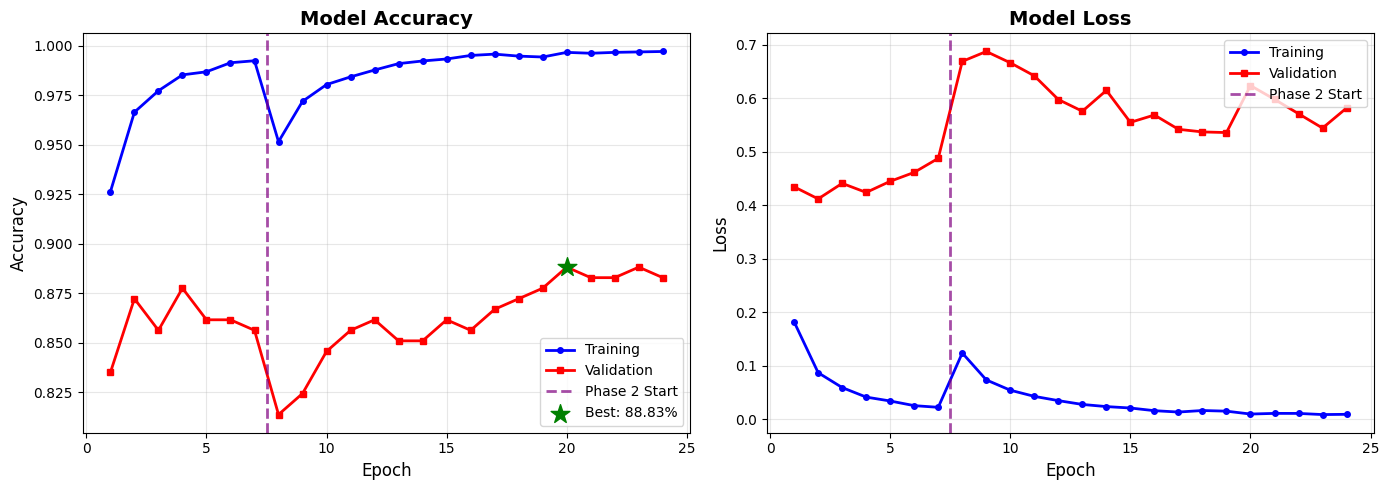


Phase 1: 7 epochs, Best Val Acc: 87.77%
Phase 2: 17 epochs, Best Val Acc: 88.83%
Overall Best: 88.83% (Epoch 20)


In [16]:
# Plot training history
epochs_p1 = list(range(1, len(history['phase1']['accuracy']) + 1))
epochs_p2 = list(range(len(epochs_p1) + 1, len(epochs_p1) + len(history['phase2']['accuracy']) + 1))
all_epochs = epochs_p1 + epochs_p2

all_train_acc = history['phase1']['accuracy'] + history['phase2']['accuracy']
all_val_acc = history['phase1']['val_accuracy'] + history['phase2']['val_accuracy']
all_train_loss = history['phase1']['loss'] + history['phase2']['loss']
all_val_loss = history['phase1']['val_loss'] + history['phase2']['val_loss']

# Find best validation accuracy
best_idx = all_val_acc.index(max(all_val_acc))
best_epoch = all_epochs[best_idx]
best_val_acc = all_val_acc[best_idx]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(all_epochs, all_train_acc, 'b-o', label='Training', markersize=4, linewidth=2)
axes[0].plot(all_epochs, all_val_acc, 'r-s', label='Validation', markersize=4, linewidth=2)
axes[0].axvline(x=len(epochs_p1) + 0.5, color='purple', linestyle='--', linewidth=2, alpha=0.7, label='Phase 2 Start')
axes[0].scatter([best_epoch], [best_val_acc], color='green', s=200, zorder=5, marker='*', label=f'Best: {best_val_acc*100:.2f}%')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(all_epochs, all_train_loss, 'b-o', label='Training', markersize=4, linewidth=2)
axes[1].plot(all_epochs, all_val_loss, 'r-s', label='Validation', markersize=4, linewidth=2)
axes[1].axvline(x=len(epochs_p1) + 0.5, color='purple', linestyle='--', linewidth=2, alpha=0.7, label='Phase 2 Start')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'training_history.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPhase 1: {len(epochs_p1)} epochs, Best Val Acc: {max(history['phase1']['val_accuracy'])*100:.2f}%")
print(f"Phase 2: {len(epochs_p2)} epochs, Best Val Acc: {max(history['phase2']['val_accuracy'])*100:.2f}%")
print(f"Overall Best: {best_val_acc*100:.2f}% (Epoch {best_epoch})")

## 9. Test Set Evaluation

In [17]:
# Load best model
best_model = tf.keras.models.load_model(os.path.join(MODEL_DIR, 'mite_model_best.keras'))
print(f"Loaded best model from: {os.path.join(MODEL_DIR, 'mite_model_best.keras')}")

Loaded best model from: D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\models\coconut_mite_v5\mite_model_best.keras


In [18]:
# Get predictions on test set
y_true = []
y_pred_probs = []

print("Running predictions on test set...")
for images, labels in test_ds_prep:
    preds = best_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred_probs.extend(preds.flatten())

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)

print(f"Test samples: {len(y_true)}")
print(f"Predictions complete!")

Running predictions on test set...


Test samples: 189
Predictions complete!


In [19]:
# Find optimal threshold for balanced P/R
print("Finding optimal threshold for balanced Precision/Recall...")
best_threshold = 0.5
best_gap = float('inf')

for thresh in np.arange(0.1, 0.9, 0.05):
    y_pred_temp = (y_pred_probs > thresh).astype(int)
    p, r, _, _ = precision_recall_fscore_support(y_true, y_pred_temp, average=None, zero_division=0)
    max_gap = max(abs(p[0] - r[0]), abs(p[1] - r[1]))
    if max_gap < best_gap:
        best_gap = max_gap
        best_threshold = thresh

print(f"Optimal threshold: {best_threshold:.2f}")

# Apply threshold
y_pred = (y_pred_probs > best_threshold).astype(int)

Finding optimal threshold for balanced Precision/Recall...
Optimal threshold: 0.80


In [20]:
# Classification Report
print("=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

CLASSIFICATION REPORT
              precision    recall  f1-score   support

coconut_mite     0.8317    0.8400    0.8358       100
     healthy     0.8182    0.8090    0.8136        89

    accuracy                         0.8254       189
   macro avg     0.8249    0.8245    0.8247       189
weighted avg     0.8253    0.8254    0.8253       189



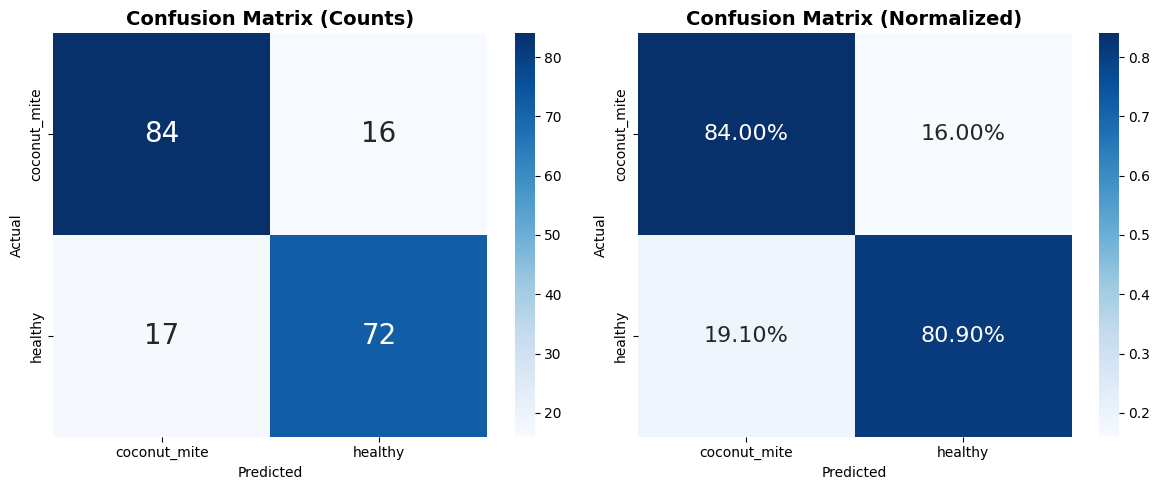

In [21]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=class_names, yticklabels=class_names, annot_kws={'size': 20})
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Normalized
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', ax=axes[1],
            xticklabels=class_names, yticklabels=class_names, annot_kws={'size': 16})
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'confusion_matrix.png'), dpi=150, bbox_inches='tight')
plt.show()

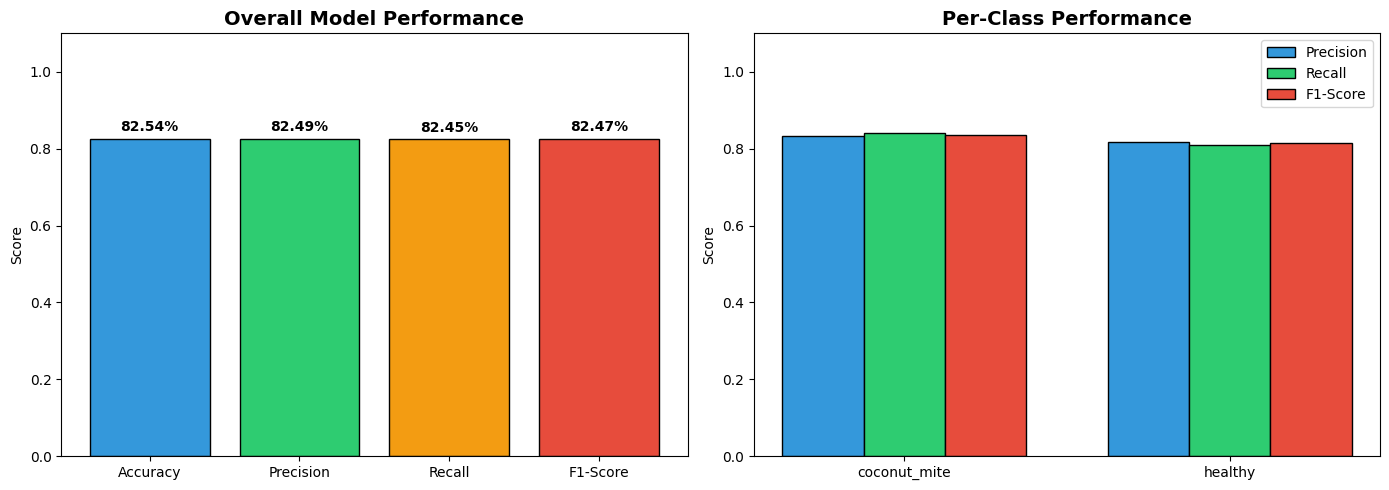


Test Accuracy: 82.54%
Macro F1-Score: 82.47%


In [22]:
# Performance Metrics Visualization
accuracy = np.mean(y_true == y_pred)
p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
macro_f1 = np.mean(f1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall metrics
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_values = [accuracy, np.mean(p), np.mean(r), macro_f1]
colors_metrics = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']

bars = axes[0].bar(metrics_names, metrics_values, color=colors_metrics, edgecolor='black')
axes[0].set_ylim([0, 1.1])
axes[0].set_title('Overall Model Performance', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Score')
for bar, val in zip(bars, metrics_values):
    axes[0].text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.2%}', ha='center', fontweight='bold')

# Per-class metrics
x = np.arange(len(class_names))
width = 0.25
axes[1].bar(x - width, p, width, label='Precision', color='#3498db', edgecolor='black')
axes[1].bar(x, r, width, label='Recall', color='#2ecc71', edgecolor='black')
axes[1].bar(x + width, f1, width, label='F1-Score', color='#e74c3c', edgecolor='black')
axes[1].set_ylim([0, 1.1])
axes[1].set_title('Per-Class Performance', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(class_names)
axes[1].legend()
axes[1].set_ylabel('Score')

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'performance_metrics.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\nTest Accuracy: {accuracy*100:.2f}%")
print(f"Macro F1-Score: {macro_f1*100:.2f}%")

## 10. Requirements Validation

Checking if model meets Uthpala Miss requirements:
1. P/R/F1 should be close for EACH class
2. F1-Scores should be similar across classes
3. Accuracy should be close to F1-Score

In [23]:
print("=" * 60)
print("REQUIREMENTS VALIDATION")
print("=" * 60)

all_pass = True

# Requirement 1: P/R/F1 balanced per class
print("\n[1] P/R/F1 should be close for EACH class (gap < 0.05)")
print("-" * 60)
for i, cls in enumerate(class_names):
    gap = abs(p[i] - r[i])
    status = "PASS" if gap < 0.05 else "FAIL"
    if gap >= 0.05:
        all_pass = False
    print(f"  {cls}: P={p[i]:.4f}, R={r[i]:.4f}, F1={f1[i]:.4f}, Gap={gap:.4f} [{status}]")

# Requirement 2: F1 similar across classes
print("\n[2] F1-Scores should be similar across classes (diff < 0.05)")
print("-" * 60)
f1_diff = abs(f1[0] - f1[1])
status = "PASS" if f1_diff < 0.05 else "FAIL"
if f1_diff >= 0.05:
    all_pass = False
print(f"  F1 Difference: {f1_diff:.4f} [{status}]")

# Requirement 3: Accuracy close to F1
print("\n[3] Accuracy should be close to F1-Score (diff < 0.05)")
print("-" * 60)
acc_f1_diff = abs(accuracy - macro_f1)
status = "PASS" if acc_f1_diff < 0.05 else "FAIL"
if acc_f1_diff >= 0.05:
    all_pass = False
print(f"  Accuracy={accuracy:.4f}, Macro F1={macro_f1:.4f}, Diff={acc_f1_diff:.4f} [{status}]")

print("\n" + "=" * 60)
if all_pass:
    print("ALL REQUIREMENTS PASSED!")
else:
    print("SOME REQUIREMENTS NEED ATTENTION")
print("=" * 60)

REQUIREMENTS VALIDATION

[1] P/R/F1 should be close for EACH class (gap < 0.05)
------------------------------------------------------------
  coconut_mite: P=0.8317, R=0.8400, F1=0.8358, Gap=0.0083 [PASS]
  healthy: P=0.8182, R=0.8090, F1=0.8136, Gap=0.0092 [PASS]

[2] F1-Scores should be similar across classes (diff < 0.05)
------------------------------------------------------------
  F1 Difference: 0.0223 [PASS]

[3] Accuracy should be close to F1-Score (diff < 0.05)
------------------------------------------------------------
  Accuracy=0.8254, Macro F1=0.8247, Diff=0.0007 [PASS]

ALL REQUIREMENTS PASSED!


## 11. Save Model Info

In [24]:
# Save model info
model_info = {
    'model_name': 'Coconut Mite Detection Model',
    'base_model': 'MobileNetV2',
    'input_size': [224, 224, 3],
    'classes': class_names,
    'threshold': float(best_threshold),
    'dataset': {
        'train': sum(train_counts.values()),
        'validation': sum(val_counts.values()),
        'test': sum(test_counts.values())
    },
    'training': {
        'phase1_epochs': len(history['phase1']['accuracy']),
        'phase2_epochs': len(history['phase2']['accuracy']),
        'best_val_accuracy': float(best_val_acc)
    },
    'test_results': {
        'accuracy': float(accuracy),
        'per_class': {
            class_names[0]: {'precision': float(p[0]), 'recall': float(r[0]), 'f1': float(f1[0])},
            class_names[1]: {'precision': float(p[1]), 'recall': float(r[1]), 'f1': float(f1[1])}
        },
        'macro_f1': float(macro_f1)
    }
}

with open(os.path.join(MODEL_DIR, 'model_info.json'), 'w') as f:
    json.dump(model_info, f, indent=2)

print(f"Model info saved to: {os.path.join(MODEL_DIR, 'model_info.json')}")

Model info saved to: D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\models\coconut_mite_v5\model_info.json


## 12. Summary

In [25]:
print("=" * 60)
print("TRAINING SUMMARY")
print("=" * 60)

print(f"\nModel: MobileNetV2 (Transfer Learning)")
print(f"Dataset: {sum(train_counts.values())} train / {sum(val_counts.values())} val / {sum(test_counts.values())} test")
print(f"Training: Phase 1 ({len(epochs_p1)} epochs) + Phase 2 ({len(epochs_p2)} epochs)")
print(f"Best Validation Accuracy: {best_val_acc*100:.2f}%")

print(f"\n--- Test Results ---")
print(f"Threshold: {best_threshold:.2f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Macro F1-Score: {macro_f1*100:.2f}%")

print(f"\n--- Per-Class Results ---")
for i, cls in enumerate(class_names):
    print(f"  {cls}: P={p[i]:.4f}, R={r[i]:.4f}, F1={f1[i]:.4f}")

print(f"\n--- Model Files ---")
print(f"  {MODEL_DIR}/mite_model_best.keras")
print(f"  {MODEL_DIR}/mite_model_final.keras")
print(f"  {MODEL_DIR}/model_info.json")
print(f"  {MODEL_DIR}/training_history.json")

print("\n" + "=" * 60)

TRAINING SUMMARY

Model: MobileNetV2 (Transfer Learning)
Dataset: 8975 train / 188 val / 189 test
Training: Phase 1 (7 epochs) + Phase 2 (17 epochs)
Best Validation Accuracy: 88.83%

--- Test Results ---
Threshold: 0.80
Test Accuracy: 82.54%
Macro F1-Score: 82.47%

--- Per-Class Results ---
  coconut_mite: P=0.8317, R=0.8400, F1=0.8358
  healthy: P=0.8182, R=0.8090, F1=0.8136

--- Model Files ---
  D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\models\coconut_mite_v5/mite_model_best.keras
  D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\models\coconut_mite_v5/mite_model_final.keras
  D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\models\coconut_mite_v5/model_info.json
  D:\SLIIT\Reaserch Project\CoconutHealthMonitor\Research\ml\models\coconut_mite_v5/training_history.json

